In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)
testing_data['called_strike'] = np.where(testing_data['description'] == 'called_strike', 1, 0)

In [5]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & strike == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [7]:
testing_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [8]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [9]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6278520849724626
Log Loss: 0.6323176050605017


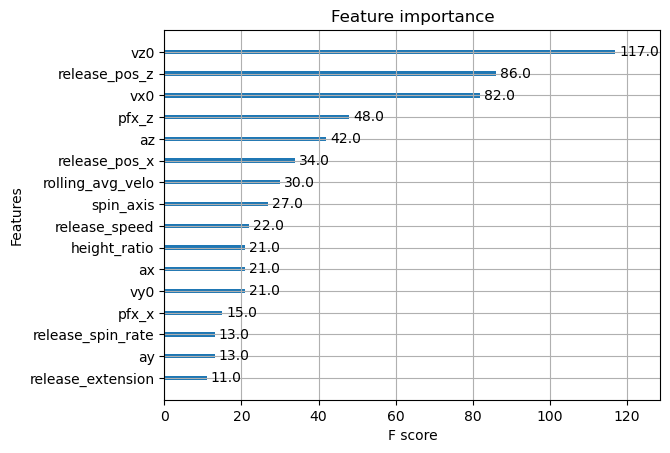

In [15]:
xgb.plot_importance(model)
plt.show()

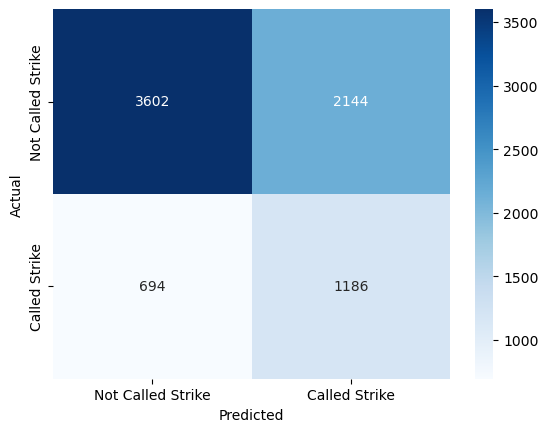

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:46:07,132] A new study created in memory with name: no-name-3b268cff-f6bb-457d-ab1e-5e1f33e4aae3


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66286
[4]	eval-logloss:0.65823
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.64993
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64381
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63712
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63361
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.63068
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62833
[18]	eval-logloss:0.62791
[19]	eval-logloss:0.62728
[20]	eval-logloss:0.62575
[21]	eval-logloss:0.62476
[22]	eval-logloss:0.62356
[23]	eval-logloss:0.62327
[24]	eval-logloss:0.62249
[25]	eval-logloss:0.62043
[26]	eval-logloss:0.61923
[27]	eval-logloss:0.61872
[28]	eval-logloss:0.61762
[29]	eval-logloss:0.61765
[30]	eval-logloss:0.61631
[31]	eval-logloss:0.61509
[32]	eval-logloss:0.61486
[33]	eval-logloss:0.61392
[34]	eval-logloss:0.61398
[35]	eval-logloss:0.61280
[36]	eval-logloss:0.61175
[37]	eval-logloss:0.61181
[38]	eval-logloss:0.61

[I 2023-11-15 17:46:07,827] Trial 0 finished with value: 0.5899213161710479 and parameters: {'max_depth': 4, 'eta': 0.12933333775216316, 'subsample': 0.7954460778126653, 'colsample_bytree': 0.5010434247395399}. Best is trial 0 with value: 0.5899213161710479.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.63555
[4]	eval-logloss:0.63049
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.61637
[7]	eval-logloss:0.61129
[8]	eval-logloss:0.60855
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60348
[11]	eval-logloss:0.60250
[12]	eval-logloss:0.60032
[13]	eval-logloss:0.59891
[14]	eval-logloss:0.59860
[15]	eval-logloss:0.59514
[16]	eval-logloss:0.59287
[17]	eval-logloss:0.59149
[18]	eval-logloss:0.59139
[19]	eval-logloss:0.59115
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58884
[22]	eval-logloss:0.58851
[23]	eval-logloss:0.58803
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58545
[26]	eval-logloss:0.58465
[27]	eval-logloss:0.58381
[28]	eval-logloss:0.58315
[29]	eval-logloss:0.58161
[30]	eval-logloss:0.58017
[31]	eval-logloss:0.57943
[32]	eval-logloss:0.57896
[33]	eval-logloss:0.57892
[34]	eval-logloss:0.57819
[35]	eval-logloss:0.57690
[36]	eval-logloss:0.57658
[37]	eval-logloss:0.57659
[38]	eval-logloss:0.57

[I 2023-11-15 17:46:08,527] Trial 1 finished with value: 0.5565762919509482 and parameters: {'max_depth': 6, 'eta': 0.23853061917117196, 'subsample': 0.7743213158780164, 'colsample_bytree': 0.5341868234979004}. Best is trial 1 with value: 0.5565762919509482.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68275
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67818
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67606
[15]	eval-logloss:0.67513
[16]	eval-logloss:0.67475
[17]	eval-logloss:0.67368
[18]	eval-logloss:0.67353
[19]	eval-logloss:0.67321
[20]	eval-logloss:0.67291
[21]	eval-logloss:0.67214
[22]	eval-logloss:0.67118
[23]	eval-logloss:0.67089
[24]	eval-logloss:0.67069
[25]	eval-logloss:0.67034
[26]	eval-logloss:0.66948
[27]	eval-logloss:0.66887
[28]	eval-logloss:0.66809
[29]	eval-logloss:0.66800
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66688
[32]	eval-logloss:0.66680
[33]	eval-logloss:0.66590
[34]	eval-logloss:0.66580
[35]	eval-logloss:0.66487
[36]	eval-logloss:0.66406
[37]	eval-logloss:0.66403
[38]	eval-logloss:0.66

[I 2023-11-15 17:46:09,069] Trial 2 finished with value: 0.6381839598471957 and parameters: {'max_depth': 4, 'eta': 0.016200828305340222, 'subsample': 0.658587058836455, 'colsample_bytree': 0.6448252818807879}. Best is trial 1 with value: 0.5565762919509482.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64613
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.62119
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.59971
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.59414
[9]	eval-logloss:0.58771
[10]	eval-logloss:0.58569
[11]	eval-logloss:0.58348
[12]	eval-logloss:0.58142
[13]	eval-logloss:0.57905
[14]	eval-logloss:0.57804
[15]	eval-logloss:0.57540
[16]	eval-logloss:0.57361
[17]	eval-logloss:0.57297
[18]	eval-logloss:0.57171
[19]	eval-logloss:0.57122
[20]	eval-logloss:0.57026
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56864
[23]	eval-logloss:0.56807
[24]	eval-logloss:0.56681
[25]	eval-logloss:0.56538
[26]	eval-logloss:0.56535
[27]	eval-logloss:0.56439
[28]	eval-logloss:0.56405
[29]	eval-logloss:0.56254
[30]	eval-logloss:0.56199
[31]	eval-logloss:0.56120
[32]	eval-logloss:0.55986
[33]	eval-logloss:0.55966
[34]	eval-logloss:0.55973
[35]	eval-logloss:0.55838
[36]	eval-logloss:0.55789
[37]	eval-logloss:0.55673
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:10,052] Trial 3 finished with value: 0.5355798503536466 and parameters: {'max_depth': 8, 'eta': 0.19824165826177395, 'subsample': 0.8236195092141014, 'colsample_bytree': 0.9955660735841108}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65197
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63573
[5]	eval-logloss:0.62991
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.61973
[8]	eval-logloss:0.61626
[9]	eval-logloss:0.61084
[10]	eval-logloss:0.60737
[11]	eval-logloss:0.60504
[12]	eval-logloss:0.60243
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59653
[16]	eval-logloss:0.59439
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59305
[19]	eval-logloss:0.58921
[20]	eval-logloss:0.58635
[21]	eval-logloss:0.58522
[22]	eval-logloss:0.58394
[23]	eval-logloss:0.58245
[24]	eval-logloss:0.58045
[25]	eval-logloss:0.57887
[26]	eval-logloss:0.57857
[27]	eval-logloss:0.57763
[28]	eval-logloss:0.57636
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57455
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57251
[34]	eval-logloss:0.57198
[35]	eval-logloss:0.57088
[36]	eval-logloss:0.56975
[37]	eval-logloss:0.56928
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:10,792] Trial 4 finished with value: 0.5452686917868259 and parameters: {'max_depth': 7, 'eta': 0.13103712048600535, 'subsample': 0.8463415041608742, 'colsample_bytree': 0.8392536956807435}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.62621
[3]	eval-logloss:0.61640
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60836
[6]	eval-logloss:0.60241
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59597
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.59145
[12]	eval-logloss:0.58813
[13]	eval-logloss:0.58412
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.57975
[16]	eval-logloss:0.57754
[17]	eval-logloss:0.57815
[18]	eval-logloss:0.57926
[19]	eval-logloss:0.57905
[20]	eval-logloss:0.57632
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57498
[23]	eval-logloss:0.57427
[24]	eval-logloss:0.57464
[25]	eval-logloss:0.56963
[26]	eval-logloss:0.56971
[27]	eval-logloss:0.56734
[28]	eval-logloss:0.56712
[29]	eval-logloss:0.56485
[30]	eval-logloss:0.56482
[31]	eval-logloss:0.56388
[32]	eval-logloss:0.56420
[33]	eval-logloss:0.56321
[34]	eval-logloss:0.56305
[35]	eval-logloss:0.56265
[36]	eval-logloss:0.56256
[37]	eval-logloss:0.56274
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:11,863] Trial 5 finished with value: 0.5723817437764566 and parameters: {'max_depth': 9, 'eta': 0.2652383270961859, 'subsample': 0.6084364072126471, 'colsample_bytree': 0.505197613848702}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.65893
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.63559
[6]	eval-logloss:0.62903
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61885
[9]	eval-logloss:0.61420
[10]	eval-logloss:0.61051
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59891
[15]	eval-logloss:0.59655
[16]	eval-logloss:0.59388
[17]	eval-logloss:0.59137
[18]	eval-logloss:0.58905
[19]	eval-logloss:0.58688
[20]	eval-logloss:0.58555
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58143
[23]	eval-logloss:0.58026
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57675
[26]	eval-logloss:0.57598
[27]	eval-logloss:0.57532
[28]	eval-logloss:0.57414
[29]	eval-logloss:0.57314
[30]	eval-logloss:0.57246
[31]	eval-logloss:0.57141
[32]	eval-logloss:0.56954
[33]	eval-logloss:0.56890
[34]	eval-logloss:0.56783
[35]	eval-logloss:0.56631
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56512
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:12,806] Trial 6 finished with value: 0.5390585406810895 and parameters: {'max_depth': 8, 'eta': 0.09169544499946065, 'subsample': 0.7793338945182088, 'colsample_bytree': 0.9695385806286845}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68564
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68150
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67892
[10]	eval-logloss:0.67779
[11]	eval-logloss:0.67668
[12]	eval-logloss:0.67554
[13]	eval-logloss:0.67457
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67242
[16]	eval-logloss:0.67131
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66864
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66553
[26]	eval-logloss:0.66475
[27]	eval-logloss:0.66401
[28]	eval-logloss:0.66328
[29]	eval-logloss:0.66294
[30]	eval-logloss:0.66210
[31]	eval-logloss:0.66139
[32]	eval-logloss:0.66131
[33]	eval-logloss:0.66053
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.65951
[36]	eval-logloss:0.65881
[37]	eval-logloss:0.65830
[38]	eval-logloss:0.65

[I 2023-11-15 17:46:13,296] Trial 7 finished with value: 0.6319584244522194 and parameters: {'max_depth': 4, 'eta': 0.017508175525919885, 'subsample': 0.6882467854443017, 'colsample_bytree': 0.827218648745691}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66171
[3]	eval-logloss:0.65457
[4]	eval-logloss:0.64784
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.63969
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63210
[9]	eval-logloss:0.62957
[10]	eval-logloss:0.62645
[11]	eval-logloss:0.62410
[12]	eval-logloss:0.62177
[13]	eval-logloss:0.62041
[14]	eval-logloss:0.61879
[15]	eval-logloss:0.61733
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.61075
[19]	eval-logloss:0.60764
[20]	eval-logloss:0.60527
[21]	eval-logloss:0.60411
[22]	eval-logloss:0.60216
[23]	eval-logloss:0.60151
[24]	eval-logloss:0.60100
[25]	eval-logloss:0.59922
[26]	eval-logloss:0.59882
[27]	eval-logloss:0.59861
[28]	eval-logloss:0.59800
[29]	eval-logloss:0.59718
[30]	eval-logloss:0.59605
[31]	eval-logloss:0.59611
[32]	eval-logloss:0.59595
[33]	eval-logloss:0.59538
[34]	eval-logloss:0.59461
[35]	eval-logloss:0.59359
[36]	eval-logloss:0.59246
[37]	eval-logloss:0.59218
[38]	eval-logloss:0.59

[I 2023-11-15 17:46:13,809] Trial 8 finished with value: 0.5728490501535516 and parameters: {'max_depth': 5, 'eta': 0.13249277853911626, 'subsample': 0.6334640408298781, 'colsample_bytree': 0.9387792139959649}. Best is trial 3 with value: 0.5355798503536466.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62275
[6]	eval-logloss:0.61494
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60451
[9]	eval-logloss:0.60104
[10]	eval-logloss:0.59738
[11]	eval-logloss:0.59544
[12]	eval-logloss:0.59073
[13]	eval-logloss:0.58790
[14]	eval-logloss:0.58570
[15]	eval-logloss:0.58181
[16]	eval-logloss:0.58075
[17]	eval-logloss:0.57853
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57854
[20]	eval-logloss:0.57606
[21]	eval-logloss:0.57442
[22]	eval-logloss:0.57166
[23]	eval-logloss:0.57120
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.56727
[26]	eval-logloss:0.56662
[27]	eval-logloss:0.56475
[28]	eval-logloss:0.56367
[29]	eval-logloss:0.56232
[30]	eval-logloss:0.56094
[31]	eval-logloss:0.55910
[32]	eval-logloss:0.55824
[33]	eval-logloss:0.55726
[34]	eval-logloss:0.55756
[35]	eval-logloss:0.55651
[36]	eval-logloss:0.55622
[37]	eval-logloss:0.55620
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:14,875] Trial 9 finished with value: 0.5303142575147327 and parameters: {'max_depth': 9, 'eta': 0.13316925413342773, 'subsample': 0.6025132962079254, 'colsample_bytree': 0.5081748589062232}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.62167
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.60939
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.59157
[8]	eval-logloss:0.58857
[9]	eval-logloss:0.58593
[10]	eval-logloss:0.58152
[11]	eval-logloss:0.58151
[12]	eval-logloss:0.57962
[13]	eval-logloss:0.57822
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57286
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56860
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56599
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56298
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.56064
[24]	eval-logloss:0.55988
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55528
[29]	eval-logloss:0.55326
[30]	eval-logloss:0.55362
[31]	eval-logloss:0.55346
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55151
[35]	eval-logloss:0.55112
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.55093
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:16,003] Trial 10 finished with value: 0.5356012044703921 and parameters: {'max_depth': 9, 'eta': 0.1993643364119204, 'subsample': 0.7075244693056411, 'colsample_bytree': 0.6418415422668194}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.63560
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.60536
[7]	eval-logloss:0.59962
[8]	eval-logloss:0.59667
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58880
[11]	eval-logloss:0.58688
[12]	eval-logloss:0.58336
[13]	eval-logloss:0.58037
[14]	eval-logloss:0.57873
[15]	eval-logloss:0.57529
[16]	eval-logloss:0.57312
[17]	eval-logloss:0.57116
[18]	eval-logloss:0.57029
[19]	eval-logloss:0.56750
[20]	eval-logloss:0.56568
[21]	eval-logloss:0.56470
[22]	eval-logloss:0.56357
[23]	eval-logloss:0.56253
[24]	eval-logloss:0.56155
[25]	eval-logloss:0.56004
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55840
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55747
[30]	eval-logloss:0.55673
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55560
[33]	eval-logloss:0.55510
[34]	eval-logloss:0.55538
[35]	eval-logloss:0.55463
[36]	eval-logloss:0.55421
[37]	eval-logloss:0.55436
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:16,949] Trial 11 finished with value: 0.5347948475932376 and parameters: {'max_depth': 8, 'eta': 0.1939608687596209, 'subsample': 0.876320288385374, 'colsample_bytree': 0.7095958526780164}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.64237
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61590
[7]	eval-logloss:0.61129
[8]	eval-logloss:0.60839
[9]	eval-logloss:0.60278
[10]	eval-logloss:0.59961
[11]	eval-logloss:0.59803
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59319
[14]	eval-logloss:0.59177
[15]	eval-logloss:0.58907
[16]	eval-logloss:0.58686
[17]	eval-logloss:0.58562
[18]	eval-logloss:0.58534
[19]	eval-logloss:0.58299
[20]	eval-logloss:0.58130
[21]	eval-logloss:0.58005
[22]	eval-logloss:0.57884
[23]	eval-logloss:0.57812
[24]	eval-logloss:0.57701
[25]	eval-logloss:0.57618
[26]	eval-logloss:0.57460
[27]	eval-logloss:0.57340
[28]	eval-logloss:0.57282
[29]	eval-logloss:0.57251
[30]	eval-logloss:0.57201
[31]	eval-logloss:0.57065
[32]	eval-logloss:0.57036
[33]	eval-logloss:0.56956
[34]	eval-logloss:0.56947
[35]	eval-logloss:0.56876
[36]	eval-logloss:0.56825
[37]	eval-logloss:0.56796
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:17,678] Trial 12 finished with value: 0.5412811419249702 and parameters: {'max_depth': 7, 'eta': 0.18567701746838347, 'subsample': 0.8879159125555101, 'colsample_bytree': 0.6587776204351439}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.65598
[1]	eval-logloss:0.63157
[2]	eval-logloss:0.61593
[3]	eval-logloss:0.60744
[4]	eval-logloss:0.60231
[5]	eval-logloss:0.59766
[6]	eval-logloss:0.58806
[7]	eval-logloss:0.58166
[8]	eval-logloss:0.57931
[9]	eval-logloss:0.57378
[10]	eval-logloss:0.57264
[11]	eval-logloss:0.57211
[12]	eval-logloss:0.56905
[13]	eval-logloss:0.56817
[14]	eval-logloss:0.56775
[15]	eval-logloss:0.56548
[16]	eval-logloss:0.56264
[17]	eval-logloss:0.56315
[18]	eval-logloss:0.56399
[19]	eval-logloss:0.56140
[20]	eval-logloss:0.56072
[21]	eval-logloss:0.56037
[22]	eval-logloss:0.55994
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.56000
[25]	eval-logloss:0.55897
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55789
[28]	eval-logloss:0.55904
[29]	eval-logloss:0.55715
[30]	eval-logloss:0.55731
[31]	eval-logloss:0.55779
[32]	eval-logloss:0.55694
[33]	eval-logloss:0.55693
[34]	eval-logloss:0.55676
[35]	eval-logloss:0.55632
[36]	eval-logloss:0.55623
[37]	eval-logloss:0.55681
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:18,775] Trial 13 finished with value: 0.5607904576883643 and parameters: {'max_depth': 9, 'eta': 0.2819115027012221, 'subsample': 0.7195104774342505, 'colsample_bytree': 0.7280272992220704}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.62420
[4]	eval-logloss:0.61814
[5]	eval-logloss:0.61243
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59838
[8]	eval-logloss:0.59468
[9]	eval-logloss:0.59149
[10]	eval-logloss:0.58800
[11]	eval-logloss:0.58713
[12]	eval-logloss:0.58461
[13]	eval-logloss:0.58428
[14]	eval-logloss:0.58252
[15]	eval-logloss:0.57978
[16]	eval-logloss:0.57773
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57675
[19]	eval-logloss:0.57452
[20]	eval-logloss:0.57369
[21]	eval-logloss:0.57369
[22]	eval-logloss:0.57249
[23]	eval-logloss:0.57175
[24]	eval-logloss:0.57151
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.56920
[27]	eval-logloss:0.56916
[28]	eval-logloss:0.56835
[29]	eval-logloss:0.56781
[30]	eval-logloss:0.56677
[31]	eval-logloss:0.56635
[32]	eval-logloss:0.56631
[33]	eval-logloss:0.56555
[34]	eval-logloss:0.56450
[35]	eval-logloss:0.56462
[36]	eval-logloss:0.56442
[37]	eval-logloss:0.56429
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:19,673] Trial 14 finished with value: 0.5480252601808622 and parameters: {'max_depth': 8, 'eta': 0.23030542069239152, 'subsample': 0.7335716558481047, 'colsample_bytree': 0.5977819336226867}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63855
[4]	eval-logloss:0.63183
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.61945
[7]	eval-logloss:0.61433
[8]	eval-logloss:0.61106
[9]	eval-logloss:0.60782
[10]	eval-logloss:0.60405
[11]	eval-logloss:0.60258
[12]	eval-logloss:0.59997
[13]	eval-logloss:0.59858
[14]	eval-logloss:0.59620
[15]	eval-logloss:0.59264
[16]	eval-logloss:0.58860
[17]	eval-logloss:0.58688
[18]	eval-logloss:0.58613
[19]	eval-logloss:0.58424
[20]	eval-logloss:0.58274
[21]	eval-logloss:0.58190
[22]	eval-logloss:0.58036
[23]	eval-logloss:0.58031
[24]	eval-logloss:0.57960
[25]	eval-logloss:0.57719
[26]	eval-logloss:0.57551
[27]	eval-logloss:0.57460
[28]	eval-logloss:0.57475
[29]	eval-logloss:0.57425
[30]	eval-logloss:0.57388
[31]	eval-logloss:0.57270
[32]	eval-logloss:0.57280
[33]	eval-logloss:0.57198
[34]	eval-logloss:0.57148
[35]	eval-logloss:0.57044
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.57074
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:20,390] Trial 15 finished with value: 0.547283551698722 and parameters: {'max_depth': 7, 'eta': 0.17015548686823917, 'subsample': 0.6631096541214043, 'colsample_bytree': 0.5828131670517678}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65826
[4]	eval-logloss:0.65288
[5]	eval-logloss:0.64760
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.63946
[8]	eval-logloss:0.63623
[9]	eval-logloss:0.63200
[10]	eval-logloss:0.62894
[11]	eval-logloss:0.62656
[12]	eval-logloss:0.62414
[13]	eval-logloss:0.62181
[14]	eval-logloss:0.61958
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60697
[22]	eval-logloss:0.60558
[23]	eval-logloss:0.60406
[24]	eval-logloss:0.60265
[25]	eval-logloss:0.60114
[26]	eval-logloss:0.60025
[27]	eval-logloss:0.59957
[28]	eval-logloss:0.59837
[29]	eval-logloss:0.59787
[30]	eval-logloss:0.59711
[31]	eval-logloss:0.59592
[32]	eval-logloss:0.59549
[33]	eval-logloss:0.59442
[34]	eval-logloss:0.59412
[35]	eval-logloss:0.59338
[36]	eval-logloss:0.59284
[37]	eval-logloss:0.59237
[38]	eval-logloss:0.59

[I 2023-11-15 17:46:21,047] Trial 16 finished with value: 0.5633433611562464 and parameters: {'max_depth': 6, 'eta': 0.09489954817852389, 'subsample': 0.8982943264496364, 'colsample_bytree': 0.713621404911124}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.63487
[4]	eval-logloss:0.62777
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61208
[7]	eval-logloss:0.60563
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59768
[10]	eval-logloss:0.59389
[11]	eval-logloss:0.59211
[12]	eval-logloss:0.58818
[13]	eval-logloss:0.58630
[14]	eval-logloss:0.58568
[15]	eval-logloss:0.58243
[16]	eval-logloss:0.57863
[17]	eval-logloss:0.57704
[18]	eval-logloss:0.57676
[19]	eval-logloss:0.57425
[20]	eval-logloss:0.57288
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.56989
[23]	eval-logloss:0.56976
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56583
[27]	eval-logloss:0.56557
[28]	eval-logloss:0.56502
[29]	eval-logloss:0.56398
[30]	eval-logloss:0.56306
[31]	eval-logloss:0.56212
[32]	eval-logloss:0.56135
[33]	eval-logloss:0.56018
[34]	eval-logloss:0.56076
[35]	eval-logloss:0.56018
[36]	eval-logloss:0.55961
[37]	eval-logloss:0.55980
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:22,030] Trial 17 finished with value: 0.5325601035316888 and parameters: {'max_depth': 8, 'eta': 0.16241918997382807, 'subsample': 0.747998655625256, 'colsample_bytree': 0.5711604191169941}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66990
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.66058
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.65151
[8]	eval-logloss:0.64924
[9]	eval-logloss:0.64693
[10]	eval-logloss:0.64556
[11]	eval-logloss:0.64462
[12]	eval-logloss:0.64161
[13]	eval-logloss:0.64072
[14]	eval-logloss:0.64032
[15]	eval-logloss:0.63954
[16]	eval-logloss:0.63734
[17]	eval-logloss:0.63566
[18]	eval-logloss:0.63520
[19]	eval-logloss:0.63364
[20]	eval-logloss:0.63265
[21]	eval-logloss:0.63198
[22]	eval-logloss:0.63086
[23]	eval-logloss:0.63006
[24]	eval-logloss:0.62959
[25]	eval-logloss:0.62832
[26]	eval-logloss:0.62738
[27]	eval-logloss:0.62689
[28]	eval-logloss:0.62624
[29]	eval-logloss:0.62612
[30]	eval-logloss:0.62444
[31]	eval-logloss:0.62398
[32]	eval-logloss:0.62387
[33]	eval-logloss:0.62335
[34]	eval-logloss:0.62292
[35]	eval-logloss:0.62184
[36]	eval-logloss:0.62115
[37]	eval-logloss:0.62152
[38]	eval-logloss:0.62

[I 2023-11-15 17:46:22,502] Trial 18 finished with value: 0.5980642203854558 and parameters: {'max_depth': 3, 'eta': 0.15477626953494886, 'subsample': 0.7488448542690668, 'colsample_bytree': 0.5656634458606236}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65290
[4]	eval-logloss:0.64687
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62773
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.61301
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60625
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.59814
[16]	eval-logloss:0.59458
[17]	eval-logloss:0.59158
[18]	eval-logloss:0.59147
[19]	eval-logloss:0.59024
[20]	eval-logloss:0.58892
[21]	eval-logloss:0.58685
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58322
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.58083
[26]	eval-logloss:0.57893
[27]	eval-logloss:0.57785
[28]	eval-logloss:0.57633
[29]	eval-logloss:0.57553
[30]	eval-logloss:0.57430
[31]	eval-logloss:0.57236
[32]	eval-logloss:0.57167
[33]	eval-logloss:0.57006
[34]	eval-logloss:0.57006
[35]	eval-logloss:0.56934
[36]	eval-logloss:0.56866
[37]	eval-logloss:0.56859
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:23,721] Trial 19 finished with value: 0.5359369821143228 and parameters: {'max_depth': 9, 'eta': 0.08131150517915152, 'subsample': 0.6005685066816735, 'colsample_bytree': 0.5673739161048381}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62559
[8]	eval-logloss:0.62172
[9]	eval-logloss:0.61836
[10]	eval-logloss:0.61581
[11]	eval-logloss:0.61498
[12]	eval-logloss:0.61165
[13]	eval-logloss:0.61005
[14]	eval-logloss:0.60813
[15]	eval-logloss:0.60617
[16]	eval-logloss:0.60493
[17]	eval-logloss:0.60364
[18]	eval-logloss:0.60264
[19]	eval-logloss:0.60181
[20]	eval-logloss:0.60037
[21]	eval-logloss:0.59978
[22]	eval-logloss:0.59791
[23]	eval-logloss:0.59779
[24]	eval-logloss:0.59686
[25]	eval-logloss:0.59494
[26]	eval-logloss:0.59387
[27]	eval-logloss:0.59382
[28]	eval-logloss:0.59297
[29]	eval-logloss:0.59206
[30]	eval-logloss:0.59098
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.58975
[33]	eval-logloss:0.58908
[34]	eval-logloss:0.58909
[35]	eval-logloss:0.58833
[36]	eval-logloss:0.58740
[37]	eval-logloss:0.58792
[38]	eval-logloss:0.58

[I 2023-11-15 17:46:24,361] Trial 20 finished with value: 0.5601140374320102 and parameters: {'max_depth': 6, 'eta': 0.15782240303360937, 'subsample': 0.6842701615178782, 'colsample_bytree': 0.5010081773439115}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.62311
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60428
[7]	eval-logloss:0.59731
[8]	eval-logloss:0.59352
[9]	eval-logloss:0.59129
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58689
[12]	eval-logloss:0.58342
[13]	eval-logloss:0.58138
[14]	eval-logloss:0.57964
[15]	eval-logloss:0.57656
[16]	eval-logloss:0.57444
[17]	eval-logloss:0.57309
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.57061
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56856
[22]	eval-logloss:0.56702
[23]	eval-logloss:0.56680
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56417
[26]	eval-logloss:0.56437
[27]	eval-logloss:0.56384
[28]	eval-logloss:0.56321
[29]	eval-logloss:0.56193
[30]	eval-logloss:0.56170
[31]	eval-logloss:0.56105
[32]	eval-logloss:0.56108
[33]	eval-logloss:0.56142
[34]	eval-logloss:0.56135
[35]	eval-logloss:0.56044
[36]	eval-logloss:0.55988
[37]	eval-logloss:0.56021
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:25,312] Trial 21 finished with value: 0.5437223993521866 and parameters: {'max_depth': 8, 'eta': 0.21628987078505216, 'subsample': 0.74889622012722, 'colsample_bytree': 0.618026244851917}. Best is trial 9 with value: 0.5303142575147327.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.64011
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61771
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.60344
[8]	eval-logloss:0.59951
[9]	eval-logloss:0.59329
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.58878
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58336
[14]	eval-logloss:0.58174
[15]	eval-logloss:0.57914
[16]	eval-logloss:0.57687
[17]	eval-logloss:0.57508
[18]	eval-logloss:0.57387
[19]	eval-logloss:0.57084
[20]	eval-logloss:0.56862
[21]	eval-logloss:0.56657
[22]	eval-logloss:0.56591
[23]	eval-logloss:0.56520
[24]	eval-logloss:0.56441
[25]	eval-logloss:0.56285
[26]	eval-logloss:0.56181
[27]	eval-logloss:0.56152
[28]	eval-logloss:0.56064
[29]	eval-logloss:0.56025
[30]	eval-logloss:0.55957
[31]	eval-logloss:0.55759
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55563
[34]	eval-logloss:0.55587
[35]	eval-logloss:0.55525
[36]	eval-logloss:0.55456
[37]	eval-logloss:0.55447
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:26,233] Trial 22 finished with value: 0.5267836049655406 and parameters: {'max_depth': 8, 'eta': 0.17820160393609238, 'subsample': 0.8380254365666346, 'colsample_bytree': 0.6732704424758112}. Best is trial 22 with value: 0.5267836049655406.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.66221
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63309
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62000
[7]	eval-logloss:0.61487
[8]	eval-logloss:0.61132
[9]	eval-logloss:0.60767
[10]	eval-logloss:0.60449
[11]	eval-logloss:0.60330
[12]	eval-logloss:0.60076
[13]	eval-logloss:0.59889
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59464
[16]	eval-logloss:0.59074
[17]	eval-logloss:0.58909
[18]	eval-logloss:0.58852
[19]	eval-logloss:0.58785
[20]	eval-logloss:0.58709
[21]	eval-logloss:0.58549
[22]	eval-logloss:0.58469
[23]	eval-logloss:0.58436
[24]	eval-logloss:0.58353
[25]	eval-logloss:0.58110
[26]	eval-logloss:0.58064
[27]	eval-logloss:0.57975
[28]	eval-logloss:0.57846
[29]	eval-logloss:0.57738
[30]	eval-logloss:0.57625
[31]	eval-logloss:0.57530
[32]	eval-logloss:0.57486
[33]	eval-logloss:0.57422
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57267
[36]	eval-logloss:0.57227
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-15 17:46:26,981] Trial 23 finished with value: 0.5491524576025848 and parameters: {'max_depth': 7, 'eta': 0.17470272438835857, 'subsample': 0.8114679190273499, 'colsample_bytree': 0.5455019103550307}. Best is trial 22 with value: 0.5267836049655406.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62949
[4]	eval-logloss:0.62346
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.60769
[7]	eval-logloss:0.60004
[8]	eval-logloss:0.59481
[9]	eval-logloss:0.58880
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.58372
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57602
[14]	eval-logloss:0.57324
[15]	eval-logloss:0.57100
[16]	eval-logloss:0.56825
[17]	eval-logloss:0.56629
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56320
[20]	eval-logloss:0.56147
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.56012
[23]	eval-logloss:0.55942
[24]	eval-logloss:0.55859
[25]	eval-logloss:0.55674
[26]	eval-logloss:0.55583
[27]	eval-logloss:0.55577
[28]	eval-logloss:0.55456
[29]	eval-logloss:0.55394
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55200
[33]	eval-logloss:0.55138
[34]	eval-logloss:0.55154
[35]	eval-logloss:0.55056
[36]	eval-logloss:0.54985
[37]	eval-logloss:0.54937
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:28,161] Trial 24 finished with value: 0.5284885645059484 and parameters: {'max_depth': 9, 'eta': 0.15477409487026758, 'subsample': 0.769923443074481, 'colsample_bytree': 0.6737249817066672}. Best is trial 22 with value: 0.5267836049655406.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64135
[3]	eval-logloss:0.63225
[4]	eval-logloss:0.62575
[5]	eval-logloss:0.61856
[6]	eval-logloss:0.60923
[7]	eval-logloss:0.60340
[8]	eval-logloss:0.59861
[9]	eval-logloss:0.59234
[10]	eval-logloss:0.58814
[11]	eval-logloss:0.58581
[12]	eval-logloss:0.58154
[13]	eval-logloss:0.57861
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57387
[16]	eval-logloss:0.57035
[17]	eval-logloss:0.56832
[18]	eval-logloss:0.56657
[19]	eval-logloss:0.56313
[20]	eval-logloss:0.56068
[21]	eval-logloss:0.55877
[22]	eval-logloss:0.55705
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55493
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55223
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.55096
[29]	eval-logloss:0.54997
[30]	eval-logloss:0.54944
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54848
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54721
[35]	eval-logloss:0.54615
[36]	eval-logloss:0.54567
[37]	eval-logloss:0.54545
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:29,322] Trial 25 finished with value: 0.5202402968301794 and parameters: {'max_depth': 9, 'eta': 0.14575683756984104, 'subsample': 0.8481605395099241, 'colsample_bytree': 0.6821909526150388}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64398
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61868
[4]	eval-logloss:0.61261
[5]	eval-logloss:0.60670
[6]	eval-logloss:0.59807
[7]	eval-logloss:0.59168
[8]	eval-logloss:0.58841
[9]	eval-logloss:0.58224
[10]	eval-logloss:0.57937
[11]	eval-logloss:0.57698
[12]	eval-logloss:0.57374
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.57071
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56562
[17]	eval-logloss:0.56493
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56131
[21]	eval-logloss:0.56036
[22]	eval-logloss:0.55897
[23]	eval-logloss:0.55706
[24]	eval-logloss:0.55600
[25]	eval-logloss:0.55356
[26]	eval-logloss:0.55384
[27]	eval-logloss:0.55285
[28]	eval-logloss:0.55295
[29]	eval-logloss:0.55203
[30]	eval-logloss:0.55129
[31]	eval-logloss:0.54906
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54763
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54660
[36]	eval-logloss:0.54558
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:30,471] Trial 26 finished with value: 0.5271220889429623 and parameters: {'max_depth': 9, 'eta': 0.20791155960496965, 'subsample': 0.8513183628487889, 'colsample_bytree': 0.6762777658610423}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62637
[3]	eval-logloss:0.61644
[4]	eval-logloss:0.61001
[5]	eval-logloss:0.60244
[6]	eval-logloss:0.59324
[7]	eval-logloss:0.58664
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57401
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56769
[14]	eval-logloss:0.56745
[15]	eval-logloss:0.56579
[16]	eval-logloss:0.56209
[17]	eval-logloss:0.56005
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55725
[20]	eval-logloss:0.55536
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55252
[24]	eval-logloss:0.55203
[25]	eval-logloss:0.55142
[26]	eval-logloss:0.55051
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54914
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54465
[34]	eval-logloss:0.54471
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54466
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:31,644] Trial 27 finished with value: 0.5317474957839036 and parameters: {'max_depth': 9, 'eta': 0.219552073001372, 'subsample': 0.8562405689566892, 'colsample_bytree': 0.6845992773336743}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.64011
[2]	eval-logloss:0.62579
[3]	eval-logloss:0.61628
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59130
[8]	eval-logloss:0.58915
[9]	eval-logloss:0.58366
[10]	eval-logloss:0.58126
[11]	eval-logloss:0.57987
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57547
[14]	eval-logloss:0.57543
[15]	eval-logloss:0.57317
[16]	eval-logloss:0.57180
[17]	eval-logloss:0.57083
[18]	eval-logloss:0.57049
[19]	eval-logloss:0.56845
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56667
[24]	eval-logloss:0.56604
[25]	eval-logloss:0.56522
[26]	eval-logloss:0.56391
[27]	eval-logloss:0.56264
[28]	eval-logloss:0.56180
[29]	eval-logloss:0.56150
[30]	eval-logloss:0.55991
[31]	eval-logloss:0.55926
[32]	eval-logloss:0.55905
[33]	eval-logloss:0.55794
[34]	eval-logloss:0.55760
[35]	eval-logloss:0.55650
[36]	eval-logloss:0.55584
[37]	eval-logloss:0.55629
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:32,560] Trial 28 finished with value: 0.5420137692294877 and parameters: {'max_depth': 8, 'eta': 0.2575431187283123, 'subsample': 0.839962939010528, 'colsample_bytree': 0.7638148418879904}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.62073
[6]	eval-logloss:0.61184
[7]	eval-logloss:0.60626
[8]	eval-logloss:0.60339
[9]	eval-logloss:0.60067
[10]	eval-logloss:0.59732
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.59335
[13]	eval-logloss:0.59162
[14]	eval-logloss:0.59051
[15]	eval-logloss:0.58759
[16]	eval-logloss:0.58478
[17]	eval-logloss:0.58329
[18]	eval-logloss:0.58292
[19]	eval-logloss:0.58099
[20]	eval-logloss:0.57997
[21]	eval-logloss:0.57918
[22]	eval-logloss:0.57856
[23]	eval-logloss:0.57786
[24]	eval-logloss:0.57771
[25]	eval-logloss:0.57529
[26]	eval-logloss:0.57513
[27]	eval-logloss:0.57336
[28]	eval-logloss:0.57241
[29]	eval-logloss:0.57173
[30]	eval-logloss:0.57082
[31]	eval-logloss:0.56961
[32]	eval-logloss:0.56875
[33]	eval-logloss:0.56752
[34]	eval-logloss:0.56747
[35]	eval-logloss:0.56657
[36]	eval-logloss:0.56624
[37]	eval-logloss:0.56591
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:33,354] Trial 29 finished with value: 0.5411315065711173 and parameters: {'max_depth': 7, 'eta': 0.20624649059012237, 'subsample': 0.8039097949751077, 'colsample_bytree': 0.6166725596260865}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.64678
[2]	eval-logloss:0.63281
[3]	eval-logloss:0.62333
[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60848
[6]	eval-logloss:0.59900
[7]	eval-logloss:0.59264
[8]	eval-logloss:0.58820
[9]	eval-logloss:0.58266
[10]	eval-logloss:0.57940
[11]	eval-logloss:0.57705
[12]	eval-logloss:0.57389
[13]	eval-logloss:0.57115
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56541
[16]	eval-logloss:0.56309
[17]	eval-logloss:0.56237
[18]	eval-logloss:0.56241
[19]	eval-logloss:0.55959
[20]	eval-logloss:0.55703
[21]	eval-logloss:0.55621
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55463
[24]	eval-logloss:0.55346
[25]	eval-logloss:0.55150
[26]	eval-logloss:0.55017
[27]	eval-logloss:0.54844
[28]	eval-logloss:0.54812
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54519
[32]	eval-logloss:0.54405
[33]	eval-logloss:0.54252
[34]	eval-logloss:0.54166
[35]	eval-logloss:0.54119
[36]	eval-logloss:0.54083
[37]	eval-logloss:0.54058
[38]	eval-logloss:0.53

[I 2023-11-15 17:46:34,502] Trial 30 finished with value: 0.5208334800337021 and parameters: {'max_depth': 9, 'eta': 0.18088352334627258, 'subsample': 0.8671267387148243, 'colsample_bytree': 0.7651465646605078}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64139
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.61464
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.60306
[6]	eval-logloss:0.59452
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.58050
[10]	eval-logloss:0.57741
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57225
[13]	eval-logloss:0.56961
[14]	eval-logloss:0.56699
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56185
[18]	eval-logloss:0.55955
[19]	eval-logloss:0.55734
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55504
[22]	eval-logloss:0.55354
[23]	eval-logloss:0.55191
[24]	eval-logloss:0.55130
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54984
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54769
[32]	eval-logloss:0.54700
[33]	eval-logloss:0.54543
[34]	eval-logloss:0.54566
[35]	eval-logloss:0.54511
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:35,628] Trial 31 finished with value: 0.5362579281524866 and parameters: {'max_depth': 9, 'eta': 0.23735538891609084, 'subsample': 0.8709740138034209, 'colsample_bytree': 0.6853528234203188}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64417
[2]	eval-logloss:0.62931
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60634
[6]	eval-logloss:0.59782
[7]	eval-logloss:0.59223
[8]	eval-logloss:0.58874
[9]	eval-logloss:0.58255
[10]	eval-logloss:0.57941
[11]	eval-logloss:0.57808
[12]	eval-logloss:0.57481
[13]	eval-logloss:0.57235
[14]	eval-logloss:0.57042
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56613
[17]	eval-logloss:0.56457
[18]	eval-logloss:0.56370
[19]	eval-logloss:0.56075
[20]	eval-logloss:0.55845
[21]	eval-logloss:0.55824
[22]	eval-logloss:0.55733
[23]	eval-logloss:0.55695
[24]	eval-logloss:0.55550
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55306
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.55244
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.54960
[32]	eval-logloss:0.54936
[33]	eval-logloss:0.54895
[34]	eval-logloss:0.54824
[35]	eval-logloss:0.54756
[36]	eval-logloss:0.54689
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:36,808] Trial 32 finished with value: 0.5294305499746724 and parameters: {'max_depth': 9, 'eta': 0.18282517022602476, 'subsample': 0.8277106722806957, 'colsample_bytree': 0.7575807099996275}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.63305
[3]	eval-logloss:0.62316
[4]	eval-logloss:0.61729
[5]	eval-logloss:0.61159
[6]	eval-logloss:0.60319
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.59457
[9]	eval-logloss:0.59130
[10]	eval-logloss:0.58841
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58495
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.58182
[15]	eval-logloss:0.57795
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57377
[18]	eval-logloss:0.57333
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56841
[21]	eval-logloss:0.56735
[22]	eval-logloss:0.56698
[23]	eval-logloss:0.56635
[24]	eval-logloss:0.56550
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56311
[27]	eval-logloss:0.56245
[28]	eval-logloss:0.56122
[29]	eval-logloss:0.55973
[30]	eval-logloss:0.55916
[31]	eval-logloss:0.55747
[32]	eval-logloss:0.55694
[33]	eval-logloss:0.55706
[34]	eval-logloss:0.55719
[35]	eval-logloss:0.55576
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55538
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:37,719] Trial 33 finished with value: 0.5335798355065732 and parameters: {'max_depth': 8, 'eta': 0.21445972048910975, 'subsample': 0.8499600306090895, 'colsample_bytree': 0.6427114248048307}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.62175
[4]	eval-logloss:0.61404
[5]	eval-logloss:0.60792
[6]	eval-logloss:0.59956
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58805
[9]	eval-logloss:0.58279
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57487
[13]	eval-logloss:0.57158
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56723
[16]	eval-logloss:0.56445
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55781
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55607
[23]	eval-logloss:0.55546
[24]	eval-logloss:0.55359
[25]	eval-logloss:0.55116
[26]	eval-logloss:0.54912
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54641
[32]	eval-logloss:0.54607
[33]	eval-logloss:0.54476
[34]	eval-logloss:0.54385
[35]	eval-logloss:0.54269
[36]	eval-logloss:0.54298
[37]	eval-logloss:0.54278
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:38,895] Trial 34 finished with value: 0.5228183921188346 and parameters: {'max_depth': 9, 'eta': 0.18277572395128172, 'subsample': 0.8647824390504067, 'colsample_bytree': 0.7301756617157131}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.62230
[5]	eval-logloss:0.61655
[6]	eval-logloss:0.60774
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59282
[10]	eval-logloss:0.58880
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58403
[13]	eval-logloss:0.57949
[14]	eval-logloss:0.57738
[15]	eval-logloss:0.57590
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.57134
[18]	eval-logloss:0.57029
[19]	eval-logloss:0.56660
[20]	eval-logloss:0.56374
[21]	eval-logloss:0.56298
[22]	eval-logloss:0.56237
[23]	eval-logloss:0.56145
[24]	eval-logloss:0.56060
[25]	eval-logloss:0.55908
[26]	eval-logloss:0.55854
[27]	eval-logloss:0.55797
[28]	eval-logloss:0.55760
[29]	eval-logloss:0.55621
[30]	eval-logloss:0.55545
[31]	eval-logloss:0.55391
[32]	eval-logloss:0.55375
[33]	eval-logloss:0.55267
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55066
[36]	eval-logloss:0.55020
[37]	eval-logloss:0.55036
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:39,858] Trial 35 finished with value: 0.5328893522932798 and parameters: {'max_depth': 8, 'eta': 0.18140169602007183, 'subsample': 0.8685682258776961, 'colsample_bytree': 0.780535338559005}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.64316
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60448
[6]	eval-logloss:0.59599
[7]	eval-logloss:0.59143
[8]	eval-logloss:0.58870
[9]	eval-logloss:0.58340
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57201
[14]	eval-logloss:0.57069
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56506
[17]	eval-logloss:0.56395
[18]	eval-logloss:0.56215
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55531
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55252
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.55052
[28]	eval-logloss:0.55053
[29]	eval-logloss:0.54918
[30]	eval-logloss:0.54812
[31]	eval-logloss:0.54776
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54670
[34]	eval-logloss:0.54637
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54412
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:41,013] Trial 36 finished with value: 0.5272334816823642 and parameters: {'max_depth': 9, 'eta': 0.18883197190317824, 'subsample': 0.827708288402091, 'colsample_bytree': 0.731785557035433}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.61319
[7]	eval-logloss:0.60684
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59778
[10]	eval-logloss:0.59336
[11]	eval-logloss:0.59128
[12]	eval-logloss:0.58819
[13]	eval-logloss:0.58486
[14]	eval-logloss:0.58276
[15]	eval-logloss:0.57950
[16]	eval-logloss:0.57670
[17]	eval-logloss:0.57524
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57168
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56643
[23]	eval-logloss:0.56562
[24]	eval-logloss:0.56410
[25]	eval-logloss:0.56263
[26]	eval-logloss:0.56147
[27]	eval-logloss:0.56064
[28]	eval-logloss:0.55996
[29]	eval-logloss:0.55887
[30]	eval-logloss:0.55772
[31]	eval-logloss:0.55613
[32]	eval-logloss:0.55513
[33]	eval-logloss:0.55434
[34]	eval-logloss:0.55372
[35]	eval-logloss:0.55306
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55265
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:41,914] Trial 37 finished with value: 0.5293241123632356 and parameters: {'max_depth': 8, 'eta': 0.14867965222387072, 'subsample': 0.8990790847925929, 'colsample_bytree': 0.7889073316237939}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66481
[2]	eval-logloss:0.65541
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62995
[8]	eval-logloss:0.62708
[9]	eval-logloss:0.62274
[10]	eval-logloss:0.62030
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61532
[14]	eval-logloss:0.61358
[15]	eval-logloss:0.61056
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60650
[18]	eval-logloss:0.60613
[19]	eval-logloss:0.60307
[20]	eval-logloss:0.60071
[21]	eval-logloss:0.59985
[22]	eval-logloss:0.59881
[23]	eval-logloss:0.59785
[24]	eval-logloss:0.59701
[25]	eval-logloss:0.59526
[26]	eval-logloss:0.59492
[27]	eval-logloss:0.59468
[28]	eval-logloss:0.59403
[29]	eval-logloss:0.59378
[30]	eval-logloss:0.59313
[31]	eval-logloss:0.59253
[32]	eval-logloss:0.59210
[33]	eval-logloss:0.59142
[34]	eval-logloss:0.59125
[35]	eval-logloss:0.59023
[36]	eval-logloss:0.58945
[37]	eval-logloss:0.58931
[38]	eval-logloss:0.58

[I 2023-11-15 17:46:42,462] Trial 38 finished with value: 0.5666251826937974 and parameters: {'max_depth': 5, 'eta': 0.17258015776123392, 'subsample': 0.7919711249085186, 'colsample_bytree': 0.703331128973388}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63929
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62257
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60762
[7]	eval-logloss:0.60117
[8]	eval-logloss:0.59696
[9]	eval-logloss:0.59117
[10]	eval-logloss:0.58680
[11]	eval-logloss:0.58418
[12]	eval-logloss:0.58062
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57602
[15]	eval-logloss:0.57354
[16]	eval-logloss:0.57024
[17]	eval-logloss:0.56827
[18]	eval-logloss:0.56772
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56132
[21]	eval-logloss:0.56063
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55732
[24]	eval-logloss:0.55597
[25]	eval-logloss:0.55446
[26]	eval-logloss:0.55410
[27]	eval-logloss:0.55361
[28]	eval-logloss:0.55279
[29]	eval-logloss:0.55119
[30]	eval-logloss:0.55039
[31]	eval-logloss:0.54958
[32]	eval-logloss:0.54937
[33]	eval-logloss:0.54883
[34]	eval-logloss:0.54859
[35]	eval-logloss:0.54749
[36]	eval-logloss:0.54673
[37]	eval-logloss:0.54677
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:43,605] Trial 39 finished with value: 0.5215284591977729 and parameters: {'max_depth': 9, 'eta': 0.14380329739499592, 'subsample': 0.8164514190149884, 'colsample_bytree': 0.8089048126171665}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64097
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62355
[5]	eval-logloss:0.61657
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59644
[9]	eval-logloss:0.59049
[10]	eval-logloss:0.58644
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58085
[13]	eval-logloss:0.57818
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57278
[16]	eval-logloss:0.57026
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56377
[20]	eval-logloss:0.56126
[21]	eval-logloss:0.56066
[22]	eval-logloss:0.55883
[23]	eval-logloss:0.55797
[24]	eval-logloss:0.55609
[25]	eval-logloss:0.55410
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55293
[28]	eval-logloss:0.55237
[29]	eval-logloss:0.55027
[30]	eval-logloss:0.54956
[31]	eval-logloss:0.54927
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54790
[35]	eval-logloss:0.54719
[36]	eval-logloss:0.54669
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:44,761] Trial 40 finished with value: 0.5224323941119423 and parameters: {'max_depth': 9, 'eta': 0.13852010614882315, 'subsample': 0.8136618995935816, 'colsample_bytree': 0.8096414459517435}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.64018
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.62315
[5]	eval-logloss:0.61714
[6]	eval-logloss:0.60865
[7]	eval-logloss:0.60212
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.59245
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.58220
[13]	eval-logloss:0.57916
[14]	eval-logloss:0.57752
[15]	eval-logloss:0.57400
[16]	eval-logloss:0.57105
[17]	eval-logloss:0.56988
[18]	eval-logloss:0.56939
[19]	eval-logloss:0.56579
[20]	eval-logloss:0.56235
[21]	eval-logloss:0.56047
[22]	eval-logloss:0.55945
[23]	eval-logloss:0.55872
[24]	eval-logloss:0.55757
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55208
[30]	eval-logloss:0.55177
[31]	eval-logloss:0.55108
[32]	eval-logloss:0.55093
[33]	eval-logloss:0.55020
[34]	eval-logloss:0.54968
[35]	eval-logloss:0.54883
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54718
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:45,898] Trial 41 finished with value: 0.5244346250255687 and parameters: {'max_depth': 9, 'eta': 0.1420631263620643, 'subsample': 0.8161330494975753, 'colsample_bytree': 0.8172120762259082}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.61985
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60611
[8]	eval-logloss:0.60185
[9]	eval-logloss:0.59632
[10]	eval-logloss:0.59196
[11]	eval-logloss:0.58894
[12]	eval-logloss:0.58512
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.58042
[15]	eval-logloss:0.57774
[16]	eval-logloss:0.57459
[17]	eval-logloss:0.57302
[18]	eval-logloss:0.57142
[19]	eval-logloss:0.56789
[20]	eval-logloss:0.56561
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56265
[23]	eval-logloss:0.56147
[24]	eval-logloss:0.55897
[25]	eval-logloss:0.55718
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55541
[28]	eval-logloss:0.55445
[29]	eval-logloss:0.55317
[30]	eval-logloss:0.55245
[31]	eval-logloss:0.55132
[32]	eval-logloss:0.55073
[33]	eval-logloss:0.55007
[34]	eval-logloss:0.54915
[35]	eval-logloss:0.54837
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54744
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:47,128] Trial 42 finished with value: 0.522439636564961 and parameters: {'max_depth': 9, 'eta': 0.11679965319983854, 'subsample': 0.8271563204110537, 'colsample_bytree': 0.8377562019755026}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65870
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62753
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61397
[7]	eval-logloss:0.60777
[8]	eval-logloss:0.60375
[9]	eval-logloss:0.59837
[10]	eval-logloss:0.59399
[11]	eval-logloss:0.59006
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.58144
[15]	eval-logloss:0.57880
[16]	eval-logloss:0.57629
[17]	eval-logloss:0.57460
[18]	eval-logloss:0.57285
[19]	eval-logloss:0.56802
[20]	eval-logloss:0.56553
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55816
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55605
[29]	eval-logloss:0.55477
[30]	eval-logloss:0.55392
[31]	eval-logloss:0.55318
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55128
[35]	eval-logloss:0.55064
[36]	eval-logloss:0.54921
[37]	eval-logloss:0.54857
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:48,339] Trial 43 finished with value: 0.5251378399807897 and parameters: {'max_depth': 9, 'eta': 0.11663025157971259, 'subsample': 0.7963745306477362, 'colsample_bytree': 0.8693005401250746}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64562
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.61911
[6]	eval-logloss:0.61186
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.60198
[9]	eval-logloss:0.59654
[10]	eval-logloss:0.59183
[11]	eval-logloss:0.58900
[12]	eval-logloss:0.58517
[13]	eval-logloss:0.58240
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57732
[16]	eval-logloss:0.57463
[17]	eval-logloss:0.57346
[18]	eval-logloss:0.57288
[19]	eval-logloss:0.56912
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56303
[23]	eval-logloss:0.56231
[24]	eval-logloss:0.56011
[25]	eval-logloss:0.55884
[26]	eval-logloss:0.55785
[27]	eval-logloss:0.55743
[28]	eval-logloss:0.55634
[29]	eval-logloss:0.55468
[30]	eval-logloss:0.55387
[31]	eval-logloss:0.55315
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55222
[34]	eval-logloss:0.55138
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.54965
[37]	eval-logloss:0.54922
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:49,507] Trial 44 finished with value: 0.5223403289700298 and parameters: {'max_depth': 9, 'eta': 0.12173027287753803, 'subsample': 0.827636676581056, 'colsample_bytree': 0.8552733765078391}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63593
[4]	eval-logloss:0.62805
[5]	eval-logloss:0.62147
[6]	eval-logloss:0.61562
[7]	eval-logloss:0.60988
[8]	eval-logloss:0.60660
[9]	eval-logloss:0.60088
[10]	eval-logloss:0.59682
[11]	eval-logloss:0.59400
[12]	eval-logloss:0.59087
[13]	eval-logloss:0.58837
[14]	eval-logloss:0.58444
[15]	eval-logloss:0.58254
[16]	eval-logloss:0.58072
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57835
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57293
[21]	eval-logloss:0.57169
[22]	eval-logloss:0.56965
[23]	eval-logloss:0.56882
[24]	eval-logloss:0.56686
[25]	eval-logloss:0.56519
[26]	eval-logloss:0.56473
[27]	eval-logloss:0.56351
[28]	eval-logloss:0.56326
[29]	eval-logloss:0.56190
[30]	eval-logloss:0.56132
[31]	eval-logloss:0.56099
[32]	eval-logloss:0.56087
[33]	eval-logloss:0.56006
[34]	eval-logloss:0.55921
[35]	eval-logloss:0.55839
[36]	eval-logloss:0.55772
[37]	eval-logloss:0.55669
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:50,455] Trial 45 finished with value: 0.5315807364218115 and parameters: {'max_depth': 8, 'eta': 0.14093272092495396, 'subsample': 0.8387156261413569, 'colsample_bytree': 0.8853888716331996}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62819
[5]	eval-logloss:0.62126
[6]	eval-logloss:0.61261
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.60059
[9]	eval-logloss:0.59456
[10]	eval-logloss:0.59079
[11]	eval-logloss:0.58832
[12]	eval-logloss:0.58470
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57979
[15]	eval-logloss:0.57734
[16]	eval-logloss:0.57470
[17]	eval-logloss:0.57294
[18]	eval-logloss:0.57290
[19]	eval-logloss:0.56930
[20]	eval-logloss:0.56621
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56334
[23]	eval-logloss:0.56289
[24]	eval-logloss:0.56094
[25]	eval-logloss:0.55936
[26]	eval-logloss:0.55829
[27]	eval-logloss:0.55669
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55454
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55287
[32]	eval-logloss:0.55302
[33]	eval-logloss:0.55231
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55022
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54845
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:51,642] Trial 46 finished with value: 0.5236168716236553 and parameters: {'max_depth': 9, 'eta': 0.12370974431519861, 'subsample': 0.8133918886414125, 'colsample_bytree': 0.8000572909456666}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.63989
[7]	eval-logloss:0.63603
[8]	eval-logloss:0.63278
[9]	eval-logloss:0.62927
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62532
[12]	eval-logloss:0.62292
[13]	eval-logloss:0.62069
[14]	eval-logloss:0.61863
[15]	eval-logloss:0.61668
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.61225
[18]	eval-logloss:0.61178
[19]	eval-logloss:0.60879
[20]	eval-logloss:0.60706
[21]	eval-logloss:0.60594
[22]	eval-logloss:0.60445
[23]	eval-logloss:0.60365
[24]	eval-logloss:0.60218
[25]	eval-logloss:0.60069
[26]	eval-logloss:0.60023
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59840
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59604
[31]	eval-logloss:0.59511
[32]	eval-logloss:0.59494
[33]	eval-logloss:0.59446
[34]	eval-logloss:0.59414
[35]	eval-logloss:0.59339
[36]	eval-logloss:0.59279
[37]	eval-logloss:0.59250
[38]	eval-logloss:0.59

[I 2023-11-15 17:46:52,241] Trial 47 finished with value: 0.5684018869305387 and parameters: {'max_depth': 5, 'eta': 0.1356781022716837, 'subsample': 0.7830888596628164, 'colsample_bytree': 0.8115252473596083}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67338
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65801
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64793
[9]	eval-logloss:0.64510
[10]	eval-logloss:0.64371
[11]	eval-logloss:0.64243
[12]	eval-logloss:0.64018
[13]	eval-logloss:0.63944
[14]	eval-logloss:0.63777
[15]	eval-logloss:0.63703
[16]	eval-logloss:0.63531
[17]	eval-logloss:0.63462
[18]	eval-logloss:0.63443
[19]	eval-logloss:0.63205
[20]	eval-logloss:0.63029
[21]	eval-logloss:0.62950
[22]	eval-logloss:0.62864
[23]	eval-logloss:0.62725
[24]	eval-logloss:0.62634
[25]	eval-logloss:0.62527
[26]	eval-logloss:0.62504
[27]	eval-logloss:0.62420
[28]	eval-logloss:0.62351
[29]	eval-logloss:0.62327
[30]	eval-logloss:0.62219
[31]	eval-logloss:0.62124
[32]	eval-logloss:0.62102
[33]	eval-logloss:0.62011
[34]	eval-logloss:0.61981
[35]	eval-logloss:0.61931
[36]	eval-logloss:0.61873
[37]	eval-logloss:0.61889
[38]	eval-logloss:0.61

[I 2023-11-15 17:46:52,706] Trial 48 finished with value: 0.5945015283424758 and parameters: {'max_depth': 3, 'eta': 0.16719494656607514, 'subsample': 0.8799569295269467, 'colsample_bytree': 0.7751512085695184}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64680
[4]	eval-logloss:0.63887
[5]	eval-logloss:0.63262
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62079
[8]	eval-logloss:0.61678
[9]	eval-logloss:0.61203
[10]	eval-logloss:0.60805
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60110
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59541
[15]	eval-logloss:0.59325
[16]	eval-logloss:0.59027
[17]	eval-logloss:0.58865
[18]	eval-logloss:0.58770
[19]	eval-logloss:0.58421
[20]	eval-logloss:0.58207
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.57968
[23]	eval-logloss:0.57847
[24]	eval-logloss:0.57678
[25]	eval-logloss:0.57496
[26]	eval-logloss:0.57382
[27]	eval-logloss:0.57345
[28]	eval-logloss:0.57241
[29]	eval-logloss:0.57090
[30]	eval-logloss:0.56986
[31]	eval-logloss:0.56901
[32]	eval-logloss:0.56819
[33]	eval-logloss:0.56749
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56478
[37]	eval-logloss:0.56463
[38]	eval-logloss:0.56

[I 2023-11-15 17:46:53,692] Trial 49 finished with value: 0.5355716253137441 and parameters: {'max_depth': 8, 'eta': 0.10458746708628831, 'subsample': 0.8604274658418385, 'colsample_bytree': 0.8500679364796057}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66350
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64581
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62223
[8]	eval-logloss:0.61838
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.61012
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60324
[14]	eval-logloss:0.60088
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59628
[17]	eval-logloss:0.59531
[18]	eval-logloss:0.59468
[19]	eval-logloss:0.59106
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58559
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58195
[26]	eval-logloss:0.58123
[27]	eval-logloss:0.57992
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57765
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57490
[33]	eval-logloss:0.57404
[34]	eval-logloss:0.57263
[35]	eval-logloss:0.57165
[36]	eval-logloss:0.57118
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.57

[I 2023-11-15 17:46:54,472] Trial 50 finished with value: 0.5439036968553929 and parameters: {'max_depth': 7, 'eta': 0.12536817693334443, 'subsample': 0.8479974115854205, 'colsample_bytree': 0.800637589611055}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.59995
[8]	eval-logloss:0.59599
[9]	eval-logloss:0.58949
[10]	eval-logloss:0.58574
[11]	eval-logloss:0.58308
[12]	eval-logloss:0.58009
[13]	eval-logloss:0.57737
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57359
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.57015
[19]	eval-logloss:0.56682
[20]	eval-logloss:0.56462
[21]	eval-logloss:0.56311
[22]	eval-logloss:0.56145
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.55899
[25]	eval-logloss:0.55806
[26]	eval-logloss:0.55734
[27]	eval-logloss:0.55698
[28]	eval-logloss:0.55648
[29]	eval-logloss:0.55515
[30]	eval-logloss:0.55432
[31]	eval-logloss:0.55400
[32]	eval-logloss:0.55408
[33]	eval-logloss:0.55348
[34]	eval-logloss:0.55294
[35]	eval-logloss:0.55170
[36]	eval-logloss:0.55165
[37]	eval-logloss:0.55127
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:55,686] Trial 51 finished with value: 0.525653589658675 and parameters: {'max_depth': 9, 'eta': 0.14550128598913134, 'subsample': 0.8274398606934796, 'colsample_bytree': 0.8319697304584469}. Best is trial 25 with value: 0.5202402968301794.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.64022
[4]	eval-logloss:0.63321
[5]	eval-logloss:0.62595
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61131
[8]	eval-logloss:0.60675
[9]	eval-logloss:0.60087
[10]	eval-logloss:0.59647
[11]	eval-logloss:0.59342
[12]	eval-logloss:0.58913
[13]	eval-logloss:0.58624
[14]	eval-logloss:0.58347
[15]	eval-logloss:0.58056
[16]	eval-logloss:0.57629
[17]	eval-logloss:0.57422
[18]	eval-logloss:0.57294
[19]	eval-logloss:0.56926
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.56197
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55915
[27]	eval-logloss:0.55856
[28]	eval-logloss:0.55760
[29]	eval-logloss:0.55700
[30]	eval-logloss:0.55643
[31]	eval-logloss:0.55525
[32]	eval-logloss:0.55470
[33]	eval-logloss:0.55351
[34]	eval-logloss:0.55206
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.55001
[37]	eval-logloss:0.54992
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:56,885] Trial 52 finished with value: 0.5199860513476541 and parameters: {'max_depth': 9, 'eta': 0.10825810621241162, 'subsample': 0.8350577237622274, 'colsample_bytree': 0.7471841255206737}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63533
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61407
[8]	eval-logloss:0.60912
[9]	eval-logloss:0.60380
[10]	eval-logloss:0.59986
[11]	eval-logloss:0.59607
[12]	eval-logloss:0.59239
[13]	eval-logloss:0.58927
[14]	eval-logloss:0.58647
[15]	eval-logloss:0.58283
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57748
[18]	eval-logloss:0.57617
[19]	eval-logloss:0.57285
[20]	eval-logloss:0.56989
[21]	eval-logloss:0.56836
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56512
[24]	eval-logloss:0.56384
[25]	eval-logloss:0.56209
[26]	eval-logloss:0.56051
[27]	eval-logloss:0.55945
[28]	eval-logloss:0.55871
[29]	eval-logloss:0.55767
[30]	eval-logloss:0.55628
[31]	eval-logloss:0.55437
[32]	eval-logloss:0.55382
[33]	eval-logloss:0.55261
[34]	eval-logloss:0.55137
[35]	eval-logloss:0.55051
[36]	eval-logloss:0.55044
[37]	eval-logloss:0.54999
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:58,081] Trial 53 finished with value: 0.5208449168576669 and parameters: {'max_depth': 9, 'eta': 0.10680687702735234, 'subsample': 0.8789077692552003, 'colsample_bytree': 0.7442433801090166}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.65007
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63461
[5]	eval-logloss:0.62725
[6]	eval-logloss:0.61970
[7]	eval-logloss:0.61356
[8]	eval-logloss:0.60901
[9]	eval-logloss:0.60359
[10]	eval-logloss:0.59959
[11]	eval-logloss:0.59698
[12]	eval-logloss:0.59382
[13]	eval-logloss:0.59056
[14]	eval-logloss:0.58767
[15]	eval-logloss:0.58425
[16]	eval-logloss:0.58106
[17]	eval-logloss:0.57901
[18]	eval-logloss:0.57838
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57219
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56858
[23]	eval-logloss:0.56701
[24]	eval-logloss:0.56618
[25]	eval-logloss:0.56397
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56151
[28]	eval-logloss:0.56049
[29]	eval-logloss:0.56003
[30]	eval-logloss:0.55919
[31]	eval-logloss:0.55786
[32]	eval-logloss:0.55746
[33]	eval-logloss:0.55658
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55313
[36]	eval-logloss:0.55307
[37]	eval-logloss:0.55295
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:59,272] Trial 54 finished with value: 0.5241549275409003 and parameters: {'max_depth': 9, 'eta': 0.10502534171521655, 'subsample': 0.8903543395598142, 'colsample_bytree': 0.7598018266460075}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.65102
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.63815
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62043
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.61021
[11]	eval-logloss:0.60673
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.59999
[14]	eval-logloss:0.59687
[15]	eval-logloss:0.59373
[16]	eval-logloss:0.59053
[17]	eval-logloss:0.58794
[18]	eval-logloss:0.58722
[19]	eval-logloss:0.58441
[20]	eval-logloss:0.58188
[21]	eval-logloss:0.58013
[22]	eval-logloss:0.57823
[23]	eval-logloss:0.57654
[24]	eval-logloss:0.57525
[25]	eval-logloss:0.57346
[26]	eval-logloss:0.57159
[27]	eval-logloss:0.56971
[28]	eval-logloss:0.56822
[29]	eval-logloss:0.56769
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56412
[33]	eval-logloss:0.56286
[34]	eval-logloss:0.56138
[35]	eval-logloss:0.56023
[36]	eval-logloss:0.55913
[37]	eval-logloss:0.55885
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:00,569] Trial 55 finished with value: 0.527029837068323 and parameters: {'max_depth': 9, 'eta': 0.08037576481112299, 'subsample': 0.8805403406438963, 'colsample_bytree': 0.7439745377393017}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62499
[5]	eval-logloss:0.61851
[6]	eval-logloss:0.60999
[7]	eval-logloss:0.60449
[8]	eval-logloss:0.60031
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58913
[12]	eval-logloss:0.58573
[13]	eval-logloss:0.58369
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57882
[16]	eval-logloss:0.57579
[17]	eval-logloss:0.57408
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56724
[21]	eval-logloss:0.56671
[22]	eval-logloss:0.56559
[23]	eval-logloss:0.56459
[24]	eval-logloss:0.56349
[25]	eval-logloss:0.56135
[26]	eval-logloss:0.56063
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55879
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55695
[32]	eval-logloss:0.55597
[33]	eval-logloss:0.55512
[34]	eval-logloss:0.55372
[35]	eval-logloss:0.55245
[36]	eval-logloss:0.55210
[37]	eval-logloss:0.55193
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:01,513] Trial 56 finished with value: 0.5288461703272591 and parameters: {'max_depth': 8, 'eta': 0.16405006074658868, 'subsample': 0.8594730389362123, 'colsample_bytree': 0.7452346461994119}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.62899
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61464
[6]	eval-logloss:0.60625
[7]	eval-logloss:0.59997
[8]	eval-logloss:0.59570
[9]	eval-logloss:0.59093
[10]	eval-logloss:0.58661
[11]	eval-logloss:0.58414
[12]	eval-logloss:0.58212
[13]	eval-logloss:0.57961
[14]	eval-logloss:0.57658
[15]	eval-logloss:0.57309
[16]	eval-logloss:0.56980
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56758
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56226
[21]	eval-logloss:0.56145
[22]	eval-logloss:0.56037
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55504
[28]	eval-logloss:0.55426
[29]	eval-logloss:0.55325
[30]	eval-logloss:0.55225
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.54981
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54768
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54646
[37]	eval-logloss:0.54656
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:02,696] Trial 57 finished with value: 0.5214606545381002 and parameters: {'max_depth': 9, 'eta': 0.15282859378000196, 'subsample': 0.8699233600824213, 'colsample_bytree': 0.769628416599117}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61469
[6]	eval-logloss:0.60584
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59569
[9]	eval-logloss:0.59085
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58481
[12]	eval-logloss:0.58158
[13]	eval-logloss:0.57857
[14]	eval-logloss:0.57563
[15]	eval-logloss:0.57401
[16]	eval-logloss:0.57017
[17]	eval-logloss:0.56861
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56452
[20]	eval-logloss:0.56196
[21]	eval-logloss:0.56180
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55918
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55625
[26]	eval-logloss:0.55502
[27]	eval-logloss:0.55461
[28]	eval-logloss:0.55445
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55258
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55032
[33]	eval-logloss:0.54957
[34]	eval-logloss:0.54898
[35]	eval-logloss:0.54848
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54808
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:03,862] Trial 58 finished with value: 0.5232667147356231 and parameters: {'max_depth': 9, 'eta': 0.14841935489798852, 'subsample': 0.873571144598373, 'colsample_bytree': 0.7152640066812658}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.64044
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62406
[5]	eval-logloss:0.61815
[6]	eval-logloss:0.61056
[7]	eval-logloss:0.60528
[8]	eval-logloss:0.60192
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59156
[11]	eval-logloss:0.59017
[12]	eval-logloss:0.58628
[13]	eval-logloss:0.58340
[14]	eval-logloss:0.58063
[15]	eval-logloss:0.57782
[16]	eval-logloss:0.57415
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.57196
[19]	eval-logloss:0.56928
[20]	eval-logloss:0.56731
[21]	eval-logloss:0.56640
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56444
[24]	eval-logloss:0.56340
[25]	eval-logloss:0.56106
[26]	eval-logloss:0.56069
[27]	eval-logloss:0.55968
[28]	eval-logloss:0.55899
[29]	eval-logloss:0.55707
[30]	eval-logloss:0.55589
[31]	eval-logloss:0.55481
[32]	eval-logloss:0.55474
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55325
[35]	eval-logloss:0.55269
[36]	eval-logloss:0.55247
[37]	eval-logloss:0.55234
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:04,785] Trial 59 finished with value: 0.5271971159664945 and parameters: {'max_depth': 8, 'eta': 0.15986201312316706, 'subsample': 0.8896330934924884, 'colsample_bytree': 0.7830699110585955}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65717
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.64932
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64412
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.63901
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63534
[13]	eval-logloss:0.63406
[14]	eval-logloss:0.63230
[15]	eval-logloss:0.62990
[16]	eval-logloss:0.62811
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62661
[19]	eval-logloss:0.62436
[20]	eval-logloss:0.62211
[21]	eval-logloss:0.62102
[22]	eval-logloss:0.61990
[23]	eval-logloss:0.61876
[24]	eval-logloss:0.61797
[25]	eval-logloss:0.61626
[26]	eval-logloss:0.61582
[27]	eval-logloss:0.61507
[28]	eval-logloss:0.61455
[29]	eval-logloss:0.61392
[30]	eval-logloss:0.61285
[31]	eval-logloss:0.61142
[32]	eval-logloss:0.61128
[33]	eval-logloss:0.61035
[34]	eval-logloss:0.60961
[35]	eval-logloss:0.60886
[36]	eval-logloss:0.60828
[37]	eval-logloss:0.60829
[38]	eval-logloss:0.60

[I 2023-11-15 17:47:05,316] Trial 60 finished with value: 0.5834233846112116 and parameters: {'max_depth': 4, 'eta': 0.12868124591227287, 'subsample': 0.8630293249658618, 'colsample_bytree': 0.7530881612977787}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63238
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61651
[7]	eval-logloss:0.60930
[8]	eval-logloss:0.60512
[9]	eval-logloss:0.59871
[10]	eval-logloss:0.59482
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58942
[13]	eval-logloss:0.58685
[14]	eval-logloss:0.58391
[15]	eval-logloss:0.58029
[16]	eval-logloss:0.57664
[17]	eval-logloss:0.57504
[18]	eval-logloss:0.57352
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56668
[21]	eval-logloss:0.56553
[22]	eval-logloss:0.56390
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55900
[27]	eval-logloss:0.55851
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55562
[31]	eval-logloss:0.55424
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.55216
[34]	eval-logloss:0.55151
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.54994
[37]	eval-logloss:0.54957
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:06,534] Trial 61 finished with value: 0.5221893885591976 and parameters: {'max_depth': 9, 'eta': 0.11701785928511121, 'subsample': 0.838878527219728, 'colsample_bytree': 0.7696668159703238}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62630
[6]	eval-logloss:0.61869
[7]	eval-logloss:0.61212
[8]	eval-logloss:0.60783
[9]	eval-logloss:0.60204
[10]	eval-logloss:0.59788
[11]	eval-logloss:0.59499
[12]	eval-logloss:0.59152
[13]	eval-logloss:0.58807
[14]	eval-logloss:0.58544
[15]	eval-logloss:0.58212
[16]	eval-logloss:0.57819
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57517
[19]	eval-logloss:0.57144
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56763
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56482
[25]	eval-logloss:0.56282
[26]	eval-logloss:0.56164
[27]	eval-logloss:0.56060
[28]	eval-logloss:0.55977
[29]	eval-logloss:0.55920
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55641
[32]	eval-logloss:0.55607
[33]	eval-logloss:0.55506
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55158
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:07,807] Trial 62 finished with value: 0.524478878298046 and parameters: {'max_depth': 9, 'eta': 0.10873961884902911, 'subsample': 0.8413975938042835, 'colsample_bytree': 0.7677689339895754}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.63986
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61375
[8]	eval-logloss:0.60945
[9]	eval-logloss:0.60386
[10]	eval-logloss:0.59986
[11]	eval-logloss:0.59749
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.58963
[14]	eval-logloss:0.58726
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58196
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.57968
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57354
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.57019
[23]	eval-logloss:0.56882
[24]	eval-logloss:0.56816
[25]	eval-logloss:0.56670
[26]	eval-logloss:0.56586
[27]	eval-logloss:0.56452
[28]	eval-logloss:0.56367
[29]	eval-logloss:0.56270
[30]	eval-logloss:0.56229
[31]	eval-logloss:0.56103
[32]	eval-logloss:0.56110
[33]	eval-logloss:0.55993
[34]	eval-logloss:0.55880
[35]	eval-logloss:0.55775
[36]	eval-logloss:0.55700
[37]	eval-logloss:0.55671
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:08,769] Trial 63 finished with value: 0.5279148530054047 and parameters: {'max_depth': 8, 'eta': 0.13230984210146154, 'subsample': 0.8539834152750223, 'colsample_bytree': 0.7458599195337653}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65624
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64158
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.61121
[10]	eval-logloss:0.60640
[11]	eval-logloss:0.60285
[12]	eval-logloss:0.59928
[13]	eval-logloss:0.59597
[14]	eval-logloss:0.59335
[15]	eval-logloss:0.59004
[16]	eval-logloss:0.58643
[17]	eval-logloss:0.58448
[18]	eval-logloss:0.58329
[19]	eval-logloss:0.58024
[20]	eval-logloss:0.57788
[21]	eval-logloss:0.57638
[22]	eval-logloss:0.57474
[23]	eval-logloss:0.57299
[24]	eval-logloss:0.57048
[25]	eval-logloss:0.56843
[26]	eval-logloss:0.56697
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56381
[29]	eval-logloss:0.56154
[30]	eval-logloss:0.56008
[31]	eval-logloss:0.55876
[32]	eval-logloss:0.55835
[33]	eval-logloss:0.55749
[34]	eval-logloss:0.55586
[35]	eval-logloss:0.55512
[36]	eval-logloss:0.55487
[37]	eval-logloss:0.55491
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:10,042] Trial 64 finished with value: 0.5227262416507438 and parameters: {'max_depth': 9, 'eta': 0.08966994774592288, 'subsample': 0.8786075190960715, 'colsample_bytree': 0.7903830009227447}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63900
[3]	eval-logloss:0.62865
[4]	eval-logloss:0.62101
[5]	eval-logloss:0.61413
[6]	eval-logloss:0.60464
[7]	eval-logloss:0.59892
[8]	eval-logloss:0.59508
[9]	eval-logloss:0.58989
[10]	eval-logloss:0.58530
[11]	eval-logloss:0.58249
[12]	eval-logloss:0.57887
[13]	eval-logloss:0.57705
[14]	eval-logloss:0.57422
[15]	eval-logloss:0.56980
[16]	eval-logloss:0.56690
[17]	eval-logloss:0.56611
[18]	eval-logloss:0.56487
[19]	eval-logloss:0.56126
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55843
[22]	eval-logloss:0.55728
[23]	eval-logloss:0.55684
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55402
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55252
[29]	eval-logloss:0.55170
[30]	eval-logloss:0.54971
[31]	eval-logloss:0.54822
[32]	eval-logloss:0.54767
[33]	eval-logloss:0.54693
[34]	eval-logloss:0.54560
[35]	eval-logloss:0.54466
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54345
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:11,208] Trial 65 finished with value: 0.5220939164355174 and parameters: {'max_depth': 9, 'eta': 0.15219687513201485, 'subsample': 0.8463329920017988, 'colsample_bytree': 0.7701718808758731}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63540
[4]	eval-logloss:0.62900
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61460
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60447
[9]	eval-logloss:0.59894
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59261
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58859
[14]	eval-logloss:0.58588
[15]	eval-logloss:0.58406
[16]	eval-logloss:0.58102
[17]	eval-logloss:0.57958
[18]	eval-logloss:0.57831
[19]	eval-logloss:0.57525
[20]	eval-logloss:0.57421
[21]	eval-logloss:0.57364
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57116
[24]	eval-logloss:0.57015
[25]	eval-logloss:0.56831
[26]	eval-logloss:0.56768
[27]	eval-logloss:0.56687
[28]	eval-logloss:0.56573
[29]	eval-logloss:0.56458
[30]	eval-logloss:0.56380
[31]	eval-logloss:0.56287
[32]	eval-logloss:0.56233
[33]	eval-logloss:0.56156
[34]	eval-logloss:0.56156
[35]	eval-logloss:0.56060
[36]	eval-logloss:0.56052
[37]	eval-logloss:0.56056
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:12,177] Trial 66 finished with value: 0.5287912296553501 and parameters: {'max_depth': 8, 'eta': 0.15274613441905754, 'subsample': 0.8704368549657037, 'colsample_bytree': 0.7077637120174216}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.64405
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.61241
[5]	eval-logloss:0.60634
[6]	eval-logloss:0.59728
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58755
[9]	eval-logloss:0.58121
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57666
[12]	eval-logloss:0.57413
[13]	eval-logloss:0.57166
[14]	eval-logloss:0.57014
[15]	eval-logloss:0.56727
[16]	eval-logloss:0.56491
[17]	eval-logloss:0.56224
[18]	eval-logloss:0.56172
[19]	eval-logloss:0.55894
[20]	eval-logloss:0.55812
[21]	eval-logloss:0.55726
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55545
[24]	eval-logloss:0.55379
[25]	eval-logloss:0.55253
[26]	eval-logloss:0.55200
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.54978
[30]	eval-logloss:0.54952
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54940
[33]	eval-logloss:0.54850
[34]	eval-logloss:0.54823
[35]	eval-logloss:0.54750
[36]	eval-logloss:0.54706
[37]	eval-logloss:0.54655
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:13,338] Trial 67 finished with value: 0.5306993745103916 and parameters: {'max_depth': 9, 'eta': 0.1945753583863972, 'subsample': 0.8556302907240085, 'colsample_bytree': 0.7335101702424608}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64875
[2]	eval-logloss:0.63483
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61777
[5]	eval-logloss:0.61175
[6]	eval-logloss:0.60394
[7]	eval-logloss:0.59817
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58711
[10]	eval-logloss:0.58324
[11]	eval-logloss:0.58070
[12]	eval-logloss:0.57747
[13]	eval-logloss:0.57506
[14]	eval-logloss:0.57292
[15]	eval-logloss:0.57097
[16]	eval-logloss:0.56733
[17]	eval-logloss:0.56616
[18]	eval-logloss:0.56448
[19]	eval-logloss:0.56085
[20]	eval-logloss:0.55914
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55625
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55504
[25]	eval-logloss:0.55411
[26]	eval-logloss:0.55372
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55272
[29]	eval-logloss:0.55209
[30]	eval-logloss:0.55144
[31]	eval-logloss:0.55063
[32]	eval-logloss:0.55049
[33]	eval-logloss:0.54998
[34]	eval-logloss:0.54980
[35]	eval-logloss:0.54873
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54845
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:14,531] Trial 68 finished with value: 0.5241066491918951 and parameters: {'max_depth': 9, 'eta': 0.16912813844577299, 'subsample': 0.8476266512573154, 'colsample_bytree': 0.7189093287095514}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63764
[3]	eval-logloss:0.62767
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61310
[6]	eval-logloss:0.60504
[7]	eval-logloss:0.59905
[8]	eval-logloss:0.59576
[9]	eval-logloss:0.58906
[10]	eval-logloss:0.58522
[11]	eval-logloss:0.58322
[12]	eval-logloss:0.58090
[13]	eval-logloss:0.57697
[14]	eval-logloss:0.57381
[15]	eval-logloss:0.57179
[16]	eval-logloss:0.56770
[17]	eval-logloss:0.56719
[18]	eval-logloss:0.56625
[19]	eval-logloss:0.56279
[20]	eval-logloss:0.55989
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55793
[23]	eval-logloss:0.55680
[24]	eval-logloss:0.55565
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55314
[27]	eval-logloss:0.55223
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55091
[30]	eval-logloss:0.55016
[31]	eval-logloss:0.54921
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54716
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54651
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:15,691] Trial 69 finished with value: 0.5228556843845799 and parameters: {'max_depth': 9, 'eta': 0.15597417305021352, 'subsample': 0.8836559524075157, 'colsample_bytree': 0.7698603069991509}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.63586
[4]	eval-logloss:0.62954
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61375
[7]	eval-logloss:0.60777
[8]	eval-logloss:0.60431
[9]	eval-logloss:0.59906
[10]	eval-logloss:0.59542
[11]	eval-logloss:0.59331
[12]	eval-logloss:0.59026
[13]	eval-logloss:0.58799
[14]	eval-logloss:0.58458
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57805
[17]	eval-logloss:0.57728
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.57026
[22]	eval-logloss:0.56936
[23]	eval-logloss:0.56831
[24]	eval-logloss:0.56727
[25]	eval-logloss:0.56537
[26]	eval-logloss:0.56413
[27]	eval-logloss:0.56339
[28]	eval-logloss:0.56283
[29]	eval-logloss:0.56254
[30]	eval-logloss:0.56206
[31]	eval-logloss:0.56141
[32]	eval-logloss:0.56089
[33]	eval-logloss:0.55960
[34]	eval-logloss:0.55914
[35]	eval-logloss:0.55779
[36]	eval-logloss:0.55726
[37]	eval-logloss:0.55751
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:16,648] Trial 70 finished with value: 0.5335598114192556 and parameters: {'max_depth': 8, 'eta': 0.14759511774614575, 'subsample': 0.86574215847275, 'colsample_bytree': 0.7413532708920461}. Best is trial 52 with value: 0.5199860513476541.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65361
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62513
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.60946
[7]	eval-logloss:0.60307
[8]	eval-logloss:0.59846
[9]	eval-logloss:0.59201
[10]	eval-logloss:0.58817
[11]	eval-logloss:0.58614
[12]	eval-logloss:0.58262
[13]	eval-logloss:0.58025
[14]	eval-logloss:0.57705
[15]	eval-logloss:0.57359
[16]	eval-logloss:0.57077
[17]	eval-logloss:0.56902
[18]	eval-logloss:0.56774
[19]	eval-logloss:0.56329
[20]	eval-logloss:0.56037
[21]	eval-logloss:0.55898
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55709
[24]	eval-logloss:0.55595
[25]	eval-logloss:0.55395
[26]	eval-logloss:0.55349
[27]	eval-logloss:0.55265
[28]	eval-logloss:0.55179
[29]	eval-logloss:0.55117
[30]	eval-logloss:0.55011
[31]	eval-logloss:0.54904
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54694
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54526
[37]	eval-logloss:0.54478
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:17,881] Trial 71 finished with value: 0.5188069771321462 and parameters: {'max_depth': 9, 'eta': 0.13453360527789118, 'subsample': 0.8337447951008258, 'colsample_bytree': 0.7641314253588539}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.61901
[6]	eval-logloss:0.61025
[7]	eval-logloss:0.60378
[8]	eval-logloss:0.59939
[9]	eval-logloss:0.59248
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58695
[12]	eval-logloss:0.58406
[13]	eval-logloss:0.58147
[14]	eval-logloss:0.57927
[15]	eval-logloss:0.57608
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.57097
[18]	eval-logloss:0.57076
[19]	eval-logloss:0.56613
[20]	eval-logloss:0.56375
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.56033
[24]	eval-logloss:0.55923
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55391
[29]	eval-logloss:0.55341
[30]	eval-logloss:0.55288
[31]	eval-logloss:0.55147
[32]	eval-logloss:0.55077
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54796
[36]	eval-logloss:0.54722
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:19,042] Trial 72 finished with value: 0.5235944334477671 and parameters: {'max_depth': 9, 'eta': 0.13610294664832379, 'subsample': 0.8465024968408343, 'colsample_bytree': 0.753617285706728}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.61422
[5]	eval-logloss:0.60663
[6]	eval-logloss:0.59707
[7]	eval-logloss:0.59232
[8]	eval-logloss:0.58823
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57716
[11]	eval-logloss:0.57566
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.57087
[14]	eval-logloss:0.56885
[15]	eval-logloss:0.56788
[16]	eval-logloss:0.56382
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.56019
[19]	eval-logloss:0.55717
[20]	eval-logloss:0.55468
[21]	eval-logloss:0.55363
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.55103
[24]	eval-logloss:0.55005
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54753
[27]	eval-logloss:0.54670
[28]	eval-logloss:0.54678
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54440
[31]	eval-logloss:0.54295
[32]	eval-logloss:0.54262
[33]	eval-logloss:0.54154
[34]	eval-logloss:0.54132
[35]	eval-logloss:0.54095
[36]	eval-logloss:0.54053
[37]	eval-logloss:0.54048
[38]	eval-logloss:0.53

[I 2023-11-15 17:47:20,210] Trial 73 finished with value: 0.5230882423955954 and parameters: {'max_depth': 9, 'eta': 0.17413291927895796, 'subsample': 0.8332495454900763, 'colsample_bytree': 0.6991839433250561}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63339
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.62185
[8]	eval-logloss:0.61925
[9]	eval-logloss:0.61440
[10]	eval-logloss:0.61157
[11]	eval-logloss:0.60986
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60472
[14]	eval-logloss:0.60370
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59772
[17]	eval-logloss:0.59685
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59352
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58845
[24]	eval-logloss:0.58683
[25]	eval-logloss:0.58580
[26]	eval-logloss:0.58535
[27]	eval-logloss:0.58457
[28]	eval-logloss:0.58383
[29]	eval-logloss:0.58198
[30]	eval-logloss:0.58038
[31]	eval-logloss:0.57996
[32]	eval-logloss:0.57962
[33]	eval-logloss:0.57894
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57762
[36]	eval-logloss:0.57725
[37]	eval-logloss:0.57714
[38]	eval-logloss:0.57

[I 2023-11-15 17:47:20,843] Trial 74 finished with value: 0.5540176440440794 and parameters: {'max_depth': 6, 'eta': 0.1617639966010746, 'subsample': 0.8212990133149647, 'colsample_bytree': 0.7955012303091665}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65478
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.62054
[6]	eval-logloss:0.61224
[7]	eval-logloss:0.60627
[8]	eval-logloss:0.60145
[9]	eval-logloss:0.59627
[10]	eval-logloss:0.59322
[11]	eval-logloss:0.59087
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58407
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57467
[17]	eval-logloss:0.57283
[18]	eval-logloss:0.57188
[19]	eval-logloss:0.56857
[20]	eval-logloss:0.56629
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56401
[23]	eval-logloss:0.56330
[24]	eval-logloss:0.56230
[25]	eval-logloss:0.56015
[26]	eval-logloss:0.55941
[27]	eval-logloss:0.55872
[28]	eval-logloss:0.55832
[29]	eval-logloss:0.55759
[30]	eval-logloss:0.55683
[31]	eval-logloss:0.55611
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55436
[34]	eval-logloss:0.55421
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55150
[37]	eval-logloss:0.55150
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:22,092] Trial 75 finished with value: 0.5254730451796172 and parameters: {'max_depth': 9, 'eta': 0.1310817843914447, 'subsample': 0.8347820599909435, 'colsample_bytree': 0.7277255848932895}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64106
[3]	eval-logloss:0.63225
[4]	eval-logloss:0.62472
[5]	eval-logloss:0.61754
[6]	eval-logloss:0.60987
[7]	eval-logloss:0.60309
[8]	eval-logloss:0.59826
[9]	eval-logloss:0.59229
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58573
[12]	eval-logloss:0.58166
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57614
[15]	eval-logloss:0.57350
[16]	eval-logloss:0.57035
[17]	eval-logloss:0.56882
[18]	eval-logloss:0.56724
[19]	eval-logloss:0.56385
[20]	eval-logloss:0.56157
[21]	eval-logloss:0.56086
[22]	eval-logloss:0.55959
[23]	eval-logloss:0.55824
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55525
[26]	eval-logloss:0.55405
[27]	eval-logloss:0.55350
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55224
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.54990
[32]	eval-logloss:0.54874
[33]	eval-logloss:0.54792
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54638
[36]	eval-logloss:0.54618
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:23,334] Trial 76 finished with value: 0.5224644488689384 and parameters: {'max_depth': 9, 'eta': 0.13777288098913718, 'subsample': 0.8540803291159881, 'colsample_bytree': 0.7783388871013004}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.62342
[5]	eval-logloss:0.61605
[6]	eval-logloss:0.60678
[7]	eval-logloss:0.60133
[8]	eval-logloss:0.59703
[9]	eval-logloss:0.59153
[10]	eval-logloss:0.58795
[11]	eval-logloss:0.58543
[12]	eval-logloss:0.58243
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57576
[15]	eval-logloss:0.57398
[16]	eval-logloss:0.57117
[17]	eval-logloss:0.56994
[18]	eval-logloss:0.56899
[19]	eval-logloss:0.56619
[20]	eval-logloss:0.56333
[21]	eval-logloss:0.56178
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55846
[24]	eval-logloss:0.55633
[25]	eval-logloss:0.55568
[26]	eval-logloss:0.55447
[27]	eval-logloss:0.55331
[28]	eval-logloss:0.55266
[29]	eval-logloss:0.55133
[30]	eval-logloss:0.55071
[31]	eval-logloss:0.55028
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54724
[36]	eval-logloss:0.54676
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:24,596] Trial 77 finished with value: 0.5225416049964832 and parameters: {'max_depth': 9, 'eta': 0.15103015852470086, 'subsample': 0.8723748217834033, 'colsample_bytree': 0.8235778312213997}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.62990
[5]	eval-logloss:0.62262
[6]	eval-logloss:0.61448
[7]	eval-logloss:0.60852
[8]	eval-logloss:0.60443
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.59489
[11]	eval-logloss:0.59288
[12]	eval-logloss:0.58953
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.58499
[15]	eval-logloss:0.58295
[16]	eval-logloss:0.57979
[17]	eval-logloss:0.57769
[18]	eval-logloss:0.57682
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57069
[21]	eval-logloss:0.56977
[22]	eval-logloss:0.56804
[23]	eval-logloss:0.56750
[24]	eval-logloss:0.56670
[25]	eval-logloss:0.56508
[26]	eval-logloss:0.56430
[27]	eval-logloss:0.56367
[28]	eval-logloss:0.56267
[29]	eval-logloss:0.56200
[30]	eval-logloss:0.56154
[31]	eval-logloss:0.56027
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55879
[34]	eval-logloss:0.55880
[35]	eval-logloss:0.55737
[36]	eval-logloss:0.55631
[37]	eval-logloss:0.55645
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:25,596] Trial 78 finished with value: 0.5248969962651993 and parameters: {'max_depth': 8, 'eta': 0.1430817988061293, 'subsample': 0.8440909958707677, 'colsample_bytree': 0.691588395159129}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60826
[6]	eval-logloss:0.59788
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57856
[11]	eval-logloss:0.57686
[12]	eval-logloss:0.57342
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56671
[16]	eval-logloss:0.56501
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56313
[19]	eval-logloss:0.55971
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55680
[22]	eval-logloss:0.55596
[23]	eval-logloss:0.55496
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55311
[26]	eval-logloss:0.55226
[27]	eval-logloss:0.55069
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.54954
[30]	eval-logloss:0.54846
[31]	eval-logloss:0.54751
[32]	eval-logloss:0.54607
[33]	eval-logloss:0.54544
[34]	eval-logloss:0.54383
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:26,740] Trial 79 finished with value: 0.5243942709664557 and parameters: {'max_depth': 9, 'eta': 0.18673127361093603, 'subsample': 0.8642108161677542, 'colsample_bytree': 0.7608246214675862}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.62547
[4]	eval-logloss:0.61826
[5]	eval-logloss:0.61165
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58717
[10]	eval-logloss:0.58266
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57693
[13]	eval-logloss:0.57398
[14]	eval-logloss:0.57253
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.56684
[17]	eval-logloss:0.56540
[18]	eval-logloss:0.56513
[19]	eval-logloss:0.56129
[20]	eval-logloss:0.55999
[21]	eval-logloss:0.55859
[22]	eval-logloss:0.55733
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55519
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55206
[29]	eval-logloss:0.55116
[30]	eval-logloss:0.55004
[31]	eval-logloss:0.54943
[32]	eval-logloss:0.54859
[33]	eval-logloss:0.54706
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54541
[37]	eval-logloss:0.54533
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:27,913] Trial 80 finished with value: 0.5217543196566686 and parameters: {'max_depth': 9, 'eta': 0.16069751977088345, 'subsample': 0.8052110032460318, 'colsample_bytree': 0.7209761744593871}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.64948
[2]	eval-logloss:0.63631
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.61189
[6]	eval-logloss:0.60339
[7]	eval-logloss:0.59866
[8]	eval-logloss:0.59495
[9]	eval-logloss:0.58939
[10]	eval-logloss:0.58583
[11]	eval-logloss:0.58354
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57560
[15]	eval-logloss:0.57385
[16]	eval-logloss:0.57027
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56792
[19]	eval-logloss:0.56325
[20]	eval-logloss:0.56043
[21]	eval-logloss:0.55947
[22]	eval-logloss:0.55830
[23]	eval-logloss:0.55713
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55465
[26]	eval-logloss:0.55382
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.55171
[29]	eval-logloss:0.55118
[30]	eval-logloss:0.55038
[31]	eval-logloss:0.54940
[32]	eval-logloss:0.54874
[33]	eval-logloss:0.54752
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54689
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:29,068] Trial 81 finished with value: 0.520940176945539 and parameters: {'max_depth': 9, 'eta': 0.16068704222799196, 'subsample': 0.8202135772112099, 'colsample_bytree': 0.7228134603638346}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61469
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59789
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58210
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57885
[12]	eval-logloss:0.57600
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.57033
[15]	eval-logloss:0.56701
[16]	eval-logloss:0.56351
[17]	eval-logloss:0.56258
[18]	eval-logloss:0.56241
[19]	eval-logloss:0.55880
[20]	eval-logloss:0.55762
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55586
[24]	eval-logloss:0.55475
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55284
[27]	eval-logloss:0.55202
[28]	eval-logloss:0.55191
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54995
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54817
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54747
[35]	eval-logloss:0.54612
[36]	eval-logloss:0.54573
[37]	eval-logloss:0.54558
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:30,224] Trial 82 finished with value: 0.5251221886846043 and parameters: {'max_depth': 9, 'eta': 0.17650238405507188, 'subsample': 0.8072346068633788, 'colsample_bytree': 0.72035161925738}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.63610
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61901
[5]	eval-logloss:0.61215
[6]	eval-logloss:0.60419
[7]	eval-logloss:0.59843
[8]	eval-logloss:0.59427
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58368
[11]	eval-logloss:0.58157
[12]	eval-logloss:0.57844
[13]	eval-logloss:0.57562
[14]	eval-logloss:0.57425
[15]	eval-logloss:0.57175
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56567
[19]	eval-logloss:0.56121
[20]	eval-logloss:0.55924
[21]	eval-logloss:0.55722
[22]	eval-logloss:0.55592
[23]	eval-logloss:0.55496
[24]	eval-logloss:0.55422
[25]	eval-logloss:0.55183
[26]	eval-logloss:0.55173
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.54926
[31]	eval-logloss:0.54896
[32]	eval-logloss:0.54715
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54499
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54429
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:31,397] Trial 83 finished with value: 0.5247739047812416 and parameters: {'max_depth': 9, 'eta': 0.17307038649057543, 'subsample': 0.818814244648978, 'colsample_bytree': 0.661033166402895}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.64858
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62511
[4]	eval-logloss:0.61805
[5]	eval-logloss:0.61144
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59782
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58745
[10]	eval-logloss:0.58296
[11]	eval-logloss:0.58137
[12]	eval-logloss:0.57804
[13]	eval-logloss:0.57495
[14]	eval-logloss:0.57381
[15]	eval-logloss:0.57094
[16]	eval-logloss:0.56891
[17]	eval-logloss:0.56740
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56379
[20]	eval-logloss:0.56154
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55914
[23]	eval-logloss:0.55898
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55675
[26]	eval-logloss:0.55647
[27]	eval-logloss:0.55456
[28]	eval-logloss:0.55437
[29]	eval-logloss:0.55359
[30]	eval-logloss:0.55255
[31]	eval-logloss:0.55141
[32]	eval-logloss:0.55125
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.55022
[35]	eval-logloss:0.54965
[36]	eval-logloss:0.54940
[37]	eval-logloss:0.54857
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:32,603] Trial 84 finished with value: 0.531088657177727 and parameters: {'max_depth': 9, 'eta': 0.16259687294888014, 'subsample': 0.8051597808417511, 'colsample_bytree': 0.7004745636311155}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62530
[4]	eval-logloss:0.61808
[5]	eval-logloss:0.61106
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59568
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.58535
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57996
[12]	eval-logloss:0.57555
[13]	eval-logloss:0.57290
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56462
[17]	eval-logloss:0.56352
[18]	eval-logloss:0.56225
[19]	eval-logloss:0.55840
[20]	eval-logloss:0.55723
[21]	eval-logloss:0.55670
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.55382
[25]	eval-logloss:0.55226
[26]	eval-logloss:0.55161
[27]	eval-logloss:0.55041
[28]	eval-logloss:0.54975
[29]	eval-logloss:0.54880
[30]	eval-logloss:0.54810
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54601
[33]	eval-logloss:0.54476
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54455
[36]	eval-logloss:0.54407
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:33,751] Trial 85 finished with value: 0.5206144655450269 and parameters: {'max_depth': 9, 'eta': 0.15973902059604825, 'subsample': 0.8326244474663013, 'colsample_bytree': 0.736250352530231}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61222
[7]	eval-logloss:0.60755
[8]	eval-logloss:0.60412
[9]	eval-logloss:0.59827
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59360
[12]	eval-logloss:0.59014
[13]	eval-logloss:0.58719
[14]	eval-logloss:0.58548
[15]	eval-logloss:0.58158
[16]	eval-logloss:0.57794
[17]	eval-logloss:0.57687
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.57030
[22]	eval-logloss:0.56917
[23]	eval-logloss:0.56777
[24]	eval-logloss:0.56702
[25]	eval-logloss:0.56596
[26]	eval-logloss:0.56560
[27]	eval-logloss:0.56502
[28]	eval-logloss:0.56462
[29]	eval-logloss:0.56305
[30]	eval-logloss:0.56155
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.56033
[33]	eval-logloss:0.55921
[34]	eval-logloss:0.55862
[35]	eval-logloss:0.55760
[36]	eval-logloss:0.55704
[37]	eval-logloss:0.55715
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:34,690] Trial 86 finished with value: 0.5352490618792294 and parameters: {'max_depth': 8, 'eta': 0.16756696889043632, 'subsample': 0.8339861207811784, 'colsample_bytree': 0.7415855435778083}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.64070
[3]	eval-logloss:0.63151
[4]	eval-logloss:0.62453
[5]	eval-logloss:0.61783
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60276
[8]	eval-logloss:0.59821
[9]	eval-logloss:0.59180
[10]	eval-logloss:0.58716
[11]	eval-logloss:0.58483
[12]	eval-logloss:0.58172
[13]	eval-logloss:0.57859
[14]	eval-logloss:0.57661
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56327
[20]	eval-logloss:0.56087
[21]	eval-logloss:0.56012
[22]	eval-logloss:0.55860
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55641
[25]	eval-logloss:0.55507
[26]	eval-logloss:0.55447
[27]	eval-logloss:0.55375
[28]	eval-logloss:0.55278
[29]	eval-logloss:0.55231
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54763
[36]	eval-logloss:0.54743
[37]	eval-logloss:0.54741
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:35,874] Trial 87 finished with value: 0.5238324288907337 and parameters: {'max_depth': 9, 'eta': 0.1412307022208431, 'subsample': 0.8214579632681397, 'colsample_bytree': 0.7346532100635647}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63485
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.62025
[6]	eval-logloss:0.61159
[7]	eval-logloss:0.60507
[8]	eval-logloss:0.60063
[9]	eval-logloss:0.59498
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58853
[12]	eval-logloss:0.58486
[13]	eval-logloss:0.58223
[14]	eval-logloss:0.57975
[15]	eval-logloss:0.57542
[16]	eval-logloss:0.57271
[17]	eval-logloss:0.57163
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.56614
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56289
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.55905
[24]	eval-logloss:0.55734
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55513
[27]	eval-logloss:0.55402
[28]	eval-logloss:0.55301
[29]	eval-logloss:0.55136
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54889
[32]	eval-logloss:0.54803
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54654
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54546
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:37,118] Trial 88 finished with value: 0.5199633118884931 and parameters: {'max_depth': 9, 'eta': 0.12951194264115, 'subsample': 0.8585197980049982, 'colsample_bytree': 0.7859872795531939}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.63995
[4]	eval-logloss:0.63369
[5]	eval-logloss:0.62751
[6]	eval-logloss:0.62052
[7]	eval-logloss:0.61558
[8]	eval-logloss:0.61105
[9]	eval-logloss:0.60554
[10]	eval-logloss:0.60148
[11]	eval-logloss:0.59899
[12]	eval-logloss:0.59576
[13]	eval-logloss:0.59319
[14]	eval-logloss:0.59044
[15]	eval-logloss:0.58645
[16]	eval-logloss:0.58326
[17]	eval-logloss:0.58122
[18]	eval-logloss:0.58058
[19]	eval-logloss:0.57824
[20]	eval-logloss:0.57635
[21]	eval-logloss:0.57566
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57316
[24]	eval-logloss:0.57209
[25]	eval-logloss:0.57058
[26]	eval-logloss:0.56937
[27]	eval-logloss:0.56875
[28]	eval-logloss:0.56784
[29]	eval-logloss:0.56685
[30]	eval-logloss:0.56595
[31]	eval-logloss:0.56470
[32]	eval-logloss:0.56350
[33]	eval-logloss:0.56233
[34]	eval-logloss:0.56185
[35]	eval-logloss:0.56074
[36]	eval-logloss:0.56021
[37]	eval-logloss:0.56034
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:38,133] Trial 89 finished with value: 0.5327682126246283 and parameters: {'max_depth': 8, 'eta': 0.12682249846058932, 'subsample': 0.8589138132935857, 'colsample_bytree': 0.7101216517696914}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60589
[6]	eval-logloss:0.59699
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58704
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57703
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57303
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56655
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56215
[18]	eval-logloss:0.56057
[19]	eval-logloss:0.55852
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55628
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55405
[24]	eval-logloss:0.55294
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55175
[27]	eval-logloss:0.55135
[28]	eval-logloss:0.55014
[29]	eval-logloss:0.54912
[30]	eval-logloss:0.54702
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54532
[33]	eval-logloss:0.54433
[34]	eval-logloss:0.54308
[35]	eval-logloss:0.54217
[36]	eval-logloss:0.54207
[37]	eval-logloss:0.54234
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:39,324] Trial 90 finished with value: 0.5266339523589001 and parameters: {'max_depth': 9, 'eta': 0.19204745110566382, 'subsample': 0.8749220870457806, 'colsample_bytree': 0.7855426577274358}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62658
[4]	eval-logloss:0.61911
[5]	eval-logloss:0.61182
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59370
[9]	eval-logloss:0.58815
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.58338
[12]	eval-logloss:0.58002
[13]	eval-logloss:0.57806
[14]	eval-logloss:0.57582
[15]	eval-logloss:0.57228
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56226
[20]	eval-logloss:0.55943
[21]	eval-logloss:0.55851
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55618
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55277
[29]	eval-logloss:0.55138
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54961
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54808
[34]	eval-logloss:0.54758
[35]	eval-logloss:0.54692
[36]	eval-logloss:0.54642
[37]	eval-logloss:0.54593
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:40,554] Trial 91 finished with value: 0.5236345327055736 and parameters: {'max_depth': 9, 'eta': 0.15629221911194907, 'subsample': 0.8329202198350255, 'colsample_bytree': 0.7538579324435307}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.62954
[4]	eval-logloss:0.62187
[5]	eval-logloss:0.61468
[6]	eval-logloss:0.60717
[7]	eval-logloss:0.60031
[8]	eval-logloss:0.59567
[9]	eval-logloss:0.58974
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.58400
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57783
[14]	eval-logloss:0.57546
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.57099
[17]	eval-logloss:0.56960
[18]	eval-logloss:0.56866
[19]	eval-logloss:0.56491
[20]	eval-logloss:0.56217
[21]	eval-logloss:0.56148
[22]	eval-logloss:0.56053
[23]	eval-logloss:0.56033
[24]	eval-logloss:0.55811
[25]	eval-logloss:0.55646
[26]	eval-logloss:0.55556
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55366
[29]	eval-logloss:0.55203
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55029
[32]	eval-logloss:0.55000
[33]	eval-logloss:0.54895
[34]	eval-logloss:0.54813
[35]	eval-logloss:0.54674
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54622
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:41,746] Trial 92 finished with value: 0.524827371171286 and parameters: {'max_depth': 9, 'eta': 0.14633474578419306, 'subsample': 0.8522953819401765, 'colsample_bytree': 0.8099122862863444}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.63332
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.61796
[6]	eval-logloss:0.60893
[7]	eval-logloss:0.60161
[8]	eval-logloss:0.59736
[9]	eval-logloss:0.59223
[10]	eval-logloss:0.58855
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.58268
[13]	eval-logloss:0.57951
[14]	eval-logloss:0.57718
[15]	eval-logloss:0.57473
[16]	eval-logloss:0.57127
[17]	eval-logloss:0.56966
[18]	eval-logloss:0.56883
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56258
[21]	eval-logloss:0.56179
[22]	eval-logloss:0.56060
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55776
[25]	eval-logloss:0.55582
[26]	eval-logloss:0.55481
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55323
[29]	eval-logloss:0.55179
[30]	eval-logloss:0.55090
[31]	eval-logloss:0.54947
[32]	eval-logloss:0.54905
[33]	eval-logloss:0.54807
[34]	eval-logloss:0.54712
[35]	eval-logloss:0.54606
[36]	eval-logloss:0.54541
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:42,937] Trial 93 finished with value: 0.5240303451188025 and parameters: {'max_depth': 9, 'eta': 0.13622782220331797, 'subsample': 0.8663358850192492, 'colsample_bytree': 0.779778434602994}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.63310
[3]	eval-logloss:0.62239
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60929
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.59047
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57869
[12]	eval-logloss:0.57548
[13]	eval-logloss:0.57255
[14]	eval-logloss:0.57189
[15]	eval-logloss:0.56904
[16]	eval-logloss:0.56655
[17]	eval-logloss:0.56569
[18]	eval-logloss:0.56481
[19]	eval-logloss:0.56198
[20]	eval-logloss:0.55976
[21]	eval-logloss:0.55869
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55840
[24]	eval-logloss:0.55773
[25]	eval-logloss:0.55699
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55559
[28]	eval-logloss:0.55432
[29]	eval-logloss:0.55238
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55147
[32]	eval-logloss:0.55127
[33]	eval-logloss:0.55044
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54855
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:44,092] Trial 94 finished with value: 0.529446738944905 and parameters: {'max_depth': 9, 'eta': 0.1817679172914113, 'subsample': 0.8398688332504116, 'colsample_bytree': 0.759151756203533}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.62179
[6]	eval-logloss:0.61452
[7]	eval-logloss:0.60807
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59807
[10]	eval-logloss:0.59416
[11]	eval-logloss:0.59138
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58406
[14]	eval-logloss:0.58174
[15]	eval-logloss:0.57927
[16]	eval-logloss:0.57576
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.57314
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56674
[21]	eval-logloss:0.56548
[22]	eval-logloss:0.56380
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.56122
[25]	eval-logloss:0.55938
[26]	eval-logloss:0.55839
[27]	eval-logloss:0.55760
[28]	eval-logloss:0.55649
[29]	eval-logloss:0.55477
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55230
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.55012
[35]	eval-logloss:0.54881
[36]	eval-logloss:0.54871
[37]	eval-logloss:0.54861
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:45,288] Trial 95 finished with value: 0.5210787700285943 and parameters: {'max_depth': 9, 'eta': 0.12129785222363494, 'subsample': 0.8854040275620237, 'colsample_bytree': 0.7995201417221491}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61499
[7]	eval-logloss:0.60885
[8]	eval-logloss:0.60397
[9]	eval-logloss:0.59823
[10]	eval-logloss:0.59385
[11]	eval-logloss:0.59020
[12]	eval-logloss:0.58742
[13]	eval-logloss:0.58416
[14]	eval-logloss:0.58125
[15]	eval-logloss:0.57764
[16]	eval-logloss:0.57497
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.56851
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56376
[22]	eval-logloss:0.56197
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.55882
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55549
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55423
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55106
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54796
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54666
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:46,499] Trial 96 finished with value: 0.5209060153351498 and parameters: {'max_depth': 9, 'eta': 0.12207193757590876, 'subsample': 0.8956335290891562, 'colsample_bytree': 0.7998699365012409}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64837
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.63216
[5]	eval-logloss:0.62460
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.61153
[8]	eval-logloss:0.60739
[9]	eval-logloss:0.60183
[10]	eval-logloss:0.59736
[11]	eval-logloss:0.59492
[12]	eval-logloss:0.59103
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58470
[15]	eval-logloss:0.58180
[16]	eval-logloss:0.57822
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57495
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.56985
[21]	eval-logloss:0.56856
[22]	eval-logloss:0.56646
[23]	eval-logloss:0.56503
[24]	eval-logloss:0.56311
[25]	eval-logloss:0.56059
[26]	eval-logloss:0.55937
[27]	eval-logloss:0.55865
[28]	eval-logloss:0.55743
[29]	eval-logloss:0.55632
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55305
[32]	eval-logloss:0.55239
[33]	eval-logloss:0.55156
[34]	eval-logloss:0.54960
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54803
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:47,716] Trial 97 finished with value: 0.5240814475866663 and parameters: {'max_depth': 9, 'eta': 0.11366773619722953, 'subsample': 0.8959276812906625, 'colsample_bytree': 0.7988811575617202}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63597
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.62089
[6]	eval-logloss:0.61365
[7]	eval-logloss:0.60715
[8]	eval-logloss:0.60299
[9]	eval-logloss:0.59667
[10]	eval-logloss:0.59285
[11]	eval-logloss:0.59042
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58267
[14]	eval-logloss:0.58079
[15]	eval-logloss:0.57756
[16]	eval-logloss:0.57402
[17]	eval-logloss:0.57204
[18]	eval-logloss:0.57069
[19]	eval-logloss:0.56672
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56205
[22]	eval-logloss:0.56022
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55720
[25]	eval-logloss:0.55554
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55338
[28]	eval-logloss:0.55229
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.55008
[31]	eval-logloss:0.54921
[32]	eval-logloss:0.54859
[33]	eval-logloss:0.54782
[34]	eval-logloss:0.54605
[35]	eval-logloss:0.54537
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:48,918] Trial 98 finished with value: 0.5197231444847228 and parameters: {'max_depth': 9, 'eta': 0.12431416392441189, 'subsample': 0.8853801090863828, 'colsample_bytree': 0.7895761376175178}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.63455
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.61831
[9]	eval-logloss:0.61337
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.60001
[14]	eval-logloss:0.59736
[15]	eval-logloss:0.59486
[16]	eval-logloss:0.59179
[17]	eval-logloss:0.59030
[18]	eval-logloss:0.58928
[19]	eval-logloss:0.58586
[20]	eval-logloss:0.58318
[21]	eval-logloss:0.58185
[22]	eval-logloss:0.57988
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57660
[25]	eval-logloss:0.57464
[26]	eval-logloss:0.57363
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57124
[29]	eval-logloss:0.56912
[30]	eval-logloss:0.56822
[31]	eval-logloss:0.56695
[32]	eval-logloss:0.56597
[33]	eval-logloss:0.56556
[34]	eval-logloss:0.56466
[35]	eval-logloss:0.56398
[36]	eval-logloss:0.56362
[37]	eval-logloss:0.56334
[38]	eval-logloss:0.56

[I 2023-11-15 17:47:49,856] Trial 99 finished with value: 0.5339035196211154 and parameters: {'max_depth': 8, 'eta': 0.10082335550119711, 'subsample': 0.8926324790278657, 'colsample_bytree': 0.7875692287000465}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65446
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64583
[7]	eval-logloss:0.64238
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63512
[10]	eval-logloss:0.63250
[11]	eval-logloss:0.63027
[12]	eval-logloss:0.62801
[13]	eval-logloss:0.62624
[14]	eval-logloss:0.62455
[15]	eval-logloss:0.62200
[16]	eval-logloss:0.61981
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61786
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61417
[21]	eval-logloss:0.61327
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61082
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60810
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60625
[28]	eval-logloss:0.60535
[29]	eval-logloss:0.60498
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60244
[33]	eval-logloss:0.60160
[34]	eval-logloss:0.60052
[35]	eval-logloss:0.59979
[36]	eval-logloss:0.59947
[37]	eval-logloss:0.59911
[38]	eval-logloss:0.59

[I 2023-11-15 17:47:50,441] Trial 100 finished with value: 0.5735717449891478 and parameters: {'max_depth': 5, 'eta': 0.11192917857931861, 'subsample': 0.8868408820617399, 'colsample_bytree': 0.7494588584632804}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63746
[4]	eval-logloss:0.62949
[5]	eval-logloss:0.62233
[6]	eval-logloss:0.61503
[7]	eval-logloss:0.60809
[8]	eval-logloss:0.60367
[9]	eval-logloss:0.59809
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59150
[12]	eval-logloss:0.58801
[13]	eval-logloss:0.58451
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.57935
[16]	eval-logloss:0.57575
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57309
[19]	eval-logloss:0.56986
[20]	eval-logloss:0.56780
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56077
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55699
[27]	eval-logloss:0.55621
[28]	eval-logloss:0.55498
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55135
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.54927
[34]	eval-logloss:0.54862
[35]	eval-logloss:0.54781
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:51,711] Trial 101 finished with value: 0.5203591113688573 and parameters: {'max_depth': 9, 'eta': 0.12150620109439805, 'subsample': 0.8841661402810176, 'colsample_bytree': 0.819993307816366}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63529
[4]	eval-logloss:0.62781
[5]	eval-logloss:0.62004
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60644
[8]	eval-logloss:0.60213
[9]	eval-logloss:0.59534
[10]	eval-logloss:0.59067
[11]	eval-logloss:0.58726
[12]	eval-logloss:0.58401
[13]	eval-logloss:0.58113
[14]	eval-logloss:0.57838
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57247
[17]	eval-logloss:0.57052
[18]	eval-logloss:0.56995
[19]	eval-logloss:0.56757
[20]	eval-logloss:0.56471
[21]	eval-logloss:0.56254
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55882
[25]	eval-logloss:0.55680
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55309
[30]	eval-logloss:0.55198
[31]	eval-logloss:0.55059
[32]	eval-logloss:0.55026
[33]	eval-logloss:0.54942
[34]	eval-logloss:0.54828
[35]	eval-logloss:0.54780
[36]	eval-logloss:0.54742
[37]	eval-logloss:0.54707
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:53,017] Trial 102 finished with value: 0.5229976146443669 and parameters: {'max_depth': 9, 'eta': 0.12325646327227169, 'subsample': 0.8997476352874287, 'colsample_bytree': 0.779076269868208}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62333
[6]	eval-logloss:0.61546
[7]	eval-logloss:0.61006
[8]	eval-logloss:0.60480
[9]	eval-logloss:0.59934
[10]	eval-logloss:0.59508
[11]	eval-logloss:0.59208
[12]	eval-logloss:0.58770
[13]	eval-logloss:0.58493
[14]	eval-logloss:0.58118
[15]	eval-logloss:0.57893
[16]	eval-logloss:0.57552
[17]	eval-logloss:0.57359
[18]	eval-logloss:0.57316
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56724
[22]	eval-logloss:0.56558
[23]	eval-logloss:0.56364
[24]	eval-logloss:0.56262
[25]	eval-logloss:0.56069
[26]	eval-logloss:0.55941
[27]	eval-logloss:0.55846
[28]	eval-logloss:0.55754
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55455
[32]	eval-logloss:0.55404
[33]	eval-logloss:0.55321
[34]	eval-logloss:0.55306
[35]	eval-logloss:0.55207
[36]	eval-logloss:0.55191
[37]	eval-logloss:0.55147
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:54,248] Trial 103 finished with value: 0.5222190912493767 and parameters: {'max_depth': 9, 'eta': 0.11980259999953953, 'subsample': 0.8782753833506969, 'colsample_bytree': 0.7358237423046177}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.61948
[6]	eval-logloss:0.61202
[7]	eval-logloss:0.60637
[8]	eval-logloss:0.60233
[9]	eval-logloss:0.59594
[10]	eval-logloss:0.59215
[11]	eval-logloss:0.58916
[12]	eval-logloss:0.58517
[13]	eval-logloss:0.58231
[14]	eval-logloss:0.57931
[15]	eval-logloss:0.57602
[16]	eval-logloss:0.57170
[17]	eval-logloss:0.57050
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56376
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55913
[24]	eval-logloss:0.55639
[25]	eval-logloss:0.55459
[26]	eval-logloss:0.55379
[27]	eval-logloss:0.55250
[28]	eval-logloss:0.55170
[29]	eval-logloss:0.55034
[30]	eval-logloss:0.54943
[31]	eval-logloss:0.54814
[32]	eval-logloss:0.54809
[33]	eval-logloss:0.54717
[34]	eval-logloss:0.54607
[35]	eval-logloss:0.54527
[36]	eval-logloss:0.54484
[37]	eval-logloss:0.54491
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:55,549] Trial 104 finished with value: 0.5209607588157648 and parameters: {'max_depth': 9, 'eta': 0.12966853327597327, 'subsample': 0.8826001489464705, 'colsample_bytree': 0.8180193244016003}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61199
[8]	eval-logloss:0.60728
[9]	eval-logloss:0.60201
[10]	eval-logloss:0.59731
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.58991
[13]	eval-logloss:0.58616
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.58022
[16]	eval-logloss:0.57666
[17]	eval-logloss:0.57420
[18]	eval-logloss:0.57333
[19]	eval-logloss:0.56986
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56505
[23]	eval-logloss:0.56388
[24]	eval-logloss:0.56291
[25]	eval-logloss:0.56087
[26]	eval-logloss:0.55981
[27]	eval-logloss:0.55823
[28]	eval-logloss:0.55746
[29]	eval-logloss:0.55645
[30]	eval-logloss:0.55498
[31]	eval-logloss:0.55359
[32]	eval-logloss:0.55268
[33]	eval-logloss:0.55153
[34]	eval-logloss:0.55108
[35]	eval-logloss:0.55013
[36]	eval-logloss:0.54951
[37]	eval-logloss:0.54932
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:56,766] Trial 105 finished with value: 0.5218209345838651 and parameters: {'max_depth': 9, 'eta': 0.11186797621201915, 'subsample': 0.8932472780405658, 'colsample_bytree': 0.7260317483814847}. Best is trial 71 with value: 0.5188069771321462.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62663
[5]	eval-logloss:0.61948
[6]	eval-logloss:0.61200
[7]	eval-logloss:0.60511
[8]	eval-logloss:0.60081
[9]	eval-logloss:0.59475
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58781
[12]	eval-logloss:0.58406
[13]	eval-logloss:0.58133
[14]	eval-logloss:0.57794
[15]	eval-logloss:0.57490
[16]	eval-logloss:0.57204
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56972
[19]	eval-logloss:0.56692
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.56277
[22]	eval-logloss:0.56141
[23]	eval-logloss:0.55998
[24]	eval-logloss:0.55848
[25]	eval-logloss:0.55676
[26]	eval-logloss:0.55531
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.55031
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54751
[33]	eval-logloss:0.54599
[34]	eval-logloss:0.54491
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54357
[37]	eval-logloss:0.54288
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:57,944] Trial 106 finished with value: 0.5184069967438993 and parameters: {'max_depth': 9, 'eta': 0.12908519683482628, 'subsample': 0.8756534008659157, 'colsample_bytree': 0.7915255493621225}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64748
[3]	eval-logloss:0.63981
[4]	eval-logloss:0.63285
[5]	eval-logloss:0.62649
[6]	eval-logloss:0.61981
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.60964
[9]	eval-logloss:0.60377
[10]	eval-logloss:0.60047
[11]	eval-logloss:0.59785
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.59184
[14]	eval-logloss:0.58905
[15]	eval-logloss:0.58542
[16]	eval-logloss:0.58207
[17]	eval-logloss:0.58069
[18]	eval-logloss:0.57959
[19]	eval-logloss:0.57642
[20]	eval-logloss:0.57386
[21]	eval-logloss:0.57236
[22]	eval-logloss:0.57120
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.56789
[25]	eval-logloss:0.56594
[26]	eval-logloss:0.56476
[27]	eval-logloss:0.56361
[28]	eval-logloss:0.56258
[29]	eval-logloss:0.56114
[30]	eval-logloss:0.56004
[31]	eval-logloss:0.55933
[32]	eval-logloss:0.55853
[33]	eval-logloss:0.55786
[34]	eval-logloss:0.55638
[35]	eval-logloss:0.55552
[36]	eval-logloss:0.55510
[37]	eval-logloss:0.55478
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:58,903] Trial 107 finished with value: 0.5275255038373032 and parameters: {'max_depth': 8, 'eta': 0.12868387867254366, 'subsample': 0.8889246301151774, 'colsample_bytree': 0.8239448548458232}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66235
[2]	eval-logloss:0.65098
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.63480
[5]	eval-logloss:0.62779
[6]	eval-logloss:0.62033
[7]	eval-logloss:0.61359
[8]	eval-logloss:0.60916
[9]	eval-logloss:0.60352
[10]	eval-logloss:0.59970
[11]	eval-logloss:0.59688
[12]	eval-logloss:0.59385
[13]	eval-logloss:0.59028
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57832
[18]	eval-logloss:0.57671
[19]	eval-logloss:0.57299
[20]	eval-logloss:0.57036
[21]	eval-logloss:0.56762
[22]	eval-logloss:0.56618
[23]	eval-logloss:0.56452
[24]	eval-logloss:0.56252
[25]	eval-logloss:0.56056
[26]	eval-logloss:0.55919
[27]	eval-logloss:0.55782
[28]	eval-logloss:0.55691
[29]	eval-logloss:0.55557
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.55304
[32]	eval-logloss:0.55246
[33]	eval-logloss:0.55117
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54808
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:00,111] Trial 108 finished with value: 0.5193707873532469 and parameters: {'max_depth': 9, 'eta': 0.10816676569003711, 'subsample': 0.8743885059162159, 'colsample_bytree': 0.7933893939913056}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.63167
[6]	eval-logloss:0.62448
[7]	eval-logloss:0.61793
[8]	eval-logloss:0.61298
[9]	eval-logloss:0.60756
[10]	eval-logloss:0.60368
[11]	eval-logloss:0.60042
[12]	eval-logloss:0.59663
[13]	eval-logloss:0.59354
[14]	eval-logloss:0.59018
[15]	eval-logloss:0.58764
[16]	eval-logloss:0.58382
[17]	eval-logloss:0.58231
[18]	eval-logloss:0.58069
[19]	eval-logloss:0.57762
[20]	eval-logloss:0.57523
[21]	eval-logloss:0.57341
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57026
[24]	eval-logloss:0.56862
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56441
[27]	eval-logloss:0.56358
[28]	eval-logloss:0.56236
[29]	eval-logloss:0.56229
[30]	eval-logloss:0.56154
[31]	eval-logloss:0.56031
[32]	eval-logloss:0.55924
[33]	eval-logloss:0.55808
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55562
[36]	eval-logloss:0.55482
[37]	eval-logloss:0.55469
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:01,341] Trial 109 finished with value: 0.5234612832675797 and parameters: {'max_depth': 9, 'eta': 0.09921471291720915, 'subsample': 0.8758113310707616, 'colsample_bytree': 0.7757119798045239}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63411
[5]	eval-logloss:0.62700
[6]	eval-logloss:0.61873
[7]	eval-logloss:0.61230
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.60119
[10]	eval-logloss:0.59714
[11]	eval-logloss:0.59447
[12]	eval-logloss:0.59031
[13]	eval-logloss:0.58673
[14]	eval-logloss:0.58328
[15]	eval-logloss:0.58005
[16]	eval-logloss:0.57681
[17]	eval-logloss:0.57491
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57065
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56659
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55891
[27]	eval-logloss:0.55845
[28]	eval-logloss:0.55759
[29]	eval-logloss:0.55651
[30]	eval-logloss:0.55484
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.55298
[33]	eval-logloss:0.55202
[34]	eval-logloss:0.55092
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.54956
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:02,567] Trial 110 finished with value: 0.5210214648138981 and parameters: {'max_depth': 9, 'eta': 0.11058342280997097, 'subsample': 0.8592808878996971, 'colsample_bytree': 0.790138544284426}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.63500
[5]	eval-logloss:0.62812
[6]	eval-logloss:0.62048
[7]	eval-logloss:0.61361
[8]	eval-logloss:0.60894
[9]	eval-logloss:0.60345
[10]	eval-logloss:0.59912
[11]	eval-logloss:0.59577
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58932
[14]	eval-logloss:0.58680
[15]	eval-logloss:0.58349
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57848
[18]	eval-logloss:0.57711
[19]	eval-logloss:0.57337
[20]	eval-logloss:0.57131
[21]	eval-logloss:0.57006
[22]	eval-logloss:0.56784
[23]	eval-logloss:0.56629
[24]	eval-logloss:0.56510
[25]	eval-logloss:0.56318
[26]	eval-logloss:0.56181
[27]	eval-logloss:0.56059
[28]	eval-logloss:0.56003
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55833
[31]	eval-logloss:0.55693
[32]	eval-logloss:0.55669
[33]	eval-logloss:0.55602
[34]	eval-logloss:0.55448
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55247
[37]	eval-logloss:0.55243
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:03,776] Trial 111 finished with value: 0.5247525697128133 and parameters: {'max_depth': 9, 'eta': 0.10599115792680984, 'subsample': 0.8833482304665119, 'colsample_bytree': 0.7643744490937345}. Best is trial 106 with value: 0.5184069967438993.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63144
[5]	eval-logloss:0.62401
[6]	eval-logloss:0.61625
[7]	eval-logloss:0.60862
[8]	eval-logloss:0.60367
[9]	eval-logloss:0.59760
[10]	eval-logloss:0.59276
[11]	eval-logloss:0.58998
[12]	eval-logloss:0.58691
[13]	eval-logloss:0.58373
[14]	eval-logloss:0.58026
[15]	eval-logloss:0.57758
[16]	eval-logloss:0.57433
[17]	eval-logloss:0.57272
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56796
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56360
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.56080
[24]	eval-logloss:0.55938
[25]	eval-logloss:0.55747
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55547
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55147
[31]	eval-logloss:0.55056
[32]	eval-logloss:0.54985
[33]	eval-logloss:0.54899
[34]	eval-logloss:0.54827
[35]	eval-logloss:0.54743
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:04,976] Trial 112 finished with value: 0.5182835229864313 and parameters: {'max_depth': 9, 'eta': 0.11697350832179731, 'subsample': 0.8685381705351998, 'colsample_bytree': 0.8046251230066382}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64924
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63316
[5]	eval-logloss:0.62654
[6]	eval-logloss:0.61897
[7]	eval-logloss:0.61243
[8]	eval-logloss:0.60774
[9]	eval-logloss:0.60156
[10]	eval-logloss:0.59778
[11]	eval-logloss:0.59512
[12]	eval-logloss:0.59161
[13]	eval-logloss:0.58848
[14]	eval-logloss:0.58485
[15]	eval-logloss:0.58205
[16]	eval-logloss:0.57876
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57505
[19]	eval-logloss:0.57146
[20]	eval-logloss:0.56915
[21]	eval-logloss:0.56819
[22]	eval-logloss:0.56581
[23]	eval-logloss:0.56439
[24]	eval-logloss:0.56259
[25]	eval-logloss:0.56073
[26]	eval-logloss:0.55930
[27]	eval-logloss:0.55816
[28]	eval-logloss:0.55696
[29]	eval-logloss:0.55559
[30]	eval-logloss:0.55482
[31]	eval-logloss:0.55367
[32]	eval-logloss:0.55319
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55136
[35]	eval-logloss:0.55101
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.55003
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:06,154] Trial 113 finished with value: 0.5224851534513935 and parameters: {'max_depth': 9, 'eta': 0.11468516225571238, 'subsample': 0.870337017100077, 'colsample_bytree': 0.8057295793321633}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.63347
[4]	eval-logloss:0.62389
[5]	eval-logloss:0.61699
[6]	eval-logloss:0.60908
[7]	eval-logloss:0.60296
[8]	eval-logloss:0.59887
[9]	eval-logloss:0.59222
[10]	eval-logloss:0.58745
[11]	eval-logloss:0.58398
[12]	eval-logloss:0.58114
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57692
[15]	eval-logloss:0.57454
[16]	eval-logloss:0.57165
[17]	eval-logloss:0.57057
[18]	eval-logloss:0.56974
[19]	eval-logloss:0.56672
[20]	eval-logloss:0.56434
[21]	eval-logloss:0.56301
[22]	eval-logloss:0.56104
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55589
[26]	eval-logloss:0.55525
[27]	eval-logloss:0.55436
[28]	eval-logloss:0.55366
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55131
[31]	eval-logloss:0.55064
[32]	eval-logloss:0.55050
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54905
[35]	eval-logloss:0.54810
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:07,344] Trial 114 finished with value: 0.5242167946444646 and parameters: {'max_depth': 9, 'eta': 0.13294490663893369, 'subsample': 0.8775861804880711, 'colsample_bytree': 0.8349266843930463}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64710
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.62998
[5]	eval-logloss:0.62224
[6]	eval-logloss:0.61466
[7]	eval-logloss:0.60847
[8]	eval-logloss:0.60364
[9]	eval-logloss:0.59781
[10]	eval-logloss:0.59394
[11]	eval-logloss:0.59101
[12]	eval-logloss:0.58707
[13]	eval-logloss:0.58355
[14]	eval-logloss:0.58018
[15]	eval-logloss:0.57693
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57154
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56353
[21]	eval-logloss:0.56256
[22]	eval-logloss:0.56066
[23]	eval-logloss:0.56026
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55522
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55253
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54959
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54767
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54585
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:08,583] Trial 115 finished with value: 0.5217468103129257 and parameters: {'max_depth': 9, 'eta': 0.1181509870702052, 'subsample': 0.8655466773404321, 'colsample_bytree': 0.8164230138458218}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63343
[6]	eval-logloss:0.62576
[7]	eval-logloss:0.61949
[8]	eval-logloss:0.61476
[9]	eval-logloss:0.60958
[10]	eval-logloss:0.60526
[11]	eval-logloss:0.60193
[12]	eval-logloss:0.59865
[13]	eval-logloss:0.59509
[14]	eval-logloss:0.59161
[15]	eval-logloss:0.58844
[16]	eval-logloss:0.58533
[17]	eval-logloss:0.58333
[18]	eval-logloss:0.58250
[19]	eval-logloss:0.57954
[20]	eval-logloss:0.57658
[21]	eval-logloss:0.57503
[22]	eval-logloss:0.57320
[23]	eval-logloss:0.57184
[24]	eval-logloss:0.56999
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56664
[27]	eval-logloss:0.56565
[28]	eval-logloss:0.56457
[29]	eval-logloss:0.56331
[30]	eval-logloss:0.56132
[31]	eval-logloss:0.56029
[32]	eval-logloss:0.55992
[33]	eval-logloss:0.55908
[34]	eval-logloss:0.55763
[35]	eval-logloss:0.55699
[36]	eval-logloss:0.55637
[37]	eval-logloss:0.55592
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:09,827] Trial 116 finished with value: 0.5257248568133042 and parameters: {'max_depth': 9, 'eta': 0.09326774402108234, 'subsample': 0.8607745722713176, 'colsample_bytree': 0.7928746055990692}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.65021
[4]	eval-logloss:0.64445
[5]	eval-logloss:0.63942
[6]	eval-logloss:0.63433
[7]	eval-logloss:0.63036
[8]	eval-logloss:0.62661
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61720
[12]	eval-logloss:0.61469
[13]	eval-logloss:0.61292
[14]	eval-logloss:0.61063
[15]	eval-logloss:0.60839
[16]	eval-logloss:0.60609
[17]	eval-logloss:0.60473
[18]	eval-logloss:0.60395
[19]	eval-logloss:0.60084
[20]	eval-logloss:0.59861
[21]	eval-logloss:0.59806
[22]	eval-logloss:0.59557
[23]	eval-logloss:0.59392
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.59030
[27]	eval-logloss:0.58960
[28]	eval-logloss:0.58841
[29]	eval-logloss:0.58773
[30]	eval-logloss:0.58677
[31]	eval-logloss:0.58537
[32]	eval-logloss:0.58450
[33]	eval-logloss:0.58375
[34]	eval-logloss:0.58225
[35]	eval-logloss:0.58136
[36]	eval-logloss:0.58075
[37]	eval-logloss:0.58087
[38]	eval-logloss:0.57

[I 2023-11-15 17:48:10,500] Trial 117 finished with value: 0.5542061833754989 and parameters: {'max_depth': 6, 'eta': 0.1275057996450737, 'subsample': 0.8580212225434269, 'colsample_bytree': 0.7622734762556533}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66254
[2]	eval-logloss:0.65097
[3]	eval-logloss:0.64273
[4]	eval-logloss:0.63588
[5]	eval-logloss:0.62908
[6]	eval-logloss:0.62146
[7]	eval-logloss:0.61529
[8]	eval-logloss:0.61057
[9]	eval-logloss:0.60402
[10]	eval-logloss:0.59996
[11]	eval-logloss:0.59677
[12]	eval-logloss:0.59304
[13]	eval-logloss:0.58979
[14]	eval-logloss:0.58645
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.57973
[17]	eval-logloss:0.57737
[18]	eval-logloss:0.57633
[19]	eval-logloss:0.57311
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56955
[22]	eval-logloss:0.56812
[23]	eval-logloss:0.56650
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56331
[26]	eval-logloss:0.56209
[27]	eval-logloss:0.56083
[28]	eval-logloss:0.55986
[29]	eval-logloss:0.55903
[30]	eval-logloss:0.55818
[31]	eval-logloss:0.55625
[32]	eval-logloss:0.55581
[33]	eval-logloss:0.55477
[34]	eval-logloss:0.55311
[35]	eval-logloss:0.55237
[36]	eval-logloss:0.55185
[37]	eval-logloss:0.55150
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:11,691] Trial 118 finished with value: 0.523003724191584 and parameters: {'max_depth': 9, 'eta': 0.10323216932293994, 'subsample': 0.8524778527027912, 'colsample_bytree': 0.7478873455838293}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.64163
[3]	eval-logloss:0.63256
[4]	eval-logloss:0.62515
[5]	eval-logloss:0.61828
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60260
[8]	eval-logloss:0.59789
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58771
[11]	eval-logloss:0.58477
[12]	eval-logloss:0.58195
[13]	eval-logloss:0.57928
[14]	eval-logloss:0.57699
[15]	eval-logloss:0.57367
[16]	eval-logloss:0.57076
[17]	eval-logloss:0.56899
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56455
[20]	eval-logloss:0.56253
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55805
[24]	eval-logloss:0.55684
[25]	eval-logloss:0.55567
[26]	eval-logloss:0.55468
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55287
[29]	eval-logloss:0.55235
[30]	eval-logloss:0.55115
[31]	eval-logloss:0.54939
[32]	eval-logloss:0.54867
[33]	eval-logloss:0.54768
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54601
[36]	eval-logloss:0.54599
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:12,898] Trial 119 finished with value: 0.519895064708554 and parameters: {'max_depth': 9, 'eta': 0.1394498167668741, 'subsample': 0.8700900727352259, 'colsample_bytree': 0.7732789525270811}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62291
[5]	eval-logloss:0.61614
[6]	eval-logloss:0.60856
[7]	eval-logloss:0.60345
[8]	eval-logloss:0.59935
[9]	eval-logloss:0.59381
[10]	eval-logloss:0.58897
[11]	eval-logloss:0.58569
[12]	eval-logloss:0.58216
[13]	eval-logloss:0.57896
[14]	eval-logloss:0.57639
[15]	eval-logloss:0.57470
[16]	eval-logloss:0.57164
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56623
[20]	eval-logloss:0.56341
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55996
[24]	eval-logloss:0.55919
[25]	eval-logloss:0.55834
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55611
[28]	eval-logloss:0.55585
[29]	eval-logloss:0.55425
[30]	eval-logloss:0.55324
[31]	eval-logloss:0.55261
[32]	eval-logloss:0.55178
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55074
[35]	eval-logloss:0.54984
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:14,086] Trial 120 finished with value: 0.5224903841053141 and parameters: {'max_depth': 9, 'eta': 0.1388038135212607, 'subsample': 0.8709559844674147, 'colsample_bytree': 0.8281780565548666}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.63520
[5]	eval-logloss:0.62774
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61338
[8]	eval-logloss:0.60865
[9]	eval-logloss:0.60306
[10]	eval-logloss:0.59895
[11]	eval-logloss:0.59580
[12]	eval-logloss:0.59193
[13]	eval-logloss:0.58923
[14]	eval-logloss:0.58588
[15]	eval-logloss:0.58294
[16]	eval-logloss:0.57985
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57687
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57022
[21]	eval-logloss:0.56859
[22]	eval-logloss:0.56717
[23]	eval-logloss:0.56600
[24]	eval-logloss:0.56484
[25]	eval-logloss:0.56292
[26]	eval-logloss:0.56153
[27]	eval-logloss:0.56023
[28]	eval-logloss:0.55913
[29]	eval-logloss:0.55837
[30]	eval-logloss:0.55713
[31]	eval-logloss:0.55566
[32]	eval-logloss:0.55480
[33]	eval-logloss:0.55357
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.55078
[36]	eval-logloss:0.55043
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:15,277] Trial 121 finished with value: 0.5221891352275476 and parameters: {'max_depth': 9, 'eta': 0.10768968275166442, 'subsample': 0.8766879874051059, 'colsample_bytree': 0.7743309207584966}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63350
[4]	eval-logloss:0.62632
[5]	eval-logloss:0.61901
[6]	eval-logloss:0.61122
[7]	eval-logloss:0.60501
[8]	eval-logloss:0.60095
[9]	eval-logloss:0.59532
[10]	eval-logloss:0.59187
[11]	eval-logloss:0.58921
[12]	eval-logloss:0.58537
[13]	eval-logloss:0.58169
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57676
[16]	eval-logloss:0.57343
[17]	eval-logloss:0.57217
[18]	eval-logloss:0.57091
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56371
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55649
[25]	eval-logloss:0.55467
[26]	eval-logloss:0.55389
[27]	eval-logloss:0.55324
[28]	eval-logloss:0.55257
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54981
[31]	eval-logloss:0.54877
[32]	eval-logloss:0.54778
[33]	eval-logloss:0.54687
[34]	eval-logloss:0.54567
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54391
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:16,488] Trial 122 finished with value: 0.5210676032541418 and parameters: {'max_depth': 9, 'eta': 0.1325694793740975, 'subsample': 0.8487335755753814, 'colsample_bytree': 0.8073647108999334}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63848
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62437
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.60901
[8]	eval-logloss:0.60427
[9]	eval-logloss:0.59835
[10]	eval-logloss:0.59458
[11]	eval-logloss:0.59162
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58473
[14]	eval-logloss:0.58108
[15]	eval-logloss:0.57866
[16]	eval-logloss:0.57521
[17]	eval-logloss:0.57366
[18]	eval-logloss:0.57290
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56365
[24]	eval-logloss:0.56182
[25]	eval-logloss:0.55974
[26]	eval-logloss:0.55817
[27]	eval-logloss:0.55676
[28]	eval-logloss:0.55571
[29]	eval-logloss:0.55417
[30]	eval-logloss:0.55297
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55025
[33]	eval-logloss:0.54933
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54728
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:17,681] Trial 123 finished with value: 0.5213972059974685 and parameters: {'max_depth': 9, 'eta': 0.11956186156775159, 'subsample': 0.8672640383686995, 'colsample_bytree': 0.7892991796957725}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.63918
[3]	eval-logloss:0.62955
[4]	eval-logloss:0.62211
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.60754
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59700
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58819
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.58347
[13]	eval-logloss:0.58088
[14]	eval-logloss:0.57821
[15]	eval-logloss:0.57476
[16]	eval-logloss:0.57163
[17]	eval-logloss:0.57057
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56640
[20]	eval-logloss:0.56370
[21]	eval-logloss:0.56105
[22]	eval-logloss:0.55974
[23]	eval-logloss:0.55910
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55641
[27]	eval-logloss:0.55542
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55421
[30]	eval-logloss:0.55345
[31]	eval-logloss:0.55232
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.55160
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.55010
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54961
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:18,822] Trial 124 finished with value: 0.5272456930396843 and parameters: {'max_depth': 9, 'eta': 0.1442774372785695, 'subsample': 0.8860273469404314, 'colsample_bytree': 0.7694489926647086}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62890
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61244
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.60122
[9]	eval-logloss:0.59482
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58821
[12]	eval-logloss:0.58445
[13]	eval-logloss:0.58146
[14]	eval-logloss:0.57847
[15]	eval-logloss:0.57531
[16]	eval-logloss:0.57237
[17]	eval-logloss:0.57034
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56537
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56240
[22]	eval-logloss:0.56156
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55885
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55626
[27]	eval-logloss:0.55538
[28]	eval-logloss:0.55438
[29]	eval-logloss:0.55352
[30]	eval-logloss:0.55289
[31]	eval-logloss:0.55184
[32]	eval-logloss:0.55180
[33]	eval-logloss:0.55082
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54930
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54875
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:20,006] Trial 125 finished with value: 0.5227640824448964 and parameters: {'max_depth': 9, 'eta': 0.12472033961820787, 'subsample': 0.8628573766488415, 'colsample_bytree': 0.759897075179768}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65287
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62436
[7]	eval-logloss:0.61793
[8]	eval-logloss:0.61294
[9]	eval-logloss:0.60645
[10]	eval-logloss:0.60251
[11]	eval-logloss:0.59900
[12]	eval-logloss:0.59557
[13]	eval-logloss:0.59316
[14]	eval-logloss:0.59039
[15]	eval-logloss:0.58718
[16]	eval-logloss:0.58408
[17]	eval-logloss:0.58212
[18]	eval-logloss:0.58102
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57493
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57182
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56887
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56340
[28]	eval-logloss:0.56199
[29]	eval-logloss:0.56159
[30]	eval-logloss:0.56095
[31]	eval-logloss:0.56006
[32]	eval-logloss:0.55946
[33]	eval-logloss:0.55827
[34]	eval-logloss:0.55684
[35]	eval-logloss:0.55614
[36]	eval-logloss:0.55525
[37]	eval-logloss:0.55506
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:21,214] Trial 126 finished with value: 0.5246430011997689 and parameters: {'max_depth': 9, 'eta': 0.09842846641118952, 'subsample': 0.879620546733331, 'colsample_bytree': 0.7392810553566537}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62607
[5]	eval-logloss:0.61923
[6]	eval-logloss:0.61161
[7]	eval-logloss:0.60503
[8]	eval-logloss:0.60020
[9]	eval-logloss:0.59409
[10]	eval-logloss:0.59040
[11]	eval-logloss:0.58842
[12]	eval-logloss:0.58480
[13]	eval-logloss:0.58170
[14]	eval-logloss:0.57922
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57462
[17]	eval-logloss:0.57292
[18]	eval-logloss:0.57246
[19]	eval-logloss:0.56879
[20]	eval-logloss:0.56587
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55698
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55508
[29]	eval-logloss:0.55412
[30]	eval-logloss:0.55286
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55151
[33]	eval-logloss:0.55077
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54992
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:22,404] Trial 127 finished with value: 0.5210192524415803 and parameters: {'max_depth': 9, 'eta': 0.13585843674660103, 'subsample': 0.843429198980917, 'colsample_bytree': 0.7839700949712095}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63756
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62393
[7]	eval-logloss:0.61842
[8]	eval-logloss:0.61460
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.59868
[13]	eval-logloss:0.59576
[14]	eval-logloss:0.59317
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58664
[17]	eval-logloss:0.58473
[18]	eval-logloss:0.58388
[19]	eval-logloss:0.58029
[20]	eval-logloss:0.57769
[21]	eval-logloss:0.57676
[22]	eval-logloss:0.57490
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57176
[25]	eval-logloss:0.57014
[26]	eval-logloss:0.56965
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56817
[29]	eval-logloss:0.56623
[30]	eval-logloss:0.56505
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56271
[34]	eval-logloss:0.56193
[35]	eval-logloss:0.56060
[36]	eval-logloss:0.55989
[37]	eval-logloss:0.55954
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:23,389] Trial 128 finished with value: 0.5306231462761803 and parameters: {'max_depth': 8, 'eta': 0.11370668155326323, 'subsample': 0.8554469118789428, 'colsample_bytree': 0.8131639832369263}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.62943
[7]	eval-logloss:0.62302
[8]	eval-logloss:0.61857
[9]	eval-logloss:0.61309
[10]	eval-logloss:0.60847
[11]	eval-logloss:0.60532
[12]	eval-logloss:0.60140
[13]	eval-logloss:0.59788
[14]	eval-logloss:0.59475
[15]	eval-logloss:0.59146
[16]	eval-logloss:0.58793
[17]	eval-logloss:0.58558
[18]	eval-logloss:0.58447
[19]	eval-logloss:0.58129
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57698
[22]	eval-logloss:0.57555
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57255
[25]	eval-logloss:0.57061
[26]	eval-logloss:0.56905
[27]	eval-logloss:0.56743
[28]	eval-logloss:0.56613
[29]	eval-logloss:0.56591
[30]	eval-logloss:0.56465
[31]	eval-logloss:0.56316
[32]	eval-logloss:0.56273
[33]	eval-logloss:0.56172
[34]	eval-logloss:0.55949
[35]	eval-logloss:0.55850
[36]	eval-logloss:0.55769
[37]	eval-logloss:0.55752
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:24,666] Trial 129 finished with value: 0.5246717375176827 and parameters: {'max_depth': 9, 'eta': 0.0851824038089411, 'subsample': 0.8722897726337241, 'colsample_bytree': 0.7476217700641585}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63882
[3]	eval-logloss:0.62779
[4]	eval-logloss:0.61990
[5]	eval-logloss:0.61348
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.59966
[8]	eval-logloss:0.59566
[9]	eval-logloss:0.58934
[10]	eval-logloss:0.58626
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.58157
[13]	eval-logloss:0.57952
[14]	eval-logloss:0.57677
[15]	eval-logloss:0.57460
[16]	eval-logloss:0.57145
[17]	eval-logloss:0.57008
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56598
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56224
[22]	eval-logloss:0.56003
[23]	eval-logloss:0.55936
[24]	eval-logloss:0.55776
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55539
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55191
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55046
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54881
[35]	eval-logloss:0.54819
[36]	eval-logloss:0.54738
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:25,824] Trial 130 finished with value: 0.5236568957811952 and parameters: {'max_depth': 9, 'eta': 0.14940799690106615, 'subsample': 0.8504769769438639, 'colsample_bytree': 0.7988151125152293}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.62056
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60650
[8]	eval-logloss:0.60263
[9]	eval-logloss:0.59711
[10]	eval-logloss:0.59400
[11]	eval-logloss:0.59126
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58469
[14]	eval-logloss:0.58155
[15]	eval-logloss:0.57886
[16]	eval-logloss:0.57509
[17]	eval-logloss:0.57375
[18]	eval-logloss:0.57289
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.56678
[21]	eval-logloss:0.56560
[22]	eval-logloss:0.56347
[23]	eval-logloss:0.56239
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55797
[27]	eval-logloss:0.55754
[28]	eval-logloss:0.55694
[29]	eval-logloss:0.55533
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55218
[33]	eval-logloss:0.55172
[34]	eval-logloss:0.55035
[35]	eval-logloss:0.54995
[36]	eval-logloss:0.54979
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:27,014] Trial 131 finished with value: 0.5263966785547833 and parameters: {'max_depth': 9, 'eta': 0.12260945928784732, 'subsample': 0.8938472067059359, 'colsample_bytree': 0.7847937473759454}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.63370
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61869
[7]	eval-logloss:0.61244
[8]	eval-logloss:0.60760
[9]	eval-logloss:0.60183
[10]	eval-logloss:0.59712
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.58998
[13]	eval-logloss:0.58617
[14]	eval-logloss:0.58366
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57745
[17]	eval-logloss:0.57488
[18]	eval-logloss:0.57424
[19]	eval-logloss:0.57092
[20]	eval-logloss:0.56851
[21]	eval-logloss:0.56614
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.56215
[25]	eval-logloss:0.56102
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55867
[28]	eval-logloss:0.55745
[29]	eval-logloss:0.55561
[30]	eval-logloss:0.55432
[31]	eval-logloss:0.55354
[32]	eval-logloss:0.55307
[33]	eval-logloss:0.55240
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.55003
[36]	eval-logloss:0.54979
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:28,223] Trial 132 finished with value: 0.5226171219283685 and parameters: {'max_depth': 9, 'eta': 0.10785164487308942, 'subsample': 0.8996547174026898, 'colsample_bytree': 0.7967758698227625}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64384
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62819
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61315
[7]	eval-logloss:0.60676
[8]	eval-logloss:0.60306
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59181
[11]	eval-logloss:0.58894
[12]	eval-logloss:0.58544
[13]	eval-logloss:0.58247
[14]	eval-logloss:0.58010
[15]	eval-logloss:0.57762
[16]	eval-logloss:0.57432
[17]	eval-logloss:0.57274
[18]	eval-logloss:0.57203
[19]	eval-logloss:0.56838
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56452
[22]	eval-logloss:0.56324
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56079
[25]	eval-logloss:0.55918
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55763
[28]	eval-logloss:0.55674
[29]	eval-logloss:0.55537
[30]	eval-logloss:0.55505
[31]	eval-logloss:0.55384
[32]	eval-logloss:0.55338
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55057
[35]	eval-logloss:0.54991
[36]	eval-logloss:0.54953
[37]	eval-logloss:0.54964
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:29,401] Trial 133 finished with value: 0.5217341683847742 and parameters: {'max_depth': 9, 'eta': 0.1277986959847062, 'subsample': 0.8877618180502571, 'colsample_bytree': 0.7737317782849312}. Best is trial 112 with value: 0.5182835229864313.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62369
[5]	eval-logloss:0.61573
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60114
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.59193
[10]	eval-logloss:0.58784
[11]	eval-logloss:0.58492
[12]	eval-logloss:0.58140
[13]	eval-logloss:0.57752
[14]	eval-logloss:0.57451
[15]	eval-logloss:0.57159
[16]	eval-logloss:0.56884
[17]	eval-logloss:0.56739
[18]	eval-logloss:0.56621
[19]	eval-logloss:0.56327
[20]	eval-logloss:0.56161
[21]	eval-logloss:0.55964
[22]	eval-logloss:0.55727
[23]	eval-logloss:0.55591
[24]	eval-logloss:0.55469
[25]	eval-logloss:0.55293
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55032
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54686
[32]	eval-logloss:0.54644
[33]	eval-logloss:0.54546
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54366
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:30,590] Trial 134 finished with value: 0.5173668745282283 and parameters: {'max_depth': 9, 'eta': 0.1403035609912012, 'subsample': 0.8818280367180629, 'colsample_bytree': 0.8071227390828576}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62965
[4]	eval-logloss:0.62237
[5]	eval-logloss:0.61543
[6]	eval-logloss:0.60679
[7]	eval-logloss:0.60066
[8]	eval-logloss:0.59644
[9]	eval-logloss:0.59066
[10]	eval-logloss:0.58703
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58180
[13]	eval-logloss:0.57885
[14]	eval-logloss:0.57624
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.57104
[17]	eval-logloss:0.56969
[18]	eval-logloss:0.56897
[19]	eval-logloss:0.56513
[20]	eval-logloss:0.56278
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.56044
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55855
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55328
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55213
[31]	eval-logloss:0.54986
[32]	eval-logloss:0.54954
[33]	eval-logloss:0.54862
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54759
[36]	eval-logloss:0.54686
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:31,789] Trial 135 finished with value: 0.5213021267685766 and parameters: {'max_depth': 9, 'eta': 0.14565954199818404, 'subsample': 0.8683810129001865, 'colsample_bytree': 0.7565974023194723}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63005
[4]	eval-logloss:0.62065
[5]	eval-logloss:0.61373
[6]	eval-logloss:0.60602
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59641
[9]	eval-logloss:0.59057
[10]	eval-logloss:0.58618
[11]	eval-logloss:0.58264
[12]	eval-logloss:0.58041
[13]	eval-logloss:0.57842
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57302
[16]	eval-logloss:0.56992
[17]	eval-logloss:0.56845
[18]	eval-logloss:0.56752
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56279
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.56040
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55715
[25]	eval-logloss:0.55598
[26]	eval-logloss:0.55514
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55333
[29]	eval-logloss:0.55186
[30]	eval-logloss:0.55102
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54966
[33]	eval-logloss:0.54908
[34]	eval-logloss:0.54853
[35]	eval-logloss:0.54742
[36]	eval-logloss:0.54740
[37]	eval-logloss:0.54699
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:32,981] Trial 136 finished with value: 0.5236916524072679 and parameters: {'max_depth': 9, 'eta': 0.14142334073366397, 'subsample': 0.8821353273179995, 'colsample_bytree': 0.8430642790166629}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64251
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61821
[6]	eval-logloss:0.61129
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.60097
[9]	eval-logloss:0.59392
[10]	eval-logloss:0.58986
[11]	eval-logloss:0.58732
[12]	eval-logloss:0.58452
[13]	eval-logloss:0.58136
[14]	eval-logloss:0.57867
[15]	eval-logloss:0.57460
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.57005
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56621
[20]	eval-logloss:0.56316
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.56023
[23]	eval-logloss:0.55953
[24]	eval-logloss:0.55724
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55338
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.55015
[30]	eval-logloss:0.54950
[31]	eval-logloss:0.54852
[32]	eval-logloss:0.54835
[33]	eval-logloss:0.54766
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54669
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:34,145] Trial 137 finished with value: 0.5236883130066882 and parameters: {'max_depth': 9, 'eta': 0.13653503318976995, 'subsample': 0.8742919945752697, 'colsample_bytree': 0.8184827596882013}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.63883
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62375
[6]	eval-logloss:0.61555
[7]	eval-logloss:0.60923
[8]	eval-logloss:0.60513
[9]	eval-logloss:0.59875
[10]	eval-logloss:0.59510
[11]	eval-logloss:0.59262
[12]	eval-logloss:0.58958
[13]	eval-logloss:0.58634
[14]	eval-logloss:0.58283
[15]	eval-logloss:0.57990
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57340
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56599
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56297
[24]	eval-logloss:0.56112
[25]	eval-logloss:0.55908
[26]	eval-logloss:0.55801
[27]	eval-logloss:0.55658
[28]	eval-logloss:0.55518
[29]	eval-logloss:0.55356
[30]	eval-logloss:0.55259
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.54936
[34]	eval-logloss:0.54858
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54770
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:35,344] Trial 138 finished with value: 0.519029197280544 and parameters: {'max_depth': 9, 'eta': 0.11726103278410353, 'subsample': 0.8621708908900919, 'colsample_bytree': 0.8065892093424405}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65610
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62772
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61287
[7]	eval-logloss:0.60612
[8]	eval-logloss:0.60177
[9]	eval-logloss:0.59635
[10]	eval-logloss:0.59204
[11]	eval-logloss:0.59011
[12]	eval-logloss:0.58647
[13]	eval-logloss:0.58340
[14]	eval-logloss:0.58043
[15]	eval-logloss:0.57663
[16]	eval-logloss:0.57377
[17]	eval-logloss:0.57248
[18]	eval-logloss:0.57196
[19]	eval-logloss:0.56781
[20]	eval-logloss:0.56517
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55960
[25]	eval-logloss:0.55792
[26]	eval-logloss:0.55707
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55547
[29]	eval-logloss:0.55402
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.55181
[32]	eval-logloss:0.55122
[33]	eval-logloss:0.55075
[34]	eval-logloss:0.55035
[35]	eval-logloss:0.54965
[36]	eval-logloss:0.54928
[37]	eval-logloss:0.54926
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:36,534] Trial 139 finished with value: 0.5232558456573431 and parameters: {'max_depth': 9, 'eta': 0.13133450489217888, 'subsample': 0.8611201205925453, 'colsample_bytree': 0.8051163202191957}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.63976
[4]	eval-logloss:0.63066
[5]	eval-logloss:0.62345
[6]	eval-logloss:0.61629
[7]	eval-logloss:0.61042
[8]	eval-logloss:0.60608
[9]	eval-logloss:0.60023
[10]	eval-logloss:0.59622
[11]	eval-logloss:0.59283
[12]	eval-logloss:0.58927
[13]	eval-logloss:0.58585
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.58119
[16]	eval-logloss:0.57780
[17]	eval-logloss:0.57631
[18]	eval-logloss:0.57459
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.56885
[21]	eval-logloss:0.56711
[22]	eval-logloss:0.56558
[23]	eval-logloss:0.56453
[24]	eval-logloss:0.56285
[25]	eval-logloss:0.56181
[26]	eval-logloss:0.56099
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55961
[29]	eval-logloss:0.55784
[30]	eval-logloss:0.55692
[31]	eval-logloss:0.55633
[32]	eval-logloss:0.55569
[33]	eval-logloss:0.55549
[34]	eval-logloss:0.55515
[35]	eval-logloss:0.55449
[36]	eval-logloss:0.55410
[37]	eval-logloss:0.55403
[38]	eval-logloss:0.55

[I 2023-11-15 17:48:37,742] Trial 140 finished with value: 0.5258083938118715 and parameters: {'max_depth': 9, 'eta': 0.11688860741094659, 'subsample': 0.844074558564916, 'colsample_bytree': 0.8285686056071444}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.63637
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.62022
[6]	eval-logloss:0.61261
[7]	eval-logloss:0.60629
[8]	eval-logloss:0.60169
[9]	eval-logloss:0.59530
[10]	eval-logloss:0.59114
[11]	eval-logloss:0.58839
[12]	eval-logloss:0.58528
[13]	eval-logloss:0.58200
[14]	eval-logloss:0.57933
[15]	eval-logloss:0.57639
[16]	eval-logloss:0.57305
[17]	eval-logloss:0.57105
[18]	eval-logloss:0.56918
[19]	eval-logloss:0.56544
[20]	eval-logloss:0.56281
[21]	eval-logloss:0.56121
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55818
[24]	eval-logloss:0.55655
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55404
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55061
[31]	eval-logloss:0.54940
[32]	eval-logloss:0.54890
[33]	eval-logloss:0.54814
[34]	eval-logloss:0.54668
[35]	eval-logloss:0.54580
[36]	eval-logloss:0.54549
[37]	eval-logloss:0.54541
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:38,975] Trial 141 finished with value: 0.5205796618502359 and parameters: {'max_depth': 9, 'eta': 0.12470523211524868, 'subsample': 0.8647912572313744, 'colsample_bytree': 0.7876640705684536}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60804
[7]	eval-logloss:0.60199
[8]	eval-logloss:0.59692
[9]	eval-logloss:0.58992
[10]	eval-logloss:0.58617
[11]	eval-logloss:0.58423
[12]	eval-logloss:0.58073
[13]	eval-logloss:0.57738
[14]	eval-logloss:0.57489
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.56870
[17]	eval-logloss:0.56669
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56140
[20]	eval-logloss:0.55830
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55427
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55016
[26]	eval-logloss:0.54912
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54744
[29]	eval-logloss:0.54685
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54548
[33]	eval-logloss:0.54459
[34]	eval-logloss:0.54410
[35]	eval-logloss:0.54324
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54216
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:40,208] Trial 142 finished with value: 0.5198310217424598 and parameters: {'max_depth': 9, 'eta': 0.1402995384740835, 'subsample': 0.8563843417064378, 'colsample_bytree': 0.7830889205802274}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62426
[5]	eval-logloss:0.61660
[6]	eval-logloss:0.60864
[7]	eval-logloss:0.60284
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59250
[10]	eval-logloss:0.58860
[11]	eval-logloss:0.58518
[12]	eval-logloss:0.58183
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57680
[15]	eval-logloss:0.57322
[16]	eval-logloss:0.57021
[17]	eval-logloss:0.56865
[18]	eval-logloss:0.56750
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56119
[21]	eval-logloss:0.56041
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55868
[24]	eval-logloss:0.55724
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55437
[27]	eval-logloss:0.55395
[28]	eval-logloss:0.55358
[29]	eval-logloss:0.55210
[30]	eval-logloss:0.55159
[31]	eval-logloss:0.55088
[32]	eval-logloss:0.55058
[33]	eval-logloss:0.54976
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54820
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:41,361] Trial 143 finished with value: 0.5239377189309957 and parameters: {'max_depth': 9, 'eta': 0.13861625862427682, 'subsample': 0.8581646923526386, 'colsample_bytree': 0.790794473305969}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63622
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.62015
[6]	eval-logloss:0.61274
[7]	eval-logloss:0.60661
[8]	eval-logloss:0.60161
[9]	eval-logloss:0.59522
[10]	eval-logloss:0.59096
[11]	eval-logloss:0.58825
[12]	eval-logloss:0.58519
[13]	eval-logloss:0.58215
[14]	eval-logloss:0.57861
[15]	eval-logloss:0.57506
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.57029
[18]	eval-logloss:0.56952
[19]	eval-logloss:0.56625
[20]	eval-logloss:0.56425
[21]	eval-logloss:0.56304
[22]	eval-logloss:0.56197
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55802
[25]	eval-logloss:0.55653
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55484
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55232
[30]	eval-logloss:0.55157
[31]	eval-logloss:0.55043
[32]	eval-logloss:0.55003
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54866
[35]	eval-logloss:0.54749
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54622
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:42,529] Trial 144 finished with value: 0.519190037757756 and parameters: {'max_depth': 9, 'eta': 0.1259682461698714, 'subsample': 0.8647841209443619, 'colsample_bytree': 0.8136180683615701}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67401
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63563
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.62056
[6]	eval-logloss:0.61271
[7]	eval-logloss:0.60622
[8]	eval-logloss:0.60168
[9]	eval-logloss:0.59543
[10]	eval-logloss:0.59189
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58181
[14]	eval-logloss:0.57893
[15]	eval-logloss:0.57686
[16]	eval-logloss:0.57309
[17]	eval-logloss:0.57128
[18]	eval-logloss:0.57067
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56505
[21]	eval-logloss:0.56430
[22]	eval-logloss:0.56299
[23]	eval-logloss:0.56226
[24]	eval-logloss:0.56023
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55590
[28]	eval-logloss:0.55494
[29]	eval-logloss:0.55312
[30]	eval-logloss:0.55273
[31]	eval-logloss:0.55187
[32]	eval-logloss:0.55098
[33]	eval-logloss:0.54956
[34]	eval-logloss:0.54853
[35]	eval-logloss:0.54734
[36]	eval-logloss:0.54676
[37]	eval-logloss:0.54667
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:43,708] Trial 145 finished with value: 0.5210950338619913 and parameters: {'max_depth': 9, 'eta': 0.1255958594875552, 'subsample': 0.8661619918297683, 'colsample_bytree': 0.8148200628956308}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65575
[2]	eval-logloss:0.64354
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61962
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60408
[8]	eval-logloss:0.59968
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58934
[11]	eval-logloss:0.58703
[12]	eval-logloss:0.58323
[13]	eval-logloss:0.57996
[14]	eval-logloss:0.57722
[15]	eval-logloss:0.57566
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.56951
[19]	eval-logloss:0.56551
[20]	eval-logloss:0.56322
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.56048
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55768
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55479
[27]	eval-logloss:0.55382
[28]	eval-logloss:0.55380
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55128
[31]	eval-logloss:0.55037
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54800
[35]	eval-logloss:0.54675
[36]	eval-logloss:0.54592
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:44,930] Trial 146 finished with value: 0.5193359020320254 and parameters: {'max_depth': 9, 'eta': 0.13234845364338207, 'subsample': 0.8512778956813173, 'colsample_bytree': 0.8048724199834115}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.67050
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.66232
[5]	eval-logloss:0.65895
[6]	eval-logloss:0.65589
[7]	eval-logloss:0.65360
[8]	eval-logloss:0.65176
[9]	eval-logloss:0.64934
[10]	eval-logloss:0.64801
[11]	eval-logloss:0.64704
[12]	eval-logloss:0.64481
[13]	eval-logloss:0.64328
[14]	eval-logloss:0.64195
[15]	eval-logloss:0.64083
[16]	eval-logloss:0.63821
[17]	eval-logloss:0.63679
[18]	eval-logloss:0.63644
[19]	eval-logloss:0.63450
[20]	eval-logloss:0.63336
[21]	eval-logloss:0.63283
[22]	eval-logloss:0.63196
[23]	eval-logloss:0.63093
[24]	eval-logloss:0.63019
[25]	eval-logloss:0.62887
[26]	eval-logloss:0.62859
[27]	eval-logloss:0.62773
[28]	eval-logloss:0.62707
[29]	eval-logloss:0.62628
[30]	eval-logloss:0.62562
[31]	eval-logloss:0.62496
[32]	eval-logloss:0.62476
[33]	eval-logloss:0.62432
[34]	eval-logloss:0.62345
[35]	eval-logloss:0.62258
[36]	eval-logloss:0.62206
[37]	eval-logloss:0.62181
[38]	eval-logloss:0.62

[I 2023-11-15 17:48:45,423] Trial 147 finished with value: 0.5975008764339669 and parameters: {'max_depth': 3, 'eta': 0.13306457576426894, 'subsample': 0.8529693823936676, 'colsample_bytree': 0.8081225298368057}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64748
[3]	eval-logloss:0.63840
[4]	eval-logloss:0.63128
[5]	eval-logloss:0.62444
[6]	eval-logloss:0.61745
[7]	eval-logloss:0.61069
[8]	eval-logloss:0.60621
[9]	eval-logloss:0.59962
[10]	eval-logloss:0.59543
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58918
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58235
[15]	eval-logloss:0.57928
[16]	eval-logloss:0.57570
[17]	eval-logloss:0.57392
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.56902
[20]	eval-logloss:0.56609
[21]	eval-logloss:0.56470
[22]	eval-logloss:0.56295
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56022
[25]	eval-logloss:0.55855
[26]	eval-logloss:0.55758
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55604
[29]	eval-logloss:0.55424
[30]	eval-logloss:0.55342
[31]	eval-logloss:0.55241
[32]	eval-logloss:0.55221
[33]	eval-logloss:0.55129
[34]	eval-logloss:0.55069
[35]	eval-logloss:0.54972
[36]	eval-logloss:0.54851
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:46,641] Trial 148 finished with value: 0.5239497075858678 and parameters: {'max_depth': 9, 'eta': 0.1180159355732294, 'subsample': 0.8399940563838288, 'colsample_bytree': 0.8248039822650612}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63052
[4]	eval-logloss:0.62089
[5]	eval-logloss:0.61381
[6]	eval-logloss:0.60634
[7]	eval-logloss:0.60106
[8]	eval-logloss:0.59694
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58674
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57987
[13]	eval-logloss:0.57689
[14]	eval-logloss:0.57500
[15]	eval-logloss:0.57143
[16]	eval-logloss:0.56828
[17]	eval-logloss:0.56737
[18]	eval-logloss:0.56530
[19]	eval-logloss:0.56229
[20]	eval-logloss:0.56035
[21]	eval-logloss:0.56005
[22]	eval-logloss:0.55896
[23]	eval-logloss:0.55763
[24]	eval-logloss:0.55555
[25]	eval-logloss:0.55405
[26]	eval-logloss:0.55338
[27]	eval-logloss:0.55273
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55092
[30]	eval-logloss:0.54992
[31]	eval-logloss:0.54889
[32]	eval-logloss:0.54800
[33]	eval-logloss:0.54715
[34]	eval-logloss:0.54649
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54563
[37]	eval-logloss:0.54547
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:47,865] Trial 149 finished with value: 0.5232072647589178 and parameters: {'max_depth': 9, 'eta': 0.1429327892748567, 'subsample': 0.873426509927497, 'colsample_bytree': 0.8441252687080558}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.63428
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61938
[6]	eval-logloss:0.61115
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59482
[10]	eval-logloss:0.59072
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58438
[13]	eval-logloss:0.58141
[14]	eval-logloss:0.57815
[15]	eval-logloss:0.57565
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56466
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.56093
[22]	eval-logloss:0.55971
[23]	eval-logloss:0.55916
[24]	eval-logloss:0.55715
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55430
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55075
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54854
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54711
[34]	eval-logloss:0.54583
[35]	eval-logloss:0.54483
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:49,051] Trial 150 finished with value: 0.5183831344528597 and parameters: {'max_depth': 9, 'eta': 0.1311934226530318, 'subsample': 0.8561528842575565, 'colsample_bytree': 0.8018335800293739}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64449
[3]	eval-logloss:0.63566
[4]	eval-logloss:0.62810
[5]	eval-logloss:0.62092
[6]	eval-logloss:0.61267
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59582
[10]	eval-logloss:0.59192
[11]	eval-logloss:0.58941
[12]	eval-logloss:0.58645
[13]	eval-logloss:0.58292
[14]	eval-logloss:0.57998
[15]	eval-logloss:0.57599
[16]	eval-logloss:0.57232
[17]	eval-logloss:0.57082
[18]	eval-logloss:0.56940
[19]	eval-logloss:0.56689
[20]	eval-logloss:0.56404
[21]	eval-logloss:0.56309
[22]	eval-logloss:0.56145
[23]	eval-logloss:0.56006
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55617
[27]	eval-logloss:0.55519
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.55244
[30]	eval-logloss:0.55157
[31]	eval-logloss:0.55010
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.54883
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54625
[36]	eval-logloss:0.54580
[37]	eval-logloss:0.54577
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:50,240] Trial 151 finished with value: 0.5219789211288779 and parameters: {'max_depth': 9, 'eta': 0.1299291952394264, 'subsample': 0.8548752579429675, 'colsample_bytree': 0.8044861834904797}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62322
[7]	eval-logloss:0.61899
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.61044
[10]	eval-logloss:0.60674
[11]	eval-logloss:0.60447
[12]	eval-logloss:0.60148
[13]	eval-logloss:0.59962
[14]	eval-logloss:0.59740
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59296
[17]	eval-logloss:0.59164
[18]	eval-logloss:0.59011
[19]	eval-logloss:0.58749
[20]	eval-logloss:0.58550
[21]	eval-logloss:0.58479
[22]	eval-logloss:0.58343
[23]	eval-logloss:0.58177
[24]	eval-logloss:0.57983
[25]	eval-logloss:0.57795
[26]	eval-logloss:0.57741
[27]	eval-logloss:0.57653
[28]	eval-logloss:0.57584
[29]	eval-logloss:0.57442
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57288
[32]	eval-logloss:0.57267
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.57098
[35]	eval-logloss:0.56966
[36]	eval-logloss:0.56892
[37]	eval-logloss:0.56886
[38]	eval-logloss:0.56

[I 2023-11-15 17:48:51,012] Trial 152 finished with value: 0.5413246819892878 and parameters: {'max_depth': 7, 'eta': 0.13387154227473125, 'subsample': 0.8490271088362142, 'colsample_bytree': 0.8308979039448722}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.65009
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62674
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61369
[8]	eval-logloss:0.60929
[9]	eval-logloss:0.60333
[10]	eval-logloss:0.59950
[11]	eval-logloss:0.59665
[12]	eval-logloss:0.59292
[13]	eval-logloss:0.58877
[14]	eval-logloss:0.58559
[15]	eval-logloss:0.58229
[16]	eval-logloss:0.57900
[17]	eval-logloss:0.57703
[18]	eval-logloss:0.57578
[19]	eval-logloss:0.57227
[20]	eval-logloss:0.56996
[21]	eval-logloss:0.56863
[22]	eval-logloss:0.56680
[23]	eval-logloss:0.56559
[24]	eval-logloss:0.56371
[25]	eval-logloss:0.56174
[26]	eval-logloss:0.56044
[27]	eval-logloss:0.55930
[28]	eval-logloss:0.55835
[29]	eval-logloss:0.55654
[30]	eval-logloss:0.55554
[31]	eval-logloss:0.55488
[32]	eval-logloss:0.55454
[33]	eval-logloss:0.55340
[34]	eval-logloss:0.55273
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55117
[37]	eval-logloss:0.55103
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:52,281] Trial 153 finished with value: 0.5233846766064529 and parameters: {'max_depth': 9, 'eta': 0.11330819731238366, 'subsample': 0.8613285406261589, 'colsample_bytree': 0.7986654304426029}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63767
[4]	eval-logloss:0.63061
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61539
[7]	eval-logloss:0.60860
[8]	eval-logloss:0.60406
[9]	eval-logloss:0.59814
[10]	eval-logloss:0.59406
[11]	eval-logloss:0.59070
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58307
[14]	eval-logloss:0.58003
[15]	eval-logloss:0.57746
[16]	eval-logloss:0.57428
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57151
[19]	eval-logloss:0.56814
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56348
[22]	eval-logloss:0.56190
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55933
[25]	eval-logloss:0.55765
[26]	eval-logloss:0.55662
[27]	eval-logloss:0.55568
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55282
[30]	eval-logloss:0.55200
[31]	eval-logloss:0.55079
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54959
[34]	eval-logloss:0.54883
[35]	eval-logloss:0.54844
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:53,548] Trial 154 finished with value: 0.5218719352337896 and parameters: {'max_depth': 9, 'eta': 0.11941280667834599, 'subsample': 0.8826768950851758, 'colsample_bytree': 0.8184176622295005}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.64220
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62554
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.61079
[7]	eval-logloss:0.60363
[8]	eval-logloss:0.59849
[9]	eval-logloss:0.59287
[10]	eval-logloss:0.58879
[11]	eval-logloss:0.58560
[12]	eval-logloss:0.58261
[13]	eval-logloss:0.57989
[14]	eval-logloss:0.57748
[15]	eval-logloss:0.57313
[16]	eval-logloss:0.57001
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.56633
[19]	eval-logloss:0.56288
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55917
[22]	eval-logloss:0.55791
[23]	eval-logloss:0.55765
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55520
[26]	eval-logloss:0.55437
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55166
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.55041
[32]	eval-logloss:0.54968
[33]	eval-logloss:0.54828
[34]	eval-logloss:0.54779
[35]	eval-logloss:0.54713
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:54,787] Trial 155 finished with value: 0.5215294471335021 and parameters: {'max_depth': 9, 'eta': 0.13990671945021205, 'subsample': 0.8710548520827615, 'colsample_bytree': 0.77939015188592}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62856
[4]	eval-logloss:0.62045
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.59939
[8]	eval-logloss:0.59560
[9]	eval-logloss:0.58981
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.57895
[14]	eval-logloss:0.57615
[15]	eval-logloss:0.57480
[16]	eval-logloss:0.57133
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.56946
[19]	eval-logloss:0.56531
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.56098
[22]	eval-logloss:0.55961
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55729
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55477
[27]	eval-logloss:0.55378
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.55150
[30]	eval-logloss:0.55021
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54919
[33]	eval-logloss:0.54807
[34]	eval-logloss:0.54747
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54553
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:56,006] Trial 156 finished with value: 0.5241098882654491 and parameters: {'max_depth': 9, 'eta': 0.15172131359751498, 'subsample': 0.844741592806033, 'colsample_bytree': 0.7930058003743153}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63721
[4]	eval-logloss:0.62949
[5]	eval-logloss:0.62204
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60307
[9]	eval-logloss:0.59743
[10]	eval-logloss:0.59331
[11]	eval-logloss:0.58975
[12]	eval-logloss:0.58667
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57744
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57285
[18]	eval-logloss:0.57164
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56487
[21]	eval-logloss:0.56375
[22]	eval-logloss:0.56201
[23]	eval-logloss:0.56124
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55699
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55193
[30]	eval-logloss:0.55079
[31]	eval-logloss:0.55012
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54834
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54574
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:57,206] Trial 157 finished with value: 0.518235289233692 and parameters: {'max_depth': 9, 'eta': 0.12442921300021717, 'subsample': 0.8553789151113566, 'colsample_bytree': 0.8087440913955426}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.65575
[2]	eval-logloss:0.64379
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.62000
[6]	eval-logloss:0.61279
[7]	eval-logloss:0.60648
[8]	eval-logloss:0.60163
[9]	eval-logloss:0.59525
[10]	eval-logloss:0.59073
[11]	eval-logloss:0.58900
[12]	eval-logloss:0.58508
[13]	eval-logloss:0.58187
[14]	eval-logloss:0.57857
[15]	eval-logloss:0.57592
[16]	eval-logloss:0.57212
[17]	eval-logloss:0.57048
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56550
[20]	eval-logloss:0.56279
[21]	eval-logloss:0.56107
[22]	eval-logloss:0.55931
[23]	eval-logloss:0.55799
[24]	eval-logloss:0.55598
[25]	eval-logloss:0.55478
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.55090
[30]	eval-logloss:0.54993
[31]	eval-logloss:0.54918
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54733
[34]	eval-logloss:0.54706
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:58,430] Trial 158 finished with value: 0.5199492086008568 and parameters: {'max_depth': 9, 'eta': 0.12742366459038917, 'subsample': 0.8372416709003287, 'colsample_bytree': 0.8091940356204596}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.64378
[3]	eval-logloss:0.63286
[4]	eval-logloss:0.62325
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60891
[7]	eval-logloss:0.60287
[8]	eval-logloss:0.59876
[9]	eval-logloss:0.59303
[10]	eval-logloss:0.58882
[11]	eval-logloss:0.58512
[12]	eval-logloss:0.58229
[13]	eval-logloss:0.57973
[14]	eval-logloss:0.57759
[15]	eval-logloss:0.57451
[16]	eval-logloss:0.57137
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56941
[19]	eval-logloss:0.56604
[20]	eval-logloss:0.56400
[21]	eval-logloss:0.56345
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56101
[24]	eval-logloss:0.55933
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55559
[29]	eval-logloss:0.55429
[30]	eval-logloss:0.55394
[31]	eval-logloss:0.55349
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55233
[34]	eval-logloss:0.55162
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.55014
[37]	eval-logloss:0.54983
[38]	eval-logloss:0.54

[I 2023-11-15 17:48:59,643] Trial 159 finished with value: 0.5220215734391594 and parameters: {'max_depth': 9, 'eta': 0.12670694863309517, 'subsample': 0.8270239151625183, 'colsample_bytree': 0.8353169584416512}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65671
[2]	eval-logloss:0.64350
[3]	eval-logloss:0.63438
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61961
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.60614
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59623
[10]	eval-logloss:0.59261
[11]	eval-logloss:0.59051
[12]	eval-logloss:0.58710
[13]	eval-logloss:0.58461
[14]	eval-logloss:0.58207
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57721
[17]	eval-logloss:0.57532
[18]	eval-logloss:0.57466
[19]	eval-logloss:0.57034
[20]	eval-logloss:0.56769
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56562
[23]	eval-logloss:0.56434
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.55967
[26]	eval-logloss:0.55865
[27]	eval-logloss:0.55783
[28]	eval-logloss:0.55655
[29]	eval-logloss:0.55515
[30]	eval-logloss:0.55453
[31]	eval-logloss:0.55337
[32]	eval-logloss:0.55278
[33]	eval-logloss:0.55127
[34]	eval-logloss:0.55017
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:00,915] Trial 160 finished with value: 0.5224911545560894 and parameters: {'max_depth': 9, 'eta': 0.13152113874567062, 'subsample': 0.8575123044469698, 'colsample_bytree': 0.8072759344313103}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.63031
[4]	eval-logloss:0.62295
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60120
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59117
[10]	eval-logloss:0.58738
[11]	eval-logloss:0.58530
[12]	eval-logloss:0.58191
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57388
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.56957
[18]	eval-logloss:0.56839
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.55911
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55271
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55162
[29]	eval-logloss:0.55043
[30]	eval-logloss:0.54921
[31]	eval-logloss:0.54841
[32]	eval-logloss:0.54844
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54751
[35]	eval-logloss:0.54638
[36]	eval-logloss:0.54524
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:02,111] Trial 161 finished with value: 0.5211664785297769 and parameters: {'max_depth': 9, 'eta': 0.13836729800627529, 'subsample': 0.834211045299502, 'colsample_bytree': 0.7829317819080822}. Best is trial 134 with value: 0.5173668745282283.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.62394
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60843
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59726
[9]	eval-logloss:0.59155
[10]	eval-logloss:0.58624
[11]	eval-logloss:0.58475
[12]	eval-logloss:0.58061
[13]	eval-logloss:0.57784
[14]	eval-logloss:0.57556
[15]	eval-logloss:0.57257
[16]	eval-logloss:0.57041
[17]	eval-logloss:0.56958
[18]	eval-logloss:0.56852
[19]	eval-logloss:0.56442
[20]	eval-logloss:0.56160
[21]	eval-logloss:0.55938
[22]	eval-logloss:0.55804
[23]	eval-logloss:0.55719
[24]	eval-logloss:0.55538
[25]	eval-logloss:0.55404
[26]	eval-logloss:0.55297
[27]	eval-logloss:0.55188
[28]	eval-logloss:0.55145
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54857
[31]	eval-logloss:0.54808
[32]	eval-logloss:0.54810
[33]	eval-logloss:0.54705
[34]	eval-logloss:0.54677
[35]	eval-logloss:0.54560
[36]	eval-logloss:0.54533
[37]	eval-logloss:0.54433
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:03,330] Trial 162 finished with value: 0.5167086315452214 and parameters: {'max_depth': 9, 'eta': 0.1462812455252467, 'subsample': 0.8393149133245388, 'colsample_bytree': 0.7945310745250199}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.61850
[7]	eval-logloss:0.61231
[8]	eval-logloss:0.60755
[9]	eval-logloss:0.60131
[10]	eval-logloss:0.59742
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.59063
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58486
[15]	eval-logloss:0.58186
[16]	eval-logloss:0.57859
[17]	eval-logloss:0.57685
[18]	eval-logloss:0.57625
[19]	eval-logloss:0.57201
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56745
[22]	eval-logloss:0.56613
[23]	eval-logloss:0.56531
[24]	eval-logloss:0.56370
[25]	eval-logloss:0.56143
[26]	eval-logloss:0.56041
[27]	eval-logloss:0.55930
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55684
[30]	eval-logloss:0.55533
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55357
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.54994
[35]	eval-logloss:0.54887
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54762
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:04,548] Trial 163 finished with value: 0.518638691926716 and parameters: {'max_depth': 9, 'eta': 0.11162183276012615, 'subsample': 0.8400232654632717, 'colsample_bytree': 0.7986399704699866}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.62003
[6]	eval-logloss:0.61233
[7]	eval-logloss:0.60616
[8]	eval-logloss:0.60101
[9]	eval-logloss:0.59429
[10]	eval-logloss:0.59060
[11]	eval-logloss:0.58787
[12]	eval-logloss:0.58412
[13]	eval-logloss:0.58138
[14]	eval-logloss:0.57909
[15]	eval-logloss:0.57603
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57142
[18]	eval-logloss:0.56995
[19]	eval-logloss:0.56576
[20]	eval-logloss:0.56270
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.55984
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55601
[26]	eval-logloss:0.55530
[27]	eval-logloss:0.55464
[28]	eval-logloss:0.55423
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55048
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54938
[33]	eval-logloss:0.54853
[34]	eval-logloss:0.54836
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54582
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:05,731] Trial 164 finished with value: 0.5201904853194412 and parameters: {'max_depth': 9, 'eta': 0.12481655408581485, 'subsample': 0.848773078486154, 'colsample_bytree': 0.798201439356087}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.62224
[5]	eval-logloss:0.61514
[6]	eval-logloss:0.60576
[7]	eval-logloss:0.60011
[8]	eval-logloss:0.59556
[9]	eval-logloss:0.58954
[10]	eval-logloss:0.58605
[11]	eval-logloss:0.58388
[12]	eval-logloss:0.58028
[13]	eval-logloss:0.57794
[14]	eval-logloss:0.57536
[15]	eval-logloss:0.57162
[16]	eval-logloss:0.56845
[17]	eval-logloss:0.56691
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.55936
[21]	eval-logloss:0.55842
[22]	eval-logloss:0.55711
[23]	eval-logloss:0.55593
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.55186
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55130
[28]	eval-logloss:0.55069
[29]	eval-logloss:0.54974
[30]	eval-logloss:0.54896
[31]	eval-logloss:0.54742
[32]	eval-logloss:0.54744
[33]	eval-logloss:0.54668
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54484
[36]	eval-logloss:0.54452
[37]	eval-logloss:0.54385
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:06,973] Trial 165 finished with value: 0.5236210233907825 and parameters: {'max_depth': 9, 'eta': 0.14659481923469547, 'subsample': 0.8527759886170558, 'colsample_bytree': 0.8069006811913219}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.63225
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61820
[7]	eval-logloss:0.61203
[8]	eval-logloss:0.60770
[9]	eval-logloss:0.60176
[10]	eval-logloss:0.59795
[11]	eval-logloss:0.59478
[12]	eval-logloss:0.59057
[13]	eval-logloss:0.58764
[14]	eval-logloss:0.58487
[15]	eval-logloss:0.58165
[16]	eval-logloss:0.57804
[17]	eval-logloss:0.57641
[18]	eval-logloss:0.57515
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.56841
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56196
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.55960
[27]	eval-logloss:0.55889
[28]	eval-logloss:0.55810
[29]	eval-logloss:0.55639
[30]	eval-logloss:0.55530
[31]	eval-logloss:0.55443
[32]	eval-logloss:0.55414
[33]	eval-logloss:0.55357
[34]	eval-logloss:0.55286
[35]	eval-logloss:0.55131
[36]	eval-logloss:0.55051
[37]	eval-logloss:0.55028
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:08,203] Trial 166 finished with value: 0.5244824481654369 and parameters: {'max_depth': 9, 'eta': 0.1156369613641513, 'subsample': 0.8428445474200456, 'colsample_bytree': 0.7906026391213025}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63352
[4]	eval-logloss:0.62570
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61021
[7]	eval-logloss:0.60325
[8]	eval-logloss:0.59900
[9]	eval-logloss:0.59259
[10]	eval-logloss:0.58898
[11]	eval-logloss:0.58680
[12]	eval-logloss:0.58379
[13]	eval-logloss:0.58120
[14]	eval-logloss:0.57895
[15]	eval-logloss:0.57612
[16]	eval-logloss:0.57224
[17]	eval-logloss:0.57016
[18]	eval-logloss:0.56922
[19]	eval-logloss:0.56543
[20]	eval-logloss:0.56283
[21]	eval-logloss:0.56138
[22]	eval-logloss:0.55937
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55547
[26]	eval-logloss:0.55509
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55176
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55059
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.55002
[34]	eval-logloss:0.54965
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54696
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:09,466] Trial 167 finished with value: 0.525165750002264 and parameters: {'max_depth': 9, 'eta': 0.13494092972640678, 'subsample': 0.8395261920876438, 'colsample_bytree': 0.8132274830310358}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63434
[5]	eval-logloss:0.62684
[6]	eval-logloss:0.61927
[7]	eval-logloss:0.61286
[8]	eval-logloss:0.60829
[9]	eval-logloss:0.60197
[10]	eval-logloss:0.59756
[11]	eval-logloss:0.59453
[12]	eval-logloss:0.59102
[13]	eval-logloss:0.58766
[14]	eval-logloss:0.58450
[15]	eval-logloss:0.58211
[16]	eval-logloss:0.57873
[17]	eval-logloss:0.57674
[18]	eval-logloss:0.57509
[19]	eval-logloss:0.57177
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.56381
[25]	eval-logloss:0.56115
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.55938
[28]	eval-logloss:0.55819
[29]	eval-logloss:0.55729
[30]	eval-logloss:0.55642
[31]	eval-logloss:0.55503
[32]	eval-logloss:0.55396
[33]	eval-logloss:0.55281
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55068
[36]	eval-logloss:0.55017
[37]	eval-logloss:0.54976
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:10,714] Trial 168 finished with value: 0.5203666589778421 and parameters: {'max_depth': 9, 'eta': 0.11009155981542647, 'subsample': 0.8659434699974852, 'colsample_bytree': 0.7749398132967287}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62914
[5]	eval-logloss:0.62200
[6]	eval-logloss:0.61386
[7]	eval-logloss:0.60784
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59728
[10]	eval-logloss:0.59342
[11]	eval-logloss:0.59111
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.58076
[15]	eval-logloss:0.57737
[16]	eval-logloss:0.57461
[17]	eval-logloss:0.57275
[18]	eval-logloss:0.57102
[19]	eval-logloss:0.56748
[20]	eval-logloss:0.56523
[21]	eval-logloss:0.56476
[22]	eval-logloss:0.56347
[23]	eval-logloss:0.56251
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55854
[26]	eval-logloss:0.55747
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55537
[29]	eval-logloss:0.55326
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55102
[32]	eval-logloss:0.55066
[33]	eval-logloss:0.54946
[34]	eval-logloss:0.54902
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54758
[37]	eval-logloss:0.54759
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:11,915] Trial 169 finished with value: 0.5216780106657091 and parameters: {'max_depth': 9, 'eta': 0.12721397436050436, 'subsample': 0.8608276157378111, 'colsample_bytree': 0.8242709761860986}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.63762
[4]	eval-logloss:0.62999
[5]	eval-logloss:0.62351
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60422
[9]	eval-logloss:0.59838
[10]	eval-logloss:0.59469
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58812
[13]	eval-logloss:0.58531
[14]	eval-logloss:0.58250
[15]	eval-logloss:0.57958
[16]	eval-logloss:0.57589
[17]	eval-logloss:0.57470
[18]	eval-logloss:0.57332
[19]	eval-logloss:0.56986
[20]	eval-logloss:0.56752
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56478
[23]	eval-logloss:0.56380
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.56074
[26]	eval-logloss:0.56011
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55817
[29]	eval-logloss:0.55677
[30]	eval-logloss:0.55523
[31]	eval-logloss:0.55446
[32]	eval-logloss:0.55390
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55190
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.55029
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:13,079] Trial 170 finished with value: 0.5254184278514699 and parameters: {'max_depth': 9, 'eta': 0.12071596150864998, 'subsample': 0.82768016014438, 'colsample_bytree': 0.7989146161815488}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65218
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63705
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62170
[7]	eval-logloss:0.61524
[8]	eval-logloss:0.61050
[9]	eval-logloss:0.60485
[10]	eval-logloss:0.60026
[11]	eval-logloss:0.59731
[12]	eval-logloss:0.59313
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58693
[15]	eval-logloss:0.58371
[16]	eval-logloss:0.58041
[17]	eval-logloss:0.57858
[18]	eval-logloss:0.57742
[19]	eval-logloss:0.57371
[20]	eval-logloss:0.57195
[21]	eval-logloss:0.57036
[22]	eval-logloss:0.56861
[23]	eval-logloss:0.56735
[24]	eval-logloss:0.56601
[25]	eval-logloss:0.56425
[26]	eval-logloss:0.56286
[27]	eval-logloss:0.56219
[28]	eval-logloss:0.56101
[29]	eval-logloss:0.56049
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55745
[32]	eval-logloss:0.55621
[33]	eval-logloss:0.55555
[34]	eval-logloss:0.55476
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55252
[37]	eval-logloss:0.55216
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:14,295] Trial 171 finished with value: 0.5226494033713197 and parameters: {'max_depth': 9, 'eta': 0.09877489615209085, 'subsample': 0.8350592155626585, 'colsample_bytree': 0.767086855066246}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66222
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63560
[5]	eval-logloss:0.62857
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61430
[8]	eval-logloss:0.60964
[9]	eval-logloss:0.60329
[10]	eval-logloss:0.59909
[11]	eval-logloss:0.59659
[12]	eval-logloss:0.59243
[13]	eval-logloss:0.58928
[14]	eval-logloss:0.58615
[15]	eval-logloss:0.58284
[16]	eval-logloss:0.57917
[17]	eval-logloss:0.57750
[18]	eval-logloss:0.57648
[19]	eval-logloss:0.57266
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56718
[23]	eval-logloss:0.56581
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56287
[26]	eval-logloss:0.56147
[27]	eval-logloss:0.56059
[28]	eval-logloss:0.55979
[29]	eval-logloss:0.55914
[30]	eval-logloss:0.55792
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55587
[33]	eval-logloss:0.55433
[34]	eval-logloss:0.55333
[35]	eval-logloss:0.55216
[36]	eval-logloss:0.55102
[37]	eval-logloss:0.55062
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:15,575] Trial 172 finished with value: 0.5210376281865368 and parameters: {'max_depth': 9, 'eta': 0.10480652608177977, 'subsample': 0.8472206597998582, 'colsample_bytree': 0.7825570344662011}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64075
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62649
[6]	eval-logloss:0.61923
[7]	eval-logloss:0.61310
[8]	eval-logloss:0.60821
[9]	eval-logloss:0.60267
[10]	eval-logloss:0.59838
[11]	eval-logloss:0.59492
[12]	eval-logloss:0.59128
[13]	eval-logloss:0.58827
[14]	eval-logloss:0.58470
[15]	eval-logloss:0.58176
[16]	eval-logloss:0.57833
[17]	eval-logloss:0.57676
[18]	eval-logloss:0.57572
[19]	eval-logloss:0.57202
[20]	eval-logloss:0.56944
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56604
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56266
[25]	eval-logloss:0.56064
[26]	eval-logloss:0.55922
[27]	eval-logloss:0.55807
[28]	eval-logloss:0.55717
[29]	eval-logloss:0.55478
[30]	eval-logloss:0.55340
[31]	eval-logloss:0.55188
[32]	eval-logloss:0.55135
[33]	eval-logloss:0.55052
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54857
[36]	eval-logloss:0.54827
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:16,820] Trial 173 finished with value: 0.5180948888940399 and parameters: {'max_depth': 9, 'eta': 0.11197355668392747, 'subsample': 0.8753644928923142, 'colsample_bytree': 0.8085606505777423}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64735
[3]	eval-logloss:0.63851
[4]	eval-logloss:0.63098
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61028
[8]	eval-logloss:0.60588
[9]	eval-logloss:0.60065
[10]	eval-logloss:0.59682
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59037
[13]	eval-logloss:0.58715
[14]	eval-logloss:0.58341
[15]	eval-logloss:0.58016
[16]	eval-logloss:0.57797
[17]	eval-logloss:0.57592
[18]	eval-logloss:0.57487
[19]	eval-logloss:0.57125
[20]	eval-logloss:0.56836
[21]	eval-logloss:0.56749
[22]	eval-logloss:0.56580
[23]	eval-logloss:0.56406
[24]	eval-logloss:0.56232
[25]	eval-logloss:0.55975
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55823
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55574
[30]	eval-logloss:0.55491
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55374
[33]	eval-logloss:0.55287
[34]	eval-logloss:0.55245
[35]	eval-logloss:0.55110
[36]	eval-logloss:0.55072
[37]	eval-logloss:0.55054
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:18,037] Trial 174 finished with value: 0.5229525225285142 and parameters: {'max_depth': 9, 'eta': 0.11690647438798069, 'subsample': 0.8749703113138485, 'colsample_bytree': 0.8112531324376354}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64133
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62462
[5]	eval-logloss:0.61750
[6]	eval-logloss:0.60846
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59709
[9]	eval-logloss:0.59099
[10]	eval-logloss:0.58717
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58099
[13]	eval-logloss:0.57789
[14]	eval-logloss:0.57546
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56867
[17]	eval-logloss:0.56724
[18]	eval-logloss:0.56625
[19]	eval-logloss:0.56390
[20]	eval-logloss:0.56235
[21]	eval-logloss:0.56148
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55948
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55664
[26]	eval-logloss:0.55620
[27]	eval-logloss:0.55502
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55228
[30]	eval-logloss:0.55203
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55045
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54803
[36]	eval-logloss:0.54776
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:19,242] Trial 175 finished with value: 0.5234912332829255 and parameters: {'max_depth': 9, 'eta': 0.14068419056680628, 'subsample': 0.8691340509096717, 'colsample_bytree': 0.7994785926023312}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63478
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61252
[7]	eval-logloss:0.60582
[8]	eval-logloss:0.60182
[9]	eval-logloss:0.59635
[10]	eval-logloss:0.59246
[11]	eval-logloss:0.59054
[12]	eval-logloss:0.58766
[13]	eval-logloss:0.58429
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57849
[16]	eval-logloss:0.57539
[17]	eval-logloss:0.57395
[18]	eval-logloss:0.57246
[19]	eval-logloss:0.56900
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56444
[22]	eval-logloss:0.56265
[23]	eval-logloss:0.56212
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.55765
[26]	eval-logloss:0.55631
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55313
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55035
[32]	eval-logloss:0.55020
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54751
[35]	eval-logloss:0.54676
[36]	eval-logloss:0.54594
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:20,463] Trial 176 finished with value: 0.5204521825092522 and parameters: {'max_depth': 9, 'eta': 0.1309393700814012, 'subsample': 0.8552539631277376, 'colsample_bytree': 0.820131196958816}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63227
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.61737
[7]	eval-logloss:0.61079
[8]	eval-logloss:0.60630
[9]	eval-logloss:0.60030
[10]	eval-logloss:0.59631
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.58916
[13]	eval-logloss:0.58599
[14]	eval-logloss:0.58387
[15]	eval-logloss:0.58100
[16]	eval-logloss:0.57789
[17]	eval-logloss:0.57589
[18]	eval-logloss:0.57471
[19]	eval-logloss:0.57144
[20]	eval-logloss:0.56905
[21]	eval-logloss:0.56685
[22]	eval-logloss:0.56500
[23]	eval-logloss:0.56320
[24]	eval-logloss:0.56116
[25]	eval-logloss:0.55882
[26]	eval-logloss:0.55758
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55356
[30]	eval-logloss:0.55254
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54857
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:21,664] Trial 177 finished with value: 0.5192868150371053 and parameters: {'max_depth': 9, 'eta': 0.11182627590132153, 'subsample': 0.8906472996879232, 'colsample_bytree': 0.7911076866646347}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63242
[5]	eval-logloss:0.62514
[6]	eval-logloss:0.61772
[7]	eval-logloss:0.61106
[8]	eval-logloss:0.60618
[9]	eval-logloss:0.59953
[10]	eval-logloss:0.59577
[11]	eval-logloss:0.59266
[12]	eval-logloss:0.58923
[13]	eval-logloss:0.58619
[14]	eval-logloss:0.58333
[15]	eval-logloss:0.58083
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57577
[18]	eval-logloss:0.57472
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.56849
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56470
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.56126
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55717
[28]	eval-logloss:0.55638
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55346
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55187
[33]	eval-logloss:0.55064
[34]	eval-logloss:0.54958
[35]	eval-logloss:0.54875
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54798
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:22,922] Trial 178 finished with value: 0.5200445169774849 and parameters: {'max_depth': 9, 'eta': 0.11109462711711246, 'subsample': 0.8907142875398707, 'colsample_bytree': 0.8058884986165233}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65146
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62106
[7]	eval-logloss:0.61482
[8]	eval-logloss:0.61061
[9]	eval-logloss:0.60417
[10]	eval-logloss:0.59979
[11]	eval-logloss:0.59673
[12]	eval-logloss:0.59342
[13]	eval-logloss:0.59016
[14]	eval-logloss:0.58658
[15]	eval-logloss:0.58402
[16]	eval-logloss:0.58086
[17]	eval-logloss:0.57905
[18]	eval-logloss:0.57743
[19]	eval-logloss:0.57375
[20]	eval-logloss:0.57105
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56791
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56463
[25]	eval-logloss:0.56255
[26]	eval-logloss:0.56124
[27]	eval-logloss:0.56015
[28]	eval-logloss:0.55911
[29]	eval-logloss:0.55734
[30]	eval-logloss:0.55620
[31]	eval-logloss:0.55504
[32]	eval-logloss:0.55412
[33]	eval-logloss:0.55305
[34]	eval-logloss:0.55235
[35]	eval-logloss:0.55130
[36]	eval-logloss:0.55077
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:24,260] Trial 179 finished with value: 0.5231746800333668 and parameters: {'max_depth': 9, 'eta': 0.10505800788943492, 'subsample': 0.8786545449549664, 'colsample_bytree': 0.7949391077668148}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64642
[3]	eval-logloss:0.63634
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61290
[7]	eval-logloss:0.60687
[8]	eval-logloss:0.60237
[9]	eval-logloss:0.59750
[10]	eval-logloss:0.59241
[11]	eval-logloss:0.58823
[12]	eval-logloss:0.58505
[13]	eval-logloss:0.58189
[14]	eval-logloss:0.57922
[15]	eval-logloss:0.57655
[16]	eval-logloss:0.57328
[17]	eval-logloss:0.57184
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56778
[20]	eval-logloss:0.56538
[21]	eval-logloss:0.56278
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.55988
[24]	eval-logloss:0.55836
[25]	eval-logloss:0.55718
[26]	eval-logloss:0.55617
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55378
[29]	eval-logloss:0.55190
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.55029
[32]	eval-logloss:0.54955
[33]	eval-logloss:0.54899
[34]	eval-logloss:0.54739
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54582
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:25,517] Trial 180 finished with value: 0.5204917240219448 and parameters: {'max_depth': 9, 'eta': 0.1210684358235687, 'subsample': 0.8783475752707095, 'colsample_bytree': 0.834380430157493}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62754
[5]	eval-logloss:0.61981
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60157
[9]	eval-logloss:0.59564
[10]	eval-logloss:0.59129
[11]	eval-logloss:0.58857
[12]	eval-logloss:0.58526
[13]	eval-logloss:0.58233
[14]	eval-logloss:0.57969
[15]	eval-logloss:0.57587
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57104
[18]	eval-logloss:0.57020
[19]	eval-logloss:0.56692
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.56257
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55728
[25]	eval-logloss:0.55523
[26]	eval-logloss:0.55423
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55198
[29]	eval-logloss:0.55058
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54794
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54522
[36]	eval-logloss:0.54515
[37]	eval-logloss:0.54458
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:26,763] Trial 181 finished with value: 0.5187751165832051 and parameters: {'max_depth': 9, 'eta': 0.1275552168801109, 'subsample': 0.8893526652100161, 'colsample_bytree': 0.78384628049705}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.63872
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.61592
[7]	eval-logloss:0.60978
[8]	eval-logloss:0.60546
[9]	eval-logloss:0.59932
[10]	eval-logloss:0.59495
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58617
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.58040
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57530
[18]	eval-logloss:0.57493
[19]	eval-logloss:0.57244
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56731
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56449
[24]	eval-logloss:0.56347
[25]	eval-logloss:0.56209
[26]	eval-logloss:0.56105
[27]	eval-logloss:0.56088
[28]	eval-logloss:0.56002
[29]	eval-logloss:0.55881
[30]	eval-logloss:0.55763
[31]	eval-logloss:0.55636
[32]	eval-logloss:0.55540
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55247
[35]	eval-logloss:0.55195
[36]	eval-logloss:0.55144
[37]	eval-logloss:0.55151
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:27,939] Trial 182 finished with value: 0.5253826041582551 and parameters: {'max_depth': 9, 'eta': 0.11395877664094452, 'subsample': 0.8886596155044384, 'colsample_bytree': 0.7769253425985942}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64404
[3]	eval-logloss:0.63536
[4]	eval-logloss:0.62691
[5]	eval-logloss:0.61951
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.60533
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58864
[12]	eval-logloss:0.58473
[13]	eval-logloss:0.58087
[14]	eval-logloss:0.57799
[15]	eval-logloss:0.57531
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.57087
[18]	eval-logloss:0.56903
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56304
[21]	eval-logloss:0.56174
[22]	eval-logloss:0.56005
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55462
[26]	eval-logloss:0.55332
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55214
[29]	eval-logloss:0.55059
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54806
[32]	eval-logloss:0.54729
[33]	eval-logloss:0.54648
[34]	eval-logloss:0.54631
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54505
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:29,136] Trial 183 finished with value: 0.5199904510623179 and parameters: {'max_depth': 9, 'eta': 0.12382599225000289, 'subsample': 0.891130714406273, 'colsample_bytree': 0.7905309492234492}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64190
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.62415
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.60878
[7]	eval-logloss:0.60182
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59248
[10]	eval-logloss:0.58916
[11]	eval-logloss:0.58611
[12]	eval-logloss:0.58270
[13]	eval-logloss:0.57898
[14]	eval-logloss:0.57708
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.57109
[18]	eval-logloss:0.57020
[19]	eval-logloss:0.56638
[20]	eval-logloss:0.56317
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.56037
[23]	eval-logloss:0.55929
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55510
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55178
[29]	eval-logloss:0.55080
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.54917
[32]	eval-logloss:0.54826
[33]	eval-logloss:0.54742
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54560
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54533
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:30,327] Trial 184 finished with value: 0.5213615891017547 and parameters: {'max_depth': 9, 'eta': 0.13796575366446379, 'subsample': 0.884791155219315, 'colsample_bytree': 0.8137983973294526}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.64038
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.61457
[6]	eval-logloss:0.60637
[7]	eval-logloss:0.60067
[8]	eval-logloss:0.59694
[9]	eval-logloss:0.59135
[10]	eval-logloss:0.58788
[11]	eval-logloss:0.58550
[12]	eval-logloss:0.58296
[13]	eval-logloss:0.57998
[14]	eval-logloss:0.57774
[15]	eval-logloss:0.57521
[16]	eval-logloss:0.57274
[17]	eval-logloss:0.57149
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56647
[20]	eval-logloss:0.56407
[21]	eval-logloss:0.56255
[22]	eval-logloss:0.56082
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55755
[25]	eval-logloss:0.55640
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55132
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.54950
[33]	eval-logloss:0.54861
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54721
[37]	eval-logloss:0.54693
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:31,526] Trial 185 finished with value: 0.5213099208230586 and parameters: {'max_depth': 9, 'eta': 0.14681793948228086, 'subsample': 0.873927341057644, 'colsample_bytree': 0.8031097991650427}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66420
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63180
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.61762
[8]	eval-logloss:0.61240
[9]	eval-logloss:0.60652
[10]	eval-logloss:0.60234
[11]	eval-logloss:0.59903
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59255
[14]	eval-logloss:0.58869
[15]	eval-logloss:0.58588
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.58019
[18]	eval-logloss:0.57880
[19]	eval-logloss:0.57494
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57132
[22]	eval-logloss:0.56977
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56635
[25]	eval-logloss:0.56350
[26]	eval-logloss:0.56208
[27]	eval-logloss:0.56131
[28]	eval-logloss:0.56012
[29]	eval-logloss:0.55966
[30]	eval-logloss:0.55862
[31]	eval-logloss:0.55733
[32]	eval-logloss:0.55704
[33]	eval-logloss:0.55576
[34]	eval-logloss:0.55391
[35]	eval-logloss:0.55273
[36]	eval-logloss:0.55196
[37]	eval-logloss:0.55162
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:32,762] Trial 186 finished with value: 0.5197200760816136 and parameters: {'max_depth': 9, 'eta': 0.09666123555516105, 'subsample': 0.8647553533416408, 'colsample_bytree': 0.7820118954398212}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66369
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.64975
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64316
[9]	eval-logloss:0.63965
[10]	eval-logloss:0.63681
[11]	eval-logloss:0.63517
[12]	eval-logloss:0.63291
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62723
[16]	eval-logloss:0.62508
[17]	eval-logloss:0.62383
[18]	eval-logloss:0.62332
[19]	eval-logloss:0.62102
[20]	eval-logloss:0.61883
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61640
[23]	eval-logloss:0.61515
[24]	eval-logloss:0.61416
[25]	eval-logloss:0.61248
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60945
[30]	eval-logloss:0.60861
[31]	eval-logloss:0.60722
[32]	eval-logloss:0.60680
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60443
[35]	eval-logloss:0.60351
[36]	eval-logloss:0.60301
[37]	eval-logloss:0.60298
[38]	eval-logloss:0.60

[I 2023-11-15 17:49:33,363] Trial 187 finished with value: 0.5771716116382721 and parameters: {'max_depth': 5, 'eta': 0.09586355786104654, 'subsample': 0.8679454645498734, 'colsample_bytree': 0.773896122367617}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63392
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62016
[8]	eval-logloss:0.61543
[9]	eval-logloss:0.60931
[10]	eval-logloss:0.60510
[11]	eval-logloss:0.60158
[12]	eval-logloss:0.59812
[13]	eval-logloss:0.59519
[14]	eval-logloss:0.59243
[15]	eval-logloss:0.58865
[16]	eval-logloss:0.58554
[17]	eval-logloss:0.58363
[18]	eval-logloss:0.58240
[19]	eval-logloss:0.57929
[20]	eval-logloss:0.57679
[21]	eval-logloss:0.57526
[22]	eval-logloss:0.57257
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.56957
[25]	eval-logloss:0.56692
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56355
[28]	eval-logloss:0.56244
[29]	eval-logloss:0.56146
[30]	eval-logloss:0.56058
[31]	eval-logloss:0.55917
[32]	eval-logloss:0.55824
[33]	eval-logloss:0.55682
[34]	eval-logloss:0.55563
[35]	eval-logloss:0.55448
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55379
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:34,604] Trial 188 finished with value: 0.5206563100540964 and parameters: {'max_depth': 9, 'eta': 0.09173497543241102, 'subsample': 0.8811220518461762, 'colsample_bytree': 0.7825557598522821}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67149
[3]	eval-logloss:0.66599
[4]	eval-logloss:0.66187
[5]	eval-logloss:0.65810
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.65142
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64600
[10]	eval-logloss:0.64359
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63938
[13]	eval-logloss:0.63797
[14]	eval-logloss:0.63679
[15]	eval-logloss:0.63527
[16]	eval-logloss:0.63353
[17]	eval-logloss:0.63241
[18]	eval-logloss:0.63212
[19]	eval-logloss:0.62971
[20]	eval-logloss:0.62876
[21]	eval-logloss:0.62695
[22]	eval-logloss:0.62605
[23]	eval-logloss:0.62504
[24]	eval-logloss:0.62446
[25]	eval-logloss:0.62301
[26]	eval-logloss:0.62238
[27]	eval-logloss:0.62191
[28]	eval-logloss:0.62126
[29]	eval-logloss:0.62123
[30]	eval-logloss:0.62022
[31]	eval-logloss:0.61977
[32]	eval-logloss:0.61953
[33]	eval-logloss:0.61872
[34]	eval-logloss:0.61721
[35]	eval-logloss:0.61626
[36]	eval-logloss:0.61559
[37]	eval-logloss:0.61556
[38]	eval-logloss:0.61

[I 2023-11-15 17:49:35,142] Trial 189 finished with value: 0.5876314866718588 and parameters: {'max_depth': 4, 'eta': 0.1006578432219668, 'subsample': 0.7722728257550603, 'colsample_bytree': 0.7650622280172172}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63522
[5]	eval-logloss:0.62849
[6]	eval-logloss:0.62031
[7]	eval-logloss:0.61397
[8]	eval-logloss:0.60890
[9]	eval-logloss:0.60287
[10]	eval-logloss:0.59921
[11]	eval-logloss:0.59685
[12]	eval-logloss:0.59380
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58615
[15]	eval-logloss:0.58351
[16]	eval-logloss:0.57995
[17]	eval-logloss:0.57796
[18]	eval-logloss:0.57677
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.56995
[21]	eval-logloss:0.56880
[22]	eval-logloss:0.56689
[23]	eval-logloss:0.56527
[24]	eval-logloss:0.56372
[25]	eval-logloss:0.56155
[26]	eval-logloss:0.56031
[27]	eval-logloss:0.55943
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55729
[30]	eval-logloss:0.55634
[31]	eval-logloss:0.55529
[32]	eval-logloss:0.55464
[33]	eval-logloss:0.55394
[34]	eval-logloss:0.55336
[35]	eval-logloss:0.55221
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55123
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:36,359] Trial 190 finished with value: 0.5209458226918402 and parameters: {'max_depth': 9, 'eta': 0.108989911682051, 'subsample': 0.8632394231271975, 'colsample_bytree': 0.7908099506659823}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64211
[3]	eval-logloss:0.63308
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60430
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59425
[10]	eval-logloss:0.59049
[11]	eval-logloss:0.58798
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58107
[14]	eval-logloss:0.57807
[15]	eval-logloss:0.57492
[16]	eval-logloss:0.57151
[17]	eval-logloss:0.57069
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56701
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56295
[22]	eval-logloss:0.56159
[23]	eval-logloss:0.56007
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55652
[26]	eval-logloss:0.55508
[27]	eval-logloss:0.55428
[28]	eval-logloss:0.55378
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54755
[34]	eval-logloss:0.54615
[35]	eval-logloss:0.54552
[36]	eval-logloss:0.54522
[37]	eval-logloss:0.54537
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:37,570] Trial 191 finished with value: 0.5210020161210085 and parameters: {'max_depth': 9, 'eta': 0.1338594730000494, 'subsample': 0.8951626192657689, 'colsample_bytree': 0.8112141046524198}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63576
[4]	eval-logloss:0.62879
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.60743
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59744
[10]	eval-logloss:0.59335
[11]	eval-logloss:0.59060
[12]	eval-logloss:0.58662
[13]	eval-logloss:0.58312
[14]	eval-logloss:0.58029
[15]	eval-logloss:0.57822
[16]	eval-logloss:0.57593
[17]	eval-logloss:0.57409
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.56923
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56579
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.56212
[25]	eval-logloss:0.56016
[26]	eval-logloss:0.55968
[27]	eval-logloss:0.55855
[28]	eval-logloss:0.55785
[29]	eval-logloss:0.55587
[30]	eval-logloss:0.55477
[31]	eval-logloss:0.55444
[32]	eval-logloss:0.55435
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55223
[35]	eval-logloss:0.55148
[36]	eval-logloss:0.55138
[37]	eval-logloss:0.55104
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:38,795] Trial 192 finished with value: 0.5251008348786627 and parameters: {'max_depth': 9, 'eta': 0.1162797411297422, 'subsample': 0.7587171858788121, 'colsample_bytree': 0.7971623167047495}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67303
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.63551
[4]	eval-logloss:0.62813
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61336
[7]	eval-logloss:0.60665
[8]	eval-logloss:0.60249
[9]	eval-logloss:0.59687
[10]	eval-logloss:0.59296
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58573
[13]	eval-logloss:0.58216
[14]	eval-logloss:0.58029
[15]	eval-logloss:0.57732
[16]	eval-logloss:0.57420
[17]	eval-logloss:0.57263
[18]	eval-logloss:0.57109
[19]	eval-logloss:0.56638
[20]	eval-logloss:0.56407
[21]	eval-logloss:0.56259
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.56060
[24]	eval-logloss:0.56012
[25]	eval-logloss:0.55814
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55718
[28]	eval-logloss:0.55656
[29]	eval-logloss:0.55569
[30]	eval-logloss:0.55496
[31]	eval-logloss:0.55334
[32]	eval-logloss:0.55266
[33]	eval-logloss:0.55228
[34]	eval-logloss:0.55168
[35]	eval-logloss:0.55078
[36]	eval-logloss:0.55006
[37]	eval-logloss:0.54977
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:40,030] Trial 193 finished with value: 0.524796545110732 and parameters: {'max_depth': 9, 'eta': 0.12591778181289667, 'subsample': 0.7959878410345869, 'colsample_bytree': 0.7810088249691701}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65249
[3]	eval-logloss:0.64383
[4]	eval-logloss:0.63665
[5]	eval-logloss:0.62968
[6]	eval-logloss:0.62234
[7]	eval-logloss:0.61605
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60572
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59725
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.59042
[14]	eval-logloss:0.58672
[15]	eval-logloss:0.58419
[16]	eval-logloss:0.58114
[17]	eval-logloss:0.57938
[18]	eval-logloss:0.57813
[19]	eval-logloss:0.57473
[20]	eval-logloss:0.57179
[21]	eval-logloss:0.57093
[22]	eval-logloss:0.56794
[23]	eval-logloss:0.56646
[24]	eval-logloss:0.56426
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.56060
[27]	eval-logloss:0.55933
[28]	eval-logloss:0.55805
[29]	eval-logloss:0.55606
[30]	eval-logloss:0.55468
[31]	eval-logloss:0.55341
[32]	eval-logloss:0.55194
[33]	eval-logloss:0.55096
[34]	eval-logloss:0.55002
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54869
[37]	eval-logloss:0.54802
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:41,233] Trial 194 finished with value: 0.5197373457241858 and parameters: {'max_depth': 9, 'eta': 0.10286133177146572, 'subsample': 0.8714670888957214, 'colsample_bytree': 0.8235063233938761}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62674
[6]	eval-logloss:0.61949
[7]	eval-logloss:0.61386
[8]	eval-logloss:0.60866
[9]	eval-logloss:0.60282
[10]	eval-logloss:0.59823
[11]	eval-logloss:0.59435
[12]	eval-logloss:0.59110
[13]	eval-logloss:0.58802
[14]	eval-logloss:0.58588
[15]	eval-logloss:0.58325
[16]	eval-logloss:0.58083
[17]	eval-logloss:0.57955
[18]	eval-logloss:0.57870
[19]	eval-logloss:0.57545
[20]	eval-logloss:0.57349
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.56989
[23]	eval-logloss:0.56854
[24]	eval-logloss:0.56690
[25]	eval-logloss:0.56490
[26]	eval-logloss:0.56322
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.56067
[29]	eval-logloss:0.55914
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55673
[32]	eval-logloss:0.55617
[33]	eval-logloss:0.55563
[34]	eval-logloss:0.55540
[35]	eval-logloss:0.55460
[36]	eval-logloss:0.55398
[37]	eval-logloss:0.55339
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:42,463] Trial 195 finished with value: 0.5223628399031912 and parameters: {'max_depth': 9, 'eta': 0.10292211940922866, 'subsample': 0.8775560244832934, 'colsample_bytree': 0.8263779954192967}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63523
[6]	eval-logloss:0.62841
[7]	eval-logloss:0.62179
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.61132
[10]	eval-logloss:0.60682
[11]	eval-logloss:0.60321
[12]	eval-logloss:0.59931
[13]	eval-logloss:0.59567
[14]	eval-logloss:0.59296
[15]	eval-logloss:0.59005
[16]	eval-logloss:0.58656
[17]	eval-logloss:0.58407
[18]	eval-logloss:0.58285
[19]	eval-logloss:0.57931
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57489
[22]	eval-logloss:0.57324
[23]	eval-logloss:0.57175
[24]	eval-logloss:0.56979
[25]	eval-logloss:0.56756
[26]	eval-logloss:0.56558
[27]	eval-logloss:0.56422
[28]	eval-logloss:0.56284
[29]	eval-logloss:0.56156
[30]	eval-logloss:0.56006
[31]	eval-logloss:0.55892
[32]	eval-logloss:0.55848
[33]	eval-logloss:0.55748
[34]	eval-logloss:0.55631
[35]	eval-logloss:0.55550
[36]	eval-logloss:0.55470
[37]	eval-logloss:0.55433
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:43,722] Trial 196 finished with value: 0.5245788277537895 and parameters: {'max_depth': 9, 'eta': 0.08901177262777385, 'subsample': 0.8731777019137089, 'colsample_bytree': 0.8220651595031732}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63813
[5]	eval-logloss:0.63149
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.61702
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.60634
[10]	eval-logloss:0.60255
[11]	eval-logloss:0.59879
[12]	eval-logloss:0.59453
[13]	eval-logloss:0.59123
[14]	eval-logloss:0.58836
[15]	eval-logloss:0.58491
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57888
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.56944
[23]	eval-logloss:0.56783
[24]	eval-logloss:0.56633
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56289
[27]	eval-logloss:0.56180
[28]	eval-logloss:0.56018
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55739
[31]	eval-logloss:0.55633
[32]	eval-logloss:0.55580
[33]	eval-logloss:0.55497
[34]	eval-logloss:0.55416
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55241
[37]	eval-logloss:0.55217
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:44,973] Trial 197 finished with value: 0.522514584571302 and parameters: {'max_depth': 9, 'eta': 0.0959946704186066, 'subsample': 0.8638040983339876, 'colsample_bytree': 0.789019651627531}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.64954
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63021
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61585
[7]	eval-logloss:0.60988
[8]	eval-logloss:0.60589
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59660
[11]	eval-logloss:0.59237
[12]	eval-logloss:0.58841
[13]	eval-logloss:0.58564
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57624
[17]	eval-logloss:0.57432
[18]	eval-logloss:0.57304
[19]	eval-logloss:0.56975
[20]	eval-logloss:0.56749
[21]	eval-logloss:0.56607
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56203
[24]	eval-logloss:0.56010
[25]	eval-logloss:0.55794
[26]	eval-logloss:0.55700
[27]	eval-logloss:0.55606
[28]	eval-logloss:0.55496
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55248
[31]	eval-logloss:0.55166
[32]	eval-logloss:0.55122
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54819
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54729
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:46,177] Trial 198 finished with value: 0.522054990438693 and parameters: {'max_depth': 9, 'eta': 0.11051549822707729, 'subsample': 0.8830243847516709, 'colsample_bytree': 0.8515912818816868}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.65917
[2]	eval-logloss:0.64793
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63148
[5]	eval-logloss:0.62432
[6]	eval-logloss:0.61668
[7]	eval-logloss:0.61039
[8]	eval-logloss:0.60576
[9]	eval-logloss:0.60067
[10]	eval-logloss:0.59665
[11]	eval-logloss:0.59439
[12]	eval-logloss:0.59095
[13]	eval-logloss:0.58816
[14]	eval-logloss:0.58455
[15]	eval-logloss:0.58208
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57738
[18]	eval-logloss:0.57557
[19]	eval-logloss:0.57176
[20]	eval-logloss:0.56952
[21]	eval-logloss:0.56882
[22]	eval-logloss:0.56679
[23]	eval-logloss:0.56595
[24]	eval-logloss:0.56465
[25]	eval-logloss:0.56246
[26]	eval-logloss:0.56227
[27]	eval-logloss:0.56076
[28]	eval-logloss:0.55983
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55624
[31]	eval-logloss:0.55473
[32]	eval-logloss:0.55435
[33]	eval-logloss:0.55357
[34]	eval-logloss:0.55276
[35]	eval-logloss:0.55176
[36]	eval-logloss:0.55095
[37]	eval-logloss:0.55053
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:47,379] Trial 199 finished with value: 0.5236644898693078 and parameters: {'max_depth': 9, 'eta': 0.11924317206945079, 'subsample': 0.8709685278809377, 'colsample_bytree': 0.8007022911933169}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65109
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.63800
[6]	eval-logloss:0.63040
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61413
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60267
[13]	eval-logloss:0.59897
[14]	eval-logloss:0.59597
[15]	eval-logloss:0.59240
[16]	eval-logloss:0.58902
[17]	eval-logloss:0.58695
[18]	eval-logloss:0.58566
[19]	eval-logloss:0.58270
[20]	eval-logloss:0.58058
[21]	eval-logloss:0.57849
[22]	eval-logloss:0.57607
[23]	eval-logloss:0.57417
[24]	eval-logloss:0.57270
[25]	eval-logloss:0.57003
[26]	eval-logloss:0.56816
[27]	eval-logloss:0.56686
[28]	eval-logloss:0.56557
[29]	eval-logloss:0.56525
[30]	eval-logloss:0.56402
[31]	eval-logloss:0.56252
[32]	eval-logloss:0.56169
[33]	eval-logloss:0.56020
[34]	eval-logloss:0.55869
[35]	eval-logloss:0.55762
[36]	eval-logloss:0.55701
[37]	eval-logloss:0.55667
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:48,640] Trial 200 finished with value: 0.5253830058114546 and parameters: {'max_depth': 9, 'eta': 0.07996929265530336, 'subsample': 0.8880627598062283, 'colsample_bytree': 0.7712115758986609}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.64520
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62166
[6]	eval-logloss:0.61353
[7]	eval-logloss:0.60818
[8]	eval-logloss:0.60298
[9]	eval-logloss:0.59740
[10]	eval-logloss:0.59329
[11]	eval-logloss:0.59134
[12]	eval-logloss:0.58820
[13]	eval-logloss:0.58542
[14]	eval-logloss:0.58253
[15]	eval-logloss:0.57826
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57408
[18]	eval-logloss:0.57290
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56395
[23]	eval-logloss:0.56317
[24]	eval-logloss:0.56154
[25]	eval-logloss:0.56054
[26]	eval-logloss:0.55948
[27]	eval-logloss:0.55852
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55472
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55343
[33]	eval-logloss:0.55269
[34]	eval-logloss:0.55124
[35]	eval-logloss:0.55019
[36]	eval-logloss:0.54984
[37]	eval-logloss:0.54984
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:49,834] Trial 201 finished with value: 0.5264548432379225 and parameters: {'max_depth': 9, 'eta': 0.12672363347028134, 'subsample': 0.8558587388637493, 'colsample_bytree': 0.8129779046561778}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.63455
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61256
[7]	eval-logloss:0.60627
[8]	eval-logloss:0.60214
[9]	eval-logloss:0.59636
[10]	eval-logloss:0.59182
[11]	eval-logloss:0.59012
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58266
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57650
[16]	eval-logloss:0.57373
[17]	eval-logloss:0.57251
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.56789
[20]	eval-logloss:0.56625
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56435
[23]	eval-logloss:0.56291
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.55956
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55772
[28]	eval-logloss:0.55700
[29]	eval-logloss:0.55485
[30]	eval-logloss:0.55376
[31]	eval-logloss:0.55233
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.54993
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54794
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:51,035] Trial 202 finished with value: 0.522031850103983 and parameters: {'max_depth': 9, 'eta': 0.13067517002883314, 'subsample': 0.8632236511438968, 'colsample_bytree': 0.8060626396277716}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.63081
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61601
[6]	eval-logloss:0.60825
[7]	eval-logloss:0.60180
[8]	eval-logloss:0.59718
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58724
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58165
[13]	eval-logloss:0.57803
[14]	eval-logloss:0.57519
[15]	eval-logloss:0.57185
[16]	eval-logloss:0.56923
[17]	eval-logloss:0.56781
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56346
[20]	eval-logloss:0.56051
[21]	eval-logloss:0.55965
[22]	eval-logloss:0.55825
[23]	eval-logloss:0.55713
[24]	eval-logloss:0.55604
[25]	eval-logloss:0.55455
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55286
[28]	eval-logloss:0.55200
[29]	eval-logloss:0.55114
[30]	eval-logloss:0.55010
[31]	eval-logloss:0.54926
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54763
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54563
[36]	eval-logloss:0.54522
[37]	eval-logloss:0.54472
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:52,304] Trial 203 finished with value: 0.5205764501614021 and parameters: {'max_depth': 9, 'eta': 0.14112308610173438, 'subsample': 0.85245655853689, 'colsample_bytree': 0.7914449487633812}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.63898
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62461
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.60978
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.59966
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.59248
[12]	eval-logloss:0.58847
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.58222
[15]	eval-logloss:0.57986
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57462
[18]	eval-logloss:0.57365
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.56717
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56406
[23]	eval-logloss:0.56307
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.56000
[26]	eval-logloss:0.55889
[27]	eval-logloss:0.55797
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55499
[30]	eval-logloss:0.55363
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.55236
[33]	eval-logloss:0.55149
[34]	eval-logloss:0.55091
[35]	eval-logloss:0.55004
[36]	eval-logloss:0.54930
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:53,553] Trial 204 finished with value: 0.5229981658643073 and parameters: {'max_depth': 9, 'eta': 0.11460558337372337, 'subsample': 0.838923821381741, 'colsample_bytree': 0.8212905620259212}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64653
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.63116
[5]	eval-logloss:0.62376
[6]	eval-logloss:0.61544
[7]	eval-logloss:0.60877
[8]	eval-logloss:0.60425
[9]	eval-logloss:0.59856
[10]	eval-logloss:0.59453
[11]	eval-logloss:0.59159
[12]	eval-logloss:0.58739
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58138
[15]	eval-logloss:0.57773
[16]	eval-logloss:0.57438
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.56757
[20]	eval-logloss:0.56492
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56164
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.55897
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55575
[27]	eval-logloss:0.55444
[28]	eval-logloss:0.55321
[29]	eval-logloss:0.55273
[30]	eval-logloss:0.55184
[31]	eval-logloss:0.55018
[32]	eval-logloss:0.55005
[33]	eval-logloss:0.54909
[34]	eval-logloss:0.54793
[35]	eval-logloss:0.54678
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54647
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:54,835] Trial 205 finished with value: 0.5169657418013894 and parameters: {'max_depth': 9, 'eta': 0.12039737095771516, 'subsample': 0.8700598702598714, 'colsample_bytree': 0.7821476646309637}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66115
[2]	eval-logloss:0.64950
[3]	eval-logloss:0.64159
[4]	eval-logloss:0.63438
[5]	eval-logloss:0.62692
[6]	eval-logloss:0.61943
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60789
[9]	eval-logloss:0.60276
[10]	eval-logloss:0.59787
[11]	eval-logloss:0.59472
[12]	eval-logloss:0.59122
[13]	eval-logloss:0.58770
[14]	eval-logloss:0.58458
[15]	eval-logloss:0.58149
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.57044
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56640
[22]	eval-logloss:0.56505
[23]	eval-logloss:0.56385
[24]	eval-logloss:0.56270
[25]	eval-logloss:0.56109
[26]	eval-logloss:0.56019
[27]	eval-logloss:0.55997
[28]	eval-logloss:0.55888
[29]	eval-logloss:0.55787
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55523
[32]	eval-logloss:0.55454
[33]	eval-logloss:0.55350
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.55122
[36]	eval-logloss:0.55052
[37]	eval-logloss:0.55045
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:56,059] Trial 206 finished with value: 0.5207782084962034 and parameters: {'max_depth': 9, 'eta': 0.11013060724269723, 'subsample': 0.869129216213393, 'colsample_bytree': 0.7814469073830911}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64681
[3]	eval-logloss:0.63790
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.61565
[7]	eval-logloss:0.60861
[8]	eval-logloss:0.60404
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59594
[11]	eval-logloss:0.59287
[12]	eval-logloss:0.58959
[13]	eval-logloss:0.58672
[14]	eval-logloss:0.58354
[15]	eval-logloss:0.58116
[16]	eval-logloss:0.57779
[17]	eval-logloss:0.57664
[18]	eval-logloss:0.57532
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.56923
[21]	eval-logloss:0.56766
[22]	eval-logloss:0.56575
[23]	eval-logloss:0.56397
[24]	eval-logloss:0.56314
[25]	eval-logloss:0.56173
[26]	eval-logloss:0.56090
[27]	eval-logloss:0.56003
[28]	eval-logloss:0.55953
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55822
[31]	eval-logloss:0.55695
[32]	eval-logloss:0.55541
[33]	eval-logloss:0.55450
[34]	eval-logloss:0.55358
[35]	eval-logloss:0.55261
[36]	eval-logloss:0.55239
[37]	eval-logloss:0.55211
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:57,285] Trial 207 finished with value: 0.5241808663425286 and parameters: {'max_depth': 9, 'eta': 0.12082190357230167, 'subsample': 0.8765451449879202, 'colsample_bytree': 0.7629583911057236}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63538
[5]	eval-logloss:0.62869
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.61457
[8]	eval-logloss:0.61026
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.60072
[11]	eval-logloss:0.59776
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.59006
[14]	eval-logloss:0.58650
[15]	eval-logloss:0.58353
[16]	eval-logloss:0.58048
[17]	eval-logloss:0.57835
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57365
[20]	eval-logloss:0.57195
[21]	eval-logloss:0.57073
[22]	eval-logloss:0.56874
[23]	eval-logloss:0.56768
[24]	eval-logloss:0.56581
[25]	eval-logloss:0.56297
[26]	eval-logloss:0.56202
[27]	eval-logloss:0.56089
[28]	eval-logloss:0.55977
[29]	eval-logloss:0.55837
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55563
[32]	eval-logloss:0.55498
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55329
[35]	eval-logloss:0.55264
[36]	eval-logloss:0.55223
[37]	eval-logloss:0.55155
[38]	eval-logloss:0.55

[I 2023-11-15 17:49:58,518] Trial 208 finished with value: 0.5254447425149389 and parameters: {'max_depth': 9, 'eta': 0.10630153358247058, 'subsample': 0.858375825962481, 'colsample_bytree': 0.7961143611938719}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62543
[5]	eval-logloss:0.61792
[6]	eval-logloss:0.60860
[7]	eval-logloss:0.60222
[8]	eval-logloss:0.59738
[9]	eval-logloss:0.59181
[10]	eval-logloss:0.58786
[11]	eval-logloss:0.58532
[12]	eval-logloss:0.58228
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57240
[16]	eval-logloss:0.56879
[17]	eval-logloss:0.56700
[18]	eval-logloss:0.56632
[19]	eval-logloss:0.56280
[20]	eval-logloss:0.56029
[21]	eval-logloss:0.55888
[22]	eval-logloss:0.55803
[23]	eval-logloss:0.55733
[24]	eval-logloss:0.55636
[25]	eval-logloss:0.55454
[26]	eval-logloss:0.55317
[27]	eval-logloss:0.55259
[28]	eval-logloss:0.55212
[29]	eval-logloss:0.55127
[30]	eval-logloss:0.55037
[31]	eval-logloss:0.54915
[32]	eval-logloss:0.54834
[33]	eval-logloss:0.54741
[34]	eval-logloss:0.54694
[35]	eval-logloss:0.54588
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-15 17:49:59,713] Trial 209 finished with value: 0.5213670119367241 and parameters: {'max_depth': 9, 'eta': 0.13490983310634688, 'subsample': 0.8688517448226123, 'colsample_bytree': 0.7742743238256021}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.62023
[5]	eval-logloss:0.61279
[6]	eval-logloss:0.60457
[7]	eval-logloss:0.59937
[8]	eval-logloss:0.59545
[9]	eval-logloss:0.58936
[10]	eval-logloss:0.58437
[11]	eval-logloss:0.58227
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57520
[14]	eval-logloss:0.57348
[15]	eval-logloss:0.57055
[16]	eval-logloss:0.56741
[17]	eval-logloss:0.56642
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56224
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55928
[22]	eval-logloss:0.55765
[23]	eval-logloss:0.55655
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55354
[26]	eval-logloss:0.55265
[27]	eval-logloss:0.55160
[28]	eval-logloss:0.55016
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54857
[31]	eval-logloss:0.54818
[32]	eval-logloss:0.54776
[33]	eval-logloss:0.54731
[34]	eval-logloss:0.54651
[35]	eval-logloss:0.54549
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:00,913] Trial 210 finished with value: 0.5204188270394993 and parameters: {'max_depth': 9, 'eta': 0.15100768184649915, 'subsample': 0.8822179391013293, 'colsample_bytree': 0.7849019181852963}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.63658
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62230
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60855
[8]	eval-logloss:0.60395
[9]	eval-logloss:0.59792
[10]	eval-logloss:0.59428
[11]	eval-logloss:0.59153
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58498
[14]	eval-logloss:0.58232
[15]	eval-logloss:0.57979
[16]	eval-logloss:0.57710
[17]	eval-logloss:0.57537
[18]	eval-logloss:0.57401
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56389
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.55959
[26]	eval-logloss:0.55813
[27]	eval-logloss:0.55755
[28]	eval-logloss:0.55694
[29]	eval-logloss:0.55526
[30]	eval-logloss:0.55395
[31]	eval-logloss:0.55278
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55194
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54785
[37]	eval-logloss:0.54734
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:02,153] Trial 211 finished with value: 0.5235508714025336 and parameters: {'max_depth': 9, 'eta': 0.12352167535267804, 'subsample': 0.8493589235134926, 'colsample_bytree': 0.8040840824396558}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65700
[2]	eval-logloss:0.64450
[3]	eval-logloss:0.63585
[4]	eval-logloss:0.62808
[5]	eval-logloss:0.62129
[6]	eval-logloss:0.61310
[7]	eval-logloss:0.60629
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59590
[10]	eval-logloss:0.59134
[11]	eval-logloss:0.58859
[12]	eval-logloss:0.58546
[13]	eval-logloss:0.58197
[14]	eval-logloss:0.57903
[15]	eval-logloss:0.57565
[16]	eval-logloss:0.57365
[17]	eval-logloss:0.57202
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.56739
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56436
[22]	eval-logloss:0.56268
[23]	eval-logloss:0.56223
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.55841
[26]	eval-logloss:0.55718
[27]	eval-logloss:0.55567
[28]	eval-logloss:0.55486
[29]	eval-logloss:0.55306
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55151
[32]	eval-logloss:0.55108
[33]	eval-logloss:0.55009
[34]	eval-logloss:0.54942
[35]	eval-logloss:0.54822
[36]	eval-logloss:0.54815
[37]	eval-logloss:0.54736
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:03,454] Trial 212 finished with value: 0.5222096247824535 and parameters: {'max_depth': 9, 'eta': 0.1295640954922015, 'subsample': 0.8643662980745372, 'colsample_bytree': 0.8127972617554073}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64627
[3]	eval-logloss:0.63711
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62357
[6]	eval-logloss:0.61539
[7]	eval-logloss:0.60775
[8]	eval-logloss:0.60300
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58628
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.58112
[15]	eval-logloss:0.57833
[16]	eval-logloss:0.57488
[17]	eval-logloss:0.57326
[18]	eval-logloss:0.57219
[19]	eval-logloss:0.56819
[20]	eval-logloss:0.56517
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56187
[23]	eval-logloss:0.56043
[24]	eval-logloss:0.55911
[25]	eval-logloss:0.55723
[26]	eval-logloss:0.55625
[27]	eval-logloss:0.55562
[28]	eval-logloss:0.55459
[29]	eval-logloss:0.55318
[30]	eval-logloss:0.55256
[31]	eval-logloss:0.55205
[32]	eval-logloss:0.55159
[33]	eval-logloss:0.55039
[34]	eval-logloss:0.55014
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54850
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:04,782] Trial 213 finished with value: 0.521570240301608 and parameters: {'max_depth': 9, 'eta': 0.11833654709412487, 'subsample': 0.8154017423933894, 'colsample_bytree': 0.7959018725253773}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.63332
[4]	eval-logloss:0.62392
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.60979
[7]	eval-logloss:0.60372
[8]	eval-logloss:0.59903
[9]	eval-logloss:0.59343
[10]	eval-logloss:0.58901
[11]	eval-logloss:0.58559
[12]	eval-logloss:0.58293
[13]	eval-logloss:0.57951
[14]	eval-logloss:0.57679
[15]	eval-logloss:0.57471
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56942
[19]	eval-logloss:0.56583
[20]	eval-logloss:0.56386
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55423
[27]	eval-logloss:0.55357
[28]	eval-logloss:0.55244
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.54997
[31]	eval-logloss:0.54826
[32]	eval-logloss:0.54739
[33]	eval-logloss:0.54687
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:06,168] Trial 214 finished with value: 0.5217902677649174 and parameters: {'max_depth': 9, 'eta': 0.1351942604709007, 'subsample': 0.8998544087005376, 'colsample_bytree': 0.8395034777008406}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.63827
[4]	eval-logloss:0.63041
[5]	eval-logloss:0.62375
[6]	eval-logloss:0.61567
[7]	eval-logloss:0.60970
[8]	eval-logloss:0.60482
[9]	eval-logloss:0.59862
[10]	eval-logloss:0.59463
[11]	eval-logloss:0.59250
[12]	eval-logloss:0.58851
[13]	eval-logloss:0.58562
[14]	eval-logloss:0.58330
[15]	eval-logloss:0.58002
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57479
[18]	eval-logloss:0.57378
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56639
[21]	eval-logloss:0.56436
[22]	eval-logloss:0.56252
[23]	eval-logloss:0.56168
[24]	eval-logloss:0.55943
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55606
[27]	eval-logloss:0.55538
[28]	eval-logloss:0.55409
[29]	eval-logloss:0.55238
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.55102
[32]	eval-logloss:0.55003
[33]	eval-logloss:0.54917
[34]	eval-logloss:0.54855
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54742
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:07,450] Trial 215 finished with value: 0.518361173623972 and parameters: {'max_depth': 9, 'eta': 0.12338413467371867, 'subsample': 0.8446753777280236, 'colsample_bytree': 0.8057983145611357}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62057
[7]	eval-logloss:0.61352
[8]	eval-logloss:0.60912
[9]	eval-logloss:0.60314
[10]	eval-logloss:0.59875
[11]	eval-logloss:0.59524
[12]	eval-logloss:0.59143
[13]	eval-logloss:0.58856
[14]	eval-logloss:0.58609
[15]	eval-logloss:0.58361
[16]	eval-logloss:0.58069
[17]	eval-logloss:0.57910
[18]	eval-logloss:0.57791
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57153
[21]	eval-logloss:0.56975
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56658
[24]	eval-logloss:0.56473
[25]	eval-logloss:0.56262
[26]	eval-logloss:0.56156
[27]	eval-logloss:0.56081
[28]	eval-logloss:0.56003
[29]	eval-logloss:0.55740
[30]	eval-logloss:0.55606
[31]	eval-logloss:0.55547
[32]	eval-logloss:0.55518
[33]	eval-logloss:0.55389
[34]	eval-logloss:0.55340
[35]	eval-logloss:0.55247
[36]	eval-logloss:0.55151
[37]	eval-logloss:0.55135
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:08,724] Trial 216 finished with value: 0.5257774062859005 and parameters: {'max_depth': 9, 'eta': 0.10220192519782915, 'subsample': 0.721552650236265, 'colsample_bytree': 0.7860523461812102}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.64991
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62405
[6]	eval-logloss:0.61666
[7]	eval-logloss:0.61069
[8]	eval-logloss:0.60606
[9]	eval-logloss:0.60005
[10]	eval-logloss:0.59532
[11]	eval-logloss:0.59148
[12]	eval-logloss:0.58837
[13]	eval-logloss:0.58554
[14]	eval-logloss:0.58265
[15]	eval-logloss:0.58064
[16]	eval-logloss:0.57764
[17]	eval-logloss:0.57551
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57030
[20]	eval-logloss:0.56748
[21]	eval-logloss:0.56561
[22]	eval-logloss:0.56368
[23]	eval-logloss:0.56261
[24]	eval-logloss:0.56108
[25]	eval-logloss:0.55926
[26]	eval-logloss:0.55824
[27]	eval-logloss:0.55771
[28]	eval-logloss:0.55669
[29]	eval-logloss:0.55510
[30]	eval-logloss:0.55405
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55228
[33]	eval-logloss:0.55142
[34]	eval-logloss:0.55104
[35]	eval-logloss:0.54961
[36]	eval-logloss:0.54880
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:09,984] Trial 217 finished with value: 0.5203191513963247 and parameters: {'max_depth': 9, 'eta': 0.11579157575037836, 'subsample': 0.8440870588498385, 'colsample_bytree': 0.8300899236064254}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.66310
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.62964
[3]	eval-logloss:0.62160
[4]	eval-logloss:0.61640
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.60093
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.59286
[9]	eval-logloss:0.58783
[10]	eval-logloss:0.58577
[11]	eval-logloss:0.58450
[12]	eval-logloss:0.58285
[13]	eval-logloss:0.58067
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57786
[16]	eval-logloss:0.57600
[17]	eval-logloss:0.57504
[18]	eval-logloss:0.57494
[19]	eval-logloss:0.57201
[20]	eval-logloss:0.57020
[21]	eval-logloss:0.56975
[22]	eval-logloss:0.56871
[23]	eval-logloss:0.56799
[24]	eval-logloss:0.56681
[25]	eval-logloss:0.56632
[26]	eval-logloss:0.56488
[27]	eval-logloss:0.56477
[28]	eval-logloss:0.56453
[29]	eval-logloss:0.56347
[30]	eval-logloss:0.56329
[31]	eval-logloss:0.56288
[32]	eval-logloss:0.56237
[33]	eval-logloss:0.56072
[34]	eval-logloss:0.56082
[35]	eval-logloss:0.55963
[36]	eval-logloss:0.55929
[37]	eval-logloss:0.55939
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:10,797] Trial 218 finished with value: 0.5385245432703502 and parameters: {'max_depth': 7, 'eta': 0.27378645170957194, 'subsample': 0.8746956597863741, 'colsample_bytree': 0.8024992341957587}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61577
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.60462
[9]	eval-logloss:0.59866
[10]	eval-logloss:0.59503
[11]	eval-logloss:0.59225
[12]	eval-logloss:0.58824
[13]	eval-logloss:0.58503
[14]	eval-logloss:0.58213
[15]	eval-logloss:0.57879
[16]	eval-logloss:0.57586
[17]	eval-logloss:0.57372
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56372
[23]	eval-logloss:0.56250
[24]	eval-logloss:0.56154
[25]	eval-logloss:0.55903
[26]	eval-logloss:0.55816
[27]	eval-logloss:0.55652
[28]	eval-logloss:0.55542
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55334
[31]	eval-logloss:0.55163
[32]	eval-logloss:0.55110
[33]	eval-logloss:0.55044
[34]	eval-logloss:0.54859
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54751
[37]	eval-logloss:0.54743
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:12,052] Trial 219 finished with value: 0.5187722438972665 and parameters: {'max_depth': 9, 'eta': 0.12184576571348477, 'subsample': 0.858578602670454, 'colsample_bytree': 0.7714073716409574}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.63008
[5]	eval-logloss:0.62273
[6]	eval-logloss:0.61476
[7]	eval-logloss:0.60774
[8]	eval-logloss:0.60329
[9]	eval-logloss:0.59731
[10]	eval-logloss:0.59333
[11]	eval-logloss:0.59041
[12]	eval-logloss:0.58661
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.57995
[15]	eval-logloss:0.57668
[16]	eval-logloss:0.57299
[17]	eval-logloss:0.57182
[18]	eval-logloss:0.57113
[19]	eval-logloss:0.56767
[20]	eval-logloss:0.56493
[21]	eval-logloss:0.56371
[22]	eval-logloss:0.56217
[23]	eval-logloss:0.56128
[24]	eval-logloss:0.55911
[25]	eval-logloss:0.55772
[26]	eval-logloss:0.55621
[27]	eval-logloss:0.55556
[28]	eval-logloss:0.55458
[29]	eval-logloss:0.55233
[30]	eval-logloss:0.55092
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54906
[33]	eval-logloss:0.54795
[34]	eval-logloss:0.54738
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54624
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:13,353] Trial 220 finished with value: 0.5210391199653135 and parameters: {'max_depth': 9, 'eta': 0.12177073136441847, 'subsample': 0.8593316659474416, 'colsample_bytree': 0.8187506542865651}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63197
[5]	eval-logloss:0.62508
[6]	eval-logloss:0.61654
[7]	eval-logloss:0.61022
[8]	eval-logloss:0.60570
[9]	eval-logloss:0.59873
[10]	eval-logloss:0.59476
[11]	eval-logloss:0.59169
[12]	eval-logloss:0.58776
[13]	eval-logloss:0.58472
[14]	eval-logloss:0.58139
[15]	eval-logloss:0.57822
[16]	eval-logloss:0.57540
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57288
[19]	eval-logloss:0.56884
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56574
[22]	eval-logloss:0.56441
[23]	eval-logloss:0.56280
[24]	eval-logloss:0.56123
[25]	eval-logloss:0.55919
[26]	eval-logloss:0.55836
[27]	eval-logloss:0.55816
[28]	eval-logloss:0.55713
[29]	eval-logloss:0.55654
[30]	eval-logloss:0.55609
[31]	eval-logloss:0.55454
[32]	eval-logloss:0.55384
[33]	eval-logloss:0.55292
[34]	eval-logloss:0.55069
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54899
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:14,568] Trial 221 finished with value: 0.5187607347155143 and parameters: {'max_depth': 9, 'eta': 0.11403891913942135, 'subsample': 0.8553318324510459, 'colsample_bytree': 0.770880037776572}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.63947
[4]	eval-logloss:0.63234
[5]	eval-logloss:0.62531
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.61097
[8]	eval-logloss:0.60673
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59655
[11]	eval-logloss:0.59438
[12]	eval-logloss:0.59031
[13]	eval-logloss:0.58699
[14]	eval-logloss:0.58394
[15]	eval-logloss:0.58076
[16]	eval-logloss:0.57726
[17]	eval-logloss:0.57506
[18]	eval-logloss:0.57448
[19]	eval-logloss:0.57012
[20]	eval-logloss:0.56746
[21]	eval-logloss:0.56529
[22]	eval-logloss:0.56394
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56089
[25]	eval-logloss:0.55918
[26]	eval-logloss:0.55810
[27]	eval-logloss:0.55768
[28]	eval-logloss:0.55672
[29]	eval-logloss:0.55592
[30]	eval-logloss:0.55438
[31]	eval-logloss:0.55328
[32]	eval-logloss:0.55280
[33]	eval-logloss:0.55150
[34]	eval-logloss:0.54934
[35]	eval-logloss:0.54828
[36]	eval-logloss:0.54767
[37]	eval-logloss:0.54741
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:15,857] Trial 222 finished with value: 0.5210891247397501 and parameters: {'max_depth': 9, 'eta': 0.1130880779566465, 'subsample': 0.8513396549992571, 'colsample_bytree': 0.7594706593718087}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66146
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.64084
[4]	eval-logloss:0.63321
[5]	eval-logloss:0.62605
[6]	eval-logloss:0.61789
[7]	eval-logloss:0.61181
[8]	eval-logloss:0.60717
[9]	eval-logloss:0.60051
[10]	eval-logloss:0.59689
[11]	eval-logloss:0.59491
[12]	eval-logloss:0.59076
[13]	eval-logloss:0.58755
[14]	eval-logloss:0.58375
[15]	eval-logloss:0.58051
[16]	eval-logloss:0.57704
[17]	eval-logloss:0.57522
[18]	eval-logloss:0.57346
[19]	eval-logloss:0.57045
[20]	eval-logloss:0.56814
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56509
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.56167
[25]	eval-logloss:0.55984
[26]	eval-logloss:0.55883
[27]	eval-logloss:0.55772
[28]	eval-logloss:0.55728
[29]	eval-logloss:0.55584
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55318
[32]	eval-logloss:0.55233
[33]	eval-logloss:0.55161
[34]	eval-logloss:0.55078
[35]	eval-logloss:0.54974
[36]	eval-logloss:0.54886
[37]	eval-logloss:0.54860
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:17,126] Trial 223 finished with value: 0.5195364319312735 and parameters: {'max_depth': 9, 'eta': 0.11060481517364196, 'subsample': 0.8552489707015686, 'colsample_bytree': 0.7916199860569941}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.64936
[3]	eval-logloss:0.64075
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62716
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60386
[10]	eval-logloss:0.59962
[11]	eval-logloss:0.59677
[12]	eval-logloss:0.59275
[13]	eval-logloss:0.58904
[14]	eval-logloss:0.58637
[15]	eval-logloss:0.58297
[16]	eval-logloss:0.58039
[17]	eval-logloss:0.57845
[18]	eval-logloss:0.57739
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57094
[21]	eval-logloss:0.56920
[22]	eval-logloss:0.56695
[23]	eval-logloss:0.56580
[24]	eval-logloss:0.56420
[25]	eval-logloss:0.56304
[26]	eval-logloss:0.56200
[27]	eval-logloss:0.56079
[28]	eval-logloss:0.55993
[29]	eval-logloss:0.55848
[30]	eval-logloss:0.55716
[31]	eval-logloss:0.55552
[32]	eval-logloss:0.55558
[33]	eval-logloss:0.55510
[34]	eval-logloss:0.55335
[35]	eval-logloss:0.55269
[36]	eval-logloss:0.55119
[37]	eval-logloss:0.55103
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:18,342] Trial 224 finished with value: 0.5268747801015636 and parameters: {'max_depth': 9, 'eta': 0.10657318877934911, 'subsample': 0.7814495015585972, 'colsample_bytree': 0.7930169197832241}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.63980
[4]	eval-logloss:0.63246
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61184
[8]	eval-logloss:0.60631
[9]	eval-logloss:0.60011
[10]	eval-logloss:0.59568
[11]	eval-logloss:0.59277
[12]	eval-logloss:0.58881
[13]	eval-logloss:0.58534
[14]	eval-logloss:0.58284
[15]	eval-logloss:0.57993
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57349
[19]	eval-logloss:0.56946
[20]	eval-logloss:0.56646
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56315
[23]	eval-logloss:0.56230
[24]	eval-logloss:0.56112
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55714
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55570
[30]	eval-logloss:0.55517
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55330
[33]	eval-logloss:0.55260
[34]	eval-logloss:0.55071
[35]	eval-logloss:0.54971
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54889
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:19,559] Trial 225 finished with value: 0.5226360772358427 and parameters: {'max_depth': 9, 'eta': 0.11192987414699185, 'subsample': 0.8485685105050046, 'colsample_bytree': 0.7681859686501178}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.63116
[5]	eval-logloss:0.62402
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.60905
[8]	eval-logloss:0.60418
[9]	eval-logloss:0.59782
[10]	eval-logloss:0.59382
[11]	eval-logloss:0.59156
[12]	eval-logloss:0.58809
[13]	eval-logloss:0.58484
[14]	eval-logloss:0.58201
[15]	eval-logloss:0.57930
[16]	eval-logloss:0.57614
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57329
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56820
[21]	eval-logloss:0.56741
[22]	eval-logloss:0.56550
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56263
[25]	eval-logloss:0.56076
[26]	eval-logloss:0.55949
[27]	eval-logloss:0.55851
[28]	eval-logloss:0.55772
[29]	eval-logloss:0.55603
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55373
[32]	eval-logloss:0.55288
[33]	eval-logloss:0.55236
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.55069
[36]	eval-logloss:0.55013
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:20,773] Trial 226 finished with value: 0.5197570178178643 and parameters: {'max_depth': 9, 'eta': 0.11900384385074404, 'subsample': 0.8617467376389927, 'colsample_bytree': 0.8037258320720794}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63654
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62140
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.61090
[9]	eval-logloss:0.60479
[10]	eval-logloss:0.60048
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59352
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58668
[15]	eval-logloss:0.58374
[16]	eval-logloss:0.58011
[17]	eval-logloss:0.57825
[18]	eval-logloss:0.57700
[19]	eval-logloss:0.57350
[20]	eval-logloss:0.57113
[21]	eval-logloss:0.56904
[22]	eval-logloss:0.56714
[23]	eval-logloss:0.56591
[24]	eval-logloss:0.56500
[25]	eval-logloss:0.56336
[26]	eval-logloss:0.56188
[27]	eval-logloss:0.56118
[28]	eval-logloss:0.55924
[29]	eval-logloss:0.55827
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55564
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55327
[35]	eval-logloss:0.55197
[36]	eval-logloss:0.55159
[37]	eval-logloss:0.55125
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:22,032] Trial 227 finished with value: 0.5224302818999046 and parameters: {'max_depth': 9, 'eta': 0.10039476237134655, 'subsample': 0.8426264192407221, 'colsample_bytree': 0.7781178131896045}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64114
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62668
[6]	eval-logloss:0.61904
[7]	eval-logloss:0.61267
[8]	eval-logloss:0.60815
[9]	eval-logloss:0.60218
[10]	eval-logloss:0.59853
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59181
[13]	eval-logloss:0.58732
[14]	eval-logloss:0.58444
[15]	eval-logloss:0.58118
[16]	eval-logloss:0.57780
[17]	eval-logloss:0.57602
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57130
[20]	eval-logloss:0.56848
[21]	eval-logloss:0.56734
[22]	eval-logloss:0.56561
[23]	eval-logloss:0.56405
[24]	eval-logloss:0.56217
[25]	eval-logloss:0.56028
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55750
[29]	eval-logloss:0.55609
[30]	eval-logloss:0.55479
[31]	eval-logloss:0.55398
[32]	eval-logloss:0.55322
[33]	eval-logloss:0.55242
[34]	eval-logloss:0.55120
[35]	eval-logloss:0.54998
[36]	eval-logloss:0.54953
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:23,328] Trial 228 finished with value: 0.520333912524979 and parameters: {'max_depth': 9, 'eta': 0.10881055026940116, 'subsample': 0.8568879920498769, 'colsample_bytree': 0.7935679832114565}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.64716
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60441
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.59157
[12]	eval-logloss:0.58772
[13]	eval-logloss:0.58453
[14]	eval-logloss:0.58145
[15]	eval-logloss:0.57960
[16]	eval-logloss:0.57569
[17]	eval-logloss:0.57473
[18]	eval-logloss:0.57367
[19]	eval-logloss:0.57040
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56575
[22]	eval-logloss:0.56350
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56091
[25]	eval-logloss:0.55900
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55792
[28]	eval-logloss:0.55767
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55442
[31]	eval-logloss:0.55368
[32]	eval-logloss:0.55360
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55227
[35]	eval-logloss:0.55200
[36]	eval-logloss:0.55144
[37]	eval-logloss:0.55152
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:24,620] Trial 229 finished with value: 0.5293996023980813 and parameters: {'max_depth': 9, 'eta': 0.12262559978399853, 'subsample': 0.6962268826959828, 'colsample_bytree': 0.8149972121499254}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.64706
[3]	eval-logloss:0.63921
[4]	eval-logloss:0.63191
[5]	eval-logloss:0.62477
[6]	eval-logloss:0.61787
[7]	eval-logloss:0.61121
[8]	eval-logloss:0.60641
[9]	eval-logloss:0.60016
[10]	eval-logloss:0.59590
[11]	eval-logloss:0.59286
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58533
[14]	eval-logloss:0.58220
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57613
[17]	eval-logloss:0.57378
[18]	eval-logloss:0.57256
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56638
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56303
[23]	eval-logloss:0.56151
[24]	eval-logloss:0.55970
[25]	eval-logloss:0.55769
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55603
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55306
[30]	eval-logloss:0.55172
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.54948
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54801
[36]	eval-logloss:0.54764
[37]	eval-logloss:0.54728
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:25,878] Trial 230 finished with value: 0.5206565407862073 and parameters: {'max_depth': 9, 'eta': 0.11241365555873412, 'subsample': 0.8907117092894561, 'colsample_bytree': 0.8028697322186842}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.63821
[4]	eval-logloss:0.63018
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61523
[7]	eval-logloss:0.60923
[8]	eval-logloss:0.60505
[9]	eval-logloss:0.59912
[10]	eval-logloss:0.59517
[11]	eval-logloss:0.59258
[12]	eval-logloss:0.58845
[13]	eval-logloss:0.58511
[14]	eval-logloss:0.58201
[15]	eval-logloss:0.57876
[16]	eval-logloss:0.57626
[17]	eval-logloss:0.57497
[18]	eval-logloss:0.57401
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.56783
[21]	eval-logloss:0.56663
[22]	eval-logloss:0.56491
[23]	eval-logloss:0.56330
[24]	eval-logloss:0.56165
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55897
[27]	eval-logloss:0.55745
[28]	eval-logloss:0.55655
[29]	eval-logloss:0.55422
[30]	eval-logloss:0.55359
[31]	eval-logloss:0.55239
[32]	eval-logloss:0.55171
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54855
[36]	eval-logloss:0.54812
[37]	eval-logloss:0.54782
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:27,112] Trial 231 finished with value: 0.5212633155130354 and parameters: {'max_depth': 9, 'eta': 0.11811052126484635, 'subsample': 0.8624340928992096, 'colsample_bytree': 0.8084702269797192}. Best is trial 162 with value: 0.5167086315452214.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.63864
[4]	eval-logloss:0.63084
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61498
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60389
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59365
[11]	eval-logloss:0.59065
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.58107
[15]	eval-logloss:0.57823
[16]	eval-logloss:0.57511
[17]	eval-logloss:0.57337
[18]	eval-logloss:0.57241
[19]	eval-logloss:0.56912
[20]	eval-logloss:0.56624
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56350
[23]	eval-logloss:0.56233
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55824
[26]	eval-logloss:0.55737
[27]	eval-logloss:0.55563
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55268
[30]	eval-logloss:0.55141
[31]	eval-logloss:0.55006
[32]	eval-logloss:0.54948
[33]	eval-logloss:0.54834
[34]	eval-logloss:0.54744
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54577
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:28,367] Trial 232 finished with value: 0.51641016734816 and parameters: {'max_depth': 9, 'eta': 0.11789365050849887, 'subsample': 0.8677953875475256, 'colsample_bytree': 0.790494623285871}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.63415
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61956
[6]	eval-logloss:0.61108
[7]	eval-logloss:0.60507
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59535
[10]	eval-logloss:0.59091
[11]	eval-logloss:0.58856
[12]	eval-logloss:0.58459
[13]	eval-logloss:0.58084
[14]	eval-logloss:0.57911
[15]	eval-logloss:0.57597
[16]	eval-logloss:0.57344
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.57139
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56431
[22]	eval-logloss:0.56220
[23]	eval-logloss:0.56156
[24]	eval-logloss:0.56003
[25]	eval-logloss:0.55796
[26]	eval-logloss:0.55739
[27]	eval-logloss:0.55629
[28]	eval-logloss:0.55577
[29]	eval-logloss:0.55445
[30]	eval-logloss:0.55277
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.55038
[34]	eval-logloss:0.54962
[35]	eval-logloss:0.54848
[36]	eval-logloss:0.54832
[37]	eval-logloss:0.54832
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:29,559] Trial 233 finished with value: 0.5249163679429991 and parameters: {'max_depth': 9, 'eta': 0.12659596332811998, 'subsample': 0.791077589976016, 'colsample_bytree': 0.7874131847325013}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62898
[6]	eval-logloss:0.62085
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.60995
[9]	eval-logloss:0.60440
[10]	eval-logloss:0.60041
[11]	eval-logloss:0.59673
[12]	eval-logloss:0.59325
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58666
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.57998
[17]	eval-logloss:0.57769
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57350
[20]	eval-logloss:0.57082
[21]	eval-logloss:0.56970
[22]	eval-logloss:0.56792
[23]	eval-logloss:0.56692
[24]	eval-logloss:0.56584
[25]	eval-logloss:0.56353
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.56167
[28]	eval-logloss:0.56040
[29]	eval-logloss:0.55962
[30]	eval-logloss:0.55860
[31]	eval-logloss:0.55762
[32]	eval-logloss:0.55703
[33]	eval-logloss:0.55577
[34]	eval-logloss:0.55463
[35]	eval-logloss:0.55320
[36]	eval-logloss:0.55289
[37]	eval-logloss:0.55280
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:30,815] Trial 234 finished with value: 0.5222289543509525 and parameters: {'max_depth': 9, 'eta': 0.10363053307184746, 'subsample': 0.867916741460329, 'colsample_bytree': 0.7780254365184042}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63215
[5]	eval-logloss:0.62517
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61141
[8]	eval-logloss:0.60729
[9]	eval-logloss:0.60117
[10]	eval-logloss:0.59720
[11]	eval-logloss:0.59405
[12]	eval-logloss:0.59008
[13]	eval-logloss:0.58649
[14]	eval-logloss:0.58292
[15]	eval-logloss:0.57936
[16]	eval-logloss:0.57571
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57341
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.56842
[21]	eval-logloss:0.56689
[22]	eval-logloss:0.56518
[23]	eval-logloss:0.56414
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.56006
[26]	eval-logloss:0.55910
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55702
[29]	eval-logloss:0.55542
[30]	eval-logloss:0.55454
[31]	eval-logloss:0.55338
[32]	eval-logloss:0.55290
[33]	eval-logloss:0.55170
[34]	eval-logloss:0.55117
[35]	eval-logloss:0.54997
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54953
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:32,067] Trial 235 finished with value: 0.5211953347702236 and parameters: {'max_depth': 9, 'eta': 0.11608391090259369, 'subsample': 0.8768578560237785, 'colsample_bytree': 0.7919077519858682}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62840
[5]	eval-logloss:0.62153
[6]	eval-logloss:0.61393
[7]	eval-logloss:0.60779
[8]	eval-logloss:0.60339
[9]	eval-logloss:0.59789
[10]	eval-logloss:0.59387
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58428
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57543
[17]	eval-logloss:0.57376
[18]	eval-logloss:0.57248
[19]	eval-logloss:0.56876
[20]	eval-logloss:0.56613
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56327
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56098
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55695
[27]	eval-logloss:0.55652
[28]	eval-logloss:0.55552
[29]	eval-logloss:0.55398
[30]	eval-logloss:0.55330
[31]	eval-logloss:0.55183
[32]	eval-logloss:0.55085
[33]	eval-logloss:0.54969
[34]	eval-logloss:0.54841
[35]	eval-logloss:0.54747
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:33,256] Trial 236 finished with value: 0.5207796477608934 and parameters: {'max_depth': 9, 'eta': 0.12395158851507326, 'subsample': 0.853674193651588, 'colsample_bytree': 0.7703630628439929}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65694
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.62066
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.60634
[5]	eval-logloss:0.59920
[6]	eval-logloss:0.58979
[7]	eval-logloss:0.58248
[8]	eval-logloss:0.58087
[9]	eval-logloss:0.57507
[10]	eval-logloss:0.57316
[11]	eval-logloss:0.57344
[12]	eval-logloss:0.57030
[13]	eval-logloss:0.56728
[14]	eval-logloss:0.56628
[15]	eval-logloss:0.56449
[16]	eval-logloss:0.56205
[17]	eval-logloss:0.56129
[18]	eval-logloss:0.55971
[19]	eval-logloss:0.55865
[20]	eval-logloss:0.55758
[21]	eval-logloss:0.55793
[22]	eval-logloss:0.55627
[23]	eval-logloss:0.55544
[24]	eval-logloss:0.55480
[25]	eval-logloss:0.55350
[26]	eval-logloss:0.55364
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55265
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.55033
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54916
[33]	eval-logloss:0.54938
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54763
[36]	eval-logloss:0.54722
[37]	eval-logloss:0.54705
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:34,416] Trial 237 finished with value: 0.5411869494920342 and parameters: {'max_depth': 9, 'eta': 0.24827701363829996, 'subsample': 0.8307031666860563, 'colsample_bytree': 0.7981199022524458}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.65013
[4]	eval-logloss:0.64446
[5]	eval-logloss:0.63903
[6]	eval-logloss:0.63355
[7]	eval-logloss:0.62963
[8]	eval-logloss:0.62679
[9]	eval-logloss:0.62196
[10]	eval-logloss:0.61884
[11]	eval-logloss:0.61671
[12]	eval-logloss:0.61420
[13]	eval-logloss:0.61228
[14]	eval-logloss:0.61025
[15]	eval-logloss:0.60795
[16]	eval-logloss:0.60601
[17]	eval-logloss:0.60489
[18]	eval-logloss:0.60383
[19]	eval-logloss:0.60084
[20]	eval-logloss:0.59779
[21]	eval-logloss:0.59674
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59185
[26]	eval-logloss:0.59056
[27]	eval-logloss:0.58946
[28]	eval-logloss:0.58860
[29]	eval-logloss:0.58793
[30]	eval-logloss:0.58688
[31]	eval-logloss:0.58557
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58355
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58282
[37]	eval-logloss:0.58282
[38]	eval-logloss:0.58

[I 2023-11-15 17:50:35,112] Trial 238 finished with value: 0.5583940910535723 and parameters: {'max_depth': 6, 'eta': 0.13022723782318762, 'subsample': 0.8846859053192853, 'colsample_bytree': 0.7538107321764407}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.61753
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60660
[9]	eval-logloss:0.60018
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59286
[12]	eval-logloss:0.58892
[13]	eval-logloss:0.58589
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.57919
[16]	eval-logloss:0.57551
[17]	eval-logloss:0.57386
[18]	eval-logloss:0.57271
[19]	eval-logloss:0.56975
[20]	eval-logloss:0.56730
[21]	eval-logloss:0.56593
[22]	eval-logloss:0.56412
[23]	eval-logloss:0.56266
[24]	eval-logloss:0.56060
[25]	eval-logloss:0.55904
[26]	eval-logloss:0.55774
[27]	eval-logloss:0.55671
[28]	eval-logloss:0.55611
[29]	eval-logloss:0.55506
[30]	eval-logloss:0.55404
[31]	eval-logloss:0.55306
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.55114
[34]	eval-logloss:0.55003
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54855
[37]	eval-logloss:0.54819
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:36,359] Trial 239 finished with value: 0.5191365572989929 and parameters: {'max_depth': 9, 'eta': 0.11439216426996754, 'subsample': 0.8717850838684716, 'colsample_bytree': 0.785623380279171}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65497
[1]	eval-logloss:0.62950
[2]	eval-logloss:0.61501
[3]	eval-logloss:0.60576
[4]	eval-logloss:0.59964
[5]	eval-logloss:0.59470
[6]	eval-logloss:0.58496
[7]	eval-logloss:0.57809
[8]	eval-logloss:0.57705
[9]	eval-logloss:0.57313
[10]	eval-logloss:0.57081
[11]	eval-logloss:0.57100
[12]	eval-logloss:0.56889
[13]	eval-logloss:0.56780
[14]	eval-logloss:0.56632
[15]	eval-logloss:0.56432
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.56109
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.55731
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55716
[22]	eval-logloss:0.55723
[23]	eval-logloss:0.55634
[24]	eval-logloss:0.55589
[25]	eval-logloss:0.55570
[26]	eval-logloss:0.55607
[27]	eval-logloss:0.55507
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55333
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.55154
[33]	eval-logloss:0.55191
[34]	eval-logloss:0.55301
[35]	eval-logloss:0.55234
[36]	eval-logloss:0.55269
[37]	eval-logloss:0.55353
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:37,601] Trial 240 finished with value: 0.5615058543641078 and parameters: {'max_depth': 9, 'eta': 0.2991774984052348, 'subsample': 0.8466368427264792, 'colsample_bytree': 0.7830871097916675}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64174
[4]	eval-logloss:0.63436
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61252
[8]	eval-logloss:0.60819
[9]	eval-logloss:0.60254
[10]	eval-logloss:0.59822
[11]	eval-logloss:0.59458
[12]	eval-logloss:0.59095
[13]	eval-logloss:0.58791
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58167
[16]	eval-logloss:0.57822
[17]	eval-logloss:0.57657
[18]	eval-logloss:0.57538
[19]	eval-logloss:0.57120
[20]	eval-logloss:0.56876
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56568
[23]	eval-logloss:0.56414
[24]	eval-logloss:0.56207
[25]	eval-logloss:0.56027
[26]	eval-logloss:0.55950
[27]	eval-logloss:0.55796
[28]	eval-logloss:0.55695
[29]	eval-logloss:0.55542
[30]	eval-logloss:0.55413
[31]	eval-logloss:0.55303
[32]	eval-logloss:0.55272
[33]	eval-logloss:0.55190
[34]	eval-logloss:0.55036
[35]	eval-logloss:0.54945
[36]	eval-logloss:0.54927
[37]	eval-logloss:0.54840
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:38,911] Trial 241 finished with value: 0.519006501898921 and parameters: {'max_depth': 9, 'eta': 0.10891450171981862, 'subsample': 0.8720104375159948, 'colsample_bytree': 0.7957032172641962}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.63932
[4]	eval-logloss:0.63187
[5]	eval-logloss:0.62484
[6]	eval-logloss:0.61741
[7]	eval-logloss:0.61135
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.60087
[10]	eval-logloss:0.59740
[11]	eval-logloss:0.59502
[12]	eval-logloss:0.59193
[13]	eval-logloss:0.58883
[14]	eval-logloss:0.58516
[15]	eval-logloss:0.58154
[16]	eval-logloss:0.57797
[17]	eval-logloss:0.57617
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57078
[20]	eval-logloss:0.56794
[21]	eval-logloss:0.56676
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56354
[24]	eval-logloss:0.56100
[25]	eval-logloss:0.55840
[26]	eval-logloss:0.55672
[27]	eval-logloss:0.55602
[28]	eval-logloss:0.55487
[29]	eval-logloss:0.55282
[30]	eval-logloss:0.55127
[31]	eval-logloss:0.55028
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54890
[34]	eval-logloss:0.54807
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54645
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:40,200] Trial 242 finished with value: 0.5186426921293612 and parameters: {'max_depth': 9, 'eta': 0.11435984084334927, 'subsample': 0.864300231821703, 'colsample_bytree': 0.791123826257864}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.64081
[4]	eval-logloss:0.63297
[5]	eval-logloss:0.62549
[6]	eval-logloss:0.61766
[7]	eval-logloss:0.61098
[8]	eval-logloss:0.60665
[9]	eval-logloss:0.60115
[10]	eval-logloss:0.59670
[11]	eval-logloss:0.59379
[12]	eval-logloss:0.59035
[13]	eval-logloss:0.58666
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.58000
[16]	eval-logloss:0.57692
[17]	eval-logloss:0.57474
[18]	eval-logloss:0.57389
[19]	eval-logloss:0.57009
[20]	eval-logloss:0.56767
[21]	eval-logloss:0.56545
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.55999
[25]	eval-logloss:0.55780
[26]	eval-logloss:0.55684
[27]	eval-logloss:0.55547
[28]	eval-logloss:0.55447
[29]	eval-logloss:0.55263
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55088
[32]	eval-logloss:0.55070
[33]	eval-logloss:0.54969
[34]	eval-logloss:0.54881
[35]	eval-logloss:0.54782
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:41,418] Trial 243 finished with value: 0.5206043956559103 and parameters: {'max_depth': 9, 'eta': 0.11014720682162354, 'subsample': 0.8661585333902669, 'colsample_bytree': 0.7971305823421467}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64935
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.62863
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61490
[7]	eval-logloss:0.60878
[8]	eval-logloss:0.60469
[9]	eval-logloss:0.59962
[10]	eval-logloss:0.59562
[11]	eval-logloss:0.59249
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58541
[14]	eval-logloss:0.58322
[15]	eval-logloss:0.58048
[16]	eval-logloss:0.57806
[17]	eval-logloss:0.57607
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57174
[20]	eval-logloss:0.57062
[21]	eval-logloss:0.56943
[22]	eval-logloss:0.56818
[23]	eval-logloss:0.56689
[24]	eval-logloss:0.56515
[25]	eval-logloss:0.56354
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56206
[28]	eval-logloss:0.56113
[29]	eval-logloss:0.56024
[30]	eval-logloss:0.55966
[31]	eval-logloss:0.55810
[32]	eval-logloss:0.55741
[33]	eval-logloss:0.55693
[34]	eval-logloss:0.55508
[35]	eval-logloss:0.55378
[36]	eval-logloss:0.55366
[37]	eval-logloss:0.55321
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:42,684] Trial 244 finished with value: 0.5270961701090076 and parameters: {'max_depth': 9, 'eta': 0.11491483826657127, 'subsample': 0.8593763039467515, 'colsample_bytree': 0.9325910489100273}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63913
[4]	eval-logloss:0.63159
[5]	eval-logloss:0.62414
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61004
[8]	eval-logloss:0.60545
[9]	eval-logloss:0.59927
[10]	eval-logloss:0.59556
[11]	eval-logloss:0.59286
[12]	eval-logloss:0.58923
[13]	eval-logloss:0.58552
[14]	eval-logloss:0.58207
[15]	eval-logloss:0.57895
[16]	eval-logloss:0.57550
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57191
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56449
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.56076
[24]	eval-logloss:0.55880
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55603
[27]	eval-logloss:0.55475
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55086
[31]	eval-logloss:0.54933
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54773
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54640
[36]	eval-logloss:0.54629
[37]	eval-logloss:0.54618
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:44,028] Trial 245 finished with value: 0.5188449338120915 and parameters: {'max_depth': 9, 'eta': 0.11684921410207948, 'subsample': 0.8653464279741049, 'colsample_bytree': 0.7846818583167866}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64576
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61365
[7]	eval-logloss:0.60735
[8]	eval-logloss:0.60273
[9]	eval-logloss:0.59709
[10]	eval-logloss:0.59283
[11]	eval-logloss:0.59032
[12]	eval-logloss:0.58687
[13]	eval-logloss:0.58415
[14]	eval-logloss:0.58178
[15]	eval-logloss:0.57925
[16]	eval-logloss:0.57543
[17]	eval-logloss:0.57337
[18]	eval-logloss:0.57174
[19]	eval-logloss:0.56762
[20]	eval-logloss:0.56508
[21]	eval-logloss:0.56400
[22]	eval-logloss:0.56220
[23]	eval-logloss:0.56113
[24]	eval-logloss:0.55995
[25]	eval-logloss:0.55810
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55695
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55357
[30]	eval-logloss:0.55283
[31]	eval-logloss:0.55229
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.55104
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54835
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:45,316] Trial 246 finished with value: 0.5219539323448166 and parameters: {'max_depth': 9, 'eta': 0.1194140750667744, 'subsample': 0.7400866276581164, 'colsample_bytree': 0.8050635775998886}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.65014
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.63445
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.61974
[7]	eval-logloss:0.61292
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60191
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59479
[12]	eval-logloss:0.59126
[13]	eval-logloss:0.58828
[14]	eval-logloss:0.58506
[15]	eval-logloss:0.58249
[16]	eval-logloss:0.57980
[17]	eval-logloss:0.57838
[18]	eval-logloss:0.57724
[19]	eval-logloss:0.57337
[20]	eval-logloss:0.57089
[21]	eval-logloss:0.56885
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56598
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56140
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.55903
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.55177
[33]	eval-logloss:0.55043
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54827
[36]	eval-logloss:0.54812
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:46,659] Trial 247 finished with value: 0.5198350439598751 and parameters: {'max_depth': 9, 'eta': 0.10878667409566303, 'subsample': 0.875868385266106, 'colsample_bytree': 0.790820631268817}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63900
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61083
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60045
[10]	eval-logloss:0.59671
[11]	eval-logloss:0.59362
[12]	eval-logloss:0.58909
[13]	eval-logloss:0.58698
[14]	eval-logloss:0.58360
[15]	eval-logloss:0.58062
[16]	eval-logloss:0.57725
[17]	eval-logloss:0.57510
[18]	eval-logloss:0.57398
[19]	eval-logloss:0.57039
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56252
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55891
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55740
[28]	eval-logloss:0.55614
[29]	eval-logloss:0.55545
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55296
[32]	eval-logloss:0.55248
[33]	eval-logloss:0.55124
[34]	eval-logloss:0.54968
[35]	eval-logloss:0.54877
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:47,992] Trial 248 finished with value: 0.5203800963534588 and parameters: {'max_depth': 9, 'eta': 0.11442459310711213, 'subsample': 0.8527992701367544, 'colsample_bytree': 0.7702382056241942}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.63746
[4]	eval-logloss:0.63002
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61419
[7]	eval-logloss:0.60749
[8]	eval-logloss:0.60302
[9]	eval-logloss:0.59694
[10]	eval-logloss:0.59371
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58426
[14]	eval-logloss:0.58085
[15]	eval-logloss:0.57717
[16]	eval-logloss:0.57383
[17]	eval-logloss:0.57218
[18]	eval-logloss:0.57158
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56539
[21]	eval-logloss:0.56481
[22]	eval-logloss:0.56355
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55833
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55640
[28]	eval-logloss:0.55537
[29]	eval-logloss:0.55362
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55180
[32]	eval-logloss:0.55140
[33]	eval-logloss:0.55014
[34]	eval-logloss:0.54940
[35]	eval-logloss:0.54814
[36]	eval-logloss:0.54789
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:49,284] Trial 249 finished with value: 0.5223825756664231 and parameters: {'max_depth': 9, 'eta': 0.12135388896450261, 'subsample': 0.8678638245167459, 'colsample_bytree': 0.7991633826828995}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.65996
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63125
[5]	eval-logloss:0.62425
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.60922
[8]	eval-logloss:0.60489
[9]	eval-logloss:0.59889
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58498
[14]	eval-logloss:0.58193
[15]	eval-logloss:0.57870
[16]	eval-logloss:0.57532
[17]	eval-logloss:0.57342
[18]	eval-logloss:0.57230
[19]	eval-logloss:0.56845
[20]	eval-logloss:0.56594
[21]	eval-logloss:0.56515
[22]	eval-logloss:0.56286
[23]	eval-logloss:0.56152
[24]	eval-logloss:0.55954
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55338
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55162
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54920
[35]	eval-logloss:0.54786
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54707
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:50,475] Trial 250 finished with value: 0.5216101960888704 and parameters: {'max_depth': 9, 'eta': 0.11584218591371451, 'subsample': 0.8588213771819725, 'colsample_bytree': 0.8107575138786287}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.63603
[4]	eval-logloss:0.62872
[5]	eval-logloss:0.62096
[6]	eval-logloss:0.61295
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.60221
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59165
[11]	eval-logloss:0.58887
[12]	eval-logloss:0.58564
[13]	eval-logloss:0.58268
[14]	eval-logloss:0.58023
[15]	eval-logloss:0.57705
[16]	eval-logloss:0.57389
[17]	eval-logloss:0.57261
[18]	eval-logloss:0.57211
[19]	eval-logloss:0.56854
[20]	eval-logloss:0.56588
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.56297
[23]	eval-logloss:0.56190
[24]	eval-logloss:0.56130
[25]	eval-logloss:0.55890
[26]	eval-logloss:0.55819
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55687
[29]	eval-logloss:0.55622
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55402
[32]	eval-logloss:0.55341
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55020
[35]	eval-logloss:0.54901
[36]	eval-logloss:0.54792
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:51,696] Trial 251 finished with value: 0.5207742110128877 and parameters: {'max_depth': 9, 'eta': 0.12328694443830822, 'subsample': 0.8239533133323379, 'colsample_bytree': 0.7787613943088758}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66173
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63484
[5]	eval-logloss:0.62778
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61371
[8]	eval-logloss:0.60925
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.59869
[11]	eval-logloss:0.59560
[12]	eval-logloss:0.59147
[13]	eval-logloss:0.58794
[14]	eval-logloss:0.58475
[15]	eval-logloss:0.58113
[16]	eval-logloss:0.57774
[17]	eval-logloss:0.57619
[18]	eval-logloss:0.57558
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.56951
[21]	eval-logloss:0.56809
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56424
[24]	eval-logloss:0.56238
[25]	eval-logloss:0.56099
[26]	eval-logloss:0.55984
[27]	eval-logloss:0.55842
[28]	eval-logloss:0.55732
[29]	eval-logloss:0.55568
[30]	eval-logloss:0.55429
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55226
[33]	eval-logloss:0.55129
[34]	eval-logloss:0.54977
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54820
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:52,960] Trial 252 finished with value: 0.520393190962281 and parameters: {'max_depth': 9, 'eta': 0.10822899060060842, 'subsample': 0.8724807537926408, 'colsample_bytree': 0.7892119986498644}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65673
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63485
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.62023
[6]	eval-logloss:0.61148
[7]	eval-logloss:0.60460
[8]	eval-logloss:0.60008
[9]	eval-logloss:0.59405
[10]	eval-logloss:0.58970
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58281
[13]	eval-logloss:0.58043
[14]	eval-logloss:0.57726
[15]	eval-logloss:0.57382
[16]	eval-logloss:0.57023
[17]	eval-logloss:0.56844
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56376
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55975
[22]	eval-logloss:0.55815
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55504
[25]	eval-logloss:0.55265
[26]	eval-logloss:0.55220
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.54963
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54810
[31]	eval-logloss:0.54708
[32]	eval-logloss:0.54662
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54495
[35]	eval-logloss:0.54427
[36]	eval-logloss:0.54391
[37]	eval-logloss:0.54324
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:54,170] Trial 253 finished with value: 0.5164126273994826 and parameters: {'max_depth': 9, 'eta': 0.12962006676267881, 'subsample': 0.8799978159450044, 'colsample_bytree': 0.7618001003436757}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63484
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61215
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.59008
[11]	eval-logloss:0.58738
[12]	eval-logloss:0.58466
[13]	eval-logloss:0.58152
[14]	eval-logloss:0.57843
[15]	eval-logloss:0.57552
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57064
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56665
[20]	eval-logloss:0.56442
[21]	eval-logloss:0.56315
[22]	eval-logloss:0.56194
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55979
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55475
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.55392
[30]	eval-logloss:0.55326
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.55192
[33]	eval-logloss:0.55094
[34]	eval-logloss:0.54999
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54900
[37]	eval-logloss:0.54861
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:55,446] Trial 254 finished with value: 0.5211819695256584 and parameters: {'max_depth': 9, 'eta': 0.12913580547249198, 'subsample': 0.8800595496868889, 'colsample_bytree': 0.7578284382483944}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67341
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63451
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.62020
[6]	eval-logloss:0.61121
[7]	eval-logloss:0.60420
[8]	eval-logloss:0.59954
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.58977
[11]	eval-logloss:0.58750
[12]	eval-logloss:0.58479
[13]	eval-logloss:0.58134
[14]	eval-logloss:0.57850
[15]	eval-logloss:0.57577
[16]	eval-logloss:0.57314
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56996
[19]	eval-logloss:0.56610
[20]	eval-logloss:0.56312
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56097
[23]	eval-logloss:0.56015
[24]	eval-logloss:0.55935
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55722
[27]	eval-logloss:0.55609
[28]	eval-logloss:0.55467
[29]	eval-logloss:0.55409
[30]	eval-logloss:0.55352
[31]	eval-logloss:0.55230
[32]	eval-logloss:0.55213
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.54887
[35]	eval-logloss:0.54816
[36]	eval-logloss:0.54754
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:56,603] Trial 255 finished with value: 0.5222370508104459 and parameters: {'max_depth': 9, 'eta': 0.1319565698890012, 'subsample': 0.872249937501762, 'colsample_bytree': 0.7686929293622973}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63447
[4]	eval-logloss:0.62692
[5]	eval-logloss:0.61982
[6]	eval-logloss:0.61136
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.60004
[9]	eval-logloss:0.59428
[10]	eval-logloss:0.59022
[11]	eval-logloss:0.58806
[12]	eval-logloss:0.58513
[13]	eval-logloss:0.58263
[14]	eval-logloss:0.58037
[15]	eval-logloss:0.57711
[16]	eval-logloss:0.57439
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57241
[19]	eval-logloss:0.56811
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56408
[22]	eval-logloss:0.56356
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.56163
[25]	eval-logloss:0.55939
[26]	eval-logloss:0.55882
[27]	eval-logloss:0.55848
[28]	eval-logloss:0.55743
[29]	eval-logloss:0.55645
[30]	eval-logloss:0.55614
[31]	eval-logloss:0.55526
[32]	eval-logloss:0.55486
[33]	eval-logloss:0.55370
[34]	eval-logloss:0.55237
[35]	eval-logloss:0.55169
[36]	eval-logloss:0.55123
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.54

[I 2023-11-15 17:50:57,741] Trial 256 finished with value: 0.5232518996999224 and parameters: {'max_depth': 9, 'eta': 0.1283184945053499, 'subsample': 0.8105976687759116, 'colsample_bytree': 0.7777839359002722}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.65887
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63635
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61416
[7]	eval-logloss:0.60661
[8]	eval-logloss:0.60193
[9]	eval-logloss:0.59712
[10]	eval-logloss:0.59382
[11]	eval-logloss:0.59137
[12]	eval-logloss:0.58806
[13]	eval-logloss:0.58560
[14]	eval-logloss:0.58296
[15]	eval-logloss:0.58121
[16]	eval-logloss:0.57717
[17]	eval-logloss:0.57609
[18]	eval-logloss:0.57555
[19]	eval-logloss:0.57318
[20]	eval-logloss:0.57082
[21]	eval-logloss:0.56962
[22]	eval-logloss:0.56913
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56731
[25]	eval-logloss:0.56507
[26]	eval-logloss:0.56339
[27]	eval-logloss:0.56344
[28]	eval-logloss:0.56257
[29]	eval-logloss:0.56171
[30]	eval-logloss:0.56062
[31]	eval-logloss:0.55949
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55789
[34]	eval-logloss:0.55589
[35]	eval-logloss:0.55547
[36]	eval-logloss:0.55540
[37]	eval-logloss:0.55481
[38]	eval-logloss:0.55

[I 2023-11-15 17:50:58,881] Trial 257 finished with value: 0.5299479169759203 and parameters: {'max_depth': 9, 'eta': 0.12082973263757962, 'subsample': 0.6141019633924059, 'colsample_bytree': 0.7627295296648263}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.63443
[4]	eval-logloss:0.62635
[5]	eval-logloss:0.61952
[6]	eval-logloss:0.61196
[7]	eval-logloss:0.60532
[8]	eval-logloss:0.60179
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58971
[12]	eval-logloss:0.58581
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.57984
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57308
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.57055
[19]	eval-logloss:0.56740
[20]	eval-logloss:0.56487
[21]	eval-logloss:0.56389
[22]	eval-logloss:0.56212
[23]	eval-logloss:0.56130
[24]	eval-logloss:0.55907
[25]	eval-logloss:0.55773
[26]	eval-logloss:0.55708
[27]	eval-logloss:0.55646
[28]	eval-logloss:0.55571
[29]	eval-logloss:0.55395
[30]	eval-logloss:0.55283
[31]	eval-logloss:0.55163
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.55011
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54832
[36]	eval-logloss:0.54809
[37]	eval-logloss:0.54797
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:00,051] Trial 258 finished with value: 0.5222814409597665 and parameters: {'max_depth': 9, 'eta': 0.13496294346718027, 'subsample': 0.8778802798492011, 'colsample_bytree': 0.8098833111362215}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62820
[5]	eval-logloss:0.62070
[6]	eval-logloss:0.61374
[7]	eval-logloss:0.60703
[8]	eval-logloss:0.60257
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59328
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58671
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.58013
[15]	eval-logloss:0.57711
[16]	eval-logloss:0.57399
[17]	eval-logloss:0.57201
[18]	eval-logloss:0.57141
[19]	eval-logloss:0.56824
[20]	eval-logloss:0.56593
[21]	eval-logloss:0.56432
[22]	eval-logloss:0.56312
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.56049
[25]	eval-logloss:0.55916
[26]	eval-logloss:0.55791
[27]	eval-logloss:0.55660
[28]	eval-logloss:0.55516
[29]	eval-logloss:0.55262
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55059
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54626
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:01,209] Trial 259 finished with value: 0.5235846937309053 and parameters: {'max_depth': 9, 'eta': 0.1251072379492645, 'subsample': 0.8854152053120082, 'colsample_bytree': 0.8159106594648811}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63888
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62414
[6]	eval-logloss:0.61652
[7]	eval-logloss:0.60984
[8]	eval-logloss:0.60531
[9]	eval-logloss:0.59906
[10]	eval-logloss:0.59500
[11]	eval-logloss:0.59244
[12]	eval-logloss:0.58895
[13]	eval-logloss:0.58592
[14]	eval-logloss:0.58315
[15]	eval-logloss:0.58008
[16]	eval-logloss:0.57708
[17]	eval-logloss:0.57495
[18]	eval-logloss:0.57410
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56706
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56420
[23]	eval-logloss:0.56290
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55957
[26]	eval-logloss:0.55857
[27]	eval-logloss:0.55770
[28]	eval-logloss:0.55611
[29]	eval-logloss:0.55537
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55325
[32]	eval-logloss:0.55289
[33]	eval-logloss:0.55145
[34]	eval-logloss:0.55066
[35]	eval-logloss:0.54965
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54911
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:02,396] Trial 260 finished with value: 0.5226834315397273 and parameters: {'max_depth': 9, 'eta': 0.11685014605274266, 'subsample': 0.8653114577471259, 'colsample_bytree': 0.7512425698948907}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.63952
[2]	eval-logloss:0.62290
[3]	eval-logloss:0.61414
[4]	eval-logloss:0.60802
[5]	eval-logloss:0.60236
[6]	eval-logloss:0.59304
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58348
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57834
[11]	eval-logloss:0.57770
[12]	eval-logloss:0.57502
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.57116
[15]	eval-logloss:0.56809
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56418
[18]	eval-logloss:0.56403
[19]	eval-logloss:0.56207
[20]	eval-logloss:0.56189
[21]	eval-logloss:0.56031
[22]	eval-logloss:0.55893
[23]	eval-logloss:0.55849
[24]	eval-logloss:0.55704
[25]	eval-logloss:0.55483
[26]	eval-logloss:0.55465
[27]	eval-logloss:0.55418
[28]	eval-logloss:0.55348
[29]	eval-logloss:0.55238
[30]	eval-logloss:0.55192
[31]	eval-logloss:0.55159
[32]	eval-logloss:0.55143
[33]	eval-logloss:0.55071
[34]	eval-logloss:0.55104
[35]	eval-logloss:0.55090
[36]	eval-logloss:0.55037
[37]	eval-logloss:0.54947
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:03,513] Trial 261 finished with value: 0.537125980369579 and parameters: {'max_depth': 9, 'eta': 0.22483775917132706, 'subsample': 0.7613775100083088, 'colsample_bytree': 0.61104851174747}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64408
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62644
[5]	eval-logloss:0.61902
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60524
[8]	eval-logloss:0.60116
[9]	eval-logloss:0.59491
[10]	eval-logloss:0.59073
[11]	eval-logloss:0.58854
[12]	eval-logloss:0.58518
[13]	eval-logloss:0.58088
[14]	eval-logloss:0.57841
[15]	eval-logloss:0.57514
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.57090
[18]	eval-logloss:0.56986
[19]	eval-logloss:0.56682
[20]	eval-logloss:0.56462
[21]	eval-logloss:0.56308
[22]	eval-logloss:0.56179
[23]	eval-logloss:0.56075
[24]	eval-logloss:0.55852
[25]	eval-logloss:0.55650
[26]	eval-logloss:0.55531
[27]	eval-logloss:0.55436
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55173
[30]	eval-logloss:0.55049
[31]	eval-logloss:0.54940
[32]	eval-logloss:0.54901
[33]	eval-logloss:0.54836
[34]	eval-logloss:0.54772
[35]	eval-logloss:0.54737
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:04,663] Trial 262 finished with value: 0.5245251639475139 and parameters: {'max_depth': 9, 'eta': 0.12544448306679282, 'subsample': 0.8945313463644478, 'colsample_bytree': 0.8027531104518539}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.63727
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.60948
[8]	eval-logloss:0.60478
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.59550
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.58921
[13]	eval-logloss:0.58548
[14]	eval-logloss:0.58252
[15]	eval-logloss:0.57974
[16]	eval-logloss:0.57674
[17]	eval-logloss:0.57515
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57074
[20]	eval-logloss:0.56780
[21]	eval-logloss:0.56607
[22]	eval-logloss:0.56452
[23]	eval-logloss:0.56347
[24]	eval-logloss:0.56162
[25]	eval-logloss:0.56014
[26]	eval-logloss:0.55907
[27]	eval-logloss:0.55783
[28]	eval-logloss:0.55695
[29]	eval-logloss:0.55527
[30]	eval-logloss:0.55382
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55239
[33]	eval-logloss:0.55128
[34]	eval-logloss:0.55061
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54881
[37]	eval-logloss:0.54825
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:05,801] Trial 263 finished with value: 0.5212593525790724 and parameters: {'max_depth': 9, 'eta': 0.1188419955466452, 'subsample': 0.8412182209373457, 'colsample_bytree': 0.7828297636206575}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62841
[6]	eval-logloss:0.62049
[7]	eval-logloss:0.61393
[8]	eval-logloss:0.60953
[9]	eval-logloss:0.60375
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.58943
[14]	eval-logloss:0.58591
[15]	eval-logloss:0.58325
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57764
[18]	eval-logloss:0.57626
[19]	eval-logloss:0.57270
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.56908
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56567
[24]	eval-logloss:0.56376
[25]	eval-logloss:0.56167
[26]	eval-logloss:0.56086
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.55865
[29]	eval-logloss:0.55667
[30]	eval-logloss:0.55517
[31]	eval-logloss:0.55412
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55194
[34]	eval-logloss:0.55089
[35]	eval-logloss:0.55022
[36]	eval-logloss:0.54948
[37]	eval-logloss:0.54904
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:06,992] Trial 264 finished with value: 0.5219321893805196 and parameters: {'max_depth': 9, 'eta': 0.10630880381467962, 'subsample': 0.8706756288200391, 'colsample_bytree': 0.7982605254782457}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.64960
[3]	eval-logloss:0.63971
[4]	eval-logloss:0.63310
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61122
[8]	eval-logloss:0.60645
[9]	eval-logloss:0.60154
[10]	eval-logloss:0.59807
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59308
[13]	eval-logloss:0.59118
[14]	eval-logloss:0.58926
[15]	eval-logloss:0.58557
[16]	eval-logloss:0.58420
[17]	eval-logloss:0.58231
[18]	eval-logloss:0.58161
[19]	eval-logloss:0.58117
[20]	eval-logloss:0.57990
[21]	eval-logloss:0.57841
[22]	eval-logloss:0.57662
[23]	eval-logloss:0.57645
[24]	eval-logloss:0.57532
[25]	eval-logloss:0.57239
[26]	eval-logloss:0.57087
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56868
[29]	eval-logloss:0.56785
[30]	eval-logloss:0.56670
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56349
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56297
[35]	eval-logloss:0.56255
[36]	eval-logloss:0.56103
[37]	eval-logloss:0.56106
[38]	eval-logloss:0.56

[I 2023-11-15 17:51:08,180] Trial 265 finished with value: 0.5343142333227361 and parameters: {'max_depth': 9, 'eta': 0.13569761408848405, 'subsample': 0.6695173057409705, 'colsample_bytree': 0.5204067676715478}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66053
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.63963
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.61875
[7]	eval-logloss:0.61206
[8]	eval-logloss:0.60738
[9]	eval-logloss:0.60149
[10]	eval-logloss:0.59738
[11]	eval-logloss:0.59388
[12]	eval-logloss:0.59040
[13]	eval-logloss:0.58789
[14]	eval-logloss:0.58430
[15]	eval-logloss:0.58122
[16]	eval-logloss:0.57785
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57466
[19]	eval-logloss:0.57132
[20]	eval-logloss:0.56866
[21]	eval-logloss:0.56613
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56254
[25]	eval-logloss:0.56063
[26]	eval-logloss:0.55918
[27]	eval-logloss:0.55758
[28]	eval-logloss:0.55662
[29]	eval-logloss:0.55596
[30]	eval-logloss:0.55504
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55246
[34]	eval-logloss:0.55147
[35]	eval-logloss:0.55058
[36]	eval-logloss:0.55026
[37]	eval-logloss:0.55016
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:09,361] Trial 266 finished with value: 0.5234698263419383 and parameters: {'max_depth': 9, 'eta': 0.11310313705435905, 'subsample': 0.8784098163201041, 'colsample_bytree': 0.772572485012827}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62791
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61212
[7]	eval-logloss:0.60588
[8]	eval-logloss:0.60144
[9]	eval-logloss:0.59635
[10]	eval-logloss:0.59266
[11]	eval-logloss:0.59017
[12]	eval-logloss:0.58575
[13]	eval-logloss:0.58244
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57623
[16]	eval-logloss:0.57305
[17]	eval-logloss:0.57159
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56368
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56197
[23]	eval-logloss:0.56050
[24]	eval-logloss:0.55852
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55503
[28]	eval-logloss:0.55415
[29]	eval-logloss:0.55254
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.55021
[32]	eval-logloss:0.54960
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54786
[35]	eval-logloss:0.54728
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:10,558] Trial 267 finished with value: 0.5191901040867535 and parameters: {'max_depth': 9, 'eta': 0.1301349967495027, 'subsample': 0.8625296084042939, 'colsample_bytree': 0.7870385342975089}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65626
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.62180
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60734
[8]	eval-logloss:0.60266
[9]	eval-logloss:0.59677
[10]	eval-logloss:0.59300
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58740
[13]	eval-logloss:0.58368
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57892
[16]	eval-logloss:0.57588
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57321
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56615
[21]	eval-logloss:0.56547
[22]	eval-logloss:0.56434
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.55932
[26]	eval-logloss:0.55866
[27]	eval-logloss:0.55792
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55532
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55174
[33]	eval-logloss:0.55091
[34]	eval-logloss:0.54994
[35]	eval-logloss:0.54920
[36]	eval-logloss:0.54906
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:11,687] Trial 268 finished with value: 0.5203433634162514 and parameters: {'max_depth': 9, 'eta': 0.13111821116182967, 'subsample': 0.8617999803074619, 'colsample_bytree': 0.7836673900988262}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62393
[5]	eval-logloss:0.61702
[6]	eval-logloss:0.60860
[7]	eval-logloss:0.60255
[8]	eval-logloss:0.59777
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.58983
[11]	eval-logloss:0.58737
[12]	eval-logloss:0.58445
[13]	eval-logloss:0.58287
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57636
[16]	eval-logloss:0.57262
[17]	eval-logloss:0.57086
[18]	eval-logloss:0.57023
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56507
[21]	eval-logloss:0.56349
[22]	eval-logloss:0.56125
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55858
[25]	eval-logloss:0.55657
[26]	eval-logloss:0.55539
[27]	eval-logloss:0.55431
[28]	eval-logloss:0.55350
[29]	eval-logloss:0.55233
[30]	eval-logloss:0.55110
[31]	eval-logloss:0.54900
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:12,817] Trial 269 finished with value: 0.5202264486999258 and parameters: {'max_depth': 9, 'eta': 0.14265961337008337, 'subsample': 0.8513440961562525, 'colsample_bytree': 0.640620275833859}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.64510
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62861
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60612
[8]	eval-logloss:0.60141
[9]	eval-logloss:0.59523
[10]	eval-logloss:0.59205
[11]	eval-logloss:0.58985
[12]	eval-logloss:0.58622
[13]	eval-logloss:0.58364
[14]	eval-logloss:0.58060
[15]	eval-logloss:0.57825
[16]	eval-logloss:0.57534
[17]	eval-logloss:0.57394
[18]	eval-logloss:0.57272
[19]	eval-logloss:0.56890
[20]	eval-logloss:0.56626
[21]	eval-logloss:0.56571
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56309
[24]	eval-logloss:0.56208
[25]	eval-logloss:0.55998
[26]	eval-logloss:0.55917
[27]	eval-logloss:0.55811
[28]	eval-logloss:0.55694
[29]	eval-logloss:0.55592
[30]	eval-logloss:0.55490
[31]	eval-logloss:0.55345
[32]	eval-logloss:0.55312
[33]	eval-logloss:0.55214
[34]	eval-logloss:0.55120
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.54986
[37]	eval-logloss:0.54962
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:13,976] Trial 270 finished with value: 0.5241311081614226 and parameters: {'max_depth': 9, 'eta': 0.127458228768165, 'subsample': 0.8457699560446497, 'colsample_bytree': 0.7635814113141968}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.64145
[3]	eval-logloss:0.63158
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61074
[7]	eval-logloss:0.60483
[8]	eval-logloss:0.60025
[9]	eval-logloss:0.59490
[10]	eval-logloss:0.59142
[11]	eval-logloss:0.58941
[12]	eval-logloss:0.58560
[13]	eval-logloss:0.58185
[14]	eval-logloss:0.57834
[15]	eval-logloss:0.57564
[16]	eval-logloss:0.57310
[17]	eval-logloss:0.57170
[18]	eval-logloss:0.57062
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56098
[23]	eval-logloss:0.56048
[24]	eval-logloss:0.55853
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55613
[27]	eval-logloss:0.55539
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.55279
[30]	eval-logloss:0.55214
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55132
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55054
[35]	eval-logloss:0.54971
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54882
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:15,138] Trial 271 finished with value: 0.5226888553621781 and parameters: {'max_depth': 9, 'eta': 0.1347990898462461, 'subsample': 0.8364926772400014, 'colsample_bytree': 0.8193502696574232}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.65824
[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63725
[4]	eval-logloss:0.62973
[5]	eval-logloss:0.62262
[6]	eval-logloss:0.61523
[7]	eval-logloss:0.60849
[8]	eval-logloss:0.60361
[9]	eval-logloss:0.59811
[10]	eval-logloss:0.59435
[11]	eval-logloss:0.59220
[12]	eval-logloss:0.58892
[13]	eval-logloss:0.58577
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.57966
[16]	eval-logloss:0.57667
[17]	eval-logloss:0.57506
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.56962
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56549
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56341
[24]	eval-logloss:0.56125
[25]	eval-logloss:0.55940
[26]	eval-logloss:0.55846
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55676
[29]	eval-logloss:0.55508
[30]	eval-logloss:0.55440
[31]	eval-logloss:0.55336
[32]	eval-logloss:0.55317
[33]	eval-logloss:0.55232
[34]	eval-logloss:0.55094
[35]	eval-logloss:0.54962
[36]	eval-logloss:0.54952
[37]	eval-logloss:0.54926
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:16,289] Trial 272 finished with value: 0.5197856447547781 and parameters: {'max_depth': 9, 'eta': 0.12246462207948594, 'subsample': 0.8641058314312752, 'colsample_bytree': 0.8072680566487701}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64459
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62831
[5]	eval-logloss:0.62139
[6]	eval-logloss:0.61295
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60245
[9]	eval-logloss:0.59634
[10]	eval-logloss:0.59272
[11]	eval-logloss:0.59031
[12]	eval-logloss:0.58630
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.58089
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57405
[17]	eval-logloss:0.57205
[18]	eval-logloss:0.57014
[19]	eval-logloss:0.56632
[20]	eval-logloss:0.56385
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56103
[23]	eval-logloss:0.55994
[24]	eval-logloss:0.55749
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55388
[28]	eval-logloss:0.55275
[29]	eval-logloss:0.55081
[30]	eval-logloss:0.54996
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54881
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54558
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:17,451] Trial 273 finished with value: 0.5198454719457187 and parameters: {'max_depth': 9, 'eta': 0.12923688724926807, 'subsample': 0.8574777314012811, 'colsample_bytree': 0.788569074609428}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.63808
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60819
[8]	eval-logloss:0.60396
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59421
[11]	eval-logloss:0.59128
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58361
[14]	eval-logloss:0.58111
[15]	eval-logloss:0.57858
[16]	eval-logloss:0.57669
[17]	eval-logloss:0.57485
[18]	eval-logloss:0.57403
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56786
[21]	eval-logloss:0.56623
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56319
[24]	eval-logloss:0.56146
[25]	eval-logloss:0.55831
[26]	eval-logloss:0.55683
[27]	eval-logloss:0.55619
[28]	eval-logloss:0.55565
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55409
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55124
[34]	eval-logloss:0.54922
[35]	eval-logloss:0.54792
[36]	eval-logloss:0.54782
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:18,588] Trial 274 finished with value: 0.5233834777253284 and parameters: {'max_depth': 9, 'eta': 0.11940270678452314, 'subsample': 0.8897213322269745, 'colsample_bytree': 0.7780616813200167}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64046
[3]	eval-logloss:0.63162
[4]	eval-logloss:0.62368
[5]	eval-logloss:0.61650
[6]	eval-logloss:0.60792
[7]	eval-logloss:0.60152
[8]	eval-logloss:0.59651
[9]	eval-logloss:0.59063
[10]	eval-logloss:0.58651
[11]	eval-logloss:0.58408
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57705
[14]	eval-logloss:0.57444
[15]	eval-logloss:0.57107
[16]	eval-logloss:0.56769
[17]	eval-logloss:0.56695
[18]	eval-logloss:0.56549
[19]	eval-logloss:0.56239
[20]	eval-logloss:0.55977
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55732
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55463
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.55105
[27]	eval-logloss:0.55044
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54756
[30]	eval-logloss:0.54719
[31]	eval-logloss:0.54614
[32]	eval-logloss:0.54596
[33]	eval-logloss:0.54550
[34]	eval-logloss:0.54538
[35]	eval-logloss:0.54402
[36]	eval-logloss:0.54369
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:19,742] Trial 275 finished with value: 0.5209835254181338 and parameters: {'max_depth': 9, 'eta': 0.14373146400350623, 'subsample': 0.8687476138185426, 'colsample_bytree': 0.7975839155921285}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.62955
[4]	eval-logloss:0.61940
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60578
[7]	eval-logloss:0.60015
[8]	eval-logloss:0.59645
[9]	eval-logloss:0.59119
[10]	eval-logloss:0.58662
[11]	eval-logloss:0.58310
[12]	eval-logloss:0.58044
[13]	eval-logloss:0.57686
[14]	eval-logloss:0.57420
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56932
[17]	eval-logloss:0.56771
[18]	eval-logloss:0.56585
[19]	eval-logloss:0.56286
[20]	eval-logloss:0.56217
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.55971
[23]	eval-logloss:0.55874
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55629
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55592
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55451
[31]	eval-logloss:0.55301
[32]	eval-logloss:0.55185
[33]	eval-logloss:0.55140
[34]	eval-logloss:0.55056
[35]	eval-logloss:0.54908
[36]	eval-logloss:0.54846
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:20,903] Trial 276 finished with value: 0.5262171937088076 and parameters: {'max_depth': 9, 'eta': 0.13651478910702333, 'subsample': 0.7870849686500415, 'colsample_bytree': 0.9879356357349548}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63259
[5]	eval-logloss:0.62525
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.60985
[8]	eval-logloss:0.60467
[9]	eval-logloss:0.60011
[10]	eval-logloss:0.59568
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58593
[14]	eval-logloss:0.58314
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57701
[17]	eval-logloss:0.57511
[18]	eval-logloss:0.57440
[19]	eval-logloss:0.57245
[20]	eval-logloss:0.57045
[21]	eval-logloss:0.56962
[22]	eval-logloss:0.56716
[23]	eval-logloss:0.56607
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56296
[26]	eval-logloss:0.56181
[27]	eval-logloss:0.56134
[28]	eval-logloss:0.55978
[29]	eval-logloss:0.55919
[30]	eval-logloss:0.55827
[31]	eval-logloss:0.55642
[32]	eval-logloss:0.55587
[33]	eval-logloss:0.55515
[34]	eval-logloss:0.55403
[35]	eval-logloss:0.55282
[36]	eval-logloss:0.55187
[37]	eval-logloss:0.55155
[38]	eval-logloss:0.55

[I 2023-11-15 17:51:22,103] Trial 277 finished with value: 0.5244286293359562 and parameters: {'max_depth': 9, 'eta': 0.12439066606147406, 'subsample': 0.8304580218364804, 'colsample_bytree': 0.5704394908775945}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.63258
[5]	eval-logloss:0.62559
[6]	eval-logloss:0.61879
[7]	eval-logloss:0.61269
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60234
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59528
[12]	eval-logloss:0.59094
[13]	eval-logloss:0.58790
[14]	eval-logloss:0.58477
[15]	eval-logloss:0.58196
[16]	eval-logloss:0.57804
[17]	eval-logloss:0.57640
[18]	eval-logloss:0.57470
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.56855
[21]	eval-logloss:0.56684
[22]	eval-logloss:0.56571
[23]	eval-logloss:0.56451
[24]	eval-logloss:0.56367
[25]	eval-logloss:0.56204
[26]	eval-logloss:0.56113
[27]	eval-logloss:0.56034
[28]	eval-logloss:0.55923
[29]	eval-logloss:0.55879
[30]	eval-logloss:0.55799
[31]	eval-logloss:0.55665
[32]	eval-logloss:0.55579
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55246
[36]	eval-logloss:0.55190
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55

[I 2023-11-15 17:51:23,351] Trial 278 finished with value: 0.5223769973727334 and parameters: {'max_depth': 9, 'eta': 0.11682425685624298, 'subsample': 0.848069398824797, 'colsample_bytree': 0.7678920857318767}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.61913
[6]	eval-logloss:0.61106
[7]	eval-logloss:0.60499
[8]	eval-logloss:0.60041
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.59096
[11]	eval-logloss:0.58864
[12]	eval-logloss:0.58497
[13]	eval-logloss:0.58147
[14]	eval-logloss:0.57877
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57373
[17]	eval-logloss:0.57202
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56774
[20]	eval-logloss:0.56493
[21]	eval-logloss:0.56269
[22]	eval-logloss:0.56136
[23]	eval-logloss:0.56006
[24]	eval-logloss:0.55834
[25]	eval-logloss:0.55739
[26]	eval-logloss:0.55674
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55529
[29]	eval-logloss:0.55412
[30]	eval-logloss:0.55324
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54967
[34]	eval-logloss:0.54877
[35]	eval-logloss:0.54824
[36]	eval-logloss:0.54789
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:24,555] Trial 279 finished with value: 0.5240245399703539 and parameters: {'max_depth': 9, 'eta': 0.13189323349646354, 'subsample': 0.8810477487827039, 'colsample_bytree': 0.8133094785054511}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66078
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.63859
[4]	eval-logloss:0.62884
[5]	eval-logloss:0.62152
[6]	eval-logloss:0.61503
[7]	eval-logloss:0.60926
[8]	eval-logloss:0.60468
[9]	eval-logloss:0.59936
[10]	eval-logloss:0.59564
[11]	eval-logloss:0.59215
[12]	eval-logloss:0.58826
[13]	eval-logloss:0.58518
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.58061
[16]	eval-logloss:0.57718
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57109
[20]	eval-logloss:0.56941
[21]	eval-logloss:0.56821
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56558
[24]	eval-logloss:0.56378
[25]	eval-logloss:0.56177
[26]	eval-logloss:0.56098
[27]	eval-logloss:0.55995
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55731
[30]	eval-logloss:0.55640
[31]	eval-logloss:0.55492
[32]	eval-logloss:0.55447
[33]	eval-logloss:0.55397
[34]	eval-logloss:0.55229
[35]	eval-logloss:0.55119
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.55040
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:25,755] Trial 280 finished with value: 0.5209744014634716 and parameters: {'max_depth': 9, 'eta': 0.11347979901785414, 'subsample': 0.8615385776713969, 'colsample_bytree': 0.8281617975824996}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63716
[4]	eval-logloss:0.62966
[5]	eval-logloss:0.62245
[6]	eval-logloss:0.61449
[7]	eval-logloss:0.60771
[8]	eval-logloss:0.60311
[9]	eval-logloss:0.59724
[10]	eval-logloss:0.59373
[11]	eval-logloss:0.59096
[12]	eval-logloss:0.58720
[13]	eval-logloss:0.58414
[14]	eval-logloss:0.58087
[15]	eval-logloss:0.57803
[16]	eval-logloss:0.57547
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57252
[19]	eval-logloss:0.56851
[20]	eval-logloss:0.56524
[21]	eval-logloss:0.56418
[22]	eval-logloss:0.56242
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55937
[25]	eval-logloss:0.55793
[26]	eval-logloss:0.55707
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55555
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55211
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55035
[34]	eval-logloss:0.54988
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54832
[37]	eval-logloss:0.54812
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:26,926] Trial 281 finished with value: 0.5184101202447062 and parameters: {'max_depth': 9, 'eta': 0.12307346346572029, 'subsample': 0.8554193472554906, 'colsample_bytree': 0.788208450216295}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64323
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.62966
[6]	eval-logloss:0.62259
[7]	eval-logloss:0.61750
[8]	eval-logloss:0.61325
[9]	eval-logloss:0.60756
[10]	eval-logloss:0.60358
[11]	eval-logloss:0.60100
[12]	eval-logloss:0.59779
[13]	eval-logloss:0.59534
[14]	eval-logloss:0.59294
[15]	eval-logloss:0.58982
[16]	eval-logloss:0.58661
[17]	eval-logloss:0.58549
[18]	eval-logloss:0.58467
[19]	eval-logloss:0.58135
[20]	eval-logloss:0.57912
[21]	eval-logloss:0.57778
[22]	eval-logloss:0.57636
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57368
[25]	eval-logloss:0.57195
[26]	eval-logloss:0.57054
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.56891
[29]	eval-logloss:0.56834
[30]	eval-logloss:0.56693
[31]	eval-logloss:0.56548
[32]	eval-logloss:0.56433
[33]	eval-logloss:0.56329
[34]	eval-logloss:0.56190
[35]	eval-logloss:0.56094
[36]	eval-logloss:0.56059
[37]	eval-logloss:0.56036
[38]	eval-logloss:0.55

[I 2023-11-15 17:51:27,874] Trial 282 finished with value: 0.5318399023631915 and parameters: {'max_depth': 8, 'eta': 0.12246612826037837, 'subsample': 0.8725993673684341, 'colsample_bytree': 0.7546015716532576}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63921
[4]	eval-logloss:0.63133
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61627
[7]	eval-logloss:0.60965
[8]	eval-logloss:0.60514
[9]	eval-logloss:0.59929
[10]	eval-logloss:0.59494
[11]	eval-logloss:0.59185
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58551
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57634
[17]	eval-logloss:0.57462
[18]	eval-logloss:0.57354
[19]	eval-logloss:0.56977
[20]	eval-logloss:0.56683
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56381
[23]	eval-logloss:0.56278
[24]	eval-logloss:0.56080
[25]	eval-logloss:0.55872
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55647
[28]	eval-logloss:0.55540
[29]	eval-logloss:0.55341
[30]	eval-logloss:0.55270
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.55165
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.55023
[35]	eval-logloss:0.54915
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54762
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:29,031] Trial 283 finished with value: 0.5204602433087696 and parameters: {'max_depth': 9, 'eta': 0.11508121016543224, 'subsample': 0.86615309709665, 'colsample_bytree': 0.7887383199426788}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.63609
[4]	eval-logloss:0.62915
[5]	eval-logloss:0.62122
[6]	eval-logloss:0.61284
[7]	eval-logloss:0.60663
[8]	eval-logloss:0.60247
[9]	eval-logloss:0.59660
[10]	eval-logloss:0.59267
[11]	eval-logloss:0.59037
[12]	eval-logloss:0.58705
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57745
[16]	eval-logloss:0.57439
[17]	eval-logloss:0.57261
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56509
[21]	eval-logloss:0.56437
[22]	eval-logloss:0.56319
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.56085
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55621
[27]	eval-logloss:0.55527
[28]	eval-logloss:0.55425
[29]	eval-logloss:0.55333
[30]	eval-logloss:0.55249
[31]	eval-logloss:0.55109
[32]	eval-logloss:0.55000
[33]	eval-logloss:0.54896
[34]	eval-logloss:0.54808
[35]	eval-logloss:0.54696
[36]	eval-logloss:0.54661
[37]	eval-logloss:0.54651
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:30,220] Trial 284 finished with value: 0.520159550839965 and parameters: {'max_depth': 9, 'eta': 0.12594904580558552, 'subsample': 0.8605625394749022, 'colsample_bytree': 0.7738392240472944}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63545
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61348
[8]	eval-logloss:0.60919
[9]	eval-logloss:0.60365
[10]	eval-logloss:0.59956
[11]	eval-logloss:0.59648
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.58806
[14]	eval-logloss:0.58580
[15]	eval-logloss:0.58313
[16]	eval-logloss:0.57984
[17]	eval-logloss:0.57784
[18]	eval-logloss:0.57718
[19]	eval-logloss:0.57342
[20]	eval-logloss:0.57002
[21]	eval-logloss:0.56740
[22]	eval-logloss:0.56577
[23]	eval-logloss:0.56467
[24]	eval-logloss:0.56267
[25]	eval-logloss:0.56102
[26]	eval-logloss:0.56028
[27]	eval-logloss:0.55979
[28]	eval-logloss:0.55911
[29]	eval-logloss:0.55672
[30]	eval-logloss:0.55535
[31]	eval-logloss:0.55499
[32]	eval-logloss:0.55480
[33]	eval-logloss:0.55394
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55089
[36]	eval-logloss:0.55007
[37]	eval-logloss:0.54926
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:31,430] Trial 285 finished with value: 0.5238432024517051 and parameters: {'max_depth': 9, 'eta': 0.10464113471548812, 'subsample': 0.778125991243824, 'colsample_bytree': 0.7842112886440004}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.65925
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63803
[4]	eval-logloss:0.63017
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.61536
[7]	eval-logloss:0.60909
[8]	eval-logloss:0.60404
[9]	eval-logloss:0.59829
[10]	eval-logloss:0.59443
[11]	eval-logloss:0.59166
[12]	eval-logloss:0.58850
[13]	eval-logloss:0.58475
[14]	eval-logloss:0.58139
[15]	eval-logloss:0.57834
[16]	eval-logloss:0.57517
[17]	eval-logloss:0.57391
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.56965
[20]	eval-logloss:0.56658
[21]	eval-logloss:0.56608
[22]	eval-logloss:0.56349
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.56071
[25]	eval-logloss:0.55911
[26]	eval-logloss:0.55822
[27]	eval-logloss:0.55703
[28]	eval-logloss:0.55645
[29]	eval-logloss:0.55458
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55281
[32]	eval-logloss:0.55226
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.54976
[35]	eval-logloss:0.54862
[36]	eval-logloss:0.54818
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:32,596] Trial 286 finished with value: 0.5214790201598369 and parameters: {'max_depth': 9, 'eta': 0.12042954313305766, 'subsample': 0.8550148497634368, 'colsample_bytree': 0.798845348917663}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68715
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68398
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68027
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67678
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67324
[11]	eval-logloss:0.67169
[12]	eval-logloss:0.67006
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66706
[15]	eval-logloss:0.66546
[16]	eval-logloss:0.66388
[17]	eval-logloss:0.66254
[18]	eval-logloss:0.66194
[19]	eval-logloss:0.66118
[20]	eval-logloss:0.66046
[21]	eval-logloss:0.65932
[22]	eval-logloss:0.65797
[23]	eval-logloss:0.65666
[24]	eval-logloss:0.65596
[25]	eval-logloss:0.65455
[26]	eval-logloss:0.65324
[27]	eval-logloss:0.65228
[28]	eval-logloss:0.65094
[29]	eval-logloss:0.65057
[30]	eval-logloss:0.64944
[31]	eval-logloss:0.64814
[32]	eval-logloss:0.64756
[33]	eval-logloss:0.64631
[34]	eval-logloss:0.64574
[35]	eval-logloss:0.64458
[36]	eval-logloss:0.64358
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64

[I 2023-11-15 17:51:34,063] Trial 287 finished with value: 0.5978119595020897 and parameters: {'max_depth': 9, 'eta': 0.012021949268821747, 'subsample': 0.8878620346199521, 'colsample_bytree': 0.7617885903063362}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.62497
[6]	eval-logloss:0.61737
[7]	eval-logloss:0.61072
[8]	eval-logloss:0.60629
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59697
[11]	eval-logloss:0.59390
[12]	eval-logloss:0.58994
[13]	eval-logloss:0.58656
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58041
[16]	eval-logloss:0.57685
[17]	eval-logloss:0.57507
[18]	eval-logloss:0.57412
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56818
[21]	eval-logloss:0.56712
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56255
[25]	eval-logloss:0.56015
[26]	eval-logloss:0.55919
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55487
[31]	eval-logloss:0.55349
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55273
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.55026
[37]	eval-logloss:0.54981
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:35,230] Trial 288 finished with value: 0.5211880535595667 and parameters: {'max_depth': 9, 'eta': 0.1110864907374009, 'subsample': 0.8809339405520158, 'colsample_bytree': 0.7933890543756301}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.62129
[6]	eval-logloss:0.61328
[7]	eval-logloss:0.60725
[8]	eval-logloss:0.60245
[9]	eval-logloss:0.59586
[10]	eval-logloss:0.59199
[11]	eval-logloss:0.58945
[12]	eval-logloss:0.58538
[13]	eval-logloss:0.58220
[14]	eval-logloss:0.57978
[15]	eval-logloss:0.57763
[16]	eval-logloss:0.57498
[17]	eval-logloss:0.57277
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.56703
[20]	eval-logloss:0.56436
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.56212
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55974
[25]	eval-logloss:0.55730
[26]	eval-logloss:0.55611
[27]	eval-logloss:0.55580
[28]	eval-logloss:0.55491
[29]	eval-logloss:0.55409
[30]	eval-logloss:0.55283
[31]	eval-logloss:0.55181
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54850
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54610
[37]	eval-logloss:0.54524
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:36,371] Trial 289 finished with value: 0.5212838196487473 and parameters: {'max_depth': 9, 'eta': 0.12806102105987016, 'subsample': 0.8182794347345038, 'colsample_bytree': 0.7434338558934638}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64238
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62578
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.60949
[7]	eval-logloss:0.60267
[8]	eval-logloss:0.59816
[9]	eval-logloss:0.59266
[10]	eval-logloss:0.58870
[11]	eval-logloss:0.58593
[12]	eval-logloss:0.58332
[13]	eval-logloss:0.58077
[14]	eval-logloss:0.57722
[15]	eval-logloss:0.57453
[16]	eval-logloss:0.57199
[17]	eval-logloss:0.56949
[18]	eval-logloss:0.56924
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56443
[21]	eval-logloss:0.56227
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.55944
[24]	eval-logloss:0.55822
[25]	eval-logloss:0.55575
[26]	eval-logloss:0.55509
[27]	eval-logloss:0.55388
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.55061
[30]	eval-logloss:0.54995
[31]	eval-logloss:0.54882
[32]	eval-logloss:0.54798
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54649
[35]	eval-logloss:0.54510
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:37,568] Trial 290 finished with value: 0.5216571499131992 and parameters: {'max_depth': 9, 'eta': 0.1385650126562379, 'subsample': 0.8743867343704887, 'colsample_bytree': 0.7743164836662773}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.62177
[6]	eval-logloss:0.61289
[7]	eval-logloss:0.60594
[8]	eval-logloss:0.60119
[9]	eval-logloss:0.59473
[10]	eval-logloss:0.59052
[11]	eval-logloss:0.58780
[12]	eval-logloss:0.58467
[13]	eval-logloss:0.58086
[14]	eval-logloss:0.57859
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57380
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.57040
[19]	eval-logloss:0.56558
[20]	eval-logloss:0.56274
[21]	eval-logloss:0.56143
[22]	eval-logloss:0.55953
[23]	eval-logloss:0.55799
[24]	eval-logloss:0.55690
[25]	eval-logloss:0.55465
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55315
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55056
[30]	eval-logloss:0.54946
[31]	eval-logloss:0.54853
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54612
[35]	eval-logloss:0.54540
[36]	eval-logloss:0.54516
[37]	eval-logloss:0.54477
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:38,800] Trial 291 finished with value: 0.5184082599952753 and parameters: {'max_depth': 9, 'eta': 0.11751976864395511, 'subsample': 0.7971528549286284, 'colsample_bytree': 0.7835876555252071}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63836
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.60981
[8]	eval-logloss:0.60545
[9]	eval-logloss:0.59881
[10]	eval-logloss:0.59508
[11]	eval-logloss:0.59217
[12]	eval-logloss:0.58878
[13]	eval-logloss:0.58585
[14]	eval-logloss:0.58336
[15]	eval-logloss:0.58094
[16]	eval-logloss:0.57813
[17]	eval-logloss:0.57629
[18]	eval-logloss:0.57554
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.56872
[21]	eval-logloss:0.56775
[22]	eval-logloss:0.56667
[23]	eval-logloss:0.56539
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56167
[26]	eval-logloss:0.56034
[27]	eval-logloss:0.56009
[28]	eval-logloss:0.55925
[29]	eval-logloss:0.55846
[30]	eval-logloss:0.55803
[31]	eval-logloss:0.55685
[32]	eval-logloss:0.55653
[33]	eval-logloss:0.55572
[34]	eval-logloss:0.55519
[35]	eval-logloss:0.55430
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.55

[I 2023-11-15 17:51:40,029] Trial 292 finished with value: 0.522703867447083 and parameters: {'max_depth': 9, 'eta': 0.1193157537687627, 'subsample': 0.8434948327287215, 'colsample_bytree': 0.7804051089416533}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65324
[7]	eval-logloss:0.65047
[8]	eval-logloss:0.64879
[9]	eval-logloss:0.64617
[10]	eval-logloss:0.64451
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64129
[13]	eval-logloss:0.64028
[14]	eval-logloss:0.63904
[15]	eval-logloss:0.63744
[16]	eval-logloss:0.63506
[17]	eval-logloss:0.63453
[18]	eval-logloss:0.63420
[19]	eval-logloss:0.63211
[20]	eval-logloss:0.63086
[21]	eval-logloss:0.63011
[22]	eval-logloss:0.62904
[23]	eval-logloss:0.62805
[24]	eval-logloss:0.62735
[25]	eval-logloss:0.62612
[26]	eval-logloss:0.62578
[27]	eval-logloss:0.62550
[28]	eval-logloss:0.62430
[29]	eval-logloss:0.62337
[30]	eval-logloss:0.62250
[31]	eval-logloss:0.62157
[32]	eval-logloss:0.62150
[33]	eval-logloss:0.62059
[34]	eval-logloss:0.61955
[35]	eval-logloss:0.61874
[36]	eval-logloss:0.61795
[37]	eval-logloss:0.61783
[38]	eval-logloss:0.61

[I 2023-11-15 17:51:40,473] Trial 293 finished with value: 0.596795908066387 and parameters: {'max_depth': 3, 'eta': 0.15424290423667156, 'subsample': 0.8305378236264377, 'colsample_bytree': 0.8057001785459045}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.63032
[4]	eval-logloss:0.62309
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60787
[7]	eval-logloss:0.60231
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58537
[12]	eval-logloss:0.58093
[13]	eval-logloss:0.57815
[14]	eval-logloss:0.57595
[15]	eval-logloss:0.57270
[16]	eval-logloss:0.57070
[17]	eval-logloss:0.56955
[18]	eval-logloss:0.56975
[19]	eval-logloss:0.56601
[20]	eval-logloss:0.56265
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.56005
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55880
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55666
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55463
[31]	eval-logloss:0.55350
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.55029
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54867
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:41,609] Trial 294 finished with value: 0.5240202945369611 and parameters: {'max_depth': 9, 'eta': 0.14721663504037905, 'subsample': 0.8092137478697555, 'colsample_bytree': 0.7685160691997146}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68347
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66592
[6]	eval-logloss:0.66189
[7]	eval-logloss:0.65813
[8]	eval-logloss:0.65409
[9]	eval-logloss:0.65054
[10]	eval-logloss:0.64702
[11]	eval-logloss:0.64441
[12]	eval-logloss:0.64156
[13]	eval-logloss:0.63911
[14]	eval-logloss:0.63758
[15]	eval-logloss:0.63503
[16]	eval-logloss:0.63342
[17]	eval-logloss:0.63069
[18]	eval-logloss:0.62978
[19]	eval-logloss:0.62895
[20]	eval-logloss:0.62771
[21]	eval-logloss:0.62568
[22]	eval-logloss:0.62322
[23]	eval-logloss:0.62256
[24]	eval-logloss:0.62148
[25]	eval-logloss:0.62019
[26]	eval-logloss:0.61782
[27]	eval-logloss:0.61632
[28]	eval-logloss:0.61427
[29]	eval-logloss:0.61369
[30]	eval-logloss:0.61192
[31]	eval-logloss:0.61046
[32]	eval-logloss:0.61002
[33]	eval-logloss:0.60808
[34]	eval-logloss:0.60752
[35]	eval-logloss:0.60577
[36]	eval-logloss:0.60445
[37]	eval-logloss:0.60395
[38]	eval-logloss:0.60

[I 2023-11-15 17:51:42,905] Trial 295 finished with value: 0.5574762854861119 and parameters: {'max_depth': 9, 'eta': 0.03639303220615718, 'subsample': 0.8375817151767746, 'colsample_bytree': 0.5595126592655735}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63622
[4]	eval-logloss:0.62858
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60249
[9]	eval-logloss:0.59621
[10]	eval-logloss:0.59258
[11]	eval-logloss:0.58959
[12]	eval-logloss:0.58573
[13]	eval-logloss:0.58255
[14]	eval-logloss:0.57955
[15]	eval-logloss:0.57675
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57312
[18]	eval-logloss:0.57166
[19]	eval-logloss:0.56769
[20]	eval-logloss:0.56466
[21]	eval-logloss:0.56347
[22]	eval-logloss:0.56110
[23]	eval-logloss:0.55964
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55629
[26]	eval-logloss:0.55523
[27]	eval-logloss:0.55387
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55128
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54859
[33]	eval-logloss:0.54800
[34]	eval-logloss:0.54631
[35]	eval-logloss:0.54551
[36]	eval-logloss:0.54529
[37]	eval-logloss:0.54526
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:44,064] Trial 296 finished with value: 0.5197144322233174 and parameters: {'max_depth': 9, 'eta': 0.12547128098154994, 'subsample': 0.8555517558198147, 'colsample_bytree': 0.7832050678978748}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63266
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.61777
[6]	eval-logloss:0.60936
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59829
[9]	eval-logloss:0.59191
[10]	eval-logloss:0.58736
[11]	eval-logloss:0.58428
[12]	eval-logloss:0.58068
[13]	eval-logloss:0.57713
[14]	eval-logloss:0.57491
[15]	eval-logloss:0.57177
[16]	eval-logloss:0.56853
[17]	eval-logloss:0.56756
[18]	eval-logloss:0.56737
[19]	eval-logloss:0.56333
[20]	eval-logloss:0.56088
[21]	eval-logloss:0.55971
[22]	eval-logloss:0.55834
[23]	eval-logloss:0.55666
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55295
[27]	eval-logloss:0.55200
[28]	eval-logloss:0.55065
[29]	eval-logloss:0.54866
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54675
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54609
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54502
[36]	eval-logloss:0.54401
[37]	eval-logloss:0.54311
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:45,235] Trial 297 finished with value: 0.5213816840834328 and parameters: {'max_depth': 9, 'eta': 0.13256550342527404, 'subsample': 0.787256891300218, 'colsample_bytree': 0.816018870302433}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.62317
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60643
[5]	eval-logloss:0.60072
[6]	eval-logloss:0.59106
[7]	eval-logloss:0.58585
[8]	eval-logloss:0.58308
[9]	eval-logloss:0.57691
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.57020
[13]	eval-logloss:0.56725
[14]	eval-logloss:0.56629
[15]	eval-logloss:0.56312
[16]	eval-logloss:0.55999
[17]	eval-logloss:0.55902
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55529
[20]	eval-logloss:0.55351
[21]	eval-logloss:0.55339
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55177
[24]	eval-logloss:0.55069
[25]	eval-logloss:0.54988
[26]	eval-logloss:0.54977
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54879
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54797
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54720
[33]	eval-logloss:0.54594
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54502
[37]	eval-logloss:0.54529
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:46,402] Trial 298 finished with value: 0.5366846353998581 and parameters: {'max_depth': 9, 'eta': 0.2388211001914473, 'subsample': 0.7978387430290148, 'colsample_bytree': 0.7549984110331611}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.63137
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61697
[7]	eval-logloss:0.61018
[8]	eval-logloss:0.60565
[9]	eval-logloss:0.59923
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59187
[12]	eval-logloss:0.58843
[13]	eval-logloss:0.58555
[14]	eval-logloss:0.58200
[15]	eval-logloss:0.57884
[16]	eval-logloss:0.57541
[17]	eval-logloss:0.57369
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56643
[21]	eval-logloss:0.56541
[22]	eval-logloss:0.56357
[23]	eval-logloss:0.56173
[24]	eval-logloss:0.56019
[25]	eval-logloss:0.55822
[26]	eval-logloss:0.55689
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55482
[29]	eval-logloss:0.55329
[30]	eval-logloss:0.55232
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54989
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54769
[36]	eval-logloss:0.54757
[37]	eval-logloss:0.54754
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:47,548] Trial 299 finished with value: 0.5221617591924529 and parameters: {'max_depth': 9, 'eta': 0.11886893332790689, 'subsample': 0.8673946626959347, 'colsample_bytree': 0.7967969403148949}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64526
[3]	eval-logloss:0.63572
[4]	eval-logloss:0.62617
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.61133
[7]	eval-logloss:0.60549
[8]	eval-logloss:0.60122
[9]	eval-logloss:0.59533
[10]	eval-logloss:0.59170
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58500
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57730
[16]	eval-logloss:0.57404
[17]	eval-logloss:0.57194
[18]	eval-logloss:0.57005
[19]	eval-logloss:0.56660
[20]	eval-logloss:0.56373
[21]	eval-logloss:0.56183
[22]	eval-logloss:0.56010
[23]	eval-logloss:0.55822
[24]	eval-logloss:0.55699
[25]	eval-logloss:0.55526
[26]	eval-logloss:0.55407
[27]	eval-logloss:0.55334
[28]	eval-logloss:0.55206
[29]	eval-logloss:0.55051
[30]	eval-logloss:0.55004
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54906
[33]	eval-logloss:0.54856
[34]	eval-logloss:0.54787
[35]	eval-logloss:0.54740
[36]	eval-logloss:0.54687
[37]	eval-logloss:0.54674
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:48,716] Trial 300 finished with value: 0.5176919744539824 and parameters: {'max_depth': 9, 'eta': 0.1244087739050607, 'subsample': 0.8497835668492919, 'colsample_bytree': 0.8287169431797787}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.63994
[2]	eval-logloss:0.62512
[3]	eval-logloss:0.61230
[4]	eval-logloss:0.60382
[5]	eval-logloss:0.59721
[6]	eval-logloss:0.58952
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56685
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56301
[16]	eval-logloss:0.56169
[17]	eval-logloss:0.55981
[18]	eval-logloss:0.55899
[19]	eval-logloss:0.55616
[20]	eval-logloss:0.55473
[21]	eval-logloss:0.55209
[22]	eval-logloss:0.55122
[23]	eval-logloss:0.55113
[24]	eval-logloss:0.55027
[25]	eval-logloss:0.54887
[26]	eval-logloss:0.54920
[27]	eval-logloss:0.54887
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54741
[30]	eval-logloss:0.54649
[31]	eval-logloss:0.54599
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54419
[35]	eval-logloss:0.54396
[36]	eval-logloss:0.54350
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:49,844] Trial 301 finished with value: 0.5320631620432742 and parameters: {'max_depth': 9, 'eta': 0.21734143633479633, 'subsample': 0.820085642426618, 'colsample_bytree': 0.8280621249182324}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63002
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61479
[7]	eval-logloss:0.60874
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.59841
[10]	eval-logloss:0.59400
[11]	eval-logloss:0.59040
[12]	eval-logloss:0.58718
[13]	eval-logloss:0.58364
[14]	eval-logloss:0.58142
[15]	eval-logloss:0.57847
[16]	eval-logloss:0.57565
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57229
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56590
[21]	eval-logloss:0.56516
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56076
[25]	eval-logloss:0.55937
[26]	eval-logloss:0.55858
[27]	eval-logloss:0.55796
[28]	eval-logloss:0.55684
[29]	eval-logloss:0.55482
[30]	eval-logloss:0.55409
[31]	eval-logloss:0.55273
[32]	eval-logloss:0.55238
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55097
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.54975
[37]	eval-logloss:0.54935
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:51,009] Trial 302 finished with value: 0.519608624523821 and parameters: {'max_depth': 9, 'eta': 0.11504995204717473, 'subsample': 0.8471777593386824, 'colsample_bytree': 0.8384215728456111}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62721
[5]	eval-logloss:0.61947
[6]	eval-logloss:0.61199
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59539
[10]	eval-logloss:0.59161
[11]	eval-logloss:0.58816
[12]	eval-logloss:0.58530
[13]	eval-logloss:0.58249
[14]	eval-logloss:0.57942
[15]	eval-logloss:0.57683
[16]	eval-logloss:0.57383
[17]	eval-logloss:0.57237
[18]	eval-logloss:0.57148
[19]	eval-logloss:0.56758
[20]	eval-logloss:0.56452
[21]	eval-logloss:0.56300
[22]	eval-logloss:0.56155
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55759
[26]	eval-logloss:0.55675
[27]	eval-logloss:0.55562
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55264
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.55105
[33]	eval-logloss:0.55028
[34]	eval-logloss:0.54960
[35]	eval-logloss:0.54818
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54628
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:52,262] Trial 303 finished with value: 0.5206888464126788 and parameters: {'max_depth': 9, 'eta': 0.12203474578541955, 'subsample': 0.8389153564355772, 'colsample_bytree': 0.8416977605446067}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.64526
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63309
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61616
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60716
[11]	eval-logloss:0.60437
[12]	eval-logloss:0.60051
[13]	eval-logloss:0.59725
[14]	eval-logloss:0.59486
[15]	eval-logloss:0.59223
[16]	eval-logloss:0.58988
[17]	eval-logloss:0.58841
[18]	eval-logloss:0.58754
[19]	eval-logloss:0.58295
[20]	eval-logloss:0.58023
[21]	eval-logloss:0.57910
[22]	eval-logloss:0.57735
[23]	eval-logloss:0.57642
[24]	eval-logloss:0.57457
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57201
[27]	eval-logloss:0.57139
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56747
[31]	eval-logloss:0.56668
[32]	eval-logloss:0.56588
[33]	eval-logloss:0.56487
[34]	eval-logloss:0.56443
[35]	eval-logloss:0.56327
[36]	eval-logloss:0.56236
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.56

[I 2023-11-15 17:51:53,246] Trial 304 finished with value: 0.5322596674652379 and parameters: {'max_depth': 8, 'eta': 0.10822476605941979, 'subsample': 0.7729281402914363, 'colsample_bytree': 0.8205667886766671}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.60562
[6]	eval-logloss:0.59634
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57707
[12]	eval-logloss:0.57369
[13]	eval-logloss:0.57149
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.56806
[16]	eval-logloss:0.56486
[17]	eval-logloss:0.56329
[18]	eval-logloss:0.56186
[19]	eval-logloss:0.55898
[20]	eval-logloss:0.55712
[21]	eval-logloss:0.55630
[22]	eval-logloss:0.55534
[23]	eval-logloss:0.55424
[24]	eval-logloss:0.55335
[25]	eval-logloss:0.55234
[26]	eval-logloss:0.55155
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.54943
[29]	eval-logloss:0.54812
[30]	eval-logloss:0.54728
[31]	eval-logloss:0.54583
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54471
[34]	eval-logloss:0.54419
[35]	eval-logloss:0.54342
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54275
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:54,485] Trial 305 finished with value: 0.5267052224129141 and parameters: {'max_depth': 9, 'eta': 0.18754814272559028, 'subsample': 0.8522407140835515, 'colsample_bytree': 0.8094287805599566}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.61825
[6]	eval-logloss:0.61082
[7]	eval-logloss:0.60567
[8]	eval-logloss:0.60096
[9]	eval-logloss:0.59482
[10]	eval-logloss:0.59024
[11]	eval-logloss:0.58702
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.58011
[14]	eval-logloss:0.57782
[15]	eval-logloss:0.57560
[16]	eval-logloss:0.57266
[17]	eval-logloss:0.57114
[18]	eval-logloss:0.56986
[19]	eval-logloss:0.56639
[20]	eval-logloss:0.56377
[21]	eval-logloss:0.56283
[22]	eval-logloss:0.56114
[23]	eval-logloss:0.55998
[24]	eval-logloss:0.55806
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55592
[27]	eval-logloss:0.55551
[28]	eval-logloss:0.55439
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.55075
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.54985
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54758
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:55,646] Trial 306 finished with value: 0.5232908661321154 and parameters: {'max_depth': 9, 'eta': 0.12367713540744363, 'subsample': 0.8415350347745211, 'colsample_bytree': 0.8325179102483462}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65931
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.64241
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63871
[12]	eval-logloss:0.63654
[13]	eval-logloss:0.63507
[14]	eval-logloss:0.63386
[15]	eval-logloss:0.63227
[16]	eval-logloss:0.62995
[17]	eval-logloss:0.62902
[18]	eval-logloss:0.62840
[19]	eval-logloss:0.62588
[20]	eval-logloss:0.62408
[21]	eval-logloss:0.62314
[22]	eval-logloss:0.62196
[23]	eval-logloss:0.62100
[24]	eval-logloss:0.61997
[25]	eval-logloss:0.61806
[26]	eval-logloss:0.61764
[27]	eval-logloss:0.61715
[28]	eval-logloss:0.61640
[29]	eval-logloss:0.61503
[30]	eval-logloss:0.61440
[31]	eval-logloss:0.61390
[32]	eval-logloss:0.61361
[33]	eval-logloss:0.61271
[34]	eval-logloss:0.61193
[35]	eval-logloss:0.61087
[36]	eval-logloss:0.61023
[37]	eval-logloss:0.60996
[38]	eval-logloss:0.60

[I 2023-11-15 17:51:56,155] Trial 307 finished with value: 0.5867147216517512 and parameters: {'max_depth': 4, 'eta': 0.11497371906848307, 'subsample': 0.8280379511674635, 'colsample_bytree': 0.8031408943073743}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64298
[2]	eval-logloss:0.62931
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.58981
[8]	eval-logloss:0.58574
[9]	eval-logloss:0.58021
[10]	eval-logloss:0.57679
[11]	eval-logloss:0.57558
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.56931
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56286
[17]	eval-logloss:0.56186
[18]	eval-logloss:0.56110
[19]	eval-logloss:0.55868
[20]	eval-logloss:0.55700
[21]	eval-logloss:0.55635
[22]	eval-logloss:0.55525
[23]	eval-logloss:0.55467
[24]	eval-logloss:0.55372
[25]	eval-logloss:0.55214
[26]	eval-logloss:0.55208
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.55040
[30]	eval-logloss:0.54989
[31]	eval-logloss:0.54912
[32]	eval-logloss:0.54887
[33]	eval-logloss:0.54831
[34]	eval-logloss:0.54814
[35]	eval-logloss:0.54671
[36]	eval-logloss:0.54595
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:57,287] Trial 308 finished with value: 0.5324045373037936 and parameters: {'max_depth': 9, 'eta': 0.20082263485691082, 'subsample': 0.8497921807847203, 'colsample_bytree': 0.8183200050665473}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62371
[5]	eval-logloss:0.61653
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60040
[8]	eval-logloss:0.59684
[9]	eval-logloss:0.59174
[10]	eval-logloss:0.58832
[11]	eval-logloss:0.58662
[12]	eval-logloss:0.58364
[13]	eval-logloss:0.57959
[14]	eval-logloss:0.57750
[15]	eval-logloss:0.57461
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.57016
[19]	eval-logloss:0.56540
[20]	eval-logloss:0.56298
[21]	eval-logloss:0.56156
[22]	eval-logloss:0.56018
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55595
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55333
[31]	eval-logloss:0.55202
[32]	eval-logloss:0.55161
[33]	eval-logloss:0.55036
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54887
[36]	eval-logloss:0.54813
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-15 17:51:58,391] Trial 309 finished with value: 0.5264559155916145 and parameters: {'max_depth': 9, 'eta': 0.1392351594799189, 'subsample': 0.7989384685552968, 'colsample_bytree': 0.7752168593003709}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62142
[7]	eval-logloss:0.61497
[8]	eval-logloss:0.61040
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.59994
[11]	eval-logloss:0.59728
[12]	eval-logloss:0.59351
[13]	eval-logloss:0.59112
[14]	eval-logloss:0.58822
[15]	eval-logloss:0.58525
[16]	eval-logloss:0.58144
[17]	eval-logloss:0.57960
[18]	eval-logloss:0.57845
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57232
[21]	eval-logloss:0.57126
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56844
[24]	eval-logloss:0.56754
[25]	eval-logloss:0.56523
[26]	eval-logloss:0.56435
[27]	eval-logloss:0.56343
[28]	eval-logloss:0.56217
[29]	eval-logloss:0.56165
[30]	eval-logloss:0.56069
[31]	eval-logloss:0.55916
[32]	eval-logloss:0.55852
[33]	eval-logloss:0.55748
[34]	eval-logloss:0.55600
[35]	eval-logloss:0.55498
[36]	eval-logloss:0.55392
[37]	eval-logloss:0.55361
[38]	eval-logloss:0.55

[I 2023-11-15 17:51:59,637] Trial 310 finished with value: 0.5267085455096733 and parameters: {'max_depth': 9, 'eta': 0.10172243128518481, 'subsample': 0.8222611052505016, 'colsample_bytree': 0.7658342617447964}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63462
[4]	eval-logloss:0.62512
[5]	eval-logloss:0.61743
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60411
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59373
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58639
[12]	eval-logloss:0.58318
[13]	eval-logloss:0.58100
[14]	eval-logloss:0.57818
[15]	eval-logloss:0.57567
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57182
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56230
[23]	eval-logloss:0.56109
[24]	eval-logloss:0.55900
[25]	eval-logloss:0.55722
[26]	eval-logloss:0.55653
[27]	eval-logloss:0.55583
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55355
[30]	eval-logloss:0.55257
[31]	eval-logloss:0.55177
[32]	eval-logloss:0.55136
[33]	eval-logloss:0.55027
[34]	eval-logloss:0.54854
[35]	eval-logloss:0.54778
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54711
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:00,868] Trial 311 finished with value: 0.5236708180934982 and parameters: {'max_depth': 9, 'eta': 0.12772218929673207, 'subsample': 0.857505281850743, 'colsample_bytree': 0.8610293112958778}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67701
[1]	eval-logloss:0.66380
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63906
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61467
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.60965
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60334
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59767
[17]	eval-logloss:0.59602
[18]	eval-logloss:0.59570
[19]	eval-logloss:0.59220
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58825
[22]	eval-logloss:0.58648
[23]	eval-logloss:0.58595
[24]	eval-logloss:0.58412
[25]	eval-logloss:0.58271
[26]	eval-logloss:0.58264
[27]	eval-logloss:0.58213
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58009
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57905
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57872
[34]	eval-logloss:0.57741
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57581
[37]	eval-logloss:0.57540
[38]	eval-logloss:0.57

[I 2023-11-15 17:52:01,509] Trial 312 finished with value: 0.5541940875500391 and parameters: {'max_depth': 6, 'eta': 0.15777910487474978, 'subsample': 0.7630817964888962, 'colsample_bytree': 0.7972431132503662}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.62760
[5]	eval-logloss:0.62107
[6]	eval-logloss:0.61421
[7]	eval-logloss:0.60837
[8]	eval-logloss:0.60376
[9]	eval-logloss:0.59757
[10]	eval-logloss:0.59329
[11]	eval-logloss:0.58990
[12]	eval-logloss:0.58620
[13]	eval-logloss:0.58379
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57961
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57407
[18]	eval-logloss:0.57315
[19]	eval-logloss:0.56970
[20]	eval-logloss:0.56802
[21]	eval-logloss:0.56495
[22]	eval-logloss:0.56298
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.56062
[25]	eval-logloss:0.55877
[26]	eval-logloss:0.55866
[27]	eval-logloss:0.55805
[28]	eval-logloss:0.55771
[29]	eval-logloss:0.55648
[30]	eval-logloss:0.55559
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55356
[33]	eval-logloss:0.55297
[34]	eval-logloss:0.55257
[35]	eval-logloss:0.55135
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.55006
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:02,687] Trial 313 finished with value: 0.5215083607397252 and parameters: {'max_depth': 9, 'eta': 0.11873504560679922, 'subsample': 0.8092413169606113, 'colsample_bytree': 0.8840444284284239}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63981
[4]	eval-logloss:0.63315
[5]	eval-logloss:0.62577
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61093
[8]	eval-logloss:0.60652
[9]	eval-logloss:0.60032
[10]	eval-logloss:0.59609
[11]	eval-logloss:0.59319
[12]	eval-logloss:0.58989
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58345
[15]	eval-logloss:0.57988
[16]	eval-logloss:0.57677
[17]	eval-logloss:0.57465
[18]	eval-logloss:0.57411
[19]	eval-logloss:0.57061
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56575
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56115
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55982
[28]	eval-logloss:0.55934
[29]	eval-logloss:0.55861
[30]	eval-logloss:0.55787
[31]	eval-logloss:0.55675
[32]	eval-logloss:0.55641
[33]	eval-logloss:0.55541
[34]	eval-logloss:0.55403
[35]	eval-logloss:0.55316
[36]	eval-logloss:0.55261
[37]	eval-logloss:0.55265
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:03,855] Trial 314 finished with value: 0.5255630748678041 and parameters: {'max_depth': 9, 'eta': 0.10991347545292615, 'subsample': 0.7470436723801964, 'colsample_bytree': 0.7466987352702956}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.66019
[3]	eval-logloss:0.65326
[4]	eval-logloss:0.64817
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.63843
[7]	eval-logloss:0.63475
[8]	eval-logloss:0.63212
[9]	eval-logloss:0.62802
[10]	eval-logloss:0.62529
[11]	eval-logloss:0.62352
[12]	eval-logloss:0.62082
[13]	eval-logloss:0.61903
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61453
[16]	eval-logloss:0.61202
[17]	eval-logloss:0.61085
[18]	eval-logloss:0.61036
[19]	eval-logloss:0.60772
[20]	eval-logloss:0.60571
[21]	eval-logloss:0.60497
[22]	eval-logloss:0.60391
[23]	eval-logloss:0.60242
[24]	eval-logloss:0.60070
[25]	eval-logloss:0.59961
[26]	eval-logloss:0.59926
[27]	eval-logloss:0.59855
[28]	eval-logloss:0.59807
[29]	eval-logloss:0.59611
[30]	eval-logloss:0.59505
[31]	eval-logloss:0.59404
[32]	eval-logloss:0.59378
[33]	eval-logloss:0.59288
[34]	eval-logloss:0.59177
[35]	eval-logloss:0.59128
[36]	eval-logloss:0.59078
[37]	eval-logloss:0.59081
[38]	eval-logloss:0.58

[I 2023-11-15 17:52:04,422] Trial 315 finished with value: 0.5666406302912038 and parameters: {'max_depth': 5, 'eta': 0.14301793199849777, 'subsample': 0.8687814516396836, 'colsample_bytree': 0.8100546547815878}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.63748
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61586
[7]	eval-logloss:0.60962
[8]	eval-logloss:0.60499
[9]	eval-logloss:0.59861
[10]	eval-logloss:0.59521
[11]	eval-logloss:0.59314
[12]	eval-logloss:0.58984
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.58283
[15]	eval-logloss:0.57967
[16]	eval-logloss:0.57680
[17]	eval-logloss:0.57555
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.56999
[20]	eval-logloss:0.56715
[21]	eval-logloss:0.56619
[22]	eval-logloss:0.56496
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.55957
[26]	eval-logloss:0.55904
[27]	eval-logloss:0.55799
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55416
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55151
[35]	eval-logloss:0.55021
[36]	eval-logloss:0.54928
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:05,563] Trial 316 finished with value: 0.5211041116193951 and parameters: {'max_depth': 9, 'eta': 0.12398038733762856, 'subsample': 0.8603924068744235, 'colsample_bytree': 0.7896998838469544}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.64224
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.62309
[5]	eval-logloss:0.61543
[6]	eval-logloss:0.60540
[7]	eval-logloss:0.59937
[8]	eval-logloss:0.59490
[9]	eval-logloss:0.59089
[10]	eval-logloss:0.58638
[11]	eval-logloss:0.58374
[12]	eval-logloss:0.58065
[13]	eval-logloss:0.57902
[14]	eval-logloss:0.57623
[15]	eval-logloss:0.57217
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56652
[18]	eval-logloss:0.56620
[19]	eval-logloss:0.56450
[20]	eval-logloss:0.56320
[21]	eval-logloss:0.56100
[22]	eval-logloss:0.55919
[23]	eval-logloss:0.55824
[24]	eval-logloss:0.55689
[25]	eval-logloss:0.55406
[26]	eval-logloss:0.55322
[27]	eval-logloss:0.55233
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.54996
[30]	eval-logloss:0.54863
[31]	eval-logloss:0.54744
[32]	eval-logloss:0.54596
[33]	eval-logloss:0.54508
[34]	eval-logloss:0.54482
[35]	eval-logloss:0.54417
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:06,703] Trial 317 finished with value: 0.5213799604917178 and parameters: {'max_depth': 9, 'eta': 0.1663057438207326, 'subsample': 0.8746750818545309, 'colsample_bytree': 0.5797598723849178}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.61643
[6]	eval-logloss:0.60894
[7]	eval-logloss:0.60347
[8]	eval-logloss:0.59912
[9]	eval-logloss:0.59345
[10]	eval-logloss:0.58939
[11]	eval-logloss:0.58535
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57901
[14]	eval-logloss:0.57682
[15]	eval-logloss:0.57387
[16]	eval-logloss:0.57156
[17]	eval-logloss:0.56996
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56428
[20]	eval-logloss:0.56143
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.55895
[23]	eval-logloss:0.55759
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55547
[26]	eval-logloss:0.55464
[27]	eval-logloss:0.55331
[28]	eval-logloss:0.55209
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.54951
[31]	eval-logloss:0.54888
[32]	eval-logloss:0.54857
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54695
[35]	eval-logloss:0.54615
[36]	eval-logloss:0.54597
[37]	eval-logloss:0.54547
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:07,919] Trial 318 finished with value: 0.5217890132793572 and parameters: {'max_depth': 9, 'eta': 0.1332217296951859, 'subsample': 0.843815396493215, 'colsample_bytree': 0.8273174949231806}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63776
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62361
[6]	eval-logloss:0.61614
[7]	eval-logloss:0.60917
[8]	eval-logloss:0.60425
[9]	eval-logloss:0.59799
[10]	eval-logloss:0.59349
[11]	eval-logloss:0.59060
[12]	eval-logloss:0.58702
[13]	eval-logloss:0.58421
[14]	eval-logloss:0.58195
[15]	eval-logloss:0.57892
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57337
[18]	eval-logloss:0.57166
[19]	eval-logloss:0.56821
[20]	eval-logloss:0.56615
[21]	eval-logloss:0.56439
[22]	eval-logloss:0.56319
[23]	eval-logloss:0.56226
[24]	eval-logloss:0.56125
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55809
[27]	eval-logloss:0.55757
[28]	eval-logloss:0.55639
[29]	eval-logloss:0.55584
[30]	eval-logloss:0.55504
[31]	eval-logloss:0.55397
[32]	eval-logloss:0.55343
[33]	eval-logloss:0.55296
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.55005
[36]	eval-logloss:0.54961
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:09,229] Trial 319 finished with value: 0.5249988221612213 and parameters: {'max_depth': 9, 'eta': 0.11628422312193443, 'subsample': 0.8354881978947875, 'colsample_bytree': 0.7788411206340071}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.64018
[4]	eval-logloss:0.63340
[5]	eval-logloss:0.62584
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61291
[8]	eval-logloss:0.60840
[9]	eval-logloss:0.60248
[10]	eval-logloss:0.59825
[11]	eval-logloss:0.59567
[12]	eval-logloss:0.59241
[13]	eval-logloss:0.58931
[14]	eval-logloss:0.58640
[15]	eval-logloss:0.58303
[16]	eval-logloss:0.58010
[17]	eval-logloss:0.57753
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57313
[20]	eval-logloss:0.57102
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56810
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56560
[25]	eval-logloss:0.56329
[26]	eval-logloss:0.56154
[27]	eval-logloss:0.56034
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55836
[30]	eval-logloss:0.55745
[31]	eval-logloss:0.55597
[32]	eval-logloss:0.55506
[33]	eval-logloss:0.55399
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55213
[37]	eval-logloss:0.55202
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:10,437] Trial 320 finished with value: 0.5233749051241561 and parameters: {'max_depth': 9, 'eta': 0.1119971079635363, 'subsample': 0.8661481903287516, 'colsample_bytree': 0.7108932215669074}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65753
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61271
[7]	eval-logloss:0.60640
[8]	eval-logloss:0.60110
[9]	eval-logloss:0.59525
[10]	eval-logloss:0.59126
[11]	eval-logloss:0.58908
[12]	eval-logloss:0.58530
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57901
[15]	eval-logloss:0.57629
[16]	eval-logloss:0.57311
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.57083
[19]	eval-logloss:0.56705
[20]	eval-logloss:0.56372
[21]	eval-logloss:0.56214
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55609
[26]	eval-logloss:0.55555
[27]	eval-logloss:0.55410
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55170
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.54999
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54844
[34]	eval-logloss:0.54825
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54641
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:11,584] Trial 321 finished with value: 0.518185346776284 and parameters: {'max_depth': 9, 'eta': 0.1273896086357741, 'subsample': 0.8528950403832406, 'colsample_bytree': 0.8033162331672044}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65084
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63520
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.62142
[7]	eval-logloss:0.61553
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60482
[10]	eval-logloss:0.60125
[11]	eval-logloss:0.59821
[12]	eval-logloss:0.59489
[13]	eval-logloss:0.59104
[14]	eval-logloss:0.58792
[15]	eval-logloss:0.58470
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57970
[18]	eval-logloss:0.57885
[19]	eval-logloss:0.57504
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.57023
[22]	eval-logloss:0.56859
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56474
[25]	eval-logloss:0.56196
[26]	eval-logloss:0.56074
[27]	eval-logloss:0.55956
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55723
[30]	eval-logloss:0.55607
[31]	eval-logloss:0.55521
[32]	eval-logloss:0.55429
[33]	eval-logloss:0.55287
[34]	eval-logloss:0.55150
[35]	eval-logloss:0.55083
[36]	eval-logloss:0.55032
[37]	eval-logloss:0.54994
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:12,767] Trial 322 finished with value: 0.520627120241967 and parameters: {'max_depth': 9, 'eta': 0.10573186326921839, 'subsample': 0.8523910426256346, 'colsample_bytree': 0.8008858828760791}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63347
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.61848
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60295
[8]	eval-logloss:0.59826
[9]	eval-logloss:0.59190
[10]	eval-logloss:0.58821
[11]	eval-logloss:0.58586
[12]	eval-logloss:0.58236
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57479
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.57026
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56506
[20]	eval-logloss:0.56221
[21]	eval-logloss:0.56106
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55811
[24]	eval-logloss:0.55748
[25]	eval-logloss:0.55489
[26]	eval-logloss:0.55429
[27]	eval-logloss:0.55404
[28]	eval-logloss:0.55277
[29]	eval-logloss:0.55208
[30]	eval-logloss:0.55124
[31]	eval-logloss:0.54994
[32]	eval-logloss:0.54985
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54866
[35]	eval-logloss:0.54751
[36]	eval-logloss:0.54630
[37]	eval-logloss:0.54618
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:13,936] Trial 323 finished with value: 0.5202860497804866 and parameters: {'max_depth': 9, 'eta': 0.1362460065020645, 'subsample': 0.8458954708529605, 'colsample_bytree': 0.6993132189874733}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.63057
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61574
[6]	eval-logloss:0.60699
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59645
[9]	eval-logloss:0.58954
[10]	eval-logloss:0.58565
[11]	eval-logloss:0.58395
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57773
[14]	eval-logloss:0.57525
[15]	eval-logloss:0.57233
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56717
[19]	eval-logloss:0.56295
[20]	eval-logloss:0.56067
[21]	eval-logloss:0.55993
[22]	eval-logloss:0.55882
[23]	eval-logloss:0.55806
[24]	eval-logloss:0.55716
[25]	eval-logloss:0.55576
[26]	eval-logloss:0.55449
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55287
[30]	eval-logloss:0.55113
[31]	eval-logloss:0.54994
[32]	eval-logloss:0.54991
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54656
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:15,108] Trial 324 finished with value: 0.5234804618499053 and parameters: {'max_depth': 9, 'eta': 0.14704593318782797, 'subsample': 0.8553367167297695, 'colsample_bytree': 0.7619760300412539}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65746
[2]	eval-logloss:0.64604
[3]	eval-logloss:0.63637
[4]	eval-logloss:0.62988
[5]	eval-logloss:0.62299
[6]	eval-logloss:0.61461
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60378
[9]	eval-logloss:0.59778
[10]	eval-logloss:0.59393
[11]	eval-logloss:0.59187
[12]	eval-logloss:0.58785
[13]	eval-logloss:0.58440
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57857
[16]	eval-logloss:0.57474
[17]	eval-logloss:0.57306
[18]	eval-logloss:0.57197
[19]	eval-logloss:0.56821
[20]	eval-logloss:0.56581
[21]	eval-logloss:0.56500
[22]	eval-logloss:0.56341
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.55987
[25]	eval-logloss:0.55831
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55619
[29]	eval-logloss:0.55464
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55313
[32]	eval-logloss:0.55311
[33]	eval-logloss:0.55252
[34]	eval-logloss:0.55072
[35]	eval-logloss:0.54931
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:16,311] Trial 325 finished with value: 0.5225393375340796 and parameters: {'max_depth': 9, 'eta': 0.12049025344710773, 'subsample': 0.8340763496681516, 'colsample_bytree': 0.7879071449495338}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.63433
[4]	eval-logloss:0.62684
[5]	eval-logloss:0.61977
[6]	eval-logloss:0.61211
[7]	eval-logloss:0.60541
[8]	eval-logloss:0.60101
[9]	eval-logloss:0.59529
[10]	eval-logloss:0.59102
[11]	eval-logloss:0.58828
[12]	eval-logloss:0.58472
[13]	eval-logloss:0.58176
[14]	eval-logloss:0.57899
[15]	eval-logloss:0.57508
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.57041
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56642
[20]	eval-logloss:0.56465
[21]	eval-logloss:0.56367
[22]	eval-logloss:0.56090
[23]	eval-logloss:0.56012
[24]	eval-logloss:0.55777
[25]	eval-logloss:0.55650
[26]	eval-logloss:0.55541
[27]	eval-logloss:0.55473
[28]	eval-logloss:0.55432
[29]	eval-logloss:0.55286
[30]	eval-logloss:0.55117
[31]	eval-logloss:0.54992
[32]	eval-logloss:0.54904
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54746
[35]	eval-logloss:0.54671
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:17,493] Trial 326 finished with value: 0.5223529110479379 and parameters: {'max_depth': 9, 'eta': 0.12940384729738588, 'subsample': 0.8804768702473977, 'colsample_bytree': 0.7949507082111966}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63142
[5]	eval-logloss:0.62482
[6]	eval-logloss:0.61746
[7]	eval-logloss:0.60996
[8]	eval-logloss:0.60541
[9]	eval-logloss:0.59895
[10]	eval-logloss:0.59493
[11]	eval-logloss:0.59229
[12]	eval-logloss:0.58865
[13]	eval-logloss:0.58544
[14]	eval-logloss:0.58244
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57643
[17]	eval-logloss:0.57478
[18]	eval-logloss:0.57382
[19]	eval-logloss:0.57039
[20]	eval-logloss:0.56780
[21]	eval-logloss:0.56572
[22]	eval-logloss:0.56396
[23]	eval-logloss:0.56305
[24]	eval-logloss:0.56216
[25]	eval-logloss:0.56049
[26]	eval-logloss:0.55975
[27]	eval-logloss:0.55948
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55702
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55555
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55339
[34]	eval-logloss:0.55326
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55160
[37]	eval-logloss:0.55113
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:18,668] Trial 327 finished with value: 0.5276723207349321 and parameters: {'max_depth': 9, 'eta': 0.11518402481588332, 'subsample': 0.7173700241501513, 'colsample_bytree': 0.8060452575155035}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.64016
[4]	eval-logloss:0.63435
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62097
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61094
[9]	eval-logloss:0.60591
[10]	eval-logloss:0.60228
[11]	eval-logloss:0.59992
[12]	eval-logloss:0.59673
[13]	eval-logloss:0.59377
[14]	eval-logloss:0.59174
[15]	eval-logloss:0.58941
[16]	eval-logloss:0.58620
[17]	eval-logloss:0.58463
[18]	eval-logloss:0.58404
[19]	eval-logloss:0.58003
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57609
[22]	eval-logloss:0.57446
[23]	eval-logloss:0.57358
[24]	eval-logloss:0.57263
[25]	eval-logloss:0.57119
[26]	eval-logloss:0.57060
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.56930
[29]	eval-logloss:0.56858
[30]	eval-logloss:0.56747
[31]	eval-logloss:0.56696
[32]	eval-logloss:0.56655
[33]	eval-logloss:0.56579
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56515
[36]	eval-logloss:0.56464
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-15 17:52:19,594] Trial 328 finished with value: 0.5337490588053961 and parameters: {'max_depth': 8, 'eta': 0.1260726171376597, 'subsample': 0.7655151759276888, 'colsample_bytree': 0.7342276213366462}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.62923
[6]	eval-logloss:0.62135
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.61006
[9]	eval-logloss:0.60430
[10]	eval-logloss:0.60012
[11]	eval-logloss:0.59707
[12]	eval-logloss:0.59348
[13]	eval-logloss:0.59101
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58535
[16]	eval-logloss:0.58228
[17]	eval-logloss:0.57987
[18]	eval-logloss:0.57870
[19]	eval-logloss:0.57499
[20]	eval-logloss:0.57266
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56815
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56585
[25]	eval-logloss:0.56394
[26]	eval-logloss:0.56236
[27]	eval-logloss:0.56166
[28]	eval-logloss:0.56109
[29]	eval-logloss:0.56061
[30]	eval-logloss:0.55978
[31]	eval-logloss:0.55901
[32]	eval-logloss:0.55862
[33]	eval-logloss:0.55760
[34]	eval-logloss:0.55514
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55432
[37]	eval-logloss:0.55402
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:20,802] Trial 329 finished with value: 0.525841030625694 and parameters: {'max_depth': 9, 'eta': 0.0998953304901439, 'subsample': 0.7567999102884801, 'colsample_bytree': 0.7753755306797971}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67303
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62456
[5]	eval-logloss:0.61749
[6]	eval-logloss:0.60918
[7]	eval-logloss:0.60315
[8]	eval-logloss:0.59862
[9]	eval-logloss:0.59238
[10]	eval-logloss:0.58827
[11]	eval-logloss:0.58652
[12]	eval-logloss:0.58376
[13]	eval-logloss:0.58090
[14]	eval-logloss:0.57837
[15]	eval-logloss:0.57638
[16]	eval-logloss:0.57339
[17]	eval-logloss:0.57224
[18]	eval-logloss:0.57070
[19]	eval-logloss:0.56704
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.56294
[22]	eval-logloss:0.56144
[23]	eval-logloss:0.56035
[24]	eval-logloss:0.55863
[25]	eval-logloss:0.55743
[26]	eval-logloss:0.55592
[27]	eval-logloss:0.55545
[28]	eval-logloss:0.55450
[29]	eval-logloss:0.55324
[30]	eval-logloss:0.55347
[31]	eval-logloss:0.55282
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55114
[34]	eval-logloss:0.55073
[35]	eval-logloss:0.54941
[36]	eval-logloss:0.54845
[37]	eval-logloss:0.54854
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:22,022] Trial 330 finished with value: 0.521620703001493 and parameters: {'max_depth': 9, 'eta': 0.13608352513084393, 'subsample': 0.8501566570830168, 'colsample_bytree': 0.7858743867088103}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.63560
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61403
[8]	eval-logloss:0.60838
[9]	eval-logloss:0.60360
[10]	eval-logloss:0.59907
[11]	eval-logloss:0.59648
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.59037
[14]	eval-logloss:0.58794
[15]	eval-logloss:0.58351
[16]	eval-logloss:0.58032
[17]	eval-logloss:0.57735
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57611
[20]	eval-logloss:0.57426
[21]	eval-logloss:0.57278
[22]	eval-logloss:0.57102
[23]	eval-logloss:0.57026
[24]	eval-logloss:0.56892
[25]	eval-logloss:0.56625
[26]	eval-logloss:0.56435
[27]	eval-logloss:0.56360
[28]	eval-logloss:0.56241
[29]	eval-logloss:0.56220
[30]	eval-logloss:0.56077
[31]	eval-logloss:0.55858
[32]	eval-logloss:0.55803
[33]	eval-logloss:0.55688
[34]	eval-logloss:0.55686
[35]	eval-logloss:0.55619
[36]	eval-logloss:0.55570
[37]	eval-logloss:0.55569
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:23,286] Trial 331 finished with value: 0.5225879700063708 and parameters: {'max_depth': 9, 'eta': 0.12087361534745227, 'subsample': 0.8608163265582924, 'colsample_bytree': 0.5509539220036386}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64205
[4]	eval-logloss:0.63264
[5]	eval-logloss:0.62647
[6]	eval-logloss:0.61854
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60619
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59674
[11]	eval-logloss:0.59325
[12]	eval-logloss:0.59032
[13]	eval-logloss:0.58763
[14]	eval-logloss:0.58497
[15]	eval-logloss:0.58204
[16]	eval-logloss:0.57869
[17]	eval-logloss:0.57706
[18]	eval-logloss:0.57720
[19]	eval-logloss:0.57441
[20]	eval-logloss:0.57174
[21]	eval-logloss:0.57061
[22]	eval-logloss:0.56899
[23]	eval-logloss:0.56749
[24]	eval-logloss:0.56602
[25]	eval-logloss:0.56459
[26]	eval-logloss:0.56334
[27]	eval-logloss:0.56301
[28]	eval-logloss:0.56261
[29]	eval-logloss:0.56067
[30]	eval-logloss:0.55949
[31]	eval-logloss:0.55884
[32]	eval-logloss:0.55878
[33]	eval-logloss:0.55776
[34]	eval-logloss:0.55675
[35]	eval-logloss:0.55576
[36]	eval-logloss:0.55496
[37]	eval-logloss:0.55490
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:24,579] Trial 332 finished with value: 0.530091493084102 and parameters: {'max_depth': 9, 'eta': 0.10539763265507783, 'subsample': 0.6411842479064158, 'colsample_bytree': 0.8502259080669263}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.66275
[2]	eval-logloss:0.64869
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.63149
[5]	eval-logloss:0.62348
[6]	eval-logloss:0.61488
[7]	eval-logloss:0.60806
[8]	eval-logloss:0.60387
[9]	eval-logloss:0.59966
[10]	eval-logloss:0.59563
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58875
[13]	eval-logloss:0.58621
[14]	eval-logloss:0.58383
[15]	eval-logloss:0.58012
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57389
[18]	eval-logloss:0.57260
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.56835
[21]	eval-logloss:0.56737
[22]	eval-logloss:0.56568
[23]	eval-logloss:0.56516
[24]	eval-logloss:0.56431
[25]	eval-logloss:0.56209
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55846
[29]	eval-logloss:0.55756
[30]	eval-logloss:0.55633
[31]	eval-logloss:0.55448
[32]	eval-logloss:0.55440
[33]	eval-logloss:0.55335
[34]	eval-logloss:0.55334
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.55135
[37]	eval-logloss:0.55132
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:25,731] Trial 333 finished with value: 0.5248761995837302 and parameters: {'max_depth': 9, 'eta': 0.13133253436106862, 'subsample': 0.8245211134757784, 'colsample_bytree': 0.5880567169542854}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64935
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63295
[5]	eval-logloss:0.62558
[6]	eval-logloss:0.61818
[7]	eval-logloss:0.61165
[8]	eval-logloss:0.60711
[9]	eval-logloss:0.60112
[10]	eval-logloss:0.59744
[11]	eval-logloss:0.59492
[12]	eval-logloss:0.59163
[13]	eval-logloss:0.58812
[14]	eval-logloss:0.58576
[15]	eval-logloss:0.58244
[16]	eval-logloss:0.57869
[17]	eval-logloss:0.57603
[18]	eval-logloss:0.57481
[19]	eval-logloss:0.57100
[20]	eval-logloss:0.56838
[21]	eval-logloss:0.56666
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56244
[24]	eval-logloss:0.56158
[25]	eval-logloss:0.55957
[26]	eval-logloss:0.55787
[27]	eval-logloss:0.55639
[28]	eval-logloss:0.55535
[29]	eval-logloss:0.55524
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55292
[32]	eval-logloss:0.55201
[33]	eval-logloss:0.55084
[34]	eval-logloss:0.55020
[35]	eval-logloss:0.54950
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54906
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:26,878] Trial 334 finished with value: 0.521366529115842 and parameters: {'max_depth': 9, 'eta': 0.11345942445144162, 'subsample': 0.8720458438848505, 'colsample_bytree': 0.6679962981461213}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62554
[5]	eval-logloss:0.61889
[6]	eval-logloss:0.61120
[7]	eval-logloss:0.60410
[8]	eval-logloss:0.59994
[9]	eval-logloss:0.59367
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58877
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57893
[15]	eval-logloss:0.57631
[16]	eval-logloss:0.57356
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.57108
[19]	eval-logloss:0.56770
[20]	eval-logloss:0.56440
[21]	eval-logloss:0.56254
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55876
[25]	eval-logloss:0.55718
[26]	eval-logloss:0.55633
[27]	eval-logloss:0.55509
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55262
[30]	eval-logloss:0.55187
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.55098
[33]	eval-logloss:0.54987
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54635
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:28,018] Trial 335 finished with value: 0.5205240604625638 and parameters: {'max_depth': 9, 'eta': 0.14017601746594774, 'subsample': 0.8394010328061045, 'colsample_bytree': 0.8209840658017202}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65785
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.61850
[3]	eval-logloss:0.60802
[4]	eval-logloss:0.60242
[5]	eval-logloss:0.59671
[6]	eval-logloss:0.58947
[7]	eval-logloss:0.58216
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.56977
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56461
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.56238
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55846
[17]	eval-logloss:0.55657
[18]	eval-logloss:0.55546
[19]	eval-logloss:0.55217
[20]	eval-logloss:0.55119
[21]	eval-logloss:0.55130
[22]	eval-logloss:0.55035
[23]	eval-logloss:0.54936
[24]	eval-logloss:0.54875
[25]	eval-logloss:0.54866
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54824
[28]	eval-logloss:0.54777
[29]	eval-logloss:0.54705
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54420
[32]	eval-logloss:0.54412
[33]	eval-logloss:0.54388
[34]	eval-logloss:0.54331
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54235
[37]	eval-logloss:0.54186
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:29,126] Trial 336 finished with value: 0.5354756712608918 and parameters: {'max_depth': 9, 'eta': 0.26089470689620137, 'subsample': 0.8581367343339574, 'colsample_bytree': 0.7540511806333388}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63664
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62276
[6]	eval-logloss:0.61451
[7]	eval-logloss:0.60775
[8]	eval-logloss:0.60293
[9]	eval-logloss:0.59644
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58886
[12]	eval-logloss:0.58518
[13]	eval-logloss:0.58162
[14]	eval-logloss:0.57954
[15]	eval-logloss:0.57708
[16]	eval-logloss:0.57501
[17]	eval-logloss:0.57362
[18]	eval-logloss:0.57236
[19]	eval-logloss:0.56882
[20]	eval-logloss:0.56613
[21]	eval-logloss:0.56441
[22]	eval-logloss:0.56333
[23]	eval-logloss:0.56217
[24]	eval-logloss:0.56099
[25]	eval-logloss:0.55871
[26]	eval-logloss:0.55846
[27]	eval-logloss:0.55748
[28]	eval-logloss:0.55552
[29]	eval-logloss:0.55468
[30]	eval-logloss:0.55355
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55134
[33]	eval-logloss:0.55018
[34]	eval-logloss:0.54822
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54617
[37]	eval-logloss:0.54628
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:30,272] Trial 337 finished with value: 0.5214472979451096 and parameters: {'max_depth': 9, 'eta': 0.11791273021710379, 'subsample': 0.7860967520649963, 'colsample_bytree': 0.7704054184529312}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.62913
[4]	eval-logloss:0.62120
[5]	eval-logloss:0.61449
[6]	eval-logloss:0.60701
[7]	eval-logloss:0.59972
[8]	eval-logloss:0.59575
[9]	eval-logloss:0.58988
[10]	eval-logloss:0.58616
[11]	eval-logloss:0.58446
[12]	eval-logloss:0.58176
[13]	eval-logloss:0.57987
[14]	eval-logloss:0.57743
[15]	eval-logloss:0.57322
[16]	eval-logloss:0.57054
[17]	eval-logloss:0.56893
[18]	eval-logloss:0.56732
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56084
[21]	eval-logloss:0.55933
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55632
[24]	eval-logloss:0.55498
[25]	eval-logloss:0.55405
[26]	eval-logloss:0.55371
[27]	eval-logloss:0.55307
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55129
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54831
[34]	eval-logloss:0.54759
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54583
[37]	eval-logloss:0.54549
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:31,448] Trial 338 finished with value: 0.5229942477397985 and parameters: {'max_depth': 9, 'eta': 0.15005835553656516, 'subsample': 0.8446922064633494, 'colsample_bytree': 0.7977189459902265}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66439
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63443
[6]	eval-logloss:0.62851
[7]	eval-logloss:0.62324
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61428
[10]	eval-logloss:0.61083
[11]	eval-logloss:0.60889
[12]	eval-logloss:0.60649
[13]	eval-logloss:0.60398
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59503
[17]	eval-logloss:0.59377
[18]	eval-logloss:0.59338
[19]	eval-logloss:0.59092
[20]	eval-logloss:0.58876
[21]	eval-logloss:0.58772
[22]	eval-logloss:0.58580
[23]	eval-logloss:0.58499
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.58051
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57812
[29]	eval-logloss:0.57658
[30]	eval-logloss:0.57554
[31]	eval-logloss:0.57464
[32]	eval-logloss:0.57418
[33]	eval-logloss:0.57315
[34]	eval-logloss:0.57135
[35]	eval-logloss:0.57035
[36]	eval-logloss:0.56981
[37]	eval-logloss:0.56959
[38]	eval-logloss:0.56

[I 2023-11-15 17:52:32,193] Trial 339 finished with value: 0.5443336920420621 and parameters: {'max_depth': 7, 'eta': 0.1252597272403023, 'subsample': 0.87642210076678, 'colsample_bytree': 0.8084391317731103}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66044
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.64011
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61081
[8]	eval-logloss:0.60605
[9]	eval-logloss:0.60087
[10]	eval-logloss:0.59722
[11]	eval-logloss:0.59438
[12]	eval-logloss:0.59144
[13]	eval-logloss:0.58801
[14]	eval-logloss:0.58549
[15]	eval-logloss:0.58248
[16]	eval-logloss:0.57925
[17]	eval-logloss:0.57737
[18]	eval-logloss:0.57678
[19]	eval-logloss:0.57285
[20]	eval-logloss:0.56985
[21]	eval-logloss:0.56801
[22]	eval-logloss:0.56639
[23]	eval-logloss:0.56542
[24]	eval-logloss:0.56374
[25]	eval-logloss:0.56218
[26]	eval-logloss:0.56065
[27]	eval-logloss:0.55987
[28]	eval-logloss:0.55838
[29]	eval-logloss:0.55796
[30]	eval-logloss:0.55704
[31]	eval-logloss:0.55571
[32]	eval-logloss:0.55559
[33]	eval-logloss:0.55499
[34]	eval-logloss:0.55436
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.55271
[37]	eval-logloss:0.55220
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:33,352] Trial 340 finished with value: 0.5245058173704078 and parameters: {'max_depth': 9, 'eta': 0.10994727261637606, 'subsample': 0.7921737829557215, 'colsample_bytree': 0.7812199139008328}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.64622
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61485
[5]	eval-logloss:0.60780
[6]	eval-logloss:0.59942
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.59136
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57841
[12]	eval-logloss:0.57541
[13]	eval-logloss:0.57192
[14]	eval-logloss:0.56991
[15]	eval-logloss:0.56666
[16]	eval-logloss:0.56385
[17]	eval-logloss:0.56287
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55793
[21]	eval-logloss:0.55603
[22]	eval-logloss:0.55559
[23]	eval-logloss:0.55462
[24]	eval-logloss:0.55340
[25]	eval-logloss:0.55194
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.54889
[28]	eval-logloss:0.54867
[29]	eval-logloss:0.54696
[30]	eval-logloss:0.54651
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54563
[34]	eval-logloss:0.54567
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54415
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:34,458] Trial 341 finished with value: 0.5232899324730678 and parameters: {'max_depth': 9, 'eta': 0.18262261627506238, 'subsample': 0.8694416096658366, 'colsample_bytree': 0.7919219442862093}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.64447
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61363
[7]	eval-logloss:0.60673
[8]	eval-logloss:0.60253
[9]	eval-logloss:0.59652
[10]	eval-logloss:0.59288
[11]	eval-logloss:0.59094
[12]	eval-logloss:0.58758
[13]	eval-logloss:0.58457
[14]	eval-logloss:0.58191
[15]	eval-logloss:0.57891
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57365
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.56960
[20]	eval-logloss:0.56681
[21]	eval-logloss:0.56553
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.56174
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55883
[27]	eval-logloss:0.55800
[28]	eval-logloss:0.55666
[29]	eval-logloss:0.55553
[30]	eval-logloss:0.55441
[31]	eval-logloss:0.55307
[32]	eval-logloss:0.55196
[33]	eval-logloss:0.55086
[34]	eval-logloss:0.54973
[35]	eval-logloss:0.54897
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:35,590] Trial 342 finished with value: 0.5241454452825953 and parameters: {'max_depth': 9, 'eta': 0.12948579685636036, 'subsample': 0.8849508200517902, 'colsample_bytree': 0.7638986888146893}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64692
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.63049
[5]	eval-logloss:0.62332
[6]	eval-logloss:0.61590
[7]	eval-logloss:0.60954
[8]	eval-logloss:0.60450
[9]	eval-logloss:0.59796
[10]	eval-logloss:0.59386
[11]	eval-logloss:0.59093
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58443
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.57854
[16]	eval-logloss:0.57562
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57249
[19]	eval-logloss:0.56931
[20]	eval-logloss:0.56619
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56398
[23]	eval-logloss:0.56321
[24]	eval-logloss:0.56148
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55907
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55777
[29]	eval-logloss:0.55610
[30]	eval-logloss:0.55412
[31]	eval-logloss:0.55326
[32]	eval-logloss:0.55318
[33]	eval-logloss:0.55272
[34]	eval-logloss:0.55187
[35]	eval-logloss:0.55081
[36]	eval-logloss:0.55031
[37]	eval-logloss:0.55025
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:36,747] Trial 343 finished with value: 0.5240978623084327 and parameters: {'max_depth': 9, 'eta': 0.12155775181754032, 'subsample': 0.8536107113154553, 'colsample_bytree': 0.8149923197732987}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.64908
[3]	eval-logloss:0.64001
[4]	eval-logloss:0.63398
[5]	eval-logloss:0.62710
[6]	eval-logloss:0.61970
[7]	eval-logloss:0.61320
[8]	eval-logloss:0.60884
[9]	eval-logloss:0.60306
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59590
[12]	eval-logloss:0.59204
[13]	eval-logloss:0.58790
[14]	eval-logloss:0.58557
[15]	eval-logloss:0.58284
[16]	eval-logloss:0.58001
[17]	eval-logloss:0.57825
[18]	eval-logloss:0.57685
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57051
[21]	eval-logloss:0.56856
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56607
[24]	eval-logloss:0.56439
[25]	eval-logloss:0.56259
[26]	eval-logloss:0.56162
[27]	eval-logloss:0.56086
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55752
[31]	eval-logloss:0.55605
[32]	eval-logloss:0.55575
[33]	eval-logloss:0.55470
[34]	eval-logloss:0.55287
[35]	eval-logloss:0.55205
[36]	eval-logloss:0.55164
[37]	eval-logloss:0.55094
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:37,932] Trial 344 finished with value: 0.5240687874169512 and parameters: {'max_depth': 9, 'eta': 0.10795983918822794, 'subsample': 0.7815867237544774, 'colsample_bytree': 0.7785746388941561}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.63148
[6]	eval-logloss:0.62341
[7]	eval-logloss:0.61664
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60760
[10]	eval-logloss:0.60358
[11]	eval-logloss:0.60014
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58721
[16]	eval-logloss:0.58344
[17]	eval-logloss:0.58168
[18]	eval-logloss:0.58030
[19]	eval-logloss:0.57588
[20]	eval-logloss:0.57336
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.56879
[23]	eval-logloss:0.56787
[24]	eval-logloss:0.56595
[25]	eval-logloss:0.56443
[26]	eval-logloss:0.56327
[27]	eval-logloss:0.56196
[28]	eval-logloss:0.56090
[29]	eval-logloss:0.55940
[30]	eval-logloss:0.55840
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55714
[33]	eval-logloss:0.55645
[34]	eval-logloss:0.55603
[35]	eval-logloss:0.55469
[36]	eval-logloss:0.55367
[37]	eval-logloss:0.55326
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:39,140] Trial 345 finished with value: 0.5253853793330299 and parameters: {'max_depth': 9, 'eta': 0.0946480340372282, 'subsample': 0.8004912738725993, 'colsample_bytree': 0.8041863202334445}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.63356
[5]	eval-logloss:0.62673
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61352
[8]	eval-logloss:0.60874
[9]	eval-logloss:0.60293
[10]	eval-logloss:0.59915
[11]	eval-logloss:0.59674
[12]	eval-logloss:0.59363
[13]	eval-logloss:0.59059
[14]	eval-logloss:0.58877
[15]	eval-logloss:0.58632
[16]	eval-logloss:0.58396
[17]	eval-logloss:0.58218
[18]	eval-logloss:0.58116
[19]	eval-logloss:0.57789
[20]	eval-logloss:0.57496
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57339
[23]	eval-logloss:0.57228
[24]	eval-logloss:0.57112
[25]	eval-logloss:0.56892
[26]	eval-logloss:0.56798
[27]	eval-logloss:0.56713
[28]	eval-logloss:0.56618
[29]	eval-logloss:0.56550
[30]	eval-logloss:0.56433
[31]	eval-logloss:0.56304
[32]	eval-logloss:0.56256
[33]	eval-logloss:0.56107
[34]	eval-logloss:0.56119
[35]	eval-logloss:0.56057
[36]	eval-logloss:0.55997
[37]	eval-logloss:0.55973
[38]	eval-logloss:0.55

[I 2023-11-15 17:52:40,072] Trial 346 finished with value: 0.5291663608456371 and parameters: {'max_depth': 8, 'eta': 0.13374089132728195, 'subsample': 0.8633294722295078, 'colsample_bytree': 0.6902199615235226}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.63931
[4]	eval-logloss:0.63184
[5]	eval-logloss:0.62431
[6]	eval-logloss:0.61583
[7]	eval-logloss:0.60940
[8]	eval-logloss:0.60527
[9]	eval-logloss:0.59925
[10]	eval-logloss:0.59492
[11]	eval-logloss:0.59223
[12]	eval-logloss:0.58764
[13]	eval-logloss:0.58458
[14]	eval-logloss:0.58175
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57612
[17]	eval-logloss:0.57401
[18]	eval-logloss:0.57291
[19]	eval-logloss:0.56832
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56283
[23]	eval-logloss:0.56193
[24]	eval-logloss:0.56016
[25]	eval-logloss:0.55845
[26]	eval-logloss:0.55784
[27]	eval-logloss:0.55661
[28]	eval-logloss:0.55558
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55318
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:41,225] Trial 347 finished with value: 0.520379456992427 and parameters: {'max_depth': 9, 'eta': 0.11510361867651546, 'subsample': 0.8060221153091466, 'colsample_bytree': 0.7937217698474988}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64004
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60639
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59703
[9]	eval-logloss:0.59146
[10]	eval-logloss:0.58774
[11]	eval-logloss:0.58414
[12]	eval-logloss:0.58124
[13]	eval-logloss:0.57869
[14]	eval-logloss:0.57662
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57179
[17]	eval-logloss:0.57068
[18]	eval-logloss:0.57005
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56362
[21]	eval-logloss:0.56197
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55974
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55655
[26]	eval-logloss:0.55620
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55311
[30]	eval-logloss:0.55255
[31]	eval-logloss:0.55215
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55146
[34]	eval-logloss:0.55132
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.54978
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:42,385] Trial 348 finished with value: 0.524068286774262 and parameters: {'max_depth': 9, 'eta': 0.1425866477288476, 'subsample': 0.8337196052514211, 'colsample_bytree': 0.8351605601137024}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.64798
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.62092
[4]	eval-logloss:0.61298
[5]	eval-logloss:0.60573
[6]	eval-logloss:0.59894
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58492
[10]	eval-logloss:0.58099
[11]	eval-logloss:0.57856
[12]	eval-logloss:0.57675
[13]	eval-logloss:0.57485
[14]	eval-logloss:0.57162
[15]	eval-logloss:0.56917
[16]	eval-logloss:0.56634
[17]	eval-logloss:0.56408
[18]	eval-logloss:0.56434
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55984
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55735
[23]	eval-logloss:0.55615
[24]	eval-logloss:0.55524
[25]	eval-logloss:0.55331
[26]	eval-logloss:0.55283
[27]	eval-logloss:0.55095
[28]	eval-logloss:0.54992
[29]	eval-logloss:0.54947
[30]	eval-logloss:0.54884
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54717
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54642
[35]	eval-logloss:0.54584
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54473
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:43,541] Trial 349 finished with value: 0.5261799980294207 and parameters: {'max_depth': 9, 'eta': 0.1726231571430435, 'subsample': 0.7694024587478238, 'colsample_bytree': 0.9337065092575654}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62943
[5]	eval-logloss:0.62191
[6]	eval-logloss:0.61452
[7]	eval-logloss:0.60865
[8]	eval-logloss:0.60479
[9]	eval-logloss:0.59900
[10]	eval-logloss:0.59552
[11]	eval-logloss:0.59222
[12]	eval-logloss:0.58856
[13]	eval-logloss:0.58513
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.57888
[16]	eval-logloss:0.57549
[17]	eval-logloss:0.57381
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.56971
[20]	eval-logloss:0.56790
[21]	eval-logloss:0.56638
[22]	eval-logloss:0.56429
[23]	eval-logloss:0.56285
[24]	eval-logloss:0.56062
[25]	eval-logloss:0.55900
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55678
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55383
[30]	eval-logloss:0.55314
[31]	eval-logloss:0.55246
[32]	eval-logloss:0.55173
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.55006
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54807
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:44,752] Trial 350 finished with value: 0.5185310820634047 and parameters: {'max_depth': 9, 'eta': 0.12367271815442499, 'subsample': 0.8781761948311653, 'colsample_bytree': 0.7862698646973647}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63462
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61132
[7]	eval-logloss:0.60554
[8]	eval-logloss:0.60106
[9]	eval-logloss:0.59560
[10]	eval-logloss:0.59210
[11]	eval-logloss:0.58951
[12]	eval-logloss:0.58618
[13]	eval-logloss:0.58213
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57626
[16]	eval-logloss:0.57254
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.57068
[19]	eval-logloss:0.56731
[20]	eval-logloss:0.56431
[21]	eval-logloss:0.56299
[22]	eval-logloss:0.56177
[23]	eval-logloss:0.55977
[24]	eval-logloss:0.55801
[25]	eval-logloss:0.55652
[26]	eval-logloss:0.55548
[27]	eval-logloss:0.55461
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55141
[30]	eval-logloss:0.55009
[31]	eval-logloss:0.54886
[32]	eval-logloss:0.54829
[33]	eval-logloss:0.54756
[34]	eval-logloss:0.54588
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54528
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:45,924] Trial 351 finished with value: 0.5202700240993047 and parameters: {'max_depth': 9, 'eta': 0.12808450082763884, 'subsample': 0.8947698476322491, 'colsample_bytree': 0.8035584501334094}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62918
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61342
[7]	eval-logloss:0.60678
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59561
[10]	eval-logloss:0.59159
[11]	eval-logloss:0.58893
[12]	eval-logloss:0.58604
[13]	eval-logloss:0.58321
[14]	eval-logloss:0.58097
[15]	eval-logloss:0.57843
[16]	eval-logloss:0.57543
[17]	eval-logloss:0.57465
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.56923
[20]	eval-logloss:0.56733
[21]	eval-logloss:0.56572
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56080
[25]	eval-logloss:0.55882
[26]	eval-logloss:0.55841
[27]	eval-logloss:0.55762
[28]	eval-logloss:0.55694
[29]	eval-logloss:0.55510
[30]	eval-logloss:0.55341
[31]	eval-logloss:0.55301
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55166
[34]	eval-logloss:0.55119
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.54947
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:47,090] Trial 352 finished with value: 0.52411860298298 and parameters: {'max_depth': 9, 'eta': 0.1231642401598412, 'subsample': 0.734431899164376, 'colsample_bytree': 0.8217467971905906}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64536
[2]	eval-logloss:0.63088
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.61392
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.59862
[7]	eval-logloss:0.59225
[8]	eval-logloss:0.58835
[9]	eval-logloss:0.58068
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57600
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.57113
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.56754
[16]	eval-logloss:0.56596
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.56391
[19]	eval-logloss:0.56253
[20]	eval-logloss:0.56088
[21]	eval-logloss:0.55974
[22]	eval-logloss:0.55805
[23]	eval-logloss:0.55715
[24]	eval-logloss:0.55565
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55478
[27]	eval-logloss:0.55470
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55343
[30]	eval-logloss:0.55225
[31]	eval-logloss:0.55178
[32]	eval-logloss:0.55165
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54819
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54725
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:48,237] Trial 353 finished with value: 0.5304082606705594 and parameters: {'max_depth': 9, 'eta': 0.19250209347735048, 'subsample': 0.8434038016108016, 'colsample_bytree': 0.7677215340825132}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65402
[1]	eval-logloss:0.62854
[2]	eval-logloss:0.61420
[3]	eval-logloss:0.60319
[4]	eval-logloss:0.59537
[5]	eval-logloss:0.58918
[6]	eval-logloss:0.58414
[7]	eval-logloss:0.58001
[8]	eval-logloss:0.57834
[9]	eval-logloss:0.57096
[10]	eval-logloss:0.56728
[11]	eval-logloss:0.56656
[12]	eval-logloss:0.56484
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.56406
[15]	eval-logloss:0.56230
[16]	eval-logloss:0.56079
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55839
[19]	eval-logloss:0.55608
[20]	eval-logloss:0.55531
[21]	eval-logloss:0.55499
[22]	eval-logloss:0.55396
[23]	eval-logloss:0.55326
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.55068
[27]	eval-logloss:0.55043
[28]	eval-logloss:0.55063
[29]	eval-logloss:0.54927
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54742
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54808
[35]	eval-logloss:0.54601
[36]	eval-logloss:0.54551
[37]	eval-logloss:0.54547
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:49,377] Trial 354 finished with value: 0.5505707177343945 and parameters: {'max_depth': 9, 'eta': 0.27657724228320074, 'subsample': 0.8017973943489376, 'colsample_bytree': 0.9478600561233057}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64132
[3]	eval-logloss:0.63137
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61828
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60372
[8]	eval-logloss:0.59886
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.58866
[11]	eval-logloss:0.58603
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57768
[15]	eval-logloss:0.57546
[16]	eval-logloss:0.57328
[17]	eval-logloss:0.57134
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56421
[21]	eval-logloss:0.56243
[22]	eval-logloss:0.56057
[23]	eval-logloss:0.55979
[24]	eval-logloss:0.55814
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55695
[27]	eval-logloss:0.55633
[28]	eval-logloss:0.55541
[29]	eval-logloss:0.55374
[30]	eval-logloss:0.55336
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55070
[34]	eval-logloss:0.55069
[35]	eval-logloss:0.54935
[36]	eval-logloss:0.54883
[37]	eval-logloss:0.54803
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:50,502] Trial 355 finished with value: 0.5269787583315716 and parameters: {'max_depth': 9, 'eta': 0.13721126312658338, 'subsample': 0.8157218330676355, 'colsample_bytree': 0.7855082006003133}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62736
[5]	eval-logloss:0.61983
[6]	eval-logloss:0.61061
[7]	eval-logloss:0.60392
[8]	eval-logloss:0.59918
[9]	eval-logloss:0.59307
[10]	eval-logloss:0.58915
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.58343
[13]	eval-logloss:0.58030
[14]	eval-logloss:0.57744
[15]	eval-logloss:0.57421
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.57008
[18]	eval-logloss:0.56955
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56336
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56094
[23]	eval-logloss:0.55977
[24]	eval-logloss:0.55871
[25]	eval-logloss:0.55713
[26]	eval-logloss:0.55600
[27]	eval-logloss:0.55502
[28]	eval-logloss:0.55419
[29]	eval-logloss:0.55327
[30]	eval-logloss:0.55278
[31]	eval-logloss:0.55142
[32]	eval-logloss:0.54999
[33]	eval-logloss:0.54905
[34]	eval-logloss:0.54830
[35]	eval-logloss:0.54726
[36]	eval-logloss:0.54702
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:51,648] Trial 356 finished with value: 0.5220205906845085 and parameters: {'max_depth': 9, 'eta': 0.13103634847407206, 'subsample': 0.8792894334416819, 'colsample_bytree': 0.7423272154269733}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.62093
[5]	eval-logloss:0.61445
[6]	eval-logloss:0.60537
[7]	eval-logloss:0.59897
[8]	eval-logloss:0.59505
[9]	eval-logloss:0.58887
[10]	eval-logloss:0.58519
[11]	eval-logloss:0.58320
[12]	eval-logloss:0.58011
[13]	eval-logloss:0.57741
[14]	eval-logloss:0.57629
[15]	eval-logloss:0.57393
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56980
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56399
[20]	eval-logloss:0.56121
[21]	eval-logloss:0.56060
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55856
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55443
[26]	eval-logloss:0.55381
[27]	eval-logloss:0.55274
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.55023
[31]	eval-logloss:0.55039
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.54952
[34]	eval-logloss:0.54897
[35]	eval-logloss:0.54777
[36]	eval-logloss:0.54737
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:52,822] Trial 357 finished with value: 0.5238139181496946 and parameters: {'max_depth': 9, 'eta': 0.1559653078333113, 'subsample': 0.8485043880826052, 'colsample_bytree': 0.813512696925744}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64690
[3]	eval-logloss:0.63806
[4]	eval-logloss:0.63055
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61518
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60397
[9]	eval-logloss:0.59761
[10]	eval-logloss:0.59434
[11]	eval-logloss:0.59200
[12]	eval-logloss:0.58832
[13]	eval-logloss:0.58501
[14]	eval-logloss:0.58199
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57568
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.57252
[19]	eval-logloss:0.56848
[20]	eval-logloss:0.56537
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.56019
[25]	eval-logloss:0.55775
[26]	eval-logloss:0.55671
[27]	eval-logloss:0.55552
[28]	eval-logloss:0.55472
[29]	eval-logloss:0.55322
[30]	eval-logloss:0.55217
[31]	eval-logloss:0.55136
[32]	eval-logloss:0.55098
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54936
[35]	eval-logloss:0.54862
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54667
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:53,989] Trial 358 finished with value: 0.5190088442996299 and parameters: {'max_depth': 9, 'eta': 0.1207812221654354, 'subsample': 0.8574563072771153, 'colsample_bytree': 0.7970156973683873}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65735
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.63611
[4]	eval-logloss:0.62857
[5]	eval-logloss:0.62137
[6]	eval-logloss:0.61285
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60239
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59187
[11]	eval-logloss:0.58974
[12]	eval-logloss:0.58618
[13]	eval-logloss:0.58352
[14]	eval-logloss:0.58070
[15]	eval-logloss:0.57761
[16]	eval-logloss:0.57493
[17]	eval-logloss:0.57349
[18]	eval-logloss:0.57220
[19]	eval-logloss:0.56853
[20]	eval-logloss:0.56581
[21]	eval-logloss:0.56455
[22]	eval-logloss:0.56306
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.55859
[26]	eval-logloss:0.55763
[27]	eval-logloss:0.55704
[28]	eval-logloss:0.55550
[29]	eval-logloss:0.55467
[30]	eval-logloss:0.55411
[31]	eval-logloss:0.55317
[32]	eval-logloss:0.55214
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:55,142] Trial 359 finished with value: 0.5204653784038797 and parameters: {'max_depth': 9, 'eta': 0.12435552028139434, 'subsample': 0.8544898182915328, 'colsample_bytree': 0.7762231267805506}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63771
[4]	eval-logloss:0.63021
[5]	eval-logloss:0.62244
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.60901
[8]	eval-logloss:0.60438
[9]	eval-logloss:0.59873
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58837
[13]	eval-logloss:0.58447
[14]	eval-logloss:0.58154
[15]	eval-logloss:0.57909
[16]	eval-logloss:0.57575
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57206
[19]	eval-logloss:0.56855
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56408
[22]	eval-logloss:0.56213
[23]	eval-logloss:0.56085
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55681
[26]	eval-logloss:0.55521
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55321
[29]	eval-logloss:0.55171
[30]	eval-logloss:0.55050
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54893
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:56,285] Trial 360 finished with value: 0.5190104543915374 and parameters: {'max_depth': 9, 'eta': 0.12007630634969169, 'subsample': 0.8848868346892275, 'colsample_bytree': 0.7925437793747587}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65884
[1]	eval-logloss:0.63505
[2]	eval-logloss:0.61984
[3]	eval-logloss:0.60989
[4]	eval-logloss:0.60322
[5]	eval-logloss:0.59813
[6]	eval-logloss:0.58963
[7]	eval-logloss:0.58251
[8]	eval-logloss:0.58069
[9]	eval-logloss:0.57534
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.57165
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56675
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56405
[16]	eval-logloss:0.56285
[17]	eval-logloss:0.56124
[18]	eval-logloss:0.56074
[19]	eval-logloss:0.55793
[20]	eval-logloss:0.55645
[21]	eval-logloss:0.55483
[22]	eval-logloss:0.55483
[23]	eval-logloss:0.55428
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55284
[26]	eval-logloss:0.55279
[27]	eval-logloss:0.55236
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55085
[30]	eval-logloss:0.54989
[31]	eval-logloss:0.54936
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54848
[34]	eval-logloss:0.54797
[35]	eval-logloss:0.54680
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54585
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:57,395] Trial 361 finished with value: 0.5425490276779782 and parameters: {'max_depth': 9, 'eta': 0.25113007568828427, 'subsample': 0.8494694714157932, 'colsample_bytree': 0.7232006311246916}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.62815
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61212
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.60082
[9]	eval-logloss:0.59486
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58811
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.58031
[14]	eval-logloss:0.57736
[15]	eval-logloss:0.57369
[16]	eval-logloss:0.57079
[17]	eval-logloss:0.56953
[18]	eval-logloss:0.56888
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56258
[21]	eval-logloss:0.56227
[22]	eval-logloss:0.56059
[23]	eval-logloss:0.55909
[24]	eval-logloss:0.55790
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55508
[27]	eval-logloss:0.55440
[28]	eval-logloss:0.55335
[29]	eval-logloss:0.55237
[30]	eval-logloss:0.55189
[31]	eval-logloss:0.55094
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.54896
[34]	eval-logloss:0.54745
[35]	eval-logloss:0.54630
[36]	eval-logloss:0.54565
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:58,563] Trial 362 finished with value: 0.5217910230003474 and parameters: {'max_depth': 9, 'eta': 0.133456094204832, 'subsample': 0.8590220571632631, 'colsample_bytree': 0.7556021168469149}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63433
[4]	eval-logloss:0.62696
[5]	eval-logloss:0.61979
[6]	eval-logloss:0.61248
[7]	eval-logloss:0.60518
[8]	eval-logloss:0.60036
[9]	eval-logloss:0.59458
[10]	eval-logloss:0.59111
[11]	eval-logloss:0.58902
[12]	eval-logloss:0.58515
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.58042
[15]	eval-logloss:0.57832
[16]	eval-logloss:0.57568
[17]	eval-logloss:0.57390
[18]	eval-logloss:0.57294
[19]	eval-logloss:0.56878
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56366
[22]	eval-logloss:0.56233
[23]	eval-logloss:0.56182
[24]	eval-logloss:0.56014
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55764
[27]	eval-logloss:0.55700
[28]	eval-logloss:0.55649
[29]	eval-logloss:0.55446
[30]	eval-logloss:0.55333
[31]	eval-logloss:0.55246
[32]	eval-logloss:0.55126
[33]	eval-logloss:0.55071
[34]	eval-logloss:0.55049
[35]	eval-logloss:0.54955
[36]	eval-logloss:0.54910
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54

[I 2023-11-15 17:52:59,743] Trial 363 finished with value: 0.5253443952433342 and parameters: {'max_depth': 9, 'eta': 0.12657855897271594, 'subsample': 0.7748898846659383, 'colsample_bytree': 0.7978923602024739}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65395
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62451
[5]	eval-logloss:0.61675
[6]	eval-logloss:0.60886
[7]	eval-logloss:0.60207
[8]	eval-logloss:0.59736
[9]	eval-logloss:0.59150
[10]	eval-logloss:0.58723
[11]	eval-logloss:0.58480
[12]	eval-logloss:0.58211
[13]	eval-logloss:0.57882
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57232
[16]	eval-logloss:0.56909
[17]	eval-logloss:0.56742
[18]	eval-logloss:0.56590
[19]	eval-logloss:0.56286
[20]	eval-logloss:0.56054
[21]	eval-logloss:0.55935
[22]	eval-logloss:0.55844
[23]	eval-logloss:0.55724
[24]	eval-logloss:0.55530
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55316
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.55119
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54822
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54668
[33]	eval-logloss:0.54626
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54486
[36]	eval-logloss:0.54468
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:00,943] Trial 364 finished with value: 0.5179041597712191 and parameters: {'max_depth': 9, 'eta': 0.14203689729651936, 'subsample': 0.8673209627898855, 'colsample_bytree': 0.7845925617100313}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63877
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.62178
[5]	eval-logloss:0.61461
[6]	eval-logloss:0.60496
[7]	eval-logloss:0.59829
[8]	eval-logloss:0.59422
[9]	eval-logloss:0.58802
[10]	eval-logloss:0.58447
[11]	eval-logloss:0.58271
[12]	eval-logloss:0.57937
[13]	eval-logloss:0.57673
[14]	eval-logloss:0.57515
[15]	eval-logloss:0.57286
[16]	eval-logloss:0.57039
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.56807
[19]	eval-logloss:0.56473
[20]	eval-logloss:0.56177
[21]	eval-logloss:0.56002
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55456
[27]	eval-logloss:0.55391
[28]	eval-logloss:0.55309
[29]	eval-logloss:0.55298
[30]	eval-logloss:0.55211
[31]	eval-logloss:0.55076
[32]	eval-logloss:0.55045
[33]	eval-logloss:0.54942
[34]	eval-logloss:0.54799
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:02,086] Trial 365 finished with value: 0.5246651842049759 and parameters: {'max_depth': 9, 'eta': 0.15088322158057804, 'subsample': 0.8753582532582337, 'colsample_bytree': 0.7727409786883807}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.62285
[5]	eval-logloss:0.61592
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60195
[8]	eval-logloss:0.59729
[9]	eval-logloss:0.59073
[10]	eval-logloss:0.58703
[11]	eval-logloss:0.58505
[12]	eval-logloss:0.58151
[13]	eval-logloss:0.57868
[14]	eval-logloss:0.57684
[15]	eval-logloss:0.57307
[16]	eval-logloss:0.57012
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56508
[20]	eval-logloss:0.56328
[21]	eval-logloss:0.56154
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55468
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55395
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55264
[30]	eval-logloss:0.55101
[31]	eval-logloss:0.55068
[32]	eval-logloss:0.55066
[33]	eval-logloss:0.55022
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54813
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:03,218] Trial 366 finished with value: 0.5239843693105077 and parameters: {'max_depth': 9, 'eta': 0.1409468949052597, 'subsample': 0.7536732886029955, 'colsample_bytree': 0.7837060776135736}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62474
[5]	eval-logloss:0.61772
[6]	eval-logloss:0.60849
[7]	eval-logloss:0.60188
[8]	eval-logloss:0.59750
[9]	eval-logloss:0.59219
[10]	eval-logloss:0.58807
[11]	eval-logloss:0.58550
[12]	eval-logloss:0.58222
[13]	eval-logloss:0.57995
[14]	eval-logloss:0.57702
[15]	eval-logloss:0.57360
[16]	eval-logloss:0.57141
[17]	eval-logloss:0.57020
[18]	eval-logloss:0.56815
[19]	eval-logloss:0.56508
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56185
[22]	eval-logloss:0.56110
[23]	eval-logloss:0.55961
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55725
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55486
[28]	eval-logloss:0.55382
[29]	eval-logloss:0.55338
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.54963
[34]	eval-logloss:0.54856
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54799
[37]	eval-logloss:0.54775
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:04,337] Trial 367 finished with value: 0.5239908902978507 and parameters: {'max_depth': 9, 'eta': 0.14597400076745953, 'subsample': 0.8679799088480704, 'colsample_bytree': 0.7629348858354627}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.63174
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.60929
[7]	eval-logloss:0.60270
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59324
[10]	eval-logloss:0.58950
[11]	eval-logloss:0.58721
[12]	eval-logloss:0.58325
[13]	eval-logloss:0.57949
[14]	eval-logloss:0.57780
[15]	eval-logloss:0.57483
[16]	eval-logloss:0.57186
[17]	eval-logloss:0.57064
[18]	eval-logloss:0.56972
[19]	eval-logloss:0.56617
[20]	eval-logloss:0.56355
[21]	eval-logloss:0.56161
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55834
[25]	eval-logloss:0.55659
[26]	eval-logloss:0.55597
[27]	eval-logloss:0.55495
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.55390
[30]	eval-logloss:0.55330
[31]	eval-logloss:0.55216
[32]	eval-logloss:0.55171
[33]	eval-logloss:0.55075
[34]	eval-logloss:0.54944
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:05,490] Trial 368 finished with value: 0.52067487194215 and parameters: {'max_depth': 9, 'eta': 0.13948897344840833, 'subsample': 0.826505982711943, 'colsample_bytree': 0.7765178060084188}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63029
[4]	eval-logloss:0.62180
[5]	eval-logloss:0.61496
[6]	eval-logloss:0.60682
[7]	eval-logloss:0.60084
[8]	eval-logloss:0.59701
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58789
[11]	eval-logloss:0.58511
[12]	eval-logloss:0.58173
[13]	eval-logloss:0.57889
[14]	eval-logloss:0.57613
[15]	eval-logloss:0.57254
[16]	eval-logloss:0.56947
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56806
[19]	eval-logloss:0.56408
[20]	eval-logloss:0.56129
[21]	eval-logloss:0.56034
[22]	eval-logloss:0.55909
[23]	eval-logloss:0.55779
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55252
[28]	eval-logloss:0.55150
[29]	eval-logloss:0.55044
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.54909
[32]	eval-logloss:0.54828
[33]	eval-logloss:0.54714
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54547
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:06,683] Trial 369 finished with value: 0.5244701453640025 and parameters: {'max_depth': 9, 'eta': 0.14493660120583104, 'subsample': 0.8855980146773665, 'colsample_bytree': 0.7853283793494075}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64245
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62679
[5]	eval-logloss:0.61950
[6]	eval-logloss:0.61015
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.59956
[9]	eval-logloss:0.59362
[10]	eval-logloss:0.58955
[11]	eval-logloss:0.58743
[12]	eval-logloss:0.58436
[13]	eval-logloss:0.58114
[14]	eval-logloss:0.57811
[15]	eval-logloss:0.57471
[16]	eval-logloss:0.57114
[17]	eval-logloss:0.56941
[18]	eval-logloss:0.56858
[19]	eval-logloss:0.56560
[20]	eval-logloss:0.56319
[21]	eval-logloss:0.56104
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55901
[24]	eval-logloss:0.55793
[25]	eval-logloss:0.55620
[26]	eval-logloss:0.55526
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55324
[29]	eval-logloss:0.55268
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54704
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54616
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:07,854] Trial 370 finished with value: 0.5186231823587889 and parameters: {'max_depth': 9, 'eta': 0.1345452224860462, 'subsample': 0.8794572849685528, 'colsample_bytree': 0.7536393450325769}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62423
[5]	eval-logloss:0.61659
[6]	eval-logloss:0.60869
[7]	eval-logloss:0.60193
[8]	eval-logloss:0.59800
[9]	eval-logloss:0.59207
[10]	eval-logloss:0.58823
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.58263
[13]	eval-logloss:0.57969
[14]	eval-logloss:0.57760
[15]	eval-logloss:0.57492
[16]	eval-logloss:0.57158
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.56978
[19]	eval-logloss:0.56660
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56223
[22]	eval-logloss:0.56137
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55819
[26]	eval-logloss:0.55663
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55419
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55192
[32]	eval-logloss:0.55125
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.54978
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54821
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:09,045] Trial 371 finished with value: 0.5203395685012489 and parameters: {'max_depth': 9, 'eta': 0.1366097093738692, 'subsample': 0.8812600704877953, 'colsample_bytree': 0.7463253167788085}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62823
[5]	eval-logloss:0.62033
[6]	eval-logloss:0.61199
[7]	eval-logloss:0.60551
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59488
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58854
[12]	eval-logloss:0.58612
[13]	eval-logloss:0.58196
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57660
[16]	eval-logloss:0.57288
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56730
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56248
[22]	eval-logloss:0.56088
[23]	eval-logloss:0.55931
[24]	eval-logloss:0.55786
[25]	eval-logloss:0.55582
[26]	eval-logloss:0.55464
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.55132
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54890
[32]	eval-logloss:0.54809
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54651
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54482
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:10,178] Trial 372 finished with value: 0.520147923174127 and parameters: {'max_depth': 9, 'eta': 0.13237820591748103, 'subsample': 0.8909055790800348, 'colsample_bytree': 0.6812955769952769}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.62242
[5]	eval-logloss:0.61457
[6]	eval-logloss:0.60683
[7]	eval-logloss:0.60042
[8]	eval-logloss:0.59629
[9]	eval-logloss:0.59020
[10]	eval-logloss:0.58641
[11]	eval-logloss:0.58374
[12]	eval-logloss:0.58019
[13]	eval-logloss:0.57631
[14]	eval-logloss:0.57387
[15]	eval-logloss:0.57038
[16]	eval-logloss:0.56705
[17]	eval-logloss:0.56561
[18]	eval-logloss:0.56497
[19]	eval-logloss:0.56134
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55793
[22]	eval-logloss:0.55688
[23]	eval-logloss:0.55573
[24]	eval-logloss:0.55426
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.55107
[28]	eval-logloss:0.55031
[29]	eval-logloss:0.54908
[30]	eval-logloss:0.54799
[31]	eval-logloss:0.54669
[32]	eval-logloss:0.54558
[33]	eval-logloss:0.54454
[34]	eval-logloss:0.54305
[35]	eval-logloss:0.54203
[36]	eval-logloss:0.54153
[37]	eval-logloss:0.54136
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:11,289] Trial 373 finished with value: 0.5179364051280109 and parameters: {'max_depth': 9, 'eta': 0.1460568619285617, 'subsample': 0.8995280604060191, 'colsample_bytree': 0.7626934207147469}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62851
[4]	eval-logloss:0.62178
[5]	eval-logloss:0.61470
[6]	eval-logloss:0.60504
[7]	eval-logloss:0.59845
[8]	eval-logloss:0.59415
[9]	eval-logloss:0.58826
[10]	eval-logloss:0.58435
[11]	eval-logloss:0.58236
[12]	eval-logloss:0.57903
[13]	eval-logloss:0.57521
[14]	eval-logloss:0.57353
[15]	eval-logloss:0.56959
[16]	eval-logloss:0.56599
[17]	eval-logloss:0.56476
[18]	eval-logloss:0.56394
[19]	eval-logloss:0.56079
[20]	eval-logloss:0.55961
[21]	eval-logloss:0.55844
[22]	eval-logloss:0.55670
[23]	eval-logloss:0.55582
[24]	eval-logloss:0.55496
[25]	eval-logloss:0.55332
[26]	eval-logloss:0.55237
[27]	eval-logloss:0.55154
[28]	eval-logloss:0.55033
[29]	eval-logloss:0.54920
[30]	eval-logloss:0.54855
[31]	eval-logloss:0.54708
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54526
[34]	eval-logloss:0.54396
[35]	eval-logloss:0.54326
[36]	eval-logloss:0.54302
[37]	eval-logloss:0.54259
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:12,422] Trial 374 finished with value: 0.5195294452889038 and parameters: {'max_depth': 9, 'eta': 0.1472007234688284, 'subsample': 0.8991690285637948, 'colsample_bytree': 0.7514711402089621}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62814
[4]	eval-logloss:0.62100
[5]	eval-logloss:0.61321
[6]	eval-logloss:0.60458
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58816
[10]	eval-logloss:0.58389
[11]	eval-logloss:0.58135
[12]	eval-logloss:0.57850
[13]	eval-logloss:0.57647
[14]	eval-logloss:0.57413
[15]	eval-logloss:0.57075
[16]	eval-logloss:0.56736
[17]	eval-logloss:0.56589
[18]	eval-logloss:0.56489
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.55923
[21]	eval-logloss:0.55836
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55582
[24]	eval-logloss:0.55484
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55091
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54868
[31]	eval-logloss:0.54747
[32]	eval-logloss:0.54681
[33]	eval-logloss:0.54591
[34]	eval-logloss:0.54550
[35]	eval-logloss:0.54508
[36]	eval-logloss:0.54446
[37]	eval-logloss:0.54395
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:13,589] Trial 375 finished with value: 0.5202963615361588 and parameters: {'max_depth': 9, 'eta': 0.15400469055888424, 'subsample': 0.8962057643515774, 'colsample_bytree': 0.7370920913485541}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64572
[3]	eval-logloss:0.63728
[4]	eval-logloss:0.63073
[5]	eval-logloss:0.62513
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61338
[8]	eval-logloss:0.60976
[9]	eval-logloss:0.60457
[10]	eval-logloss:0.60103
[11]	eval-logloss:0.59886
[12]	eval-logloss:0.59583
[13]	eval-logloss:0.59316
[14]	eval-logloss:0.59118
[15]	eval-logloss:0.58838
[16]	eval-logloss:0.58599
[17]	eval-logloss:0.58536
[18]	eval-logloss:0.58442
[19]	eval-logloss:0.58239
[20]	eval-logloss:0.58077
[21]	eval-logloss:0.57981
[22]	eval-logloss:0.57865
[23]	eval-logloss:0.57765
[24]	eval-logloss:0.57662
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57414
[27]	eval-logloss:0.57386
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57216
[30]	eval-logloss:0.57163
[31]	eval-logloss:0.57038
[32]	eval-logloss:0.56978
[33]	eval-logloss:0.56874
[34]	eval-logloss:0.56825
[35]	eval-logloss:0.56732
[36]	eval-logloss:0.56701
[37]	eval-logloss:0.56665
[38]	eval-logloss:0.56

[I 2023-11-15 17:53:14,346] Trial 376 finished with value: 0.5425379039860444 and parameters: {'max_depth': 7, 'eta': 0.1608156973230423, 'subsample': 0.8879788586096484, 'colsample_bytree': 0.7529595327499901}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.63053
[4]	eval-logloss:0.62417
[5]	eval-logloss:0.61717
[6]	eval-logloss:0.60909
[7]	eval-logloss:0.60294
[8]	eval-logloss:0.59832
[9]	eval-logloss:0.59230
[10]	eval-logloss:0.58783
[11]	eval-logloss:0.58565
[12]	eval-logloss:0.58297
[13]	eval-logloss:0.57997
[14]	eval-logloss:0.57718
[15]	eval-logloss:0.57397
[16]	eval-logloss:0.57109
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.56862
[19]	eval-logloss:0.56439
[20]	eval-logloss:0.56108
[21]	eval-logloss:0.56030
[22]	eval-logloss:0.55930
[23]	eval-logloss:0.55797
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55499
[26]	eval-logloss:0.55434
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55202
[29]	eval-logloss:0.55160
[30]	eval-logloss:0.55037
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54846
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54635
[36]	eval-logloss:0.54572
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:15,545] Trial 377 finished with value: 0.5210049812671824 and parameters: {'max_depth': 9, 'eta': 0.14230037016117736, 'subsample': 0.8386199960314241, 'colsample_bytree': 0.7605605318395452}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65212
[2]	eval-logloss:0.63755
[3]	eval-logloss:0.62859
[4]	eval-logloss:0.62146
[5]	eval-logloss:0.61422
[6]	eval-logloss:0.60615
[7]	eval-logloss:0.60002
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59181
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58504
[12]	eval-logloss:0.58118
[13]	eval-logloss:0.57896
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57251
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56790
[18]	eval-logloss:0.56665
[19]	eval-logloss:0.56307
[20]	eval-logloss:0.56016
[21]	eval-logloss:0.55843
[22]	eval-logloss:0.55727
[23]	eval-logloss:0.55605
[24]	eval-logloss:0.55526
[25]	eval-logloss:0.55312
[26]	eval-logloss:0.55231
[27]	eval-logloss:0.55102
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54756
[31]	eval-logloss:0.54628
[32]	eval-logloss:0.54529
[33]	eval-logloss:0.54426
[34]	eval-logloss:0.54341
[35]	eval-logloss:0.54293
[36]	eval-logloss:0.54260
[37]	eval-logloss:0.54275
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:16,692] Trial 378 finished with value: 0.519538020599724 and parameters: {'max_depth': 9, 'eta': 0.1478509357319024, 'subsample': 0.8919217878769068, 'colsample_bytree': 0.7692272851416675}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65545
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63359
[4]	eval-logloss:0.62614
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61182
[7]	eval-logloss:0.60608
[8]	eval-logloss:0.60156
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.59170
[11]	eval-logloss:0.58877
[12]	eval-logloss:0.58525
[13]	eval-logloss:0.58214
[14]	eval-logloss:0.57879
[15]	eval-logloss:0.57628
[16]	eval-logloss:0.57254
[17]	eval-logloss:0.57054
[18]	eval-logloss:0.56958
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56306
[21]	eval-logloss:0.56149
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55867
[24]	eval-logloss:0.55746
[25]	eval-logloss:0.55506
[26]	eval-logloss:0.55353
[27]	eval-logloss:0.55228
[28]	eval-logloss:0.55134
[29]	eval-logloss:0.55048
[30]	eval-logloss:0.54937
[31]	eval-logloss:0.54779
[32]	eval-logloss:0.54706
[33]	eval-logloss:0.54618
[34]	eval-logloss:0.54602
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54518
[37]	eval-logloss:0.54453
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:17,844] Trial 379 finished with value: 0.5187483069359947 and parameters: {'max_depth': 9, 'eta': 0.13508397336840589, 'subsample': 0.8828188974059564, 'colsample_bytree': 0.7308335922862075}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.63238
[4]	eval-logloss:0.62480
[5]	eval-logloss:0.61780
[6]	eval-logloss:0.61040
[7]	eval-logloss:0.60375
[8]	eval-logloss:0.59913
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.58904
[11]	eval-logloss:0.58683
[12]	eval-logloss:0.58343
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57728
[15]	eval-logloss:0.57380
[16]	eval-logloss:0.57121
[17]	eval-logloss:0.56955
[18]	eval-logloss:0.56749
[19]	eval-logloss:0.56446
[20]	eval-logloss:0.56234
[21]	eval-logloss:0.56115
[22]	eval-logloss:0.56041
[23]	eval-logloss:0.55855
[24]	eval-logloss:0.55690
[25]	eval-logloss:0.55569
[26]	eval-logloss:0.55489
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55377
[29]	eval-logloss:0.55267
[30]	eval-logloss:0.55202
[31]	eval-logloss:0.55069
[32]	eval-logloss:0.54972
[33]	eval-logloss:0.54815
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54596
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:19,005] Trial 380 finished with value: 0.5194412505970915 and parameters: {'max_depth': 9, 'eta': 0.1381312223937659, 'subsample': 0.8816335766352524, 'colsample_bytree': 0.7448683543678148}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.66006
[2]	eval-logloss:0.65031
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63341
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.62228
[9]	eval-logloss:0.61792
[10]	eval-logloss:0.61600
[11]	eval-logloss:0.61484
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.60925
[14]	eval-logloss:0.60778
[15]	eval-logloss:0.60613
[16]	eval-logloss:0.60376
[17]	eval-logloss:0.60305
[18]	eval-logloss:0.60211
[19]	eval-logloss:0.60055
[20]	eval-logloss:0.59855
[21]	eval-logloss:0.59834
[22]	eval-logloss:0.59710
[23]	eval-logloss:0.59603
[24]	eval-logloss:0.59533
[25]	eval-logloss:0.59442
[26]	eval-logloss:0.59348
[27]	eval-logloss:0.59281
[28]	eval-logloss:0.59262
[29]	eval-logloss:0.59196
[30]	eval-logloss:0.59100
[31]	eval-logloss:0.59003
[32]	eval-logloss:0.59003
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58872
[35]	eval-logloss:0.58825
[36]	eval-logloss:0.58756
[37]	eval-logloss:0.58720
[38]	eval-logloss:0.58

[I 2023-11-15 17:53:19,562] Trial 381 finished with value: 0.5646134783688491 and parameters: {'max_depth': 5, 'eta': 0.21307059602795303, 'subsample': 0.8946850214741491, 'colsample_bytree': 0.7378263114718944}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63766
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61800
[5]	eval-logloss:0.61101
[6]	eval-logloss:0.60256
[7]	eval-logloss:0.59583
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58651
[10]	eval-logloss:0.58138
[11]	eval-logloss:0.57831
[12]	eval-logloss:0.57536
[13]	eval-logloss:0.57310
[14]	eval-logloss:0.56950
[15]	eval-logloss:0.56727
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56128
[19]	eval-logloss:0.55790
[20]	eval-logloss:0.55584
[21]	eval-logloss:0.55436
[22]	eval-logloss:0.55335
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.55023
[26]	eval-logloss:0.54988
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54844
[29]	eval-logloss:0.54663
[30]	eval-logloss:0.54569
[31]	eval-logloss:0.54499
[32]	eval-logloss:0.54478
[33]	eval-logloss:0.54405
[34]	eval-logloss:0.54339
[35]	eval-logloss:0.54254
[36]	eval-logloss:0.54222
[37]	eval-logloss:0.54209
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:20,779] Trial 382 finished with value: 0.5209106018777964 and parameters: {'max_depth': 9, 'eta': 0.15321401638466656, 'subsample': 0.8864958976270494, 'colsample_bytree': 0.8788427852582998}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63387
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.61742
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60370
[8]	eval-logloss:0.59979
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59039
[11]	eval-logloss:0.58677
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.58047
[14]	eval-logloss:0.57816
[15]	eval-logloss:0.57640
[16]	eval-logloss:0.57263
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.56855
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56584
[22]	eval-logloss:0.56370
[23]	eval-logloss:0.56232
[24]	eval-logloss:0.56030
[25]	eval-logloss:0.55869
[26]	eval-logloss:0.55778
[27]	eval-logloss:0.55685
[28]	eval-logloss:0.55545
[29]	eval-logloss:0.55438
[30]	eval-logloss:0.55422
[31]	eval-logloss:0.55346
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55156
[34]	eval-logloss:0.55031
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54936
[37]	eval-logloss:0.54830
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:22,093] Trial 383 finished with value: 0.521479384194818 and parameters: {'max_depth': 9, 'eta': 0.13076643199702018, 'subsample': 0.8788021361645754, 'colsample_bytree': 0.843732094547758}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65419
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.61290
[6]	eval-logloss:0.60484
[7]	eval-logloss:0.59890
[8]	eval-logloss:0.59421
[9]	eval-logloss:0.58876
[10]	eval-logloss:0.58498
[11]	eval-logloss:0.58066
[12]	eval-logloss:0.57768
[13]	eval-logloss:0.57559
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56725
[18]	eval-logloss:0.56632
[19]	eval-logloss:0.56285
[20]	eval-logloss:0.56044
[21]	eval-logloss:0.55963
[22]	eval-logloss:0.55846
[23]	eval-logloss:0.55738
[24]	eval-logloss:0.55594
[25]	eval-logloss:0.55439
[26]	eval-logloss:0.55320
[27]	eval-logloss:0.55273
[28]	eval-logloss:0.55185
[29]	eval-logloss:0.54983
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54782
[32]	eval-logloss:0.54728
[33]	eval-logloss:0.54692
[34]	eval-logloss:0.54619
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54479
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:23,297] Trial 384 finished with value: 0.517920244987601 and parameters: {'max_depth': 9, 'eta': 0.1416531426711019, 'subsample': 0.8761976994126144, 'colsample_bytree': 0.8305042509848486}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.63204
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.61742
[6]	eval-logloss:0.60871
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59831
[9]	eval-logloss:0.59319
[10]	eval-logloss:0.58820
[11]	eval-logloss:0.58627
[12]	eval-logloss:0.58232
[13]	eval-logloss:0.57973
[14]	eval-logloss:0.57667
[15]	eval-logloss:0.57322
[16]	eval-logloss:0.57045
[17]	eval-logloss:0.56840
[18]	eval-logloss:0.56778
[19]	eval-logloss:0.56460
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55833
[23]	eval-logloss:0.55769
[24]	eval-logloss:0.55673
[25]	eval-logloss:0.55513
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.55377
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55256
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.55010
[33]	eval-logloss:0.54927
[34]	eval-logloss:0.54913
[35]	eval-logloss:0.54840
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54770
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:24,475] Trial 385 finished with value: 0.5236494187269424 and parameters: {'max_depth': 9, 'eta': 0.1406903515499151, 'subsample': 0.8748930411810413, 'colsample_bytree': 0.7224155710391263}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62659
[5]	eval-logloss:0.62025
[6]	eval-logloss:0.61437
[7]	eval-logloss:0.60844
[8]	eval-logloss:0.60495
[9]	eval-logloss:0.59982
[10]	eval-logloss:0.59569
[11]	eval-logloss:0.59247
[12]	eval-logloss:0.58948
[13]	eval-logloss:0.58682
[14]	eval-logloss:0.58446
[15]	eval-logloss:0.58286
[16]	eval-logloss:0.58000
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57756
[19]	eval-logloss:0.57476
[20]	eval-logloss:0.57239
[21]	eval-logloss:0.57150
[22]	eval-logloss:0.57072
[23]	eval-logloss:0.56950
[24]	eval-logloss:0.56780
[25]	eval-logloss:0.56552
[26]	eval-logloss:0.56422
[27]	eval-logloss:0.56311
[28]	eval-logloss:0.56186
[29]	eval-logloss:0.55965
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55788
[33]	eval-logloss:0.55686
[34]	eval-logloss:0.55642
[35]	eval-logloss:0.55577
[36]	eval-logloss:0.55519
[37]	eval-logloss:0.55536
[38]	eval-logloss:0.55

[I 2023-11-15 17:53:25,416] Trial 386 finished with value: 0.5321360885492791 and parameters: {'max_depth': 8, 'eta': 0.14677255467175632, 'subsample': 0.8749904141034917, 'colsample_bytree': 0.8551674915526649}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62723
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61514
[10]	eval-logloss:0.61210
[11]	eval-logloss:0.61045
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60272
[16]	eval-logloss:0.60047
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.59182
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58893
[24]	eval-logloss:0.58730
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58490
[27]	eval-logloss:0.58453
[28]	eval-logloss:0.58408
[29]	eval-logloss:0.58330
[30]	eval-logloss:0.58223
[31]	eval-logloss:0.58156
[32]	eval-logloss:0.58072
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.57867
[35]	eval-logloss:0.57825
[36]	eval-logloss:0.57795
[37]	eval-logloss:0.57754
[38]	eval-logloss:0.57

[I 2023-11-15 17:53:26,057] Trial 387 finished with value: 0.5522043150201491 and parameters: {'max_depth': 6, 'eta': 0.15970899579319686, 'subsample': 0.8998470982195802, 'colsample_bytree': 0.8343363245012858}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62523
[4]	eval-logloss:0.61813
[5]	eval-logloss:0.61132
[6]	eval-logloss:0.60288
[7]	eval-logloss:0.59490
[8]	eval-logloss:0.59055
[9]	eval-logloss:0.58506
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57992
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57461
[14]	eval-logloss:0.57206
[15]	eval-logloss:0.56972
[16]	eval-logloss:0.56726
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56454
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56088
[21]	eval-logloss:0.56015
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55726
[25]	eval-logloss:0.55613
[26]	eval-logloss:0.55554
[27]	eval-logloss:0.55456
[28]	eval-logloss:0.55392
[29]	eval-logloss:0.55194
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.55000
[32]	eval-logloss:0.54957
[33]	eval-logloss:0.54857
[34]	eval-logloss:0.54752
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54649
[37]	eval-logloss:0.54613
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:27,172] Trial 388 finished with value: 0.5221980777184954 and parameters: {'max_depth': 9, 'eta': 0.1677324972971627, 'subsample': 0.8703931355944919, 'colsample_bytree': 0.7316550620572946}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.63285
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61850
[6]	eval-logloss:0.61059
[7]	eval-logloss:0.60531
[8]	eval-logloss:0.60072
[9]	eval-logloss:0.59506
[10]	eval-logloss:0.59119
[11]	eval-logloss:0.58800
[12]	eval-logloss:0.58435
[13]	eval-logloss:0.58093
[14]	eval-logloss:0.57825
[15]	eval-logloss:0.57439
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.56843
[18]	eval-logloss:0.56706
[19]	eval-logloss:0.56389
[20]	eval-logloss:0.56096
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.55885
[23]	eval-logloss:0.55794
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55242
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.54959
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54726
[33]	eval-logloss:0.54601
[34]	eval-logloss:0.54543
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54397
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:28,341] Trial 389 finished with value: 0.5195485965727878 and parameters: {'max_depth': 9, 'eta': 0.13890430392207084, 'subsample': 0.8803622751751619, 'colsample_bytree': 0.7127496342191245}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.62893
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.61208
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58872
[10]	eval-logloss:0.58455
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57856
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57309
[15]	eval-logloss:0.57058
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56741
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56282
[20]	eval-logloss:0.56109
[21]	eval-logloss:0.56016
[22]	eval-logloss:0.55926
[23]	eval-logloss:0.55851
[24]	eval-logloss:0.55663
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55362
[27]	eval-logloss:0.55302
[28]	eval-logloss:0.55255
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.55027
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54798
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:29,489] Trial 390 finished with value: 0.5217525095361273 and parameters: {'max_depth': 9, 'eta': 0.1507225665805605, 'subsample': 0.8641440708848511, 'colsample_bytree': 0.8288041579378912}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66128
[1]	eval-logloss:0.63999
[2]	eval-logloss:0.62541
[3]	eval-logloss:0.61230
[4]	eval-logloss:0.60339
[5]	eval-logloss:0.59617
[6]	eval-logloss:0.58889
[7]	eval-logloss:0.58441
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57544
[10]	eval-logloss:0.57294
[11]	eval-logloss:0.57095
[12]	eval-logloss:0.56960
[13]	eval-logloss:0.56821
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56564
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56258
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55779
[21]	eval-logloss:0.55706
[22]	eval-logloss:0.55707
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.55226
[27]	eval-logloss:0.55153
[28]	eval-logloss:0.55094
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54939
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54793
[33]	eval-logloss:0.54739
[34]	eval-logloss:0.54749
[35]	eval-logloss:0.54667
[36]	eval-logloss:0.54608
[37]	eval-logloss:0.54651
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:30,633] Trial 391 finished with value: 0.5334878630747728 and parameters: {'max_depth': 9, 'eta': 0.21101563339476312, 'subsample': 0.804810070869492, 'colsample_bytree': 0.8414239618054371}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61615
[6]	eval-logloss:0.60793
[7]	eval-logloss:0.60125
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59184
[10]	eval-logloss:0.58841
[11]	eval-logloss:0.58580
[12]	eval-logloss:0.58238
[13]	eval-logloss:0.57932
[14]	eval-logloss:0.57621
[15]	eval-logloss:0.57108
[16]	eval-logloss:0.56714
[17]	eval-logloss:0.56580
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56211
[20]	eval-logloss:0.56046
[21]	eval-logloss:0.55964
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55645
[24]	eval-logloss:0.55523
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.55118
[29]	eval-logloss:0.54980
[30]	eval-logloss:0.54922
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54696
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54375
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:31,814] Trial 392 finished with value: 0.5232942603534798 and parameters: {'max_depth': 9, 'eta': 0.14412374752073837, 'subsample': 0.8840856431737869, 'colsample_bytree': 0.8146330145287385}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61949
[6]	eval-logloss:0.61133
[7]	eval-logloss:0.60490
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59458
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58517
[13]	eval-logloss:0.58133
[14]	eval-logloss:0.57859
[15]	eval-logloss:0.57494
[16]	eval-logloss:0.57263
[17]	eval-logloss:0.57046
[18]	eval-logloss:0.56904
[19]	eval-logloss:0.56612
[20]	eval-logloss:0.56404
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.56113
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.55793
[25]	eval-logloss:0.55595
[26]	eval-logloss:0.55507
[27]	eval-logloss:0.55410
[28]	eval-logloss:0.55293
[29]	eval-logloss:0.55166
[30]	eval-logloss:0.55117
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54933
[34]	eval-logloss:0.54851
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54627
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:32,958] Trial 393 finished with value: 0.5220372501512223 and parameters: {'max_depth': 9, 'eta': 0.13343909178416127, 'subsample': 0.8689427439684967, 'colsample_bytree': 0.8214611745519093}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.65752
[2]	eval-logloss:0.64384
[3]	eval-logloss:0.63466
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61157
[7]	eval-logloss:0.60483
[8]	eval-logloss:0.60033
[9]	eval-logloss:0.59650
[10]	eval-logloss:0.59267
[11]	eval-logloss:0.59037
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.58474
[14]	eval-logloss:0.58258
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57591
[17]	eval-logloss:0.57432
[18]	eval-logloss:0.57352
[19]	eval-logloss:0.57068
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56657
[22]	eval-logloss:0.56511
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56288
[25]	eval-logloss:0.56127
[26]	eval-logloss:0.55965
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55770
[29]	eval-logloss:0.55705
[30]	eval-logloss:0.55599
[31]	eval-logloss:0.55427
[32]	eval-logloss:0.55371
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55213
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.55081
[37]	eval-logloss:0.55057
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:34,062] Trial 394 finished with value: 0.5210175225275157 and parameters: {'max_depth': 9, 'eta': 0.13422891699093825, 'subsample': 0.8770149366845171, 'colsample_bytree': 0.610797445151235}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65201
[4]	eval-logloss:0.64559
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.60946
[12]	eval-logloss:0.60635
[13]	eval-logloss:0.60326
[14]	eval-logloss:0.60104
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59156
[18]	eval-logloss:0.59014
[19]	eval-logloss:0.58703
[20]	eval-logloss:0.58531
[21]	eval-logloss:0.58351
[22]	eval-logloss:0.58144
[23]	eval-logloss:0.58010
[24]	eval-logloss:0.57877
[25]	eval-logloss:0.57690
[26]	eval-logloss:0.57481
[27]	eval-logloss:0.57333
[28]	eval-logloss:0.57170
[29]	eval-logloss:0.57093
[30]	eval-logloss:0.56974
[31]	eval-logloss:0.56755
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56557
[34]	eval-logloss:0.56510
[35]	eval-logloss:0.56313
[36]	eval-logloss:0.56191
[37]	eval-logloss:0.56175
[38]	eval-logloss:0.56

[I 2023-11-15 17:53:35,292] Trial 395 finished with value: 0.5249479543430888 and parameters: {'max_depth': 9, 'eta': 0.08289312940936172, 'subsample': 0.8618906072719715, 'colsample_bytree': 0.63694825361846}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.64106
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62334
[5]	eval-logloss:0.61529
[6]	eval-logloss:0.60544
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59408
[9]	eval-logloss:0.59037
[10]	eval-logloss:0.58646
[11]	eval-logloss:0.58384
[12]	eval-logloss:0.58054
[13]	eval-logloss:0.57868
[14]	eval-logloss:0.57692
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56778
[18]	eval-logloss:0.56748
[19]	eval-logloss:0.56707
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56470
[22]	eval-logloss:0.56330
[23]	eval-logloss:0.56231
[24]	eval-logloss:0.56044
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55655
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55420
[29]	eval-logloss:0.55381
[30]	eval-logloss:0.55339
[31]	eval-logloss:0.55111
[32]	eval-logloss:0.55100
[33]	eval-logloss:0.55027
[34]	eval-logloss:0.54997
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54937
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:36,502] Trial 396 finished with value: 0.527353273523751 and parameters: {'max_depth': 9, 'eta': 0.17932533834065362, 'subsample': 0.8725197439150312, 'colsample_bytree': 0.5218443572023721}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62399
[5]	eval-logloss:0.61685
[6]	eval-logloss:0.60912
[7]	eval-logloss:0.60266
[8]	eval-logloss:0.59856
[9]	eval-logloss:0.59349
[10]	eval-logloss:0.58897
[11]	eval-logloss:0.58616
[12]	eval-logloss:0.58306
[13]	eval-logloss:0.58101
[14]	eval-logloss:0.57946
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57242
[18]	eval-logloss:0.57149
[19]	eval-logloss:0.56779
[20]	eval-logloss:0.56608
[21]	eval-logloss:0.56404
[22]	eval-logloss:0.56264
[23]	eval-logloss:0.56212
[24]	eval-logloss:0.56070
[25]	eval-logloss:0.55970
[26]	eval-logloss:0.55916
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55671
[29]	eval-logloss:0.55548
[30]	eval-logloss:0.55487
[31]	eval-logloss:0.55423
[32]	eval-logloss:0.55310
[33]	eval-logloss:0.55270
[34]	eval-logloss:0.55225
[35]	eval-logloss:0.55136
[36]	eval-logloss:0.55072
[37]	eval-logloss:0.55088
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:37,752] Trial 397 finished with value: 0.5244452888578705 and parameters: {'max_depth': 9, 'eta': 0.12872425169108923, 'subsample': 0.7917869542732129, 'colsample_bytree': 0.8272822908637466}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63834
[3]	eval-logloss:0.62851
[4]	eval-logloss:0.62071
[5]	eval-logloss:0.61388
[6]	eval-logloss:0.60605
[7]	eval-logloss:0.60010
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.59063
[10]	eval-logloss:0.58656
[11]	eval-logloss:0.58446
[12]	eval-logloss:0.58134
[13]	eval-logloss:0.57903
[14]	eval-logloss:0.57590
[15]	eval-logloss:0.57201
[16]	eval-logloss:0.56921
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56431
[20]	eval-logloss:0.56233
[21]	eval-logloss:0.56096
[22]	eval-logloss:0.55985
[23]	eval-logloss:0.55812
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55521
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55079
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54891
[33]	eval-logloss:0.54738
[34]	eval-logloss:0.54664
[35]	eval-logloss:0.54503
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:38,915] Trial 398 finished with value: 0.522653307244009 and parameters: {'max_depth': 9, 'eta': 0.15257568452623388, 'subsample': 0.8832859448187493, 'colsample_bytree': 0.8085011586458597}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.63197
[4]	eval-logloss:0.62495
[5]	eval-logloss:0.61786
[6]	eval-logloss:0.61053
[7]	eval-logloss:0.60446
[8]	eval-logloss:0.59931
[9]	eval-logloss:0.59315
[10]	eval-logloss:0.58933
[11]	eval-logloss:0.58728
[12]	eval-logloss:0.58303
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57792
[15]	eval-logloss:0.57607
[16]	eval-logloss:0.57235
[17]	eval-logloss:0.57039
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56203
[21]	eval-logloss:0.56138
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55731
[26]	eval-logloss:0.55630
[27]	eval-logloss:0.55541
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55378
[30]	eval-logloss:0.55347
[31]	eval-logloss:0.55254
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.55087
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54906
[37]	eval-logloss:0.54887
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:40,079] Trial 399 finished with value: 0.5219836646787844 and parameters: {'max_depth': 9, 'eta': 0.1430428633468959, 'subsample': 0.849058110463468, 'colsample_bytree': 0.7225064481808078}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63120
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61681
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59897
[9]	eval-logloss:0.59264
[10]	eval-logloss:0.58841
[11]	eval-logloss:0.58606
[12]	eval-logloss:0.58273
[13]	eval-logloss:0.57973
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57456
[16]	eval-logloss:0.57238
[17]	eval-logloss:0.57119
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56373
[21]	eval-logloss:0.56204
[22]	eval-logloss:0.55977
[23]	eval-logloss:0.55939
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55583
[26]	eval-logloss:0.55523
[27]	eval-logloss:0.55438
[28]	eval-logloss:0.55378
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55089
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.55008
[34]	eval-logloss:0.54915
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54802
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:41,243] Trial 400 finished with value: 0.5213534246673348 and parameters: {'max_depth': 9, 'eta': 0.13827460576226716, 'subsample': 0.7670971045673459, 'colsample_bytree': 0.8048548228158843}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.64122
[4]	eval-logloss:0.63452
[5]	eval-logloss:0.62890
[6]	eval-logloss:0.62103
[7]	eval-logloss:0.61501
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60234
[11]	eval-logloss:0.60008
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59305
[14]	eval-logloss:0.59084
[15]	eval-logloss:0.58828
[16]	eval-logloss:0.58489
[17]	eval-logloss:0.58337
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.57886
[20]	eval-logloss:0.57647
[21]	eval-logloss:0.57544
[22]	eval-logloss:0.57413
[23]	eval-logloss:0.57283
[24]	eval-logloss:0.57222
[25]	eval-logloss:0.57006
[26]	eval-logloss:0.56949
[27]	eval-logloss:0.56864
[28]	eval-logloss:0.56778
[29]	eval-logloss:0.56702
[30]	eval-logloss:0.56618
[31]	eval-logloss:0.56477
[32]	eval-logloss:0.56425
[33]	eval-logloss:0.56330
[34]	eval-logloss:0.56266
[35]	eval-logloss:0.56131
[36]	eval-logloss:0.56047
[37]	eval-logloss:0.56023
[38]	eval-logloss:0.55

[I 2023-11-15 17:53:42,154] Trial 401 finished with value: 0.5339460416269636 and parameters: {'max_depth': 8, 'eta': 0.12528016715238888, 'subsample': 0.8171142210978463, 'colsample_bytree': 0.7574026505205367}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65934
[1]	eval-logloss:0.63286
[2]	eval-logloss:0.61849
[3]	eval-logloss:0.61065
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.58858
[7]	eval-logloss:0.58023
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.57103
[11]	eval-logloss:0.57015
[12]	eval-logloss:0.56671
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56514
[15]	eval-logloss:0.56377
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.56096
[18]	eval-logloss:0.56034
[19]	eval-logloss:0.55940
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55780
[22]	eval-logloss:0.55686
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55550
[25]	eval-logloss:0.55339
[26]	eval-logloss:0.55276
[27]	eval-logloss:0.55308
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55371
[30]	eval-logloss:0.55467
[31]	eval-logloss:0.55476
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55423
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55421
[36]	eval-logloss:0.55376
[37]	eval-logloss:0.55392
[38]	eval-logloss:0.55

[I 2023-11-15 17:53:43,269] Trial 402 finished with value: 0.5573634768799804 and parameters: {'max_depth': 9, 'eta': 0.2972337502965432, 'subsample': 0.8904459937838313, 'colsample_bytree': 0.6615727312154038}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.60966
[7]	eval-logloss:0.60413
[8]	eval-logloss:0.59915
[9]	eval-logloss:0.59293
[10]	eval-logloss:0.58900
[11]	eval-logloss:0.58563
[12]	eval-logloss:0.58264
[13]	eval-logloss:0.58037
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57539
[16]	eval-logloss:0.57247
[17]	eval-logloss:0.57152
[18]	eval-logloss:0.56973
[19]	eval-logloss:0.56721
[20]	eval-logloss:0.56510
[21]	eval-logloss:0.56425
[22]	eval-logloss:0.56344
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55916
[26]	eval-logloss:0.55758
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55573
[29]	eval-logloss:0.55440
[30]	eval-logloss:0.55398
[31]	eval-logloss:0.55296
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55184
[34]	eval-logloss:0.55043
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54879
[37]	eval-logloss:0.54887
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:44,478] Trial 403 finished with value: 0.5215735702482882 and parameters: {'max_depth': 9, 'eta': 0.12927060239256757, 'subsample': 0.8657803236670916, 'colsample_bytree': 0.8490815057700573}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66215
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.64891
[5]	eval-logloss:0.64289
[6]	eval-logloss:0.63652
[7]	eval-logloss:0.63134
[8]	eval-logloss:0.62669
[9]	eval-logloss:0.62137
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61352
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60271
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59621
[17]	eval-logloss:0.59382
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59014
[20]	eval-logloss:0.58793
[21]	eval-logloss:0.58617
[22]	eval-logloss:0.58382
[23]	eval-logloss:0.58217
[24]	eval-logloss:0.58125
[25]	eval-logloss:0.57909
[26]	eval-logloss:0.57706
[27]	eval-logloss:0.57582
[28]	eval-logloss:0.57459
[29]	eval-logloss:0.57375
[30]	eval-logloss:0.57198
[31]	eval-logloss:0.57063
[32]	eval-logloss:0.56997
[33]	eval-logloss:0.56858
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56757
[36]	eval-logloss:0.56681
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-15 17:53:45,739] Trial 404 finished with value: 0.5305619934668122 and parameters: {'max_depth': 9, 'eta': 0.069340475512989, 'subsample': 0.7250231733738133, 'colsample_bytree': 0.7322270306388037}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.61902
[6]	eval-logloss:0.61104
[7]	eval-logloss:0.60322
[8]	eval-logloss:0.59839
[9]	eval-logloss:0.59398
[10]	eval-logloss:0.59006
[11]	eval-logloss:0.58867
[12]	eval-logloss:0.58403
[13]	eval-logloss:0.58205
[14]	eval-logloss:0.57943
[15]	eval-logloss:0.57694
[16]	eval-logloss:0.57306
[17]	eval-logloss:0.57189
[18]	eval-logloss:0.57162
[19]	eval-logloss:0.56943
[20]	eval-logloss:0.56766
[21]	eval-logloss:0.56680
[22]	eval-logloss:0.56564
[23]	eval-logloss:0.56537
[24]	eval-logloss:0.56495
[25]	eval-logloss:0.56332
[26]	eval-logloss:0.56213
[27]	eval-logloss:0.56169
[28]	eval-logloss:0.56204
[29]	eval-logloss:0.56126
[30]	eval-logloss:0.56067
[31]	eval-logloss:0.55952
[32]	eval-logloss:0.55932
[33]	eval-logloss:0.55825
[34]	eval-logloss:0.55701
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55610
[37]	eval-logloss:0.55614
[38]	eval-logloss:0.55

[I 2023-11-15 17:53:46,920] Trial 405 finished with value: 0.5298783069459019 and parameters: {'max_depth': 9, 'eta': 0.1348602878395197, 'subsample': 0.6026817902892364, 'colsample_bytree': 0.7680715590694824}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64545
[3]	eval-logloss:0.63594
[4]	eval-logloss:0.62860
[5]	eval-logloss:0.62176
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60730
[8]	eval-logloss:0.60215
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58560
[13]	eval-logloss:0.58264
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57411
[17]	eval-logloss:0.57210
[18]	eval-logloss:0.57081
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56479
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55964
[24]	eval-logloss:0.55837
[25]	eval-logloss:0.55722
[26]	eval-logloss:0.55622
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55388
[30]	eval-logloss:0.55288
[31]	eval-logloss:0.55228
[32]	eval-logloss:0.55208
[33]	eval-logloss:0.55150
[34]	eval-logloss:0.55045
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54866
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:48,112] Trial 406 finished with value: 0.5242878381562599 and parameters: {'max_depth': 9, 'eta': 0.12197944688862497, 'subsample': 0.7520351320768432, 'colsample_bytree': 0.8157117255730659}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.65739
[1]	eval-logloss:0.63346
[2]	eval-logloss:0.61951
[3]	eval-logloss:0.60995
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.59740
[6]	eval-logloss:0.58999
[7]	eval-logloss:0.58468
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57733
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.57472
[12]	eval-logloss:0.57321
[13]	eval-logloss:0.57259
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.57025
[16]	eval-logloss:0.56864
[17]	eval-logloss:0.56771
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56471
[20]	eval-logloss:0.56384
[21]	eval-logloss:0.56278
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.56054
[24]	eval-logloss:0.56012
[25]	eval-logloss:0.55843
[26]	eval-logloss:0.55788
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55461
[31]	eval-logloss:0.55426
[32]	eval-logloss:0.55364
[33]	eval-logloss:0.55209
[34]	eval-logloss:0.55168
[35]	eval-logloss:0.54974
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54878
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:49,271] Trial 407 finished with value: 0.5509309172610546 and parameters: {'max_depth': 9, 'eta': 0.26507166160481366, 'subsample': 0.8559279265485058, 'colsample_bytree': 0.9061310635727937}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64277
[2]	eval-logloss:0.62800
[3]	eval-logloss:0.61641
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.60115
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.58679
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.57437
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56826
[15]	eval-logloss:0.56646
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56249
[19]	eval-logloss:0.55959
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55687
[22]	eval-logloss:0.55608
[23]	eval-logloss:0.55486
[24]	eval-logloss:0.55346
[25]	eval-logloss:0.55254
[26]	eval-logloss:0.55217
[27]	eval-logloss:0.55155
[28]	eval-logloss:0.55121
[29]	eval-logloss:0.54954
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54874
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54822
[34]	eval-logloss:0.54753
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54662
[37]	eval-logloss:0.54637
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:50,450] Trial 408 finished with value: 0.5328348333038381 and parameters: {'max_depth': 9, 'eta': 0.20242705348387763, 'subsample': 0.8767281324722639, 'colsample_bytree': 0.8273297823607498}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.62750
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.61147
[6]	eval-logloss:0.60447
[7]	eval-logloss:0.59870
[8]	eval-logloss:0.59386
[9]	eval-logloss:0.58978
[10]	eval-logloss:0.58562
[11]	eval-logloss:0.58175
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57657
[14]	eval-logloss:0.57457
[15]	eval-logloss:0.57240
[16]	eval-logloss:0.56936
[17]	eval-logloss:0.56761
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56311
[20]	eval-logloss:0.56079
[21]	eval-logloss:0.55928
[22]	eval-logloss:0.55735
[23]	eval-logloss:0.55655
[24]	eval-logloss:0.55546
[25]	eval-logloss:0.55440
[26]	eval-logloss:0.55437
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55406
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55083
[31]	eval-logloss:0.55078
[32]	eval-logloss:0.55061
[33]	eval-logloss:0.55059
[34]	eval-logloss:0.54928
[35]	eval-logloss:0.54815
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54744
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:51,668] Trial 409 finished with value: 0.5254785409316317 and parameters: {'max_depth': 9, 'eta': 0.14649975697312412, 'subsample': 0.7423238163789239, 'colsample_bytree': 0.8630588009601081}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64441
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62804
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61305
[7]	eval-logloss:0.60629
[8]	eval-logloss:0.60201
[9]	eval-logloss:0.59631
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58923
[12]	eval-logloss:0.58519
[13]	eval-logloss:0.58188
[14]	eval-logloss:0.57933
[15]	eval-logloss:0.57686
[16]	eval-logloss:0.57431
[17]	eval-logloss:0.57227
[18]	eval-logloss:0.57201
[19]	eval-logloss:0.56741
[20]	eval-logloss:0.56484
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56093
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55918
[25]	eval-logloss:0.55686
[26]	eval-logloss:0.55613
[27]	eval-logloss:0.55542
[28]	eval-logloss:0.55477
[29]	eval-logloss:0.55340
[30]	eval-logloss:0.55210
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.54974
[34]	eval-logloss:0.54783
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:52,847] Trial 410 finished with value: 0.5244132104295091 and parameters: {'max_depth': 9, 'eta': 0.12632749571919474, 'subsample': 0.7775791378855199, 'colsample_bytree': 0.7460385344479269}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62515
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.61146
[6]	eval-logloss:0.60279
[7]	eval-logloss:0.59729
[8]	eval-logloss:0.59246
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58424
[11]	eval-logloss:0.58211
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57542
[14]	eval-logloss:0.57446
[15]	eval-logloss:0.57245
[16]	eval-logloss:0.56949
[17]	eval-logloss:0.56785
[18]	eval-logloss:0.56707
[19]	eval-logloss:0.56316
[20]	eval-logloss:0.56087
[21]	eval-logloss:0.56014
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55844
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55625
[26]	eval-logloss:0.55567
[27]	eval-logloss:0.55442
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55126
[30]	eval-logloss:0.55023
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54864
[35]	eval-logloss:0.54751
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54558
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:54,001] Trial 411 finished with value: 0.522160050545183 and parameters: {'max_depth': 9, 'eta': 0.15817536215884415, 'subsample': 0.7591974393863457, 'colsample_bytree': 0.8021169334186378}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.64234
[3]	eval-logloss:0.63279
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61839
[6]	eval-logloss:0.60958
[7]	eval-logloss:0.60370
[8]	eval-logloss:0.59954
[9]	eval-logloss:0.59340
[10]	eval-logloss:0.58964
[11]	eval-logloss:0.58704
[12]	eval-logloss:0.58390
[13]	eval-logloss:0.58138
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57676
[16]	eval-logloss:0.57298
[17]	eval-logloss:0.57105
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.56612
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56197
[22]	eval-logloss:0.56042
[23]	eval-logloss:0.55934
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55657
[26]	eval-logloss:0.55556
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.55259
[30]	eval-logloss:0.55160
[31]	eval-logloss:0.55101
[32]	eval-logloss:0.55110
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54944
[35]	eval-logloss:0.54810
[36]	eval-logloss:0.54634
[37]	eval-logloss:0.54564
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:55,171] Trial 412 finished with value: 0.522719127698102 and parameters: {'max_depth': 9, 'eta': 0.13657316569766456, 'subsample': 0.8119461615040781, 'colsample_bytree': 0.7916357653840699}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.68051
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66597
[5]	eval-logloss:0.66161
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65173
[8]	eval-logloss:0.64834
[9]	eval-logloss:0.64380
[10]	eval-logloss:0.64026
[11]	eval-logloss:0.63705
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63116
[14]	eval-logloss:0.62834
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62187
[17]	eval-logloss:0.61969
[18]	eval-logloss:0.61870
[19]	eval-logloss:0.61671
[20]	eval-logloss:0.61495
[21]	eval-logloss:0.61268
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60494
[26]	eval-logloss:0.60278
[27]	eval-logloss:0.60164
[28]	eval-logloss:0.59982
[29]	eval-logloss:0.59879
[30]	eval-logloss:0.59706
[31]	eval-logloss:0.59517
[32]	eval-logloss:0.59441
[33]	eval-logloss:0.59292
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59063
[36]	eval-logloss:0.58959
[37]	eval-logloss:0.58943
[38]	eval-logloss:0.58

[I 2023-11-15 17:53:56,427] Trial 413 finished with value: 0.5460427917323926 and parameters: {'max_depth': 9, 'eta': 0.03960904642704466, 'subsample': 0.676551086779124, 'colsample_bytree': 0.777379529103558}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67244
[3]	eval-logloss:0.66812
[4]	eval-logloss:0.66463
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65808
[7]	eval-logloss:0.65561
[8]	eval-logloss:0.65355
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.64974
[11]	eval-logloss:0.64865
[12]	eval-logloss:0.64684
[13]	eval-logloss:0.64572
[14]	eval-logloss:0.64475
[15]	eval-logloss:0.64343
[16]	eval-logloss:0.64160
[17]	eval-logloss:0.64069
[18]	eval-logloss:0.64018
[19]	eval-logloss:0.63795
[20]	eval-logloss:0.63632
[21]	eval-logloss:0.63534
[22]	eval-logloss:0.63450
[23]	eval-logloss:0.63354
[24]	eval-logloss:0.63237
[25]	eval-logloss:0.63103
[26]	eval-logloss:0.63046
[27]	eval-logloss:0.63025
[28]	eval-logloss:0.62940
[29]	eval-logloss:0.62926
[30]	eval-logloss:0.62825
[31]	eval-logloss:0.62764
[32]	eval-logloss:0.62737
[33]	eval-logloss:0.62685
[34]	eval-logloss:0.62609
[35]	eval-logloss:0.62511
[36]	eval-logloss:0.62406
[37]	eval-logloss:0.62408
[38]	eval-logloss:0.62

[I 2023-11-15 17:53:56,899] Trial 414 finished with value: 0.5989905902253883 and parameters: {'max_depth': 3, 'eta': 0.1178292392191848, 'subsample': 0.7967102013379173, 'colsample_bytree': 0.7603565806016045}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63365
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.61806
[7]	eval-logloss:0.61094
[8]	eval-logloss:0.60617
[9]	eval-logloss:0.60286
[10]	eval-logloss:0.59811
[11]	eval-logloss:0.59613
[12]	eval-logloss:0.59322
[13]	eval-logloss:0.59104
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58585
[16]	eval-logloss:0.58238
[17]	eval-logloss:0.58020
[18]	eval-logloss:0.57971
[19]	eval-logloss:0.57962
[20]	eval-logloss:0.57776
[21]	eval-logloss:0.57567
[22]	eval-logloss:0.57359
[23]	eval-logloss:0.57361
[24]	eval-logloss:0.57285
[25]	eval-logloss:0.57011
[26]	eval-logloss:0.56900
[27]	eval-logloss:0.56875
[28]	eval-logloss:0.56743
[29]	eval-logloss:0.56551
[30]	eval-logloss:0.56400
[31]	eval-logloss:0.56236
[32]	eval-logloss:0.56226
[33]	eval-logloss:0.56165
[34]	eval-logloss:0.56192
[35]	eval-logloss:0.56128
[36]	eval-logloss:0.56095
[37]	eval-logloss:0.56130
[38]	eval-logloss:0.56

[I 2023-11-15 17:53:58,016] Trial 415 finished with value: 0.5341471908092987 and parameters: {'max_depth': 9, 'eta': 0.13070463797148088, 'subsample': 0.660673192380099, 'colsample_bytree': 0.5295989250026487}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.63543
[3]	eval-logloss:0.62535
[4]	eval-logloss:0.61801
[5]	eval-logloss:0.61147
[6]	eval-logloss:0.60158
[7]	eval-logloss:0.59581
[8]	eval-logloss:0.59146
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58210
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57672
[13]	eval-logloss:0.57374
[14]	eval-logloss:0.57188
[15]	eval-logloss:0.56995
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56562
[18]	eval-logloss:0.56441
[19]	eval-logloss:0.56215
[20]	eval-logloss:0.55960
[21]	eval-logloss:0.55825
[22]	eval-logloss:0.55777
[23]	eval-logloss:0.55657
[24]	eval-logloss:0.55601
[25]	eval-logloss:0.55438
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55211
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54887
[32]	eval-logloss:0.54837
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54658
[35]	eval-logloss:0.54514
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54504
[38]	eval-logloss:0.54

[I 2023-11-15 17:53:59,188] Trial 416 finished with value: 0.5250971362678001 and parameters: {'max_depth': 9, 'eta': 0.16505569574589696, 'subsample': 0.8697363593635535, 'colsample_bytree': 0.6965107121910846}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65440
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63814
[5]	eval-logloss:0.63082
[6]	eval-logloss:0.62279
[7]	eval-logloss:0.61651
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60623
[10]	eval-logloss:0.60210
[11]	eval-logloss:0.59957
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.59060
[15]	eval-logloss:0.58762
[16]	eval-logloss:0.58479
[17]	eval-logloss:0.58228
[18]	eval-logloss:0.58115
[19]	eval-logloss:0.57797
[20]	eval-logloss:0.57549
[21]	eval-logloss:0.57386
[22]	eval-logloss:0.57243
[23]	eval-logloss:0.57061
[24]	eval-logloss:0.56921
[25]	eval-logloss:0.56687
[26]	eval-logloss:0.56554
[27]	eval-logloss:0.56487
[28]	eval-logloss:0.56334
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56097
[31]	eval-logloss:0.55922
[32]	eval-logloss:0.55870
[33]	eval-logloss:0.55749
[34]	eval-logloss:0.55674
[35]	eval-logloss:0.55536
[36]	eval-logloss:0.55399
[37]	eval-logloss:0.55402
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:00,431] Trial 417 finished with value: 0.5216766364275007 and parameters: {'max_depth': 9, 'eta': 0.10170869675879357, 'subsample': 0.8625085958490862, 'colsample_bytree': 0.6533594433944852}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64143
[2]	eval-logloss:0.62612
[3]	eval-logloss:0.61587
[4]	eval-logloss:0.60951
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.59002
[8]	eval-logloss:0.58683
[9]	eval-logloss:0.58047
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57629
[12]	eval-logloss:0.57248
[13]	eval-logloss:0.56856
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56523
[16]	eval-logloss:0.56336
[17]	eval-logloss:0.56138
[18]	eval-logloss:0.56135
[19]	eval-logloss:0.55948
[20]	eval-logloss:0.55875
[21]	eval-logloss:0.55812
[22]	eval-logloss:0.55729
[23]	eval-logloss:0.55834
[24]	eval-logloss:0.55755
[25]	eval-logloss:0.55630
[26]	eval-logloss:0.55602
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55407
[31]	eval-logloss:0.55383
[32]	eval-logloss:0.55288
[33]	eval-logloss:0.55252
[34]	eval-logloss:0.55209
[35]	eval-logloss:0.55101
[36]	eval-logloss:0.55033
[37]	eval-logloss:0.55009
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:01,610] Trial 418 finished with value: 0.5327868316431752 and parameters: {'max_depth': 9, 'eta': 0.20833751700769326, 'subsample': 0.8428552150127426, 'colsample_bytree': 0.707551831556478}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61895
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.60192
[6]	eval-logloss:0.59436
[7]	eval-logloss:0.58865
[8]	eval-logloss:0.58602
[9]	eval-logloss:0.58040
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57484
[12]	eval-logloss:0.57168
[13]	eval-logloss:0.56883
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56534
[16]	eval-logloss:0.56400
[17]	eval-logloss:0.56263
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56007
[20]	eval-logloss:0.55938
[21]	eval-logloss:0.55861
[22]	eval-logloss:0.55722
[23]	eval-logloss:0.55681
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55302
[27]	eval-logloss:0.55183
[28]	eval-logloss:0.55157
[29]	eval-logloss:0.55045
[30]	eval-logloss:0.55015
[31]	eval-logloss:0.54907
[32]	eval-logloss:0.54904
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54807
[35]	eval-logloss:0.54700
[36]	eval-logloss:0.54688
[37]	eval-logloss:0.54635
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:02,770] Trial 419 finished with value: 0.5283009537357456 and parameters: {'max_depth': 9, 'eta': 0.18993133167568524, 'subsample': 0.8520140410386361, 'colsample_bytree': 0.8403788897879253}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66133
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.64113
[4]	eval-logloss:0.63375
[5]	eval-logloss:0.62640
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61142
[8]	eval-logloss:0.60654
[9]	eval-logloss:0.60107
[10]	eval-logloss:0.59633
[11]	eval-logloss:0.59295
[12]	eval-logloss:0.58987
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58313
[15]	eval-logloss:0.57992
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57477
[18]	eval-logloss:0.57400
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.56793
[21]	eval-logloss:0.56581
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56025
[25]	eval-logloss:0.55832
[26]	eval-logloss:0.55764
[27]	eval-logloss:0.55631
[28]	eval-logloss:0.55495
[29]	eval-logloss:0.55388
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55115
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54945
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54781
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:03,948] Trial 420 finished with value: 0.5221983568288571 and parameters: {'max_depth': 9, 'eta': 0.11125467676756445, 'subsample': 0.8792343925923433, 'colsample_bytree': 0.8104817876954702}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63505
[5]	eval-logloss:0.62769
[6]	eval-logloss:0.62047
[7]	eval-logloss:0.61513
[8]	eval-logloss:0.61005
[9]	eval-logloss:0.60571
[10]	eval-logloss:0.60127
[11]	eval-logloss:0.59904
[12]	eval-logloss:0.59569
[13]	eval-logloss:0.59287
[14]	eval-logloss:0.59019
[15]	eval-logloss:0.58579
[16]	eval-logloss:0.58509
[17]	eval-logloss:0.58244
[18]	eval-logloss:0.58185
[19]	eval-logloss:0.58163
[20]	eval-logloss:0.57942
[21]	eval-logloss:0.57695
[22]	eval-logloss:0.57463
[23]	eval-logloss:0.57407
[24]	eval-logloss:0.57242
[25]	eval-logloss:0.56936
[26]	eval-logloss:0.56735
[27]	eval-logloss:0.56663
[28]	eval-logloss:0.56486
[29]	eval-logloss:0.56413
[30]	eval-logloss:0.56307
[31]	eval-logloss:0.56036
[32]	eval-logloss:0.55952
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55801
[35]	eval-logloss:0.55769
[36]	eval-logloss:0.55663
[37]	eval-logloss:0.55644
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:05,107] Trial 421 finished with value: 0.5258367812543666 and parameters: {'max_depth': 9, 'eta': 0.12280243826610296, 'subsample': 0.8561800041024815, 'colsample_bytree': 0.5128006579990683}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63100
[4]	eval-logloss:0.62286
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60835
[7]	eval-logloss:0.60153
[8]	eval-logloss:0.59720
[9]	eval-logloss:0.59160
[10]	eval-logloss:0.58750
[11]	eval-logloss:0.58443
[12]	eval-logloss:0.58166
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57589
[15]	eval-logloss:0.57238
[16]	eval-logloss:0.56917
[17]	eval-logloss:0.56802
[18]	eval-logloss:0.56635
[19]	eval-logloss:0.56303
[20]	eval-logloss:0.56059
[21]	eval-logloss:0.55835
[22]	eval-logloss:0.55705
[23]	eval-logloss:0.55538
[24]	eval-logloss:0.55419
[25]	eval-logloss:0.55275
[26]	eval-logloss:0.55092
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54908
[29]	eval-logloss:0.54737
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54400
[34]	eval-logloss:0.54337
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54245
[37]	eval-logloss:0.54206
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:06,271] Trial 422 finished with value: 0.51739799416691 and parameters: {'max_depth': 9, 'eta': 0.14036062291437265, 'subsample': 0.8867594103385037, 'colsample_bytree': 0.8196440572294692}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65395
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62859
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61337
[6]	eval-logloss:0.60585
[7]	eval-logloss:0.59963
[8]	eval-logloss:0.59496
[9]	eval-logloss:0.59056
[10]	eval-logloss:0.58707
[11]	eval-logloss:0.58349
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57846
[14]	eval-logloss:0.57559
[15]	eval-logloss:0.57397
[16]	eval-logloss:0.57122
[17]	eval-logloss:0.56968
[18]	eval-logloss:0.56780
[19]	eval-logloss:0.56674
[20]	eval-logloss:0.56496
[21]	eval-logloss:0.56349
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55793
[26]	eval-logloss:0.55718
[27]	eval-logloss:0.55666
[28]	eval-logloss:0.55550
[29]	eval-logloss:0.55419
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55215
[32]	eval-logloss:0.55128
[33]	eval-logloss:0.55097
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:07,476] Trial 423 finished with value: 0.5291210470388039 and parameters: {'max_depth': 9, 'eta': 0.14190779458533545, 'subsample': 0.8926558267239313, 'colsample_bytree': 0.9881838263344067}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.61436
[6]	eval-logloss:0.60583
[7]	eval-logloss:0.59916
[8]	eval-logloss:0.59607
[9]	eval-logloss:0.59006
[10]	eval-logloss:0.58700
[11]	eval-logloss:0.58464
[12]	eval-logloss:0.58096
[13]	eval-logloss:0.57797
[14]	eval-logloss:0.57590
[15]	eval-logloss:0.57346
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57035
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56393
[21]	eval-logloss:0.56371
[22]	eval-logloss:0.56158
[23]	eval-logloss:0.56029
[24]	eval-logloss:0.55839
[25]	eval-logloss:0.55704
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55517
[28]	eval-logloss:0.55463
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55193
[31]	eval-logloss:0.55081
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.54980
[34]	eval-logloss:0.54962
[35]	eval-logloss:0.54917
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54876
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:08,632] Trial 424 finished with value: 0.5227199708711219 and parameters: {'max_depth': 9, 'eta': 0.1470462408352433, 'subsample': 0.8839862235762628, 'colsample_bytree': 0.8219876787374679}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62698
[4]	eval-logloss:0.61738
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59648
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58780
[10]	eval-logloss:0.58365
[11]	eval-logloss:0.58054
[12]	eval-logloss:0.57834
[13]	eval-logloss:0.57514
[14]	eval-logloss:0.57293
[15]	eval-logloss:0.57101
[16]	eval-logloss:0.56835
[17]	eval-logloss:0.56666
[18]	eval-logloss:0.56547
[19]	eval-logloss:0.56234
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55954
[22]	eval-logloss:0.55755
[23]	eval-logloss:0.55593
[24]	eval-logloss:0.55506
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.55242
[27]	eval-logloss:0.55149
[28]	eval-logloss:0.55013
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54551
[33]	eval-logloss:0.54465
[34]	eval-logloss:0.54354
[35]	eval-logloss:0.54279
[36]	eval-logloss:0.54277
[37]	eval-logloss:0.54227
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:09,813] Trial 425 finished with value: 0.5184943236752657 and parameters: {'max_depth': 9, 'eta': 0.15089754673620048, 'subsample': 0.8897384998712337, 'colsample_bytree': 0.8307120759373968}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62720
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.61006
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59359
[9]	eval-logloss:0.58864
[10]	eval-logloss:0.58388
[11]	eval-logloss:0.58013
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57465
[14]	eval-logloss:0.57256
[15]	eval-logloss:0.57037
[16]	eval-logloss:0.56800
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56533
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.56130
[21]	eval-logloss:0.56090
[22]	eval-logloss:0.55961
[23]	eval-logloss:0.55848
[24]	eval-logloss:0.55705
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55520
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55341
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.55008
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54908
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54716
[36]	eval-logloss:0.54655
[37]	eval-logloss:0.54655
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:10,953] Trial 426 finished with value: 0.5252910151788455 and parameters: {'max_depth': 9, 'eta': 0.15426378441411343, 'subsample': 0.8878677087133066, 'colsample_bytree': 0.8362798932888202}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62982
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61266
[6]	eval-logloss:0.60494
[7]	eval-logloss:0.59871
[8]	eval-logloss:0.59458
[9]	eval-logloss:0.58886
[10]	eval-logloss:0.58467
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57856
[13]	eval-logloss:0.57586
[14]	eval-logloss:0.57334
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.56809
[17]	eval-logloss:0.56683
[18]	eval-logloss:0.56626
[19]	eval-logloss:0.56289
[20]	eval-logloss:0.56103
[21]	eval-logloss:0.55889
[22]	eval-logloss:0.55691
[23]	eval-logloss:0.55564
[24]	eval-logloss:0.55448
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55245
[28]	eval-logloss:0.55143
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54881
[33]	eval-logloss:0.54843
[34]	eval-logloss:0.54761
[35]	eval-logloss:0.54650
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:12,114] Trial 427 finished with value: 0.5207658349805285 and parameters: {'max_depth': 9, 'eta': 0.15128450023186918, 'subsample': 0.8998134966308907, 'colsample_bytree': 0.8321672282347675}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67133
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61426
[6]	eval-logloss:0.60708
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58707
[11]	eval-logloss:0.58423
[12]	eval-logloss:0.58084
[13]	eval-logloss:0.57717
[14]	eval-logloss:0.57460
[15]	eval-logloss:0.56925
[16]	eval-logloss:0.56729
[17]	eval-logloss:0.56602
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56201
[20]	eval-logloss:0.55998
[21]	eval-logloss:0.55911
[22]	eval-logloss:0.55721
[23]	eval-logloss:0.55586
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.55124
[28]	eval-logloss:0.55072
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54702
[33]	eval-logloss:0.54614
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54458
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:13,297] Trial 428 finished with value: 0.522203094753641 and parameters: {'max_depth': 9, 'eta': 0.14185769529527356, 'subsample': 0.8935440916236014, 'colsample_bytree': 0.8218656374177963}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.63839
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.62166
[5]	eval-logloss:0.61445
[6]	eval-logloss:0.60671
[7]	eval-logloss:0.59997
[8]	eval-logloss:0.59572
[9]	eval-logloss:0.59157
[10]	eval-logloss:0.58737
[11]	eval-logloss:0.58572
[12]	eval-logloss:0.58217
[13]	eval-logloss:0.57944
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57386
[16]	eval-logloss:0.57079
[17]	eval-logloss:0.56917
[18]	eval-logloss:0.56771
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56192
[21]	eval-logloss:0.55929
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55640
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55395
[27]	eval-logloss:0.55247
[28]	eval-logloss:0.54995
[29]	eval-logloss:0.54891
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54711
[32]	eval-logloss:0.54602
[33]	eval-logloss:0.54579
[34]	eval-logloss:0.54418
[35]	eval-logloss:0.54367
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:14,500] Trial 429 finished with value: 0.5229151300148692 and parameters: {'max_depth': 9, 'eta': 0.1563601853760312, 'subsample': 0.7082190012942786, 'colsample_bytree': 0.8149098379455695}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63872
[3]	eval-logloss:0.62810
[4]	eval-logloss:0.61924
[5]	eval-logloss:0.61243
[6]	eval-logloss:0.60510
[7]	eval-logloss:0.60009
[8]	eval-logloss:0.59617
[9]	eval-logloss:0.59019
[10]	eval-logloss:0.58654
[11]	eval-logloss:0.58283
[12]	eval-logloss:0.57968
[13]	eval-logloss:0.57733
[14]	eval-logloss:0.57546
[15]	eval-logloss:0.57307
[16]	eval-logloss:0.57016
[17]	eval-logloss:0.56911
[18]	eval-logloss:0.56864
[19]	eval-logloss:0.56594
[20]	eval-logloss:0.56321
[21]	eval-logloss:0.56160
[22]	eval-logloss:0.56097
[23]	eval-logloss:0.55946
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55481
[26]	eval-logloss:0.55397
[27]	eval-logloss:0.55307
[28]	eval-logloss:0.55260
[29]	eval-logloss:0.55099
[30]	eval-logloss:0.55011
[31]	eval-logloss:0.54935
[32]	eval-logloss:0.54819
[33]	eval-logloss:0.54785
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54604
[36]	eval-logloss:0.54576
[37]	eval-logloss:0.54500
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:15,751] Trial 430 finished with value: 0.5228047615202367 and parameters: {'max_depth': 9, 'eta': 0.15022258883290318, 'subsample': 0.8860650084555063, 'colsample_bytree': 0.82981636141279}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.61997
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60524
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59453
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58402
[11]	eval-logloss:0.58025
[12]	eval-logloss:0.57712
[13]	eval-logloss:0.57415
[14]	eval-logloss:0.57174
[15]	eval-logloss:0.56964
[16]	eval-logloss:0.56718
[17]	eval-logloss:0.56546
[18]	eval-logloss:0.56499
[19]	eval-logloss:0.56155
[20]	eval-logloss:0.55922
[21]	eval-logloss:0.55753
[22]	eval-logloss:0.55660
[23]	eval-logloss:0.55592
[24]	eval-logloss:0.55433
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.55049
[28]	eval-logloss:0.54905
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54672
[31]	eval-logloss:0.54543
[32]	eval-logloss:0.54511
[33]	eval-logloss:0.54461
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54300
[36]	eval-logloss:0.54273
[37]	eval-logloss:0.54265
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:16,974] Trial 431 finished with value: 0.5220916817837499 and parameters: {'max_depth': 9, 'eta': 0.144747811659238, 'subsample': 0.8904763149494526, 'colsample_bytree': 0.8576812568785541}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63761
[4]	eval-logloss:0.63091
[5]	eval-logloss:0.62465
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61233
[8]	eval-logloss:0.60870
[9]	eval-logloss:0.60307
[10]	eval-logloss:0.59911
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59321
[13]	eval-logloss:0.59035
[14]	eval-logloss:0.58744
[15]	eval-logloss:0.58382
[16]	eval-logloss:0.58194
[17]	eval-logloss:0.58087
[18]	eval-logloss:0.58005
[19]	eval-logloss:0.57739
[20]	eval-logloss:0.57555
[21]	eval-logloss:0.57347
[22]	eval-logloss:0.57134
[23]	eval-logloss:0.57032
[24]	eval-logloss:0.56891
[25]	eval-logloss:0.56775
[26]	eval-logloss:0.56739
[27]	eval-logloss:0.56630
[28]	eval-logloss:0.56545
[29]	eval-logloss:0.56431
[30]	eval-logloss:0.56309
[31]	eval-logloss:0.56189
[32]	eval-logloss:0.56162
[33]	eval-logloss:0.56067
[34]	eval-logloss:0.55978
[35]	eval-logloss:0.55926
[36]	eval-logloss:0.55889
[37]	eval-logloss:0.55867
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:17,973] Trial 432 finished with value: 0.5320316887008121 and parameters: {'max_depth': 8, 'eta': 0.13790749208591133, 'subsample': 0.8797371581776904, 'colsample_bytree': 0.8055285253148078}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.64782
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.62219
[4]	eval-logloss:0.61293
[5]	eval-logloss:0.60550
[6]	eval-logloss:0.59732
[7]	eval-logloss:0.59134
[8]	eval-logloss:0.58649
[9]	eval-logloss:0.58188
[10]	eval-logloss:0.57802
[11]	eval-logloss:0.57464
[12]	eval-logloss:0.57174
[13]	eval-logloss:0.56969
[14]	eval-logloss:0.56750
[15]	eval-logloss:0.56418
[16]	eval-logloss:0.56207
[17]	eval-logloss:0.56087
[18]	eval-logloss:0.55896
[19]	eval-logloss:0.55606
[20]	eval-logloss:0.55444
[21]	eval-logloss:0.55376
[22]	eval-logloss:0.55255
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55022
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54817
[27]	eval-logloss:0.54746
[28]	eval-logloss:0.54760
[29]	eval-logloss:0.54596
[30]	eval-logloss:0.54510
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54462
[33]	eval-logloss:0.54387
[34]	eval-logloss:0.54387
[35]	eval-logloss:0.54253
[36]	eval-logloss:0.54140
[37]	eval-logloss:0.54132
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:19,155] Trial 433 finished with value: 0.5218752807767946 and parameters: {'max_depth': 9, 'eta': 0.17558425429584099, 'subsample': 0.8743989913255311, 'colsample_bytree': 0.8524144605728488}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.64200
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61432
[6]	eval-logloss:0.60744
[7]	eval-logloss:0.60114
[8]	eval-logloss:0.59768
[9]	eval-logloss:0.59363
[10]	eval-logloss:0.58955
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58233
[13]	eval-logloss:0.57924
[14]	eval-logloss:0.57648
[15]	eval-logloss:0.57439
[16]	eval-logloss:0.57183
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56886
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56378
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56024
[23]	eval-logloss:0.55875
[24]	eval-logloss:0.55762
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.55426
[28]	eval-logloss:0.55372
[29]	eval-logloss:0.55185
[30]	eval-logloss:0.55046
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54861
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54632
[37]	eval-logloss:0.54610
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:20,419] Trial 434 finished with value: 0.5243916258961347 and parameters: {'max_depth': 9, 'eta': 0.1360242229329397, 'subsample': 0.8941983825523188, 'colsample_bytree': 0.8400339309279125}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62520
[5]	eval-logloss:0.61770
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60174
[8]	eval-logloss:0.59733
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58694
[12]	eval-logloss:0.58361
[13]	eval-logloss:0.58153
[14]	eval-logloss:0.57890
[15]	eval-logloss:0.57563
[16]	eval-logloss:0.57250
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.57000
[19]	eval-logloss:0.56589
[20]	eval-logloss:0.56434
[21]	eval-logloss:0.56337
[22]	eval-logloss:0.56150
[23]	eval-logloss:0.56127
[24]	eval-logloss:0.56054
[25]	eval-logloss:0.55782
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55563
[28]	eval-logloss:0.55443
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55275
[31]	eval-logloss:0.55192
[32]	eval-logloss:0.55179
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.55128
[35]	eval-logloss:0.54997
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54927
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:21,641] Trial 435 finished with value: 0.5255496498486211 and parameters: {'max_depth': 9, 'eta': 0.1451040678510141, 'subsample': 0.8235749570313846, 'colsample_bytree': 0.6246935980436441}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.64366
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.61107
[5]	eval-logloss:0.60563
[6]	eval-logloss:0.59658
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58963
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.58153
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57612
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.57066
[15]	eval-logloss:0.56931
[16]	eval-logloss:0.56687
[17]	eval-logloss:0.56472
[18]	eval-logloss:0.56396
[19]	eval-logloss:0.56056
[20]	eval-logloss:0.55896
[21]	eval-logloss:0.55822
[22]	eval-logloss:0.55758
[23]	eval-logloss:0.55734
[24]	eval-logloss:0.55485
[25]	eval-logloss:0.55356
[26]	eval-logloss:0.55368
[27]	eval-logloss:0.55335
[28]	eval-logloss:0.55187
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54948
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54909
[33]	eval-logloss:0.54843
[34]	eval-logloss:0.54885
[35]	eval-logloss:0.54797
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:22,869] Trial 436 finished with value: 0.5308387846272262 and parameters: {'max_depth': 9, 'eta': 0.19594834587351753, 'subsample': 0.7863949780718231, 'colsample_bytree': 0.8180352932914995}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.63657
[3]	eval-logloss:0.62704
[4]	eval-logloss:0.61976
[5]	eval-logloss:0.61334
[6]	eval-logloss:0.60439
[7]	eval-logloss:0.59700
[8]	eval-logloss:0.59359
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.58215
[12]	eval-logloss:0.57971
[13]	eval-logloss:0.57846
[14]	eval-logloss:0.57668
[15]	eval-logloss:0.57280
[16]	eval-logloss:0.56972
[17]	eval-logloss:0.56904
[18]	eval-logloss:0.56816
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56258
[22]	eval-logloss:0.56133
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55874
[25]	eval-logloss:0.55743
[26]	eval-logloss:0.55683
[27]	eval-logloss:0.55708
[28]	eval-logloss:0.55717
[29]	eval-logloss:0.55385
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.55266
[32]	eval-logloss:0.55246
[33]	eval-logloss:0.55144
[34]	eval-logloss:0.55096
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.54986
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:24,134] Trial 437 finished with value: 0.5312740377833622 and parameters: {'max_depth': 9, 'eta': 0.1581372759210119, 'subsample': 0.6913538479929553, 'colsample_bytree': 0.7999876746322316}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64200
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62495
[5]	eval-logloss:0.61816
[6]	eval-logloss:0.61051
[7]	eval-logloss:0.60387
[8]	eval-logloss:0.59932
[9]	eval-logloss:0.59384
[10]	eval-logloss:0.59020
[11]	eval-logloss:0.58785
[12]	eval-logloss:0.58444
[13]	eval-logloss:0.58169
[14]	eval-logloss:0.57874
[15]	eval-logloss:0.57508
[16]	eval-logloss:0.57134
[17]	eval-logloss:0.56978
[18]	eval-logloss:0.56838
[19]	eval-logloss:0.56482
[20]	eval-logloss:0.56242
[21]	eval-logloss:0.56114
[22]	eval-logloss:0.55940
[23]	eval-logloss:0.55822
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55430
[29]	eval-logloss:0.55259
[30]	eval-logloss:0.55189
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54776
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:25,342] Trial 438 finished with value: 0.520907131694176 and parameters: {'max_depth': 9, 'eta': 0.13423411494416712, 'subsample': 0.8821392131414288, 'colsample_bytree': 0.8120843453358767}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65967
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.65173
[6]	eval-logloss:0.64707
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63882
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63557
[12]	eval-logloss:0.63318
[13]	eval-logloss:0.63187
[14]	eval-logloss:0.62966
[15]	eval-logloss:0.62810
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62437
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62189
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.61968
[22]	eval-logloss:0.61814
[23]	eval-logloss:0.61697
[24]	eval-logloss:0.61561
[25]	eval-logloss:0.61481
[26]	eval-logloss:0.61416
[27]	eval-logloss:0.61326
[28]	eval-logloss:0.61223
[29]	eval-logloss:0.61063
[30]	eval-logloss:0.60905
[31]	eval-logloss:0.60817
[32]	eval-logloss:0.60799
[33]	eval-logloss:0.60713
[34]	eval-logloss:0.60590
[35]	eval-logloss:0.60511
[36]	eval-logloss:0.60456
[37]	eval-logloss:0.60453
[38]	eval-logloss:0.60

[I 2023-11-15 17:54:25,897] Trial 439 finished with value: 0.5818484333938049 and parameters: {'max_depth': 4, 'eta': 0.1409161386170954, 'subsample': 0.8737648879918943, 'colsample_bytree': 0.821304438330458}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.61802
[6]	eval-logloss:0.60851
[7]	eval-logloss:0.60160
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.58863
[11]	eval-logloss:0.58645
[12]	eval-logloss:0.58343
[13]	eval-logloss:0.58128
[14]	eval-logloss:0.57918
[15]	eval-logloss:0.57631
[16]	eval-logloss:0.57318
[17]	eval-logloss:0.57088
[18]	eval-logloss:0.57084
[19]	eval-logloss:0.56870
[20]	eval-logloss:0.56712
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56540
[23]	eval-logloss:0.56358
[24]	eval-logloss:0.56275
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55879
[27]	eval-logloss:0.55778
[28]	eval-logloss:0.55699
[29]	eval-logloss:0.55587
[30]	eval-logloss:0.55471
[31]	eval-logloss:0.55261
[32]	eval-logloss:0.55155
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54926
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54783
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:27,130] Trial 440 finished with value: 0.5228942064244786 and parameters: {'max_depth': 9, 'eta': 0.16299890329115985, 'subsample': 0.8844973799628195, 'colsample_bytree': 0.5797191090302682}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62764
[4]	eval-logloss:0.61974
[5]	eval-logloss:0.61313
[6]	eval-logloss:0.60427
[7]	eval-logloss:0.59781
[8]	eval-logloss:0.59485
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58446
[11]	eval-logloss:0.58244
[12]	eval-logloss:0.57916
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56685
[17]	eval-logloss:0.56467
[18]	eval-logloss:0.56361
[19]	eval-logloss:0.56120
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55852
[22]	eval-logloss:0.55703
[23]	eval-logloss:0.55607
[24]	eval-logloss:0.55417
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55233
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55035
[29]	eval-logloss:0.54903
[30]	eval-logloss:0.54749
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54494
[35]	eval-logloss:0.54439
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54391
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:28,395] Trial 441 finished with value: 0.520057532098646 and parameters: {'max_depth': 9, 'eta': 0.15059483308528931, 'subsample': 0.8889524825998838, 'colsample_bytree': 0.7938620068872853}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.62328
[3]	eval-logloss:0.61332
[4]	eval-logloss:0.60390
[5]	eval-logloss:0.59703
[6]	eval-logloss:0.59027
[7]	eval-logloss:0.58629
[8]	eval-logloss:0.58410
[9]	eval-logloss:0.57833
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56718
[14]	eval-logloss:0.56687
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56270
[17]	eval-logloss:0.56150
[18]	eval-logloss:0.56017
[19]	eval-logloss:0.55820
[20]	eval-logloss:0.55759
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55398
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55132
[26]	eval-logloss:0.55039
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54902
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54643
[31]	eval-logloss:0.54612
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54545
[35]	eval-logloss:0.54438
[36]	eval-logloss:0.54387
[37]	eval-logloss:0.54412
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:29,614] Trial 442 finished with value: 0.5324181253562579 and parameters: {'max_depth': 9, 'eta': 0.2220667600878733, 'subsample': 0.8355880348102621, 'colsample_bytree': 0.8300790244740596}. Best is trial 232 with value: 0.51641016734816.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62874
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61293
[7]	eval-logloss:0.60700
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59638
[10]	eval-logloss:0.59236
[11]	eval-logloss:0.58947
[12]	eval-logloss:0.58578
[13]	eval-logloss:0.58262
[14]	eval-logloss:0.58021
[15]	eval-logloss:0.57735
[16]	eval-logloss:0.57429
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.57125
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56428
[21]	eval-logloss:0.56156
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55928
[24]	eval-logloss:0.55840
[25]	eval-logloss:0.55625
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.55467
[28]	eval-logloss:0.55345
[29]	eval-logloss:0.55295
[30]	eval-logloss:0.55223
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54907
[35]	eval-logloss:0.54761
[36]	eval-logloss:0.54626
[37]	eval-logloss:0.54630
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:30,854] Trial 443 finished with value: 0.5159288702359626 and parameters: {'max_depth': 9, 'eta': 0.13046687665024903, 'subsample': 0.8311685177107576, 'colsample_bytree': 0.6847000038155505}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.64000
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62787
[7]	eval-logloss:0.62295
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60373
[14]	eval-logloss:0.60120
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59543
[17]	eval-logloss:0.59430
[18]	eval-logloss:0.59334
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58688
[21]	eval-logloss:0.58560
[22]	eval-logloss:0.58466
[23]	eval-logloss:0.58386
[24]	eval-logloss:0.58304
[25]	eval-logloss:0.58118
[26]	eval-logloss:0.58034
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57777
[30]	eval-logloss:0.57739
[31]	eval-logloss:0.57604
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57414
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57211
[37]	eval-logloss:0.57213
[38]	eval-logloss:0.57

[I 2023-11-15 17:54:31,733] Trial 444 finished with value: 0.5451223626706736 and parameters: {'max_depth': 7, 'eta': 0.12832118156616912, 'subsample': 0.8311472193426548, 'colsample_bytree': 0.6964600075077031}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.64451
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62070
[6]	eval-logloss:0.61250
[7]	eval-logloss:0.60626
[8]	eval-logloss:0.60141
[9]	eval-logloss:0.59471
[10]	eval-logloss:0.59112
[11]	eval-logloss:0.58854
[12]	eval-logloss:0.58454
[13]	eval-logloss:0.58205
[14]	eval-logloss:0.57852
[15]	eval-logloss:0.57557
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.56999
[18]	eval-logloss:0.56844
[19]	eval-logloss:0.56470
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55860
[24]	eval-logloss:0.55778
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55511
[27]	eval-logloss:0.55427
[28]	eval-logloss:0.55382
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55194
[31]	eval-logloss:0.55032
[32]	eval-logloss:0.54990
[33]	eval-logloss:0.54914
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54721
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:32,934] Trial 445 finished with value: 0.5215369290903279 and parameters: {'max_depth': 9, 'eta': 0.12958662705071117, 'subsample': 0.8404470590085557, 'colsample_bytree': 0.7081572651620932}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.62002
[6]	eval-logloss:0.61300
[7]	eval-logloss:0.60568
[8]	eval-logloss:0.60150
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.59345
[11]	eval-logloss:0.59081
[12]	eval-logloss:0.58745
[13]	eval-logloss:0.58290
[14]	eval-logloss:0.58071
[15]	eval-logloss:0.57798
[16]	eval-logloss:0.57542
[17]	eval-logloss:0.57373
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.56767
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55933
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55753
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55244
[31]	eval-logloss:0.55135
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.55036
[34]	eval-logloss:0.54989
[35]	eval-logloss:0.54933
[36]	eval-logloss:0.54865
[37]	eval-logloss:0.54810
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:34,184] Trial 446 finished with value: 0.5267471410450494 and parameters: {'max_depth': 9, 'eta': 0.12551950656086466, 'subsample': 0.7805514044483819, 'colsample_bytree': 0.8007567861035865}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.63714
[4]	eval-logloss:0.62985
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.61260
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.60109
[9]	eval-logloss:0.59692
[10]	eval-logloss:0.59278
[11]	eval-logloss:0.59088
[12]	eval-logloss:0.58716
[13]	eval-logloss:0.58482
[14]	eval-logloss:0.58307
[15]	eval-logloss:0.57985
[16]	eval-logloss:0.57635
[17]	eval-logloss:0.57451
[18]	eval-logloss:0.57364
[19]	eval-logloss:0.57116
[20]	eval-logloss:0.56970
[21]	eval-logloss:0.56858
[22]	eval-logloss:0.56659
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56514
[25]	eval-logloss:0.56256
[26]	eval-logloss:0.56149
[27]	eval-logloss:0.56051
[28]	eval-logloss:0.55897
[29]	eval-logloss:0.55789
[30]	eval-logloss:0.55661
[31]	eval-logloss:0.55449
[32]	eval-logloss:0.55366
[33]	eval-logloss:0.55243
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.55138
[36]	eval-logloss:0.55069
[37]	eval-logloss:0.55053
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:35,529] Trial 447 finished with value: 0.5245811458499965 and parameters: {'max_depth': 9, 'eta': 0.140550417360939, 'subsample': 0.829732889358476, 'colsample_bytree': 0.5686356236131498}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62815
[5]	eval-logloss:0.62138
[6]	eval-logloss:0.61312
[7]	eval-logloss:0.60719
[8]	eval-logloss:0.60222
[9]	eval-logloss:0.59607
[10]	eval-logloss:0.59183
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58574
[13]	eval-logloss:0.58256
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57619
[16]	eval-logloss:0.57318
[17]	eval-logloss:0.57112
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56540
[20]	eval-logloss:0.56278
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55912
[24]	eval-logloss:0.55763
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55498
[27]	eval-logloss:0.55369
[28]	eval-logloss:0.55241
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.54923
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54793
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54627
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54410
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:36,813] Trial 448 finished with value: 0.5174674158382419 and parameters: {'max_depth': 9, 'eta': 0.13122948477910013, 'subsample': 0.8450022645531265, 'colsample_bytree': 0.8096181285796782}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62654
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61070
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59411
[10]	eval-logloss:0.58973
[11]	eval-logloss:0.58824
[12]	eval-logloss:0.58476
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.58004
[15]	eval-logloss:0.57715
[16]	eval-logloss:0.57437
[17]	eval-logloss:0.57344
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.56846
[20]	eval-logloss:0.56510
[21]	eval-logloss:0.56350
[22]	eval-logloss:0.56132
[23]	eval-logloss:0.56069
[24]	eval-logloss:0.55862
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55654
[27]	eval-logloss:0.55571
[28]	eval-logloss:0.55501
[29]	eval-logloss:0.55355
[30]	eval-logloss:0.55297
[31]	eval-logloss:0.55165
[32]	eval-logloss:0.55101
[33]	eval-logloss:0.55047
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54868
[37]	eval-logloss:0.54858
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:38,015] Trial 449 finished with value: 0.5242156943312081 and parameters: {'max_depth': 9, 'eta': 0.13307425597276967, 'subsample': 0.8466689307298401, 'colsample_bytree': 0.810771770026643}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.63984
[2]	eval-logloss:0.62449
[3]	eval-logloss:0.61499
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.60296
[6]	eval-logloss:0.59426
[7]	eval-logloss:0.58655
[8]	eval-logloss:0.58383
[9]	eval-logloss:0.58241
[10]	eval-logloss:0.57844
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57549
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.57121
[15]	eval-logloss:0.56874
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56290
[18]	eval-logloss:0.56250
[19]	eval-logloss:0.56083
[20]	eval-logloss:0.56018
[21]	eval-logloss:0.55848
[22]	eval-logloss:0.55826
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55895
[25]	eval-logloss:0.55748
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.55241
[32]	eval-logloss:0.55233
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55271
[35]	eval-logloss:0.55175
[36]	eval-logloss:0.55137
[37]	eval-logloss:0.55288
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:39,191] Trial 450 finished with value: 0.5485172934062797 and parameters: {'max_depth': 9, 'eta': 0.229969207024211, 'subsample': 0.644871769964412, 'colsample_bytree': 0.614863481828704}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64795
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.63122
[5]	eval-logloss:0.62414
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61332
[8]	eval-logloss:0.60998
[9]	eval-logloss:0.60392
[10]	eval-logloss:0.59977
[11]	eval-logloss:0.59708
[12]	eval-logloss:0.59397
[13]	eval-logloss:0.59169
[14]	eval-logloss:0.58929
[15]	eval-logloss:0.58684
[16]	eval-logloss:0.58370
[17]	eval-logloss:0.58310
[18]	eval-logloss:0.58157
[19]	eval-logloss:0.57727
[20]	eval-logloss:0.57503
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57249
[23]	eval-logloss:0.57063
[24]	eval-logloss:0.56910
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56660
[27]	eval-logloss:0.56572
[28]	eval-logloss:0.56428
[29]	eval-logloss:0.56260
[30]	eval-logloss:0.56160
[31]	eval-logloss:0.56070
[32]	eval-logloss:0.56034
[33]	eval-logloss:0.55940
[34]	eval-logloss:0.55907
[35]	eval-logloss:0.55791
[36]	eval-logloss:0.55772
[37]	eval-logloss:0.55723
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:40,162] Trial 451 finished with value: 0.5286886548482412 and parameters: {'max_depth': 8, 'eta': 0.131178537980216, 'subsample': 0.8359696054488359, 'colsample_bytree': 0.8456632774206972}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61991
[6]	eval-logloss:0.61092
[7]	eval-logloss:0.60506
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59620
[10]	eval-logloss:0.59204
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58713
[13]	eval-logloss:0.58312
[14]	eval-logloss:0.58115
[15]	eval-logloss:0.57934
[16]	eval-logloss:0.57586
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57124
[20]	eval-logloss:0.56844
[21]	eval-logloss:0.56661
[22]	eval-logloss:0.56543
[23]	eval-logloss:0.56476
[24]	eval-logloss:0.56451
[25]	eval-logloss:0.56258
[26]	eval-logloss:0.56107
[27]	eval-logloss:0.56084
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.55966
[30]	eval-logloss:0.55842
[31]	eval-logloss:0.55764
[32]	eval-logloss:0.55781
[33]	eval-logloss:0.55741
[34]	eval-logloss:0.55768
[35]	eval-logloss:0.55738
[36]	eval-logloss:0.55655
[37]	eval-logloss:0.55680
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:41,263] Trial 452 finished with value: 0.5369331569637668 and parameters: {'max_depth': 9, 'eta': 0.13954512452333823, 'subsample': 0.6185231925370787, 'colsample_bytree': 0.6831796626524556}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.65895
[2]	eval-logloss:0.64455
[3]	eval-logloss:0.63368
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.60939
[7]	eval-logloss:0.60276
[8]	eval-logloss:0.59821
[9]	eval-logloss:0.59471
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58819
[12]	eval-logloss:0.58570
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.58154
[15]	eval-logloss:0.57868
[16]	eval-logloss:0.57550
[17]	eval-logloss:0.57332
[18]	eval-logloss:0.57181
[19]	eval-logloss:0.56992
[20]	eval-logloss:0.56781
[21]	eval-logloss:0.56680
[22]	eval-logloss:0.56458
[23]	eval-logloss:0.56305
[24]	eval-logloss:0.56193
[25]	eval-logloss:0.55860
[26]	eval-logloss:0.55645
[27]	eval-logloss:0.55564
[28]	eval-logloss:0.55495
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.55161
[32]	eval-logloss:0.55137
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.55007
[35]	eval-logloss:0.54886
[36]	eval-logloss:0.54789
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:42,438] Trial 453 finished with value: 0.5249678861146481 and parameters: {'max_depth': 9, 'eta': 0.15067047262560995, 'subsample': 0.844808621280181, 'colsample_bytree': 0.5947505387206136}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.64325
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.62596
[5]	eval-logloss:0.61933
[6]	eval-logloss:0.61067
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59977
[9]	eval-logloss:0.59383
[10]	eval-logloss:0.58981
[11]	eval-logloss:0.58687
[12]	eval-logloss:0.58327
[13]	eval-logloss:0.58069
[14]	eval-logloss:0.57761
[15]	eval-logloss:0.57549
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.56907
[18]	eval-logloss:0.56830
[19]	eval-logloss:0.56444
[20]	eval-logloss:0.56141
[21]	eval-logloss:0.56015
[22]	eval-logloss:0.55872
[23]	eval-logloss:0.55770
[24]	eval-logloss:0.55607
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55396
[27]	eval-logloss:0.55355
[28]	eval-logloss:0.55181
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54892
[31]	eval-logloss:0.54794
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54709
[34]	eval-logloss:0.54670
[35]	eval-logloss:0.54593
[36]	eval-logloss:0.54532
[37]	eval-logloss:0.54461
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:43,644] Trial 454 finished with value: 0.5187203684695899 and parameters: {'max_depth': 9, 'eta': 0.1274250716681713, 'subsample': 0.8139758699043171, 'colsample_bytree': 0.8256349804814237}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.62924
[4]	eval-logloss:0.61944
[5]	eval-logloss:0.61256
[6]	eval-logloss:0.60525
[7]	eval-logloss:0.59958
[8]	eval-logloss:0.59542
[9]	eval-logloss:0.58885
[10]	eval-logloss:0.58480
[11]	eval-logloss:0.58222
[12]	eval-logloss:0.57929
[13]	eval-logloss:0.57695
[14]	eval-logloss:0.57466
[15]	eval-logloss:0.57303
[16]	eval-logloss:0.57067
[17]	eval-logloss:0.56984
[18]	eval-logloss:0.56852
[19]	eval-logloss:0.56515
[20]	eval-logloss:0.56270
[21]	eval-logloss:0.56187
[22]	eval-logloss:0.55986
[23]	eval-logloss:0.55851
[24]	eval-logloss:0.55596
[25]	eval-logloss:0.55425
[26]	eval-logloss:0.55359
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55255
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.55056
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54946
[33]	eval-logloss:0.54880
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54666
[37]	eval-logloss:0.54634
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:44,887] Trial 455 finished with value: 0.5218644941901067 and parameters: {'max_depth': 9, 'eta': 0.14520819773776278, 'subsample': 0.8421001794521339, 'colsample_bytree': 0.8719290023350823}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62851
[5]	eval-logloss:0.62117
[6]	eval-logloss:0.61143
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.59970
[9]	eval-logloss:0.59251
[10]	eval-logloss:0.58870
[11]	eval-logloss:0.58664
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.58014
[14]	eval-logloss:0.57792
[15]	eval-logloss:0.57507
[16]	eval-logloss:0.57217
[17]	eval-logloss:0.57010
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56628
[20]	eval-logloss:0.56377
[21]	eval-logloss:0.56301
[22]	eval-logloss:0.56134
[23]	eval-logloss:0.56016
[24]	eval-logloss:0.55927
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55633
[27]	eval-logloss:0.55526
[28]	eval-logloss:0.55427
[29]	eval-logloss:0.55348
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55112
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54777
[36]	eval-logloss:0.54746
[37]	eval-logloss:0.54729
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:46,115] Trial 456 finished with value: 0.5216646324034412 and parameters: {'max_depth': 9, 'eta': 0.13580211179983992, 'subsample': 0.8242979717677849, 'colsample_bytree': 0.6562964052390685}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65052
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.62721
[6]	eval-logloss:0.61865
[7]	eval-logloss:0.61285
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.60349
[10]	eval-logloss:0.59890
[11]	eval-logloss:0.59646
[12]	eval-logloss:0.59294
[13]	eval-logloss:0.59085
[14]	eval-logloss:0.58907
[15]	eval-logloss:0.58485
[16]	eval-logloss:0.58147
[17]	eval-logloss:0.57913
[18]	eval-logloss:0.57761
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57363
[21]	eval-logloss:0.57173
[22]	eval-logloss:0.56888
[23]	eval-logloss:0.56881
[24]	eval-logloss:0.56797
[25]	eval-logloss:0.56591
[26]	eval-logloss:0.56390
[27]	eval-logloss:0.56348
[28]	eval-logloss:0.56239
[29]	eval-logloss:0.56157
[30]	eval-logloss:0.55978
[31]	eval-logloss:0.55786
[32]	eval-logloss:0.55754
[33]	eval-logloss:0.55688
[34]	eval-logloss:0.55715
[35]	eval-logloss:0.55621
[36]	eval-logloss:0.55555
[37]	eval-logloss:0.55572
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:47,267] Trial 457 finished with value: 0.5239306554334096 and parameters: {'max_depth': 9, 'eta': 0.12178513798794605, 'subsample': 0.7001952140155373, 'colsample_bytree': 0.6037940960442639}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.66327
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.63219
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61625
[7]	eval-logloss:0.60980
[8]	eval-logloss:0.60440
[9]	eval-logloss:0.59922
[10]	eval-logloss:0.59477
[11]	eval-logloss:0.59247
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58548
[14]	eval-logloss:0.58381
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57721
[17]	eval-logloss:0.57438
[18]	eval-logloss:0.57373
[19]	eval-logloss:0.57293
[20]	eval-logloss:0.57099
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56668
[24]	eval-logloss:0.56536
[25]	eval-logloss:0.56270
[26]	eval-logloss:0.56143
[27]	eval-logloss:0.55995
[28]	eval-logloss:0.55882
[29]	eval-logloss:0.55769
[30]	eval-logloss:0.55643
[31]	eval-logloss:0.55462
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55308
[34]	eval-logloss:0.55319
[35]	eval-logloss:0.55241
[36]	eval-logloss:0.55127
[37]	eval-logloss:0.55131
[38]	eval-logloss:0.55

[I 2023-11-15 17:54:48,445] Trial 458 finished with value: 0.5198304749598438 and parameters: {'max_depth': 9, 'eta': 0.1303598995514226, 'subsample': 0.832696030060043, 'colsample_bytree': 0.5417388998700732}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63490
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60516
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59443
[10]	eval-logloss:0.59047
[11]	eval-logloss:0.58835
[12]	eval-logloss:0.58563
[13]	eval-logloss:0.58259
[14]	eval-logloss:0.58037
[15]	eval-logloss:0.57713
[16]	eval-logloss:0.57287
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56559
[20]	eval-logloss:0.56405
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55995
[24]	eval-logloss:0.55893
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55613
[27]	eval-logloss:0.55608
[28]	eval-logloss:0.55507
[29]	eval-logloss:0.55420
[30]	eval-logloss:0.55321
[31]	eval-logloss:0.55222
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55079
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54924
[36]	eval-logloss:0.54861
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:49,616] Trial 459 finished with value: 0.524492846576012 and parameters: {'max_depth': 9, 'eta': 0.13915931675755028, 'subsample': 0.8394495324269535, 'colsample_bytree': 0.6601457005754133}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66033
[2]	eval-logloss:0.64761
[3]	eval-logloss:0.63841
[4]	eval-logloss:0.63175
[5]	eval-logloss:0.62467
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61055
[8]	eval-logloss:0.60573
[9]	eval-logloss:0.60145
[10]	eval-logloss:0.59766
[11]	eval-logloss:0.59429
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58859
[14]	eval-logloss:0.58615
[15]	eval-logloss:0.58363
[16]	eval-logloss:0.58030
[17]	eval-logloss:0.57754
[18]	eval-logloss:0.57601
[19]	eval-logloss:0.57217
[20]	eval-logloss:0.57037
[21]	eval-logloss:0.56809
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56536
[24]	eval-logloss:0.56447
[25]	eval-logloss:0.56234
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.56009
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55836
[30]	eval-logloss:0.55750
[31]	eval-logloss:0.55602
[32]	eval-logloss:0.55559
[33]	eval-logloss:0.55454
[34]	eval-logloss:0.55404
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.55110
[37]	eval-logloss:0.55094
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:50,885] Trial 460 finished with value: 0.523633275524525 and parameters: {'max_depth': 9, 'eta': 0.1196913815197342, 'subsample': 0.8499969526609287, 'colsample_bytree': 0.6508108205772237}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.64254
[3]	eval-logloss:0.63137
[4]	eval-logloss:0.62332
[5]	eval-logloss:0.61591
[6]	eval-logloss:0.60700
[7]	eval-logloss:0.60033
[8]	eval-logloss:0.59633
[9]	eval-logloss:0.59167
[10]	eval-logloss:0.58772
[11]	eval-logloss:0.58575
[12]	eval-logloss:0.58232
[13]	eval-logloss:0.57953
[14]	eval-logloss:0.57813
[15]	eval-logloss:0.57599
[16]	eval-logloss:0.57138
[17]	eval-logloss:0.56987
[18]	eval-logloss:0.56898
[19]	eval-logloss:0.56570
[20]	eval-logloss:0.56409
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56210
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.56019
[25]	eval-logloss:0.55762
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55375
[29]	eval-logloss:0.55275
[30]	eval-logloss:0.55163
[31]	eval-logloss:0.55004
[32]	eval-logloss:0.54939
[33]	eval-logloss:0.54859
[34]	eval-logloss:0.54813
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54672
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:52,124] Trial 461 finished with value: 0.5262481384844132 and parameters: {'max_depth': 9, 'eta': 0.16151372096618902, 'subsample': 0.8466636427563411, 'colsample_bytree': 0.5998889183034396}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61754
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.60141
[8]	eval-logloss:0.59740
[9]	eval-logloss:0.59092
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58475
[12]	eval-logloss:0.58141
[13]	eval-logloss:0.57777
[14]	eval-logloss:0.57593
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.56910
[17]	eval-logloss:0.56696
[18]	eval-logloss:0.56643
[19]	eval-logloss:0.56388
[20]	eval-logloss:0.56172
[21]	eval-logloss:0.56020
[22]	eval-logloss:0.55797
[23]	eval-logloss:0.55636
[24]	eval-logloss:0.55510
[25]	eval-logloss:0.55320
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54896
[29]	eval-logloss:0.54809
[30]	eval-logloss:0.54758
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54563
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54391
[35]	eval-logloss:0.54291
[36]	eval-logloss:0.54228
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:53,314] Trial 462 finished with value: 0.5192832523897407 and parameters: {'max_depth': 9, 'eta': 0.14628545844305232, 'subsample': 0.8993546386856361, 'colsample_bytree': 0.6781944352590121}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64697
[3]	eval-logloss:0.63778
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62401
[6]	eval-logloss:0.61537
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60396
[9]	eval-logloss:0.59972
[10]	eval-logloss:0.59526
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58922
[13]	eval-logloss:0.58721
[14]	eval-logloss:0.58508
[15]	eval-logloss:0.58109
[16]	eval-logloss:0.57722
[17]	eval-logloss:0.57466
[18]	eval-logloss:0.57384
[19]	eval-logloss:0.57007
[20]	eval-logloss:0.56866
[21]	eval-logloss:0.56714
[22]	eval-logloss:0.56552
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56339
[25]	eval-logloss:0.56121
[26]	eval-logloss:0.56053
[27]	eval-logloss:0.56022
[28]	eval-logloss:0.55917
[29]	eval-logloss:0.55828
[30]	eval-logloss:0.55723
[31]	eval-logloss:0.55558
[32]	eval-logloss:0.55503
[33]	eval-logloss:0.55417
[34]	eval-logloss:0.55389
[35]	eval-logloss:0.55269
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.55029
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:54,473] Trial 463 finished with value: 0.5222091821429786 and parameters: {'max_depth': 9, 'eta': 0.12376397199806727, 'subsample': 0.7911046149941184, 'colsample_bytree': 0.6296528004443416}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.62998
[4]	eval-logloss:0.62225
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.60675
[7]	eval-logloss:0.60028
[8]	eval-logloss:0.59552
[9]	eval-logloss:0.59175
[10]	eval-logloss:0.58708
[11]	eval-logloss:0.58478
[12]	eval-logloss:0.58088
[13]	eval-logloss:0.57843
[14]	eval-logloss:0.57627
[15]	eval-logloss:0.57184
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56579
[18]	eval-logloss:0.56509
[19]	eval-logloss:0.56282
[20]	eval-logloss:0.56184
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55820
[23]	eval-logloss:0.55757
[24]	eval-logloss:0.55661
[25]	eval-logloss:0.55498
[26]	eval-logloss:0.55415
[27]	eval-logloss:0.55359
[28]	eval-logloss:0.55255
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54887
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54698
[35]	eval-logloss:0.54625
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:55,587] Trial 464 finished with value: 0.5214841883439426 and parameters: {'max_depth': 9, 'eta': 0.15480576597740817, 'subsample': 0.8698897364237048, 'colsample_bytree': 0.645638854393264}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.62133
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60439
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59262
[8]	eval-logloss:0.58894
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58207
[11]	eval-logloss:0.57924
[12]	eval-logloss:0.57762
[13]	eval-logloss:0.57603
[14]	eval-logloss:0.57390
[15]	eval-logloss:0.57233
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.56797
[18]	eval-logloss:0.56775
[19]	eval-logloss:0.56552
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56281
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55966
[24]	eval-logloss:0.55903
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55649
[27]	eval-logloss:0.55642
[28]	eval-logloss:0.55611
[29]	eval-logloss:0.55606
[30]	eval-logloss:0.55569
[31]	eval-logloss:0.55474
[32]	eval-logloss:0.55405
[33]	eval-logloss:0.55371
[34]	eval-logloss:0.55280
[35]	eval-logloss:0.55165
[36]	eval-logloss:0.55084
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:56,705] Trial 465 finished with value: 0.5281372962351318 and parameters: {'max_depth': 9, 'eta': 0.17274130634725016, 'subsample': 0.7293968787815314, 'colsample_bytree': 0.8995721083353018}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67383
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.66941
[9]	eval-logloss:0.66729
[10]	eval-logloss:0.66492
[11]	eval-logloss:0.66305
[12]	eval-logloss:0.66110
[13]	eval-logloss:0.65937
[14]	eval-logloss:0.65838
[15]	eval-logloss:0.65637
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65346
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65190
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.64916
[22]	eval-logloss:0.64709
[23]	eval-logloss:0.64629
[24]	eval-logloss:0.64565
[25]	eval-logloss:0.64460
[26]	eval-logloss:0.64292
[27]	eval-logloss:0.64178
[28]	eval-logloss:0.63987
[29]	eval-logloss:0.63932
[30]	eval-logloss:0.63776
[31]	eval-logloss:0.63700
[32]	eval-logloss:0.63641
[33]	eval-logloss:0.63473
[34]	eval-logloss:0.63411
[35]	eval-logloss:0.63265
[36]	eval-logloss:0.63119
[37]	eval-logloss:0.63070
[38]	eval-logloss:0.62

[I 2023-11-15 17:54:58,051] Trial 466 finished with value: 0.5816504225287712 and parameters: {'max_depth': 9, 'eta': 0.018500762667142012, 'subsample': 0.7397740417186843, 'colsample_bytree': 0.6219445791382662}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64364
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62691
[5]	eval-logloss:0.61932
[6]	eval-logloss:0.61144
[7]	eval-logloss:0.60448
[8]	eval-logloss:0.60062
[9]	eval-logloss:0.59502
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58800
[12]	eval-logloss:0.58492
[13]	eval-logloss:0.58162
[14]	eval-logloss:0.57832
[15]	eval-logloss:0.57488
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57042
[18]	eval-logloss:0.56866
[19]	eval-logloss:0.56519
[20]	eval-logloss:0.56363
[21]	eval-logloss:0.56195
[22]	eval-logloss:0.56063
[23]	eval-logloss:0.55874
[24]	eval-logloss:0.55661
[25]	eval-logloss:0.55503
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55211
[29]	eval-logloss:0.55027
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54750
[32]	eval-logloss:0.54689
[33]	eval-logloss:0.54567
[34]	eval-logloss:0.54508
[35]	eval-logloss:0.54410
[36]	eval-logloss:0.54375
[37]	eval-logloss:0.54349
[38]	eval-logloss:0.54

[I 2023-11-15 17:54:59,244] Trial 467 finished with value: 0.5202713628473387 and parameters: {'max_depth': 9, 'eta': 0.13324341778895046, 'subsample': 0.8775983362703103, 'colsample_bytree': 0.808911151189211}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.64203
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62141
[8]	eval-logloss:0.61650
[9]	eval-logloss:0.61070
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60401
[12]	eval-logloss:0.60045
[13]	eval-logloss:0.59706
[14]	eval-logloss:0.59505
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58810
[17]	eval-logloss:0.58563
[18]	eval-logloss:0.58510
[19]	eval-logloss:0.58145
[20]	eval-logloss:0.57882
[21]	eval-logloss:0.57628
[22]	eval-logloss:0.57446
[23]	eval-logloss:0.57283
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57024
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56822
[28]	eval-logloss:0.56658
[29]	eval-logloss:0.56617
[30]	eval-logloss:0.56490
[31]	eval-logloss:0.56276
[32]	eval-logloss:0.56213
[33]	eval-logloss:0.56099
[34]	eval-logloss:0.56066
[35]	eval-logloss:0.55938
[36]	eval-logloss:0.55871
[37]	eval-logloss:0.55872
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:00,479] Trial 468 finished with value: 0.5255409126395658 and parameters: {'max_depth': 9, 'eta': 0.09195645802357036, 'subsample': 0.8227426765034425, 'colsample_bytree': 0.6661900168373536}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65052
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63291
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61147
[8]	eval-logloss:0.60578
[9]	eval-logloss:0.60086
[10]	eval-logloss:0.59616
[11]	eval-logloss:0.59363
[12]	eval-logloss:0.59079
[13]	eval-logloss:0.58838
[14]	eval-logloss:0.58601
[15]	eval-logloss:0.58215
[16]	eval-logloss:0.57873
[17]	eval-logloss:0.57627
[18]	eval-logloss:0.57496
[19]	eval-logloss:0.57361
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56835
[23]	eval-logloss:0.56791
[24]	eval-logloss:0.56718
[25]	eval-logloss:0.56450
[26]	eval-logloss:0.56316
[27]	eval-logloss:0.56185
[28]	eval-logloss:0.56075
[29]	eval-logloss:0.55959
[30]	eval-logloss:0.55850
[31]	eval-logloss:0.55647
[32]	eval-logloss:0.55624
[33]	eval-logloss:0.55451
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55307
[36]	eval-logloss:0.55221
[37]	eval-logloss:0.55224
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:01,642] Trial 469 finished with value: 0.5262948488066135 and parameters: {'max_depth': 9, 'eta': 0.1282324061726257, 'subsample': 0.8073734637515132, 'colsample_bytree': 0.5588408125811481}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63370
[5]	eval-logloss:0.62607
[6]	eval-logloss:0.61726
[7]	eval-logloss:0.61133
[8]	eval-logloss:0.60686
[9]	eval-logloss:0.60117
[10]	eval-logloss:0.59647
[11]	eval-logloss:0.59364
[12]	eval-logloss:0.58952
[13]	eval-logloss:0.58636
[14]	eval-logloss:0.58439
[15]	eval-logloss:0.58111
[16]	eval-logloss:0.57777
[17]	eval-logloss:0.57534
[18]	eval-logloss:0.57356
[19]	eval-logloss:0.56986
[20]	eval-logloss:0.56742
[21]	eval-logloss:0.56623
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.56296
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56029
[26]	eval-logloss:0.55935
[27]	eval-logloss:0.55858
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55630
[30]	eval-logloss:0.55581
[31]	eval-logloss:0.55406
[32]	eval-logloss:0.55375
[33]	eval-logloss:0.55297
[34]	eval-logloss:0.55292
[35]	eval-logloss:0.55166
[36]	eval-logloss:0.55037
[37]	eval-logloss:0.55042
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:02,776] Trial 470 finished with value: 0.5236913036588553 and parameters: {'max_depth': 9, 'eta': 0.11716480741026233, 'subsample': 0.8292745036936431, 'colsample_bytree': 0.6873729923992974}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65380
[2]	eval-logloss:0.64105
[3]	eval-logloss:0.63121
[4]	eval-logloss:0.62372
[5]	eval-logloss:0.61644
[6]	eval-logloss:0.60743
[7]	eval-logloss:0.60102
[8]	eval-logloss:0.59778
[9]	eval-logloss:0.59172
[10]	eval-logloss:0.58840
[11]	eval-logloss:0.58593
[12]	eval-logloss:0.58256
[13]	eval-logloss:0.57940
[14]	eval-logloss:0.57720
[15]	eval-logloss:0.57463
[16]	eval-logloss:0.57162
[17]	eval-logloss:0.56966
[18]	eval-logloss:0.56886
[19]	eval-logloss:0.56406
[20]	eval-logloss:0.56153
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55895
[23]	eval-logloss:0.55823
[24]	eval-logloss:0.55625
[25]	eval-logloss:0.55466
[26]	eval-logloss:0.55391
[27]	eval-logloss:0.55337
[28]	eval-logloss:0.55226
[29]	eval-logloss:0.55025
[30]	eval-logloss:0.54903
[31]	eval-logloss:0.54811
[32]	eval-logloss:0.54769
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54609
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:03,915] Trial 471 finished with value: 0.5221367131674711 and parameters: {'max_depth': 9, 'eta': 0.14017693140259826, 'subsample': 0.801409121939923, 'colsample_bytree': 0.8169104717188321}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.64594
[2]	eval-logloss:0.63111
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.61333
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.59169
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58289
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57797
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56742
[16]	eval-logloss:0.56458
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56239
[19]	eval-logloss:0.55834
[20]	eval-logloss:0.55516
[21]	eval-logloss:0.55362
[22]	eval-logloss:0.55302
[23]	eval-logloss:0.55206
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54912
[26]	eval-logloss:0.54782
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54703
[29]	eval-logloss:0.54638
[30]	eval-logloss:0.54550
[31]	eval-logloss:0.54510
[32]	eval-logloss:0.54547
[33]	eval-logloss:0.54500
[34]	eval-logloss:0.54483
[35]	eval-logloss:0.54386
[36]	eval-logloss:0.54315
[37]	eval-logloss:0.54321
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:05,076] Trial 472 finished with value: 0.5223851957078722 and parameters: {'max_depth': 9, 'eta': 0.1855161303896336, 'subsample': 0.850543708786847, 'colsample_bytree': 0.8018193772825039}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.62331
[6]	eval-logloss:0.61482
[7]	eval-logloss:0.60824
[8]	eval-logloss:0.60378
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59579
[11]	eval-logloss:0.59254
[12]	eval-logloss:0.58876
[13]	eval-logloss:0.58614
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58098
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57146
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56813
[22]	eval-logloss:0.56591
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.56404
[25]	eval-logloss:0.56212
[26]	eval-logloss:0.56125
[27]	eval-logloss:0.56024
[28]	eval-logloss:0.55916
[29]	eval-logloss:0.55825
[30]	eval-logloss:0.55740
[31]	eval-logloss:0.55559
[32]	eval-logloss:0.55555
[33]	eval-logloss:0.55479
[34]	eval-logloss:0.55479
[35]	eval-logloss:0.55355
[36]	eval-logloss:0.55224
[37]	eval-logloss:0.55227
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:06,264] Trial 473 finished with value: 0.5231201138029419 and parameters: {'max_depth': 9, 'eta': 0.1254444343677717, 'subsample': 0.8382925160898745, 'colsample_bytree': 0.636838731706322}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63615
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62651
[8]	eval-logloss:0.62321
[9]	eval-logloss:0.61946
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60774
[14]	eval-logloss:0.60502
[15]	eval-logloss:0.60303
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59924
[18]	eval-logloss:0.59839
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59362
[21]	eval-logloss:0.59222
[22]	eval-logloss:0.59080
[23]	eval-logloss:0.59014
[24]	eval-logloss:0.58909
[25]	eval-logloss:0.58743
[26]	eval-logloss:0.58726
[27]	eval-logloss:0.58694
[28]	eval-logloss:0.58602
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58419
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58270
[33]	eval-logloss:0.58168
[34]	eval-logloss:0.58170
[35]	eval-logloss:0.58041
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57854
[38]	eval-logloss:0.57

[I 2023-11-15 17:55:06,991] Trial 474 finished with value: 0.5560776892432108 and parameters: {'max_depth': 6, 'eta': 0.13524359215173515, 'subsample': 0.8163490139474279, 'colsample_bytree': 0.9485037806583141}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62905
[4]	eval-logloss:0.61952
[5]	eval-logloss:0.61239
[6]	eval-logloss:0.60512
[7]	eval-logloss:0.59912
[8]	eval-logloss:0.59533
[9]	eval-logloss:0.59002
[10]	eval-logloss:0.58564
[11]	eval-logloss:0.58225
[12]	eval-logloss:0.57956
[13]	eval-logloss:0.57694
[14]	eval-logloss:0.57465
[15]	eval-logloss:0.57162
[16]	eval-logloss:0.56855
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56636
[19]	eval-logloss:0.56215
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55895
[22]	eval-logloss:0.55727
[23]	eval-logloss:0.55623
[24]	eval-logloss:0.55496
[25]	eval-logloss:0.55345
[26]	eval-logloss:0.55234
[27]	eval-logloss:0.55151
[28]	eval-logloss:0.55097
[29]	eval-logloss:0.54964
[30]	eval-logloss:0.54842
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54543
[34]	eval-logloss:0.54526
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54355
[37]	eval-logloss:0.54331
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:08,243] Trial 475 finished with value: 0.5217477145675921 and parameters: {'max_depth': 9, 'eta': 0.146575110319974, 'subsample': 0.8655627453044661, 'colsample_bytree': 0.8367138858760708}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63805
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62438
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.60968
[8]	eval-logloss:0.60517
[9]	eval-logloss:0.59895
[10]	eval-logloss:0.59538
[11]	eval-logloss:0.59343
[12]	eval-logloss:0.58970
[13]	eval-logloss:0.58619
[14]	eval-logloss:0.58332
[15]	eval-logloss:0.58018
[16]	eval-logloss:0.57700
[17]	eval-logloss:0.57531
[18]	eval-logloss:0.57471
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56876
[21]	eval-logloss:0.56719
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56378
[24]	eval-logloss:0.56176
[25]	eval-logloss:0.55984
[26]	eval-logloss:0.55903
[27]	eval-logloss:0.55820
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55348
[31]	eval-logloss:0.55274
[32]	eval-logloss:0.55152
[33]	eval-logloss:0.55104
[34]	eval-logloss:0.54999
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:09,402] Trial 476 finished with value: 0.522146700262215 and parameters: {'max_depth': 9, 'eta': 0.1199103894702087, 'subsample': 0.8432121625716748, 'colsample_bytree': 0.7901755802920256}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.63518
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61121
[7]	eval-logloss:0.60591
[8]	eval-logloss:0.60131
[9]	eval-logloss:0.59558
[10]	eval-logloss:0.59150
[11]	eval-logloss:0.58917
[12]	eval-logloss:0.58560
[13]	eval-logloss:0.58268
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57576
[16]	eval-logloss:0.57283
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.57046
[19]	eval-logloss:0.56761
[20]	eval-logloss:0.56534
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56269
[23]	eval-logloss:0.56145
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55747
[26]	eval-logloss:0.55696
[27]	eval-logloss:0.55593
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55295
[30]	eval-logloss:0.55154
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54856
[35]	eval-logloss:0.54734
[36]	eval-logloss:0.54704
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:10,520] Trial 477 finished with value: 0.519070069435354 and parameters: {'max_depth': 9, 'eta': 0.13091461328939524, 'subsample': 0.8717931564695381, 'colsample_bytree': 0.8214159451860638}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66000
[1]	eval-logloss:0.63561
[2]	eval-logloss:0.62179
[3]	eval-logloss:0.61356
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.60176
[6]	eval-logloss:0.59293
[7]	eval-logloss:0.58551
[8]	eval-logloss:0.58407
[9]	eval-logloss:0.57714
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57497
[12]	eval-logloss:0.57341
[13]	eval-logloss:0.57170
[14]	eval-logloss:0.57089
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.56506
[18]	eval-logloss:0.56467
[19]	eval-logloss:0.56188
[20]	eval-logloss:0.56193
[21]	eval-logloss:0.56092
[22]	eval-logloss:0.56119
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.55751
[26]	eval-logloss:0.55720
[27]	eval-logloss:0.55764
[28]	eval-logloss:0.55766
[29]	eval-logloss:0.55649
[30]	eval-logloss:0.55625
[31]	eval-logloss:0.55633
[32]	eval-logloss:0.55602
[33]	eval-logloss:0.55528
[34]	eval-logloss:0.55445
[35]	eval-logloss:0.55411
[36]	eval-logloss:0.55375
[37]	eval-logloss:0.55459
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:11,630] Trial 478 finished with value: 0.5661515097319515 and parameters: {'max_depth': 9, 'eta': 0.272902340443168, 'subsample': 0.6870479608260776, 'colsample_bytree': 0.8039571906250091}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64405
[2]	eval-logloss:0.62951
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.60418
[6]	eval-logloss:0.59808
[7]	eval-logloss:0.59389
[8]	eval-logloss:0.59201
[9]	eval-logloss:0.58812
[10]	eval-logloss:0.58381
[11]	eval-logloss:0.58176
[12]	eval-logloss:0.57917
[13]	eval-logloss:0.57717
[14]	eval-logloss:0.57700
[15]	eval-logloss:0.57314
[16]	eval-logloss:0.57150
[17]	eval-logloss:0.56930
[18]	eval-logloss:0.56826
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56575
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56297
[24]	eval-logloss:0.56197
[25]	eval-logloss:0.56026
[26]	eval-logloss:0.55988
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55915
[29]	eval-logloss:0.55818
[30]	eval-logloss:0.55748
[31]	eval-logloss:0.55696
[32]	eval-logloss:0.55670
[33]	eval-logloss:0.55623
[34]	eval-logloss:0.55641
[35]	eval-logloss:0.55587
[36]	eval-logloss:0.55579
[37]	eval-logloss:0.55556
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:12,549] Trial 479 finished with value: 0.5411011314959926 and parameters: {'max_depth': 8, 'eta': 0.2334303758313312, 'subsample': 0.7819382327152072, 'colsample_bytree': 0.8481167983661686}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66275
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64281
[4]	eval-logloss:0.63588
[5]	eval-logloss:0.62874
[6]	eval-logloss:0.62073
[7]	eval-logloss:0.61441
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60420
[10]	eval-logloss:0.60062
[11]	eval-logloss:0.59741
[12]	eval-logloss:0.59378
[13]	eval-logloss:0.59034
[14]	eval-logloss:0.58692
[15]	eval-logloss:0.58372
[16]	eval-logloss:0.57993
[17]	eval-logloss:0.57777
[18]	eval-logloss:0.57631
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57004
[21]	eval-logloss:0.56888
[22]	eval-logloss:0.56669
[23]	eval-logloss:0.56503
[24]	eval-logloss:0.56327
[25]	eval-logloss:0.56136
[26]	eval-logloss:0.56005
[27]	eval-logloss:0.55889
[28]	eval-logloss:0.55803
[29]	eval-logloss:0.55655
[30]	eval-logloss:0.55478
[31]	eval-logloss:0.55323
[32]	eval-logloss:0.55276
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54869
[36]	eval-logloss:0.54832
[37]	eval-logloss:0.54764
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:13,731] Trial 480 finished with value: 0.519925860547594 and parameters: {'max_depth': 9, 'eta': 0.10555812022535901, 'subsample': 0.8563621792192072, 'colsample_bytree': 0.7834040518608536}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64211
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61744
[6]	eval-logloss:0.60865
[7]	eval-logloss:0.60144
[8]	eval-logloss:0.59683
[9]	eval-logloss:0.59103
[10]	eval-logloss:0.58717
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.58139
[13]	eval-logloss:0.57851
[14]	eval-logloss:0.57634
[15]	eval-logloss:0.57408
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56649
[19]	eval-logloss:0.56355
[20]	eval-logloss:0.56112
[21]	eval-logloss:0.56015
[22]	eval-logloss:0.55828
[23]	eval-logloss:0.55662
[24]	eval-logloss:0.55574
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55223
[28]	eval-logloss:0.55117
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.54945
[31]	eval-logloss:0.54816
[32]	eval-logloss:0.54736
[33]	eval-logloss:0.54614
[34]	eval-logloss:0.54620
[35]	eval-logloss:0.54557
[36]	eval-logloss:0.54489
[37]	eval-logloss:0.54460
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:14,885] Trial 481 finished with value: 0.5185409635996611 and parameters: {'max_depth': 9, 'eta': 0.1428183177083814, 'subsample': 0.8917713868510411, 'colsample_bytree': 0.6739208685260618}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.62133
[5]	eval-logloss:0.61434
[6]	eval-logloss:0.60600
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59554
[9]	eval-logloss:0.59027
[10]	eval-logloss:0.58680
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.58093
[13]	eval-logloss:0.57863
[14]	eval-logloss:0.57629
[15]	eval-logloss:0.57311
[16]	eval-logloss:0.56877
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56661
[19]	eval-logloss:0.56323
[20]	eval-logloss:0.56098
[21]	eval-logloss:0.55842
[22]	eval-logloss:0.55722
[23]	eval-logloss:0.55641
[24]	eval-logloss:0.55574
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55305
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.55064
[29]	eval-logloss:0.55067
[30]	eval-logloss:0.55039
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54800
[33]	eval-logloss:0.54678
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54595
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54576
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:16,008] Trial 482 finished with value: 0.5203993053995198 and parameters: {'max_depth': 9, 'eta': 0.1505414881097216, 'subsample': 0.8936054557291059, 'colsample_bytree': 0.6998431913680122}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61073
[7]	eval-logloss:0.60343
[8]	eval-logloss:0.59861
[9]	eval-logloss:0.59304
[10]	eval-logloss:0.58848
[11]	eval-logloss:0.58568
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.57932
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.57190
[18]	eval-logloss:0.57066
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56616
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56238
[23]	eval-logloss:0.56167
[24]	eval-logloss:0.56108
[25]	eval-logloss:0.55967
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55793
[28]	eval-logloss:0.55696
[29]	eval-logloss:0.55645
[30]	eval-logloss:0.55528
[31]	eval-logloss:0.55462
[32]	eval-logloss:0.55432
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55247
[35]	eval-logloss:0.55161
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.55122
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:17,127] Trial 483 finished with value: 0.526820762378375 and parameters: {'max_depth': 9, 'eta': 0.1430964559400815, 'subsample': 0.7665941148838741, 'colsample_bytree': 0.6800711842926247}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62700
[5]	eval-logloss:0.61933
[6]	eval-logloss:0.61127
[7]	eval-logloss:0.60433
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59346
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58454
[13]	eval-logloss:0.58112
[14]	eval-logloss:0.57907
[15]	eval-logloss:0.57641
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57074
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.56633
[20]	eval-logloss:0.56390
[21]	eval-logloss:0.56280
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55901
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55396
[29]	eval-logloss:0.55297
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55098
[32]	eval-logloss:0.54982
[33]	eval-logloss:0.54914
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54640
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:18,242] Trial 484 finished with value: 0.5275915719662313 and parameters: {'max_depth': 9, 'eta': 0.1394221768240981, 'subsample': 0.8887269644667477, 'colsample_bytree': 0.6752197066404378}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66069
[1]	eval-logloss:0.63593
[2]	eval-logloss:0.61868
[3]	eval-logloss:0.60957
[4]	eval-logloss:0.60363
[5]	eval-logloss:0.59733
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58206
[8]	eval-logloss:0.58012
[9]	eval-logloss:0.57463
[10]	eval-logloss:0.57211
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56930
[13]	eval-logloss:0.56826
[14]	eval-logloss:0.56658
[15]	eval-logloss:0.56452
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.56029
[21]	eval-logloss:0.55999
[22]	eval-logloss:0.55906
[23]	eval-logloss:0.55816
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55416
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55441
[30]	eval-logloss:0.55342
[31]	eval-logloss:0.55183
[32]	eval-logloss:0.55145
[33]	eval-logloss:0.55058
[34]	eval-logloss:0.55001
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54906
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:19,355] Trial 485 finished with value: 0.5510510797195246 and parameters: {'max_depth': 9, 'eta': 0.2821561354539466, 'subsample': 0.8934676984299117, 'colsample_bytree': 0.660745285287261}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64070
[2]	eval-logloss:0.62547
[3]	eval-logloss:0.61535
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.60316
[6]	eval-logloss:0.59529
[7]	eval-logloss:0.58775
[8]	eval-logloss:0.58571
[9]	eval-logloss:0.58251
[10]	eval-logloss:0.57770
[11]	eval-logloss:0.57681
[12]	eval-logloss:0.57350
[13]	eval-logloss:0.57225
[14]	eval-logloss:0.57025
[15]	eval-logloss:0.56722
[16]	eval-logloss:0.56493
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56189
[20]	eval-logloss:0.55980
[21]	eval-logloss:0.55815
[22]	eval-logloss:0.55696
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55429
[26]	eval-logloss:0.55451
[27]	eval-logloss:0.55357
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55104
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54884
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54808
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54726
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:20,521] Trial 486 finished with value: 0.536150249391267 and parameters: {'max_depth': 9, 'eta': 0.23981643962706478, 'subsample': 0.8813395775972701, 'colsample_bytree': 0.6489468443666558}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.62356
[5]	eval-logloss:0.61688
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60190
[8]	eval-logloss:0.59685
[9]	eval-logloss:0.59275
[10]	eval-logloss:0.58847
[11]	eval-logloss:0.58635
[12]	eval-logloss:0.58309
[13]	eval-logloss:0.58084
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57405
[16]	eval-logloss:0.57054
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56739
[19]	eval-logloss:0.56372
[20]	eval-logloss:0.56225
[21]	eval-logloss:0.56081
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55726
[24]	eval-logloss:0.55607
[25]	eval-logloss:0.55373
[26]	eval-logloss:0.55288
[27]	eval-logloss:0.55213
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.55074
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54885
[32]	eval-logloss:0.54831
[33]	eval-logloss:0.54756
[34]	eval-logloss:0.54663
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54527
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:21,737] Trial 487 finished with value: 0.5236947799367737 and parameters: {'max_depth': 9, 'eta': 0.15698839741438214, 'subsample': 0.8885651939930573, 'colsample_bytree': 0.632256374449758}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.63525
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61309
[7]	eval-logloss:0.60620
[8]	eval-logloss:0.60115
[9]	eval-logloss:0.59572
[10]	eval-logloss:0.59132
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58618
[13]	eval-logloss:0.58217
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57762
[16]	eval-logloss:0.57466
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.57195
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56629
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56388
[23]	eval-logloss:0.56279
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.55943
[26]	eval-logloss:0.55837
[27]	eval-logloss:0.55786
[28]	eval-logloss:0.55713
[29]	eval-logloss:0.55660
[30]	eval-logloss:0.55564
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55335
[33]	eval-logloss:0.55226
[34]	eval-logloss:0.55238
[35]	eval-logloss:0.55212
[36]	eval-logloss:0.55120
[37]	eval-logloss:0.55139
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:22,952] Trial 488 finished with value: 0.5244968275456251 and parameters: {'max_depth': 9, 'eta': 0.13530811134303522, 'subsample': 0.7721132674500031, 'colsample_bytree': 0.6780759857245269}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64155
[3]	eval-logloss:0.63265
[4]	eval-logloss:0.62472
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60321
[8]	eval-logloss:0.59808
[9]	eval-logloss:0.59202
[10]	eval-logloss:0.58811
[11]	eval-logloss:0.58624
[12]	eval-logloss:0.58321
[13]	eval-logloss:0.57988
[14]	eval-logloss:0.57769
[15]	eval-logloss:0.57515
[16]	eval-logloss:0.57192
[17]	eval-logloss:0.57035
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56442
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.55951
[24]	eval-logloss:0.55799
[25]	eval-logloss:0.55638
[26]	eval-logloss:0.55481
[27]	eval-logloss:0.55395
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.55069
[31]	eval-logloss:0.54934
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54781
[34]	eval-logloss:0.54701
[35]	eval-logloss:0.54653
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:24,113] Trial 489 finished with value: 0.5227919380137951 and parameters: {'max_depth': 9, 'eta': 0.14520369490975948, 'subsample': 0.8789407437327643, 'colsample_bytree': 0.686054453819445}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64414
[2]	eval-logloss:0.62940
[3]	eval-logloss:0.61905
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.59013
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58068
[10]	eval-logloss:0.57733
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57268
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56870
[15]	eval-logloss:0.56646
[16]	eval-logloss:0.56260
[17]	eval-logloss:0.56133
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55786
[21]	eval-logloss:0.55754
[22]	eval-logloss:0.55593
[23]	eval-logloss:0.55427
[24]	eval-logloss:0.55399
[25]	eval-logloss:0.55321
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55310
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.55245
[30]	eval-logloss:0.55204
[31]	eval-logloss:0.55177
[32]	eval-logloss:0.55096
[33]	eval-logloss:0.55062
[34]	eval-logloss:0.55052
[35]	eval-logloss:0.54991
[36]	eval-logloss:0.55000
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:25,200] Trial 490 finished with value: 0.5375290137386376 and parameters: {'max_depth': 9, 'eta': 0.21905472943266716, 'subsample': 0.8985329473245721, 'colsample_bytree': 0.6919006117338501}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.65040
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.63930
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.62911
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62273
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61884
[12]	eval-logloss:0.61558
[13]	eval-logloss:0.61430
[14]	eval-logloss:0.61331
[15]	eval-logloss:0.61169
[16]	eval-logloss:0.60911
[17]	eval-logloss:0.60745
[18]	eval-logloss:0.60718
[19]	eval-logloss:0.60386
[20]	eval-logloss:0.60187
[21]	eval-logloss:0.60094
[22]	eval-logloss:0.59973
[23]	eval-logloss:0.59897
[24]	eval-logloss:0.59799
[25]	eval-logloss:0.59656
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59567
[28]	eval-logloss:0.59502
[29]	eval-logloss:0.59488
[30]	eval-logloss:0.59372
[31]	eval-logloss:0.59320
[32]	eval-logloss:0.59290
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.59239
[35]	eval-logloss:0.59129
[36]	eval-logloss:0.59048
[37]	eval-logloss:0.59045
[38]	eval-logloss:0.58

[I 2023-11-15 17:55:25,742] Trial 491 finished with value: 0.5688774338131996 and parameters: {'max_depth': 5, 'eta': 0.16662606965163776, 'subsample': 0.7943219827984057, 'colsample_bytree': 0.6678535391161639}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.62077
[5]	eval-logloss:0.61330
[6]	eval-logloss:0.60404
[7]	eval-logloss:0.59714
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58669
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.58041
[12]	eval-logloss:0.57763
[13]	eval-logloss:0.57486
[14]	eval-logloss:0.57318
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56533
[17]	eval-logloss:0.56390
[18]	eval-logloss:0.56327
[19]	eval-logloss:0.56098
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55658
[23]	eval-logloss:0.55555
[24]	eval-logloss:0.55401
[25]	eval-logloss:0.55228
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.55050
[28]	eval-logloss:0.55045
[29]	eval-logloss:0.54970
[30]	eval-logloss:0.54869
[31]	eval-logloss:0.54725
[32]	eval-logloss:0.54685
[33]	eval-logloss:0.54562
[34]	eval-logloss:0.54472
[35]	eval-logloss:0.54382
[36]	eval-logloss:0.54333
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:26,882] Trial 492 finished with value: 0.5175463271691396 and parameters: {'max_depth': 9, 'eta': 0.15293983211450982, 'subsample': 0.8756764389403101, 'colsample_bytree': 0.7238551642762896}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.62772
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.61271
[6]	eval-logloss:0.60411
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.58800
[10]	eval-logloss:0.58393
[11]	eval-logloss:0.58223
[12]	eval-logloss:0.57951
[13]	eval-logloss:0.57586
[14]	eval-logloss:0.57326
[15]	eval-logloss:0.57069
[16]	eval-logloss:0.56826
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56477
[19]	eval-logloss:0.56173
[20]	eval-logloss:0.55990
[21]	eval-logloss:0.55920
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55599
[24]	eval-logloss:0.55506
[25]	eval-logloss:0.55431
[26]	eval-logloss:0.55280
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.55092
[30]	eval-logloss:0.55037
[31]	eval-logloss:0.54868
[32]	eval-logloss:0.54819
[33]	eval-logloss:0.54771
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54625
[36]	eval-logloss:0.54562
[37]	eval-logloss:0.54552
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:28,014] Trial 493 finished with value: 0.5215429899445577 and parameters: {'max_depth': 9, 'eta': 0.153507178560684, 'subsample': 0.8663168071787604, 'colsample_bytree': 0.714609231644323}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63664
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61970
[5]	eval-logloss:0.61164
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.59218
[9]	eval-logloss:0.58545
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57600
[13]	eval-logloss:0.57319
[14]	eval-logloss:0.57078
[15]	eval-logloss:0.56880
[16]	eval-logloss:0.56549
[17]	eval-logloss:0.56385
[18]	eval-logloss:0.56335
[19]	eval-logloss:0.56088
[20]	eval-logloss:0.55902
[21]	eval-logloss:0.55862
[22]	eval-logloss:0.55776
[23]	eval-logloss:0.55640
[24]	eval-logloss:0.55565
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55178
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55032
[30]	eval-logloss:0.54937
[31]	eval-logloss:0.54877
[32]	eval-logloss:0.54832
[33]	eval-logloss:0.54763
[34]	eval-logloss:0.54711
[35]	eval-logloss:0.54681
[36]	eval-logloss:0.54635
[37]	eval-logloss:0.54633
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:29,140] Trial 494 finished with value: 0.5242566731806109 and parameters: {'max_depth': 9, 'eta': 0.15831629998357719, 'subsample': 0.8598984271686239, 'colsample_bytree': 0.7028620137831867}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.63877
[3]	eval-logloss:0.62840
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.61457
[6]	eval-logloss:0.60665
[7]	eval-logloss:0.60080
[8]	eval-logloss:0.59603
[9]	eval-logloss:0.59118
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58564
[12]	eval-logloss:0.58292
[13]	eval-logloss:0.57996
[14]	eval-logloss:0.57848
[15]	eval-logloss:0.57689
[16]	eval-logloss:0.57243
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.57099
[19]	eval-logloss:0.56914
[20]	eval-logloss:0.56611
[21]	eval-logloss:0.56555
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56243
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.56020
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55906
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55810
[30]	eval-logloss:0.55700
[31]	eval-logloss:0.55673
[32]	eval-logloss:0.55653
[33]	eval-logloss:0.55560
[34]	eval-logloss:0.55497
[35]	eval-logloss:0.55450
[36]	eval-logloss:0.55410
[37]	eval-logloss:0.55391
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:30,284] Trial 495 finished with value: 0.5317595406414908 and parameters: {'max_depth': 9, 'eta': 0.15124857309374584, 'subsample': 0.6246945213020549, 'colsample_bytree': 0.7172531241980488}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63867
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.62134
[5]	eval-logloss:0.61458
[6]	eval-logloss:0.60565
[7]	eval-logloss:0.59996
[8]	eval-logloss:0.59558
[9]	eval-logloss:0.59009
[10]	eval-logloss:0.58654
[11]	eval-logloss:0.58385
[12]	eval-logloss:0.58067
[13]	eval-logloss:0.57829
[14]	eval-logloss:0.57590
[15]	eval-logloss:0.57298
[16]	eval-logloss:0.57126
[17]	eval-logloss:0.56908
[18]	eval-logloss:0.56814
[19]	eval-logloss:0.56447
[20]	eval-logloss:0.56273
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.55938
[23]	eval-logloss:0.55732
[24]	eval-logloss:0.55622
[25]	eval-logloss:0.55562
[26]	eval-logloss:0.55439
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55201
[29]	eval-logloss:0.55142
[30]	eval-logloss:0.55045
[31]	eval-logloss:0.54934
[32]	eval-logloss:0.54861
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54758
[35]	eval-logloss:0.54684
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:31,405] Trial 496 finished with value: 0.5231729350420519 and parameters: {'max_depth': 9, 'eta': 0.1622935658287034, 'subsample': 0.8736361583262868, 'colsample_bytree': 0.6759482342441845}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62450
[5]	eval-logloss:0.61740
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60234
[8]	eval-logloss:0.59777
[9]	eval-logloss:0.59134
[10]	eval-logloss:0.58757
[11]	eval-logloss:0.58505
[12]	eval-logloss:0.58194
[13]	eval-logloss:0.57877
[14]	eval-logloss:0.57704
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.57174
[17]	eval-logloss:0.57040
[18]	eval-logloss:0.56971
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.56164
[22]	eval-logloss:0.55955
[23]	eval-logloss:0.55853
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55554
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55409
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.55063
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54884
[34]	eval-logloss:0.54887
[35]	eval-logloss:0.54834
[36]	eval-logloss:0.54721
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:32,498] Trial 497 finished with value: 0.5277690504091427 and parameters: {'max_depth': 9, 'eta': 0.1490524763448396, 'subsample': 0.8035698046170997, 'colsample_bytree': 0.669401336457868}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61825
[6]	eval-logloss:0.60981
[7]	eval-logloss:0.60245
[8]	eval-logloss:0.59790
[9]	eval-logloss:0.59100
[10]	eval-logloss:0.58687
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58073
[13]	eval-logloss:0.57792
[14]	eval-logloss:0.57620
[15]	eval-logloss:0.57283
[16]	eval-logloss:0.56961
[17]	eval-logloss:0.56748
[18]	eval-logloss:0.56662
[19]	eval-logloss:0.56354
[20]	eval-logloss:0.56143
[21]	eval-logloss:0.56027
[22]	eval-logloss:0.55852
[23]	eval-logloss:0.55683
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.55280
[27]	eval-logloss:0.55210
[28]	eval-logloss:0.55140
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54898
[31]	eval-logloss:0.54740
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54637
[34]	eval-logloss:0.54630
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54456
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:33,619] Trial 498 finished with value: 0.5235050858385007 and parameters: {'max_depth': 9, 'eta': 0.14345552166943093, 'subsample': 0.8883965214430075, 'colsample_bytree': 0.6881040958795797}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64553
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62668
[5]	eval-logloss:0.61998
[6]	eval-logloss:0.61168
[7]	eval-logloss:0.60559
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59545
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58737
[12]	eval-logloss:0.58369
[13]	eval-logloss:0.58105
[14]	eval-logloss:0.57776
[15]	eval-logloss:0.57516
[16]	eval-logloss:0.57240
[17]	eval-logloss:0.57036
[18]	eval-logloss:0.56929
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56441
[21]	eval-logloss:0.56358
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.56086
[24]	eval-logloss:0.55869
[25]	eval-logloss:0.55684
[26]	eval-logloss:0.55579
[27]	eval-logloss:0.55471
[28]	eval-logloss:0.55319
[29]	eval-logloss:0.55173
[30]	eval-logloss:0.55126
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54762
[37]	eval-logloss:0.54722
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:34,843] Trial 499 finished with value: 0.5218645551695983 and parameters: {'max_depth': 9, 'eta': 0.12574940835567666, 'subsample': 0.8689412356108182, 'colsample_bytree': 0.8318471132143667}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.62129
[5]	eval-logloss:0.61352
[6]	eval-logloss:0.60491
[7]	eval-logloss:0.59813
[8]	eval-logloss:0.59413
[9]	eval-logloss:0.58918
[10]	eval-logloss:0.58580
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58062
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57653
[15]	eval-logloss:0.57319
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56873
[18]	eval-logloss:0.56739
[19]	eval-logloss:0.56418
[20]	eval-logloss:0.56216
[21]	eval-logloss:0.56124
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55901
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55486
[27]	eval-logloss:0.55418
[28]	eval-logloss:0.55346
[29]	eval-logloss:0.55256
[30]	eval-logloss:0.55114
[31]	eval-logloss:0.55031
[32]	eval-logloss:0.54917
[33]	eval-logloss:0.54838
[34]	eval-logloss:0.54801
[35]	eval-logloss:0.54767
[36]	eval-logloss:0.54742
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:36,026] Trial 500 finished with value: 0.525727526642848 and parameters: {'max_depth': 9, 'eta': 0.15493468397225002, 'subsample': 0.8767421540749036, 'colsample_bytree': 0.7271384164288849}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63539
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61181
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.59254
[9]	eval-logloss:0.58658
[10]	eval-logloss:0.58366
[11]	eval-logloss:0.58215
[12]	eval-logloss:0.57795
[13]	eval-logloss:0.57447
[14]	eval-logloss:0.57211
[15]	eval-logloss:0.56904
[16]	eval-logloss:0.56656
[17]	eval-logloss:0.56536
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.56134
[20]	eval-logloss:0.55910
[21]	eval-logloss:0.55808
[22]	eval-logloss:0.55701
[23]	eval-logloss:0.55631
[24]	eval-logloss:0.55446
[25]	eval-logloss:0.55342
[26]	eval-logloss:0.55263
[27]	eval-logloss:0.55151
[28]	eval-logloss:0.55116
[29]	eval-logloss:0.54976
[30]	eval-logloss:0.54908
[31]	eval-logloss:0.54761
[32]	eval-logloss:0.54736
[33]	eval-logloss:0.54684
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54568
[37]	eval-logloss:0.54525
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:37,193] Trial 501 finished with value: 0.5226675356078783 and parameters: {'max_depth': 9, 'eta': 0.17120841987990265, 'subsample': 0.8618731141347059, 'colsample_bytree': 0.8152580042676828}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62997
[4]	eval-logloss:0.62342
[5]	eval-logloss:0.61621
[6]	eval-logloss:0.60748
[7]	eval-logloss:0.60148
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58915
[11]	eval-logloss:0.58687
[12]	eval-logloss:0.58428
[13]	eval-logloss:0.58193
[14]	eval-logloss:0.58027
[15]	eval-logloss:0.57710
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57055
[18]	eval-logloss:0.56984
[19]	eval-logloss:0.56652
[20]	eval-logloss:0.56575
[21]	eval-logloss:0.56372
[22]	eval-logloss:0.56274
[23]	eval-logloss:0.56187
[24]	eval-logloss:0.56079
[25]	eval-logloss:0.55748
[26]	eval-logloss:0.55606
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55421
[29]	eval-logloss:0.55284
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55115
[33]	eval-logloss:0.55035
[34]	eval-logloss:0.54955
[35]	eval-logloss:0.54865
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54864
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:38,330] Trial 502 finished with value: 0.5256465383661136 and parameters: {'max_depth': 9, 'eta': 0.14175859778207645, 'subsample': 0.7603519601935999, 'colsample_bytree': 0.6425085572004166}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.61400
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59167
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.57817
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57460
[12]	eval-logloss:0.57127
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56384
[17]	eval-logloss:0.56161
[18]	eval-logloss:0.56109
[19]	eval-logloss:0.55864
[20]	eval-logloss:0.55758
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55514
[23]	eval-logloss:0.55524
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55308
[26]	eval-logloss:0.55288
[27]	eval-logloss:0.55209
[28]	eval-logloss:0.55139
[29]	eval-logloss:0.55055
[30]	eval-logloss:0.55030
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.55019
[33]	eval-logloss:0.54938
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54876
[36]	eval-logloss:0.54873
[37]	eval-logloss:0.54900
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:39,433] Trial 503 finished with value: 0.5370350956004875 and parameters: {'max_depth': 9, 'eta': 0.2260359436059861, 'subsample': 0.8514917729364964, 'colsample_bytree': 0.7055229810666102}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63748
[4]	eval-logloss:0.62962
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61285
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.60207
[9]	eval-logloss:0.59797
[10]	eval-logloss:0.59456
[11]	eval-logloss:0.59251
[12]	eval-logloss:0.58907
[13]	eval-logloss:0.58627
[14]	eval-logloss:0.58374
[15]	eval-logloss:0.58009
[16]	eval-logloss:0.57895
[17]	eval-logloss:0.57745
[18]	eval-logloss:0.57733
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57501
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57134
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.56946
[25]	eval-logloss:0.56578
[26]	eval-logloss:0.56505
[27]	eval-logloss:0.56368
[28]	eval-logloss:0.56239
[29]	eval-logloss:0.56064
[30]	eval-logloss:0.55995
[31]	eval-logloss:0.55671
[32]	eval-logloss:0.55602
[33]	eval-logloss:0.55482
[34]	eval-logloss:0.55421
[35]	eval-logloss:0.55332
[36]	eval-logloss:0.55291
[37]	eval-logloss:0.55273
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:40,561] Trial 504 finished with value: 0.5217593673207104 and parameters: {'max_depth': 9, 'eta': 0.14859934599178076, 'subsample': 0.8826666966255245, 'colsample_bytree': 0.5022883199615282}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61589
[6]	eval-logloss:0.60847
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59721
[9]	eval-logloss:0.59161
[10]	eval-logloss:0.58684
[11]	eval-logloss:0.58426
[12]	eval-logloss:0.58115
[13]	eval-logloss:0.57819
[14]	eval-logloss:0.57624
[15]	eval-logloss:0.57409
[16]	eval-logloss:0.57175
[17]	eval-logloss:0.56973
[18]	eval-logloss:0.56796
[19]	eval-logloss:0.56520
[20]	eval-logloss:0.56286
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55912
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55666
[27]	eval-logloss:0.55594
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55411
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55299
[32]	eval-logloss:0.55153
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54879
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54753
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:41,747] Trial 505 finished with value: 0.5242950822059277 and parameters: {'max_depth': 9, 'eta': 0.13035891140959638, 'subsample': 0.7507840378601122, 'colsample_bytree': 0.9817462501480174}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63349
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61010
[7]	eval-logloss:0.60405
[8]	eval-logloss:0.59920
[9]	eval-logloss:0.59314
[10]	eval-logloss:0.59010
[11]	eval-logloss:0.58792
[12]	eval-logloss:0.58411
[13]	eval-logloss:0.57996
[14]	eval-logloss:0.57764
[15]	eval-logloss:0.57477
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.56957
[18]	eval-logloss:0.56834
[19]	eval-logloss:0.56497
[20]	eval-logloss:0.56304
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56042
[23]	eval-logloss:0.55913
[24]	eval-logloss:0.55829
[25]	eval-logloss:0.55635
[26]	eval-logloss:0.55543
[27]	eval-logloss:0.55514
[28]	eval-logloss:0.55431
[29]	eval-logloss:0.55364
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55077
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54859
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54756
[36]	eval-logloss:0.54616
[37]	eval-logloss:0.54635
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:42,912] Trial 506 finished with value: 0.5236007679333706 and parameters: {'max_depth': 9, 'eta': 0.13691385334848566, 'subsample': 0.8116869214097907, 'colsample_bytree': 0.6944874013934101}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.65926
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63732
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61417
[7]	eval-logloss:0.60788
[8]	eval-logloss:0.60297
[9]	eval-logloss:0.59690
[10]	eval-logloss:0.59278
[11]	eval-logloss:0.59091
[12]	eval-logloss:0.58690
[13]	eval-logloss:0.58420
[14]	eval-logloss:0.58246
[15]	eval-logloss:0.57927
[16]	eval-logloss:0.57547
[17]	eval-logloss:0.57362
[18]	eval-logloss:0.57320
[19]	eval-logloss:0.56956
[20]	eval-logloss:0.56656
[21]	eval-logloss:0.56483
[22]	eval-logloss:0.56217
[23]	eval-logloss:0.56085
[24]	eval-logloss:0.56043
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55746
[27]	eval-logloss:0.55712
[28]	eval-logloss:0.55593
[29]	eval-logloss:0.55494
[30]	eval-logloss:0.55361
[31]	eval-logloss:0.55227
[32]	eval-logloss:0.55199
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.55147
[35]	eval-logloss:0.55047
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.55026
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:44,070] Trial 507 finished with value: 0.5254329337048577 and parameters: {'max_depth': 9, 'eta': 0.12304364098001573, 'subsample': 0.683025993110896, 'colsample_bytree': 0.6667355527647338}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.64134
[4]	eval-logloss:0.63436
[5]	eval-logloss:0.62778
[6]	eval-logloss:0.62110
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61238
[9]	eval-logloss:0.60703
[10]	eval-logloss:0.60315
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.59731
[13]	eval-logloss:0.59396
[14]	eval-logloss:0.59134
[15]	eval-logloss:0.58837
[16]	eval-logloss:0.58568
[17]	eval-logloss:0.58386
[18]	eval-logloss:0.58303
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57815
[21]	eval-logloss:0.57678
[22]	eval-logloss:0.57465
[23]	eval-logloss:0.57338
[24]	eval-logloss:0.57162
[25]	eval-logloss:0.56993
[26]	eval-logloss:0.56805
[27]	eval-logloss:0.56674
[28]	eval-logloss:0.56618
[29]	eval-logloss:0.56445
[30]	eval-logloss:0.56321
[31]	eval-logloss:0.56203
[32]	eval-logloss:0.56134
[33]	eval-logloss:0.56011
[34]	eval-logloss:0.55871
[35]	eval-logloss:0.55784
[36]	eval-logloss:0.55752
[37]	eval-logloss:0.55706
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:45,024] Trial 508 finished with value: 0.5300362641586339 and parameters: {'max_depth': 8, 'eta': 0.11736579032543414, 'subsample': 0.8941688568118759, 'colsample_bytree': 0.7939693170233496}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63488
[4]	eval-logloss:0.62580
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61146
[7]	eval-logloss:0.60506
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59550
[10]	eval-logloss:0.59112
[11]	eval-logloss:0.58752
[12]	eval-logloss:0.58440
[13]	eval-logloss:0.58147
[14]	eval-logloss:0.57836
[15]	eval-logloss:0.57637
[16]	eval-logloss:0.57429
[17]	eval-logloss:0.57226
[18]	eval-logloss:0.57179
[19]	eval-logloss:0.56866
[20]	eval-logloss:0.56618
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56270
[23]	eval-logloss:0.56171
[24]	eval-logloss:0.56007
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55695
[27]	eval-logloss:0.55617
[28]	eval-logloss:0.55560
[29]	eval-logloss:0.55401
[30]	eval-logloss:0.55337
[31]	eval-logloss:0.55238
[32]	eval-logloss:0.55222
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55076
[35]	eval-logloss:0.54977
[36]	eval-logloss:0.54969
[37]	eval-logloss:0.54889
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:46,250] Trial 509 finished with value: 0.522832881695897 and parameters: {'max_depth': 9, 'eta': 0.12679095673682045, 'subsample': 0.8722656882230384, 'colsample_bytree': 0.8624322794276129}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64936
[2]	eval-logloss:0.63471
[3]	eval-logloss:0.62408
[4]	eval-logloss:0.61749
[5]	eval-logloss:0.61134
[6]	eval-logloss:0.60398
[7]	eval-logloss:0.59818
[8]	eval-logloss:0.59514
[9]	eval-logloss:0.58955
[10]	eval-logloss:0.58531
[11]	eval-logloss:0.58403
[12]	eval-logloss:0.58027
[13]	eval-logloss:0.57853
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57575
[16]	eval-logloss:0.57320
[17]	eval-logloss:0.57172
[18]	eval-logloss:0.57108
[19]	eval-logloss:0.56711
[20]	eval-logloss:0.56451
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56099
[23]	eval-logloss:0.56038
[24]	eval-logloss:0.55856
[25]	eval-logloss:0.55627
[26]	eval-logloss:0.55590
[27]	eval-logloss:0.55574
[28]	eval-logloss:0.55477
[29]	eval-logloss:0.55251
[30]	eval-logloss:0.55158
[31]	eval-logloss:0.55196
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.55120
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:47,465] Trial 510 finished with value: 0.5227717374073267 and parameters: {'max_depth': 9, 'eta': 0.16378984807997982, 'subsample': 0.7475846100118984, 'colsample_bytree': 0.8234718256800658}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.63164
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61648
[6]	eval-logloss:0.60896
[7]	eval-logloss:0.60092
[8]	eval-logloss:0.59667
[9]	eval-logloss:0.59203
[10]	eval-logloss:0.58795
[11]	eval-logloss:0.58619
[12]	eval-logloss:0.58256
[13]	eval-logloss:0.58010
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57674
[16]	eval-logloss:0.57252
[17]	eval-logloss:0.57093
[18]	eval-logloss:0.57060
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56481
[22]	eval-logloss:0.56279
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.56162
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55831
[27]	eval-logloss:0.55757
[28]	eval-logloss:0.55755
[29]	eval-logloss:0.55620
[30]	eval-logloss:0.55598
[31]	eval-logloss:0.55630
[32]	eval-logloss:0.55617
[33]	eval-logloss:0.55607
[34]	eval-logloss:0.55396
[35]	eval-logloss:0.55390
[36]	eval-logloss:0.55310
[37]	eval-logloss:0.55269
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:48,669] Trial 511 finished with value: 0.5301554709251642 and parameters: {'max_depth': 9, 'eta': 0.13936167203050298, 'subsample': 0.6002365995841943, 'colsample_bytree': 0.8037532554341631}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.66272
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.61632
[4]	eval-logloss:0.60873
[5]	eval-logloss:0.60159
[6]	eval-logloss:0.59357
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58616
[9]	eval-logloss:0.58060
[10]	eval-logloss:0.57804
[11]	eval-logloss:0.57685
[12]	eval-logloss:0.57430
[13]	eval-logloss:0.57359
[14]	eval-logloss:0.57100
[15]	eval-logloss:0.56764
[16]	eval-logloss:0.56544
[17]	eval-logloss:0.56364
[18]	eval-logloss:0.56308
[19]	eval-logloss:0.56161
[20]	eval-logloss:0.55889
[21]	eval-logloss:0.55838
[22]	eval-logloss:0.55689
[23]	eval-logloss:0.55588
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55306
[26]	eval-logloss:0.55186
[27]	eval-logloss:0.55068
[28]	eval-logloss:0.55071
[29]	eval-logloss:0.54895
[30]	eval-logloss:0.54799
[31]	eval-logloss:0.54743
[32]	eval-logloss:0.54727
[33]	eval-logloss:0.54667
[34]	eval-logloss:0.54613
[35]	eval-logloss:0.54567
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54552
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:49,909] Trial 512 finished with value: 0.5279317006978317 and parameters: {'max_depth': 9, 'eta': 0.21377616351859519, 'subsample': 0.8855577936215783, 'colsample_bytree': 0.81241290140621}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62566
[5]	eval-logloss:0.61810
[6]	eval-logloss:0.60954
[7]	eval-logloss:0.60304
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59242
[10]	eval-logloss:0.58830
[11]	eval-logloss:0.58595
[12]	eval-logloss:0.58262
[13]	eval-logloss:0.57942
[14]	eval-logloss:0.57674
[15]	eval-logloss:0.57341
[16]	eval-logloss:0.57026
[17]	eval-logloss:0.56881
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56394
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.56098
[22]	eval-logloss:0.56021
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55560
[26]	eval-logloss:0.55487
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55391
[29]	eval-logloss:0.55242
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55029
[32]	eval-logloss:0.54956
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:51,095] Trial 513 finished with value: 0.5220996429209487 and parameters: {'max_depth': 9, 'eta': 0.1335167807788041, 'subsample': 0.8663065810997838, 'colsample_bytree': 0.7850775046091066}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62893
[6]	eval-logloss:0.62254
[7]	eval-logloss:0.61657
[8]	eval-logloss:0.61310
[9]	eval-logloss:0.60926
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60336
[12]	eval-logloss:0.60016
[13]	eval-logloss:0.59864
[14]	eval-logloss:0.59787
[15]	eval-logloss:0.59547
[16]	eval-logloss:0.59161
[17]	eval-logloss:0.58975
[18]	eval-logloss:0.58849
[19]	eval-logloss:0.58644
[20]	eval-logloss:0.58549
[21]	eval-logloss:0.58459
[22]	eval-logloss:0.58265
[23]	eval-logloss:0.58113
[24]	eval-logloss:0.58039
[25]	eval-logloss:0.57911
[26]	eval-logloss:0.57860
[27]	eval-logloss:0.57839
[28]	eval-logloss:0.57775
[29]	eval-logloss:0.57538
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57339
[32]	eval-logloss:0.57280
[33]	eval-logloss:0.57208
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.57011
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.56908
[38]	eval-logloss:0.56

[I 2023-11-15 17:55:51,942] Trial 514 finished with value: 0.5442834932986357 and parameters: {'max_depth': 7, 'eta': 0.14626477517585343, 'subsample': 0.7037380279053828, 'colsample_bytree': 0.9616334956824997}. Best is trial 443 with value: 0.5159288702359626.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63882
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62219
[6]	eval-logloss:0.61588
[7]	eval-logloss:0.61055
[8]	eval-logloss:0.60554
[9]	eval-logloss:0.59985
[10]	eval-logloss:0.59573
[11]	eval-logloss:0.59149
[12]	eval-logloss:0.58854
[13]	eval-logloss:0.58521
[14]	eval-logloss:0.58220
[15]	eval-logloss:0.57932
[16]	eval-logloss:0.57616
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57315
[19]	eval-logloss:0.56970
[20]	eval-logloss:0.56711
[21]	eval-logloss:0.56583
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56261
[24]	eval-logloss:0.56093
[25]	eval-logloss:0.55954
[26]	eval-logloss:0.55896
[27]	eval-logloss:0.55824
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55412
[31]	eval-logloss:0.55255
[32]	eval-logloss:0.55184
[33]	eval-logloss:0.55071
[34]	eval-logloss:0.55014
[35]	eval-logloss:0.54865
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:53,182] Trial 515 finished with value: 0.5157843148583663 and parameters: {'max_depth': 9, 'eta': 0.11468637423896007, 'subsample': 0.8598212364934469, 'colsample_bytree': 0.8333462065358431}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66156
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62424
[6]	eval-logloss:0.61722
[7]	eval-logloss:0.61074
[8]	eval-logloss:0.60647
[9]	eval-logloss:0.60092
[10]	eval-logloss:0.59687
[11]	eval-logloss:0.59300
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58680
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58138
[16]	eval-logloss:0.57883
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57539
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56812
[22]	eval-logloss:0.56598
[23]	eval-logloss:0.56474
[24]	eval-logloss:0.56280
[25]	eval-logloss:0.56122
[26]	eval-logloss:0.55992
[27]	eval-logloss:0.55881
[28]	eval-logloss:0.55773
[29]	eval-logloss:0.55543
[30]	eval-logloss:0.55440
[31]	eval-logloss:0.55324
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.55099
[37]	eval-logloss:0.55083
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:54,349] Trial 516 finished with value: 0.5195000493542367 and parameters: {'max_depth': 9, 'eta': 0.11014246191818307, 'subsample': 0.8552729796413961, 'colsample_bytree': 0.8313720540394552}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67543
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.63933
[4]	eval-logloss:0.63010
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61523
[7]	eval-logloss:0.60963
[8]	eval-logloss:0.60507
[9]	eval-logloss:0.59937
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59110
[12]	eval-logloss:0.58826
[13]	eval-logloss:0.58527
[14]	eval-logloss:0.58218
[15]	eval-logloss:0.57973
[16]	eval-logloss:0.57673
[17]	eval-logloss:0.57478
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.56830
[21]	eval-logloss:0.56726
[22]	eval-logloss:0.56565
[23]	eval-logloss:0.56431
[24]	eval-logloss:0.56256
[25]	eval-logloss:0.56060
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55847
[28]	eval-logloss:0.55745
[29]	eval-logloss:0.55568
[30]	eval-logloss:0.55481
[31]	eval-logloss:0.55425
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.55053
[35]	eval-logloss:0.54972
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54878
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:55,527] Trial 517 finished with value: 0.518160201805528 and parameters: {'max_depth': 9, 'eta': 0.11471828314513889, 'subsample': 0.8618392536925068, 'colsample_bytree': 0.8481306467761095}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.63922
[4]	eval-logloss:0.63049
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.61651
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60633
[9]	eval-logloss:0.60101
[10]	eval-logloss:0.59742
[11]	eval-logloss:0.59392
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58453
[15]	eval-logloss:0.58213
[16]	eval-logloss:0.57904
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57540
[19]	eval-logloss:0.57211
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56871
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56529
[24]	eval-logloss:0.56379
[25]	eval-logloss:0.56217
[26]	eval-logloss:0.56163
[27]	eval-logloss:0.56100
[28]	eval-logloss:0.56021
[29]	eval-logloss:0.55895
[30]	eval-logloss:0.55763
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55614
[33]	eval-logloss:0.55539
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55274
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:56,693] Trial 518 finished with value: 0.5202131995430276 and parameters: {'max_depth': 9, 'eta': 0.11345432922909605, 'subsample': 0.8582255299423632, 'colsample_bytree': 0.8399836603051558}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63166
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.61747
[7]	eval-logloss:0.61027
[8]	eval-logloss:0.60534
[9]	eval-logloss:0.60058
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59269
[12]	eval-logloss:0.58911
[13]	eval-logloss:0.58671
[14]	eval-logloss:0.58429
[15]	eval-logloss:0.58119
[16]	eval-logloss:0.57834
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57527
[19]	eval-logloss:0.57221
[20]	eval-logloss:0.56996
[21]	eval-logloss:0.56907
[22]	eval-logloss:0.56717
[23]	eval-logloss:0.56594
[24]	eval-logloss:0.56485
[25]	eval-logloss:0.56366
[26]	eval-logloss:0.56269
[27]	eval-logloss:0.56218
[28]	eval-logloss:0.56128
[29]	eval-logloss:0.55944
[30]	eval-logloss:0.55767
[31]	eval-logloss:0.55694
[32]	eval-logloss:0.55653
[33]	eval-logloss:0.55561
[34]	eval-logloss:0.55505
[35]	eval-logloss:0.55405
[36]	eval-logloss:0.55354
[37]	eval-logloss:0.55286
[38]	eval-logloss:0.55

[I 2023-11-15 17:55:57,906] Trial 519 finished with value: 0.5265301655900386 and parameters: {'max_depth': 9, 'eta': 0.10252610141561785, 'subsample': 0.720109856726876, 'colsample_bytree': 0.8506193275436098}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63461
[2]	eval-logloss:0.61844
[3]	eval-logloss:0.60735
[4]	eval-logloss:0.60020
[5]	eval-logloss:0.59466
[6]	eval-logloss:0.58725
[7]	eval-logloss:0.58249
[8]	eval-logloss:0.58007
[9]	eval-logloss:0.57398
[10]	eval-logloss:0.56963
[11]	eval-logloss:0.56813
[12]	eval-logloss:0.56713
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56498
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.55989
[17]	eval-logloss:0.55911
[18]	eval-logloss:0.55696
[19]	eval-logloss:0.55502
[20]	eval-logloss:0.55402
[21]	eval-logloss:0.55501
[22]	eval-logloss:0.55388
[23]	eval-logloss:0.55252
[24]	eval-logloss:0.55111
[25]	eval-logloss:0.55082
[26]	eval-logloss:0.55061
[27]	eval-logloss:0.54970
[28]	eval-logloss:0.54976
[29]	eval-logloss:0.54858
[30]	eval-logloss:0.54827
[31]	eval-logloss:0.54867
[32]	eval-logloss:0.54884
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54762
[35]	eval-logloss:0.54672
[36]	eval-logloss:0.54610
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-15 17:55:59,050] Trial 520 finished with value: 0.544688697874462 and parameters: {'max_depth': 9, 'eta': 0.25463462808551823, 'subsample': 0.8506308018034807, 'colsample_bytree': 0.8517258079245815}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.62889
[6]	eval-logloss:0.62180
[7]	eval-logloss:0.61500
[8]	eval-logloss:0.61070
[9]	eval-logloss:0.60569
[10]	eval-logloss:0.60140
[11]	eval-logloss:0.59755
[12]	eval-logloss:0.59447
[13]	eval-logloss:0.59192
[14]	eval-logloss:0.58904
[15]	eval-logloss:0.58603
[16]	eval-logloss:0.58307
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.57973
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57280
[22]	eval-logloss:0.57009
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56748
[25]	eval-logloss:0.56495
[26]	eval-logloss:0.56347
[27]	eval-logloss:0.56265
[28]	eval-logloss:0.56196
[29]	eval-logloss:0.56045
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55777
[32]	eval-logloss:0.55676
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55564
[35]	eval-logloss:0.55499
[36]	eval-logloss:0.55493
[37]	eval-logloss:0.55494
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:00,322] Trial 521 finished with value: 0.5291084275582754 and parameters: {'max_depth': 9, 'eta': 0.09885052121139579, 'subsample': 0.6677897769981356, 'colsample_bytree': 0.8340627286782676}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.63850
[4]	eval-logloss:0.62958
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61457
[7]	eval-logloss:0.60904
[8]	eval-logloss:0.60442
[9]	eval-logloss:0.59856
[10]	eval-logloss:0.59399
[11]	eval-logloss:0.59084
[12]	eval-logloss:0.58823
[13]	eval-logloss:0.58489
[14]	eval-logloss:0.58193
[15]	eval-logloss:0.57916
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57450
[18]	eval-logloss:0.57321
[19]	eval-logloss:0.56961
[20]	eval-logloss:0.56758
[21]	eval-logloss:0.56660
[22]	eval-logloss:0.56507
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56143
[25]	eval-logloss:0.55930
[26]	eval-logloss:0.55792
[27]	eval-logloss:0.55682
[28]	eval-logloss:0.55593
[29]	eval-logloss:0.55418
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55226
[32]	eval-logloss:0.55107
[33]	eval-logloss:0.55019
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54916
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:01,495] Trial 522 finished with value: 0.5214316558049492 and parameters: {'max_depth': 9, 'eta': 0.1160899406622461, 'subsample': 0.8624718926927678, 'colsample_bytree': 0.846698572926513}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.64987
[6]	eval-logloss:0.64427
[7]	eval-logloss:0.63884
[8]	eval-logloss:0.63424
[9]	eval-logloss:0.62950
[10]	eval-logloss:0.62539
[11]	eval-logloss:0.62193
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61532
[14]	eval-logloss:0.61210
[15]	eval-logloss:0.60897
[16]	eval-logloss:0.60576
[17]	eval-logloss:0.60364
[18]	eval-logloss:0.60258
[19]	eval-logloss:0.60024
[20]	eval-logloss:0.59837
[21]	eval-logloss:0.59616
[22]	eval-logloss:0.59384
[23]	eval-logloss:0.59159
[24]	eval-logloss:0.58965
[25]	eval-logloss:0.58784
[26]	eval-logloss:0.58583
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58136
[30]	eval-logloss:0.57956
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57706
[33]	eval-logloss:0.57544
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57231
[36]	eval-logloss:0.57110
[37]	eval-logloss:0.57012
[38]	eval-logloss:0.56

[I 2023-11-15 17:56:02,737] Trial 523 finished with value: 0.5330158896021734 and parameters: {'max_depth': 9, 'eta': 0.056320010510902546, 'subsample': 0.8592768033665207, 'colsample_bytree': 0.8399135420337188}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66007
[1]	eval-logloss:0.63663
[2]	eval-logloss:0.62219
[3]	eval-logloss:0.61024
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.59743
[6]	eval-logloss:0.59054
[7]	eval-logloss:0.58576
[8]	eval-logloss:0.58402
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57664
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57272
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.57201
[15]	eval-logloss:0.57060
[16]	eval-logloss:0.56810
[17]	eval-logloss:0.56672
[18]	eval-logloss:0.56588
[19]	eval-logloss:0.56277
[20]	eval-logloss:0.56160
[21]	eval-logloss:0.56187
[22]	eval-logloss:0.56092
[23]	eval-logloss:0.55995
[24]	eval-logloss:0.56005
[25]	eval-logloss:0.55860
[26]	eval-logloss:0.55867
[27]	eval-logloss:0.55824
[28]	eval-logloss:0.55867
[29]	eval-logloss:0.55736
[30]	eval-logloss:0.55722
[31]	eval-logloss:0.55726
[32]	eval-logloss:0.55705
[33]	eval-logloss:0.55716
[34]	eval-logloss:0.55686
[35]	eval-logloss:0.55528
[36]	eval-logloss:0.55555
[37]	eval-logloss:0.55568
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:03,873] Trial 524 finished with value: 0.5408266731912119 and parameters: {'max_depth': 9, 'eta': 0.24310272824350815, 'subsample': 0.8458214272733069, 'colsample_bytree': 0.8261861391026679}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.64164
[4]	eval-logloss:0.63462
[5]	eval-logloss:0.62775
[6]	eval-logloss:0.62034
[7]	eval-logloss:0.61364
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60262
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59594
[12]	eval-logloss:0.59242
[13]	eval-logloss:0.58892
[14]	eval-logloss:0.58566
[15]	eval-logloss:0.58282
[16]	eval-logloss:0.57957
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57640
[19]	eval-logloss:0.57260
[20]	eval-logloss:0.57000
[21]	eval-logloss:0.56858
[22]	eval-logloss:0.56618
[23]	eval-logloss:0.56466
[24]	eval-logloss:0.56289
[25]	eval-logloss:0.56119
[26]	eval-logloss:0.56011
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55811
[29]	eval-logloss:0.55638
[30]	eval-logloss:0.55559
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55445
[33]	eval-logloss:0.55378
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55182
[36]	eval-logloss:0.55143
[37]	eval-logloss:0.55124
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:05,111] Trial 525 finished with value: 0.5227060358999908 and parameters: {'max_depth': 9, 'eta': 0.10896378642295858, 'subsample': 0.8627000446050553, 'colsample_bytree': 0.8211280921416144}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.63630
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61986
[6]	eval-logloss:0.61250
[7]	eval-logloss:0.60684
[8]	eval-logloss:0.60141
[9]	eval-logloss:0.59548
[10]	eval-logloss:0.59123
[11]	eval-logloss:0.58725
[12]	eval-logloss:0.58397
[13]	eval-logloss:0.58123
[14]	eval-logloss:0.57862
[15]	eval-logloss:0.57670
[16]	eval-logloss:0.57423
[17]	eval-logloss:0.57222
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56397
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55913
[24]	eval-logloss:0.55773
[25]	eval-logloss:0.55599
[26]	eval-logloss:0.55480
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55269
[29]	eval-logloss:0.55132
[30]	eval-logloss:0.55050
[31]	eval-logloss:0.54926
[32]	eval-logloss:0.54879
[33]	eval-logloss:0.54794
[34]	eval-logloss:0.54707
[35]	eval-logloss:0.54632
[36]	eval-logloss:0.54592
[37]	eval-logloss:0.54542
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:06,409] Trial 526 finished with value: 0.5163460745056708 and parameters: {'max_depth': 9, 'eta': 0.11837107780137399, 'subsample': 0.853956573594783, 'colsample_bytree': 0.83692144726721}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66702
[2]	eval-logloss:0.65728
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64013
[5]	eval-logloss:0.63344
[6]	eval-logloss:0.62610
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61496
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60603
[11]	eval-logloss:0.60209
[12]	eval-logloss:0.59814
[13]	eval-logloss:0.59466
[14]	eval-logloss:0.59182
[15]	eval-logloss:0.58876
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58320
[18]	eval-logloss:0.58144
[19]	eval-logloss:0.57762
[20]	eval-logloss:0.57544
[21]	eval-logloss:0.57369
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.57007
[24]	eval-logloss:0.56807
[25]	eval-logloss:0.56591
[26]	eval-logloss:0.56458
[27]	eval-logloss:0.56388
[28]	eval-logloss:0.56290
[29]	eval-logloss:0.56134
[30]	eval-logloss:0.56033
[31]	eval-logloss:0.55897
[32]	eval-logloss:0.55859
[33]	eval-logloss:0.55739
[34]	eval-logloss:0.55614
[35]	eval-logloss:0.55503
[36]	eval-logloss:0.55394
[37]	eval-logloss:0.55362
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:07,694] Trial 527 finished with value: 0.5241619553115735 and parameters: {'max_depth': 9, 'eta': 0.08682222895407389, 'subsample': 0.8468198883958188, 'colsample_bytree': 0.8636206157886309}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66078
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.63833
[4]	eval-logloss:0.62948
[5]	eval-logloss:0.62241
[6]	eval-logloss:0.61545
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60479
[9]	eval-logloss:0.59903
[10]	eval-logloss:0.59514
[11]	eval-logloss:0.59069
[12]	eval-logloss:0.58752
[13]	eval-logloss:0.58493
[14]	eval-logloss:0.58178
[15]	eval-logloss:0.57968
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57262
[19]	eval-logloss:0.56869
[20]	eval-logloss:0.56692
[21]	eval-logloss:0.56532
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.56215
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.55971
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55870
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55640
[30]	eval-logloss:0.55548
[31]	eval-logloss:0.55501
[32]	eval-logloss:0.55457
[33]	eval-logloss:0.55380
[34]	eval-logloss:0.55381
[35]	eval-logloss:0.55292
[36]	eval-logloss:0.55199
[37]	eval-logloss:0.55082
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:08,862] Trial 528 finished with value: 0.5241902425925935 and parameters: {'max_depth': 9, 'eta': 0.11411605823604039, 'subsample': 0.8532765322054371, 'colsample_bytree': 0.8750273795992051}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.64977
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60911
[6]	eval-logloss:0.60141
[7]	eval-logloss:0.59527
[8]	eval-logloss:0.59213
[9]	eval-logloss:0.58848
[10]	eval-logloss:0.58381
[11]	eval-logloss:0.58091
[12]	eval-logloss:0.57835
[13]	eval-logloss:0.57694
[14]	eval-logloss:0.57562
[15]	eval-logloss:0.57449
[16]	eval-logloss:0.57212
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.57035
[19]	eval-logloss:0.56822
[20]	eval-logloss:0.56557
[21]	eval-logloss:0.56442
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56403
[24]	eval-logloss:0.56372
[25]	eval-logloss:0.56230
[26]	eval-logloss:0.56245
[27]	eval-logloss:0.56134
[28]	eval-logloss:0.56174
[29]	eval-logloss:0.56002
[30]	eval-logloss:0.55939
[31]	eval-logloss:0.55931
[32]	eval-logloss:0.55996
[33]	eval-logloss:0.55956
[34]	eval-logloss:0.55873
[35]	eval-logloss:0.55816
[36]	eval-logloss:0.55743
[37]	eval-logloss:0.55738
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:09,791] Trial 529 finished with value: 0.5433465297292668 and parameters: {'max_depth': 8, 'eta': 0.19656959911301547, 'subsample': 0.6554549969988993, 'colsample_bytree': 0.8667665287548787}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.62808
[5]	eval-logloss:0.62095
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60765
[8]	eval-logloss:0.60283
[9]	eval-logloss:0.59731
[10]	eval-logloss:0.59333
[11]	eval-logloss:0.58852
[12]	eval-logloss:0.58501
[13]	eval-logloss:0.58173
[14]	eval-logloss:0.57896
[15]	eval-logloss:0.57688
[16]	eval-logloss:0.57400
[17]	eval-logloss:0.57233
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.56726
[20]	eval-logloss:0.56454
[21]	eval-logloss:0.56317
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55504
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55371
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.55107
[31]	eval-logloss:0.55049
[32]	eval-logloss:0.54999
[33]	eval-logloss:0.54918
[34]	eval-logloss:0.54880
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54822
[37]	eval-logloss:0.54771
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:10,951] Trial 530 finished with value: 0.5226601703636117 and parameters: {'max_depth': 9, 'eta': 0.11973503207727282, 'subsample': 0.8549819638513808, 'colsample_bytree': 0.8432262774830674}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.64060
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61153
[8]	eval-logloss:0.60710
[9]	eval-logloss:0.60204
[10]	eval-logloss:0.59768
[11]	eval-logloss:0.59453
[12]	eval-logloss:0.59098
[13]	eval-logloss:0.58771
[14]	eval-logloss:0.58456
[15]	eval-logloss:0.58198
[16]	eval-logloss:0.57875
[17]	eval-logloss:0.57709
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.57239
[20]	eval-logloss:0.57093
[21]	eval-logloss:0.56944
[22]	eval-logloss:0.56810
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56487
[25]	eval-logloss:0.56345
[26]	eval-logloss:0.56229
[27]	eval-logloss:0.56147
[28]	eval-logloss:0.55984
[29]	eval-logloss:0.55861
[30]	eval-logloss:0.55715
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55474
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55339
[35]	eval-logloss:0.55225
[36]	eval-logloss:0.55173
[37]	eval-logloss:0.55018
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:12,155] Trial 531 finished with value: 0.5258247196394322 and parameters: {'max_depth': 9, 'eta': 0.10864234411311227, 'subsample': 0.8648072898831425, 'colsample_bytree': 0.9237727866066607}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.62813
[6]	eval-logloss:0.62077
[7]	eval-logloss:0.61431
[8]	eval-logloss:0.60946
[9]	eval-logloss:0.60428
[10]	eval-logloss:0.59993
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59262
[13]	eval-logloss:0.59063
[14]	eval-logloss:0.58776
[15]	eval-logloss:0.58505
[16]	eval-logloss:0.58202
[17]	eval-logloss:0.57940
[18]	eval-logloss:0.57769
[19]	eval-logloss:0.57464
[20]	eval-logloss:0.57190
[21]	eval-logloss:0.57069
[22]	eval-logloss:0.56806
[23]	eval-logloss:0.56687
[24]	eval-logloss:0.56519
[25]	eval-logloss:0.56369
[26]	eval-logloss:0.56252
[27]	eval-logloss:0.56206
[28]	eval-logloss:0.56071
[29]	eval-logloss:0.55868
[30]	eval-logloss:0.55708
[31]	eval-logloss:0.55627
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55554
[34]	eval-logloss:0.55402
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55260
[37]	eval-logloss:0.55236
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:13,376] Trial 532 finished with value: 0.5242281350753907 and parameters: {'max_depth': 9, 'eta': 0.0954111606645045, 'subsample': 0.7321947343715397, 'colsample_bytree': 0.8584056858469231}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64317
[2]	eval-logloss:0.62883
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59345
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58532
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57599
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.57247
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56908
[15]	eval-logloss:0.56681
[16]	eval-logloss:0.56446
[17]	eval-logloss:0.56351
[18]	eval-logloss:0.56243
[19]	eval-logloss:0.55960
[20]	eval-logloss:0.55811
[21]	eval-logloss:0.55743
[22]	eval-logloss:0.55559
[23]	eval-logloss:0.55443
[24]	eval-logloss:0.55300
[25]	eval-logloss:0.55227
[26]	eval-logloss:0.55242
[27]	eval-logloss:0.55102
[28]	eval-logloss:0.55054
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54928
[31]	eval-logloss:0.54849
[32]	eval-logloss:0.54829
[33]	eval-logloss:0.54807
[34]	eval-logloss:0.54759
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54616
[37]	eval-logloss:0.54558
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:14,542] Trial 533 finished with value: 0.5318752280557659 and parameters: {'max_depth': 9, 'eta': 0.20368725225987247, 'subsample': 0.8493404849951547, 'colsample_bytree': 0.8116723830517409}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65263
[3]	eval-logloss:0.64304
[4]	eval-logloss:0.63576
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61503
[8]	eval-logloss:0.60968
[9]	eval-logloss:0.60468
[10]	eval-logloss:0.60029
[11]	eval-logloss:0.59779
[12]	eval-logloss:0.59410
[13]	eval-logloss:0.59135
[14]	eval-logloss:0.58917
[15]	eval-logloss:0.58578
[16]	eval-logloss:0.58163
[17]	eval-logloss:0.57890
[18]	eval-logloss:0.57773
[19]	eval-logloss:0.57686
[20]	eval-logloss:0.57511
[21]	eval-logloss:0.57345
[22]	eval-logloss:0.57028
[23]	eval-logloss:0.56988
[24]	eval-logloss:0.56824
[25]	eval-logloss:0.56547
[26]	eval-logloss:0.56365
[27]	eval-logloss:0.56304
[28]	eval-logloss:0.56190
[29]	eval-logloss:0.56148
[30]	eval-logloss:0.56028
[31]	eval-logloss:0.55767
[32]	eval-logloss:0.55728
[33]	eval-logloss:0.55635
[34]	eval-logloss:0.55614
[35]	eval-logloss:0.55534
[36]	eval-logloss:0.55487
[37]	eval-logloss:0.55477
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:15,687] Trial 534 finished with value: 0.5211537057296055 and parameters: {'max_depth': 9, 'eta': 0.11868838755309923, 'subsample': 0.8575352198150059, 'colsample_bytree': 0.5337392807513667}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65943
[1]	eval-logloss:0.63431
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.60807
[4]	eval-logloss:0.59874
[5]	eval-logloss:0.59254
[6]	eval-logloss:0.58616
[7]	eval-logloss:0.58066
[8]	eval-logloss:0.57806
[9]	eval-logloss:0.57259
[10]	eval-logloss:0.56866
[11]	eval-logloss:0.56612
[12]	eval-logloss:0.56358
[13]	eval-logloss:0.56349
[14]	eval-logloss:0.56157
[15]	eval-logloss:0.56094
[16]	eval-logloss:0.55931
[17]	eval-logloss:0.55744
[18]	eval-logloss:0.55492
[19]	eval-logloss:0.55193
[20]	eval-logloss:0.55079
[21]	eval-logloss:0.54963
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54856
[24]	eval-logloss:0.54756
[25]	eval-logloss:0.54703
[26]	eval-logloss:0.54667
[27]	eval-logloss:0.54656
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54530
[30]	eval-logloss:0.54431
[31]	eval-logloss:0.54358
[32]	eval-logloss:0.54271
[33]	eval-logloss:0.54079
[34]	eval-logloss:0.54097
[35]	eval-logloss:0.54059
[36]	eval-logloss:0.53990
[37]	eval-logloss:0.53954
[38]	eval-logloss:0.53

[I 2023-11-15 17:56:16,836] Trial 535 finished with value: 0.5395584976691926 and parameters: {'max_depth': 9, 'eta': 0.25641927971876527, 'subsample': 0.8686193101636516, 'colsample_bytree': 0.8374677690997891}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63874
[4]	eval-logloss:0.63128
[5]	eval-logloss:0.62427
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.61027
[8]	eval-logloss:0.60507
[9]	eval-logloss:0.59912
[10]	eval-logloss:0.59500
[11]	eval-logloss:0.59224
[12]	eval-logloss:0.58835
[13]	eval-logloss:0.58495
[14]	eval-logloss:0.58226
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57577
[17]	eval-logloss:0.57358
[18]	eval-logloss:0.57215
[19]	eval-logloss:0.56756
[20]	eval-logloss:0.56535
[21]	eval-logloss:0.56389
[22]	eval-logloss:0.56153
[23]	eval-logloss:0.56055
[24]	eval-logloss:0.55865
[25]	eval-logloss:0.55727
[26]	eval-logloss:0.55674
[27]	eval-logloss:0.55565
[28]	eval-logloss:0.55473
[29]	eval-logloss:0.55349
[30]	eval-logloss:0.55211
[31]	eval-logloss:0.55138
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.54986
[34]	eval-logloss:0.54919
[35]	eval-logloss:0.54778
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:18,016] Trial 536 finished with value: 0.5163421049096213 and parameters: {'max_depth': 9, 'eta': 0.11356621317326795, 'subsample': 0.8348128635092137, 'colsample_bytree': 0.8006321754100865}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64136
[4]	eval-logloss:0.63470
[5]	eval-logloss:0.62789
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61315
[8]	eval-logloss:0.60846
[9]	eval-logloss:0.60230
[10]	eval-logloss:0.59785
[11]	eval-logloss:0.59534
[12]	eval-logloss:0.59135
[13]	eval-logloss:0.58838
[14]	eval-logloss:0.58605
[15]	eval-logloss:0.58258
[16]	eval-logloss:0.57903
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57580
[19]	eval-logloss:0.57106
[20]	eval-logloss:0.56883
[21]	eval-logloss:0.56757
[22]	eval-logloss:0.56556
[23]	eval-logloss:0.56441
[24]	eval-logloss:0.56251
[25]	eval-logloss:0.56013
[26]	eval-logloss:0.55938
[27]	eval-logloss:0.55869
[28]	eval-logloss:0.55789
[29]	eval-logloss:0.55633
[30]	eval-logloss:0.55571
[31]	eval-logloss:0.55501
[32]	eval-logloss:0.55461
[33]	eval-logloss:0.55376
[34]	eval-logloss:0.55201
[35]	eval-logloss:0.55063
[36]	eval-logloss:0.55013
[37]	eval-logloss:0.54992
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:19,188] Trial 537 finished with value: 0.523030813090306 and parameters: {'max_depth': 9, 'eta': 0.10482074537731695, 'subsample': 0.8357742603576194, 'colsample_bytree': 0.815006027984531}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.63154
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61591
[7]	eval-logloss:0.60886
[8]	eval-logloss:0.60421
[9]	eval-logloss:0.59846
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.59235
[12]	eval-logloss:0.58901
[13]	eval-logloss:0.58507
[14]	eval-logloss:0.58285
[15]	eval-logloss:0.57944
[16]	eval-logloss:0.57665
[17]	eval-logloss:0.57477
[18]	eval-logloss:0.57437
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.56698
[21]	eval-logloss:0.56604
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56317
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55876
[27]	eval-logloss:0.55874
[28]	eval-logloss:0.55780
[29]	eval-logloss:0.55636
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55441
[32]	eval-logloss:0.55340
[33]	eval-logloss:0.55298
[34]	eval-logloss:0.55187
[35]	eval-logloss:0.55077
[36]	eval-logloss:0.54986
[37]	eval-logloss:0.54929
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:20,439] Trial 538 finished with value: 0.5246203089349007 and parameters: {'max_depth': 9, 'eta': 0.11228155016840435, 'subsample': 0.8205257085788888, 'colsample_bytree': 0.8245092254450688}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.62978
[6]	eval-logloss:0.62237
[7]	eval-logloss:0.61543
[8]	eval-logloss:0.61130
[9]	eval-logloss:0.60478
[10]	eval-logloss:0.60062
[11]	eval-logloss:0.59839
[12]	eval-logloss:0.59478
[13]	eval-logloss:0.59218
[14]	eval-logloss:0.58913
[15]	eval-logloss:0.58620
[16]	eval-logloss:0.58293
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.58041
[19]	eval-logloss:0.57670
[20]	eval-logloss:0.57424
[21]	eval-logloss:0.57290
[22]	eval-logloss:0.57086
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56668
[26]	eval-logloss:0.56514
[27]	eval-logloss:0.56439
[28]	eval-logloss:0.56302
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56158
[31]	eval-logloss:0.56066
[32]	eval-logloss:0.56051
[33]	eval-logloss:0.55886
[34]	eval-logloss:0.55775
[35]	eval-logloss:0.55718
[36]	eval-logloss:0.55647
[37]	eval-logloss:0.55628
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:21,657] Trial 539 finished with value: 0.5256244666275663 and parameters: {'max_depth': 9, 'eta': 0.09985591349739696, 'subsample': 0.7113001762177512, 'colsample_bytree': 0.7394797958428828}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63390
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.61885
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.60794
[9]	eval-logloss:0.60259
[10]	eval-logloss:0.59819
[11]	eval-logloss:0.59626
[12]	eval-logloss:0.59238
[13]	eval-logloss:0.58901
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58315
[16]	eval-logloss:0.57992
[17]	eval-logloss:0.57822
[18]	eval-logloss:0.57740
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57037
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56650
[23]	eval-logloss:0.56527
[24]	eval-logloss:0.56369
[25]	eval-logloss:0.56188
[26]	eval-logloss:0.56107
[27]	eval-logloss:0.56007
[28]	eval-logloss:0.55889
[29]	eval-logloss:0.55762
[30]	eval-logloss:0.55621
[31]	eval-logloss:0.55521
[32]	eval-logloss:0.55473
[33]	eval-logloss:0.55404
[34]	eval-logloss:0.55363
[35]	eval-logloss:0.55248
[36]	eval-logloss:0.55177
[37]	eval-logloss:0.55151
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:22,888] Trial 540 finished with value: 0.5211683156252751 and parameters: {'max_depth': 9, 'eta': 0.10613069464391624, 'subsample': 0.8419633049113091, 'colsample_bytree': 0.8049516324109325}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.63207
[5]	eval-logloss:0.62564
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61217
[8]	eval-logloss:0.60732
[9]	eval-logloss:0.60156
[10]	eval-logloss:0.59735
[11]	eval-logloss:0.59456
[12]	eval-logloss:0.59064
[13]	eval-logloss:0.58781
[14]	eval-logloss:0.58499
[15]	eval-logloss:0.58244
[16]	eval-logloss:0.57875
[17]	eval-logloss:0.57715
[18]	eval-logloss:0.57693
[19]	eval-logloss:0.57388
[20]	eval-logloss:0.57134
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56808
[23]	eval-logloss:0.56745
[24]	eval-logloss:0.56729
[25]	eval-logloss:0.56541
[26]	eval-logloss:0.56479
[27]	eval-logloss:0.56391
[28]	eval-logloss:0.56306
[29]	eval-logloss:0.56221
[30]	eval-logloss:0.56056
[31]	eval-logloss:0.55921
[32]	eval-logloss:0.55893
[33]	eval-logloss:0.55732
[34]	eval-logloss:0.55729
[35]	eval-logloss:0.55640
[36]	eval-logloss:0.55607
[37]	eval-logloss:0.55639
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:24,043] Trial 541 finished with value: 0.5305939276497502 and parameters: {'max_depth': 9, 'eta': 0.11422425644442025, 'subsample': 0.6948185031444049, 'colsample_bytree': 0.7146288546180652}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.62975
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60912
[8]	eval-logloss:0.60455
[9]	eval-logloss:0.59838
[10]	eval-logloss:0.59504
[11]	eval-logloss:0.59277
[12]	eval-logloss:0.58860
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.58210
[15]	eval-logloss:0.57872
[16]	eval-logloss:0.57554
[17]	eval-logloss:0.57352
[18]	eval-logloss:0.57318
[19]	eval-logloss:0.56949
[20]	eval-logloss:0.56697
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56340
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.56053
[25]	eval-logloss:0.55901
[26]	eval-logloss:0.55784
[27]	eval-logloss:0.55681
[28]	eval-logloss:0.55579
[29]	eval-logloss:0.55448
[30]	eval-logloss:0.55353
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55280
[33]	eval-logloss:0.55206
[34]	eval-logloss:0.55106
[35]	eval-logloss:0.54976
[36]	eval-logloss:0.54907
[37]	eval-logloss:0.54852
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:25,212] Trial 542 finished with value: 0.5195351055543351 and parameters: {'max_depth': 9, 'eta': 0.11836168168707764, 'subsample': 0.8350423770253957, 'colsample_bytree': 0.7993577262443955}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64592
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.63120
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61794
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60727
[10]	eval-logloss:0.60325
[11]	eval-logloss:0.60078
[12]	eval-logloss:0.59594
[13]	eval-logloss:0.59274
[14]	eval-logloss:0.59077
[15]	eval-logloss:0.58735
[16]	eval-logloss:0.58605
[17]	eval-logloss:0.58298
[18]	eval-logloss:0.58233
[19]	eval-logloss:0.58161
[20]	eval-logloss:0.57990
[21]	eval-logloss:0.57775
[22]	eval-logloss:0.57496
[23]	eval-logloss:0.57452
[24]	eval-logloss:0.57291
[25]	eval-logloss:0.56962
[26]	eval-logloss:0.56829
[27]	eval-logloss:0.56759
[28]	eval-logloss:0.56576
[29]	eval-logloss:0.56513
[30]	eval-logloss:0.56395
[31]	eval-logloss:0.56121
[32]	eval-logloss:0.56105
[33]	eval-logloss:0.55934
[34]	eval-logloss:0.55925
[35]	eval-logloss:0.55843
[36]	eval-logloss:0.55783
[37]	eval-logloss:0.55754
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:26,333] Trial 543 finished with value: 0.5256520760938754 and parameters: {'max_depth': 9, 'eta': 0.10995244866333685, 'subsample': 0.8255720862524191, 'colsample_bytree': 0.5135281905701067}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.61083
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.60128
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58934
[12]	eval-logloss:0.58612
[13]	eval-logloss:0.58352
[14]	eval-logloss:0.58085
[15]	eval-logloss:0.57791
[16]	eval-logloss:0.57490
[17]	eval-logloss:0.57322
[18]	eval-logloss:0.57187
[19]	eval-logloss:0.56776
[20]	eval-logloss:0.56509
[21]	eval-logloss:0.56336
[22]	eval-logloss:0.56189
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55709
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55580
[28]	eval-logloss:0.55456
[29]	eval-logloss:0.55373
[30]	eval-logloss:0.55310
[31]	eval-logloss:0.55222
[32]	eval-logloss:0.55161
[33]	eval-logloss:0.55072
[34]	eval-logloss:0.54980
[35]	eval-logloss:0.54824
[36]	eval-logloss:0.54831
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:27,513] Trial 544 finished with value: 0.5211167731350307 and parameters: {'max_depth': 9, 'eta': 0.12299592084203534, 'subsample': 0.8315663674661675, 'colsample_bytree': 0.8824022096861102}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63347
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61731
[6]	eval-logloss:0.60982
[7]	eval-logloss:0.60362
[8]	eval-logloss:0.59977
[9]	eval-logloss:0.59435
[10]	eval-logloss:0.59062
[11]	eval-logloss:0.58653
[12]	eval-logloss:0.58451
[13]	eval-logloss:0.58132
[14]	eval-logloss:0.57960
[15]	eval-logloss:0.57755
[16]	eval-logloss:0.57510
[17]	eval-logloss:0.57350
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56565
[21]	eval-logloss:0.56403
[22]	eval-logloss:0.56193
[23]	eval-logloss:0.56137
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55735
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55446
[31]	eval-logloss:0.55374
[32]	eval-logloss:0.55332
[33]	eval-logloss:0.55274
[34]	eval-logloss:0.55198
[35]	eval-logloss:0.55123
[36]	eval-logloss:0.55052
[37]	eval-logloss:0.55022
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:28,689] Trial 545 finished with value: 0.5258664573636678 and parameters: {'max_depth': 9, 'eta': 0.128141861634743, 'subsample': 0.7984648213438748, 'colsample_bytree': 0.8547287952397552}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64798
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62519
[6]	eval-logloss:0.61707
[7]	eval-logloss:0.61015
[8]	eval-logloss:0.60518
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59500
[11]	eval-logloss:0.59321
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58685
[14]	eval-logloss:0.58392
[15]	eval-logloss:0.58126
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57583
[18]	eval-logloss:0.57460
[19]	eval-logloss:0.57145
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56750
[22]	eval-logloss:0.56625
[23]	eval-logloss:0.56504
[24]	eval-logloss:0.56305
[25]	eval-logloss:0.56044
[26]	eval-logloss:0.55904
[27]	eval-logloss:0.55845
[28]	eval-logloss:0.55742
[29]	eval-logloss:0.55571
[30]	eval-logloss:0.55365
[31]	eval-logloss:0.55279
[32]	eval-logloss:0.55244
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55132
[35]	eval-logloss:0.55025
[36]	eval-logloss:0.54994
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:29,866] Trial 546 finished with value: 0.5236324428126591 and parameters: {'max_depth': 9, 'eta': 0.11774676007086529, 'subsample': 0.8392469182008854, 'colsample_bytree': 0.8108979949676841}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65370
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62511
[7]	eval-logloss:0.61825
[8]	eval-logloss:0.61278
[9]	eval-logloss:0.60801
[10]	eval-logloss:0.60414
[11]	eval-logloss:0.60165
[12]	eval-logloss:0.59780
[13]	eval-logloss:0.59486
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.59006
[16]	eval-logloss:0.58603
[17]	eval-logloss:0.58423
[18]	eval-logloss:0.58276
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57740
[21]	eval-logloss:0.57634
[22]	eval-logloss:0.57399
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57165
[25]	eval-logloss:0.56981
[26]	eval-logloss:0.56781
[27]	eval-logloss:0.56673
[28]	eval-logloss:0.56628
[29]	eval-logloss:0.56458
[30]	eval-logloss:0.56337
[31]	eval-logloss:0.56275
[32]	eval-logloss:0.56233
[33]	eval-logloss:0.56103
[34]	eval-logloss:0.55986
[35]	eval-logloss:0.55962
[36]	eval-logloss:0.55917
[37]	eval-logloss:0.55930
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:31,021] Trial 547 finished with value: 0.5321701306232951 and parameters: {'max_depth': 9, 'eta': 0.0949813995635545, 'subsample': 0.6085594016808786, 'colsample_bytree': 0.8222182178555302}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64144
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61599
[9]	eval-logloss:0.61017
[10]	eval-logloss:0.60548
[11]	eval-logloss:0.60205
[12]	eval-logloss:0.59844
[13]	eval-logloss:0.59479
[14]	eval-logloss:0.59181
[15]	eval-logloss:0.58907
[16]	eval-logloss:0.58545
[17]	eval-logloss:0.58326
[18]	eval-logloss:0.58201
[19]	eval-logloss:0.57875
[20]	eval-logloss:0.57628
[21]	eval-logloss:0.57395
[22]	eval-logloss:0.57184
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56873
[25]	eval-logloss:0.56613
[26]	eval-logloss:0.56470
[27]	eval-logloss:0.56314
[28]	eval-logloss:0.56174
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55924
[31]	eval-logloss:0.55818
[32]	eval-logloss:0.55787
[33]	eval-logloss:0.55674
[34]	eval-logloss:0.55509
[35]	eval-logloss:0.55371
[36]	eval-logloss:0.55326
[37]	eval-logloss:0.55280
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:32,213] Trial 548 finished with value: 0.5219909665565798 and parameters: {'max_depth': 9, 'eta': 0.08920999995322637, 'subsample': 0.8689554124732375, 'colsample_bytree': 0.7969001128954213}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.63256
[5]	eval-logloss:0.62485
[6]	eval-logloss:0.61696
[7]	eval-logloss:0.61170
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60122
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59552
[12]	eval-logloss:0.59170
[13]	eval-logloss:0.58842
[14]	eval-logloss:0.58552
[15]	eval-logloss:0.58258
[16]	eval-logloss:0.57897
[17]	eval-logloss:0.57722
[18]	eval-logloss:0.57564
[19]	eval-logloss:0.57112
[20]	eval-logloss:0.56809
[21]	eval-logloss:0.56681
[22]	eval-logloss:0.56485
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56248
[25]	eval-logloss:0.56091
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.55926
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55727
[30]	eval-logloss:0.55636
[31]	eval-logloss:0.55534
[32]	eval-logloss:0.55486
[33]	eval-logloss:0.55359
[34]	eval-logloss:0.55323
[35]	eval-logloss:0.55219
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.55101
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:33,407] Trial 549 finished with value: 0.5191759007628348 and parameters: {'max_depth': 9, 'eta': 0.11321218608456145, 'subsample': 0.8274451082470301, 'colsample_bytree': 0.7288934571403441}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66021
[3]	eval-logloss:0.65188
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61555
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60468
[13]	eval-logloss:0.60124
[14]	eval-logloss:0.59851
[15]	eval-logloss:0.59555
[16]	eval-logloss:0.59180
[17]	eval-logloss:0.58971
[18]	eval-logloss:0.58842
[19]	eval-logloss:0.58494
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.58125
[22]	eval-logloss:0.57917
[23]	eval-logloss:0.57694
[24]	eval-logloss:0.57495
[25]	eval-logloss:0.57248
[26]	eval-logloss:0.57101
[27]	eval-logloss:0.56956
[28]	eval-logloss:0.56845
[29]	eval-logloss:0.56683
[30]	eval-logloss:0.56549
[31]	eval-logloss:0.56428
[32]	eval-logloss:0.56384
[33]	eval-logloss:0.56294
[34]	eval-logloss:0.56128
[35]	eval-logloss:0.56036
[36]	eval-logloss:0.55940
[37]	eval-logloss:0.55885
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:34,622] Trial 550 finished with value: 0.5294615492079067 and parameters: {'max_depth': 9, 'eta': 0.07758824575328435, 'subsample': 0.8452922960725465, 'colsample_bytree': 0.830901054846038}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.64627
[7]	eval-logloss:0.64113
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63280
[10]	eval-logloss:0.62887
[11]	eval-logloss:0.62572
[12]	eval-logloss:0.62288
[13]	eval-logloss:0.61971
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61098
[17]	eval-logloss:0.60879
[18]	eval-logloss:0.60809
[19]	eval-logloss:0.60594
[20]	eval-logloss:0.60392
[21]	eval-logloss:0.60174
[22]	eval-logloss:0.59960
[23]	eval-logloss:0.59798
[24]	eval-logloss:0.59657
[25]	eval-logloss:0.59471
[26]	eval-logloss:0.59339
[27]	eval-logloss:0.59227
[28]	eval-logloss:0.59105
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58802
[31]	eval-logloss:0.58664
[32]	eval-logloss:0.58601
[33]	eval-logloss:0.58486
[34]	eval-logloss:0.58378
[35]	eval-logloss:0.58270
[36]	eval-logloss:0.58161
[37]	eval-logloss:0.58104
[38]	eval-logloss:0.57

[I 2023-11-15 17:56:35,640] Trial 551 finished with value: 0.5479708295485861 and parameters: {'max_depth': 8, 'eta': 0.05761526383820713, 'subsample': 0.767170883544629, 'colsample_bytree': 0.869213466198515}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.63981
[4]	eval-logloss:0.63190
[5]	eval-logloss:0.62550
[6]	eval-logloss:0.61754
[7]	eval-logloss:0.61137
[8]	eval-logloss:0.60727
[9]	eval-logloss:0.60153
[10]	eval-logloss:0.59678
[11]	eval-logloss:0.59282
[12]	eval-logloss:0.58925
[13]	eval-logloss:0.58638
[14]	eval-logloss:0.58323
[15]	eval-logloss:0.58030
[16]	eval-logloss:0.57740
[17]	eval-logloss:0.57540
[18]	eval-logloss:0.57405
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56805
[21]	eval-logloss:0.56658
[22]	eval-logloss:0.56467
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56236
[25]	eval-logloss:0.56071
[26]	eval-logloss:0.56028
[27]	eval-logloss:0.55977
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55683
[30]	eval-logloss:0.55599
[31]	eval-logloss:0.55558
[32]	eval-logloss:0.55495
[33]	eval-logloss:0.55427
[34]	eval-logloss:0.55351
[35]	eval-logloss:0.55315
[36]	eval-logloss:0.55265
[37]	eval-logloss:0.55197
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:36,822] Trial 552 finished with value: 0.5255899950417069 and parameters: {'max_depth': 9, 'eta': 0.1044506397681873, 'subsample': 0.7573650524973146, 'colsample_bytree': 0.8428864276340313}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.63175
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.59875
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58553
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57955
[12]	eval-logloss:0.57640
[13]	eval-logloss:0.57270
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.56690
[16]	eval-logloss:0.56445
[17]	eval-logloss:0.56352
[18]	eval-logloss:0.56230
[19]	eval-logloss:0.55965
[20]	eval-logloss:0.55776
[21]	eval-logloss:0.55666
[22]	eval-logloss:0.55434
[23]	eval-logloss:0.55353
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55123
[26]	eval-logloss:0.55080
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54965
[29]	eval-logloss:0.54912
[30]	eval-logloss:0.54852
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54807
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54524
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:37,931] Trial 553 finished with value: 0.5247075208241272 and parameters: {'max_depth': 9, 'eta': 0.1854726297729744, 'subsample': 0.871724828356521, 'colsample_bytree': 0.8060146510712516}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.67180
[3]	eval-logloss:0.66749
[4]	eval-logloss:0.66391
[5]	eval-logloss:0.66050
[6]	eval-logloss:0.65745
[7]	eval-logloss:0.65506
[8]	eval-logloss:0.65303
[9]	eval-logloss:0.65039
[10]	eval-logloss:0.64896
[11]	eval-logloss:0.64806
[12]	eval-logloss:0.64586
[13]	eval-logloss:0.64492
[14]	eval-logloss:0.64361
[15]	eval-logloss:0.64218
[16]	eval-logloss:0.64036
[17]	eval-logloss:0.63940
[18]	eval-logloss:0.63908
[19]	eval-logloss:0.63704
[20]	eval-logloss:0.63582
[21]	eval-logloss:0.63483
[22]	eval-logloss:0.63421
[23]	eval-logloss:0.63320
[24]	eval-logloss:0.63276
[25]	eval-logloss:0.63142
[26]	eval-logloss:0.63096
[27]	eval-logloss:0.63062
[28]	eval-logloss:0.62974
[29]	eval-logloss:0.62947
[30]	eval-logloss:0.62890
[31]	eval-logloss:0.62826
[32]	eval-logloss:0.62790
[33]	eval-logloss:0.62723
[34]	eval-logloss:0.62647
[35]	eval-logloss:0.62567
[36]	eval-logloss:0.62472
[37]	eval-logloss:0.62464
[38]	eval-logloss:0.62

[I 2023-11-15 17:56:38,404] Trial 554 finished with value: 0.5999309146748313 and parameters: {'max_depth': 3, 'eta': 0.12331107631640828, 'subsample': 0.8171893746258887, 'colsample_bytree': 0.7756101195649646}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62300
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.60964
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59880
[9]	eval-logloss:0.59353
[10]	eval-logloss:0.59021
[11]	eval-logloss:0.58657
[12]	eval-logloss:0.58285
[13]	eval-logloss:0.57975
[14]	eval-logloss:0.57696
[15]	eval-logloss:0.57449
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.56989
[18]	eval-logloss:0.56824
[19]	eval-logloss:0.56490
[20]	eval-logloss:0.56352
[21]	eval-logloss:0.56317
[22]	eval-logloss:0.56187
[23]	eval-logloss:0.56057
[24]	eval-logloss:0.55848
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55504
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55349
[29]	eval-logloss:0.55214
[30]	eval-logloss:0.55159
[31]	eval-logloss:0.55036
[32]	eval-logloss:0.54971
[33]	eval-logloss:0.54835
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54588
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:39,548] Trial 555 finished with value: 0.5211526389868764 and parameters: {'max_depth': 9, 'eta': 0.12892727188765563, 'subsample': 0.8619573767736031, 'colsample_bytree': 0.9624935450728234}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64905
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.62414
[5]	eval-logloss:0.62073
[6]	eval-logloss:0.61235
[7]	eval-logloss:0.60691
[8]	eval-logloss:0.60518
[9]	eval-logloss:0.60205
[10]	eval-logloss:0.60050
[11]	eval-logloss:0.60011
[12]	eval-logloss:0.59724
[13]	eval-logloss:0.59495
[14]	eval-logloss:0.59414
[15]	eval-logloss:0.59090
[16]	eval-logloss:0.58839
[17]	eval-logloss:0.58754
[18]	eval-logloss:0.58657
[19]	eval-logloss:0.58371
[20]	eval-logloss:0.58308
[21]	eval-logloss:0.58258
[22]	eval-logloss:0.58137
[23]	eval-logloss:0.58060
[24]	eval-logloss:0.58007
[25]	eval-logloss:0.57843
[26]	eval-logloss:0.57726
[27]	eval-logloss:0.57719
[28]	eval-logloss:0.57688
[29]	eval-logloss:0.57649
[30]	eval-logloss:0.57547
[31]	eval-logloss:0.57550
[32]	eval-logloss:0.57564
[33]	eval-logloss:0.57555
[34]	eval-logloss:0.57498
[35]	eval-logloss:0.57451
[36]	eval-logloss:0.57383
[37]	eval-logloss:0.57431
[38]	eval-logloss:0.57

[I 2023-11-15 17:56:40,206] Trial 556 finished with value: 0.5560153964797186 and parameters: {'max_depth': 6, 'eta': 0.2635703320726107, 'subsample': 0.7740446518397548, 'colsample_bytree': 0.8151002045509104}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63505
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.62002
[7]	eval-logloss:0.61447
[8]	eval-logloss:0.60892
[9]	eval-logloss:0.60342
[10]	eval-logloss:0.59883
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59312
[13]	eval-logloss:0.59031
[14]	eval-logloss:0.58789
[15]	eval-logloss:0.58507
[16]	eval-logloss:0.58097
[17]	eval-logloss:0.57861
[18]	eval-logloss:0.57718
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57291
[22]	eval-logloss:0.57052
[23]	eval-logloss:0.56954
[24]	eval-logloss:0.56798
[25]	eval-logloss:0.56533
[26]	eval-logloss:0.56388
[27]	eval-logloss:0.56330
[28]	eval-logloss:0.56195
[29]	eval-logloss:0.56100
[30]	eval-logloss:0.55932
[31]	eval-logloss:0.55743
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55563
[34]	eval-logloss:0.55505
[35]	eval-logloss:0.55447
[36]	eval-logloss:0.55425
[37]	eval-logloss:0.55407
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:41,349] Trial 557 finished with value: 0.5247397810505662 and parameters: {'max_depth': 9, 'eta': 0.12117150139785826, 'subsample': 0.8511774181266003, 'colsample_bytree': 0.5595404079350087}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.63908
[4]	eval-logloss:0.63182
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.61776
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60730
[9]	eval-logloss:0.60118
[10]	eval-logloss:0.59646
[11]	eval-logloss:0.59388
[12]	eval-logloss:0.59039
[13]	eval-logloss:0.58708
[14]	eval-logloss:0.58432
[15]	eval-logloss:0.58093
[16]	eval-logloss:0.57804
[17]	eval-logloss:0.57587
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57004
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56536
[22]	eval-logloss:0.56310
[23]	eval-logloss:0.56233
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.55860
[26]	eval-logloss:0.55777
[27]	eval-logloss:0.55693
[28]	eval-logloss:0.55520
[29]	eval-logloss:0.55369
[30]	eval-logloss:0.55269
[31]	eval-logloss:0.55142
[32]	eval-logloss:0.55070
[33]	eval-logloss:0.54987
[34]	eval-logloss:0.54930
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54711
[37]	eval-logloss:0.54655
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:42,541] Trial 558 finished with value: 0.5238695569575891 and parameters: {'max_depth': 9, 'eta': 0.11346978817851065, 'subsample': 0.785208003423743, 'colsample_bytree': 0.7935428473366148}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66290
[2]	eval-logloss:0.65424
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64417
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63615
[7]	eval-logloss:0.63201
[8]	eval-logloss:0.62921
[9]	eval-logloss:0.62455
[10]	eval-logloss:0.62252
[11]	eval-logloss:0.62160
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61711
[15]	eval-logloss:0.61516
[16]	eval-logloss:0.61288
[17]	eval-logloss:0.61246
[18]	eval-logloss:0.61199
[19]	eval-logloss:0.61068
[20]	eval-logloss:0.60923
[21]	eval-logloss:0.60929
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60626
[24]	eval-logloss:0.60577
[25]	eval-logloss:0.60492
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60435
[28]	eval-logloss:0.60370
[29]	eval-logloss:0.60244
[30]	eval-logloss:0.60044
[31]	eval-logloss:0.59962
[32]	eval-logloss:0.59943
[33]	eval-logloss:0.59784
[34]	eval-logloss:0.59765
[35]	eval-logloss:0.59704
[36]	eval-logloss:0.59606
[37]	eval-logloss:0.59659
[38]	eval-logloss:0.59

[I 2023-11-15 17:56:43,042] Trial 559 finished with value: 0.5750444540661329 and parameters: {'max_depth': 4, 'eta': 0.2363191825940752, 'subsample': 0.8334448674483738, 'colsample_bytree': 0.8206224948835923}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.60964
[7]	eval-logloss:0.60314
[8]	eval-logloss:0.59889
[9]	eval-logloss:0.59287
[10]	eval-logloss:0.58941
[11]	eval-logloss:0.58676
[12]	eval-logloss:0.58354
[13]	eval-logloss:0.58097
[14]	eval-logloss:0.57786
[15]	eval-logloss:0.57604
[16]	eval-logloss:0.57336
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57151
[19]	eval-logloss:0.56775
[20]	eval-logloss:0.56553
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56209
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55972
[25]	eval-logloss:0.55799
[26]	eval-logloss:0.55757
[27]	eval-logloss:0.55680
[28]	eval-logloss:0.55645
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55505
[31]	eval-logloss:0.55460
[32]	eval-logloss:0.55393
[33]	eval-logloss:0.55327
[34]	eval-logloss:0.55227
[35]	eval-logloss:0.55081
[36]	eval-logloss:0.55003
[37]	eval-logloss:0.54964
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:44,243] Trial 560 finished with value: 0.5241878186260163 and parameters: {'max_depth': 9, 'eta': 0.12992551532085295, 'subsample': 0.8422718589502122, 'colsample_bytree': 0.8954962813070879}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.63966
[4]	eval-logloss:0.63259
[5]	eval-logloss:0.62530
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61107
[8]	eval-logloss:0.60620
[9]	eval-logloss:0.60075
[10]	eval-logloss:0.59702
[11]	eval-logloss:0.59409
[12]	eval-logloss:0.59076
[13]	eval-logloss:0.58789
[14]	eval-logloss:0.58485
[15]	eval-logloss:0.58177
[16]	eval-logloss:0.57880
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57604
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57038
[21]	eval-logloss:0.56855
[22]	eval-logloss:0.56621
[23]	eval-logloss:0.56482
[24]	eval-logloss:0.56355
[25]	eval-logloss:0.56202
[26]	eval-logloss:0.56076
[27]	eval-logloss:0.56028
[28]	eval-logloss:0.55926
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55633
[31]	eval-logloss:0.55537
[32]	eval-logloss:0.55458
[33]	eval-logloss:0.55374
[34]	eval-logloss:0.55159
[35]	eval-logloss:0.55080
[36]	eval-logloss:0.55029
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:45,413] Trial 561 finished with value: 0.5256388694266002 and parameters: {'max_depth': 9, 'eta': 0.10702898909619463, 'subsample': 0.7254827438472592, 'colsample_bytree': 0.8042085884276704}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.62770
[3]	eval-logloss:0.61828
[4]	eval-logloss:0.61126
[5]	eval-logloss:0.60499
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.58557
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57316
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56922
[15]	eval-logloss:0.56658
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56362
[18]	eval-logloss:0.56234
[19]	eval-logloss:0.56029
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55817
[22]	eval-logloss:0.55665
[23]	eval-logloss:0.55589
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.55154
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54909
[30]	eval-logloss:0.54922
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54683
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54696
[35]	eval-logloss:0.54625
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:46,491] Trial 562 finished with value: 0.5341544135686356 and parameters: {'max_depth': 9, 'eta': 0.22366711613041218, 'subsample': 0.8726716957581032, 'colsample_bytree': 0.6204458999448857}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.62704
[5]	eval-logloss:0.61901
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60528
[8]	eval-logloss:0.60107
[9]	eval-logloss:0.59574
[10]	eval-logloss:0.59152
[11]	eval-logloss:0.58779
[12]	eval-logloss:0.58425
[13]	eval-logloss:0.58229
[14]	eval-logloss:0.58045
[15]	eval-logloss:0.57803
[16]	eval-logloss:0.57591
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57402
[19]	eval-logloss:0.57117
[20]	eval-logloss:0.56836
[21]	eval-logloss:0.56686
[22]	eval-logloss:0.56528
[23]	eval-logloss:0.56457
[24]	eval-logloss:0.56274
[25]	eval-logloss:0.56096
[26]	eval-logloss:0.56029
[27]	eval-logloss:0.55961
[28]	eval-logloss:0.55939
[29]	eval-logloss:0.55716
[30]	eval-logloss:0.55648
[31]	eval-logloss:0.55561
[32]	eval-logloss:0.55525
[33]	eval-logloss:0.55485
[34]	eval-logloss:0.55393
[35]	eval-logloss:0.55321
[36]	eval-logloss:0.55228
[37]	eval-logloss:0.55150
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:47,628] Trial 563 finished with value: 0.5248364701890849 and parameters: {'max_depth': 9, 'eta': 0.11976409372935781, 'subsample': 0.7455417126299824, 'colsample_bytree': 0.8479681377730202}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64525
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62454
[5]	eval-logloss:0.61641
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60311
[8]	eval-logloss:0.59863
[9]	eval-logloss:0.59291
[10]	eval-logloss:0.58870
[11]	eval-logloss:0.58492
[12]	eval-logloss:0.58207
[13]	eval-logloss:0.57940
[14]	eval-logloss:0.57677
[15]	eval-logloss:0.57463
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56590
[20]	eval-logloss:0.56298
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56132
[23]	eval-logloss:0.55979
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55553
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.55222
[29]	eval-logloss:0.55056
[30]	eval-logloss:0.54986
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54847
[33]	eval-logloss:0.54779
[34]	eval-logloss:0.54735
[35]	eval-logloss:0.54645
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:48,798] Trial 564 finished with value: 0.5231755429875471 and parameters: {'max_depth': 9, 'eta': 0.12649635203061274, 'subsample': 0.8647187958335447, 'colsample_bytree': 0.8339834333257695}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67622
[6]	eval-logloss:0.67332
[7]	eval-logloss:0.67051
[8]	eval-logloss:0.66802
[9]	eval-logloss:0.66526
[10]	eval-logloss:0.66285
[11]	eval-logloss:0.66065
[12]	eval-logloss:0.65838
[13]	eval-logloss:0.65644
[14]	eval-logloss:0.65423
[15]	eval-logloss:0.65208
[16]	eval-logloss:0.64986
[17]	eval-logloss:0.64804
[18]	eval-logloss:0.64734
[19]	eval-logloss:0.64616
[20]	eval-logloss:0.64507
[21]	eval-logloss:0.64342
[22]	eval-logloss:0.64141
[23]	eval-logloss:0.63972
[24]	eval-logloss:0.63908
[25]	eval-logloss:0.63728
[26]	eval-logloss:0.63557
[27]	eval-logloss:0.63440
[28]	eval-logloss:0.63289
[29]	eval-logloss:0.63234
[30]	eval-logloss:0.63098
[31]	eval-logloss:0.62939
[32]	eval-logloss:0.62870
[33]	eval-logloss:0.62720
[34]	eval-logloss:0.62615
[35]	eval-logloss:0.62486
[36]	eval-logloss:0.62363
[37]	eval-logloss:0.62322
[38]	eval-logloss:0.62

[I 2023-11-15 17:56:50,175] Trial 565 finished with value: 0.5758186967655124 and parameters: {'max_depth': 9, 'eta': 0.018877132326105772, 'subsample': 0.6502302666640734, 'colsample_bytree': 0.7443764357634491}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.62677
[3]	eval-logloss:0.61564
[4]	eval-logloss:0.60919
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59558
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57692
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57339
[13]	eval-logloss:0.56881
[14]	eval-logloss:0.56792
[15]	eval-logloss:0.56586
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56252
[18]	eval-logloss:0.56228
[19]	eval-logloss:0.55995
[20]	eval-logloss:0.55876
[21]	eval-logloss:0.55789
[22]	eval-logloss:0.55677
[23]	eval-logloss:0.55547
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55436
[26]	eval-logloss:0.55340
[27]	eval-logloss:0.55319
[28]	eval-logloss:0.55324
[29]	eval-logloss:0.55258
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55114
[32]	eval-logloss:0.55036
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54923
[35]	eval-logloss:0.54880
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:51,433] Trial 566 finished with value: 0.5336942791279388 and parameters: {'max_depth': 9, 'eta': 0.20929772896450277, 'subsample': 0.8524436918170833, 'colsample_bytree': 0.7643536039674471}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63325
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61895
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60456
[8]	eval-logloss:0.59981
[9]	eval-logloss:0.59348
[10]	eval-logloss:0.59002
[11]	eval-logloss:0.58749
[12]	eval-logloss:0.58334
[13]	eval-logloss:0.58040
[14]	eval-logloss:0.57822
[15]	eval-logloss:0.57556
[16]	eval-logloss:0.57199
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.56935
[19]	eval-logloss:0.56623
[20]	eval-logloss:0.56355
[21]	eval-logloss:0.56264
[22]	eval-logloss:0.56158
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.55842
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55695
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55496
[30]	eval-logloss:0.55378
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55018
[34]	eval-logloss:0.55020
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54851
[37]	eval-logloss:0.54839
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:52,573] Trial 567 finished with value: 0.5222763266706899 and parameters: {'max_depth': 9, 'eta': 0.13378808675783596, 'subsample': 0.8104908765947182, 'colsample_bytree': 0.7193268303480035}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65528
[1]	eval-logloss:0.63168
[2]	eval-logloss:0.61524
[3]	eval-logloss:0.60618
[4]	eval-logloss:0.60101
[5]	eval-logloss:0.59590
[6]	eval-logloss:0.58745
[7]	eval-logloss:0.58116
[8]	eval-logloss:0.57947
[9]	eval-logloss:0.57381
[10]	eval-logloss:0.57281
[11]	eval-logloss:0.57295
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.56938
[15]	eval-logloss:0.56780
[16]	eval-logloss:0.56611
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.56219
[19]	eval-logloss:0.56155
[20]	eval-logloss:0.56155
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.56016
[23]	eval-logloss:0.55993
[24]	eval-logloss:0.55969
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55782
[29]	eval-logloss:0.55732
[30]	eval-logloss:0.55616
[31]	eval-logloss:0.55651
[32]	eval-logloss:0.55726
[33]	eval-logloss:0.55596
[34]	eval-logloss:0.55462
[35]	eval-logloss:0.55477
[36]	eval-logloss:0.55474
[37]	eval-logloss:0.55583
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:53,677] Trial 568 finished with value: 0.5633668686257368 and parameters: {'max_depth': 9, 'eta': 0.2875668197687934, 'subsample': 0.7375377131327128, 'colsample_bytree': 0.7803719645569308}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65957
[1]	eval-logloss:0.63329
[2]	eval-logloss:0.61662
[3]	eval-logloss:0.60839
[4]	eval-logloss:0.60349
[5]	eval-logloss:0.59973
[6]	eval-logloss:0.59284
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58604
[9]	eval-logloss:0.58200
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.57996
[12]	eval-logloss:0.57833
[13]	eval-logloss:0.57750
[14]	eval-logloss:0.57822
[15]	eval-logloss:0.57823
[16]	eval-logloss:0.57576
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57564
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.57024
[21]	eval-logloss:0.57052
[22]	eval-logloss:0.57095
[23]	eval-logloss:0.57198
[24]	eval-logloss:0.57078
[25]	eval-logloss:0.57021
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56740
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56669
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56661
[34]	eval-logloss:0.56624
[35]	eval-logloss:0.56593
[36]	eval-logloss:0.56657
[37]	eval-logloss:0.56657
[38]	eval-logloss:0.56

[I 2023-11-15 17:56:54,745] Trial 569 finished with value: 0.5728989236705962 and parameters: {'max_depth': 9, 'eta': 0.27006975738750705, 'subsample': 0.6388706030038004, 'colsample_bytree': 0.7925992294061306}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.64704
[2]	eval-logloss:0.63272
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.61449
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59351
[8]	eval-logloss:0.58861
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57321
[13]	eval-logloss:0.57031
[14]	eval-logloss:0.56879
[15]	eval-logloss:0.56631
[16]	eval-logloss:0.56348
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.56104
[19]	eval-logloss:0.55905
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55513
[22]	eval-logloss:0.55425
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55159
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54836
[27]	eval-logloss:0.54764
[28]	eval-logloss:0.54736
[29]	eval-logloss:0.54622
[30]	eval-logloss:0.54556
[31]	eval-logloss:0.54416
[32]	eval-logloss:0.54313
[33]	eval-logloss:0.54274
[34]	eval-logloss:0.54283
[35]	eval-logloss:0.54182
[36]	eval-logloss:0.54095
[37]	eval-logloss:0.54032
[38]	eval-logloss:0.53

[I 2023-11-15 17:56:55,836] Trial 570 finished with value: 0.520746091627521 and parameters: {'max_depth': 9, 'eta': 0.17507370928912838, 'subsample': 0.8584028029536198, 'colsample_bytree': 0.8111158485186869}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63273
[5]	eval-logloss:0.62562
[6]	eval-logloss:0.61738
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60669
[9]	eval-logloss:0.60066
[10]	eval-logloss:0.59615
[11]	eval-logloss:0.59294
[12]	eval-logloss:0.58943
[13]	eval-logloss:0.58655
[14]	eval-logloss:0.58325
[15]	eval-logloss:0.57981
[16]	eval-logloss:0.57723
[17]	eval-logloss:0.57523
[18]	eval-logloss:0.57433
[19]	eval-logloss:0.57107
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56665
[22]	eval-logloss:0.56541
[23]	eval-logloss:0.56387
[24]	eval-logloss:0.56330
[25]	eval-logloss:0.56048
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55771
[28]	eval-logloss:0.55665
[29]	eval-logloss:0.55604
[30]	eval-logloss:0.55542
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55389
[33]	eval-logloss:0.55280
[34]	eval-logloss:0.55204
[35]	eval-logloss:0.55118
[36]	eval-logloss:0.55061
[37]	eval-logloss:0.55022
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:57,035] Trial 571 finished with value: 0.5228331630742367 and parameters: {'max_depth': 9, 'eta': 0.11548822876069796, 'subsample': 0.8757723587707388, 'colsample_bytree': 0.7538747581105613}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.63615
[4]	eval-logloss:0.62886
[5]	eval-logloss:0.62161
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60760
[8]	eval-logloss:0.60304
[9]	eval-logloss:0.59659
[10]	eval-logloss:0.59251
[11]	eval-logloss:0.58993
[12]	eval-logloss:0.58628
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.58062
[15]	eval-logloss:0.57773
[16]	eval-logloss:0.57427
[17]	eval-logloss:0.57274
[18]	eval-logloss:0.57164
[19]	eval-logloss:0.56766
[20]	eval-logloss:0.56461
[21]	eval-logloss:0.56357
[22]	eval-logloss:0.56214
[23]	eval-logloss:0.56108
[24]	eval-logloss:0.55863
[25]	eval-logloss:0.55655
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55466
[29]	eval-logloss:0.55341
[30]	eval-logloss:0.55160
[31]	eval-logloss:0.55077
[32]	eval-logloss:0.55041
[33]	eval-logloss:0.54987
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54740
[37]	eval-logloss:0.54731
[38]	eval-logloss:0.54

[I 2023-11-15 17:56:58,178] Trial 572 finished with value: 0.5179459367221826 and parameters: {'max_depth': 9, 'eta': 0.12390844878214116, 'subsample': 0.8481017941627248, 'colsample_bytree': 0.8006974042110789}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66036
[1]	eval-logloss:0.63697
[2]	eval-logloss:0.62226
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.60811
[5]	eval-logloss:0.60318
[6]	eval-logloss:0.59630
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58981
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.58168
[11]	eval-logloss:0.58207
[12]	eval-logloss:0.57942
[13]	eval-logloss:0.57490
[14]	eval-logloss:0.57445
[15]	eval-logloss:0.57186
[16]	eval-logloss:0.56924
[17]	eval-logloss:0.56769
[18]	eval-logloss:0.56726
[19]	eval-logloss:0.56500
[20]	eval-logloss:0.56488
[21]	eval-logloss:0.56335
[22]	eval-logloss:0.56206
[23]	eval-logloss:0.56165
[24]	eval-logloss:0.56097
[25]	eval-logloss:0.55928
[26]	eval-logloss:0.55872
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55807
[29]	eval-logloss:0.55728
[30]	eval-logloss:0.55663
[31]	eval-logloss:0.55737
[32]	eval-logloss:0.55659
[33]	eval-logloss:0.55613
[34]	eval-logloss:0.55567
[35]	eval-logloss:0.55522
[36]	eval-logloss:0.55419
[37]	eval-logloss:0.55402
[38]	eval-logloss:0.55

[I 2023-11-15 17:56:59,290] Trial 573 finished with value: 0.5528460380658549 and parameters: {'max_depth': 9, 'eta': 0.24192280805628363, 'subsample': 0.7306535275793562, 'colsample_bytree': 0.8248214987740413}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62007
[6]	eval-logloss:0.61238
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60136
[9]	eval-logloss:0.59558
[10]	eval-logloss:0.59138
[11]	eval-logloss:0.58964
[12]	eval-logloss:0.58599
[13]	eval-logloss:0.58271
[14]	eval-logloss:0.57984
[15]	eval-logloss:0.57629
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57169
[18]	eval-logloss:0.57044
[19]	eval-logloss:0.56654
[20]	eval-logloss:0.56379
[21]	eval-logloss:0.56227
[22]	eval-logloss:0.56016
[23]	eval-logloss:0.55948
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55469
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55324
[29]	eval-logloss:0.55207
[30]	eval-logloss:0.55119
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.55037
[33]	eval-logloss:0.54927
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:00,452] Trial 574 finished with value: 0.5214501519211832 and parameters: {'max_depth': 9, 'eta': 0.1321521284752093, 'subsample': 0.847505792906113, 'colsample_bytree': 0.8004396948161182}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.63659
[4]	eval-logloss:0.62796
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.60285
[9]	eval-logloss:0.59603
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58904
[12]	eval-logloss:0.58545
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57852
[15]	eval-logloss:0.57587
[16]	eval-logloss:0.57287
[17]	eval-logloss:0.57157
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.56731
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56180
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.55887
[25]	eval-logloss:0.55675
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55561
[28]	eval-logloss:0.55466
[29]	eval-logloss:0.55311
[30]	eval-logloss:0.55179
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.55026
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54818
[37]	eval-logloss:0.54835
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:01,606] Trial 575 finished with value: 0.5219021071989246 and parameters: {'max_depth': 9, 'eta': 0.12454781772063642, 'subsample': 0.859979665443926, 'colsample_bytree': 0.8159296156977259}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.63606
[2]	eval-logloss:0.61960
[3]	eval-logloss:0.61145
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.59118
[7]	eval-logloss:0.58536
[8]	eval-logloss:0.58346
[9]	eval-logloss:0.57673
[10]	eval-logloss:0.57429
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.57106
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56414
[17]	eval-logloss:0.56235
[18]	eval-logloss:0.56188
[19]	eval-logloss:0.55982
[20]	eval-logloss:0.55957
[21]	eval-logloss:0.55913
[22]	eval-logloss:0.55672
[23]	eval-logloss:0.55546
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55277
[26]	eval-logloss:0.55276
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55190
[29]	eval-logloss:0.54996
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54900
[32]	eval-logloss:0.54913
[33]	eval-logloss:0.54758
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54746
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:02,701] Trial 576 finished with value: 0.5409079603604321 and parameters: {'max_depth': 9, 'eta': 0.2443133236233721, 'subsample': 0.8528435330483096, 'colsample_bytree': 0.8074675854269071}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62204
[5]	eval-logloss:0.61503
[6]	eval-logloss:0.60669
[7]	eval-logloss:0.60093
[8]	eval-logloss:0.59672
[9]	eval-logloss:0.59208
[10]	eval-logloss:0.58794
[11]	eval-logloss:0.58492
[12]	eval-logloss:0.58110
[13]	eval-logloss:0.57879
[14]	eval-logloss:0.57625
[15]	eval-logloss:0.57288
[16]	eval-logloss:0.56984
[17]	eval-logloss:0.56869
[18]	eval-logloss:0.56769
[19]	eval-logloss:0.56396
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.56032
[22]	eval-logloss:0.55922
[23]	eval-logloss:0.55746
[24]	eval-logloss:0.55607
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55479
[27]	eval-logloss:0.55300
[28]	eval-logloss:0.55221
[29]	eval-logloss:0.55050
[30]	eval-logloss:0.54920
[31]	eval-logloss:0.54807
[32]	eval-logloss:0.54772
[33]	eval-logloss:0.54745
[34]	eval-logloss:0.54656
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54477
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:03,892] Trial 577 finished with value: 0.5193744512063032 and parameters: {'max_depth': 9, 'eta': 0.13706332383665804, 'subsample': 0.867494858788288, 'colsample_bytree': 0.8591266428228489}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63429
[4]	eval-logloss:0.62590
[5]	eval-logloss:0.61854
[6]	eval-logloss:0.61123
[7]	eval-logloss:0.60595
[8]	eval-logloss:0.60112
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.59026
[11]	eval-logloss:0.58709
[12]	eval-logloss:0.58386
[13]	eval-logloss:0.58170
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57323
[17]	eval-logloss:0.57192
[18]	eval-logloss:0.57081
[19]	eval-logloss:0.56704
[20]	eval-logloss:0.56497
[21]	eval-logloss:0.56424
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56168
[24]	eval-logloss:0.56003
[25]	eval-logloss:0.55778
[26]	eval-logloss:0.55675
[27]	eval-logloss:0.55577
[28]	eval-logloss:0.55447
[29]	eval-logloss:0.55374
[30]	eval-logloss:0.55262
[31]	eval-logloss:0.55173
[32]	eval-logloss:0.55081
[33]	eval-logloss:0.55010
[34]	eval-logloss:0.54926
[35]	eval-logloss:0.54789
[36]	eval-logloss:0.54748
[37]	eval-logloss:0.54716
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:05,085] Trial 578 finished with value: 0.524303709674671 and parameters: {'max_depth': 9, 'eta': 0.12635865293079243, 'subsample': 0.8487672686365484, 'colsample_bytree': 0.8334917825211868}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65225
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.62966
[6]	eval-logloss:0.62161
[7]	eval-logloss:0.61636
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60552
[10]	eval-logloss:0.60109
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59332
[13]	eval-logloss:0.59047
[14]	eval-logloss:0.58714
[15]	eval-logloss:0.58327
[16]	eval-logloss:0.58019
[17]	eval-logloss:0.57790
[18]	eval-logloss:0.57679
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57091
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56777
[23]	eval-logloss:0.56639
[24]	eval-logloss:0.56508
[25]	eval-logloss:0.56309
[26]	eval-logloss:0.56149
[27]	eval-logloss:0.56018
[28]	eval-logloss:0.55878
[29]	eval-logloss:0.55763
[30]	eval-logloss:0.55688
[31]	eval-logloss:0.55536
[32]	eval-logloss:0.55466
[33]	eval-logloss:0.55331
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55231
[36]	eval-logloss:0.55140
[37]	eval-logloss:0.55121
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:06,290] Trial 579 finished with value: 0.5203179018800224 and parameters: {'max_depth': 9, 'eta': 0.10136652341667705, 'subsample': 0.8406394477746172, 'colsample_bytree': 0.7057345822618801}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.63475
[4]	eval-logloss:0.62636
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61151
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59951
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58676
[12]	eval-logloss:0.58307
[13]	eval-logloss:0.57983
[14]	eval-logloss:0.57732
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.57017
[18]	eval-logloss:0.56905
[19]	eval-logloss:0.56524
[20]	eval-logloss:0.56288
[21]	eval-logloss:0.56089
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55481
[25]	eval-logloss:0.55335
[26]	eval-logloss:0.55231
[27]	eval-logloss:0.55161
[28]	eval-logloss:0.55107
[29]	eval-logloss:0.55010
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54884
[32]	eval-logloss:0.54869
[33]	eval-logloss:0.54808
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54468
[37]	eval-logloss:0.54474
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:07,474] Trial 580 finished with value: 0.5201404770047775 and parameters: {'max_depth': 9, 'eta': 0.13159024692004248, 'subsample': 0.8758196278538691, 'colsample_bytree': 0.7919326127509121}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66214
[3]	eval-logloss:0.65486
[4]	eval-logloss:0.64840
[5]	eval-logloss:0.64207
[6]	eval-logloss:0.63495
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62423
[9]	eval-logloss:0.61924
[10]	eval-logloss:0.61484
[11]	eval-logloss:0.61145
[12]	eval-logloss:0.60787
[13]	eval-logloss:0.60426
[14]	eval-logloss:0.60121
[15]	eval-logloss:0.59792
[16]	eval-logloss:0.59439
[17]	eval-logloss:0.59237
[18]	eval-logloss:0.59095
[19]	eval-logloss:0.58784
[20]	eval-logloss:0.58554
[21]	eval-logloss:0.58361
[22]	eval-logloss:0.58113
[23]	eval-logloss:0.58001
[24]	eval-logloss:0.57774
[25]	eval-logloss:0.57535
[26]	eval-logloss:0.57375
[27]	eval-logloss:0.57191
[28]	eval-logloss:0.57043
[29]	eval-logloss:0.56860
[30]	eval-logloss:0.56691
[31]	eval-logloss:0.56514
[32]	eval-logloss:0.56468
[33]	eval-logloss:0.56366
[34]	eval-logloss:0.56198
[35]	eval-logloss:0.56086
[36]	eval-logloss:0.56001
[37]	eval-logloss:0.55962
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:08,687] Trial 581 finished with value: 0.5280521291402112 and parameters: {'max_depth': 9, 'eta': 0.07446507821781059, 'subsample': 0.8590462619058312, 'colsample_bytree': 0.819989470223598}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.63090
[4]	eval-logloss:0.62457
[5]	eval-logloss:0.61820
[6]	eval-logloss:0.61026
[7]	eval-logloss:0.60445
[8]	eval-logloss:0.60014
[9]	eval-logloss:0.59619
[10]	eval-logloss:0.59291
[11]	eval-logloss:0.59140
[12]	eval-logloss:0.58838
[13]	eval-logloss:0.58540
[14]	eval-logloss:0.58347
[15]	eval-logloss:0.58086
[16]	eval-logloss:0.57861
[17]	eval-logloss:0.57680
[18]	eval-logloss:0.57585
[19]	eval-logloss:0.57316
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.57049
[22]	eval-logloss:0.56777
[23]	eval-logloss:0.56697
[24]	eval-logloss:0.56587
[25]	eval-logloss:0.56462
[26]	eval-logloss:0.56428
[27]	eval-logloss:0.56407
[28]	eval-logloss:0.56290
[29]	eval-logloss:0.56209
[30]	eval-logloss:0.56103
[31]	eval-logloss:0.55892
[32]	eval-logloss:0.55834
[33]	eval-logloss:0.55790
[34]	eval-logloss:0.55766
[35]	eval-logloss:0.55605
[36]	eval-logloss:0.55552
[37]	eval-logloss:0.55557
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:09,588] Trial 582 finished with value: 0.5310768045939556 and parameters: {'max_depth': 8, 'eta': 0.16800575301372098, 'subsample': 0.8443005845709266, 'colsample_bytree': 0.6274808714139739}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64029
[2]	eval-logloss:0.62499
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.60714
[5]	eval-logloss:0.60039
[6]	eval-logloss:0.58985
[7]	eval-logloss:0.58530
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57665
[10]	eval-logloss:0.57382
[11]	eval-logloss:0.57286
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56523
[15]	eval-logloss:0.56444
[16]	eval-logloss:0.56148
[17]	eval-logloss:0.55996
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55652
[20]	eval-logloss:0.55529
[21]	eval-logloss:0.55477
[22]	eval-logloss:0.55404
[23]	eval-logloss:0.55369
[24]	eval-logloss:0.55235
[25]	eval-logloss:0.55213
[26]	eval-logloss:0.55087
[27]	eval-logloss:0.54973
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54838
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54656
[32]	eval-logloss:0.54540
[33]	eval-logloss:0.54523
[34]	eval-logloss:0.54525
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54416
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:10,702] Trial 583 finished with value: 0.5255306837812537 and parameters: {'max_depth': 9, 'eta': 0.21694633163998683, 'subsample': 0.8676550355798737, 'colsample_bytree': 0.8002233098531545}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64793
[3]	eval-logloss:0.63702
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60666
[8]	eval-logloss:0.60222
[9]	eval-logloss:0.59637
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58852
[12]	eval-logloss:0.58565
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57849
[16]	eval-logloss:0.57501
[17]	eval-logloss:0.57375
[18]	eval-logloss:0.57352
[19]	eval-logloss:0.57070
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56804
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56445
[24]	eval-logloss:0.56267
[25]	eval-logloss:0.56103
[26]	eval-logloss:0.56028
[27]	eval-logloss:0.55952
[28]	eval-logloss:0.55914
[29]	eval-logloss:0.55710
[30]	eval-logloss:0.55603
[31]	eval-logloss:0.55544
[32]	eval-logloss:0.55486
[33]	eval-logloss:0.55387
[34]	eval-logloss:0.55361
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55304
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:11,891] Trial 584 finished with value: 0.5255758976901016 and parameters: {'max_depth': 9, 'eta': 0.1215164702942649, 'subsample': 0.699927320721359, 'colsample_bytree': 0.8467518675764522}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62459
[5]	eval-logloss:0.61842
[6]	eval-logloss:0.61013
[7]	eval-logloss:0.60364
[8]	eval-logloss:0.59883
[9]	eval-logloss:0.59382
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58804
[12]	eval-logloss:0.58562
[13]	eval-logloss:0.58228
[14]	eval-logloss:0.58080
[15]	eval-logloss:0.57910
[16]	eval-logloss:0.57548
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.57350
[19]	eval-logloss:0.57039
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56437
[24]	eval-logloss:0.56337
[25]	eval-logloss:0.56145
[26]	eval-logloss:0.56115
[27]	eval-logloss:0.56048
[28]	eval-logloss:0.56044
[29]	eval-logloss:0.55880
[30]	eval-logloss:0.55805
[31]	eval-logloss:0.55707
[32]	eval-logloss:0.55713
[33]	eval-logloss:0.55697
[34]	eval-logloss:0.55559
[35]	eval-logloss:0.55493
[36]	eval-logloss:0.55450
[37]	eval-logloss:0.55392
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:13,046] Trial 585 finished with value: 0.5290592947752619 and parameters: {'max_depth': 9, 'eta': 0.13618834523813309, 'subsample': 0.6194997170669896, 'colsample_bytree': 0.8086703695543173}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64164
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.60982
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59914
[9]	eval-logloss:0.59487
[10]	eval-logloss:0.59055
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58506
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57805
[16]	eval-logloss:0.57571
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57293
[19]	eval-logloss:0.56967
[20]	eval-logloss:0.56789
[21]	eval-logloss:0.56609
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.56339
[24]	eval-logloss:0.56235
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55555
[29]	eval-logloss:0.55459
[30]	eval-logloss:0.55405
[31]	eval-logloss:0.55216
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.55129
[34]	eval-logloss:0.55096
[35]	eval-logloss:0.54993
[36]	eval-logloss:0.54951
[37]	eval-logloss:0.54940
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:14,187] Trial 586 finished with value: 0.5227083200764984 and parameters: {'max_depth': 9, 'eta': 0.1399654724688998, 'subsample': 0.8541807590821299, 'colsample_bytree': 0.6487537332543802}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.64908
[3]	eval-logloss:0.63896
[4]	eval-logloss:0.62980
[5]	eval-logloss:0.62283
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60931
[8]	eval-logloss:0.60538
[9]	eval-logloss:0.60016
[10]	eval-logloss:0.59603
[11]	eval-logloss:0.59140
[12]	eval-logloss:0.58830
[13]	eval-logloss:0.58501
[14]	eval-logloss:0.58202
[15]	eval-logloss:0.57973
[16]	eval-logloss:0.57717
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57004
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56615
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56122
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55892
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55725
[29]	eval-logloss:0.55546
[30]	eval-logloss:0.55431
[31]	eval-logloss:0.55336
[32]	eval-logloss:0.55299
[33]	eval-logloss:0.55209
[34]	eval-logloss:0.55123
[35]	eval-logloss:0.55010
[36]	eval-logloss:0.54961
[37]	eval-logloss:0.54908
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:15,355] Trial 587 finished with value: 0.5212159815920105 and parameters: {'max_depth': 9, 'eta': 0.11283368654540075, 'subsample': 0.8789825492452674, 'colsample_bytree': 0.827327306933988}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.62041
[6]	eval-logloss:0.61298
[7]	eval-logloss:0.60567
[8]	eval-logloss:0.60149
[9]	eval-logloss:0.59607
[10]	eval-logloss:0.59192
[11]	eval-logloss:0.58970
[12]	eval-logloss:0.58574
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57694
[16]	eval-logloss:0.57364
[17]	eval-logloss:0.57198
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.56733
[20]	eval-logloss:0.56487
[21]	eval-logloss:0.56374
[22]	eval-logloss:0.56207
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.55875
[25]	eval-logloss:0.55740
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55644
[28]	eval-logloss:0.55611
[29]	eval-logloss:0.55443
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55084
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54822
[36]	eval-logloss:0.54810
[37]	eval-logloss:0.54820
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:16,491] Trial 588 finished with value: 0.5187028275603575 and parameters: {'max_depth': 9, 'eta': 0.12700255990405765, 'subsample': 0.8371475784697043, 'colsample_bytree': 0.7991363632998026}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62318
[6]	eval-logloss:0.61467
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.60398
[9]	eval-logloss:0.59844
[10]	eval-logloss:0.59424
[11]	eval-logloss:0.59158
[12]	eval-logloss:0.58822
[13]	eval-logloss:0.58490
[14]	eval-logloss:0.58179
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57559
[17]	eval-logloss:0.57391
[18]	eval-logloss:0.57303
[19]	eval-logloss:0.56939
[20]	eval-logloss:0.56742
[21]	eval-logloss:0.56624
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56399
[24]	eval-logloss:0.56271
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55960
[28]	eval-logloss:0.55899
[29]	eval-logloss:0.55786
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55604
[32]	eval-logloss:0.55519
[33]	eval-logloss:0.55398
[34]	eval-logloss:0.55311
[35]	eval-logloss:0.55205
[36]	eval-logloss:0.55172
[37]	eval-logloss:0.55171
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:17,654] Trial 589 finished with value: 0.5252420321270548 and parameters: {'max_depth': 9, 'eta': 0.12005806154089807, 'subsample': 0.8625366282124569, 'colsample_bytree': 0.7742810224741551}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64789
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63426
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62082
[8]	eval-logloss:0.61627
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.60649
[11]	eval-logloss:0.60294
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59574
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.58956
[16]	eval-logloss:0.58639
[17]	eval-logloss:0.58410
[18]	eval-logloss:0.58318
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57787
[21]	eval-logloss:0.57646
[22]	eval-logloss:0.57481
[23]	eval-logloss:0.57336
[24]	eval-logloss:0.57190
[25]	eval-logloss:0.56899
[26]	eval-logloss:0.56719
[27]	eval-logloss:0.56649
[28]	eval-logloss:0.56536
[29]	eval-logloss:0.56468
[30]	eval-logloss:0.56338
[31]	eval-logloss:0.56225
[32]	eval-logloss:0.56143
[33]	eval-logloss:0.56032
[34]	eval-logloss:0.56013
[35]	eval-logloss:0.55935
[36]	eval-logloss:0.55833
[37]	eval-logloss:0.55825
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:18,921] Trial 590 finished with value: 0.5247974976102938 and parameters: {'max_depth': 9, 'eta': 0.09022625911771663, 'subsample': 0.8718250373401757, 'colsample_bytree': 0.7245135834825466}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.64982
[4]	eval-logloss:0.64300
[5]	eval-logloss:0.63675
[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62612
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61742
[10]	eval-logloss:0.61382
[11]	eval-logloss:0.61053
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60525
[14]	eval-logloss:0.60288
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.59807
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.59014
[21]	eval-logloss:0.58842
[22]	eval-logloss:0.58675
[23]	eval-logloss:0.58528
[24]	eval-logloss:0.58339
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58098
[27]	eval-logloss:0.58050
[28]	eval-logloss:0.57948
[29]	eval-logloss:0.57750
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57382
[35]	eval-logloss:0.57331
[36]	eval-logloss:0.57256
[37]	eval-logloss:0.57211
[38]	eval-logloss:0.57

[I 2023-11-15 17:57:19,707] Trial 591 finished with value: 0.5446899998430462 and parameters: {'max_depth': 7, 'eta': 0.1097162790740965, 'subsample': 0.8471479677131316, 'colsample_bytree': 0.8378420704580307}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64395
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61863
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59098
[8]	eval-logloss:0.58757
[9]	eval-logloss:0.58239
[10]	eval-logloss:0.58051
[11]	eval-logloss:0.57999
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57493
[14]	eval-logloss:0.57360
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.56967
[17]	eval-logloss:0.56943
[18]	eval-logloss:0.56891
[19]	eval-logloss:0.56796
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56321
[23]	eval-logloss:0.56275
[24]	eval-logloss:0.56253
[25]	eval-logloss:0.56225
[26]	eval-logloss:0.56179
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.56161
[29]	eval-logloss:0.56077
[30]	eval-logloss:0.55934
[31]	eval-logloss:0.55968
[32]	eval-logloss:0.55971
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55781
[35]	eval-logloss:0.55743
[36]	eval-logloss:0.55598
[37]	eval-logloss:0.55626
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:20,913] Trial 592 finished with value: 0.5457834618425016 and parameters: {'max_depth': 9, 'eta': 0.2038425534997787, 'subsample': 0.6304623034834501, 'colsample_bytree': 0.8154568414185457}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63382
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.61348
[7]	eval-logloss:0.60575
[8]	eval-logloss:0.60098
[9]	eval-logloss:0.59555
[10]	eval-logloss:0.59215
[11]	eval-logloss:0.58961
[12]	eval-logloss:0.58630
[13]	eval-logloss:0.58324
[14]	eval-logloss:0.58093
[15]	eval-logloss:0.57871
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57435
[18]	eval-logloss:0.57349
[19]	eval-logloss:0.57005
[20]	eval-logloss:0.56764
[21]	eval-logloss:0.56644
[22]	eval-logloss:0.56407
[23]	eval-logloss:0.56411
[24]	eval-logloss:0.56356
[25]	eval-logloss:0.56192
[26]	eval-logloss:0.56152
[27]	eval-logloss:0.56124
[28]	eval-logloss:0.56127
[29]	eval-logloss:0.56041
[30]	eval-logloss:0.56025
[31]	eval-logloss:0.55981
[32]	eval-logloss:0.55922
[33]	eval-logloss:0.55796
[34]	eval-logloss:0.55680
[35]	eval-logloss:0.55679
[36]	eval-logloss:0.55576
[37]	eval-logloss:0.55574
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:22,082] Trial 593 finished with value: 0.52979020278712 and parameters: {'max_depth': 9, 'eta': 0.1325620186208997, 'subsample': 0.6696829678092396, 'colsample_bytree': 0.7391999238966624}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66794
[5]	eval-logloss:0.66381
[6]	eval-logloss:0.65911
[7]	eval-logloss:0.65484
[8]	eval-logloss:0.65124
[9]	eval-logloss:0.64737
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64081
[12]	eval-logloss:0.63794
[13]	eval-logloss:0.63496
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.62921
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62410
[18]	eval-logloss:0.62323
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.61979
[21]	eval-logloss:0.61723
[22]	eval-logloss:0.61499
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61159
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60416
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60074
[31]	eval-logloss:0.59889
[32]	eval-logloss:0.59828
[33]	eval-logloss:0.59676
[34]	eval-logloss:0.59543
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59276
[37]	eval-logloss:0.59170
[38]	eval-logloss:0.59

[I 2023-11-15 17:57:23,416] Trial 594 finished with value: 0.5475006757710602 and parameters: {'max_depth': 9, 'eta': 0.03481773642637717, 'subsample': 0.775932628880469, 'colsample_bytree': 0.7891474041006848}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63935
[3]	eval-logloss:0.62708
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.61244
[6]	eval-logloss:0.60488
[7]	eval-logloss:0.59907
[8]	eval-logloss:0.59492
[9]	eval-logloss:0.58971
[10]	eval-logloss:0.58505
[11]	eval-logloss:0.58152
[12]	eval-logloss:0.57854
[13]	eval-logloss:0.57574
[14]	eval-logloss:0.57335
[15]	eval-logloss:0.57223
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.56895
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56487
[20]	eval-logloss:0.56226
[21]	eval-logloss:0.56113
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55693
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55576
[28]	eval-logloss:0.55494
[29]	eval-logloss:0.55359
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55120
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.55067
[35]	eval-logloss:0.55007
[36]	eval-logloss:0.54966
[37]	eval-logloss:0.54898
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:24,592] Trial 595 finished with value: 0.5282059201569146 and parameters: {'max_depth': 9, 'eta': 0.14353935530324718, 'subsample': 0.7534858561768454, 'colsample_bytree': 0.9100330012785277}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.62110
[5]	eval-logloss:0.61370
[6]	eval-logloss:0.60445
[7]	eval-logloss:0.59753
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58813
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.58284
[12]	eval-logloss:0.58034
[13]	eval-logloss:0.57715
[14]	eval-logloss:0.57484
[15]	eval-logloss:0.57273
[16]	eval-logloss:0.57051
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56493
[20]	eval-logloss:0.56279
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55942
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55229
[29]	eval-logloss:0.55094
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.54978
[32]	eval-logloss:0.54861
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54698
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54550
[37]	eval-logloss:0.54557
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:25,718] Trial 596 finished with value: 0.5188738580390481 and parameters: {'max_depth': 9, 'eta': 0.15559498637908953, 'subsample': 0.865367730237495, 'colsample_bytree': 0.809914232261095}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.63521
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60672
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59249
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58577
[13]	eval-logloss:0.58347
[14]	eval-logloss:0.58099
[15]	eval-logloss:0.57869
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.57423
[18]	eval-logloss:0.57417
[19]	eval-logloss:0.57035
[20]	eval-logloss:0.56783
[21]	eval-logloss:0.56640
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.56458
[24]	eval-logloss:0.56380
[25]	eval-logloss:0.56185
[26]	eval-logloss:0.56001
[27]	eval-logloss:0.55945
[28]	eval-logloss:0.55891
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55569
[33]	eval-logloss:0.55457
[34]	eval-logloss:0.55458
[35]	eval-logloss:0.55354
[36]	eval-logloss:0.55302
[37]	eval-logloss:0.55329
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:26,877] Trial 597 finished with value: 0.5259204365923356 and parameters: {'max_depth': 9, 'eta': 0.12477981566910515, 'subsample': 0.7126478865471468, 'colsample_bytree': 0.7000998295201556}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65597
[1]	eval-logloss:0.63241
[2]	eval-logloss:0.61724
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.60015
[6]	eval-logloss:0.59159
[7]	eval-logloss:0.58547
[8]	eval-logloss:0.58160
[9]	eval-logloss:0.57863
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57513
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.57356
[14]	eval-logloss:0.57109
[15]	eval-logloss:0.56812
[16]	eval-logloss:0.56525
[17]	eval-logloss:0.56504
[18]	eval-logloss:0.56453
[19]	eval-logloss:0.56236
[20]	eval-logloss:0.56140
[21]	eval-logloss:0.55985
[22]	eval-logloss:0.55942
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.55989
[25]	eval-logloss:0.55886
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55740
[28]	eval-logloss:0.55780
[29]	eval-logloss:0.55681
[30]	eval-logloss:0.55641
[31]	eval-logloss:0.55644
[32]	eval-logloss:0.55577
[33]	eval-logloss:0.55561
[34]	eval-logloss:0.55591
[35]	eval-logloss:0.55607
[36]	eval-logloss:0.55578
[37]	eval-logloss:0.55713
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:27,847] Trial 598 finished with value: 0.5741118212052938 and parameters: {'max_depth': 9, 'eta': 0.29649567124743215, 'subsample': 0.6820891146194731, 'colsample_bytree': 0.8245446857067947}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64751
[3]	eval-logloss:0.63736
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.60815
[8]	eval-logloss:0.60347
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59395
[11]	eval-logloss:0.59002
[12]	eval-logloss:0.58666
[13]	eval-logloss:0.58437
[14]	eval-logloss:0.58090
[15]	eval-logloss:0.57825
[16]	eval-logloss:0.57507
[17]	eval-logloss:0.57337
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.56784
[20]	eval-logloss:0.56584
[21]	eval-logloss:0.56347
[22]	eval-logloss:0.56100
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.55851
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55597
[27]	eval-logloss:0.55505
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55304
[30]	eval-logloss:0.55218
[31]	eval-logloss:0.55116
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.54976
[34]	eval-logloss:0.54943
[35]	eval-logloss:0.54812
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:29,029] Trial 599 finished with value: 0.5209354554883858 and parameters: {'max_depth': 9, 'eta': 0.1166145213406565, 'subsample': 0.88301064629931, 'colsample_bytree': 0.8772198289286799}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65552
[1]	eval-logloss:0.63056
[2]	eval-logloss:0.61625
[3]	eval-logloss:0.60794
[4]	eval-logloss:0.60476
[5]	eval-logloss:0.60013
[6]	eval-logloss:0.59175
[7]	eval-logloss:0.58667
[8]	eval-logloss:0.58523
[9]	eval-logloss:0.58077
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57614
[12]	eval-logloss:0.57427
[13]	eval-logloss:0.57491
[14]	eval-logloss:0.57521
[15]	eval-logloss:0.57104
[16]	eval-logloss:0.56874
[17]	eval-logloss:0.56842
[18]	eval-logloss:0.56761
[19]	eval-logloss:0.56475
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56424
[22]	eval-logloss:0.56273
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56362
[25]	eval-logloss:0.56327
[26]	eval-logloss:0.56311
[27]	eval-logloss:0.56227
[28]	eval-logloss:0.56325
[29]	eval-logloss:0.56170
[30]	eval-logloss:0.56108
[31]	eval-logloss:0.56258
[32]	eval-logloss:0.56413
[33]	eval-logloss:0.56335
[34]	eval-logloss:0.56113
[35]	eval-logloss:0.56125
[36]	eval-logloss:0.56222
[37]	eval-logloss:0.56254
[38]	eval-logloss:0.56

[I 2023-11-15 17:57:30,264] Trial 600 finished with value: 0.5766773511162012 and parameters: {'max_depth': 9, 'eta': 0.2909115807221023, 'subsample': 0.7202687461637323, 'colsample_bytree': 0.7836649912353505}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62638
[3]	eval-logloss:0.61645
[4]	eval-logloss:0.61051
[5]	eval-logloss:0.60429
[6]	eval-logloss:0.59436
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.58426
[10]	eval-logloss:0.58156
[11]	eval-logloss:0.58109
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.57541
[14]	eval-logloss:0.57265
[15]	eval-logloss:0.56889
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56428
[18]	eval-logloss:0.56437
[19]	eval-logloss:0.56283
[20]	eval-logloss:0.56253
[21]	eval-logloss:0.56140
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.56013
[24]	eval-logloss:0.55910
[25]	eval-logloss:0.55780
[26]	eval-logloss:0.55625
[27]	eval-logloss:0.55537
[28]	eval-logloss:0.55485
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55433
[31]	eval-logloss:0.55316
[32]	eval-logloss:0.55385
[33]	eval-logloss:0.55281
[34]	eval-logloss:0.55259
[35]	eval-logloss:0.55228
[36]	eval-logloss:0.55199
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:31,367] Trial 601 finished with value: 0.5472049604564602 and parameters: {'max_depth': 9, 'eta': 0.2532421871024658, 'subsample': 0.763172736548372, 'colsample_bytree': 0.5981953714401078}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65733
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61071
[7]	eval-logloss:0.60290
[8]	eval-logloss:0.59832
[9]	eval-logloss:0.59346
[10]	eval-logloss:0.58926
[11]	eval-logloss:0.58719
[12]	eval-logloss:0.58386
[13]	eval-logloss:0.58106
[14]	eval-logloss:0.57895
[15]	eval-logloss:0.57655
[16]	eval-logloss:0.57305
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56874
[20]	eval-logloss:0.56592
[21]	eval-logloss:0.56424
[22]	eval-logloss:0.56231
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.55985
[25]	eval-logloss:0.55808
[26]	eval-logloss:0.55788
[27]	eval-logloss:0.55717
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55569
[30]	eval-logloss:0.55407
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55386
[33]	eval-logloss:0.55371
[34]	eval-logloss:0.55206
[35]	eval-logloss:0.55191
[36]	eval-logloss:0.55192
[37]	eval-logloss:0.55142
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:32,518] Trial 602 finished with value: 0.5287608846209522 and parameters: {'max_depth': 9, 'eta': 0.13710494151736485, 'subsample': 0.63047487946662, 'colsample_bytree': 0.794417158182661}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.66983
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.63968
[6]	eval-logloss:0.63191
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62171
[9]	eval-logloss:0.61716
[10]	eval-logloss:0.61303
[11]	eval-logloss:0.61027
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60424
[14]	eval-logloss:0.60240
[15]	eval-logloss:0.59868
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59287
[18]	eval-logloss:0.59148
[19]	eval-logloss:0.58898
[20]	eval-logloss:0.58739
[21]	eval-logloss:0.58587
[22]	eval-logloss:0.58363
[23]	eval-logloss:0.58226
[24]	eval-logloss:0.58114
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57690
[27]	eval-logloss:0.57513
[28]	eval-logloss:0.57327
[29]	eval-logloss:0.57249
[30]	eval-logloss:0.57042
[31]	eval-logloss:0.56885
[32]	eval-logloss:0.56810
[33]	eval-logloss:0.56687
[34]	eval-logloss:0.56630
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56342
[37]	eval-logloss:0.56325
[38]	eval-logloss:0.56

[I 2023-11-15 17:57:33,804] Trial 603 finished with value: 0.5279837660744789 and parameters: {'max_depth': 9, 'eta': 0.0819666976841301, 'subsample': 0.8572755365219048, 'colsample_bytree': 0.636415001836061}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63286
[4]	eval-logloss:0.62416
[5]	eval-logloss:0.61701
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.60070
[9]	eval-logloss:0.59441
[10]	eval-logloss:0.59073
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58419
[13]	eval-logloss:0.58091
[14]	eval-logloss:0.57924
[15]	eval-logloss:0.57675
[16]	eval-logloss:0.57488
[17]	eval-logloss:0.57301
[18]	eval-logloss:0.57199
[19]	eval-logloss:0.56781
[20]	eval-logloss:0.56572
[21]	eval-logloss:0.56525
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56184
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55717
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55594
[28]	eval-logloss:0.55474
[29]	eval-logloss:0.55395
[30]	eval-logloss:0.55290
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54942
[35]	eval-logloss:0.54890
[36]	eval-logloss:0.54830
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:35,026] Trial 604 finished with value: 0.5233384469839891 and parameters: {'max_depth': 9, 'eta': 0.12874330333471745, 'subsample': 0.8293777335617374, 'colsample_bytree': 0.885226252638411}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64946
[4]	eval-logloss:0.64237
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62183
[8]	eval-logloss:0.61707
[9]	eval-logloss:0.61254
[10]	eval-logloss:0.60836
[11]	eval-logloss:0.60533
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59888
[14]	eval-logloss:0.59688
[15]	eval-logloss:0.59357
[16]	eval-logloss:0.58981
[17]	eval-logloss:0.58711
[18]	eval-logloss:0.58611
[19]	eval-logloss:0.58392
[20]	eval-logloss:0.58238
[21]	eval-logloss:0.58054
[22]	eval-logloss:0.57845
[23]	eval-logloss:0.57676
[24]	eval-logloss:0.57518
[25]	eval-logloss:0.57282
[26]	eval-logloss:0.57156
[27]	eval-logloss:0.57035
[28]	eval-logloss:0.56885
[29]	eval-logloss:0.56798
[30]	eval-logloss:0.56671
[31]	eval-logloss:0.56458
[32]	eval-logloss:0.56439
[33]	eval-logloss:0.56311
[34]	eval-logloss:0.56294
[35]	eval-logloss:0.56190
[36]	eval-logloss:0.56088
[37]	eval-logloss:0.56080
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:36,266] Trial 605 finished with value: 0.5253340726097794 and parameters: {'max_depth': 9, 'eta': 0.09762797254222094, 'subsample': 0.8757600355928327, 'colsample_bytree': 0.5906712884789144}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66281
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63677
[5]	eval-logloss:0.62966
[6]	eval-logloss:0.62144
[7]	eval-logloss:0.61564
[8]	eval-logloss:0.61067
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.60051
[11]	eval-logloss:0.59790
[12]	eval-logloss:0.59429
[13]	eval-logloss:0.59125
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58296
[17]	eval-logloss:0.58042
[18]	eval-logloss:0.57930
[19]	eval-logloss:0.57502
[20]	eval-logloss:0.57245
[21]	eval-logloss:0.57087
[22]	eval-logloss:0.56946
[23]	eval-logloss:0.56780
[24]	eval-logloss:0.56655
[25]	eval-logloss:0.56446
[26]	eval-logloss:0.56345
[27]	eval-logloss:0.56293
[28]	eval-logloss:0.56186
[29]	eval-logloss:0.56114
[30]	eval-logloss:0.56015
[31]	eval-logloss:0.55821
[32]	eval-logloss:0.55776
[33]	eval-logloss:0.55674
[34]	eval-logloss:0.55646
[35]	eval-logloss:0.55572
[36]	eval-logloss:0.55475
[37]	eval-logloss:0.55487
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:37,439] Trial 606 finished with value: 0.5222771387042038 and parameters: {'max_depth': 9, 'eta': 0.10733989703184176, 'subsample': 0.8380819638900099, 'colsample_bytree': 0.6896741148417733}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61694
[7]	eval-logloss:0.61115
[8]	eval-logloss:0.60654
[9]	eval-logloss:0.59975
[10]	eval-logloss:0.59586
[11]	eval-logloss:0.59286
[12]	eval-logloss:0.58898
[13]	eval-logloss:0.58598
[14]	eval-logloss:0.58323
[15]	eval-logloss:0.57964
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57410
[18]	eval-logloss:0.57318
[19]	eval-logloss:0.57053
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56562
[22]	eval-logloss:0.56390
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.56127
[25]	eval-logloss:0.55873
[26]	eval-logloss:0.55788
[27]	eval-logloss:0.55743
[28]	eval-logloss:0.55606
[29]	eval-logloss:0.55514
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55257
[32]	eval-logloss:0.55200
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.55149
[35]	eval-logloss:0.55076
[36]	eval-logloss:0.55054
[37]	eval-logloss:0.55045
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:38,616] Trial 607 finished with value: 0.5228700909300593 and parameters: {'max_depth': 9, 'eta': 0.11971851306581201, 'subsample': 0.852805872106693, 'colsample_bytree': 0.6568893436635226}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62417
[5]	eval-logloss:0.61722
[6]	eval-logloss:0.60880
[7]	eval-logloss:0.60270
[8]	eval-logloss:0.59869
[9]	eval-logloss:0.59281
[10]	eval-logloss:0.58893
[11]	eval-logloss:0.58676
[12]	eval-logloss:0.58327
[13]	eval-logloss:0.58001
[14]	eval-logloss:0.57739
[15]	eval-logloss:0.57375
[16]	eval-logloss:0.57075
[17]	eval-logloss:0.56986
[18]	eval-logloss:0.56848
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56291
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.56015
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55663
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55533
[28]	eval-logloss:0.55373
[29]	eval-logloss:0.55265
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.55015
[32]	eval-logloss:0.54960
[33]	eval-logloss:0.54841
[34]	eval-logloss:0.54822
[35]	eval-logloss:0.54795
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54713
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:39,759] Trial 608 finished with value: 0.5223231259497932 and parameters: {'max_depth': 9, 'eta': 0.14768623434613679, 'subsample': 0.8710877611630153, 'colsample_bytree': 0.7652974183805862}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65819
[2]	eval-logloss:0.64616
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.61860
[6]	eval-logloss:0.61153
[7]	eval-logloss:0.60550
[8]	eval-logloss:0.60133
[9]	eval-logloss:0.59527
[10]	eval-logloss:0.59174
[11]	eval-logloss:0.58794
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58203
[14]	eval-logloss:0.57916
[15]	eval-logloss:0.57694
[16]	eval-logloss:0.57435
[17]	eval-logloss:0.57299
[18]	eval-logloss:0.57113
[19]	eval-logloss:0.56766
[20]	eval-logloss:0.56563
[21]	eval-logloss:0.56387
[22]	eval-logloss:0.56267
[23]	eval-logloss:0.56090
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55813
[26]	eval-logloss:0.55743
[27]	eval-logloss:0.55683
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55391
[30]	eval-logloss:0.55290
[31]	eval-logloss:0.55240
[32]	eval-logloss:0.55212
[33]	eval-logloss:0.55126
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.54961
[36]	eval-logloss:0.54864
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:40,949] Trial 609 finished with value: 0.5211617839810341 and parameters: {'max_depth': 9, 'eta': 0.12394180833895249, 'subsample': 0.8423136312599137, 'colsample_bytree': 0.8566757486981661}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65885
[1]	eval-logloss:0.63502
[2]	eval-logloss:0.62129
[3]	eval-logloss:0.61038
[4]	eval-logloss:0.60381
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.58834
[7]	eval-logloss:0.58165
[8]	eval-logloss:0.57982
[9]	eval-logloss:0.57509
[10]	eval-logloss:0.57155
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56776
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.56045
[17]	eval-logloss:0.55966
[18]	eval-logloss:0.55905
[19]	eval-logloss:0.55678
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55635
[23]	eval-logloss:0.55541
[24]	eval-logloss:0.55390
[25]	eval-logloss:0.55164
[26]	eval-logloss:0.55098
[27]	eval-logloss:0.55028
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54731
[31]	eval-logloss:0.54689
[32]	eval-logloss:0.54618
[33]	eval-logloss:0.54567
[34]	eval-logloss:0.54587
[35]	eval-logloss:0.54526
[36]	eval-logloss:0.54507
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:42,234] Trial 610 finished with value: 0.5427711327378253 and parameters: {'max_depth': 9, 'eta': 0.25662461192126695, 'subsample': 0.8623148494345837, 'colsample_bytree': 0.8010862598896417}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63032
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61472
[6]	eval-logloss:0.60794
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59676
[9]	eval-logloss:0.59186
[10]	eval-logloss:0.58762
[11]	eval-logloss:0.58489
[12]	eval-logloss:0.58174
[13]	eval-logloss:0.57966
[14]	eval-logloss:0.57797
[15]	eval-logloss:0.57578
[16]	eval-logloss:0.57285
[17]	eval-logloss:0.57154
[18]	eval-logloss:0.57088
[19]	eval-logloss:0.56814
[20]	eval-logloss:0.56481
[21]	eval-logloss:0.56375
[22]	eval-logloss:0.56211
[23]	eval-logloss:0.56158
[24]	eval-logloss:0.55989
[25]	eval-logloss:0.55795
[26]	eval-logloss:0.55751
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55693
[29]	eval-logloss:0.55511
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55267
[32]	eval-logloss:0.55184
[33]	eval-logloss:0.55099
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.54990
[36]	eval-logloss:0.54967
[37]	eval-logloss:0.54917
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:43,498] Trial 611 finished with value: 0.5278433478104756 and parameters: {'max_depth': 9, 'eta': 0.13126451983340112, 'subsample': 0.6373468940712603, 'colsample_bytree': 0.9164782374948566}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65832
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62749
[5]	eval-logloss:0.62087
[6]	eval-logloss:0.61384
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60503
[9]	eval-logloss:0.59978
[10]	eval-logloss:0.59613
[11]	eval-logloss:0.59352
[12]	eval-logloss:0.59114
[13]	eval-logloss:0.58827
[14]	eval-logloss:0.58639
[15]	eval-logloss:0.58439
[16]	eval-logloss:0.58231
[17]	eval-logloss:0.58093
[18]	eval-logloss:0.58047
[19]	eval-logloss:0.57588
[20]	eval-logloss:0.57397
[21]	eval-logloss:0.57282
[22]	eval-logloss:0.57170
[23]	eval-logloss:0.57017
[24]	eval-logloss:0.56823
[25]	eval-logloss:0.56696
[26]	eval-logloss:0.56632
[27]	eval-logloss:0.56604
[28]	eval-logloss:0.56470
[29]	eval-logloss:0.56394
[30]	eval-logloss:0.56282
[31]	eval-logloss:0.56186
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.56061
[34]	eval-logloss:0.56039
[35]	eval-logloss:0.55959
[36]	eval-logloss:0.55890
[37]	eval-logloss:0.55849
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:44,437] Trial 612 finished with value: 0.5345586992136051 and parameters: {'max_depth': 8, 'eta': 0.13994720036262753, 'subsample': 0.7908227172731951, 'colsample_bytree': 0.8406282929337625}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61800
[7]	eval-logloss:0.61183
[8]	eval-logloss:0.60728
[9]	eval-logloss:0.60195
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59540
[12]	eval-logloss:0.59167
[13]	eval-logloss:0.58809
[14]	eval-logloss:0.58475
[15]	eval-logloss:0.58197
[16]	eval-logloss:0.57857
[17]	eval-logloss:0.57638
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57123
[20]	eval-logloss:0.56892
[21]	eval-logloss:0.56683
[22]	eval-logloss:0.56417
[23]	eval-logloss:0.56313
[24]	eval-logloss:0.56115
[25]	eval-logloss:0.55942
[26]	eval-logloss:0.55832
[27]	eval-logloss:0.55699
[28]	eval-logloss:0.55637
[29]	eval-logloss:0.55482
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55267
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55034
[34]	eval-logloss:0.54957
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54856
[37]	eval-logloss:0.54810
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:45,803] Trial 613 finished with value: 0.5209972533518755 and parameters: {'max_depth': 9, 'eta': 0.11136513605094145, 'subsample': 0.8836629752962727, 'colsample_bytree': 0.8171598936862711}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61789
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59473
[8]	eval-logloss:0.59084
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.58194
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57606
[13]	eval-logloss:0.57391
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.56813
[16]	eval-logloss:0.56494
[17]	eval-logloss:0.56371
[18]	eval-logloss:0.56322
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55708
[22]	eval-logloss:0.55619
[23]	eval-logloss:0.55547
[24]	eval-logloss:0.55433
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55173
[27]	eval-logloss:0.55126
[28]	eval-logloss:0.55075
[29]	eval-logloss:0.55013
[30]	eval-logloss:0.54933
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54723
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54544
[35]	eval-logloss:0.54419
[36]	eval-logloss:0.54373
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:47,094] Trial 614 finished with value: 0.5215782904780388 and parameters: {'max_depth': 9, 'eta': 0.159159071552533, 'subsample': 0.8685302477850648, 'colsample_bytree': 0.7482006799069693}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62702
[5]	eval-logloss:0.61991
[6]	eval-logloss:0.61314
[7]	eval-logloss:0.60713
[8]	eval-logloss:0.60260
[9]	eval-logloss:0.59690
[10]	eval-logloss:0.59279
[11]	eval-logloss:0.58887
[12]	eval-logloss:0.58591
[13]	eval-logloss:0.58300
[14]	eval-logloss:0.57952
[15]	eval-logloss:0.57676
[16]	eval-logloss:0.57397
[17]	eval-logloss:0.57196
[18]	eval-logloss:0.57060
[19]	eval-logloss:0.56696
[20]	eval-logloss:0.56593
[21]	eval-logloss:0.56384
[22]	eval-logloss:0.56206
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55933
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55681
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55302
[31]	eval-logloss:0.55181
[32]	eval-logloss:0.55132
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54882
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:48,418] Trial 615 finished with value: 0.5216157830766377 and parameters: {'max_depth': 9, 'eta': 0.1193083792301581, 'subsample': 0.8542724514100566, 'colsample_bytree': 0.8702167581875262}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63007
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.62181
[9]	eval-logloss:0.61780
[10]	eval-logloss:0.61481
[11]	eval-logloss:0.61365
[12]	eval-logloss:0.61091
[13]	eval-logloss:0.60900
[14]	eval-logloss:0.60796
[15]	eval-logloss:0.60538
[16]	eval-logloss:0.60256
[17]	eval-logloss:0.60174
[18]	eval-logloss:0.60148
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59617
[22]	eval-logloss:0.59558
[23]	eval-logloss:0.59486
[24]	eval-logloss:0.59474
[25]	eval-logloss:0.59345
[26]	eval-logloss:0.59260
[27]	eval-logloss:0.59245
[28]	eval-logloss:0.59250
[29]	eval-logloss:0.59213
[30]	eval-logloss:0.59120
[31]	eval-logloss:0.59117
[32]	eval-logloss:0.59071
[33]	eval-logloss:0.58931
[34]	eval-logloss:0.58815
[35]	eval-logloss:0.58745
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58693
[38]	eval-logloss:0.58

[I 2023-11-15 17:57:49,018] Trial 616 finished with value: 0.5659453867984072 and parameters: {'max_depth': 5, 'eta': 0.1876965953004373, 'subsample': 0.7286370875979338, 'colsample_bytree': 0.7754887415245548}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65610
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63320
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.61081
[7]	eval-logloss:0.60498
[8]	eval-logloss:0.60096
[9]	eval-logloss:0.59581
[10]	eval-logloss:0.59082
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58414
[13]	eval-logloss:0.58187
[14]	eval-logloss:0.57858
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57413
[17]	eval-logloss:0.57271
[18]	eval-logloss:0.57184
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56692
[21]	eval-logloss:0.56501
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56253
[24]	eval-logloss:0.56097
[25]	eval-logloss:0.56024
[26]	eval-logloss:0.55911
[27]	eval-logloss:0.55808
[28]	eval-logloss:0.55728
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55465
[31]	eval-logloss:0.55413
[32]	eval-logloss:0.55305
[33]	eval-logloss:0.55218
[34]	eval-logloss:0.55095
[35]	eval-logloss:0.54992
[36]	eval-logloss:0.54964
[37]	eval-logloss:0.54908
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:50,223] Trial 617 finished with value: 0.5261730425350797 and parameters: {'max_depth': 9, 'eta': 0.13501631489332713, 'subsample': 0.8784900814006167, 'colsample_bytree': 0.8277876518417067}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66864
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64094
[5]	eval-logloss:0.63341
[6]	eval-logloss:0.62583
[7]	eval-logloss:0.61960
[8]	eval-logloss:0.61477
[9]	eval-logloss:0.60970
[10]	eval-logloss:0.60510
[11]	eval-logloss:0.60186
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59603
[14]	eval-logloss:0.59414
[15]	eval-logloss:0.59114
[16]	eval-logloss:0.58828
[17]	eval-logloss:0.58531
[18]	eval-logloss:0.58443
[19]	eval-logloss:0.58392
[20]	eval-logloss:0.58137
[21]	eval-logloss:0.57929
[22]	eval-logloss:0.57648
[23]	eval-logloss:0.57626
[24]	eval-logloss:0.57549
[25]	eval-logloss:0.57294
[26]	eval-logloss:0.57117
[27]	eval-logloss:0.57010
[28]	eval-logloss:0.56840
[29]	eval-logloss:0.56725
[30]	eval-logloss:0.56547
[31]	eval-logloss:0.56373
[32]	eval-logloss:0.56316
[33]	eval-logloss:0.56209
[34]	eval-logloss:0.56186
[35]	eval-logloss:0.56082
[36]	eval-logloss:0.56020
[37]	eval-logloss:0.55996
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:51,464] Trial 618 finished with value: 0.5265987479036239 and parameters: {'max_depth': 9, 'eta': 0.10351903710221776, 'subsample': 0.7154380802764484, 'colsample_bytree': 0.5394526517841276}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65552
[1]	eval-logloss:0.63007
[2]	eval-logloss:0.61520
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.60043
[5]	eval-logloss:0.59455
[6]	eval-logloss:0.58573
[7]	eval-logloss:0.58070
[8]	eval-logloss:0.57962
[9]	eval-logloss:0.57610
[10]	eval-logloss:0.57514
[11]	eval-logloss:0.57483
[12]	eval-logloss:0.57251
[13]	eval-logloss:0.57039
[14]	eval-logloss:0.56915
[15]	eval-logloss:0.56579
[16]	eval-logloss:0.56391
[17]	eval-logloss:0.56098
[18]	eval-logloss:0.55969
[19]	eval-logloss:0.55759
[20]	eval-logloss:0.55802
[21]	eval-logloss:0.55855
[22]	eval-logloss:0.55769
[23]	eval-logloss:0.55757
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55581
[26]	eval-logloss:0.55601
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55553
[30]	eval-logloss:0.55458
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55536
[33]	eval-logloss:0.55471
[34]	eval-logloss:0.55466
[35]	eval-logloss:0.55386
[36]	eval-logloss:0.55506
[37]	eval-logloss:0.55376
[38]	eval-logloss:0.55

[I 2023-11-15 17:57:52,594] Trial 619 finished with value: 0.5496629961006751 and parameters: {'max_depth': 9, 'eta': 0.28913781121505217, 'subsample': 0.8473608878390655, 'colsample_bytree': 0.807616436345904}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.61992
[6]	eval-logloss:0.61191
[7]	eval-logloss:0.60570
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59515
[10]	eval-logloss:0.59153
[11]	eval-logloss:0.58886
[12]	eval-logloss:0.58565
[13]	eval-logloss:0.58187
[14]	eval-logloss:0.57934
[15]	eval-logloss:0.57587
[16]	eval-logloss:0.57311
[17]	eval-logloss:0.57130
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56637
[20]	eval-logloss:0.56460
[21]	eval-logloss:0.56309
[22]	eval-logloss:0.56194
[23]	eval-logloss:0.56074
[24]	eval-logloss:0.55917
[25]	eval-logloss:0.55704
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55512
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55334
[30]	eval-logloss:0.55176
[31]	eval-logloss:0.55088
[32]	eval-logloss:0.55081
[33]	eval-logloss:0.54939
[34]	eval-logloss:0.54762
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54635
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:53,784] Trial 620 finished with value: 0.5226654909209572 and parameters: {'max_depth': 9, 'eta': 0.12909020971591886, 'subsample': 0.8994471179206264, 'colsample_bytree': 0.7939488304833352}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66113
[1]	eval-logloss:0.63723
[2]	eval-logloss:0.62289
[3]	eval-logloss:0.61215
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.59927
[6]	eval-logloss:0.58974
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57688
[10]	eval-logloss:0.57330
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56512
[14]	eval-logloss:0.56388
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55904
[17]	eval-logloss:0.55761
[18]	eval-logloss:0.55676
[19]	eval-logloss:0.55436
[20]	eval-logloss:0.55289
[21]	eval-logloss:0.55228
[22]	eval-logloss:0.55254
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55142
[25]	eval-logloss:0.55019
[26]	eval-logloss:0.54960
[27]	eval-logloss:0.54864
[28]	eval-logloss:0.54850
[29]	eval-logloss:0.54721
[30]	eval-logloss:0.54673
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54541
[35]	eval-logloss:0.54490
[36]	eval-logloss:0.54406
[37]	eval-logloss:0.54405
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:54,962] Trial 621 finished with value: 0.533501220195702 and parameters: {'max_depth': 9, 'eta': 0.23449682881483047, 'subsample': 0.8626492889479919, 'colsample_bytree': 0.7829421928841409}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63084
[5]	eval-logloss:0.62309
[6]	eval-logloss:0.61514
[7]	eval-logloss:0.60912
[8]	eval-logloss:0.60468
[9]	eval-logloss:0.59850
[10]	eval-logloss:0.59432
[11]	eval-logloss:0.59208
[12]	eval-logloss:0.58858
[13]	eval-logloss:0.58569
[14]	eval-logloss:0.58248
[15]	eval-logloss:0.57984
[16]	eval-logloss:0.57571
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57343
[19]	eval-logloss:0.56945
[20]	eval-logloss:0.56663
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.56308
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.56089
[25]	eval-logloss:0.55970
[26]	eval-logloss:0.55871
[27]	eval-logloss:0.55784
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55553
[30]	eval-logloss:0.55468
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55382
[33]	eval-logloss:0.55214
[34]	eval-logloss:0.55136
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.54919
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:56,185] Trial 622 finished with value: 0.5206144897916264 and parameters: {'max_depth': 9, 'eta': 0.11604910923436716, 'subsample': 0.8342282309275368, 'colsample_bytree': 0.7558182831014922}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.62062
[5]	eval-logloss:0.61418
[6]	eval-logloss:0.60738
[7]	eval-logloss:0.60074
[8]	eval-logloss:0.59719
[9]	eval-logloss:0.59159
[10]	eval-logloss:0.58736
[11]	eval-logloss:0.58367
[12]	eval-logloss:0.58006
[13]	eval-logloss:0.57757
[14]	eval-logloss:0.57460
[15]	eval-logloss:0.57246
[16]	eval-logloss:0.56935
[17]	eval-logloss:0.56785
[18]	eval-logloss:0.56673
[19]	eval-logloss:0.56475
[20]	eval-logloss:0.56301
[21]	eval-logloss:0.56259
[22]	eval-logloss:0.56155
[23]	eval-logloss:0.55990
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55637
[26]	eval-logloss:0.55547
[27]	eval-logloss:0.55485
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55188
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54954
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54812
[35]	eval-logloss:0.54734
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54741
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:57,386] Trial 623 finished with value: 0.5244524126642813 and parameters: {'max_depth': 9, 'eta': 0.14496830185730789, 'subsample': 0.8731763631787295, 'colsample_bytree': 0.9946666520199163}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.62216
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.60344
[9]	eval-logloss:0.59626
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58976
[12]	eval-logloss:0.58564
[13]	eval-logloss:0.58297
[14]	eval-logloss:0.58014
[15]	eval-logloss:0.57731
[16]	eval-logloss:0.57337
[17]	eval-logloss:0.57141
[18]	eval-logloss:0.57089
[19]	eval-logloss:0.56791
[20]	eval-logloss:0.56532
[21]	eval-logloss:0.56409
[22]	eval-logloss:0.56284
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.56098
[25]	eval-logloss:0.55853
[26]	eval-logloss:0.55800
[27]	eval-logloss:0.55755
[28]	eval-logloss:0.55662
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55500
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.55186
[34]	eval-logloss:0.55185
[35]	eval-logloss:0.55075
[36]	eval-logloss:0.54998
[37]	eval-logloss:0.55009
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:58,566] Trial 624 finished with value: 0.5219744514117103 and parameters: {'max_depth': 9, 'eta': 0.12428509721540065, 'subsample': 0.8236247455728041, 'colsample_bytree': 0.7316015667969611}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65242
[2]	eval-logloss:0.63742
[3]	eval-logloss:0.62527
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60914
[6]	eval-logloss:0.60213
[7]	eval-logloss:0.59560
[8]	eval-logloss:0.59103
[9]	eval-logloss:0.58638
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57742
[13]	eval-logloss:0.57584
[14]	eval-logloss:0.57490
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.56978
[18]	eval-logloss:0.56570
[19]	eval-logloss:0.56351
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.55920
[23]	eval-logloss:0.55778
[24]	eval-logloss:0.55689
[25]	eval-logloss:0.55618
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55482
[29]	eval-logloss:0.55353
[30]	eval-logloss:0.55245
[31]	eval-logloss:0.55230
[32]	eval-logloss:0.55152
[33]	eval-logloss:0.55093
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54935
[37]	eval-logloss:0.54924
[38]	eval-logloss:0.54

[I 2023-11-15 17:57:59,747] Trial 625 finished with value: 0.5279220346700204 and parameters: {'max_depth': 9, 'eta': 0.15144096158076592, 'subsample': 0.7253818938022896, 'colsample_bytree': 0.9706574775510686}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67401
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62701
[5]	eval-logloss:0.61976
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60415
[8]	eval-logloss:0.59985
[9]	eval-logloss:0.59615
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.59157
[12]	eval-logloss:0.58895
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58510
[15]	eval-logloss:0.58092
[16]	eval-logloss:0.57633
[17]	eval-logloss:0.57409
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.56987
[20]	eval-logloss:0.56882
[21]	eval-logloss:0.56591
[22]	eval-logloss:0.56486
[23]	eval-logloss:0.56434
[24]	eval-logloss:0.56393
[25]	eval-logloss:0.56129
[26]	eval-logloss:0.56059
[27]	eval-logloss:0.55991
[28]	eval-logloss:0.55911
[29]	eval-logloss:0.55775
[30]	eval-logloss:0.55648
[31]	eval-logloss:0.55472
[32]	eval-logloss:0.55425
[33]	eval-logloss:0.55348
[34]	eval-logloss:0.55188
[35]	eval-logloss:0.55119
[36]	eval-logloss:0.55053
[37]	eval-logloss:0.55071
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:00,956] Trial 626 finished with value: 0.5252941072590104 and parameters: {'max_depth': 9, 'eta': 0.13965394954524166, 'subsample': 0.6847597943935304, 'colsample_bytree': 0.6104447730342357}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.64895
[2]	eval-logloss:0.63311
[3]	eval-logloss:0.62264
[4]	eval-logloss:0.61617
[5]	eval-logloss:0.60964
[6]	eval-logloss:0.60199
[7]	eval-logloss:0.59464
[8]	eval-logloss:0.59187
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58297
[11]	eval-logloss:0.58147
[12]	eval-logloss:0.57854
[13]	eval-logloss:0.57607
[14]	eval-logloss:0.57476
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.57074
[18]	eval-logloss:0.57051
[19]	eval-logloss:0.56651
[20]	eval-logloss:0.56460
[21]	eval-logloss:0.56403
[22]	eval-logloss:0.56248
[23]	eval-logloss:0.56218
[24]	eval-logloss:0.56111
[25]	eval-logloss:0.55988
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55900
[28]	eval-logloss:0.55890
[29]	eval-logloss:0.55751
[30]	eval-logloss:0.55625
[31]	eval-logloss:0.55566
[32]	eval-logloss:0.55499
[33]	eval-logloss:0.55462
[34]	eval-logloss:0.55451
[35]	eval-logloss:0.55409
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55231
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:02,163] Trial 627 finished with value: 0.5376526728463188 and parameters: {'max_depth': 9, 'eta': 0.17541050932157654, 'subsample': 0.7449906080891521, 'colsample_bytree': 0.8175299725011411}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64095
[4]	eval-logloss:0.63441
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.62041
[7]	eval-logloss:0.61382
[8]	eval-logloss:0.60922
[9]	eval-logloss:0.60375
[10]	eval-logloss:0.60010
[11]	eval-logloss:0.59729
[12]	eval-logloss:0.59371
[13]	eval-logloss:0.59057
[14]	eval-logloss:0.58800
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58116
[17]	eval-logloss:0.57956
[18]	eval-logloss:0.57913
[19]	eval-logloss:0.57577
[20]	eval-logloss:0.57265
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56813
[23]	eval-logloss:0.56681
[24]	eval-logloss:0.56540
[25]	eval-logloss:0.56399
[26]	eval-logloss:0.56352
[27]	eval-logloss:0.56289
[28]	eval-logloss:0.56236
[29]	eval-logloss:0.56047
[30]	eval-logloss:0.55901
[31]	eval-logloss:0.55783
[32]	eval-logloss:0.55738
[33]	eval-logloss:0.55668
[34]	eval-logloss:0.55669
[35]	eval-logloss:0.55624
[36]	eval-logloss:0.55514
[37]	eval-logloss:0.55536
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:03,442] Trial 628 finished with value: 0.5290306169030783 and parameters: {'max_depth': 9, 'eta': 0.11362149756912358, 'subsample': 0.6677264694146808, 'colsample_bytree': 0.801108132557808}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66131
[1]	eval-logloss:0.63659
[2]	eval-logloss:0.62212
[3]	eval-logloss:0.60850
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59451
[6]	eval-logloss:0.58751
[7]	eval-logloss:0.58308
[8]	eval-logloss:0.58026
[9]	eval-logloss:0.57608
[10]	eval-logloss:0.57489
[11]	eval-logloss:0.57458
[12]	eval-logloss:0.57261
[13]	eval-logloss:0.57176
[14]	eval-logloss:0.57069
[15]	eval-logloss:0.56949
[16]	eval-logloss:0.56633
[17]	eval-logloss:0.56507
[18]	eval-logloss:0.56618
[19]	eval-logloss:0.56410
[20]	eval-logloss:0.56210
[21]	eval-logloss:0.56185
[22]	eval-logloss:0.56149
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.55969
[26]	eval-logloss:0.55974
[27]	eval-logloss:0.55980
[28]	eval-logloss:0.56104
[29]	eval-logloss:0.56002
[30]	eval-logloss:0.55902
[31]	eval-logloss:0.55846
[32]	eval-logloss:0.55891
[33]	eval-logloss:0.55923
[34]	eval-logloss:0.55911
[35]	eval-logloss:0.55940
[36]	eval-logloss:0.55966
[37]	eval-logloss:0.55925
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:04,575] Trial 629 finished with value: 0.5677856940319782 and parameters: {'max_depth': 9, 'eta': 0.26078830512927537, 'subsample': 0.6532259809060638, 'colsample_bytree': 0.831458440285682}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61596
[6]	eval-logloss:0.60881
[7]	eval-logloss:0.60295
[8]	eval-logloss:0.59842
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.58798
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.58102
[13]	eval-logloss:0.57802
[14]	eval-logloss:0.57561
[15]	eval-logloss:0.57345
[16]	eval-logloss:0.57051
[17]	eval-logloss:0.56923
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56457
[20]	eval-logloss:0.56237
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56090
[23]	eval-logloss:0.55926
[24]	eval-logloss:0.55728
[25]	eval-logloss:0.55548
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55322
[29]	eval-logloss:0.55210
[30]	eval-logloss:0.55125
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54838
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54617
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:05,822] Trial 630 finished with value: 0.5169594710214127 and parameters: {'max_depth': 9, 'eta': 0.13008760532912192, 'subsample': 0.859068984868922, 'colsample_bytree': 0.8452849323323648}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61656
[6]	eval-logloss:0.60970
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.59909
[9]	eval-logloss:0.59314
[10]	eval-logloss:0.58915
[11]	eval-logloss:0.58601
[12]	eval-logloss:0.58221
[13]	eval-logloss:0.58005
[14]	eval-logloss:0.57708
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.56955
[18]	eval-logloss:0.56833
[19]	eval-logloss:0.56478
[20]	eval-logloss:0.56268
[21]	eval-logloss:0.56238
[22]	eval-logloss:0.56033
[23]	eval-logloss:0.55928
[24]	eval-logloss:0.55765
[25]	eval-logloss:0.55605
[26]	eval-logloss:0.55522
[27]	eval-logloss:0.55424
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55153
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54926
[32]	eval-logloss:0.54942
[33]	eval-logloss:0.54786
[34]	eval-logloss:0.54612
[35]	eval-logloss:0.54510
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54436
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:07,015] Trial 631 finished with value: 0.5182735976126176 and parameters: {'max_depth': 9, 'eta': 0.1288603346500396, 'subsample': 0.8577532983927428, 'colsample_bytree': 0.8533519603485966}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64259
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62742
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61394
[8]	eval-logloss:0.60938
[9]	eval-logloss:0.60463
[10]	eval-logloss:0.60054
[11]	eval-logloss:0.59853
[12]	eval-logloss:0.59495
[13]	eval-logloss:0.59200
[14]	eval-logloss:0.58987
[15]	eval-logloss:0.58642
[16]	eval-logloss:0.58496
[17]	eval-logloss:0.58259
[18]	eval-logloss:0.58162
[19]	eval-logloss:0.58126
[20]	eval-logloss:0.57877
[21]	eval-logloss:0.57690
[22]	eval-logloss:0.57475
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.56915
[26]	eval-logloss:0.56718
[27]	eval-logloss:0.56545
[28]	eval-logloss:0.56381
[29]	eval-logloss:0.56294
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.55929
[32]	eval-logloss:0.55836
[33]	eval-logloss:0.55699
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55555
[36]	eval-logloss:0.55451
[37]	eval-logloss:0.55417
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:08,180] Trial 632 finished with value: 0.5235478405578071 and parameters: {'max_depth': 9, 'eta': 0.12317152905856975, 'subsample': 0.8593032189120895, 'colsample_bytree': 0.5003042103353345}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65991
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63794
[4]	eval-logloss:0.62986
[5]	eval-logloss:0.62304
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.61096
[8]	eval-logloss:0.60671
[9]	eval-logloss:0.60075
[10]	eval-logloss:0.59704
[11]	eval-logloss:0.59413
[12]	eval-logloss:0.59153
[13]	eval-logloss:0.58953
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58501
[16]	eval-logloss:0.58226
[17]	eval-logloss:0.58130
[18]	eval-logloss:0.58066
[19]	eval-logloss:0.57770
[20]	eval-logloss:0.57521
[21]	eval-logloss:0.57407
[22]	eval-logloss:0.57226
[23]	eval-logloss:0.57084
[24]	eval-logloss:0.56950
[25]	eval-logloss:0.56794
[26]	eval-logloss:0.56713
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56511
[29]	eval-logloss:0.56365
[30]	eval-logloss:0.56294
[31]	eval-logloss:0.56175
[32]	eval-logloss:0.56142
[33]	eval-logloss:0.56079
[34]	eval-logloss:0.56011
[35]	eval-logloss:0.55895
[36]	eval-logloss:0.55844
[37]	eval-logloss:0.55802
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:09,116] Trial 633 finished with value: 0.5294554252625001 and parameters: {'max_depth': 8, 'eta': 0.13282362081488167, 'subsample': 0.8499972131035951, 'colsample_bytree': 0.8541861522996845}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.62351
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60820
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59541
[8]	eval-logloss:0.59173
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57793
[13]	eval-logloss:0.57664
[14]	eval-logloss:0.57587
[15]	eval-logloss:0.57399
[16]	eval-logloss:0.57097
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56682
[20]	eval-logloss:0.56625
[21]	eval-logloss:0.56546
[22]	eval-logloss:0.56452
[23]	eval-logloss:0.56419
[24]	eval-logloss:0.56317
[25]	eval-logloss:0.56082
[26]	eval-logloss:0.56025
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55858
[29]	eval-logloss:0.55611
[30]	eval-logloss:0.55556
[31]	eval-logloss:0.55529
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55279
[34]	eval-logloss:0.55290
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55130
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:10,321] Trial 634 finished with value: 0.533426371406851 and parameters: {'max_depth': 9, 'eta': 0.16397875679130455, 'subsample': 0.6772068408379256, 'colsample_bytree': 0.867058700484679}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64716
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.62856
[5]	eval-logloss:0.62121
[6]	eval-logloss:0.61418
[7]	eval-logloss:0.60744
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59697
[10]	eval-logloss:0.59226
[11]	eval-logloss:0.58884
[12]	eval-logloss:0.58561
[13]	eval-logloss:0.58265
[14]	eval-logloss:0.57958
[15]	eval-logloss:0.57668
[16]	eval-logloss:0.57376
[17]	eval-logloss:0.57181
[18]	eval-logloss:0.57054
[19]	eval-logloss:0.56745
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56307
[23]	eval-logloss:0.56127
[24]	eval-logloss:0.55954
[25]	eval-logloss:0.55841
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55629
[28]	eval-logloss:0.55532
[29]	eval-logloss:0.55400
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55226
[32]	eval-logloss:0.55196
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.55032
[35]	eval-logloss:0.54963
[36]	eval-logloss:0.54914
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:11,475] Trial 635 finished with value: 0.5198631850571915 and parameters: {'max_depth': 9, 'eta': 0.11820069231706129, 'subsample': 0.8557341684511421, 'colsample_bytree': 0.8455850645350071}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68109
[3]	eval-logloss:0.67729
[4]	eval-logloss:0.67379
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.66103
[9]	eval-logloss:0.65804
[10]	eval-logloss:0.65511
[11]	eval-logloss:0.65239
[12]	eval-logloss:0.64972
[13]	eval-logloss:0.64711
[14]	eval-logloss:0.64461
[15]	eval-logloss:0.64224
[16]	eval-logloss:0.63987
[17]	eval-logloss:0.63791
[18]	eval-logloss:0.63719
[19]	eval-logloss:0.63566
[20]	eval-logloss:0.63424
[21]	eval-logloss:0.63216
[22]	eval-logloss:0.63007
[23]	eval-logloss:0.62816
[24]	eval-logloss:0.62703
[25]	eval-logloss:0.62494
[26]	eval-logloss:0.62317
[27]	eval-logloss:0.62163
[28]	eval-logloss:0.62020
[29]	eval-logloss:0.61900
[30]	eval-logloss:0.61731
[31]	eval-logloss:0.61568
[32]	eval-logloss:0.61518
[33]	eval-logloss:0.61358
[34]	eval-logloss:0.61247
[35]	eval-logloss:0.61104
[36]	eval-logloss:0.60982
[37]	eval-logloss:0.60867
[38]	eval-logloss:0.60

[I 2023-11-15 17:58:12,875] Trial 636 finished with value: 0.56232125281738 and parameters: {'max_depth': 9, 'eta': 0.0245312010811016, 'subsample': 0.7090452529276814, 'colsample_bytree': 0.8595732519363396}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64977
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.63129
[5]	eval-logloss:0.62404
[6]	eval-logloss:0.61669
[7]	eval-logloss:0.61074
[8]	eval-logloss:0.60610
[9]	eval-logloss:0.60024
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59239
[12]	eval-logloss:0.58894
[13]	eval-logloss:0.58633
[14]	eval-logloss:0.58390
[15]	eval-logloss:0.58186
[16]	eval-logloss:0.57824
[17]	eval-logloss:0.57659
[18]	eval-logloss:0.57507
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56470
[23]	eval-logloss:0.56314
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55975
[26]	eval-logloss:0.55874
[27]	eval-logloss:0.55798
[28]	eval-logloss:0.55764
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55504
[31]	eval-logloss:0.55405
[32]	eval-logloss:0.55346
[33]	eval-logloss:0.55237
[34]	eval-logloss:0.55222
[35]	eval-logloss:0.55140
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.55039
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:14,049] Trial 637 finished with value: 0.5214589714879102 and parameters: {'max_depth': 9, 'eta': 0.10924125324773308, 'subsample': 0.8434017903679573, 'colsample_bytree': 0.839925125670127}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66265
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65028
[6]	eval-logloss:0.64466
[7]	eval-logloss:0.63929
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.62973
[10]	eval-logloss:0.62571
[11]	eval-logloss:0.62202
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61499
[14]	eval-logloss:0.61179
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60569
[17]	eval-logloss:0.60342
[18]	eval-logloss:0.60235
[19]	eval-logloss:0.59995
[20]	eval-logloss:0.59808
[21]	eval-logloss:0.59588
[22]	eval-logloss:0.59364
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.58987
[25]	eval-logloss:0.58761
[26]	eval-logloss:0.58542
[27]	eval-logloss:0.58367
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58040
[30]	eval-logloss:0.57873
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57682
[33]	eval-logloss:0.57556
[34]	eval-logloss:0.57448
[35]	eval-logloss:0.57316
[36]	eval-logloss:0.57219
[37]	eval-logloss:0.57117
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:15,335] Trial 638 finished with value: 0.5350247619842801 and parameters: {'max_depth': 9, 'eta': 0.05459981408848033, 'subsample': 0.8652537878175078, 'colsample_bytree': 0.8493670098838794}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.63915
[2]	eval-logloss:0.62497
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60618
[5]	eval-logloss:0.60039
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58743
[8]	eval-logloss:0.58509
[9]	eval-logloss:0.58048
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57313
[13]	eval-logloss:0.57294
[14]	eval-logloss:0.57150
[15]	eval-logloss:0.56756
[16]	eval-logloss:0.56548
[17]	eval-logloss:0.56410
[18]	eval-logloss:0.56354
[19]	eval-logloss:0.56062
[20]	eval-logloss:0.55968
[21]	eval-logloss:0.55883
[22]	eval-logloss:0.55747
[23]	eval-logloss:0.55751
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55426
[29]	eval-logloss:0.55256
[30]	eval-logloss:0.55210
[31]	eval-logloss:0.55116
[32]	eval-logloss:0.55149
[33]	eval-logloss:0.55091
[34]	eval-logloss:0.55034
[35]	eval-logloss:0.54964
[36]	eval-logloss:0.54950
[37]	eval-logloss:0.54979
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:16,482] Trial 639 finished with value: 0.5433120844578265 and parameters: {'max_depth': 9, 'eta': 0.2274701348338687, 'subsample': 0.8503407941903257, 'colsample_bytree': 0.8545194978216792}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.66964
[5]	eval-logloss:0.66596
[6]	eval-logloss:0.66188
[7]	eval-logloss:0.65790
[8]	eval-logloss:0.65486
[9]	eval-logloss:0.65132
[10]	eval-logloss:0.64809
[11]	eval-logloss:0.64486
[12]	eval-logloss:0.64214
[13]	eval-logloss:0.63910
[14]	eval-logloss:0.63641
[15]	eval-logloss:0.63367
[16]	eval-logloss:0.63094
[17]	eval-logloss:0.62889
[18]	eval-logloss:0.62810
[19]	eval-logloss:0.62640
[20]	eval-logloss:0.62490
[21]	eval-logloss:0.62276
[22]	eval-logloss:0.62063
[23]	eval-logloss:0.61852
[24]	eval-logloss:0.61727
[25]	eval-logloss:0.61480
[26]	eval-logloss:0.61280
[27]	eval-logloss:0.61113
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60824
[30]	eval-logloss:0.60630
[31]	eval-logloss:0.60473
[32]	eval-logloss:0.60421
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60132
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59864
[37]	eval-logloss:0.59760
[38]	eval-logloss:0.59

[I 2023-11-15 17:58:17,898] Trial 640 finished with value: 0.5545707724236832 and parameters: {'max_depth': 9, 'eta': 0.030785504756202633, 'subsample': 0.7030990024497116, 'colsample_bytree': 0.8398769272331911}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63436
[4]	eval-logloss:0.62513
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60298
[8]	eval-logloss:0.59818
[9]	eval-logloss:0.59353
[10]	eval-logloss:0.58895
[11]	eval-logloss:0.58530
[12]	eval-logloss:0.58276
[13]	eval-logloss:0.58016
[14]	eval-logloss:0.57746
[15]	eval-logloss:0.57526
[16]	eval-logloss:0.57237
[17]	eval-logloss:0.57056
[18]	eval-logloss:0.56955
[19]	eval-logloss:0.56681
[20]	eval-logloss:0.56405
[21]	eval-logloss:0.56189
[22]	eval-logloss:0.55994
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55778
[25]	eval-logloss:0.55648
[26]	eval-logloss:0.55583
[27]	eval-logloss:0.55582
[28]	eval-logloss:0.55567
[29]	eval-logloss:0.55377
[30]	eval-logloss:0.55234
[31]	eval-logloss:0.55176
[32]	eval-logloss:0.55170
[33]	eval-logloss:0.55124
[34]	eval-logloss:0.54979
[35]	eval-logloss:0.54960
[36]	eval-logloss:0.54875
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:19,076] Trial 641 finished with value: 0.5252528455586587 and parameters: {'max_depth': 9, 'eta': 0.12789897825590296, 'subsample': 0.6930737533998007, 'colsample_bytree': 0.8651945386245067}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63615
[2]	eval-logloss:0.62061
[3]	eval-logloss:0.60830
[4]	eval-logloss:0.59953
[5]	eval-logloss:0.59341
[6]	eval-logloss:0.58645
[7]	eval-logloss:0.58214
[8]	eval-logloss:0.57969
[9]	eval-logloss:0.57538
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56620
[14]	eval-logloss:0.56494
[15]	eval-logloss:0.56119
[16]	eval-logloss:0.55879
[17]	eval-logloss:0.55840
[18]	eval-logloss:0.55810
[19]	eval-logloss:0.55653
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55525
[22]	eval-logloss:0.55463
[23]	eval-logloss:0.55449
[24]	eval-logloss:0.55367
[25]	eval-logloss:0.55265
[26]	eval-logloss:0.55222
[27]	eval-logloss:0.55185
[28]	eval-logloss:0.55172
[29]	eval-logloss:0.55018
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54819
[32]	eval-logloss:0.54803
[33]	eval-logloss:0.54725
[34]	eval-logloss:0.54558
[35]	eval-logloss:0.54454
[36]	eval-logloss:0.54455
[37]	eval-logloss:0.54570
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:20,261] Trial 642 finished with value: 0.5468557855966183 and parameters: {'max_depth': 9, 'eta': 0.2502631561527779, 'subsample': 0.8569512842989768, 'colsample_bytree': 0.8487168742685764}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66540
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63373
[6]	eval-logloss:0.62605
[7]	eval-logloss:0.62042
[8]	eval-logloss:0.61564
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60519
[11]	eval-logloss:0.60220
[12]	eval-logloss:0.59844
[13]	eval-logloss:0.59553
[14]	eval-logloss:0.59293
[15]	eval-logloss:0.58961
[16]	eval-logloss:0.58694
[17]	eval-logloss:0.58494
[18]	eval-logloss:0.58424
[19]	eval-logloss:0.58133
[20]	eval-logloss:0.57821
[21]	eval-logloss:0.57636
[22]	eval-logloss:0.57396
[23]	eval-logloss:0.57244
[24]	eval-logloss:0.57166
[25]	eval-logloss:0.56998
[26]	eval-logloss:0.56837
[27]	eval-logloss:0.56789
[28]	eval-logloss:0.56661
[29]	eval-logloss:0.56595
[30]	eval-logloss:0.56442
[31]	eval-logloss:0.56350
[32]	eval-logloss:0.56293
[33]	eval-logloss:0.56211
[34]	eval-logloss:0.56199
[35]	eval-logloss:0.56128
[36]	eval-logloss:0.56068
[37]	eval-logloss:0.56122
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:21,470] Trial 643 finished with value: 0.5302158006662595 and parameters: {'max_depth': 9, 'eta': 0.09397230327638946, 'subsample': 0.6491738154659736, 'colsample_bytree': 0.7099220261472117}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65244
[4]	eval-logloss:0.64484
[5]	eval-logloss:0.63857
[6]	eval-logloss:0.63205
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62205
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61268
[11]	eval-logloss:0.60860
[12]	eval-logloss:0.60542
[13]	eval-logloss:0.60197
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59602
[16]	eval-logloss:0.59267
[17]	eval-logloss:0.59051
[18]	eval-logloss:0.58965
[19]	eval-logloss:0.58657
[20]	eval-logloss:0.58451
[21]	eval-logloss:0.58246
[22]	eval-logloss:0.58038
[23]	eval-logloss:0.57873
[24]	eval-logloss:0.57738
[25]	eval-logloss:0.57601
[26]	eval-logloss:0.57441
[27]	eval-logloss:0.57292
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.56946
[30]	eval-logloss:0.56813
[31]	eval-logloss:0.56690
[32]	eval-logloss:0.56595
[33]	eval-logloss:0.56489
[34]	eval-logloss:0.56296
[35]	eval-logloss:0.56205
[36]	eval-logloss:0.56087
[37]	eval-logloss:0.56032
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:22,688] Trial 644 finished with value: 0.5270151405046071 and parameters: {'max_depth': 9, 'eta': 0.07532108755006908, 'subsample': 0.8308854687833652, 'colsample_bytree': 0.8319359495437088}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.63488
[4]	eval-logloss:0.62761
[5]	eval-logloss:0.62099
[6]	eval-logloss:0.61169
[7]	eval-logloss:0.60388
[8]	eval-logloss:0.59840
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.58962
[11]	eval-logloss:0.58716
[12]	eval-logloss:0.58439
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57530
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57284
[19]	eval-logloss:0.56973
[20]	eval-logloss:0.56864
[21]	eval-logloss:0.56725
[22]	eval-logloss:0.56496
[23]	eval-logloss:0.56461
[24]	eval-logloss:0.56335
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.56011
[27]	eval-logloss:0.55879
[28]	eval-logloss:0.55814
[29]	eval-logloss:0.55620
[30]	eval-logloss:0.55511
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55427
[33]	eval-logloss:0.55323
[34]	eval-logloss:0.55350
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.55237
[37]	eval-logloss:0.55252
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:23,804] Trial 645 finished with value: 0.5263725851483444 and parameters: {'max_depth': 9, 'eta': 0.14155067039410513, 'subsample': 0.7138795587960438, 'colsample_bytree': 0.5778072117413686}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.63955
[3]	eval-logloss:0.62783
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61253
[6]	eval-logloss:0.60360
[7]	eval-logloss:0.59827
[8]	eval-logloss:0.59464
[9]	eval-logloss:0.58870
[10]	eval-logloss:0.58498
[11]	eval-logloss:0.58186
[12]	eval-logloss:0.57920
[13]	eval-logloss:0.57657
[14]	eval-logloss:0.57448
[15]	eval-logloss:0.57254
[16]	eval-logloss:0.56974
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56750
[19]	eval-logloss:0.56404
[20]	eval-logloss:0.56157
[21]	eval-logloss:0.55989
[22]	eval-logloss:0.55865
[23]	eval-logloss:0.55798
[24]	eval-logloss:0.55602
[25]	eval-logloss:0.55491
[26]	eval-logloss:0.55451
[27]	eval-logloss:0.55343
[28]	eval-logloss:0.55299
[29]	eval-logloss:0.55237
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55180
[32]	eval-logloss:0.55138
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54924
[35]	eval-logloss:0.54860
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:25,093] Trial 646 finished with value: 0.5271024651562025 and parameters: {'max_depth': 9, 'eta': 0.1476435101722676, 'subsample': 0.8383273673447352, 'colsample_bytree': 0.8471072571209423}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64682
[3]	eval-logloss:0.63644
[4]	eval-logloss:0.62915
[5]	eval-logloss:0.62214
[6]	eval-logloss:0.61471
[7]	eval-logloss:0.60883
[8]	eval-logloss:0.60436
[9]	eval-logloss:0.59940
[10]	eval-logloss:0.59551
[11]	eval-logloss:0.59216
[12]	eval-logloss:0.58978
[13]	eval-logloss:0.58767
[14]	eval-logloss:0.58569
[15]	eval-logloss:0.58370
[16]	eval-logloss:0.58103
[17]	eval-logloss:0.57964
[18]	eval-logloss:0.57889
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57352
[21]	eval-logloss:0.57138
[22]	eval-logloss:0.57017
[23]	eval-logloss:0.56955
[24]	eval-logloss:0.56757
[25]	eval-logloss:0.56672
[26]	eval-logloss:0.56635
[27]	eval-logloss:0.56539
[28]	eval-logloss:0.56421
[29]	eval-logloss:0.56268
[30]	eval-logloss:0.56170
[31]	eval-logloss:0.56119
[32]	eval-logloss:0.56141
[33]	eval-logloss:0.56067
[34]	eval-logloss:0.56031
[35]	eval-logloss:0.55976
[36]	eval-logloss:0.55976
[37]	eval-logloss:0.55893
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:26,247] Trial 647 finished with value: 0.533357219234508 and parameters: {'max_depth': 8, 'eta': 0.13549437705922948, 'subsample': 0.7720032710469512, 'colsample_bytree': 0.8377777181439761}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64042
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62388
[7]	eval-logloss:0.61729
[8]	eval-logloss:0.61208
[9]	eval-logloss:0.60800
[10]	eval-logloss:0.60380
[11]	eval-logloss:0.60100
[12]	eval-logloss:0.59699
[13]	eval-logloss:0.59416
[14]	eval-logloss:0.59168
[15]	eval-logloss:0.58813
[16]	eval-logloss:0.58421
[17]	eval-logloss:0.58135
[18]	eval-logloss:0.58069
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57656
[21]	eval-logloss:0.57472
[22]	eval-logloss:0.57237
[23]	eval-logloss:0.57111
[24]	eval-logloss:0.56999
[25]	eval-logloss:0.56711
[26]	eval-logloss:0.56549
[27]	eval-logloss:0.56390
[28]	eval-logloss:0.56230
[29]	eval-logloss:0.56152
[30]	eval-logloss:0.56018
[31]	eval-logloss:0.55807
[32]	eval-logloss:0.55699
[33]	eval-logloss:0.55581
[34]	eval-logloss:0.55548
[35]	eval-logloss:0.55466
[36]	eval-logloss:0.55363
[37]	eval-logloss:0.55341
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:27,476] Trial 648 finished with value: 0.518265232406659 and parameters: {'max_depth': 9, 'eta': 0.10424018008416963, 'subsample': 0.8646626936960401, 'colsample_bytree': 0.5875305047848787}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64595
[4]	eval-logloss:0.63915
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.61945
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60437
[11]	eval-logloss:0.60187
[12]	eval-logloss:0.59824
[13]	eval-logloss:0.59564
[14]	eval-logloss:0.59391
[15]	eval-logloss:0.59106
[16]	eval-logloss:0.58746
[17]	eval-logloss:0.58448
[18]	eval-logloss:0.58349
[19]	eval-logloss:0.58177
[20]	eval-logloss:0.57993
[21]	eval-logloss:0.57800
[22]	eval-logloss:0.57495
[23]	eval-logloss:0.57403
[24]	eval-logloss:0.57305
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56755
[28]	eval-logloss:0.56604
[29]	eval-logloss:0.56542
[30]	eval-logloss:0.56345
[31]	eval-logloss:0.56166
[32]	eval-logloss:0.56101
[33]	eval-logloss:0.55984
[34]	eval-logloss:0.56003
[35]	eval-logloss:0.55912
[36]	eval-logloss:0.55810
[37]	eval-logloss:0.55822
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:28,665] Trial 649 finished with value: 0.5261059873475559 and parameters: {'max_depth': 9, 'eta': 0.10236442192286266, 'subsample': 0.6445102995909775, 'colsample_bytree': 0.577652355439882}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.63771
[5]	eval-logloss:0.62973
[6]	eval-logloss:0.62208
[7]	eval-logloss:0.61589
[8]	eval-logloss:0.61067
[9]	eval-logloss:0.60492
[10]	eval-logloss:0.60084
[11]	eval-logloss:0.59820
[12]	eval-logloss:0.59469
[13]	eval-logloss:0.59202
[14]	eval-logloss:0.59050
[15]	eval-logloss:0.58739
[16]	eval-logloss:0.58436
[17]	eval-logloss:0.58184
[18]	eval-logloss:0.58134
[19]	eval-logloss:0.57713
[20]	eval-logloss:0.57413
[21]	eval-logloss:0.57213
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56864
[24]	eval-logloss:0.56723
[25]	eval-logloss:0.56505
[26]	eval-logloss:0.56344
[27]	eval-logloss:0.56241
[28]	eval-logloss:0.56139
[29]	eval-logloss:0.56067
[30]	eval-logloss:0.55910
[31]	eval-logloss:0.55792
[32]	eval-logloss:0.55771
[33]	eval-logloss:0.55686
[34]	eval-logloss:0.55642
[35]	eval-logloss:0.55586
[36]	eval-logloss:0.55523
[37]	eval-logloss:0.55535
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:29,831] Trial 650 finished with value: 0.525573715574096 and parameters: {'max_depth': 9, 'eta': 0.1007034961492481, 'subsample': 0.7366505522478364, 'colsample_bytree': 0.6819679780874637}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67301
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66383
[5]	eval-logloss:0.65888
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64119
[10]	eval-logloss:0.63761
[11]	eval-logloss:0.63410
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62763
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62140
[16]	eval-logloss:0.61942
[17]	eval-logloss:0.61694
[18]	eval-logloss:0.61607
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61211
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60751
[23]	eval-logloss:0.60542
[24]	eval-logloss:0.60417
[25]	eval-logloss:0.60170
[26]	eval-logloss:0.59970
[27]	eval-logloss:0.59830
[28]	eval-logloss:0.59661
[29]	eval-logloss:0.59590
[30]	eval-logloss:0.59412
[31]	eval-logloss:0.59207
[32]	eval-logloss:0.59160
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58798
[36]	eval-logloss:0.58660
[37]	eval-logloss:0.58642
[38]	eval-logloss:0.58

[I 2023-11-15 17:58:31,138] Trial 651 finished with value: 0.5426858859967545 and parameters: {'max_depth': 9, 'eta': 0.04334459322095838, 'subsample': 0.8703909632988988, 'colsample_bytree': 0.7361213410822168}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.67507
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65791
[4]	eval-logloss:0.65151
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.63771
[7]	eval-logloss:0.63271
[8]	eval-logloss:0.62762
[9]	eval-logloss:0.62363
[10]	eval-logloss:0.61928
[11]	eval-logloss:0.61629
[12]	eval-logloss:0.61261
[13]	eval-logloss:0.60992
[14]	eval-logloss:0.60826
[15]	eval-logloss:0.60479
[16]	eval-logloss:0.60209
[17]	eval-logloss:0.59916
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59675
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59290
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58914
[24]	eval-logloss:0.58766
[25]	eval-logloss:0.58520
[26]	eval-logloss:0.58312
[27]	eval-logloss:0.58193
[28]	eval-logloss:0.58011
[29]	eval-logloss:0.57910
[30]	eval-logloss:0.57762
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57484
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57298
[35]	eval-logloss:0.57185
[36]	eval-logloss:0.57071
[37]	eval-logloss:0.57033
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:32,425] Trial 652 finished with value: 0.5314960912021641 and parameters: {'max_depth': 9, 'eta': 0.07200653884473902, 'subsample': 0.8636789953079582, 'colsample_bytree': 0.5857269924152635}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.62041
[7]	eval-logloss:0.61447
[8]	eval-logloss:0.60956
[9]	eval-logloss:0.60490
[10]	eval-logloss:0.60057
[11]	eval-logloss:0.59727
[12]	eval-logloss:0.59361
[13]	eval-logloss:0.59103
[14]	eval-logloss:0.58797
[15]	eval-logloss:0.58414
[16]	eval-logloss:0.58061
[17]	eval-logloss:0.57800
[18]	eval-logloss:0.57675
[19]	eval-logloss:0.57385
[20]	eval-logloss:0.57146
[21]	eval-logloss:0.56956
[22]	eval-logloss:0.56769
[23]	eval-logloss:0.56655
[24]	eval-logloss:0.56515
[25]	eval-logloss:0.56227
[26]	eval-logloss:0.56067
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55863
[29]	eval-logloss:0.55792
[30]	eval-logloss:0.55737
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55504
[33]	eval-logloss:0.55363
[34]	eval-logloss:0.55327
[35]	eval-logloss:0.55161
[36]	eval-logloss:0.55053
[37]	eval-logloss:0.55042
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:33,706] Trial 653 finished with value: 0.5195233026491322 and parameters: {'max_depth': 9, 'eta': 0.11015640330130888, 'subsample': 0.8664629412257963, 'colsample_bytree': 0.6413091088247366}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63445
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62025
[8]	eval-logloss:0.61520
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60598
[11]	eval-logloss:0.60291
[12]	eval-logloss:0.59914
[13]	eval-logloss:0.59651
[14]	eval-logloss:0.59428
[15]	eval-logloss:0.59123
[16]	eval-logloss:0.58746
[17]	eval-logloss:0.58505
[18]	eval-logloss:0.58412
[19]	eval-logloss:0.58212
[20]	eval-logloss:0.58005
[21]	eval-logloss:0.57850
[22]	eval-logloss:0.57631
[23]	eval-logloss:0.57499
[24]	eval-logloss:0.57425
[25]	eval-logloss:0.57164
[26]	eval-logloss:0.56973
[27]	eval-logloss:0.56837
[28]	eval-logloss:0.56670
[29]	eval-logloss:0.56561
[30]	eval-logloss:0.56441
[31]	eval-logloss:0.56272
[32]	eval-logloss:0.56250
[33]	eval-logloss:0.56057
[34]	eval-logloss:0.56035
[35]	eval-logloss:0.55898
[36]	eval-logloss:0.55842
[37]	eval-logloss:0.55857
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:34,999] Trial 654 finished with value: 0.5241248054195067 and parameters: {'max_depth': 9, 'eta': 0.09812022835646186, 'subsample': 0.8590044686789382, 'colsample_bytree': 0.5744842508896758}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63921
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62386
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61289
[9]	eval-logloss:0.60817
[10]	eval-logloss:0.60362
[11]	eval-logloss:0.60029
[12]	eval-logloss:0.59714
[13]	eval-logloss:0.59376
[14]	eval-logloss:0.59149
[15]	eval-logloss:0.58706
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.58001
[19]	eval-logloss:0.57772
[20]	eval-logloss:0.57599
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.57056
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.56730
[26]	eval-logloss:0.56580
[27]	eval-logloss:0.56421
[28]	eval-logloss:0.56291
[29]	eval-logloss:0.56240
[30]	eval-logloss:0.56119
[31]	eval-logloss:0.55896
[32]	eval-logloss:0.55832
[33]	eval-logloss:0.55714
[34]	eval-logloss:0.55675
[35]	eval-logloss:0.55557
[36]	eval-logloss:0.55477
[37]	eval-logloss:0.55457
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:36,207] Trial 655 finished with value: 0.5237226725156389 and parameters: {'max_depth': 9, 'eta': 0.10545603824038832, 'subsample': 0.8752154188673059, 'colsample_bytree': 0.5997275713979677}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.64717
[2]	eval-logloss:0.62988
[3]	eval-logloss:0.61906
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.58898
[8]	eval-logloss:0.58443
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57707
[11]	eval-logloss:0.57612
[12]	eval-logloss:0.57273
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.57014
[15]	eval-logloss:0.56740
[16]	eval-logloss:0.56365
[17]	eval-logloss:0.56102
[18]	eval-logloss:0.56065
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55817
[21]	eval-logloss:0.55685
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55454
[24]	eval-logloss:0.55320
[25]	eval-logloss:0.55054
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54773
[28]	eval-logloss:0.54660
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54508
[31]	eval-logloss:0.54345
[32]	eval-logloss:0.54227
[33]	eval-logloss:0.54125
[34]	eval-logloss:0.54106
[35]	eval-logloss:0.54076
[36]	eval-logloss:0.54075
[37]	eval-logloss:0.54096
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:37,315] Trial 656 finished with value: 0.5308149174783586 and parameters: {'max_depth': 9, 'eta': 0.23153519631919872, 'subsample': 0.8869108652802004, 'colsample_bytree': 0.5279899273936626}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.62338
[3]	eval-logloss:0.61267
[4]	eval-logloss:0.60579
[5]	eval-logloss:0.59912
[6]	eval-logloss:0.58970
[7]	eval-logloss:0.57949
[8]	eval-logloss:0.57697
[9]	eval-logloss:0.57308
[10]	eval-logloss:0.57060
[11]	eval-logloss:0.57154
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56347
[16]	eval-logloss:0.56059
[17]	eval-logloss:0.55854
[18]	eval-logloss:0.55789
[19]	eval-logloss:0.55626
[20]	eval-logloss:0.55566
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55479
[24]	eval-logloss:0.55393
[25]	eval-logloss:0.55256
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.55045
[29]	eval-logloss:0.54970
[30]	eval-logloss:0.54995
[31]	eval-logloss:0.54959
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54879
[34]	eval-logloss:0.54912
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54852
[37]	eval-logloss:0.54903
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:38,565] Trial 657 finished with value: 0.5499102410051703 and parameters: {'max_depth': 9, 'eta': 0.26862972446784134, 'subsample': 0.8070852118471945, 'colsample_bytree': 0.6079822438227223}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61819
[6]	eval-logloss:0.61055
[7]	eval-logloss:0.60586
[8]	eval-logloss:0.60241
[9]	eval-logloss:0.59795
[10]	eval-logloss:0.59479
[11]	eval-logloss:0.59345
[12]	eval-logloss:0.59034
[13]	eval-logloss:0.58959
[14]	eval-logloss:0.58830
[15]	eval-logloss:0.58609
[16]	eval-logloss:0.58402
[17]	eval-logloss:0.58213
[18]	eval-logloss:0.58165
[19]	eval-logloss:0.57835
[20]	eval-logloss:0.57626
[21]	eval-logloss:0.57531
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57345
[24]	eval-logloss:0.57225
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.57038
[27]	eval-logloss:0.56925
[28]	eval-logloss:0.56928
[29]	eval-logloss:0.56879
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56751
[32]	eval-logloss:0.56660
[33]	eval-logloss:0.56580
[34]	eval-logloss:0.56506
[35]	eval-logloss:0.56364
[36]	eval-logloss:0.56343
[37]	eval-logloss:0.56314
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:39,461] Trial 658 finished with value: 0.5387730106038979 and parameters: {'max_depth': 7, 'eta': 0.19573258449928574, 'subsample': 0.8678976436203689, 'colsample_bytree': 0.7248455354405419}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.63638
[6]	eval-logloss:0.62842
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61277
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60527
[12]	eval-logloss:0.60189
[13]	eval-logloss:0.59878
[14]	eval-logloss:0.59707
[15]	eval-logloss:0.59391
[16]	eval-logloss:0.59056
[17]	eval-logloss:0.58776
[18]	eval-logloss:0.58692
[19]	eval-logloss:0.58548
[20]	eval-logloss:0.58430
[21]	eval-logloss:0.58220
[22]	eval-logloss:0.58009
[23]	eval-logloss:0.57915
[24]	eval-logloss:0.57811
[25]	eval-logloss:0.57521
[26]	eval-logloss:0.57379
[27]	eval-logloss:0.57305
[28]	eval-logloss:0.57145
[29]	eval-logloss:0.57083
[30]	eval-logloss:0.56957
[31]	eval-logloss:0.56790
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56572
[34]	eval-logloss:0.56579
[35]	eval-logloss:0.56461
[36]	eval-logloss:0.56359
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:40,731] Trial 659 finished with value: 0.5286594040145438 and parameters: {'max_depth': 9, 'eta': 0.0924109739068197, 'subsample': 0.7833367681506129, 'colsample_bytree': 0.5676198165436428}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64994
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.63967
[7]	eval-logloss:0.63474
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62739
[10]	eval-logloss:0.62344
[11]	eval-logloss:0.62147
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61676
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61304
[16]	eval-logloss:0.60972
[17]	eval-logloss:0.60824
[18]	eval-logloss:0.60770
[19]	eval-logloss:0.60741
[20]	eval-logloss:0.60594
[21]	eval-logloss:0.60439
[22]	eval-logloss:0.60263
[23]	eval-logloss:0.60234
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59928
[26]	eval-logloss:0.59822
[27]	eval-logloss:0.59778
[28]	eval-logloss:0.59674
[29]	eval-logloss:0.59632
[30]	eval-logloss:0.59536
[31]	eval-logloss:0.59417
[32]	eval-logloss:0.59422
[33]	eval-logloss:0.59308
[34]	eval-logloss:0.59328
[35]	eval-logloss:0.59267
[36]	eval-logloss:0.59213
[37]	eval-logloss:0.59248
[38]	eval-logloss:0.59

[I 2023-11-15 17:58:41,396] Trial 660 finished with value: 0.568689068977904 and parameters: {'max_depth': 6, 'eta': 0.11484042185817595, 'subsample': 0.6128416705507307, 'colsample_bytree': 0.5561925444252468}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67648
[2]	eval-logloss:0.67062
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65339
[7]	eval-logloss:0.65080
[8]	eval-logloss:0.64828
[9]	eval-logloss:0.64565
[10]	eval-logloss:0.64336
[11]	eval-logloss:0.64175
[12]	eval-logloss:0.63965
[13]	eval-logloss:0.63836
[14]	eval-logloss:0.63698
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63362
[17]	eval-logloss:0.63236
[18]	eval-logloss:0.63204
[19]	eval-logloss:0.63020
[20]	eval-logloss:0.62926
[21]	eval-logloss:0.62834
[22]	eval-logloss:0.62724
[23]	eval-logloss:0.62636
[24]	eval-logloss:0.62562
[25]	eval-logloss:0.62389
[26]	eval-logloss:0.62287
[27]	eval-logloss:0.62198
[28]	eval-logloss:0.62095
[29]	eval-logloss:0.62071
[30]	eval-logloss:0.61947
[31]	eval-logloss:0.61882
[32]	eval-logloss:0.61869
[33]	eval-logloss:0.61777
[34]	eval-logloss:0.61737
[35]	eval-logloss:0.61662
[36]	eval-logloss:0.61549
[37]	eval-logloss:0.61561
[38]	eval-logloss:0.61

[I 2023-11-15 17:58:41,952] Trial 661 finished with value: 0.5906682948758932 and parameters: {'max_depth': 4, 'eta': 0.10666199698528576, 'subsample': 0.860465544877024, 'colsample_bytree': 0.6512433927155167}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.64227
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62349
[5]	eval-logloss:0.61587
[6]	eval-logloss:0.60761
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59591
[9]	eval-logloss:0.59143
[10]	eval-logloss:0.58571
[11]	eval-logloss:0.58344
[12]	eval-logloss:0.57969
[13]	eval-logloss:0.57725
[14]	eval-logloss:0.57511
[15]	eval-logloss:0.57081
[16]	eval-logloss:0.56751
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56548
[19]	eval-logloss:0.56504
[20]	eval-logloss:0.56253
[21]	eval-logloss:0.56165
[22]	eval-logloss:0.55964
[23]	eval-logloss:0.55860
[24]	eval-logloss:0.55769
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.55310
[28]	eval-logloss:0.55207
[29]	eval-logloss:0.55091
[30]	eval-logloss:0.54981
[31]	eval-logloss:0.54876
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54643
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54540
[37]	eval-logloss:0.54552
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:43,125] Trial 662 finished with value: 0.5251465843653974 and parameters: {'max_depth': 9, 'eta': 0.16765499746913853, 'subsample': 0.8998766901724696, 'colsample_bytree': 0.5594768269878105}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64288
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61626
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59281
[10]	eval-logloss:0.58918
[11]	eval-logloss:0.58749
[12]	eval-logloss:0.58332
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57993
[15]	eval-logloss:0.57562
[16]	eval-logloss:0.57422
[17]	eval-logloss:0.57272
[18]	eval-logloss:0.57217
[19]	eval-logloss:0.57166
[20]	eval-logloss:0.57007
[21]	eval-logloss:0.56823
[22]	eval-logloss:0.56639
[23]	eval-logloss:0.56583
[24]	eval-logloss:0.56458
[25]	eval-logloss:0.56063
[26]	eval-logloss:0.55983
[27]	eval-logloss:0.55785
[28]	eval-logloss:0.55677
[29]	eval-logloss:0.55519
[30]	eval-logloss:0.55378
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54872
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54905
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:44,265] Trial 663 finished with value: 0.5242140352011403 and parameters: {'max_depth': 9, 'eta': 0.15641656724654826, 'subsample': 0.7401924605728563, 'colsample_bytree': 0.5157975891272613}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.64596
[2]	eval-logloss:0.62782
[3]	eval-logloss:0.61654
[4]	eval-logloss:0.61113
[5]	eval-logloss:0.60435
[6]	eval-logloss:0.59433
[7]	eval-logloss:0.58573
[8]	eval-logloss:0.58221
[9]	eval-logloss:0.57879
[10]	eval-logloss:0.57634
[11]	eval-logloss:0.57621
[12]	eval-logloss:0.57334
[13]	eval-logloss:0.57200
[14]	eval-logloss:0.57060
[15]	eval-logloss:0.56717
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56455
[18]	eval-logloss:0.56483
[19]	eval-logloss:0.56310
[20]	eval-logloss:0.56159
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.55977
[25]	eval-logloss:0.55834
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55523
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55488
[31]	eval-logloss:0.55457
[32]	eval-logloss:0.55559
[33]	eval-logloss:0.55504
[34]	eval-logloss:0.55521
[35]	eval-logloss:0.55392
[36]	eval-logloss:0.55324
[37]	eval-logloss:0.55369
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:45,364] Trial 664 finished with value: 0.55203062899761 and parameters: {'max_depth': 9, 'eta': 0.24554098473656577, 'subsample': 0.7526743367660971, 'colsample_bytree': 0.5880017276399206}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62778
[5]	eval-logloss:0.62025
[6]	eval-logloss:0.61137
[7]	eval-logloss:0.60497
[8]	eval-logloss:0.59970
[9]	eval-logloss:0.59526
[10]	eval-logloss:0.58994
[11]	eval-logloss:0.58773
[12]	eval-logloss:0.58421
[13]	eval-logloss:0.58218
[14]	eval-logloss:0.58044
[15]	eval-logloss:0.57641
[16]	eval-logloss:0.57232
[17]	eval-logloss:0.56988
[18]	eval-logloss:0.56969
[19]	eval-logloss:0.56954
[20]	eval-logloss:0.56787
[21]	eval-logloss:0.56649
[22]	eval-logloss:0.56454
[23]	eval-logloss:0.56355
[24]	eval-logloss:0.56313
[25]	eval-logloss:0.56046
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.55543
[31]	eval-logloss:0.55359
[32]	eval-logloss:0.55283
[33]	eval-logloss:0.55146
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.55007
[36]	eval-logloss:0.55012
[37]	eval-logloss:0.54973
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:46,507] Trial 665 finished with value: 0.5217570607828881 and parameters: {'max_depth': 9, 'eta': 0.14953455865227105, 'subsample': 0.8812760327007155, 'colsample_bytree': 0.5344271272106498}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66027
[3]	eval-logloss:0.65196
[4]	eval-logloss:0.64488
[5]	eval-logloss:0.63761
[6]	eval-logloss:0.63011
[7]	eval-logloss:0.62461
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60281
[13]	eval-logloss:0.59965
[14]	eval-logloss:0.59769
[15]	eval-logloss:0.59427
[16]	eval-logloss:0.59066
[17]	eval-logloss:0.58784
[18]	eval-logloss:0.58669
[19]	eval-logloss:0.58436
[20]	eval-logloss:0.58299
[21]	eval-logloss:0.58095
[22]	eval-logloss:0.57841
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57556
[25]	eval-logloss:0.57265
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.56923
[28]	eval-logloss:0.56786
[29]	eval-logloss:0.56646
[30]	eval-logloss:0.56495
[31]	eval-logloss:0.56298
[32]	eval-logloss:0.56236
[33]	eval-logloss:0.56057
[34]	eval-logloss:0.56020
[35]	eval-logloss:0.55877
[36]	eval-logloss:0.55790
[37]	eval-logloss:0.55786
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:47,806] Trial 666 finished with value: 0.5219020204642351 and parameters: {'max_depth': 9, 'eta': 0.09004937450056555, 'subsample': 0.8715087796689792, 'colsample_bytree': 0.5657406822589028}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.64038
[2]	eval-logloss:0.62396
[3]	eval-logloss:0.61282
[4]	eval-logloss:0.60701
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.59164
[7]	eval-logloss:0.58454
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57874
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.57338
[12]	eval-logloss:0.57159
[13]	eval-logloss:0.57065
[14]	eval-logloss:0.57050
[15]	eval-logloss:0.56663
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56372
[18]	eval-logloss:0.56416
[19]	eval-logloss:0.56361
[20]	eval-logloss:0.56097
[21]	eval-logloss:0.56181
[22]	eval-logloss:0.56241
[23]	eval-logloss:0.56195
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55804
[26]	eval-logloss:0.55823
[27]	eval-logloss:0.55742
[28]	eval-logloss:0.55722
[29]	eval-logloss:0.55611
[30]	eval-logloss:0.55597
[31]	eval-logloss:0.55616
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55684
[34]	eval-logloss:0.55580
[35]	eval-logloss:0.55566
[36]	eval-logloss:0.55592
[37]	eval-logloss:0.55622
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:49,045] Trial 667 finished with value: 0.5578976623191872 and parameters: {'max_depth': 9, 'eta': 0.29971982500454253, 'subsample': 0.8531786472450371, 'colsample_bytree': 0.547504035937538}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62439
[4]	eval-logloss:0.61658
[5]	eval-logloss:0.60953
[6]	eval-logloss:0.60011
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.59106
[9]	eval-logloss:0.58711
[10]	eval-logloss:0.58338
[11]	eval-logloss:0.58241
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57724
[14]	eval-logloss:0.57433
[15]	eval-logloss:0.57123
[16]	eval-logloss:0.56740
[17]	eval-logloss:0.56595
[18]	eval-logloss:0.56537
[19]	eval-logloss:0.56437
[20]	eval-logloss:0.56278
[21]	eval-logloss:0.56251
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55985
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55454
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55141
[29]	eval-logloss:0.55049
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54845
[32]	eval-logloss:0.54761
[33]	eval-logloss:0.54700
[34]	eval-logloss:0.54702
[35]	eval-logloss:0.54536
[36]	eval-logloss:0.54458
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:50,247] Trial 668 finished with value: 0.5242746349916341 and parameters: {'max_depth': 9, 'eta': 0.19964861306258327, 'subsample': 0.8633860658306461, 'colsample_bytree': 0.5715667351578959}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66554
[4]	eval-logloss:0.66067
[5]	eval-logloss:0.65509
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63524
[10]	eval-logloss:0.63094
[11]	eval-logloss:0.62824
[12]	eval-logloss:0.62501
[13]	eval-logloss:0.62201
[14]	eval-logloss:0.62057
[15]	eval-logloss:0.61749
[16]	eval-logloss:0.61535
[17]	eval-logloss:0.61268
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.60991
[20]	eval-logloss:0.60856
[21]	eval-logloss:0.60626
[22]	eval-logloss:0.60364
[23]	eval-logloss:0.60277
[24]	eval-logloss:0.60143
[25]	eval-logloss:0.59937
[26]	eval-logloss:0.59729
[27]	eval-logloss:0.59588
[28]	eval-logloss:0.59383
[29]	eval-logloss:0.59322
[30]	eval-logloss:0.59153
[31]	eval-logloss:0.59002
[32]	eval-logloss:0.58935
[33]	eval-logloss:0.58760
[34]	eval-logloss:0.58725
[35]	eval-logloss:0.58557
[36]	eval-logloss:0.58417
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-15 17:58:51,563] Trial 669 finished with value: 0.5398507509115394 and parameters: {'max_depth': 9, 'eta': 0.05283232859696406, 'subsample': 0.8202445603612325, 'colsample_bytree': 0.6052030709394175}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63909
[4]	eval-logloss:0.63289
[5]	eval-logloss:0.62687
[6]	eval-logloss:0.61907
[7]	eval-logloss:0.61325
[8]	eval-logloss:0.60831
[9]	eval-logloss:0.60378
[10]	eval-logloss:0.59923
[11]	eval-logloss:0.59737
[12]	eval-logloss:0.59425
[13]	eval-logloss:0.59200
[14]	eval-logloss:0.58976
[15]	eval-logloss:0.58639
[16]	eval-logloss:0.58272
[17]	eval-logloss:0.58070
[18]	eval-logloss:0.57928
[19]	eval-logloss:0.57610
[20]	eval-logloss:0.57430
[21]	eval-logloss:0.57225
[22]	eval-logloss:0.57027
[23]	eval-logloss:0.56942
[24]	eval-logloss:0.56887
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56582
[27]	eval-logloss:0.56527
[28]	eval-logloss:0.56440
[29]	eval-logloss:0.56396
[30]	eval-logloss:0.56306
[31]	eval-logloss:0.56226
[32]	eval-logloss:0.56247
[33]	eval-logloss:0.56027
[34]	eval-logloss:0.55997
[35]	eval-logloss:0.55939
[36]	eval-logloss:0.55863
[37]	eval-logloss:0.55933
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:52,744] Trial 670 finished with value: 0.5357425081553366 and parameters: {'max_depth': 9, 'eta': 0.12008314438519858, 'subsample': 0.6560706780113348, 'colsample_bytree': 0.6223889130306124}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61430
[7]	eval-logloss:0.60836
[8]	eval-logloss:0.60467
[9]	eval-logloss:0.59993
[10]	eval-logloss:0.59567
[11]	eval-logloss:0.59341
[12]	eval-logloss:0.59004
[13]	eval-logloss:0.58736
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58043
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57704
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56995
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56615
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.56236
[27]	eval-logloss:0.56114
[28]	eval-logloss:0.56032
[29]	eval-logloss:0.55922
[30]	eval-logloss:0.55802
[31]	eval-logloss:0.55713
[32]	eval-logloss:0.55696
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55493
[35]	eval-logloss:0.55418
[36]	eval-logloss:0.55365
[37]	eval-logloss:0.55352
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:53,714] Trial 671 finished with value: 0.5278292073157 and parameters: {'max_depth': 8, 'eta': 0.1430382756339473, 'subsample': 0.8792144567835006, 'colsample_bytree': 0.7523456981134805}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62045
[7]	eval-logloss:0.61402
[8]	eval-logloss:0.60994
[9]	eval-logloss:0.60615
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59819
[12]	eval-logloss:0.59468
[13]	eval-logloss:0.59173
[14]	eval-logloss:0.58906
[15]	eval-logloss:0.58560
[16]	eval-logloss:0.58167
[17]	eval-logloss:0.57944
[18]	eval-logloss:0.57879
[19]	eval-logloss:0.57595
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57263
[22]	eval-logloss:0.57072
[23]	eval-logloss:0.56952
[24]	eval-logloss:0.56873
[25]	eval-logloss:0.56608
[26]	eval-logloss:0.56437
[27]	eval-logloss:0.56345
[28]	eval-logloss:0.56222
[29]	eval-logloss:0.56061
[30]	eval-logloss:0.55932
[31]	eval-logloss:0.55796
[32]	eval-logloss:0.55704
[33]	eval-logloss:0.55606
[34]	eval-logloss:0.55574
[35]	eval-logloss:0.55493
[36]	eval-logloss:0.55457
[37]	eval-logloss:0.55437
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:54,907] Trial 672 finished with value: 0.5229103898289359 and parameters: {'max_depth': 9, 'eta': 0.11164608683869137, 'subsample': 0.8946489215534854, 'colsample_bytree': 0.6253915812065267}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66087
[1]	eval-logloss:0.63467
[2]	eval-logloss:0.61830
[3]	eval-logloss:0.61002
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.59070
[7]	eval-logloss:0.58412
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57911
[11]	eval-logloss:0.57731
[12]	eval-logloss:0.57425
[13]	eval-logloss:0.57379
[14]	eval-logloss:0.57092
[15]	eval-logloss:0.56789
[16]	eval-logloss:0.56364
[17]	eval-logloss:0.56356
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56231
[20]	eval-logloss:0.56089
[21]	eval-logloss:0.55975
[22]	eval-logloss:0.55927
[23]	eval-logloss:0.56006
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55744
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55738
[29]	eval-logloss:0.55643
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55606
[32]	eval-logloss:0.55637
[33]	eval-logloss:0.55570
[34]	eval-logloss:0.55544
[35]	eval-logloss:0.55497
[36]	eval-logloss:0.55641
[37]	eval-logloss:0.55695
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:55,916] Trial 673 finished with value: 0.5640291793009271 and parameters: {'max_depth': 9, 'eta': 0.2751689247740165, 'subsample': 0.6900293942603682, 'colsample_bytree': 0.6161249109444017}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62132
[5]	eval-logloss:0.61350
[6]	eval-logloss:0.60696
[7]	eval-logloss:0.60065
[8]	eval-logloss:0.59605
[9]	eval-logloss:0.59012
[10]	eval-logloss:0.58616
[11]	eval-logloss:0.58346
[12]	eval-logloss:0.58049
[13]	eval-logloss:0.57834
[14]	eval-logloss:0.57531
[15]	eval-logloss:0.57323
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.56958
[18]	eval-logloss:0.56833
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56323
[21]	eval-logloss:0.56224
[22]	eval-logloss:0.56057
[23]	eval-logloss:0.55948
[24]	eval-logloss:0.55767
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55615
[27]	eval-logloss:0.55546
[28]	eval-logloss:0.55460
[29]	eval-logloss:0.55350
[30]	eval-logloss:0.55319
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55198
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55063
[35]	eval-logloss:0.54949
[36]	eval-logloss:0.54892
[37]	eval-logloss:0.54839
[38]	eval-logloss:0.54

[I 2023-11-15 17:58:57,249] Trial 674 finished with value: 0.52629209570084 and parameters: {'max_depth': 9, 'eta': 0.13770669943517336, 'subsample': 0.8568745730879828, 'colsample_bytree': 0.8718356412022745}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64311
[5]	eval-logloss:0.63661
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61939
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.60702
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60087
[14]	eval-logloss:0.59904
[15]	eval-logloss:0.59572
[16]	eval-logloss:0.59266
[17]	eval-logloss:0.59012
[18]	eval-logloss:0.58884
[19]	eval-logloss:0.58571
[20]	eval-logloss:0.58409
[21]	eval-logloss:0.58126
[22]	eval-logloss:0.57939
[23]	eval-logloss:0.57813
[24]	eval-logloss:0.57730
[25]	eval-logloss:0.57453
[26]	eval-logloss:0.57324
[27]	eval-logloss:0.57260
[28]	eval-logloss:0.57081
[29]	eval-logloss:0.56999
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56730
[32]	eval-logloss:0.56705
[33]	eval-logloss:0.56525
[34]	eval-logloss:0.56503
[35]	eval-logloss:0.56343
[36]	eval-logloss:0.56224
[37]	eval-logloss:0.56212
[38]	eval-logloss:0.56

[I 2023-11-15 17:58:58,494] Trial 675 finished with value: 0.5272363347323539 and parameters: {'max_depth': 9, 'eta': 0.08735727810803079, 'subsample': 0.779858958936538, 'colsample_bytree': 0.6167055468086363}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65098
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63403
[5]	eval-logloss:0.62668
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61294
[8]	eval-logloss:0.60779
[9]	eval-logloss:0.60317
[10]	eval-logloss:0.59900
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59298
[13]	eval-logloss:0.59017
[14]	eval-logloss:0.58786
[15]	eval-logloss:0.58502
[16]	eval-logloss:0.58153
[17]	eval-logloss:0.57857
[18]	eval-logloss:0.57726
[19]	eval-logloss:0.57674
[20]	eval-logloss:0.57516
[21]	eval-logloss:0.57394
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.57140
[24]	eval-logloss:0.57054
[25]	eval-logloss:0.56733
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56486
[28]	eval-logloss:0.56364
[29]	eval-logloss:0.56295
[30]	eval-logloss:0.56168
[31]	eval-logloss:0.55966
[32]	eval-logloss:0.55915
[33]	eval-logloss:0.55814
[34]	eval-logloss:0.55761
[35]	eval-logloss:0.55718
[36]	eval-logloss:0.55649
[37]	eval-logloss:0.55632
[38]	eval-logloss:0.55

[I 2023-11-15 17:58:59,668] Trial 676 finished with value: 0.5255887710233469 and parameters: {'max_depth': 9, 'eta': 0.1276605151836576, 'subsample': 0.8480255230099054, 'colsample_bytree': 0.5389408937252164}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62410
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.60952
[8]	eval-logloss:0.60515
[9]	eval-logloss:0.59934
[10]	eval-logloss:0.59515
[11]	eval-logloss:0.59281
[12]	eval-logloss:0.58919
[13]	eval-logloss:0.58612
[14]	eval-logloss:0.58353
[15]	eval-logloss:0.58032
[16]	eval-logloss:0.57597
[17]	eval-logloss:0.57298
[18]	eval-logloss:0.57202
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56571
[21]	eval-logloss:0.56434
[22]	eval-logloss:0.56186
[23]	eval-logloss:0.56070
[24]	eval-logloss:0.55955
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55568
[27]	eval-logloss:0.55398
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.55261
[30]	eval-logloss:0.55206
[31]	eval-logloss:0.55076
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.54882
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54767
[36]	eval-logloss:0.54699
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:00,861] Trial 677 finished with value: 0.5166719628604906 and parameters: {'max_depth': 9, 'eta': 0.11728599462279891, 'subsample': 0.8677200428856577, 'colsample_bytree': 0.6634706930886752}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63393
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61623
[9]	eval-logloss:0.61175
[10]	eval-logloss:0.60788
[11]	eval-logloss:0.60469
[12]	eval-logloss:0.60116
[13]	eval-logloss:0.59752
[14]	eval-logloss:0.59555
[15]	eval-logloss:0.59194
[16]	eval-logloss:0.59135
[17]	eval-logloss:0.58820
[18]	eval-logloss:0.58699
[19]	eval-logloss:0.58653
[20]	eval-logloss:0.58501
[21]	eval-logloss:0.58303
[22]	eval-logloss:0.58032
[23]	eval-logloss:0.57986
[24]	eval-logloss:0.57833
[25]	eval-logloss:0.57500
[26]	eval-logloss:0.57319
[27]	eval-logloss:0.57191
[28]	eval-logloss:0.57042
[29]	eval-logloss:0.56938
[30]	eval-logloss:0.56834
[31]	eval-logloss:0.56550
[32]	eval-logloss:0.56475
[33]	eval-logloss:0.56318
[34]	eval-logloss:0.56301
[35]	eval-logloss:0.56231
[36]	eval-logloss:0.56141
[37]	eval-logloss:0.56121
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:02,040] Trial 678 finished with value: 0.5265356354753071 and parameters: {'max_depth': 9, 'eta': 0.10083628207444037, 'subsample': 0.8861464836578155, 'colsample_bytree': 0.5123668440228346}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.63921
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61498
[6]	eval-logloss:0.60580
[7]	eval-logloss:0.59927
[8]	eval-logloss:0.59516
[9]	eval-logloss:0.58947
[10]	eval-logloss:0.58595
[11]	eval-logloss:0.58303
[12]	eval-logloss:0.57972
[13]	eval-logloss:0.57715
[14]	eval-logloss:0.57585
[15]	eval-logloss:0.57392
[16]	eval-logloss:0.57002
[17]	eval-logloss:0.56768
[18]	eval-logloss:0.56679
[19]	eval-logloss:0.56271
[20]	eval-logloss:0.56048
[21]	eval-logloss:0.55914
[22]	eval-logloss:0.55832
[23]	eval-logloss:0.55747
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55465
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.55284
[28]	eval-logloss:0.55181
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.55063
[31]	eval-logloss:0.54918
[32]	eval-logloss:0.54857
[33]	eval-logloss:0.54751
[34]	eval-logloss:0.54686
[35]	eval-logloss:0.54583
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:03,266] Trial 679 finished with value: 0.524279249142714 and parameters: {'max_depth': 9, 'eta': 0.1536469368643378, 'subsample': 0.8665698599543809, 'colsample_bytree': 0.670835884986725}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67379
[2]	eval-logloss:0.66455
[3]	eval-logloss:0.65769
[4]	eval-logloss:0.65190
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.63910
[7]	eval-logloss:0.63351
[8]	eval-logloss:0.62889
[9]	eval-logloss:0.62354
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61640
[12]	eval-logloss:0.61255
[13]	eval-logloss:0.60920
[14]	eval-logloss:0.60720
[15]	eval-logloss:0.60372
[16]	eval-logloss:0.60110
[17]	eval-logloss:0.59834
[18]	eval-logloss:0.59699
[19]	eval-logloss:0.59411
[20]	eval-logloss:0.59207
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58720
[23]	eval-logloss:0.58525
[24]	eval-logloss:0.58408
[25]	eval-logloss:0.58248
[26]	eval-logloss:0.58111
[27]	eval-logloss:0.58003
[28]	eval-logloss:0.57842
[29]	eval-logloss:0.57768
[30]	eval-logloss:0.57606
[31]	eval-logloss:0.57398
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57125
[34]	eval-logloss:0.57081
[35]	eval-logloss:0.56957
[36]	eval-logloss:0.56846
[37]	eval-logloss:0.56831
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:04,570] Trial 680 finished with value: 0.5334034744854436 and parameters: {'max_depth': 9, 'eta': 0.06466576541547833, 'subsample': 0.7642075114194599, 'colsample_bytree': 0.6837798404491264}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66229
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63055
[10]	eval-logloss:0.62658
[11]	eval-logloss:0.62389
[12]	eval-logloss:0.62056
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61554
[15]	eval-logloss:0.61265
[16]	eval-logloss:0.61147
[17]	eval-logloss:0.60885
[18]	eval-logloss:0.60789
[19]	eval-logloss:0.60721
[20]	eval-logloss:0.60567
[21]	eval-logloss:0.60359
[22]	eval-logloss:0.60056
[23]	eval-logloss:0.60002
[24]	eval-logloss:0.59860
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59431
[27]	eval-logloss:0.59314
[28]	eval-logloss:0.59093
[29]	eval-logloss:0.59053
[30]	eval-logloss:0.58898
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58628
[33]	eval-logloss:0.58496
[34]	eval-logloss:0.58445
[35]	eval-logloss:0.58291
[36]	eval-logloss:0.58126
[37]	eval-logloss:0.58084
[38]	eval-logloss:0.57

[I 2023-11-15 17:59:05,898] Trial 681 finished with value: 0.539882188820078 and parameters: {'max_depth': 9, 'eta': 0.06351899910602336, 'subsample': 0.8538292342294886, 'colsample_bytree': 0.5046873477357067}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.63716
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.62093
[6]	eval-logloss:0.61227
[7]	eval-logloss:0.60532
[8]	eval-logloss:0.60063
[9]	eval-logloss:0.59587
[10]	eval-logloss:0.59071
[11]	eval-logloss:0.58873
[12]	eval-logloss:0.58548
[13]	eval-logloss:0.58342
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57844
[16]	eval-logloss:0.57445
[17]	eval-logloss:0.57176
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.57015
[20]	eval-logloss:0.56846
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.56524
[24]	eval-logloss:0.56472
[25]	eval-logloss:0.56168
[26]	eval-logloss:0.56006
[27]	eval-logloss:0.55908
[28]	eval-logloss:0.55768
[29]	eval-logloss:0.55634
[30]	eval-logloss:0.55516
[31]	eval-logloss:0.55339
[32]	eval-logloss:0.55296
[33]	eval-logloss:0.55158
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55069
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.55101
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:07,075] Trial 682 finished with value: 0.5250295601806729 and parameters: {'max_depth': 9, 'eta': 0.13240872264191053, 'subsample': 0.7494476175078165, 'colsample_bytree': 0.5497917465157635}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66129
[1]	eval-logloss:0.63673
[2]	eval-logloss:0.62206
[3]	eval-logloss:0.61520
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.59632
[7]	eval-logloss:0.58829
[8]	eval-logloss:0.58496
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57904
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57740
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57434
[15]	eval-logloss:0.57312
[16]	eval-logloss:0.56939
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56756
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56554
[22]	eval-logloss:0.56503
[23]	eval-logloss:0.56517
[24]	eval-logloss:0.56585
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56405
[27]	eval-logloss:0.56512
[28]	eval-logloss:0.56482
[29]	eval-logloss:0.56274
[30]	eval-logloss:0.56187
[31]	eval-logloss:0.56124
[32]	eval-logloss:0.56117
[33]	eval-logloss:0.56151
[34]	eval-logloss:0.56116
[35]	eval-logloss:0.56093
[36]	eval-logloss:0.56052
[37]	eval-logloss:0.56134
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:08,356] Trial 683 finished with value: 0.5655752979416087 and parameters: {'max_depth': 9, 'eta': 0.2661323259615525, 'subsample': 0.6763533484619485, 'colsample_bytree': 0.6691739445979596}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.64587
[2]	eval-logloss:0.63052
[3]	eval-logloss:0.62127
[4]	eval-logloss:0.61497
[5]	eval-logloss:0.60780
[6]	eval-logloss:0.59813
[7]	eval-logloss:0.59386
[8]	eval-logloss:0.59071
[9]	eval-logloss:0.58790
[10]	eval-logloss:0.58428
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.57789
[13]	eval-logloss:0.57642
[14]	eval-logloss:0.57422
[15]	eval-logloss:0.56906
[16]	eval-logloss:0.56632
[17]	eval-logloss:0.56497
[18]	eval-logloss:0.56437
[19]	eval-logloss:0.56069
[20]	eval-logloss:0.55926
[21]	eval-logloss:0.55799
[22]	eval-logloss:0.55677
[23]	eval-logloss:0.55581
[24]	eval-logloss:0.55445
[25]	eval-logloss:0.55097
[26]	eval-logloss:0.55066
[27]	eval-logloss:0.54939
[28]	eval-logloss:0.54893
[29]	eval-logloss:0.54757
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54511
[33]	eval-logloss:0.54389
[34]	eval-logloss:0.54397
[35]	eval-logloss:0.54304
[36]	eval-logloss:0.54256
[37]	eval-logloss:0.54264
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:09,644] Trial 684 finished with value: 0.5296128288769674 and parameters: {'max_depth': 9, 'eta': 0.20816861234258607, 'subsample': 0.8728385419699467, 'colsample_bytree': 0.6370641935038616}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61347
[8]	eval-logloss:0.60880
[9]	eval-logloss:0.60303
[10]	eval-logloss:0.59876
[11]	eval-logloss:0.59609
[12]	eval-logloss:0.59215
[13]	eval-logloss:0.58838
[14]	eval-logloss:0.58537
[15]	eval-logloss:0.58191
[16]	eval-logloss:0.57825
[17]	eval-logloss:0.57615
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.57191
[20]	eval-logloss:0.56982
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56497
[24]	eval-logloss:0.56373
[25]	eval-logloss:0.56193
[26]	eval-logloss:0.56076
[27]	eval-logloss:0.55937
[28]	eval-logloss:0.55786
[29]	eval-logloss:0.55755
[30]	eval-logloss:0.55623
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55362
[33]	eval-logloss:0.55239
[34]	eval-logloss:0.55235
[35]	eval-logloss:0.55159
[36]	eval-logloss:0.55079
[37]	eval-logloss:0.55076
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:10,913] Trial 685 finished with value: 0.5206502327879001 and parameters: {'max_depth': 9, 'eta': 0.11610893820412507, 'subsample': 0.8625863748453109, 'colsample_bytree': 0.657811529048768}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63767
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61529
[7]	eval-logloss:0.60916
[8]	eval-logloss:0.60459
[9]	eval-logloss:0.59965
[10]	eval-logloss:0.59543
[11]	eval-logloss:0.59301
[12]	eval-logloss:0.58940
[13]	eval-logloss:0.58651
[14]	eval-logloss:0.58343
[15]	eval-logloss:0.58071
[16]	eval-logloss:0.57726
[17]	eval-logloss:0.57565
[18]	eval-logloss:0.57476
[19]	eval-logloss:0.57161
[20]	eval-logloss:0.56912
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56525
[23]	eval-logloss:0.56370
[24]	eval-logloss:0.56246
[25]	eval-logloss:0.56079
[26]	eval-logloss:0.55978
[27]	eval-logloss:0.55893
[28]	eval-logloss:0.55791
[29]	eval-logloss:0.55772
[30]	eval-logloss:0.55673
[31]	eval-logloss:0.55530
[32]	eval-logloss:0.55415
[33]	eval-logloss:0.55329
[34]	eval-logloss:0.55302
[35]	eval-logloss:0.55149
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.55078
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:12,158] Trial 686 finished with value: 0.5215385118961005 and parameters: {'max_depth': 9, 'eta': 0.12184311321927878, 'subsample': 0.8752373967839567, 'colsample_bytree': 0.7106582171825291}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.63571
[4]	eval-logloss:0.62842
[5]	eval-logloss:0.62096
[6]	eval-logloss:0.61214
[7]	eval-logloss:0.60487
[8]	eval-logloss:0.60007
[9]	eval-logloss:0.59543
[10]	eval-logloss:0.59130
[11]	eval-logloss:0.58892
[12]	eval-logloss:0.58551
[13]	eval-logloss:0.58330
[14]	eval-logloss:0.58143
[15]	eval-logloss:0.57874
[16]	eval-logloss:0.57513
[17]	eval-logloss:0.57319
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.56945
[20]	eval-logloss:0.56802
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56452
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56246
[25]	eval-logloss:0.55987
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55708
[29]	eval-logloss:0.55626
[30]	eval-logloss:0.55543
[31]	eval-logloss:0.55340
[32]	eval-logloss:0.55307
[33]	eval-logloss:0.55267
[34]	eval-logloss:0.55254
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55019
[37]	eval-logloss:0.54988
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:13,379] Trial 687 finished with value: 0.5236206313746454 and parameters: {'max_depth': 9, 'eta': 0.14385755704277617, 'subsample': 0.845746231125286, 'colsample_bytree': 0.588281599311152}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67682
[1]	eval-logloss:0.66259
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63609
[5]	eval-logloss:0.62876
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61470
[8]	eval-logloss:0.61012
[9]	eval-logloss:0.60373
[10]	eval-logloss:0.59965
[11]	eval-logloss:0.59653
[12]	eval-logloss:0.59317
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58727
[15]	eval-logloss:0.58401
[16]	eval-logloss:0.58087
[17]	eval-logloss:0.57858
[18]	eval-logloss:0.57694
[19]	eval-logloss:0.57365
[20]	eval-logloss:0.57133
[21]	eval-logloss:0.57009
[22]	eval-logloss:0.56846
[23]	eval-logloss:0.56692
[24]	eval-logloss:0.56607
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56286
[27]	eval-logloss:0.56201
[28]	eval-logloss:0.56094
[29]	eval-logloss:0.55948
[30]	eval-logloss:0.55835
[31]	eval-logloss:0.55732
[32]	eval-logloss:0.55632
[33]	eval-logloss:0.55529
[34]	eval-logloss:0.55513
[35]	eval-logloss:0.55389
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55326
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:14,531] Trial 688 finished with value: 0.5243664839473846 and parameters: {'max_depth': 9, 'eta': 0.10657664003199323, 'subsample': 0.8595981069469546, 'colsample_bytree': 0.702275935821654}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64572
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.61967
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.59110
[8]	eval-logloss:0.58716
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57828
[11]	eval-logloss:0.57544
[12]	eval-logloss:0.57339
[13]	eval-logloss:0.57138
[14]	eval-logloss:0.56893
[15]	eval-logloss:0.56729
[16]	eval-logloss:0.56608
[17]	eval-logloss:0.56507
[18]	eval-logloss:0.56512
[19]	eval-logloss:0.56222
[20]	eval-logloss:0.56030
[21]	eval-logloss:0.55845
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55684
[24]	eval-logloss:0.55579
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55439
[27]	eval-logloss:0.55337
[28]	eval-logloss:0.55154
[29]	eval-logloss:0.55113
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54927
[32]	eval-logloss:0.54876
[33]	eval-logloss:0.54815
[34]	eval-logloss:0.54863
[35]	eval-logloss:0.54737
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:15,682] Trial 689 finished with value: 0.5293424548188798 and parameters: {'max_depth': 9, 'eta': 0.1766849605152629, 'subsample': 0.800247493609948, 'colsample_bytree': 0.890778425937277}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68597
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68299
[7]	eval-logloss:0.68170
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67501
[13]	eval-logloss:0.67392
[14]	eval-logloss:0.67349
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67180
[17]	eval-logloss:0.67051
[18]	eval-logloss:0.67012
[19]	eval-logloss:0.66973
[20]	eval-logloss:0.66923
[21]	eval-logloss:0.66810
[22]	eval-logloss:0.66673
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66594
[25]	eval-logloss:0.66529
[26]	eval-logloss:0.66415
[27]	eval-logloss:0.66327
[28]	eval-logloss:0.66209
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66079
[31]	eval-logloss:0.66034
[32]	eval-logloss:0.66003
[33]	eval-logloss:0.65879
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65729
[36]	eval-logloss:0.65641
[37]	eval-logloss:0.65620
[38]	eval-logloss:0.65

[I 2023-11-15 17:59:17,027] Trial 690 finished with value: 0.6190363473870203 and parameters: {'max_depth': 9, 'eta': 0.010126560984974803, 'subsample': 0.7187650412224592, 'colsample_bytree': 0.5260033227043528}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63793
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62471
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.61032
[8]	eval-logloss:0.60556
[9]	eval-logloss:0.60136
[10]	eval-logloss:0.59690
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.58941
[13]	eval-logloss:0.58699
[14]	eval-logloss:0.58510
[15]	eval-logloss:0.58134
[16]	eval-logloss:0.57716
[17]	eval-logloss:0.57461
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57041
[20]	eval-logloss:0.56880
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56571
[23]	eval-logloss:0.56442
[24]	eval-logloss:0.56305
[25]	eval-logloss:0.56081
[26]	eval-logloss:0.56006
[27]	eval-logloss:0.55864
[28]	eval-logloss:0.55725
[29]	eval-logloss:0.55631
[30]	eval-logloss:0.55525
[31]	eval-logloss:0.55383
[32]	eval-logloss:0.55292
[33]	eval-logloss:0.55154
[34]	eval-logloss:0.55107
[35]	eval-logloss:0.55024
[36]	eval-logloss:0.55017
[37]	eval-logloss:0.54995
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:18,212] Trial 691 finished with value: 0.5231230469334717 and parameters: {'max_depth': 9, 'eta': 0.1262379021389424, 'subsample': 0.8821427580227658, 'colsample_bytree': 0.6405583518993071}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.63237
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61413
[5]	eval-logloss:0.60696
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.59004
[8]	eval-logloss:0.58586
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57548
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.57024
[13]	eval-logloss:0.56791
[14]	eval-logloss:0.56558
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.56034
[18]	eval-logloss:0.55900
[19]	eval-logloss:0.55527
[20]	eval-logloss:0.55290
[21]	eval-logloss:0.55217
[22]	eval-logloss:0.55127
[23]	eval-logloss:0.55050
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54702
[26]	eval-logloss:0.54623
[27]	eval-logloss:0.54501
[28]	eval-logloss:0.54396
[29]	eval-logloss:0.54391
[30]	eval-logloss:0.54296
[31]	eval-logloss:0.54179
[32]	eval-logloss:0.54115
[33]	eval-logloss:0.53998
[34]	eval-logloss:0.53887
[35]	eval-logloss:0.53790
[36]	eval-logloss:0.53767
[37]	eval-logloss:0.53771
[38]	eval-logloss:0.53

[I 2023-11-15 17:59:19,396] Trial 692 finished with value: 0.519055990229948 and parameters: {'max_depth': 9, 'eta': 0.1888718499092182, 'subsample': 0.8681747967352419, 'colsample_bytree': 0.688221782059607}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63660
[4]	eval-logloss:0.62956
[5]	eval-logloss:0.62257
[6]	eval-logloss:0.61383
[7]	eval-logloss:0.60758
[8]	eval-logloss:0.60253
[9]	eval-logloss:0.59750
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.59135
[12]	eval-logloss:0.58889
[13]	eval-logloss:0.58733
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58179
[16]	eval-logloss:0.57806
[17]	eval-logloss:0.57699
[18]	eval-logloss:0.57621
[19]	eval-logloss:0.57399
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57140
[22]	eval-logloss:0.56851
[23]	eval-logloss:0.56758
[24]	eval-logloss:0.56675
[25]	eval-logloss:0.56485
[26]	eval-logloss:0.56359
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.56111
[29]	eval-logloss:0.55984
[30]	eval-logloss:0.55876
[31]	eval-logloss:0.55753
[32]	eval-logloss:0.55725
[33]	eval-logloss:0.55644
[34]	eval-logloss:0.55658
[35]	eval-logloss:0.55570
[36]	eval-logloss:0.55526
[37]	eval-logloss:0.55551
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:20,588] Trial 693 finished with value: 0.5259979348511117 and parameters: {'max_depth': 9, 'eta': 0.1370002131456706, 'subsample': 0.7086863721616868, 'colsample_bytree': 0.5785458096036383}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66494
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63904
[5]	eval-logloss:0.63215
[6]	eval-logloss:0.62396
[7]	eval-logloss:0.61782
[8]	eval-logloss:0.61318
[9]	eval-logloss:0.60739
[10]	eval-logloss:0.60301
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59676
[13]	eval-logloss:0.59415
[14]	eval-logloss:0.59118
[15]	eval-logloss:0.58780
[16]	eval-logloss:0.58494
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58257
[19]	eval-logloss:0.57934
[20]	eval-logloss:0.57660
[21]	eval-logloss:0.57392
[22]	eval-logloss:0.57148
[23]	eval-logloss:0.57017
[24]	eval-logloss:0.56922
[25]	eval-logloss:0.56731
[26]	eval-logloss:0.56592
[27]	eval-logloss:0.56594
[28]	eval-logloss:0.56503
[29]	eval-logloss:0.56411
[30]	eval-logloss:0.56312
[31]	eval-logloss:0.56174
[32]	eval-logloss:0.56157
[33]	eval-logloss:0.56058
[34]	eval-logloss:0.56051
[35]	eval-logloss:0.55988
[36]	eval-logloss:0.55891
[37]	eval-logloss:0.55939
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:21,758] Trial 694 finished with value: 0.5316901181752611 and parameters: {'max_depth': 9, 'eta': 0.09608071326397423, 'subsample': 0.665773095242967, 'colsample_bytree': 0.7147058319448476}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66506
[4]	eval-logloss:0.66019
[5]	eval-logloss:0.65482
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63608
[10]	eval-logloss:0.63215
[11]	eval-logloss:0.62952
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62169
[15]	eval-logloss:0.61800
[16]	eval-logloss:0.61549
[17]	eval-logloss:0.61286
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.60991
[20]	eval-logloss:0.60840
[21]	eval-logloss:0.60572
[22]	eval-logloss:0.60326
[23]	eval-logloss:0.60200
[24]	eval-logloss:0.60082
[25]	eval-logloss:0.59866
[26]	eval-logloss:0.59672
[27]	eval-logloss:0.59519
[28]	eval-logloss:0.59317
[29]	eval-logloss:0.59252
[30]	eval-logloss:0.59089
[31]	eval-logloss:0.58915
[32]	eval-logloss:0.58848
[33]	eval-logloss:0.58684
[34]	eval-logloss:0.58644
[35]	eval-logloss:0.58480
[36]	eval-logloss:0.58327
[37]	eval-logloss:0.58301
[38]	eval-logloss:0.58

[I 2023-11-15 17:59:23,083] Trial 695 finished with value: 0.5392162655517408 and parameters: {'max_depth': 9, 'eta': 0.05091515411769933, 'subsample': 0.8512502754726611, 'colsample_bytree': 0.6458442897816556}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64369
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62481
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.60806
[7]	eval-logloss:0.60116
[8]	eval-logloss:0.59603
[9]	eval-logloss:0.59156
[10]	eval-logloss:0.58708
[11]	eval-logloss:0.58492
[12]	eval-logloss:0.58201
[13]	eval-logloss:0.57970
[14]	eval-logloss:0.57703
[15]	eval-logloss:0.57350
[16]	eval-logloss:0.57021
[17]	eval-logloss:0.56837
[18]	eval-logloss:0.56738
[19]	eval-logloss:0.56646
[20]	eval-logloss:0.56567
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.56148
[23]	eval-logloss:0.56057
[24]	eval-logloss:0.55869
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55377
[28]	eval-logloss:0.55234
[29]	eval-logloss:0.55096
[30]	eval-logloss:0.54951
[31]	eval-logloss:0.54802
[32]	eval-logloss:0.54768
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54604
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54538
[37]	eval-logloss:0.54492
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:24,239] Trial 696 finished with value: 0.5246160763839344 and parameters: {'max_depth': 9, 'eta': 0.16090420077303771, 'subsample': 0.8927111571527634, 'colsample_bytree': 0.543720003030722}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66155
[2]	eval-logloss:0.64952
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60703
[9]	eval-logloss:0.60268
[10]	eval-logloss:0.59864
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59186
[13]	eval-logloss:0.58910
[14]	eval-logloss:0.58669
[15]	eval-logloss:0.58376
[16]	eval-logloss:0.58041
[17]	eval-logloss:0.57778
[18]	eval-logloss:0.57717
[19]	eval-logloss:0.57344
[20]	eval-logloss:0.57067
[21]	eval-logloss:0.56844
[22]	eval-logloss:0.56634
[23]	eval-logloss:0.56548
[24]	eval-logloss:0.56435
[25]	eval-logloss:0.56176
[26]	eval-logloss:0.56035
[27]	eval-logloss:0.55947
[28]	eval-logloss:0.55787
[29]	eval-logloss:0.55735
[30]	eval-logloss:0.55612
[31]	eval-logloss:0.55459
[32]	eval-logloss:0.55416
[33]	eval-logloss:0.55358
[34]	eval-logloss:0.55355
[35]	eval-logloss:0.55228
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55145
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:25,464] Trial 697 finished with value: 0.5189911258579587 and parameters: {'max_depth': 9, 'eta': 0.11375866088349468, 'subsample': 0.8422884506836096, 'colsample_bytree': 0.6122392109141778}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64801
[3]	eval-logloss:0.63973
[4]	eval-logloss:0.63366
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.61915
[7]	eval-logloss:0.61362
[8]	eval-logloss:0.60939
[9]	eval-logloss:0.60578
[10]	eval-logloss:0.60191
[11]	eval-logloss:0.59965
[12]	eval-logloss:0.59694
[13]	eval-logloss:0.59423
[14]	eval-logloss:0.59211
[15]	eval-logloss:0.58908
[16]	eval-logloss:0.58600
[17]	eval-logloss:0.58396
[18]	eval-logloss:0.58330
[19]	eval-logloss:0.58084
[20]	eval-logloss:0.57947
[21]	eval-logloss:0.57796
[22]	eval-logloss:0.57625
[23]	eval-logloss:0.57548
[24]	eval-logloss:0.57479
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57203
[27]	eval-logloss:0.57055
[28]	eval-logloss:0.56997
[29]	eval-logloss:0.56896
[30]	eval-logloss:0.56753
[31]	eval-logloss:0.56668
[32]	eval-logloss:0.56625
[33]	eval-logloss:0.56529
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56478
[36]	eval-logloss:0.56437
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:26,461] Trial 698 finished with value: 0.5328534732099277 and parameters: {'max_depth': 8, 'eta': 0.13098063159529483, 'subsample': 0.7566969741525302, 'colsample_bytree': 0.6487602890923129}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66130
[1]	eval-logloss:0.63587
[2]	eval-logloss:0.62065
[3]	eval-logloss:0.61161
[4]	eval-logloss:0.60519
[5]	eval-logloss:0.60015
[6]	eval-logloss:0.59003
[7]	eval-logloss:0.58241
[8]	eval-logloss:0.58101
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57292
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56863
[14]	eval-logloss:0.56702
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56386
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.55982
[19]	eval-logloss:0.55788
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55648
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55400
[24]	eval-logloss:0.55291
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.55197
[27]	eval-logloss:0.55125
[28]	eval-logloss:0.55137
[29]	eval-logloss:0.55151
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.54977
[32]	eval-logloss:0.54913
[33]	eval-logloss:0.54841
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54876
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:27,723] Trial 699 finished with value: 0.54539858196503 and parameters: {'max_depth': 9, 'eta': 0.2841594337049965, 'subsample': 0.8770563006887145, 'colsample_bytree': 0.6950416306869719}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.63418
[5]	eval-logloss:0.62593
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.60982
[8]	eval-logloss:0.60451
[9]	eval-logloss:0.60022
[10]	eval-logloss:0.59650
[11]	eval-logloss:0.59380
[12]	eval-logloss:0.58995
[13]	eval-logloss:0.58749
[14]	eval-logloss:0.58562
[15]	eval-logloss:0.58219
[16]	eval-logloss:0.57870
[17]	eval-logloss:0.57586
[18]	eval-logloss:0.57437
[19]	eval-logloss:0.57237
[20]	eval-logloss:0.57110
[21]	eval-logloss:0.57035
[22]	eval-logloss:0.56852
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56599
[25]	eval-logloss:0.56313
[26]	eval-logloss:0.56182
[27]	eval-logloss:0.56056
[28]	eval-logloss:0.55948
[29]	eval-logloss:0.55855
[30]	eval-logloss:0.55699
[31]	eval-logloss:0.55500
[32]	eval-logloss:0.55500
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55338
[36]	eval-logloss:0.55274
[37]	eval-logloss:0.55275
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:28,865] Trial 700 finished with value: 0.524162572055286 and parameters: {'max_depth': 9, 'eta': 0.12027877859902492, 'subsample': 0.8588851301400201, 'colsample_bytree': 0.5925243520413903}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.63907
[2]	eval-logloss:0.62387
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60942
[5]	eval-logloss:0.60314
[6]	eval-logloss:0.59294
[7]	eval-logloss:0.58687
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.58153
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.57664
[13]	eval-logloss:0.57534
[14]	eval-logloss:0.57372
[15]	eval-logloss:0.57133
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56844
[19]	eval-logloss:0.56564
[20]	eval-logloss:0.56378
[21]	eval-logloss:0.56201
[22]	eval-logloss:0.56178
[23]	eval-logloss:0.56179
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.55920
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55870
[30]	eval-logloss:0.55755
[31]	eval-logloss:0.55710
[32]	eval-logloss:0.55663
[33]	eval-logloss:0.55643
[34]	eval-logloss:0.55625
[35]	eval-logloss:0.55575
[36]	eval-logloss:0.55466
[37]	eval-logloss:0.55502
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:30,020] Trial 701 finished with value: 0.5508651292562528 and parameters: {'max_depth': 9, 'eta': 0.24832657670626238, 'subsample': 0.7689304890900364, 'colsample_bytree': 0.6606402719498555}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68099
[3]	eval-logloss:0.67759
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67131
[6]	eval-logloss:0.66764
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66170
[9]	eval-logloss:0.65863
[10]	eval-logloss:0.65561
[11]	eval-logloss:0.65353
[12]	eval-logloss:0.65102
[13]	eval-logloss:0.64888
[14]	eval-logloss:0.64768
[15]	eval-logloss:0.64504
[16]	eval-logloss:0.64358
[17]	eval-logloss:0.64143
[18]	eval-logloss:0.64073
[19]	eval-logloss:0.63923
[20]	eval-logloss:0.63794
[21]	eval-logloss:0.63604
[22]	eval-logloss:0.63381
[23]	eval-logloss:0.63167
[24]	eval-logloss:0.63075
[25]	eval-logloss:0.62948
[26]	eval-logloss:0.62764
[27]	eval-logloss:0.62628
[28]	eval-logloss:0.62441
[29]	eval-logloss:0.62409
[30]	eval-logloss:0.62245
[31]	eval-logloss:0.62048
[32]	eval-logloss:0.61997
[33]	eval-logloss:0.61830
[34]	eval-logloss:0.61777
[35]	eval-logloss:0.61617
[36]	eval-logloss:0.61479
[37]	eval-logloss:0.61452
[38]	eval-logloss:0.61

[I 2023-11-15 17:59:31,529] Trial 702 finished with value: 0.5655658832449626 and parameters: {'max_depth': 9, 'eta': 0.02559495357931124, 'subsample': 0.8271415352155859, 'colsample_bytree': 0.6767494982961896}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62574
[5]	eval-logloss:0.61892
[6]	eval-logloss:0.61064
[7]	eval-logloss:0.60339
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59658
[10]	eval-logloss:0.59195
[11]	eval-logloss:0.59016
[12]	eval-logloss:0.58657
[13]	eval-logloss:0.58469
[14]	eval-logloss:0.58283
[15]	eval-logloss:0.57929
[16]	eval-logloss:0.57477
[17]	eval-logloss:0.57378
[18]	eval-logloss:0.57373
[19]	eval-logloss:0.57194
[20]	eval-logloss:0.56961
[21]	eval-logloss:0.56908
[22]	eval-logloss:0.56824
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56695
[25]	eval-logloss:0.56502
[26]	eval-logloss:0.56443
[27]	eval-logloss:0.56341
[28]	eval-logloss:0.56257
[29]	eval-logloss:0.56002
[30]	eval-logloss:0.55898
[31]	eval-logloss:0.55707
[32]	eval-logloss:0.55612
[33]	eval-logloss:0.55608
[34]	eval-logloss:0.55624
[35]	eval-logloss:0.55535
[36]	eval-logloss:0.55542
[37]	eval-logloss:0.55528
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:32,672] Trial 703 finished with value: 0.5317618352300671 and parameters: {'max_depth': 9, 'eta': 0.14835254296319572, 'subsample': 0.6041977283610402, 'colsample_bytree': 0.594636084575511}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63408
[4]	eval-logloss:0.62462
[5]	eval-logloss:0.61849
[6]	eval-logloss:0.61105
[7]	eval-logloss:0.60407
[8]	eval-logloss:0.59948
[9]	eval-logloss:0.59489
[10]	eval-logloss:0.59055
[11]	eval-logloss:0.58784
[12]	eval-logloss:0.58391
[13]	eval-logloss:0.58131
[14]	eval-logloss:0.57842
[15]	eval-logloss:0.57621
[16]	eval-logloss:0.57290
[17]	eval-logloss:0.57120
[18]	eval-logloss:0.56949
[19]	eval-logloss:0.56662
[20]	eval-logloss:0.56469
[21]	eval-logloss:0.56370
[22]	eval-logloss:0.56170
[23]	eval-logloss:0.56072
[24]	eval-logloss:0.55976
[25]	eval-logloss:0.55774
[26]	eval-logloss:0.55748
[27]	eval-logloss:0.55724
[28]	eval-logloss:0.55635
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55402
[31]	eval-logloss:0.55355
[32]	eval-logloss:0.55295
[33]	eval-logloss:0.55201
[34]	eval-logloss:0.55102
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54866
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:33,930] Trial 704 finished with value: 0.5224048985823357 and parameters: {'max_depth': 9, 'eta': 0.12556169671248185, 'subsample': 0.694432686593833, 'colsample_bytree': 0.9026308709063775}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64300
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62783
[5]	eval-logloss:0.62088
[6]	eval-logloss:0.61215
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.60138
[9]	eval-logloss:0.59508
[10]	eval-logloss:0.59124
[11]	eval-logloss:0.58862
[12]	eval-logloss:0.58490
[13]	eval-logloss:0.58163
[14]	eval-logloss:0.57927
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57258
[17]	eval-logloss:0.57043
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56600
[20]	eval-logloss:0.56294
[21]	eval-logloss:0.56167
[22]	eval-logloss:0.55972
[23]	eval-logloss:0.55862
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55583
[26]	eval-logloss:0.55528
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55300
[29]	eval-logloss:0.55259
[30]	eval-logloss:0.55177
[31]	eval-logloss:0.54998
[32]	eval-logloss:0.54928
[33]	eval-logloss:0.54747
[34]	eval-logloss:0.54744
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54364
[37]	eval-logloss:0.54383
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:35,196] Trial 705 finished with value: 0.5199266666944369 and parameters: {'max_depth': 9, 'eta': 0.13791043764445132, 'subsample': 0.8139867185018621, 'colsample_bytree': 0.692932344111117}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64533
[4]	eval-logloss:0.63793
[5]	eval-logloss:0.63179
[6]	eval-logloss:0.62503
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61328
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59739
[13]	eval-logloss:0.59432
[14]	eval-logloss:0.59228
[15]	eval-logloss:0.58880
[16]	eval-logloss:0.58597
[17]	eval-logloss:0.58355
[18]	eval-logloss:0.58272
[19]	eval-logloss:0.58260
[20]	eval-logloss:0.58052
[21]	eval-logloss:0.57851
[22]	eval-logloss:0.57586
[23]	eval-logloss:0.57552
[24]	eval-logloss:0.57463
[25]	eval-logloss:0.57281
[26]	eval-logloss:0.57097
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56950
[29]	eval-logloss:0.56769
[30]	eval-logloss:0.56593
[31]	eval-logloss:0.56426
[32]	eval-logloss:0.56327
[33]	eval-logloss:0.56103
[34]	eval-logloss:0.56145
[35]	eval-logloss:0.56111
[36]	eval-logloss:0.56096
[37]	eval-logloss:0.56129
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:36,330] Trial 706 finished with value: 0.5310786117084956 and parameters: {'max_depth': 9, 'eta': 0.10932415107803926, 'subsample': 0.6233033559172411, 'colsample_bytree': 0.5245036380957906}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64354
[3]	eval-logloss:0.63523
[4]	eval-logloss:0.62790
[5]	eval-logloss:0.62004
[6]	eval-logloss:0.61225
[7]	eval-logloss:0.60520
[8]	eval-logloss:0.60095
[9]	eval-logloss:0.59441
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58810
[12]	eval-logloss:0.58509
[13]	eval-logloss:0.58235
[14]	eval-logloss:0.58000
[15]	eval-logloss:0.57725
[16]	eval-logloss:0.57421
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57182
[19]	eval-logloss:0.56860
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56430
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.55992
[25]	eval-logloss:0.55900
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55298
[31]	eval-logloss:0.55126
[32]	eval-logloss:0.55009
[33]	eval-logloss:0.54928
[34]	eval-logloss:0.54831
[35]	eval-logloss:0.54783
[36]	eval-logloss:0.54776
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:37,502] Trial 707 finished with value: 0.517347498874647 and parameters: {'max_depth': 9, 'eta': 0.13032243093620616, 'subsample': 0.8889897538386112, 'colsample_bytree': 0.7424424581236483}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64082
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.61665
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.60416
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.58616
[8]	eval-logloss:0.58269
[9]	eval-logloss:0.58000
[10]	eval-logloss:0.57637
[11]	eval-logloss:0.57575
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.57192
[14]	eval-logloss:0.56972
[15]	eval-logloss:0.56660
[16]	eval-logloss:0.56352
[17]	eval-logloss:0.56242
[18]	eval-logloss:0.56248
[19]	eval-logloss:0.56022
[20]	eval-logloss:0.55872
[21]	eval-logloss:0.55796
[22]	eval-logloss:0.55662
[23]	eval-logloss:0.55556
[24]	eval-logloss:0.55541
[25]	eval-logloss:0.55513
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55117
[30]	eval-logloss:0.55057
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54955
[33]	eval-logloss:0.54845
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54749
[36]	eval-logloss:0.54761
[37]	eval-logloss:0.54824
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:38,585] Trial 708 finished with value: 0.5360093160566738 and parameters: {'max_depth': 9, 'eta': 0.23670967617227254, 'subsample': 0.8830183408850714, 'colsample_bytree': 0.6327522421647358}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65298
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.63120
[4]	eval-logloss:0.62360
[5]	eval-logloss:0.61674
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60345
[8]	eval-logloss:0.59964
[9]	eval-logloss:0.59375
[10]	eval-logloss:0.59016
[11]	eval-logloss:0.58824
[12]	eval-logloss:0.58452
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57859
[15]	eval-logloss:0.57483
[16]	eval-logloss:0.57224
[17]	eval-logloss:0.57030
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56628
[20]	eval-logloss:0.56400
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.56201
[23]	eval-logloss:0.56039
[24]	eval-logloss:0.55946
[25]	eval-logloss:0.55865
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55716
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55639
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55444
[32]	eval-logloss:0.55450
[33]	eval-logloss:0.55289
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55039
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.54958
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:39,765] Trial 709 finished with value: 0.5256425415286762 and parameters: {'max_depth': 9, 'eta': 0.1444975928656397, 'subsample': 0.8876958372715436, 'colsample_bytree': 0.7407687398570212}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66515
[1]	eval-logloss:0.64559
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.62034
[4]	eval-logloss:0.61361
[5]	eval-logloss:0.60611
[6]	eval-logloss:0.59882
[7]	eval-logloss:0.59279
[8]	eval-logloss:0.58888
[9]	eval-logloss:0.58291
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57747
[12]	eval-logloss:0.57388
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.56792
[15]	eval-logloss:0.56533
[16]	eval-logloss:0.56243
[17]	eval-logloss:0.56074
[18]	eval-logloss:0.55792
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55479
[21]	eval-logloss:0.55335
[22]	eval-logloss:0.55328
[23]	eval-logloss:0.55261
[24]	eval-logloss:0.55163
[25]	eval-logloss:0.55062
[26]	eval-logloss:0.55007
[27]	eval-logloss:0.54944
[28]	eval-logloss:0.54907
[29]	eval-logloss:0.54816
[30]	eval-logloss:0.54721
[31]	eval-logloss:0.54525
[32]	eval-logloss:0.54493
[33]	eval-logloss:0.54436
[34]	eval-logloss:0.54334
[35]	eval-logloss:0.54310
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54266
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:40,903] Trial 710 finished with value: 0.5223701741337091 and parameters: {'max_depth': 9, 'eta': 0.1846019589887673, 'subsample': 0.8961972845774713, 'colsample_bytree': 0.7586458609303612}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.65205
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.63922
[6]	eval-logloss:0.63230
[7]	eval-logloss:0.62740
[8]	eval-logloss:0.62277
[9]	eval-logloss:0.61756
[10]	eval-logloss:0.61319
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60554
[13]	eval-logloss:0.60252
[14]	eval-logloss:0.59930
[15]	eval-logloss:0.59587
[16]	eval-logloss:0.59296
[17]	eval-logloss:0.59058
[18]	eval-logloss:0.58882
[19]	eval-logloss:0.58613
[20]	eval-logloss:0.58391
[21]	eval-logloss:0.58203
[22]	eval-logloss:0.57967
[23]	eval-logloss:0.57805
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57357
[26]	eval-logloss:0.57168
[27]	eval-logloss:0.57026
[28]	eval-logloss:0.56887
[29]	eval-logloss:0.56795
[30]	eval-logloss:0.56671
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56434
[33]	eval-logloss:0.56306
[34]	eval-logloss:0.56245
[35]	eval-logloss:0.56098
[36]	eval-logloss:0.56024
[37]	eval-logloss:0.56011
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:42,154] Trial 711 finished with value: 0.5251950478207036 and parameters: {'max_depth': 9, 'eta': 0.07782190903914879, 'subsample': 0.8888813205982247, 'colsample_bytree': 0.7302115348463347}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.63327
[4]	eval-logloss:0.62714
[5]	eval-logloss:0.62053
[6]	eval-logloss:0.61223
[7]	eval-logloss:0.60631
[8]	eval-logloss:0.60136
[9]	eval-logloss:0.59599
[10]	eval-logloss:0.59214
[11]	eval-logloss:0.59008
[12]	eval-logloss:0.58686
[13]	eval-logloss:0.58461
[14]	eval-logloss:0.58259
[15]	eval-logloss:0.57991
[16]	eval-logloss:0.57595
[17]	eval-logloss:0.57457
[18]	eval-logloss:0.57426
[19]	eval-logloss:0.57106
[20]	eval-logloss:0.56882
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56435
[23]	eval-logloss:0.56378
[24]	eval-logloss:0.56271
[25]	eval-logloss:0.56135
[26]	eval-logloss:0.56074
[27]	eval-logloss:0.56086
[28]	eval-logloss:0.56050
[29]	eval-logloss:0.55940
[30]	eval-logloss:0.55816
[31]	eval-logloss:0.55737
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55560
[34]	eval-logloss:0.55554
[35]	eval-logloss:0.55542
[36]	eval-logloss:0.55531
[37]	eval-logloss:0.55560
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:43,289] Trial 712 finished with value: 0.5280587030854943 and parameters: {'max_depth': 9, 'eta': 0.13432597633063645, 'subsample': 0.703323892073757, 'colsample_bytree': 0.7362495033531785}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67303
[2]	eval-logloss:0.66228
[3]	eval-logloss:0.65457
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64041
[6]	eval-logloss:0.63367
[7]	eval-logloss:0.62781
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61798
[10]	eval-logloss:0.61339
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60148
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59407
[17]	eval-logloss:0.59115
[18]	eval-logloss:0.59019
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58796
[21]	eval-logloss:0.58614
[22]	eval-logloss:0.58365
[23]	eval-logloss:0.58293
[24]	eval-logloss:0.58138
[25]	eval-logloss:0.57877
[26]	eval-logloss:0.57673
[27]	eval-logloss:0.57533
[28]	eval-logloss:0.57375
[29]	eval-logloss:0.57324
[30]	eval-logloss:0.57187
[31]	eval-logloss:0.56977
[32]	eval-logloss:0.56905
[33]	eval-logloss:0.56770
[34]	eval-logloss:0.56716
[35]	eval-logloss:0.56610
[36]	eval-logloss:0.56535
[37]	eval-logloss:0.56513
[38]	eval-logloss:0.56

[I 2023-11-15 17:59:44,443] Trial 713 finished with value: 0.5270118973468327 and parameters: {'max_depth': 9, 'eta': 0.08558412766705183, 'subsample': 0.8876124928967313, 'colsample_bytree': 0.5522456967874726}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65376
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.62933
[6]	eval-logloss:0.62135
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61088
[9]	eval-logloss:0.60640
[10]	eval-logloss:0.60278
[11]	eval-logloss:0.60002
[12]	eval-logloss:0.59640
[13]	eval-logloss:0.59316
[14]	eval-logloss:0.59087
[15]	eval-logloss:0.58715
[16]	eval-logloss:0.58661
[17]	eval-logloss:0.58423
[18]	eval-logloss:0.58291
[19]	eval-logloss:0.58210
[20]	eval-logloss:0.58027
[21]	eval-logloss:0.57797
[22]	eval-logloss:0.57531
[23]	eval-logloss:0.57479
[24]	eval-logloss:0.57312
[25]	eval-logloss:0.56922
[26]	eval-logloss:0.56753
[27]	eval-logloss:0.56616
[28]	eval-logloss:0.56428
[29]	eval-logloss:0.56316
[30]	eval-logloss:0.56155
[31]	eval-logloss:0.55911
[32]	eval-logloss:0.55860
[33]	eval-logloss:0.55766
[34]	eval-logloss:0.55720
[35]	eval-logloss:0.55630
[36]	eval-logloss:0.55552
[37]	eval-logloss:0.55523
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:45,567] Trial 714 finished with value: 0.5268939554152963 and parameters: {'max_depth': 9, 'eta': 0.11710042890450546, 'subsample': 0.8950824613368334, 'colsample_bytree': 0.5142324069871925}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.63808
[3]	eval-logloss:0.62842
[4]	eval-logloss:0.62080
[5]	eval-logloss:0.61303
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59891
[8]	eval-logloss:0.59424
[9]	eval-logloss:0.58903
[10]	eval-logloss:0.58531
[11]	eval-logloss:0.58317
[12]	eval-logloss:0.58049
[13]	eval-logloss:0.57744
[14]	eval-logloss:0.57495
[15]	eval-logloss:0.57328
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56398
[20]	eval-logloss:0.56225
[21]	eval-logloss:0.56116
[22]	eval-logloss:0.55995
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55765
[25]	eval-logloss:0.55593
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.55251
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.55136
[31]	eval-logloss:0.55033
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54905
[34]	eval-logloss:0.54865
[35]	eval-logloss:0.54796
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54729
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:46,746] Trial 715 finished with value: 0.5264126479058155 and parameters: {'max_depth': 9, 'eta': 0.15424616323112042, 'subsample': 0.8799775703063877, 'colsample_bytree': 0.7223200525966323}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63983
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61531
[6]	eval-logloss:0.60719
[7]	eval-logloss:0.60207
[8]	eval-logloss:0.59788
[9]	eval-logloss:0.59186
[10]	eval-logloss:0.58785
[11]	eval-logloss:0.58549
[12]	eval-logloss:0.58174
[13]	eval-logloss:0.57809
[14]	eval-logloss:0.57541
[15]	eval-logloss:0.57268
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56776
[19]	eval-logloss:0.56421
[20]	eval-logloss:0.56136
[21]	eval-logloss:0.56055
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55850
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55317
[29]	eval-logloss:0.55244
[30]	eval-logloss:0.55163
[31]	eval-logloss:0.55069
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54847
[34]	eval-logloss:0.54802
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54579
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:47,951] Trial 716 finished with value: 0.5221144165057678 and parameters: {'max_depth': 9, 'eta': 0.1414662571076501, 'subsample': 0.8372234366691823, 'colsample_bytree': 0.744488618349376}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.65108
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63546
[5]	eval-logloss:0.62836
[6]	eval-logloss:0.62035
[7]	eval-logloss:0.61357
[8]	eval-logloss:0.60909
[9]	eval-logloss:0.60364
[10]	eval-logloss:0.59907
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59150
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58497
[15]	eval-logloss:0.58188
[16]	eval-logloss:0.57767
[17]	eval-logloss:0.57527
[18]	eval-logloss:0.57442
[19]	eval-logloss:0.57072
[20]	eval-logloss:0.56836
[21]	eval-logloss:0.56708
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56381
[24]	eval-logloss:0.56277
[25]	eval-logloss:0.56088
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55779
[28]	eval-logloss:0.55628
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55481
[31]	eval-logloss:0.55342
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55113
[34]	eval-logloss:0.54941
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54776
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:49,267] Trial 717 finished with value: 0.5170693401000167 and parameters: {'max_depth': 9, 'eta': 0.10423454843038273, 'subsample': 0.8685540946278483, 'colsample_bytree': 0.7627714499797893}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.63012
[5]	eval-logloss:0.62280
[6]	eval-logloss:0.61518
[7]	eval-logloss:0.60825
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.59802
[10]	eval-logloss:0.59384
[11]	eval-logloss:0.59069
[12]	eval-logloss:0.58757
[13]	eval-logloss:0.58478
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.58042
[16]	eval-logloss:0.57772
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57456
[19]	eval-logloss:0.57039
[20]	eval-logloss:0.56741
[21]	eval-logloss:0.56552
[22]	eval-logloss:0.56382
[23]	eval-logloss:0.56307
[24]	eval-logloss:0.56197
[25]	eval-logloss:0.55959
[26]	eval-logloss:0.55913
[27]	eval-logloss:0.55880
[28]	eval-logloss:0.55689
[29]	eval-logloss:0.55561
[30]	eval-logloss:0.55496
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55376
[33]	eval-logloss:0.55291
[34]	eval-logloss:0.55266
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55102
[37]	eval-logloss:0.55022
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:50,500] Trial 718 finished with value: 0.5224560295012269 and parameters: {'max_depth': 9, 'eta': 0.12150384525512457, 'subsample': 0.7872278933175613, 'colsample_bytree': 0.7610953793589662}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.64074
[4]	eval-logloss:0.63329
[5]	eval-logloss:0.62616
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61140
[8]	eval-logloss:0.60689
[9]	eval-logloss:0.60124
[10]	eval-logloss:0.59773
[11]	eval-logloss:0.59487
[12]	eval-logloss:0.59201
[13]	eval-logloss:0.58897
[14]	eval-logloss:0.58583
[15]	eval-logloss:0.58269
[16]	eval-logloss:0.57966
[17]	eval-logloss:0.57790
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57354
[20]	eval-logloss:0.57099
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56711
[23]	eval-logloss:0.56575
[24]	eval-logloss:0.56453
[25]	eval-logloss:0.56271
[26]	eval-logloss:0.56158
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55995
[29]	eval-logloss:0.55976
[30]	eval-logloss:0.55900
[31]	eval-logloss:0.55717
[32]	eval-logloss:0.55657
[33]	eval-logloss:0.55590
[34]	eval-logloss:0.55451
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55298
[37]	eval-logloss:0.55287
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:51,666] Trial 719 finished with value: 0.5277305365835214 and parameters: {'max_depth': 9, 'eta': 0.11210148108890935, 'subsample': 0.8739633882612898, 'colsample_bytree': 0.7669014155649285}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63379
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61093
[7]	eval-logloss:0.60450
[8]	eval-logloss:0.59986
[9]	eval-logloss:0.59381
[10]	eval-logloss:0.58988
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.58338
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57773
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57099
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56929
[19]	eval-logloss:0.56667
[20]	eval-logloss:0.56487
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56199
[23]	eval-logloss:0.56107
[24]	eval-logloss:0.55986
[25]	eval-logloss:0.55769
[26]	eval-logloss:0.55653
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55528
[29]	eval-logloss:0.55449
[30]	eval-logloss:0.55318
[31]	eval-logloss:0.55220
[32]	eval-logloss:0.55154
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.54913
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54820
[37]	eval-logloss:0.54826
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:52,836] Trial 720 finished with value: 0.5243191694654677 and parameters: {'max_depth': 9, 'eta': 0.13127522471832398, 'subsample': 0.8999857456532921, 'colsample_bytree': 0.7518163018852025}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62922
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61385
[7]	eval-logloss:0.60669
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58437
[14]	eval-logloss:0.58060
[15]	eval-logloss:0.57719
[16]	eval-logloss:0.57382
[17]	eval-logloss:0.57195
[18]	eval-logloss:0.57127
[19]	eval-logloss:0.56823
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56432
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.56087
[26]	eval-logloss:0.56026
[27]	eval-logloss:0.55902
[28]	eval-logloss:0.55781
[29]	eval-logloss:0.55654
[30]	eval-logloss:0.55574
[31]	eval-logloss:0.55434
[32]	eval-logloss:0.55380
[33]	eval-logloss:0.55261
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55072
[36]	eval-logloss:0.55033
[37]	eval-logloss:0.55035
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:54,099] Trial 721 finished with value: 0.524285327583844 and parameters: {'max_depth': 9, 'eta': 0.1255619997226226, 'subsample': 0.8833636875192206, 'colsample_bytree': 0.7709412452820918}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63289
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.61817
[6]	eval-logloss:0.61001
[7]	eval-logloss:0.60333
[8]	eval-logloss:0.59962
[9]	eval-logloss:0.59484
[10]	eval-logloss:0.59058
[11]	eval-logloss:0.58797
[12]	eval-logloss:0.58405
[13]	eval-logloss:0.58096
[14]	eval-logloss:0.57786
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57024
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56806
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56345
[21]	eval-logloss:0.56285
[22]	eval-logloss:0.56223
[23]	eval-logloss:0.56112
[24]	eval-logloss:0.55985
[25]	eval-logloss:0.55777
[26]	eval-logloss:0.55717
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55522
[29]	eval-logloss:0.55474
[30]	eval-logloss:0.55390
[31]	eval-logloss:0.55280
[32]	eval-logloss:0.55175
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.54940
[35]	eval-logloss:0.54818
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54784
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:55,338] Trial 722 finished with value: 0.5246257858418276 and parameters: {'max_depth': 9, 'eta': 0.13606881957440434, 'subsample': 0.8774047691062794, 'colsample_bytree': 0.7481231591285812}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.63898
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.62372
[5]	eval-logloss:0.61697
[6]	eval-logloss:0.60891
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59783
[9]	eval-logloss:0.59351
[10]	eval-logloss:0.59008
[11]	eval-logloss:0.58848
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58166
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57628
[16]	eval-logloss:0.57312
[17]	eval-logloss:0.57205
[18]	eval-logloss:0.57144
[19]	eval-logloss:0.56900
[20]	eval-logloss:0.56680
[21]	eval-logloss:0.56568
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56304
[24]	eval-logloss:0.56227
[25]	eval-logloss:0.56138
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.55916
[28]	eval-logloss:0.55941
[29]	eval-logloss:0.55848
[30]	eval-logloss:0.55760
[31]	eval-logloss:0.55593
[32]	eval-logloss:0.55532
[33]	eval-logloss:0.55468
[34]	eval-logloss:0.55376
[35]	eval-logloss:0.55254
[36]	eval-logloss:0.55208
[37]	eval-logloss:0.55230
[38]	eval-logloss:0.55

[I 2023-11-15 17:59:56,554] Trial 723 finished with value: 0.529121211358239 and parameters: {'max_depth': 9, 'eta': 0.14898660421660015, 'subsample': 0.6430951028726716, 'colsample_bytree': 0.7597492887904953}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.63881
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.61723
[7]	eval-logloss:0.61063
[8]	eval-logloss:0.60693
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59597
[11]	eval-logloss:0.59345
[12]	eval-logloss:0.59023
[13]	eval-logloss:0.58647
[14]	eval-logloss:0.58408
[15]	eval-logloss:0.58142
[16]	eval-logloss:0.57844
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57553
[19]	eval-logloss:0.57188
[20]	eval-logloss:0.56967
[21]	eval-logloss:0.56785
[22]	eval-logloss:0.56640
[23]	eval-logloss:0.56524
[24]	eval-logloss:0.56399
[25]	eval-logloss:0.56174
[26]	eval-logloss:0.56099
[27]	eval-logloss:0.56043
[28]	eval-logloss:0.55921
[29]	eval-logloss:0.55823
[30]	eval-logloss:0.55707
[31]	eval-logloss:0.55525
[32]	eval-logloss:0.55496
[33]	eval-logloss:0.55423
[34]	eval-logloss:0.55285
[35]	eval-logloss:0.55183
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.55098
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:57,817] Trial 724 finished with value: 0.5242316680576604 and parameters: {'max_depth': 9, 'eta': 0.11642643215648832, 'subsample': 0.8321398396495908, 'colsample_bytree': 0.7645463505454401}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66226
[1]	eval-logloss:0.63997
[2]	eval-logloss:0.62439
[3]	eval-logloss:0.61436
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.60078
[6]	eval-logloss:0.59153
[7]	eval-logloss:0.58535
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.57331
[12]	eval-logloss:0.57029
[13]	eval-logloss:0.56830
[14]	eval-logloss:0.56638
[15]	eval-logloss:0.56550
[16]	eval-logloss:0.56259
[17]	eval-logloss:0.56104
[18]	eval-logloss:0.55969
[19]	eval-logloss:0.55674
[20]	eval-logloss:0.55542
[21]	eval-logloss:0.55553
[22]	eval-logloss:0.55521
[23]	eval-logloss:0.55412
[24]	eval-logloss:0.55367
[25]	eval-logloss:0.55192
[26]	eval-logloss:0.55049
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.55028
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54489
[34]	eval-logloss:0.54498
[35]	eval-logloss:0.54446
[36]	eval-logloss:0.54444
[37]	eval-logloss:0.54414
[38]	eval-logloss:0.54

[I 2023-11-15 17:59:58,929] Trial 725 finished with value: 0.5308947101132826 and parameters: {'max_depth': 9, 'eta': 0.22056293613729222, 'subsample': 0.8698709793074695, 'colsample_bytree': 0.7422027641146555}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62952
[5]	eval-logloss:0.62395
[6]	eval-logloss:0.61809
[7]	eval-logloss:0.61487
[8]	eval-logloss:0.61238
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60557
[11]	eval-logloss:0.60292
[12]	eval-logloss:0.60091
[13]	eval-logloss:0.59917
[14]	eval-logloss:0.59806
[15]	eval-logloss:0.59646
[16]	eval-logloss:0.59484
[17]	eval-logloss:0.59346
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.58917
[20]	eval-logloss:0.58751
[21]	eval-logloss:0.58727
[22]	eval-logloss:0.58639
[23]	eval-logloss:0.58533
[24]	eval-logloss:0.58468
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58106
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57986
[31]	eval-logloss:0.57847
[32]	eval-logloss:0.57817
[33]	eval-logloss:0.57687
[34]	eval-logloss:0.57634
[35]	eval-logloss:0.57580
[36]	eval-logloss:0.57584
[37]	eval-logloss:0.57581
[38]	eval-logloss:0.57

[I 2023-11-15 17:59:59,654] Trial 726 finished with value: 0.5564862342837074 and parameters: {'max_depth': 6, 'eta': 0.20715494318552383, 'subsample': 0.8869314737571028, 'colsample_bytree': 0.8264090195821524}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.63442
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.60927
[6]	eval-logloss:0.60167
[7]	eval-logloss:0.59548
[8]	eval-logloss:0.59189
[9]	eval-logloss:0.58630
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57882
[13]	eval-logloss:0.57671
[14]	eval-logloss:0.57499
[15]	eval-logloss:0.57098
[16]	eval-logloss:0.56685
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56500
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56167
[21]	eval-logloss:0.56062
[22]	eval-logloss:0.55959
[23]	eval-logloss:0.55782
[24]	eval-logloss:0.55643
[25]	eval-logloss:0.55511
[26]	eval-logloss:0.55381
[27]	eval-logloss:0.55266
[28]	eval-logloss:0.55193
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.54915
[31]	eval-logloss:0.54835
[32]	eval-logloss:0.54832
[33]	eval-logloss:0.54755
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54590
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54535
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:00,831] Trial 727 finished with value: 0.5224504787512979 and parameters: {'max_depth': 9, 'eta': 0.1701122485287016, 'subsample': 0.8928775262682411, 'colsample_bytree': 0.7776108202726018}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63783
[3]	eval-logloss:0.62610
[4]	eval-logloss:0.61674
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.60227
[7]	eval-logloss:0.59650
[8]	eval-logloss:0.59280
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58339
[11]	eval-logloss:0.58127
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57243
[15]	eval-logloss:0.57074
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56706
[18]	eval-logloss:0.56532
[19]	eval-logloss:0.56198
[20]	eval-logloss:0.56048
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55745
[23]	eval-logloss:0.55675
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55392
[26]	eval-logloss:0.55373
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55229
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.55087
[32]	eval-logloss:0.55023
[33]	eval-logloss:0.54929
[34]	eval-logloss:0.54930
[35]	eval-logloss:0.54857
[36]	eval-logloss:0.54756
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:02,059] Trial 728 finished with value: 0.5259302275661849 and parameters: {'max_depth': 9, 'eta': 0.15825239296349258, 'subsample': 0.8185170169348257, 'colsample_bytree': 0.8832090912093329}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68269
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66168
[7]	eval-logloss:0.65797
[8]	eval-logloss:0.65426
[9]	eval-logloss:0.65041
[10]	eval-logloss:0.64707
[11]	eval-logloss:0.64447
[12]	eval-logloss:0.64137
[13]	eval-logloss:0.63860
[14]	eval-logloss:0.63757
[15]	eval-logloss:0.63449
[16]	eval-logloss:0.63261
[17]	eval-logloss:0.63020
[18]	eval-logloss:0.62918
[19]	eval-logloss:0.62734
[20]	eval-logloss:0.62587
[21]	eval-logloss:0.62366
[22]	eval-logloss:0.62114
[23]	eval-logloss:0.61876
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61596
[26]	eval-logloss:0.61386
[27]	eval-logloss:0.61252
[28]	eval-logloss:0.61075
[29]	eval-logloss:0.61018
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60645
[32]	eval-logloss:0.60564
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60220
[36]	eval-logloss:0.60069
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-15 18:00:03,471] Trial 729 finished with value: 0.5538686604857112 and parameters: {'max_depth': 9, 'eta': 0.03392527270274566, 'subsample': 0.8729705691361522, 'colsample_bytree': 0.661266706319373}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63171
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.60681
[4]	eval-logloss:0.60216
[5]	eval-logloss:0.59936
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58875
[8]	eval-logloss:0.58572
[9]	eval-logloss:0.58126
[10]	eval-logloss:0.58000
[11]	eval-logloss:0.57999
[12]	eval-logloss:0.57787
[13]	eval-logloss:0.57521
[14]	eval-logloss:0.57505
[15]	eval-logloss:0.57313
[16]	eval-logloss:0.57113
[17]	eval-logloss:0.57145
[18]	eval-logloss:0.57266
[19]	eval-logloss:0.57258
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.57019
[22]	eval-logloss:0.57065
[23]	eval-logloss:0.57004
[24]	eval-logloss:0.56927
[25]	eval-logloss:0.56846
[26]	eval-logloss:0.56831
[27]	eval-logloss:0.56980
[28]	eval-logloss:0.56897
[29]	eval-logloss:0.56754
[30]	eval-logloss:0.56778
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56766
[33]	eval-logloss:0.56742
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56643
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-15 18:00:04,573] Trial 730 finished with value: 0.5752901171211308 and parameters: {'max_depth': 9, 'eta': 0.27800679961321784, 'subsample': 0.6097511397377426, 'colsample_bytree': 0.7727645225547769}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65463
[1]	eval-logloss:0.63124
[2]	eval-logloss:0.61665
[3]	eval-logloss:0.60636
[4]	eval-logloss:0.59867
[5]	eval-logloss:0.59405
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.58240
[8]	eval-logloss:0.58110
[9]	eval-logloss:0.57689
[10]	eval-logloss:0.57428
[11]	eval-logloss:0.57225
[12]	eval-logloss:0.57105
[13]	eval-logloss:0.56909
[14]	eval-logloss:0.56825
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.56340
[17]	eval-logloss:0.56138
[18]	eval-logloss:0.56137
[19]	eval-logloss:0.55988
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55854
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55830
[24]	eval-logloss:0.55743
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55701
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55809
[29]	eval-logloss:0.55795
[30]	eval-logloss:0.55783
[31]	eval-logloss:0.55784
[32]	eval-logloss:0.55780
[33]	eval-logloss:0.55717
[34]	eval-logloss:0.55788
[35]	eval-logloss:0.55656
[36]	eval-logloss:0.55626
[37]	eval-logloss:0.55580
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:05,780] Trial 731 finished with value: 0.5622437610449299 and parameters: {'max_depth': 9, 'eta': 0.2705107510924841, 'subsample': 0.7895091005066897, 'colsample_bytree': 0.8269929450590817}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68358
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67528
[4]	eval-logloss:0.67182
[5]	eval-logloss:0.66793
[6]	eval-logloss:0.66373
[7]	eval-logloss:0.66045
[8]	eval-logloss:0.65712
[9]	eval-logloss:0.65360
[10]	eval-logloss:0.65023
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64492
[13]	eval-logloss:0.64234
[14]	eval-logloss:0.64115
[15]	eval-logloss:0.63843
[16]	eval-logloss:0.63664
[17]	eval-logloss:0.63437
[18]	eval-logloss:0.63347
[19]	eval-logloss:0.63165
[20]	eval-logloss:0.63024
[21]	eval-logloss:0.62820
[22]	eval-logloss:0.62598
[23]	eval-logloss:0.62364
[24]	eval-logloss:0.62259
[25]	eval-logloss:0.62121
[26]	eval-logloss:0.61921
[27]	eval-logloss:0.61788
[28]	eval-logloss:0.61615
[29]	eval-logloss:0.61569
[30]	eval-logloss:0.61382
[31]	eval-logloss:0.61166
[32]	eval-logloss:0.61109
[33]	eval-logloss:0.60933
[34]	eval-logloss:0.60865
[35]	eval-logloss:0.60710
[36]	eval-logloss:0.60551
[37]	eval-logloss:0.60517
[38]	eval-logloss:0.60

[I 2023-11-15 18:00:07,159] Trial 732 finished with value: 0.557218489471783 and parameters: {'max_depth': 9, 'eta': 0.03068813036191695, 'subsample': 0.8474973137708219, 'colsample_bytree': 0.6696522651600533}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66012
[3]	eval-logloss:0.65336
[4]	eval-logloss:0.64796
[5]	eval-logloss:0.64225
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63247
[8]	eval-logloss:0.62836
[9]	eval-logloss:0.62322
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61694
[12]	eval-logloss:0.61412
[13]	eval-logloss:0.61177
[14]	eval-logloss:0.60914
[15]	eval-logloss:0.60668
[16]	eval-logloss:0.60385
[17]	eval-logloss:0.60189
[18]	eval-logloss:0.60152
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59662
[21]	eval-logloss:0.59538
[22]	eval-logloss:0.59349
[23]	eval-logloss:0.59201
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.58923
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58715
[28]	eval-logloss:0.58582
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58447
[31]	eval-logloss:0.58301
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58126
[34]	eval-logloss:0.58089
[35]	eval-logloss:0.58000
[36]	eval-logloss:0.57929
[37]	eval-logloss:0.57908
[38]	eval-logloss:0.57

[I 2023-11-15 18:00:07,949] Trial 733 finished with value: 0.5476300050284986 and parameters: {'max_depth': 7, 'eta': 0.09834384983903692, 'subsample': 0.880114326239055, 'colsample_bytree': 0.7333775121450496}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62288
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.60906
[7]	eval-logloss:0.60294
[8]	eval-logloss:0.59843
[9]	eval-logloss:0.59342
[10]	eval-logloss:0.58944
[11]	eval-logloss:0.58532
[12]	eval-logloss:0.58117
[13]	eval-logloss:0.57837
[14]	eval-logloss:0.57619
[15]	eval-logloss:0.57370
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56736
[18]	eval-logloss:0.56544
[19]	eval-logloss:0.56353
[20]	eval-logloss:0.56246
[21]	eval-logloss:0.56050
[22]	eval-logloss:0.56010
[23]	eval-logloss:0.55950
[24]	eval-logloss:0.55787
[25]	eval-logloss:0.55651
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55390
[28]	eval-logloss:0.55254
[29]	eval-logloss:0.55154
[30]	eval-logloss:0.55104
[31]	eval-logloss:0.55039
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54920
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54708
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:09,296] Trial 734 finished with value: 0.5200922769223295 and parameters: {'max_depth': 9, 'eta': 0.13029464900090443, 'subsample': 0.8685784921256444, 'colsample_bytree': 0.9854394253028957}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.66801
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64375
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.62990
[7]	eval-logloss:0.62387
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61303
[10]	eval-logloss:0.60865
[11]	eval-logloss:0.60561
[12]	eval-logloss:0.60146
[13]	eval-logloss:0.59802
[14]	eval-logloss:0.59514
[15]	eval-logloss:0.59184
[16]	eval-logloss:0.58840
[17]	eval-logloss:0.58629
[18]	eval-logloss:0.58543
[19]	eval-logloss:0.58207
[20]	eval-logloss:0.57920
[21]	eval-logloss:0.57713
[22]	eval-logloss:0.57544
[23]	eval-logloss:0.57374
[24]	eval-logloss:0.57221
[25]	eval-logloss:0.56998
[26]	eval-logloss:0.56819
[27]	eval-logloss:0.56711
[28]	eval-logloss:0.56575
[29]	eval-logloss:0.56472
[30]	eval-logloss:0.56360
[31]	eval-logloss:0.56192
[32]	eval-logloss:0.56118
[33]	eval-logloss:0.56010
[34]	eval-logloss:0.55797
[35]	eval-logloss:0.55710
[36]	eval-logloss:0.55583
[37]	eval-logloss:0.55537
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:10,560] Trial 735 finished with value: 0.5244324720981212 and parameters: {'max_depth': 9, 'eta': 0.08283223634435236, 'subsample': 0.8402143258800842, 'colsample_bytree': 0.7537508984211431}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.64500
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62548
[5]	eval-logloss:0.61831
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60419
[8]	eval-logloss:0.60033
[9]	eval-logloss:0.59429
[10]	eval-logloss:0.59030
[11]	eval-logloss:0.58670
[12]	eval-logloss:0.58345
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57796
[15]	eval-logloss:0.57571
[16]	eval-logloss:0.57264
[17]	eval-logloss:0.57101
[18]	eval-logloss:0.57022
[19]	eval-logloss:0.56664
[20]	eval-logloss:0.56422
[21]	eval-logloss:0.56324
[22]	eval-logloss:0.56189
[23]	eval-logloss:0.56057
[24]	eval-logloss:0.55957
[25]	eval-logloss:0.55783
[26]	eval-logloss:0.55716
[27]	eval-logloss:0.55686
[28]	eval-logloss:0.55595
[29]	eval-logloss:0.55462
[30]	eval-logloss:0.55371
[31]	eval-logloss:0.55281
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55094
[34]	eval-logloss:0.55017
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54749
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:11,774] Trial 736 finished with value: 0.5224754103557724 and parameters: {'max_depth': 9, 'eta': 0.1230552004352113, 'subsample': 0.8279501108230184, 'colsample_bytree': 0.835274339337384}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.63140
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61700
[6]	eval-logloss:0.60902
[7]	eval-logloss:0.60166
[8]	eval-logloss:0.59722
[9]	eval-logloss:0.59108
[10]	eval-logloss:0.58718
[11]	eval-logloss:0.58445
[12]	eval-logloss:0.58122
[13]	eval-logloss:0.57877
[14]	eval-logloss:0.57660
[15]	eval-logloss:0.57398
[16]	eval-logloss:0.57109
[17]	eval-logloss:0.56996
[18]	eval-logloss:0.56964
[19]	eval-logloss:0.56512
[20]	eval-logloss:0.56289
[21]	eval-logloss:0.56124
[22]	eval-logloss:0.55958
[23]	eval-logloss:0.55862
[24]	eval-logloss:0.55704
[25]	eval-logloss:0.55493
[26]	eval-logloss:0.55460
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55366
[29]	eval-logloss:0.55179
[30]	eval-logloss:0.55132
[31]	eval-logloss:0.54973
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54912
[34]	eval-logloss:0.54873
[35]	eval-logloss:0.54765
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54733
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:13,040] Trial 737 finished with value: 0.5245866746138651 and parameters: {'max_depth': 9, 'eta': 0.14014445849997198, 'subsample': 0.7794205200629681, 'colsample_bytree': 0.8193871405721515}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.64986
[3]	eval-logloss:0.64068
[4]	eval-logloss:0.63407
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60668
[9]	eval-logloss:0.60119
[10]	eval-logloss:0.59696
[11]	eval-logloss:0.59420
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58725
[14]	eval-logloss:0.58377
[15]	eval-logloss:0.58082
[16]	eval-logloss:0.57720
[17]	eval-logloss:0.57515
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57036
[20]	eval-logloss:0.56788
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56303
[24]	eval-logloss:0.56214
[25]	eval-logloss:0.55989
[26]	eval-logloss:0.55880
[27]	eval-logloss:0.55812
[28]	eval-logloss:0.55684
[29]	eval-logloss:0.55569
[30]	eval-logloss:0.55458
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55191
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.55081
[35]	eval-logloss:0.54961
[36]	eval-logloss:0.54884
[37]	eval-logloss:0.54852
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:14,217] Trial 738 finished with value: 0.5188991217786143 and parameters: {'max_depth': 9, 'eta': 0.10726094927232266, 'subsample': 0.8051549700595787, 'colsample_bytree': 0.7205652783731176}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65728
[1]	eval-logloss:0.63439
[2]	eval-logloss:0.62049
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.60658
[5]	eval-logloss:0.60164
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.58101
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57878
[12]	eval-logloss:0.57698
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57551
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.57114
[17]	eval-logloss:0.57000
[18]	eval-logloss:0.56884
[19]	eval-logloss:0.56676
[20]	eval-logloss:0.56574
[21]	eval-logloss:0.56568
[22]	eval-logloss:0.56456
[23]	eval-logloss:0.56218
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56206
[26]	eval-logloss:0.56149
[27]	eval-logloss:0.56180
[28]	eval-logloss:0.56128
[29]	eval-logloss:0.56034
[30]	eval-logloss:0.55959
[31]	eval-logloss:0.55779
[32]	eval-logloss:0.55753
[33]	eval-logloss:0.55673
[34]	eval-logloss:0.55662
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55591
[37]	eval-logloss:0.55604
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:15,189] Trial 739 finished with value: 0.5455262564703832 and parameters: {'max_depth': 8, 'eta': 0.2844850452768929, 'subsample': 0.8915231899863969, 'colsample_bytree': 0.7852552046875217}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66247
[1]	eval-logloss:0.64012
[2]	eval-logloss:0.62499
[3]	eval-logloss:0.61461
[4]	eval-logloss:0.60739
[5]	eval-logloss:0.60099
[6]	eval-logloss:0.59173
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.57903
[10]	eval-logloss:0.57602
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57247
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56479
[16]	eval-logloss:0.56259
[17]	eval-logloss:0.56122
[18]	eval-logloss:0.55979
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55527
[22]	eval-logloss:0.55451
[23]	eval-logloss:0.55337
[24]	eval-logloss:0.55214
[25]	eval-logloss:0.55027
[26]	eval-logloss:0.54941
[27]	eval-logloss:0.54943
[28]	eval-logloss:0.54938
[29]	eval-logloss:0.54824
[30]	eval-logloss:0.54764
[31]	eval-logloss:0.54633
[32]	eval-logloss:0.54551
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54277
[35]	eval-logloss:0.54251
[36]	eval-logloss:0.54215
[37]	eval-logloss:0.54214
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:16,375] Trial 740 finished with value: 0.5263245002544011 and parameters: {'max_depth': 9, 'eta': 0.21812080036517745, 'subsample': 0.8541471495023907, 'colsample_bytree': 0.7668649058584138}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.65590
[1]	eval-logloss:0.63124
[2]	eval-logloss:0.61585
[3]	eval-logloss:0.60697
[4]	eval-logloss:0.60114
[5]	eval-logloss:0.59630
[6]	eval-logloss:0.58731
[7]	eval-logloss:0.58011
[8]	eval-logloss:0.57857
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.57194
[11]	eval-logloss:0.57069
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56718
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56255
[16]	eval-logloss:0.56126
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.56002
[19]	eval-logloss:0.55679
[20]	eval-logloss:0.55505
[21]	eval-logloss:0.55455
[22]	eval-logloss:0.55378
[23]	eval-logloss:0.55345
[24]	eval-logloss:0.55303
[25]	eval-logloss:0.55216
[26]	eval-logloss:0.55194
[27]	eval-logloss:0.55132
[28]	eval-logloss:0.54970
[29]	eval-logloss:0.54929
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54818
[32]	eval-logloss:0.54806
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54639
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:17,508] Trial 741 finished with value: 0.5491244824694815 and parameters: {'max_depth': 9, 'eta': 0.28232328912938187, 'subsample': 0.8633997276829063, 'colsample_bytree': 0.7783847633023623}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66959
[4]	eval-logloss:0.66538
[5]	eval-logloss:0.66094
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65100
[8]	eval-logloss:0.64745
[9]	eval-logloss:0.64319
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63321
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62394
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61845
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61387
[21]	eval-logloss:0.61146
[22]	eval-logloss:0.60910
[23]	eval-logloss:0.60697
[24]	eval-logloss:0.60591
[25]	eval-logloss:0.60356
[26]	eval-logloss:0.60127
[27]	eval-logloss:0.60032
[28]	eval-logloss:0.59866
[29]	eval-logloss:0.59773
[30]	eval-logloss:0.59627
[31]	eval-logloss:0.59458
[32]	eval-logloss:0.59384
[33]	eval-logloss:0.59203
[34]	eval-logloss:0.59084
[35]	eval-logloss:0.58939
[36]	eval-logloss:0.58828
[37]	eval-logloss:0.58811
[38]	eval-logloss:0.58

[I 2023-11-15 18:00:18,872] Trial 742 finished with value: 0.5462086986673695 and parameters: {'max_depth': 9, 'eta': 0.04070727600679723, 'subsample': 0.6995712078596901, 'colsample_bytree': 0.7493425743662789}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61667
[4]	eval-logloss:0.60726
[5]	eval-logloss:0.60213
[6]	eval-logloss:0.59541
[7]	eval-logloss:0.58977
[8]	eval-logloss:0.58617
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57754
[12]	eval-logloss:0.57610
[13]	eval-logloss:0.57402
[14]	eval-logloss:0.57221
[15]	eval-logloss:0.57092
[16]	eval-logloss:0.56832
[17]	eval-logloss:0.56703
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56453
[20]	eval-logloss:0.56208
[21]	eval-logloss:0.56103
[22]	eval-logloss:0.56095
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55959
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55947
[28]	eval-logloss:0.55971
[29]	eval-logloss:0.55869
[30]	eval-logloss:0.55852
[31]	eval-logloss:0.55815
[32]	eval-logloss:0.55827
[33]	eval-logloss:0.55766
[34]	eval-logloss:0.55705
[35]	eval-logloss:0.55638
[36]	eval-logloss:0.55543
[37]	eval-logloss:0.55522
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:20,101] Trial 743 finished with value: 0.5382764815868208 and parameters: {'max_depth': 9, 'eta': 0.19342418241408438, 'subsample': 0.6332410892889614, 'colsample_bytree': 0.8383091037470712}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.65972
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.63871
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62383
[6]	eval-logloss:0.61594
[7]	eval-logloss:0.60889
[8]	eval-logloss:0.60415
[9]	eval-logloss:0.59903
[10]	eval-logloss:0.59495
[11]	eval-logloss:0.59170
[12]	eval-logloss:0.58781
[13]	eval-logloss:0.58396
[14]	eval-logloss:0.58119
[15]	eval-logloss:0.57853
[16]	eval-logloss:0.57488
[17]	eval-logloss:0.57342
[18]	eval-logloss:0.57242
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.56687
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56106
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55803
[26]	eval-logloss:0.55655
[27]	eval-logloss:0.55536
[28]	eval-logloss:0.55411
[29]	eval-logloss:0.55223
[30]	eval-logloss:0.55072
[31]	eval-logloss:0.54924
[32]	eval-logloss:0.54874
[33]	eval-logloss:0.54800
[34]	eval-logloss:0.54735
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54585
[37]	eval-logloss:0.54562
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:21,267] Trial 744 finished with value: 0.5178481562696415 and parameters: {'max_depth': 9, 'eta': 0.11875508857159188, 'subsample': 0.8764461928779934, 'colsample_bytree': 0.8141036150000668}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63308
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61782
[7]	eval-logloss:0.61150
[8]	eval-logloss:0.60762
[9]	eval-logloss:0.60110
[10]	eval-logloss:0.59662
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.58926
[13]	eval-logloss:0.58535
[14]	eval-logloss:0.58261
[15]	eval-logloss:0.57942
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57471
[18]	eval-logloss:0.57383
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.56778
[21]	eval-logloss:0.56562
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.56224
[24]	eval-logloss:0.56028
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55683
[27]	eval-logloss:0.55599
[28]	eval-logloss:0.55485
[29]	eval-logloss:0.55334
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55100
[32]	eval-logloss:0.55103
[33]	eval-logloss:0.55018
[34]	eval-logloss:0.54885
[35]	eval-logloss:0.54817
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:22,491] Trial 745 finished with value: 0.5218477440125661 and parameters: {'max_depth': 9, 'eta': 0.1135578215225491, 'subsample': 0.8773185231490553, 'colsample_bytree': 0.8154872832265874}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63750
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62094
[6]	eval-logloss:0.61411
[7]	eval-logloss:0.60794
[8]	eval-logloss:0.60364
[9]	eval-logloss:0.59765
[10]	eval-logloss:0.59380
[11]	eval-logloss:0.58973
[12]	eval-logloss:0.58671
[13]	eval-logloss:0.58362
[14]	eval-logloss:0.58103
[15]	eval-logloss:0.57815
[16]	eval-logloss:0.57486
[17]	eval-logloss:0.57312
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.56929
[20]	eval-logloss:0.56707
[21]	eval-logloss:0.56555
[22]	eval-logloss:0.56361
[23]	eval-logloss:0.56237
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55724
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55576
[29]	eval-logloss:0.55364
[30]	eval-logloss:0.55288
[31]	eval-logloss:0.55175
[32]	eval-logloss:0.55108
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.55016
[35]	eval-logloss:0.54932
[36]	eval-logloss:0.54906
[37]	eval-logloss:0.54882
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:23,712] Trial 746 finished with value: 0.5199270919617801 and parameters: {'max_depth': 9, 'eta': 0.11821232512449543, 'subsample': 0.8832285698169869, 'colsample_bytree': 0.8262593913191205}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.67449
[3]	eval-logloss:0.67022
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66313
[6]	eval-logloss:0.66024
[7]	eval-logloss:0.65814
[8]	eval-logloss:0.65642
[9]	eval-logloss:0.65423
[10]	eval-logloss:0.65235
[11]	eval-logloss:0.65079
[12]	eval-logloss:0.64902
[13]	eval-logloss:0.64784
[14]	eval-logloss:0.64648
[15]	eval-logloss:0.64543
[16]	eval-logloss:0.64387
[17]	eval-logloss:0.64283
[18]	eval-logloss:0.64241
[19]	eval-logloss:0.64058
[20]	eval-logloss:0.63925
[21]	eval-logloss:0.63812
[22]	eval-logloss:0.63737
[23]	eval-logloss:0.63629
[24]	eval-logloss:0.63538
[25]	eval-logloss:0.63415
[26]	eval-logloss:0.63390
[27]	eval-logloss:0.63299
[28]	eval-logloss:0.63225
[29]	eval-logloss:0.63127
[30]	eval-logloss:0.63057
[31]	eval-logloss:0.62982
[32]	eval-logloss:0.62955
[33]	eval-logloss:0.62864
[34]	eval-logloss:0.62745
[35]	eval-logloss:0.62696
[36]	eval-logloss:0.62647
[37]	eval-logloss:0.62612
[38]	eval-logloss:0.62

[I 2023-11-15 18:00:24,230] Trial 747 finished with value: 0.6024685577421558 and parameters: {'max_depth': 3, 'eta': 0.10512547373212457, 'subsample': 0.8733087443579393, 'colsample_bytree': 0.8424081545770908}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64520
[5]	eval-logloss:0.64060
[6]	eval-logloss:0.63578
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.63002
[9]	eval-logloss:0.62597
[10]	eval-logloss:0.62374
[11]	eval-logloss:0.62200
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61746
[14]	eval-logloss:0.61505
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.61073
[17]	eval-logloss:0.60890
[18]	eval-logloss:0.60694
[19]	eval-logloss:0.60550
[20]	eval-logloss:0.60389
[21]	eval-logloss:0.60194
[22]	eval-logloss:0.60038
[23]	eval-logloss:0.59924
[24]	eval-logloss:0.59788
[25]	eval-logloss:0.59683
[26]	eval-logloss:0.59564
[27]	eval-logloss:0.59495
[28]	eval-logloss:0.59453
[29]	eval-logloss:0.59387
[30]	eval-logloss:0.59279
[31]	eval-logloss:0.59194
[32]	eval-logloss:0.59154
[33]	eval-logloss:0.59052
[34]	eval-logloss:0.58982
[35]	eval-logloss:0.58926
[36]	eval-logloss:0.58914
[37]	eval-logloss:0.58817
[38]	eval-logloss:0.58

[I 2023-11-15 18:00:24,913] Trial 748 finished with value: 0.5685714697273733 and parameters: {'max_depth': 5, 'eta': 0.15025711395413446, 'subsample': 0.8855305771651433, 'colsample_bytree': 0.9961096856032153}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63940
[4]	eval-logloss:0.63298
[5]	eval-logloss:0.62532
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61093
[8]	eval-logloss:0.60568
[9]	eval-logloss:0.59928
[10]	eval-logloss:0.59512
[11]	eval-logloss:0.59333
[12]	eval-logloss:0.58993
[13]	eval-logloss:0.58737
[14]	eval-logloss:0.58487
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.57894
[17]	eval-logloss:0.57708
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57218
[20]	eval-logloss:0.56941
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56580
[23]	eval-logloss:0.56459
[24]	eval-logloss:0.56413
[25]	eval-logloss:0.56166
[26]	eval-logloss:0.56096
[27]	eval-logloss:0.55976
[28]	eval-logloss:0.55872
[29]	eval-logloss:0.55807
[30]	eval-logloss:0.55623
[31]	eval-logloss:0.55584
[32]	eval-logloss:0.55544
[33]	eval-logloss:0.55475
[34]	eval-logloss:0.55339
[35]	eval-logloss:0.55256
[36]	eval-logloss:0.55180
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:26,195] Trial 749 finished with value: 0.5229826575317057 and parameters: {'max_depth': 9, 'eta': 0.1105036941965182, 'subsample': 0.733048822731843, 'colsample_bytree': 0.7612034565449401}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.63733
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62303
[6]	eval-logloss:0.61605
[7]	eval-logloss:0.60926
[8]	eval-logloss:0.60520
[9]	eval-logloss:0.59941
[10]	eval-logloss:0.59620
[11]	eval-logloss:0.59337
[12]	eval-logloss:0.59026
[13]	eval-logloss:0.58785
[14]	eval-logloss:0.58509
[15]	eval-logloss:0.58286
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57831
[18]	eval-logloss:0.57718
[19]	eval-logloss:0.57387
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.56942
[22]	eval-logloss:0.56800
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56494
[25]	eval-logloss:0.56284
[26]	eval-logloss:0.56180
[27]	eval-logloss:0.56092
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55756
[30]	eval-logloss:0.55620
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55420
[33]	eval-logloss:0.55398
[34]	eval-logloss:0.55256
[35]	eval-logloss:0.55156
[36]	eval-logloss:0.55114
[37]	eval-logloss:0.55057
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:27,441] Trial 750 finished with value: 0.5228707909407593 and parameters: {'max_depth': 9, 'eta': 0.12269503478560585, 'subsample': 0.8788070549415059, 'colsample_bytree': 0.8128293942684188}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68114
[3]	eval-logloss:0.67779
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67174
[6]	eval-logloss:0.66892
[7]	eval-logloss:0.66653
[8]	eval-logloss:0.66413
[9]	eval-logloss:0.66187
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65837
[12]	eval-logloss:0.65641
[13]	eval-logloss:0.65511
[14]	eval-logloss:0.65360
[15]	eval-logloss:0.65224
[16]	eval-logloss:0.65031
[17]	eval-logloss:0.64912
[18]	eval-logloss:0.64893
[19]	eval-logloss:0.64770
[20]	eval-logloss:0.64675
[21]	eval-logloss:0.64552
[22]	eval-logloss:0.64442
[23]	eval-logloss:0.64326
[24]	eval-logloss:0.64264
[25]	eval-logloss:0.64153
[26]	eval-logloss:0.64080
[27]	eval-logloss:0.64003
[28]	eval-logloss:0.63920
[29]	eval-logloss:0.63907
[30]	eval-logloss:0.63823
[31]	eval-logloss:0.63725
[32]	eval-logloss:0.63715
[33]	eval-logloss:0.63618
[34]	eval-logloss:0.63521
[35]	eval-logloss:0.63451
[36]	eval-logloss:0.63364
[37]	eval-logloss:0.63365
[38]	eval-logloss:0.63

[I 2023-11-15 18:00:27,998] Trial 751 finished with value: 0.6059018518214447 and parameters: {'max_depth': 4, 'eta': 0.05020790285681591, 'subsample': 0.8689232551614613, 'colsample_bytree': 0.7434371369021402}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.62004
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60486
[7]	eval-logloss:0.59930
[8]	eval-logloss:0.59438
[9]	eval-logloss:0.58890
[10]	eval-logloss:0.58473
[11]	eval-logloss:0.58094
[12]	eval-logloss:0.57792
[13]	eval-logloss:0.57563
[14]	eval-logloss:0.57307
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56858
[17]	eval-logloss:0.56706
[18]	eval-logloss:0.56600
[19]	eval-logloss:0.56243
[20]	eval-logloss:0.55943
[21]	eval-logloss:0.55761
[22]	eval-logloss:0.55655
[23]	eval-logloss:0.55553
[24]	eval-logloss:0.55476
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.55177
[28]	eval-logloss:0.55087
[29]	eval-logloss:0.54948
[30]	eval-logloss:0.54869
[31]	eval-logloss:0.54764
[32]	eval-logloss:0.54725
[33]	eval-logloss:0.54668
[34]	eval-logloss:0.54665
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54591
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:29,137] Trial 752 finished with value: 0.5226434006349622 and parameters: {'max_depth': 9, 'eta': 0.14556177131722411, 'subsample': 0.8745019206312842, 'colsample_bytree': 0.8299504080083314}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.61811
[6]	eval-logloss:0.61031
[7]	eval-logloss:0.60394
[8]	eval-logloss:0.60029
[9]	eval-logloss:0.59480
[10]	eval-logloss:0.59099
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58484
[13]	eval-logloss:0.58114
[14]	eval-logloss:0.57930
[15]	eval-logloss:0.57533
[16]	eval-logloss:0.57208
[17]	eval-logloss:0.57094
[18]	eval-logloss:0.56998
[19]	eval-logloss:0.56720
[20]	eval-logloss:0.56448
[21]	eval-logloss:0.56242
[22]	eval-logloss:0.56069
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55764
[25]	eval-logloss:0.55613
[26]	eval-logloss:0.55481
[27]	eval-logloss:0.55404
[28]	eval-logloss:0.55279
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54897
[32]	eval-logloss:0.54799
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54627
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54469
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:30,304] Trial 753 finished with value: 0.5210096024258629 and parameters: {'max_depth': 9, 'eta': 0.13347752980162722, 'subsample': 0.8917783062342759, 'colsample_bytree': 0.7907980985812991}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63084
[5]	eval-logloss:0.62381
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.60954
[8]	eval-logloss:0.60500
[9]	eval-logloss:0.59891
[10]	eval-logloss:0.59498
[11]	eval-logloss:0.59223
[12]	eval-logloss:0.58862
[13]	eval-logloss:0.58534
[14]	eval-logloss:0.58261
[15]	eval-logloss:0.57907
[16]	eval-logloss:0.57546
[17]	eval-logloss:0.57382
[18]	eval-logloss:0.57271
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56575
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56046
[25]	eval-logloss:0.55817
[26]	eval-logloss:0.55696
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55539
[29]	eval-logloss:0.55503
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55332
[32]	eval-logloss:0.55292
[33]	eval-logloss:0.55174
[34]	eval-logloss:0.55190
[35]	eval-logloss:0.55132
[36]	eval-logloss:0.55073
[37]	eval-logloss:0.55082
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:31,504] Trial 754 finished with value: 0.5242703594760557 and parameters: {'max_depth': 9, 'eta': 0.11719723795929698, 'subsample': 0.7966164380356325, 'colsample_bytree': 0.7145209262349954}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66580
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63213
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61407
[9]	eval-logloss:0.60776
[10]	eval-logloss:0.60361
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59765
[13]	eval-logloss:0.59455
[14]	eval-logloss:0.59186
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58501
[17]	eval-logloss:0.58241
[18]	eval-logloss:0.58169
[19]	eval-logloss:0.57868
[20]	eval-logloss:0.57639
[21]	eval-logloss:0.57433
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.56978
[24]	eval-logloss:0.56895
[25]	eval-logloss:0.56681
[26]	eval-logloss:0.56500
[27]	eval-logloss:0.56355
[28]	eval-logloss:0.56213
[29]	eval-logloss:0.56167
[30]	eval-logloss:0.56031
[31]	eval-logloss:0.55904
[32]	eval-logloss:0.55853
[33]	eval-logloss:0.55761
[34]	eval-logloss:0.55765
[35]	eval-logloss:0.55675
[36]	eval-logloss:0.55611
[37]	eval-logloss:0.55587
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:32,744] Trial 755 finished with value: 0.5221622001546715 and parameters: {'max_depth': 9, 'eta': 0.09918392151736762, 'subsample': 0.8815608120270303, 'colsample_bytree': 0.6567833785410004}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62057
[6]	eval-logloss:0.61206
[7]	eval-logloss:0.60609
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59562
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58966
[12]	eval-logloss:0.58622
[13]	eval-logloss:0.58309
[14]	eval-logloss:0.58053
[15]	eval-logloss:0.57769
[16]	eval-logloss:0.57465
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57117
[19]	eval-logloss:0.56808
[20]	eval-logloss:0.56582
[21]	eval-logloss:0.56477
[22]	eval-logloss:0.56274
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.56114
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55852
[27]	eval-logloss:0.55765
[28]	eval-logloss:0.55681
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55476
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55283
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55052
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54886
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:34,014] Trial 756 finished with value: 0.5230208990317378 and parameters: {'max_depth': 9, 'eta': 0.12652050858368868, 'subsample': 0.8230423526009677, 'colsample_bytree': 0.7030346995815046}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.64483
[2]	eval-logloss:0.62943
[3]	eval-logloss:0.61691
[4]	eval-logloss:0.60738
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59514
[7]	eval-logloss:0.58899
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.58200
[10]	eval-logloss:0.57784
[11]	eval-logloss:0.57423
[12]	eval-logloss:0.57285
[13]	eval-logloss:0.57094
[14]	eval-logloss:0.56996
[15]	eval-logloss:0.56764
[16]	eval-logloss:0.56602
[17]	eval-logloss:0.56252
[18]	eval-logloss:0.56265
[19]	eval-logloss:0.56024
[20]	eval-logloss:0.55899
[21]	eval-logloss:0.55652
[22]	eval-logloss:0.55480
[23]	eval-logloss:0.55519
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55328
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55035
[31]	eval-logloss:0.55023
[32]	eval-logloss:0.54971
[33]	eval-logloss:0.55015
[34]	eval-logloss:0.55014
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54978
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:35,327] Trial 757 finished with value: 0.5427429934841479 and parameters: {'max_depth': 9, 'eta': 0.20045724863356584, 'subsample': 0.6755640337539841, 'colsample_bytree': 0.8648676663651167}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.62386
[5]	eval-logloss:0.61657
[6]	eval-logloss:0.60901
[7]	eval-logloss:0.60252
[8]	eval-logloss:0.59815
[9]	eval-logloss:0.59229
[10]	eval-logloss:0.58785
[11]	eval-logloss:0.58541
[12]	eval-logloss:0.58215
[13]	eval-logloss:0.57939
[14]	eval-logloss:0.57733
[15]	eval-logloss:0.57517
[16]	eval-logloss:0.57352
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.56750
[20]	eval-logloss:0.56449
[21]	eval-logloss:0.56310
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.55829
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55672
[28]	eval-logloss:0.55621
[29]	eval-logloss:0.55569
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55339
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55315
[34]	eval-logloss:0.55117
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54973
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:36,568] Trial 758 finished with value: 0.5246118564612475 and parameters: {'max_depth': 9, 'eta': 0.13774200617139773, 'subsample': 0.7460205536873038, 'colsample_bytree': 0.7715607592334579}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.62011
[5]	eval-logloss:0.61269
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.59750
[8]	eval-logloss:0.59321
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58220
[11]	eval-logloss:0.57979
[12]	eval-logloss:0.57656
[13]	eval-logloss:0.57348
[14]	eval-logloss:0.57183
[15]	eval-logloss:0.56987
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56504
[18]	eval-logloss:0.56422
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.55875
[21]	eval-logloss:0.55680
[22]	eval-logloss:0.55541
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55267
[25]	eval-logloss:0.55077
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.54947
[28]	eval-logloss:0.54847
[29]	eval-logloss:0.54810
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54524
[33]	eval-logloss:0.54446
[34]	eval-logloss:0.54429
[35]	eval-logloss:0.54348
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54292
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:37,758] Trial 759 finished with value: 0.5175646394354021 and parameters: {'max_depth': 9, 'eta': 0.16288244231750945, 'subsample': 0.8696520518537998, 'colsample_bytree': 0.6751807882109451}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.61281
[6]	eval-logloss:0.60407
[7]	eval-logloss:0.59788
[8]	eval-logloss:0.59354
[9]	eval-logloss:0.58690
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58140
[12]	eval-logloss:0.57846
[13]	eval-logloss:0.57598
[14]	eval-logloss:0.57360
[15]	eval-logloss:0.57098
[16]	eval-logloss:0.56878
[17]	eval-logloss:0.56648
[18]	eval-logloss:0.56562
[19]	eval-logloss:0.56276
[20]	eval-logloss:0.56030
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55749
[23]	eval-logloss:0.55597
[24]	eval-logloss:0.55470
[25]	eval-logloss:0.55260
[26]	eval-logloss:0.55194
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55028
[29]	eval-logloss:0.54913
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54575
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54415
[35]	eval-logloss:0.54355
[36]	eval-logloss:0.54335
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:38,942] Trial 760 finished with value: 0.5191478229747497 and parameters: {'max_depth': 9, 'eta': 0.15925423481095344, 'subsample': 0.8678983390878965, 'colsample_bytree': 0.6793776790520246}. Best is trial 515 with value: 0.5157843148583663.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63571
[3]	eval-logloss:0.62562
[4]	eval-logloss:0.61806
[5]	eval-logloss:0.61053
[6]	eval-logloss:0.60117
[7]	eval-logloss:0.59406
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57964
[11]	eval-logloss:0.57724
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.57165
[14]	eval-logloss:0.57028
[15]	eval-logloss:0.56743
[16]	eval-logloss:0.56463
[17]	eval-logloss:0.56273
[18]	eval-logloss:0.56204
[19]	eval-logloss:0.55839
[20]	eval-logloss:0.55615
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55291
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.55145
[25]	eval-logloss:0.54924
[26]	eval-logloss:0.54739
[27]	eval-logloss:0.54667
[28]	eval-logloss:0.54566
[29]	eval-logloss:0.54516
[30]	eval-logloss:0.54474
[31]	eval-logloss:0.54351
[32]	eval-logloss:0.54230
[33]	eval-logloss:0.54059
[34]	eval-logloss:0.53931
[35]	eval-logloss:0.53843
[36]	eval-logloss:0.53832
[37]	eval-logloss:0.53835
[38]	eval-logloss:0.53

[I 2023-11-15 18:00:40,131] Trial 761 finished with value: 0.5152110527077857 and parameters: {'max_depth': 9, 'eta': 0.16667525310095474, 'subsample': 0.8742985860439321, 'colsample_bytree': 0.6951122382846306}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62448
[5]	eval-logloss:0.61778
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60376
[8]	eval-logloss:0.59997
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.59037
[11]	eval-logloss:0.58775
[12]	eval-logloss:0.58416
[13]	eval-logloss:0.58161
[14]	eval-logloss:0.57942
[15]	eval-logloss:0.57760
[16]	eval-logloss:0.57385
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57173
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56692
[21]	eval-logloss:0.56564
[22]	eval-logloss:0.56438
[23]	eval-logloss:0.56291
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.56048
[26]	eval-logloss:0.55953
[27]	eval-logloss:0.55905
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55791
[30]	eval-logloss:0.55697
[31]	eval-logloss:0.55568
[32]	eval-logloss:0.55550
[33]	eval-logloss:0.55445
[34]	eval-logloss:0.55393
[35]	eval-logloss:0.55351
[36]	eval-logloss:0.55289
[37]	eval-logloss:0.55265
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:41,079] Trial 762 finished with value: 0.5254792041372345 and parameters: {'max_depth': 8, 'eta': 0.18004586976419984, 'subsample': 0.8784730251098375, 'colsample_bytree': 0.6743616234691566}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62565
[4]	eval-logloss:0.61922
[5]	eval-logloss:0.61348
[6]	eval-logloss:0.60715
[7]	eval-logloss:0.60150
[8]	eval-logloss:0.59823
[9]	eval-logloss:0.59171
[10]	eval-logloss:0.58848
[11]	eval-logloss:0.58744
[12]	eval-logloss:0.58491
[13]	eval-logloss:0.58119
[14]	eval-logloss:0.58079
[15]	eval-logloss:0.57894
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57346
[18]	eval-logloss:0.57194
[19]	eval-logloss:0.56810
[20]	eval-logloss:0.56572
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.56278
[23]	eval-logloss:0.56238
[24]	eval-logloss:0.56174
[25]	eval-logloss:0.56002
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55974
[28]	eval-logloss:0.55964
[29]	eval-logloss:0.55863
[30]	eval-logloss:0.55749
[31]	eval-logloss:0.55722
[32]	eval-logloss:0.55803
[33]	eval-logloss:0.55745
[34]	eval-logloss:0.55594
[35]	eval-logloss:0.55492
[36]	eval-logloss:0.55415
[37]	eval-logloss:0.55468
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:42,236] Trial 763 finished with value: 0.5369048894981032 and parameters: {'max_depth': 9, 'eta': 0.17283146054702575, 'subsample': 0.6560691692262726, 'colsample_bytree': 0.6905930884538287}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62842
[4]	eval-logloss:0.62272
[5]	eval-logloss:0.61575
[6]	eval-logloss:0.60718
[7]	eval-logloss:0.60044
[8]	eval-logloss:0.59635
[9]	eval-logloss:0.59120
[10]	eval-logloss:0.58678
[11]	eval-logloss:0.58495
[12]	eval-logloss:0.58074
[13]	eval-logloss:0.57815
[14]	eval-logloss:0.57533
[15]	eval-logloss:0.57262
[16]	eval-logloss:0.57018
[17]	eval-logloss:0.56885
[18]	eval-logloss:0.56883
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56521
[21]	eval-logloss:0.56430
[22]	eval-logloss:0.56253
[23]	eval-logloss:0.56181
[24]	eval-logloss:0.56092
[25]	eval-logloss:0.55894
[26]	eval-logloss:0.55855
[27]	eval-logloss:0.55770
[28]	eval-logloss:0.55672
[29]	eval-logloss:0.55570
[30]	eval-logloss:0.55416
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.55206
[35]	eval-logloss:0.55190
[36]	eval-logloss:0.55166
[37]	eval-logloss:0.55172
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:43,408] Trial 764 finished with value: 0.5273918846450318 and parameters: {'max_depth': 9, 'eta': 0.16850991313409538, 'subsample': 0.7203925749692474, 'colsample_bytree': 0.6876944965136057}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63106
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61668
[6]	eval-logloss:0.60916
[7]	eval-logloss:0.60216
[8]	eval-logloss:0.59804
[9]	eval-logloss:0.59196
[10]	eval-logloss:0.58787
[11]	eval-logloss:0.58480
[12]	eval-logloss:0.58234
[13]	eval-logloss:0.57830
[14]	eval-logloss:0.57625
[15]	eval-logloss:0.57315
[16]	eval-logloss:0.56959
[17]	eval-logloss:0.56711
[18]	eval-logloss:0.56663
[19]	eval-logloss:0.56368
[20]	eval-logloss:0.56194
[21]	eval-logloss:0.56144
[22]	eval-logloss:0.55922
[23]	eval-logloss:0.55810
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55464
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.55059
[31]	eval-logloss:0.54967
[32]	eval-logloss:0.54908
[33]	eval-logloss:0.54798
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:44,570] Trial 765 finished with value: 0.5233357598802508 and parameters: {'max_depth': 9, 'eta': 0.1518196203772982, 'subsample': 0.8861596662593847, 'colsample_bytree': 0.6807946638254909}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63677
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.62029
[5]	eval-logloss:0.61325
[6]	eval-logloss:0.60378
[7]	eval-logloss:0.59719
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58798
[10]	eval-logloss:0.58423
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57803
[13]	eval-logloss:0.57544
[14]	eval-logloss:0.57436
[15]	eval-logloss:0.57136
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56647
[18]	eval-logloss:0.56578
[19]	eval-logloss:0.56353
[20]	eval-logloss:0.56082
[21]	eval-logloss:0.55853
[22]	eval-logloss:0.55716
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55494
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55185
[27]	eval-logloss:0.55068
[28]	eval-logloss:0.54902
[29]	eval-logloss:0.54858
[30]	eval-logloss:0.54787
[31]	eval-logloss:0.54631
[32]	eval-logloss:0.54602
[33]	eval-logloss:0.54491
[34]	eval-logloss:0.54457
[35]	eval-logloss:0.54352
[36]	eval-logloss:0.54321
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:45,824] Trial 766 finished with value: 0.5193916871934221 and parameters: {'max_depth': 9, 'eta': 0.16471114763914746, 'subsample': 0.8744759851800262, 'colsample_bytree': 0.6642328513548769}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.62092
[5]	eval-logloss:0.61361
[6]	eval-logloss:0.60358
[7]	eval-logloss:0.59699
[8]	eval-logloss:0.59317
[9]	eval-logloss:0.58734
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.58256
[12]	eval-logloss:0.57896
[13]	eval-logloss:0.57638
[14]	eval-logloss:0.57438
[15]	eval-logloss:0.57116
[16]	eval-logloss:0.56848
[17]	eval-logloss:0.56639
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56231
[20]	eval-logloss:0.56000
[21]	eval-logloss:0.55883
[22]	eval-logloss:0.55756
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55538
[25]	eval-logloss:0.55430
[26]	eval-logloss:0.55314
[27]	eval-logloss:0.55186
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.55083
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54899
[32]	eval-logloss:0.54761
[33]	eval-logloss:0.54635
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54446
[37]	eval-logloss:0.54432
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:47,023] Trial 767 finished with value: 0.5255737527423725 and parameters: {'max_depth': 9, 'eta': 0.16763099352839744, 'subsample': 0.8719643400948822, 'colsample_bytree': 0.6691260176858563}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63672
[3]	eval-logloss:0.62661
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.61174
[6]	eval-logloss:0.60275
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.59274
[9]	eval-logloss:0.58701
[10]	eval-logloss:0.58364
[11]	eval-logloss:0.58175
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57704
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.56857
[17]	eval-logloss:0.56662
[18]	eval-logloss:0.56566
[19]	eval-logloss:0.56324
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55961
[24]	eval-logloss:0.55867
[25]	eval-logloss:0.55704
[26]	eval-logloss:0.55570
[27]	eval-logloss:0.55393
[28]	eval-logloss:0.55267
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.54987
[31]	eval-logloss:0.54870
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54665
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54581
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:48,287] Trial 768 finished with value: 0.523799479146527 and parameters: {'max_depth': 9, 'eta': 0.1609792288682492, 'subsample': 0.8834263294966045, 'colsample_bytree': 0.6993823746521906}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.64793
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.61069
[5]	eval-logloss:0.60468
[6]	eval-logloss:0.59708
[7]	eval-logloss:0.59130
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58464
[10]	eval-logloss:0.58154
[11]	eval-logloss:0.57860
[12]	eval-logloss:0.57568
[13]	eval-logloss:0.57259
[14]	eval-logloss:0.57103
[15]	eval-logloss:0.56729
[16]	eval-logloss:0.56496
[17]	eval-logloss:0.56404
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56009
[20]	eval-logloss:0.55832
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55676
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55160
[26]	eval-logloss:0.55038
[27]	eval-logloss:0.54959
[28]	eval-logloss:0.54935
[29]	eval-logloss:0.54867
[30]	eval-logloss:0.54748
[31]	eval-logloss:0.54740
[32]	eval-logloss:0.54668
[33]	eval-logloss:0.54599
[34]	eval-logloss:0.54573
[35]	eval-logloss:0.54418
[36]	eval-logloss:0.54360
[37]	eval-logloss:0.54277
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:49,508] Trial 769 finished with value: 0.5228007714805863 and parameters: {'max_depth': 9, 'eta': 0.17150036389412068, 'subsample': 0.8917927206643264, 'colsample_bytree': 0.9218126608362629}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66909
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.62333
[4]	eval-logloss:0.61739
[5]	eval-logloss:0.60998
[6]	eval-logloss:0.60200
[7]	eval-logloss:0.59627
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58183
[11]	eval-logloss:0.58027
[12]	eval-logloss:0.57679
[13]	eval-logloss:0.57228
[14]	eval-logloss:0.57128
[15]	eval-logloss:0.56926
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56104
[20]	eval-logloss:0.55873
[21]	eval-logloss:0.55772
[22]	eval-logloss:0.55626
[23]	eval-logloss:0.55518
[24]	eval-logloss:0.55421
[25]	eval-logloss:0.55184
[26]	eval-logloss:0.55146
[27]	eval-logloss:0.55051
[28]	eval-logloss:0.55061
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54859
[31]	eval-logloss:0.54864
[32]	eval-logloss:0.54843
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54747
[35]	eval-logloss:0.54701
[36]	eval-logloss:0.54646
[37]	eval-logloss:0.54671
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:50,786] Trial 770 finished with value: 0.5284253107714115 and parameters: {'max_depth': 9, 'eta': 0.18156939454331833, 'subsample': 0.7441206085648048, 'colsample_bytree': 0.6821378613723417}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63435
[3]	eval-logloss:0.62414
[4]	eval-logloss:0.61665
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59350
[8]	eval-logloss:0.59006
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.57995
[11]	eval-logloss:0.57820
[12]	eval-logloss:0.57552
[13]	eval-logloss:0.57239
[14]	eval-logloss:0.57011
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.56626
[17]	eval-logloss:0.56377
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.55957
[20]	eval-logloss:0.55774
[21]	eval-logloss:0.55531
[22]	eval-logloss:0.55380
[23]	eval-logloss:0.55276
[24]	eval-logloss:0.55150
[25]	eval-logloss:0.55033
[26]	eval-logloss:0.54997
[27]	eval-logloss:0.54932
[28]	eval-logloss:0.54811
[29]	eval-logloss:0.54708
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54536
[32]	eval-logloss:0.54484
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54329
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54312
[37]	eval-logloss:0.54271
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:51,917] Trial 771 finished with value: 0.5224693194485912 and parameters: {'max_depth': 9, 'eta': 0.17828905320654437, 'subsample': 0.8780359610556633, 'colsample_bytree': 0.6929458784830216}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62454
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.61162
[6]	eval-logloss:0.60264
[7]	eval-logloss:0.59668
[8]	eval-logloss:0.59346
[9]	eval-logloss:0.59025
[10]	eval-logloss:0.58704
[11]	eval-logloss:0.58527
[12]	eval-logloss:0.58270
[13]	eval-logloss:0.57816
[14]	eval-logloss:0.57644
[15]	eval-logloss:0.57420
[16]	eval-logloss:0.57135
[17]	eval-logloss:0.57027
[18]	eval-logloss:0.56954
[19]	eval-logloss:0.56738
[20]	eval-logloss:0.56474
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56265
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55790
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55702
[30]	eval-logloss:0.55659
[31]	eval-logloss:0.55577
[32]	eval-logloss:0.55589
[33]	eval-logloss:0.55460
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55232
[36]	eval-logloss:0.55265
[37]	eval-logloss:0.55291
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:53,084] Trial 772 finished with value: 0.5393889398813613 and parameters: {'max_depth': 9, 'eta': 0.16591741469358215, 'subsample': 0.6258361554182812, 'colsample_bytree': 0.7004510672504698}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63738
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61234
[6]	eval-logloss:0.60437
[7]	eval-logloss:0.59782
[8]	eval-logloss:0.59358
[9]	eval-logloss:0.58779
[10]	eval-logloss:0.58480
[11]	eval-logloss:0.58265
[12]	eval-logloss:0.58010
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57369
[15]	eval-logloss:0.57172
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56617
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.55993
[21]	eval-logloss:0.55922
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.55705
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55058
[30]	eval-logloss:0.54981
[31]	eval-logloss:0.54914
[32]	eval-logloss:0.54831
[33]	eval-logloss:0.54718
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54558
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:54,247] Trial 773 finished with value: 0.521081755473031 and parameters: {'max_depth': 9, 'eta': 0.1578488148538754, 'subsample': 0.8713181845204624, 'colsample_bytree': 0.7273270844527739}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60521
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59452
[9]	eval-logloss:0.58893
[10]	eval-logloss:0.58571
[11]	eval-logloss:0.58370
[12]	eval-logloss:0.58156
[13]	eval-logloss:0.57887
[14]	eval-logloss:0.57707
[15]	eval-logloss:0.57527
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.56954
[18]	eval-logloss:0.56870
[19]	eval-logloss:0.56495
[20]	eval-logloss:0.56321
[21]	eval-logloss:0.56236
[22]	eval-logloss:0.56174
[23]	eval-logloss:0.56108
[24]	eval-logloss:0.55914
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55709
[27]	eval-logloss:0.55646
[28]	eval-logloss:0.55561
[29]	eval-logloss:0.55519
[30]	eval-logloss:0.55403
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55259
[34]	eval-logloss:0.55252
[35]	eval-logloss:0.55196
[36]	eval-logloss:0.55102
[37]	eval-logloss:0.55047
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:55,470] Trial 774 finished with value: 0.5289293662609765 and parameters: {'max_depth': 9, 'eta': 0.1609242297428177, 'subsample': 0.7629594012058863, 'colsample_bytree': 0.6624884331846961}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63623
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.60409
[7]	eval-logloss:0.59953
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59101
[10]	eval-logloss:0.58756
[11]	eval-logloss:0.58590
[12]	eval-logloss:0.58174
[13]	eval-logloss:0.57857
[14]	eval-logloss:0.57675
[15]	eval-logloss:0.57391
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56861
[18]	eval-logloss:0.56785
[19]	eval-logloss:0.56384
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.55872
[22]	eval-logloss:0.55798
[23]	eval-logloss:0.55743
[24]	eval-logloss:0.55655
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55510
[27]	eval-logloss:0.55466
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.55337
[30]	eval-logloss:0.55329
[31]	eval-logloss:0.55233
[32]	eval-logloss:0.55241
[33]	eval-logloss:0.55105
[34]	eval-logloss:0.55076
[35]	eval-logloss:0.54980
[36]	eval-logloss:0.54905
[37]	eval-logloss:0.54927
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:56,638] Trial 775 finished with value: 0.5272557736106812 and parameters: {'max_depth': 9, 'eta': 0.1608811636832495, 'subsample': 0.8098636635841144, 'colsample_bytree': 0.7196438736109917}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63709
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60767
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59604
[9]	eval-logloss:0.59105
[10]	eval-logloss:0.58803
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58375
[13]	eval-logloss:0.58216
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57807
[16]	eval-logloss:0.57444
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57189
[19]	eval-logloss:0.56869
[20]	eval-logloss:0.56703
[21]	eval-logloss:0.56650
[22]	eval-logloss:0.56465
[23]	eval-logloss:0.56345
[24]	eval-logloss:0.56331
[25]	eval-logloss:0.56165
[26]	eval-logloss:0.56134
[27]	eval-logloss:0.55965
[28]	eval-logloss:0.55956
[29]	eval-logloss:0.55829
[30]	eval-logloss:0.55666
[31]	eval-logloss:0.55546
[32]	eval-logloss:0.55408
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.55239
[35]	eval-logloss:0.55144
[36]	eval-logloss:0.55085
[37]	eval-logloss:0.55134
[38]	eval-logloss:0.55

[I 2023-11-15 18:00:57,794] Trial 776 finished with value: 0.5309833051783408 and parameters: {'max_depth': 9, 'eta': 0.15582928475202854, 'subsample': 0.6625393568364815, 'colsample_bytree': 0.7391703465126498}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63660
[3]	eval-logloss:0.62686
[4]	eval-logloss:0.61978
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.60504
[7]	eval-logloss:0.59839
[8]	eval-logloss:0.59478
[9]	eval-logloss:0.58861
[10]	eval-logloss:0.58530
[11]	eval-logloss:0.58351
[12]	eval-logloss:0.58111
[13]	eval-logloss:0.57769
[14]	eval-logloss:0.57565
[15]	eval-logloss:0.57320
[16]	eval-logloss:0.56955
[17]	eval-logloss:0.56742
[18]	eval-logloss:0.56685
[19]	eval-logloss:0.56336
[20]	eval-logloss:0.56114
[21]	eval-logloss:0.55983
[22]	eval-logloss:0.55773
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55465
[25]	eval-logloss:0.55409
[26]	eval-logloss:0.55316
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55106
[29]	eval-logloss:0.55054
[30]	eval-logloss:0.54980
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54875
[33]	eval-logloss:0.54721
[34]	eval-logloss:0.54620
[35]	eval-logloss:0.54580
[36]	eval-logloss:0.54554
[37]	eval-logloss:0.54548
[38]	eval-logloss:0.54

[I 2023-11-15 18:00:58,920] Trial 777 finished with value: 0.5213810731009145 and parameters: {'max_depth': 9, 'eta': 0.17202051025894585, 'subsample': 0.8857651602535117, 'colsample_bytree': 0.6754782933909108}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62355
[5]	eval-logloss:0.61772
[6]	eval-logloss:0.60936
[7]	eval-logloss:0.60358
[8]	eval-logloss:0.59844
[9]	eval-logloss:0.59285
[10]	eval-logloss:0.58903
[11]	eval-logloss:0.58675
[12]	eval-logloss:0.58411
[13]	eval-logloss:0.58162
[14]	eval-logloss:0.57929
[15]	eval-logloss:0.57585
[16]	eval-logloss:0.57209
[17]	eval-logloss:0.57096
[18]	eval-logloss:0.57029
[19]	eval-logloss:0.56768
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56358
[23]	eval-logloss:0.56238
[24]	eval-logloss:0.56233
[25]	eval-logloss:0.56018
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55892
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55889
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55696
[32]	eval-logloss:0.55661
[33]	eval-logloss:0.55584
[34]	eval-logloss:0.55521
[35]	eval-logloss:0.55441
[36]	eval-logloss:0.55337
[37]	eval-logloss:0.55297
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:00,126] Trial 778 finished with value: 0.5331688268475351 and parameters: {'max_depth': 9, 'eta': 0.14870020649669818, 'subsample': 0.6058407071983118, 'colsample_bytree': 0.6698611445317991}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.62177
[3]	eval-logloss:0.60967
[4]	eval-logloss:0.60167
[5]	eval-logloss:0.59570
[6]	eval-logloss:0.58869
[7]	eval-logloss:0.58512
[8]	eval-logloss:0.58249
[9]	eval-logloss:0.57717
[10]	eval-logloss:0.57308
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56845
[13]	eval-logloss:0.56775
[14]	eval-logloss:0.56662
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.56024
[19]	eval-logloss:0.55904
[20]	eval-logloss:0.55793
[21]	eval-logloss:0.55689
[22]	eval-logloss:0.55642
[23]	eval-logloss:0.55556
[24]	eval-logloss:0.55453
[25]	eval-logloss:0.55369
[26]	eval-logloss:0.55499
[27]	eval-logloss:0.55442
[28]	eval-logloss:0.55448
[29]	eval-logloss:0.55348
[30]	eval-logloss:0.55255
[31]	eval-logloss:0.55134
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.55113
[35]	eval-logloss:0.55105
[36]	eval-logloss:0.55073
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:01,306] Trial 779 finished with value: 0.536719457150766 and parameters: {'max_depth': 9, 'eta': 0.23873525516716598, 'subsample': 0.8680988032161002, 'colsample_bytree': 0.933001946971765}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.62232
[4]	eval-logloss:0.61526
[5]	eval-logloss:0.60840
[6]	eval-logloss:0.59964
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58972
[9]	eval-logloss:0.58323
[10]	eval-logloss:0.57971
[11]	eval-logloss:0.57778
[12]	eval-logloss:0.57461
[13]	eval-logloss:0.57158
[14]	eval-logloss:0.56930
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.56157
[18]	eval-logloss:0.56123
[19]	eval-logloss:0.55773
[20]	eval-logloss:0.55553
[21]	eval-logloss:0.55422
[22]	eval-logloss:0.55371
[23]	eval-logloss:0.55346
[24]	eval-logloss:0.55277
[25]	eval-logloss:0.55162
[26]	eval-logloss:0.55035
[27]	eval-logloss:0.55034
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54779
[31]	eval-logloss:0.54728
[32]	eval-logloss:0.54667
[33]	eval-logloss:0.54540
[34]	eval-logloss:0.54489
[35]	eval-logloss:0.54466
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:02,537] Trial 780 finished with value: 0.5251344954128484 and parameters: {'max_depth': 9, 'eta': 0.17655861248189786, 'subsample': 0.8959428773255753, 'colsample_bytree': 0.7576626548236597}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67883
[4]	eval-logloss:0.67533
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66921
[7]	eval-logloss:0.66597
[8]	eval-logloss:0.66318
[9]	eval-logloss:0.66038
[10]	eval-logloss:0.65756
[11]	eval-logloss:0.65519
[12]	eval-logloss:0.65241
[13]	eval-logloss:0.64969
[14]	eval-logloss:0.64751
[15]	eval-logloss:0.64512
[16]	eval-logloss:0.64273
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.63875
[19]	eval-logloss:0.63664
[20]	eval-logloss:0.63443
[21]	eval-logloss:0.63256
[22]	eval-logloss:0.63067
[23]	eval-logloss:0.62884
[24]	eval-logloss:0.62712
[25]	eval-logloss:0.62503
[26]	eval-logloss:0.62343
[27]	eval-logloss:0.62204
[28]	eval-logloss:0.62066
[29]	eval-logloss:0.61885
[30]	eval-logloss:0.61739
[31]	eval-logloss:0.61575
[32]	eval-logloss:0.61439
[33]	eval-logloss:0.61301
[34]	eval-logloss:0.61222
[35]	eval-logloss:0.61081
[36]	eval-logloss:0.60980
[37]	eval-logloss:0.60840
[38]	eval-logloss:0.60

[I 2023-11-15 18:01:04,080] Trial 781 finished with value: 0.5632376428901302 and parameters: {'max_depth': 9, 'eta': 0.022180342903820538, 'subsample': 0.6146685599535657, 'colsample_bytree': 0.9177096276044825}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67811
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.65446
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64429
[8]	eval-logloss:0.64031
[9]	eval-logloss:0.63575
[10]	eval-logloss:0.63167
[11]	eval-logloss:0.62811
[12]	eval-logloss:0.62506
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61885
[15]	eval-logloss:0.61554
[16]	eval-logloss:0.61231
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60786
[19]	eval-logloss:0.60527
[20]	eval-logloss:0.60291
[21]	eval-logloss:0.60083
[22]	eval-logloss:0.59853
[23]	eval-logloss:0.59660
[24]	eval-logloss:0.59460
[25]	eval-logloss:0.59260
[26]	eval-logloss:0.59100
[27]	eval-logloss:0.58976
[28]	eval-logloss:0.58807
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58450
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58175
[33]	eval-logloss:0.58056
[34]	eval-logloss:0.57913
[35]	eval-logloss:0.57805
[36]	eval-logloss:0.57719
[37]	eval-logloss:0.57588
[38]	eval-logloss:0.57

[I 2023-11-15 18:01:05,447] Trial 782 finished with value: 0.5424632300557924 and parameters: {'max_depth': 9, 'eta': 0.04648102611345929, 'subsample': 0.7370491022472458, 'colsample_bytree': 0.9101479037599466}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63514
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61785
[5]	eval-logloss:0.61060
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.59523
[8]	eval-logloss:0.59122
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.58093
[11]	eval-logloss:0.57816
[12]	eval-logloss:0.57458
[13]	eval-logloss:0.57253
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56394
[17]	eval-logloss:0.56230
[18]	eval-logloss:0.56159
[19]	eval-logloss:0.55891
[20]	eval-logloss:0.55645
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.55177
[25]	eval-logloss:0.55032
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54924
[28]	eval-logloss:0.54849
[29]	eval-logloss:0.54777
[30]	eval-logloss:0.54713
[31]	eval-logloss:0.54571
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54366
[34]	eval-logloss:0.54337
[35]	eval-logloss:0.54249
[36]	eval-logloss:0.54228
[37]	eval-logloss:0.54212
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:06,586] Trial 783 finished with value: 0.5190635357246437 and parameters: {'max_depth': 9, 'eta': 0.1650529748305136, 'subsample': 0.8748041795483997, 'colsample_bytree': 0.7104770310373957}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65351
[2]	eval-logloss:0.63908
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.62144
[5]	eval-logloss:0.61450
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.60050
[8]	eval-logloss:0.59594
[9]	eval-logloss:0.58849
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.58191
[12]	eval-logloss:0.57874
[13]	eval-logloss:0.57708
[14]	eval-logloss:0.57488
[15]	eval-logloss:0.57178
[16]	eval-logloss:0.56863
[17]	eval-logloss:0.56661
[18]	eval-logloss:0.56450
[19]	eval-logloss:0.56149
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55725
[22]	eval-logloss:0.55609
[23]	eval-logloss:0.55436
[24]	eval-logloss:0.55295
[25]	eval-logloss:0.55049
[26]	eval-logloss:0.55000
[27]	eval-logloss:0.54868
[28]	eval-logloss:0.54719
[29]	eval-logloss:0.54626
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54413
[32]	eval-logloss:0.54390
[33]	eval-logloss:0.54235
[34]	eval-logloss:0.54173
[35]	eval-logloss:0.54085
[36]	eval-logloss:0.54022
[37]	eval-logloss:0.54004
[38]	eval-logloss:0.53

[I 2023-11-15 18:01:07,699] Trial 784 finished with value: 0.5192103630697843 and parameters: {'max_depth': 9, 'eta': 0.15567274084952665, 'subsample': 0.8804002231536956, 'colsample_bytree': 0.6887748954318328}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65457
[1]	eval-logloss:0.62837
[2]	eval-logloss:0.61337
[3]	eval-logloss:0.60635
[4]	eval-logloss:0.59973
[5]	eval-logloss:0.59290
[6]	eval-logloss:0.58396
[7]	eval-logloss:0.57636
[8]	eval-logloss:0.57529
[9]	eval-logloss:0.56991
[10]	eval-logloss:0.56717
[11]	eval-logloss:0.56627
[12]	eval-logloss:0.56411
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.56180
[15]	eval-logloss:0.56078
[16]	eval-logloss:0.55834
[17]	eval-logloss:0.55692
[18]	eval-logloss:0.55591
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.55152
[22]	eval-logloss:0.55059
[23]	eval-logloss:0.54984
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54777
[26]	eval-logloss:0.54682
[27]	eval-logloss:0.54628
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54528
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54330
[32]	eval-logloss:0.54210
[33]	eval-logloss:0.54191
[34]	eval-logloss:0.54199
[35]	eval-logloss:0.54002
[36]	eval-logloss:0.53953
[37]	eval-logloss:0.53984
[38]	eval-logloss:0.53

[I 2023-11-15 18:01:08,830] Trial 785 finished with value: 0.5395713306024077 and parameters: {'max_depth': 9, 'eta': 0.27349623412865065, 'subsample': 0.8903576318542545, 'colsample_bytree': 0.8218075013405054}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.62295
[3]	eval-logloss:0.61565
[4]	eval-logloss:0.60908
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.59685
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58821
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57927
[11]	eval-logloss:0.57953
[12]	eval-logloss:0.57809
[13]	eval-logloss:0.57683
[14]	eval-logloss:0.57621
[15]	eval-logloss:0.57454
[16]	eval-logloss:0.57095
[17]	eval-logloss:0.56945
[18]	eval-logloss:0.56852
[19]	eval-logloss:0.56702
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56649
[22]	eval-logloss:0.56561
[23]	eval-logloss:0.56644
[24]	eval-logloss:0.56724
[25]	eval-logloss:0.56547
[26]	eval-logloss:0.56563
[27]	eval-logloss:0.56507
[28]	eval-logloss:0.56486
[29]	eval-logloss:0.56346
[30]	eval-logloss:0.56336
[31]	eval-logloss:0.56336
[32]	eval-logloss:0.56296
[33]	eval-logloss:0.56191
[34]	eval-logloss:0.56187
[35]	eval-logloss:0.56149
[36]	eval-logloss:0.56152
[37]	eval-logloss:0.56143
[38]	eval-logloss:0.56

[I 2023-11-15 18:01:10,027] Trial 786 finished with value: 0.5637846229938618 and parameters: {'max_depth': 9, 'eta': 0.2568858062192254, 'subsample': 0.686597406259577, 'colsample_bytree': 0.7772101700242817}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62850
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61477
[6]	eval-logloss:0.60780
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59808
[9]	eval-logloss:0.59201
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58667
[12]	eval-logloss:0.58236
[13]	eval-logloss:0.57830
[14]	eval-logloss:0.57711
[15]	eval-logloss:0.57404
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.56984
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56624
[21]	eval-logloss:0.56581
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56315
[24]	eval-logloss:0.56290
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.56063
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55877
[29]	eval-logloss:0.55888
[30]	eval-logloss:0.55802
[31]	eval-logloss:0.55632
[32]	eval-logloss:0.55559
[33]	eval-logloss:0.55425
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55278
[36]	eval-logloss:0.55238
[37]	eval-logloss:0.55217
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:11,011] Trial 787 finished with value: 0.526405627977139 and parameters: {'max_depth': 8, 'eta': 0.18170658012623123, 'subsample': 0.899652941359206, 'colsample_bytree': 0.7508304887487137}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65502
[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63487
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62492
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61506
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60797
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60284
[15]	eval-logloss:0.59864
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59293
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58413
[22]	eval-logloss:0.58207
[23]	eval-logloss:0.57955
[24]	eval-logloss:0.57836
[25]	eval-logloss:0.57606
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57252
[28]	eval-logloss:0.57068
[29]	eval-logloss:0.57024
[30]	eval-logloss:0.56899
[31]	eval-logloss:0.56670
[32]	eval-logloss:0.56609
[33]	eval-logloss:0.56443
[34]	eval-logloss:0.56395
[35]	eval-logloss:0.56249
[36]	eval-logloss:0.56124
[37]	eval-logloss:0.56137
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:12,351] Trial 788 finished with value: 0.5257426799932601 and parameters: {'max_depth': 9, 'eta': 0.0750390221689097, 'subsample': 0.8682901688182924, 'colsample_bytree': 0.6563034112869203}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61584
[6]	eval-logloss:0.60780
[7]	eval-logloss:0.60173
[8]	eval-logloss:0.59727
[9]	eval-logloss:0.59121
[10]	eval-logloss:0.58694
[11]	eval-logloss:0.58496
[12]	eval-logloss:0.58151
[13]	eval-logloss:0.57782
[14]	eval-logloss:0.57525
[15]	eval-logloss:0.57235
[16]	eval-logloss:0.56936
[17]	eval-logloss:0.56824
[18]	eval-logloss:0.56742
[19]	eval-logloss:0.56307
[20]	eval-logloss:0.56029
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55749
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55537
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.55307
[27]	eval-logloss:0.55175
[28]	eval-logloss:0.55136
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54800
[33]	eval-logloss:0.54741
[34]	eval-logloss:0.54668
[35]	eval-logloss:0.54600
[36]	eval-logloss:0.54453
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:13,577] Trial 789 finished with value: 0.5213693046133246 and parameters: {'max_depth': 9, 'eta': 0.14514732787599693, 'subsample': 0.8336497245915484, 'colsample_bytree': 0.7872623600166802}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62660
[4]	eval-logloss:0.61983
[5]	eval-logloss:0.61313
[6]	eval-logloss:0.60554
[7]	eval-logloss:0.59876
[8]	eval-logloss:0.59463
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58579
[11]	eval-logloss:0.58426
[12]	eval-logloss:0.58022
[13]	eval-logloss:0.57829
[14]	eval-logloss:0.57687
[15]	eval-logloss:0.57319
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.56892
[18]	eval-logloss:0.56842
[19]	eval-logloss:0.56460
[20]	eval-logloss:0.56270
[21]	eval-logloss:0.56120
[22]	eval-logloss:0.56053
[23]	eval-logloss:0.55984
[24]	eval-logloss:0.55866
[25]	eval-logloss:0.55713
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55568
[28]	eval-logloss:0.55568
[29]	eval-logloss:0.55405
[30]	eval-logloss:0.55226
[31]	eval-logloss:0.55060
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.54998
[34]	eval-logloss:0.54986
[35]	eval-logloss:0.54922
[36]	eval-logloss:0.54864
[37]	eval-logloss:0.54857
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:14,767] Trial 790 finished with value: 0.5265922752055248 and parameters: {'max_depth': 9, 'eta': 0.15217258044450416, 'subsample': 0.7763966872096435, 'colsample_bytree': 0.7666033418222838}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65061
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.63050
[6]	eval-logloss:0.62423
[7]	eval-logloss:0.61902
[8]	eval-logloss:0.61554
[9]	eval-logloss:0.61018
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60208
[13]	eval-logloss:0.59911
[14]	eval-logloss:0.59693
[15]	eval-logloss:0.59470
[16]	eval-logloss:0.59214
[17]	eval-logloss:0.59060
[18]	eval-logloss:0.58939
[19]	eval-logloss:0.58696
[20]	eval-logloss:0.58515
[21]	eval-logloss:0.58420
[22]	eval-logloss:0.58289
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.58042
[25]	eval-logloss:0.57910
[26]	eval-logloss:0.57802
[27]	eval-logloss:0.57707
[28]	eval-logloss:0.57677
[29]	eval-logloss:0.57600
[30]	eval-logloss:0.57495
[31]	eval-logloss:0.57376
[32]	eval-logloss:0.57330
[33]	eval-logloss:0.57280
[34]	eval-logloss:0.57211
[35]	eval-logloss:0.57120
[36]	eval-logloss:0.57067
[37]	eval-logloss:0.57057
[38]	eval-logloss:0.56

[I 2023-11-15 18:01:15,654] Trial 791 finished with value: 0.5429618054756955 and parameters: {'max_depth': 7, 'eta': 0.14193279847838458, 'subsample': 0.8773093010840304, 'colsample_bytree': 0.7296457769507536}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64884
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61403
[5]	eval-logloss:0.60664
[6]	eval-logloss:0.59993
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.57837
[11]	eval-logloss:0.57419
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.56020
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55750
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55120
[25]	eval-logloss:0.54900
[26]	eval-logloss:0.54780
[27]	eval-logloss:0.54642
[28]	eval-logloss:0.54655
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54438
[31]	eval-logloss:0.54398
[32]	eval-logloss:0.54336
[33]	eval-logloss:0.54275
[34]	eval-logloss:0.54196
[35]	eval-logloss:0.54047
[36]	eval-logloss:0.53957
[37]	eval-logloss:0.53973
[38]	eval-logloss:0.53

[I 2023-11-15 18:01:16,924] Trial 792 finished with value: 0.5178394019108052 and parameters: {'max_depth': 9, 'eta': 0.16726130734592579, 'subsample': 0.8630801122838502, 'colsample_bytree': 0.9044296584180395}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63301
[3]	eval-logloss:0.62088
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60528
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59307
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58578
[10]	eval-logloss:0.58152
[11]	eval-logloss:0.57837
[12]	eval-logloss:0.57536
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.57182
[15]	eval-logloss:0.56909
[16]	eval-logloss:0.56801
[17]	eval-logloss:0.56561
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56077
[20]	eval-logloss:0.55972
[21]	eval-logloss:0.55856
[22]	eval-logloss:0.55602
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55193
[26]	eval-logloss:0.55179
[27]	eval-logloss:0.55199
[28]	eval-logloss:0.55217
[29]	eval-logloss:0.55063
[30]	eval-logloss:0.54963
[31]	eval-logloss:0.54934
[32]	eval-logloss:0.54813
[33]	eval-logloss:0.54848
[34]	eval-logloss:0.54864
[35]	eval-logloss:0.54818
[36]	eval-logloss:0.54778
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:18,299] Trial 793 finished with value: 0.5258841679850732 and parameters: {'max_depth': 9, 'eta': 0.1632179742543944, 'subsample': 0.7566400619139322, 'colsample_bytree': 0.963756763786834}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67505
[10]	eval-logloss:0.67350
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.66881
[14]	eval-logloss:0.66731
[15]	eval-logloss:0.66581
[16]	eval-logloss:0.66419
[17]	eval-logloss:0.66288
[18]	eval-logloss:0.66153
[19]	eval-logloss:0.66076
[20]	eval-logloss:0.65934
[21]	eval-logloss:0.65794
[22]	eval-logloss:0.65654
[23]	eval-logloss:0.65524
[24]	eval-logloss:0.65399
[25]	eval-logloss:0.65268
[26]	eval-logloss:0.65144
[27]	eval-logloss:0.65030
[28]	eval-logloss:0.64915
[29]	eval-logloss:0.64793
[30]	eval-logloss:0.64677
[31]	eval-logloss:0.64555
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64333
[34]	eval-logloss:0.64268
[35]	eval-logloss:0.64155
[36]	eval-logloss:0.64052
[37]	eval-logloss:0.63945
[38]	eval-logloss:0.63

[I 2023-11-15 18:01:19,939] Trial 794 finished with value: 0.5957569758179745 and parameters: {'max_depth': 9, 'eta': 0.011280844008253743, 'subsample': 0.7950910565830055, 'colsample_bytree': 0.8929550334655371}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.64887
[2]	eval-logloss:0.63524
[3]	eval-logloss:0.62298
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60551
[6]	eval-logloss:0.59868
[7]	eval-logloss:0.59299
[8]	eval-logloss:0.58895
[9]	eval-logloss:0.58470
[10]	eval-logloss:0.58105
[11]	eval-logloss:0.57785
[12]	eval-logloss:0.57544
[13]	eval-logloss:0.57334
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56504
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56282
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55808
[21]	eval-logloss:0.55751
[22]	eval-logloss:0.55653
[23]	eval-logloss:0.55493
[24]	eval-logloss:0.55433
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55161
[27]	eval-logloss:0.55077
[28]	eval-logloss:0.54986
[29]	eval-logloss:0.54752
[30]	eval-logloss:0.54701
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54589
[33]	eval-logloss:0.54553
[34]	eval-logloss:0.54566
[35]	eval-logloss:0.54491
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54322
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:21,133] Trial 795 finished with value: 0.5265453197545146 and parameters: {'max_depth': 9, 'eta': 0.16872962576786138, 'subsample': 0.8651803486787956, 'colsample_bytree': 0.874432530708977}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64777
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61577
[5]	eval-logloss:0.60898
[6]	eval-logloss:0.60102
[7]	eval-logloss:0.59423
[8]	eval-logloss:0.58990
[9]	eval-logloss:0.58449
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57909
[12]	eval-logloss:0.57609
[13]	eval-logloss:0.57284
[14]	eval-logloss:0.57066
[15]	eval-logloss:0.56773
[16]	eval-logloss:0.56463
[17]	eval-logloss:0.56344
[18]	eval-logloss:0.56350
[19]	eval-logloss:0.56028
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55587
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.55347
[24]	eval-logloss:0.55259
[25]	eval-logloss:0.55058
[26]	eval-logloss:0.55034
[27]	eval-logloss:0.54939
[28]	eval-logloss:0.54952
[29]	eval-logloss:0.54817
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54650
[32]	eval-logloss:0.54590
[33]	eval-logloss:0.54515
[34]	eval-logloss:0.54463
[35]	eval-logloss:0.54428
[36]	eval-logloss:0.54391
[37]	eval-logloss:0.54386
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:22,316] Trial 796 finished with value: 0.5232238368233646 and parameters: {'max_depth': 9, 'eta': 0.1709047233154209, 'subsample': 0.771578650493433, 'colsample_bytree': 0.7006349346268536}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63579
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61406
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.59893
[7]	eval-logloss:0.59293
[8]	eval-logloss:0.58917
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57727
[12]	eval-logloss:0.57444
[13]	eval-logloss:0.57286
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56700
[16]	eval-logloss:0.56376
[17]	eval-logloss:0.56277
[18]	eval-logloss:0.56145
[19]	eval-logloss:0.55869
[20]	eval-logloss:0.55721
[21]	eval-logloss:0.55567
[22]	eval-logloss:0.55486
[23]	eval-logloss:0.55402
[24]	eval-logloss:0.55367
[25]	eval-logloss:0.55198
[26]	eval-logloss:0.55073
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54749
[30]	eval-logloss:0.54676
[31]	eval-logloss:0.54569
[32]	eval-logloss:0.54525
[33]	eval-logloss:0.54452
[34]	eval-logloss:0.54402
[35]	eval-logloss:0.54386
[36]	eval-logloss:0.54301
[37]	eval-logloss:0.54217
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:23,548] Trial 797 finished with value: 0.5207427256801547 and parameters: {'max_depth': 9, 'eta': 0.1652596745659547, 'subsample': 0.8633514129354325, 'colsample_bytree': 0.9049065230050801}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.67199
[3]	eval-logloss:0.66621
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65505
[6]	eval-logloss:0.64997
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.63651
[10]	eval-logloss:0.63271
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62551
[13]	eval-logloss:0.62216
[14]	eval-logloss:0.61882
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61286
[17]	eval-logloss:0.61089
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60748
[20]	eval-logloss:0.60579
[21]	eval-logloss:0.60359
[22]	eval-logloss:0.60132
[23]	eval-logloss:0.59932
[24]	eval-logloss:0.59732
[25]	eval-logloss:0.59512
[26]	eval-logloss:0.59308
[27]	eval-logloss:0.59146
[28]	eval-logloss:0.58984
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58478
[32]	eval-logloss:0.58419
[33]	eval-logloss:0.58279
[34]	eval-logloss:0.58120
[35]	eval-logloss:0.57974
[36]	eval-logloss:0.57857
[37]	eval-logloss:0.57743
[38]	eval-logloss:0.57

[I 2023-11-15 18:01:24,918] Trial 798 finished with value: 0.5387021155636238 and parameters: {'max_depth': 9, 'eta': 0.047049738808722985, 'subsample': 0.8619702506803911, 'colsample_bytree': 0.8346408390011295}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64847
[2]	eval-logloss:0.63379
[3]	eval-logloss:0.62413
[4]	eval-logloss:0.61801
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60324
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.59404
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58433
[11]	eval-logloss:0.58314
[12]	eval-logloss:0.58029
[13]	eval-logloss:0.57805
[14]	eval-logloss:0.57648
[15]	eval-logloss:0.57444
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56838
[19]	eval-logloss:0.56575
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56248
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56128
[24]	eval-logloss:0.56077
[25]	eval-logloss:0.55842
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55627
[28]	eval-logloss:0.55675
[29]	eval-logloss:0.55682
[30]	eval-logloss:0.55603
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.55169
[34]	eval-logloss:0.55163
[35]	eval-logloss:0.55088
[36]	eval-logloss:0.55056
[37]	eval-logloss:0.55014
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:26,153] Trial 799 finished with value: 0.5308323015696833 and parameters: {'max_depth': 9, 'eta': 0.17337937011646984, 'subsample': 0.7136431222758798, 'colsample_bytree': 0.7792280115344917}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62364
[4]	eval-logloss:0.61303
[5]	eval-logloss:0.60610
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.59346
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58395
[10]	eval-logloss:0.57963
[11]	eval-logloss:0.57742
[12]	eval-logloss:0.57464
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.57054
[15]	eval-logloss:0.56896
[16]	eval-logloss:0.56676
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56263
[19]	eval-logloss:0.56081
[20]	eval-logloss:0.55949
[21]	eval-logloss:0.55793
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55636
[24]	eval-logloss:0.55510
[25]	eval-logloss:0.55353
[26]	eval-logloss:0.55306
[27]	eval-logloss:0.55190
[28]	eval-logloss:0.55134
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54949
[32]	eval-logloss:0.54837
[33]	eval-logloss:0.54794
[34]	eval-logloss:0.54803
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54674
[37]	eval-logloss:0.54597
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:27,465] Trial 800 finished with value: 0.5216672626714657 and parameters: {'max_depth': 9, 'eta': 0.1612451283728416, 'subsample': 0.8376282698586262, 'colsample_bytree': 0.9828155957757145}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.63580
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61345
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60061
[7]	eval-logloss:0.59509
[8]	eval-logloss:0.59299
[9]	eval-logloss:0.58830
[10]	eval-logloss:0.58425
[11]	eval-logloss:0.58163
[12]	eval-logloss:0.57892
[13]	eval-logloss:0.57635
[14]	eval-logloss:0.57385
[15]	eval-logloss:0.57184
[16]	eval-logloss:0.56928
[17]	eval-logloss:0.56740
[18]	eval-logloss:0.56679
[19]	eval-logloss:0.56437
[20]	eval-logloss:0.56291
[21]	eval-logloss:0.56130
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55873
[24]	eval-logloss:0.55711
[25]	eval-logloss:0.55536
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55438
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.55269
[30]	eval-logloss:0.55277
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55133
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.54828
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54711
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:28,702] Trial 801 finished with value: 0.5244668581118216 and parameters: {'max_depth': 9, 'eta': 0.1550540870889623, 'subsample': 0.8191710573741441, 'colsample_bytree': 0.9458460480198122}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65289
[5]	eval-logloss:0.64731
[6]	eval-logloss:0.64172
[7]	eval-logloss:0.63635
[8]	eval-logloss:0.63178
[9]	eval-logloss:0.62700
[10]	eval-logloss:0.62265
[11]	eval-logloss:0.61876
[12]	eval-logloss:0.61514
[13]	eval-logloss:0.61179
[14]	eval-logloss:0.60833
[15]	eval-logloss:0.60549
[16]	eval-logloss:0.60232
[17]	eval-logloss:0.60054
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59569
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59213
[22]	eval-logloss:0.59012
[23]	eval-logloss:0.58816
[24]	eval-logloss:0.58609
[25]	eval-logloss:0.58418
[26]	eval-logloss:0.58244
[27]	eval-logloss:0.58125
[28]	eval-logloss:0.58002
[29]	eval-logloss:0.57830
[30]	eval-logloss:0.57709
[31]	eval-logloss:0.57567
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57297
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56928
[37]	eval-logloss:0.56801
[38]	eval-logloss:0.56

[I 2023-11-15 18:01:30,041] Trial 802 finished with value: 0.5343855044072998 and parameters: {'max_depth': 9, 'eta': 0.05754516548234588, 'subsample': 0.8715997328559212, 'colsample_bytree': 0.924001243068377}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61648
[5]	eval-logloss:0.60969
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.59311
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.58178
[12]	eval-logloss:0.57819
[13]	eval-logloss:0.57648
[14]	eval-logloss:0.57348
[15]	eval-logloss:0.57100
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56649
[18]	eval-logloss:0.56604
[19]	eval-logloss:0.56342
[20]	eval-logloss:0.56205
[21]	eval-logloss:0.56013
[22]	eval-logloss:0.55893
[23]	eval-logloss:0.55841
[24]	eval-logloss:0.55728
[25]	eval-logloss:0.55586
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55508
[28]	eval-logloss:0.55419
[29]	eval-logloss:0.55338
[30]	eval-logloss:0.55250
[31]	eval-logloss:0.55181
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.55038
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.54942
[36]	eval-logloss:0.54874
[37]	eval-logloss:0.54730
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:31,283] Trial 803 finished with value: 0.5247920154852601 and parameters: {'max_depth': 9, 'eta': 0.1532402159987694, 'subsample': 0.8294752814845079, 'colsample_bytree': 0.9317468605728121}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64525
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62666
[5]	eval-logloss:0.62060
[6]	eval-logloss:0.61450
[7]	eval-logloss:0.60896
[8]	eval-logloss:0.60454
[9]	eval-logloss:0.59976
[10]	eval-logloss:0.59548
[11]	eval-logloss:0.59255
[12]	eval-logloss:0.58917
[13]	eval-logloss:0.58653
[14]	eval-logloss:0.58493
[15]	eval-logloss:0.58300
[16]	eval-logloss:0.58088
[17]	eval-logloss:0.57899
[18]	eval-logloss:0.57746
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57120
[21]	eval-logloss:0.56953
[22]	eval-logloss:0.56815
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56601
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56430
[27]	eval-logloss:0.56408
[28]	eval-logloss:0.56340
[29]	eval-logloss:0.56235
[30]	eval-logloss:0.56180
[31]	eval-logloss:0.56139
[32]	eval-logloss:0.56092
[33]	eval-logloss:0.56056
[34]	eval-logloss:0.55951
[35]	eval-logloss:0.55830
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55804
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:32,321] Trial 804 finished with value: 0.5334812843236161 and parameters: {'max_depth': 8, 'eta': 0.14396472376930086, 'subsample': 0.7502678384273584, 'colsample_bytree': 0.8798896456021164}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.62124
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.60367
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.59228
[8]	eval-logloss:0.58889
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.58039
[11]	eval-logloss:0.57677
[12]	eval-logloss:0.57413
[13]	eval-logloss:0.57210
[14]	eval-logloss:0.57214
[15]	eval-logloss:0.57070
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56585
[18]	eval-logloss:0.56463
[19]	eval-logloss:0.56279
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.56166
[22]	eval-logloss:0.56026
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55875
[25]	eval-logloss:0.55749
[26]	eval-logloss:0.55696
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55428
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.55158
[33]	eval-logloss:0.55149
[34]	eval-logloss:0.55100
[35]	eval-logloss:0.55040
[36]	eval-logloss:0.54969
[37]	eval-logloss:0.54964
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:33,576] Trial 805 finished with value: 0.5301213878311487 and parameters: {'max_depth': 9, 'eta': 0.17792265691684778, 'subsample': 0.7362470388585465, 'colsample_bytree': 0.9700405125020135}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66119
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.62069
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.59588
[6]	eval-logloss:0.58996
[7]	eval-logloss:0.58547
[8]	eval-logloss:0.58247
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57501
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56771
[15]	eval-logloss:0.56760
[16]	eval-logloss:0.56581
[17]	eval-logloss:0.56387
[18]	eval-logloss:0.56351
[19]	eval-logloss:0.56286
[20]	eval-logloss:0.56196
[21]	eval-logloss:0.56172
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.56124
[24]	eval-logloss:0.56247
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55949
[28]	eval-logloss:0.55983
[29]	eval-logloss:0.55880
[30]	eval-logloss:0.55776
[31]	eval-logloss:0.55717
[32]	eval-logloss:0.55682
[33]	eval-logloss:0.55574
[34]	eval-logloss:0.55592
[35]	eval-logloss:0.55598
[36]	eval-logloss:0.55604
[37]	eval-logloss:0.55522
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:34,875] Trial 806 finished with value: 0.5561044260671125 and parameters: {'max_depth': 9, 'eta': 0.2296279218959953, 'subsample': 0.6205752339313411, 'colsample_bytree': 0.9519010446762195}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.62987
[4]	eval-logloss:0.62025
[5]	eval-logloss:0.61459
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60164
[8]	eval-logloss:0.59652
[9]	eval-logloss:0.59196
[10]	eval-logloss:0.58887
[11]	eval-logloss:0.58583
[12]	eval-logloss:0.58371
[13]	eval-logloss:0.58076
[14]	eval-logloss:0.57942
[15]	eval-logloss:0.57670
[16]	eval-logloss:0.57390
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.57157
[19]	eval-logloss:0.56923
[20]	eval-logloss:0.56645
[21]	eval-logloss:0.56490
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.56087
[25]	eval-logloss:0.55964
[26]	eval-logloss:0.55931
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55848
[29]	eval-logloss:0.55761
[30]	eval-logloss:0.55655
[31]	eval-logloss:0.55584
[32]	eval-logloss:0.55541
[33]	eval-logloss:0.55564
[34]	eval-logloss:0.55420
[35]	eval-logloss:0.55270
[36]	eval-logloss:0.55237
[37]	eval-logloss:0.55241
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:36,109] Trial 807 finished with value: 0.5329688575626143 and parameters: {'max_depth': 9, 'eta': 0.13756643823688408, 'subsample': 0.6296247572619063, 'colsample_bytree': 0.8942586222226144}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.63299
[2]	eval-logloss:0.61859
[3]	eval-logloss:0.60702
[4]	eval-logloss:0.59971
[5]	eval-logloss:0.59422
[6]	eval-logloss:0.58797
[7]	eval-logloss:0.58438
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57822
[10]	eval-logloss:0.57511
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56875
[13]	eval-logloss:0.56798
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56616
[16]	eval-logloss:0.56412
[17]	eval-logloss:0.56260
[18]	eval-logloss:0.56142
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55807
[21]	eval-logloss:0.55720
[22]	eval-logloss:0.55577
[23]	eval-logloss:0.55480
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55411
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.55280
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.55000
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54713
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54621
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:37,271] Trial 808 finished with value: 0.5435351900865608 and parameters: {'max_depth': 9, 'eta': 0.2642528906688628, 'subsample': 0.8600925271257736, 'colsample_bytree': 0.9057480377585373}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67692
[3]	eval-logloss:0.67206
[4]	eval-logloss:0.66733
[5]	eval-logloss:0.66334
[6]	eval-logloss:0.65906
[7]	eval-logloss:0.65523
[8]	eval-logloss:0.65185
[9]	eval-logloss:0.64793
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64166
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63281
[15]	eval-logloss:0.63017
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62512
[18]	eval-logloss:0.62297
[19]	eval-logloss:0.62125
[20]	eval-logloss:0.61887
[21]	eval-logloss:0.61671
[22]	eval-logloss:0.61461
[23]	eval-logloss:0.61242
[24]	eval-logloss:0.61042
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60380
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60054
[31]	eval-logloss:0.59911
[32]	eval-logloss:0.59769
[33]	eval-logloss:0.59633
[34]	eval-logloss:0.59490
[35]	eval-logloss:0.59355
[36]	eval-logloss:0.59234
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.58

[I 2023-11-15 18:01:38,664] Trial 809 finished with value: 0.5509181207579971 and parameters: {'max_depth': 9, 'eta': 0.03392065893013935, 'subsample': 0.844379230675089, 'colsample_bytree': 0.8724196461318225}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.64715
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60623
[6]	eval-logloss:0.59935
[7]	eval-logloss:0.59235
[8]	eval-logloss:0.58842
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.58084
[11]	eval-logloss:0.57765
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.57500
[14]	eval-logloss:0.57353
[15]	eval-logloss:0.57189
[16]	eval-logloss:0.56923
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56830
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56498
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56376
[24]	eval-logloss:0.56236
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56050
[27]	eval-logloss:0.56028
[28]	eval-logloss:0.55980
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55690
[31]	eval-logloss:0.55644
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55607
[34]	eval-logloss:0.55450
[35]	eval-logloss:0.55415
[36]	eval-logloss:0.55422
[37]	eval-logloss:0.55424
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:39,906] Trial 810 finished with value: 0.5314891657311972 and parameters: {'max_depth': 9, 'eta': 0.18090816004016624, 'subsample': 0.6988075985204636, 'colsample_bytree': 0.8648556974387815}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63735
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61600
[5]	eval-logloss:0.60926
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59488
[8]	eval-logloss:0.59188
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58234
[11]	eval-logloss:0.57995
[12]	eval-logloss:0.57724
[13]	eval-logloss:0.57517
[14]	eval-logloss:0.57308
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.56739
[17]	eval-logloss:0.56573
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56141
[20]	eval-logloss:0.56041
[21]	eval-logloss:0.55892
[22]	eval-logloss:0.55737
[23]	eval-logloss:0.55642
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55235
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55041
[28]	eval-logloss:0.55003
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54796
[31]	eval-logloss:0.54766
[32]	eval-logloss:0.54684
[33]	eval-logloss:0.54611
[34]	eval-logloss:0.54576
[35]	eval-logloss:0.54365
[36]	eval-logloss:0.54330
[37]	eval-logloss:0.54269
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:41,190] Trial 811 finished with value: 0.5240979642758081 and parameters: {'max_depth': 9, 'eta': 0.14913357098091234, 'subsample': 0.8147446499048117, 'colsample_bytree': 0.9646100115166435}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.64947
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62327
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.59229
[9]	eval-logloss:0.58743
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57933
[12]	eval-logloss:0.57697
[13]	eval-logloss:0.57424
[14]	eval-logloss:0.57149
[15]	eval-logloss:0.56891
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56407
[18]	eval-logloss:0.56365
[19]	eval-logloss:0.56197
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55881
[22]	eval-logloss:0.55722
[23]	eval-logloss:0.55641
[24]	eval-logloss:0.55460
[25]	eval-logloss:0.55335
[26]	eval-logloss:0.55231
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.55103
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.54971
[32]	eval-logloss:0.54952
[33]	eval-logloss:0.54849
[34]	eval-logloss:0.54703
[35]	eval-logloss:0.54642
[36]	eval-logloss:0.54599
[37]	eval-logloss:0.54584
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:42,480] Trial 812 finished with value: 0.5265524481181876 and parameters: {'max_depth': 9, 'eta': 0.16513616594329264, 'subsample': 0.8862382698278114, 'colsample_bytree': 0.8991447330524576}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63673
[3]	eval-logloss:0.62535
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60674
[6]	eval-logloss:0.59920
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58382
[10]	eval-logloss:0.58023
[11]	eval-logloss:0.57674
[12]	eval-logloss:0.57401
[13]	eval-logloss:0.57260
[14]	eval-logloss:0.56993
[15]	eval-logloss:0.56690
[16]	eval-logloss:0.56556
[17]	eval-logloss:0.56405
[18]	eval-logloss:0.56329
[19]	eval-logloss:0.56065
[20]	eval-logloss:0.55928
[21]	eval-logloss:0.55766
[22]	eval-logloss:0.55721
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55349
[25]	eval-logloss:0.55278
[26]	eval-logloss:0.55225
[27]	eval-logloss:0.55193
[28]	eval-logloss:0.55157
[29]	eval-logloss:0.55121
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.55040
[32]	eval-logloss:0.54924
[33]	eval-logloss:0.54848
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54722
[36]	eval-logloss:0.54709
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:43,653] Trial 813 finished with value: 0.5256171741801258 and parameters: {'max_depth': 9, 'eta': 0.1600238374543572, 'subsample': 0.8661934415805023, 'colsample_bytree': 0.9335341127825584}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62192
[5]	eval-logloss:0.61500
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60292
[8]	eval-logloss:0.59861
[9]	eval-logloss:0.59265
[10]	eval-logloss:0.58826
[11]	eval-logloss:0.58536
[12]	eval-logloss:0.58142
[13]	eval-logloss:0.57812
[14]	eval-logloss:0.57551
[15]	eval-logloss:0.57243
[16]	eval-logloss:0.56938
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56406
[20]	eval-logloss:0.56238
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56111
[23]	eval-logloss:0.56024
[24]	eval-logloss:0.55811
[25]	eval-logloss:0.55496
[26]	eval-logloss:0.55426
[27]	eval-logloss:0.55356
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.55023
[31]	eval-logloss:0.55003
[32]	eval-logloss:0.54961
[33]	eval-logloss:0.54882
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54695
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:44,855] Trial 814 finished with value: 0.5198212203864527 and parameters: {'max_depth': 9, 'eta': 0.14100069241464874, 'subsample': 0.8520693260346032, 'colsample_bytree': 0.8725532170775376}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.63360
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61920
[6]	eval-logloss:0.61052
[7]	eval-logloss:0.60485
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59442
[10]	eval-logloss:0.59134
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58587
[13]	eval-logloss:0.58231
[14]	eval-logloss:0.57978
[15]	eval-logloss:0.57768
[16]	eval-logloss:0.57416
[17]	eval-logloss:0.57218
[18]	eval-logloss:0.57222
[19]	eval-logloss:0.56869
[20]	eval-logloss:0.56556
[21]	eval-logloss:0.56373
[22]	eval-logloss:0.56261
[23]	eval-logloss:0.56150
[24]	eval-logloss:0.56094
[25]	eval-logloss:0.55875
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55699
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55520
[30]	eval-logloss:0.55426
[31]	eval-logloss:0.55304
[32]	eval-logloss:0.55330
[33]	eval-logloss:0.55210
[34]	eval-logloss:0.55195
[35]	eval-logloss:0.55104
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.55014
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:46,010] Trial 815 finished with value: 0.5236628890967445 and parameters: {'max_depth': 9, 'eta': 0.13157830782500624, 'subsample': 0.8042571537962082, 'colsample_bytree': 0.7548272162195186}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62565
[7]	eval-logloss:0.62020
[8]	eval-logloss:0.61546
[9]	eval-logloss:0.60992
[10]	eval-logloss:0.60505
[11]	eval-logloss:0.60145
[12]	eval-logloss:0.59832
[13]	eval-logloss:0.59509
[14]	eval-logloss:0.59199
[15]	eval-logloss:0.58935
[16]	eval-logloss:0.58673
[17]	eval-logloss:0.58439
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57720
[21]	eval-logloss:0.57536
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.57213
[24]	eval-logloss:0.57028
[25]	eval-logloss:0.56852
[26]	eval-logloss:0.56744
[27]	eval-logloss:0.56657
[28]	eval-logloss:0.56535
[29]	eval-logloss:0.56428
[30]	eval-logloss:0.56347
[31]	eval-logloss:0.56268
[32]	eval-logloss:0.56187
[33]	eval-logloss:0.56128
[34]	eval-logloss:0.55983
[35]	eval-logloss:0.55881
[36]	eval-logloss:0.55817
[37]	eval-logloss:0.55743
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:47,251] Trial 816 finished with value: 0.5295522978242028 and parameters: {'max_depth': 9, 'eta': 0.08406065322278324, 'subsample': 0.7821007023594522, 'colsample_bytree': 0.8886123011755304}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.64897
[2]	eval-logloss:0.63394
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.61277
[5]	eval-logloss:0.60581
[6]	eval-logloss:0.59877
[7]	eval-logloss:0.59355
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58511
[10]	eval-logloss:0.58148
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57603
[13]	eval-logloss:0.57384
[14]	eval-logloss:0.57079
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56379
[17]	eval-logloss:0.56278
[18]	eval-logloss:0.56151
[19]	eval-logloss:0.55941
[20]	eval-logloss:0.55763
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55520
[24]	eval-logloss:0.55464
[25]	eval-logloss:0.55309
[26]	eval-logloss:0.55225
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55105
[29]	eval-logloss:0.55046
[30]	eval-logloss:0.54996
[31]	eval-logloss:0.54940
[32]	eval-logloss:0.54847
[33]	eval-logloss:0.54778
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54635
[36]	eval-logloss:0.54590
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:48,421] Trial 817 finished with value: 0.5275021846402764 and parameters: {'max_depth': 9, 'eta': 0.1698569788881356, 'subsample': 0.880381586851625, 'colsample_bytree': 0.8888734854428868}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65195
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62505
[4]	eval-logloss:0.61599
[5]	eval-logloss:0.60898
[6]	eval-logloss:0.60118
[7]	eval-logloss:0.59565
[8]	eval-logloss:0.59179
[9]	eval-logloss:0.58659
[10]	eval-logloss:0.58204
[11]	eval-logloss:0.57798
[12]	eval-logloss:0.57516
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.57051
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.56617
[17]	eval-logloss:0.56460
[18]	eval-logloss:0.56392
[19]	eval-logloss:0.56050
[20]	eval-logloss:0.55859
[21]	eval-logloss:0.55737
[22]	eval-logloss:0.55577
[23]	eval-logloss:0.55431
[24]	eval-logloss:0.55270
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55054
[27]	eval-logloss:0.54917
[28]	eval-logloss:0.54857
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54693
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54535
[33]	eval-logloss:0.54477
[34]	eval-logloss:0.54440
[35]	eval-logloss:0.54258
[36]	eval-logloss:0.54203
[37]	eval-logloss:0.54193
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:49,639] Trial 818 finished with value: 0.5235363259647642 and parameters: {'max_depth': 9, 'eta': 0.14789265911352262, 'subsample': 0.7879602648816826, 'colsample_bytree': 0.9565143773675551}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64443
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.61440
[4]	eval-logloss:0.60493
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.59382
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58563
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57964
[11]	eval-logloss:0.57560
[12]	eval-logloss:0.57327
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.57027
[15]	eval-logloss:0.56978
[16]	eval-logloss:0.56823
[17]	eval-logloss:0.56608
[18]	eval-logloss:0.56567
[19]	eval-logloss:0.56345
[20]	eval-logloss:0.56209
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55936
[23]	eval-logloss:0.55923
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55741
[27]	eval-logloss:0.55767
[28]	eval-logloss:0.55832
[29]	eval-logloss:0.55670
[30]	eval-logloss:0.55607
[31]	eval-logloss:0.55591
[32]	eval-logloss:0.55590
[33]	eval-logloss:0.55532
[34]	eval-logloss:0.55397
[35]	eval-logloss:0.55366
[36]	eval-logloss:0.55394
[37]	eval-logloss:0.55315
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:50,878] Trial 819 finished with value: 0.5485251267414514 and parameters: {'max_depth': 9, 'eta': 0.19829408258709963, 'subsample': 0.6432075707772583, 'colsample_bytree': 0.978971486775844}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.63950
[2]	eval-logloss:0.62479
[3]	eval-logloss:0.61327
[4]	eval-logloss:0.60462
[5]	eval-logloss:0.59921
[6]	eval-logloss:0.59126
[7]	eval-logloss:0.58815
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.57834
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57264
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56949
[14]	eval-logloss:0.56586
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56329
[17]	eval-logloss:0.56224
[18]	eval-logloss:0.56120
[19]	eval-logloss:0.55820
[20]	eval-logloss:0.55799
[21]	eval-logloss:0.55755
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55509
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55233
[26]	eval-logloss:0.55099
[27]	eval-logloss:0.55066
[28]	eval-logloss:0.55032
[29]	eval-logloss:0.54880
[30]	eval-logloss:0.54813
[31]	eval-logloss:0.54789
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54617
[34]	eval-logloss:0.54562
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54378
[37]	eval-logloss:0.54262
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:52,058] Trial 820 finished with value: 0.5367469402947687 and parameters: {'max_depth': 9, 'eta': 0.22332095004274422, 'subsample': 0.8733077460734489, 'colsample_bytree': 0.9345730512928974}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60852
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.59204
[9]	eval-logloss:0.58608
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57872
[12]	eval-logloss:0.57573
[13]	eval-logloss:0.57329
[14]	eval-logloss:0.57065
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56521
[17]	eval-logloss:0.56358
[18]	eval-logloss:0.56307
[19]	eval-logloss:0.55980
[20]	eval-logloss:0.55936
[21]	eval-logloss:0.55854
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55424
[25]	eval-logloss:0.55285
[26]	eval-logloss:0.55197
[27]	eval-logloss:0.55202
[28]	eval-logloss:0.55234
[29]	eval-logloss:0.55192
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54899
[35]	eval-logloss:0.54844
[36]	eval-logloss:0.54798
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:53,265] Trial 821 finished with value: 0.522883127471442 and parameters: {'max_depth': 9, 'eta': 0.15553742888381303, 'subsample': 0.8572632195836131, 'colsample_bytree': 0.9427617522512564}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.62462
[3]	eval-logloss:0.61389
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59399
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58813
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57813
[12]	eval-logloss:0.57569
[13]	eval-logloss:0.57598
[14]	eval-logloss:0.57422
[15]	eval-logloss:0.57331
[16]	eval-logloss:0.57023
[17]	eval-logloss:0.56820
[18]	eval-logloss:0.56829
[19]	eval-logloss:0.56517
[20]	eval-logloss:0.56378
[21]	eval-logloss:0.56268
[22]	eval-logloss:0.56106
[23]	eval-logloss:0.56188
[24]	eval-logloss:0.56219
[25]	eval-logloss:0.56119
[26]	eval-logloss:0.55971
[27]	eval-logloss:0.56007
[28]	eval-logloss:0.56037
[29]	eval-logloss:0.55904
[30]	eval-logloss:0.55898
[31]	eval-logloss:0.55902
[32]	eval-logloss:0.55762
[33]	eval-logloss:0.55731
[34]	eval-logloss:0.55592
[35]	eval-logloss:0.55574
[36]	eval-logloss:0.55555
[37]	eval-logloss:0.55640
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:54,481] Trial 822 finished with value: 0.5610310917064373 and parameters: {'max_depth': 9, 'eta': 0.2513698921921775, 'subsample': 0.6924841533922586, 'colsample_bytree': 0.918686147677138}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67295
[3]	eval-logloss:0.66705
[4]	eval-logloss:0.66192
[5]	eval-logloss:0.65725
[6]	eval-logloss:0.65199
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63517
[11]	eval-logloss:0.63139
[12]	eval-logloss:0.62820
[13]	eval-logloss:0.62476
[14]	eval-logloss:0.62182
[15]	eval-logloss:0.61892
[16]	eval-logloss:0.61594
[17]	eval-logloss:0.61372
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61094
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60668
[22]	eval-logloss:0.60440
[23]	eval-logloss:0.60207
[24]	eval-logloss:0.60034
[25]	eval-logloss:0.59840
[26]	eval-logloss:0.59645
[27]	eval-logloss:0.59501
[28]	eval-logloss:0.59353
[29]	eval-logloss:0.59229
[30]	eval-logloss:0.59057
[31]	eval-logloss:0.58906
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58710
[34]	eval-logloss:0.58583
[35]	eval-logloss:0.58462
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58249
[38]	eval-logloss:0.58

[I 2023-11-15 18:01:55,843] Trial 823 finished with value: 0.5439771727534168 and parameters: {'max_depth': 9, 'eta': 0.041859176824563374, 'subsample': 0.7594070401886215, 'colsample_bytree': 0.8533091101842936}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61568
[6]	eval-logloss:0.60863
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59769
[9]	eval-logloss:0.59231
[10]	eval-logloss:0.58770
[11]	eval-logloss:0.58362
[12]	eval-logloss:0.58093
[13]	eval-logloss:0.57780
[14]	eval-logloss:0.57579
[15]	eval-logloss:0.57371
[16]	eval-logloss:0.57122
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56731
[19]	eval-logloss:0.56519
[20]	eval-logloss:0.56416
[21]	eval-logloss:0.56193
[22]	eval-logloss:0.56085
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55543
[28]	eval-logloss:0.55453
[29]	eval-logloss:0.55301
[30]	eval-logloss:0.55210
[31]	eval-logloss:0.55080
[32]	eval-logloss:0.54995
[33]	eval-logloss:0.54939
[34]	eval-logloss:0.54854
[35]	eval-logloss:0.54719
[36]	eval-logloss:0.54666
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-15 18:01:57,061] Trial 824 finished with value: 0.5219931395361208 and parameters: {'max_depth': 9, 'eta': 0.13443015727731206, 'subsample': 0.8999475769009719, 'colsample_bytree': 0.9583358256709837}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65560
[1]	eval-logloss:0.62785
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.59908
[4]	eval-logloss:0.59207
[5]	eval-logloss:0.58764
[6]	eval-logloss:0.58445
[7]	eval-logloss:0.57848
[8]	eval-logloss:0.57654
[9]	eval-logloss:0.57313
[10]	eval-logloss:0.57276
[11]	eval-logloss:0.57232
[12]	eval-logloss:0.57137
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.57112
[15]	eval-logloss:0.57023
[16]	eval-logloss:0.56892
[17]	eval-logloss:0.56879
[18]	eval-logloss:0.56833
[19]	eval-logloss:0.56863
[20]	eval-logloss:0.56799
[21]	eval-logloss:0.56663
[22]	eval-logloss:0.56569
[23]	eval-logloss:0.56589
[24]	eval-logloss:0.56704
[25]	eval-logloss:0.56500
[26]	eval-logloss:0.56496
[27]	eval-logloss:0.56554
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56483
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56492
[32]	eval-logloss:0.56459
[33]	eval-logloss:0.56286
[34]	eval-logloss:0.56258
[35]	eval-logloss:0.56198
[36]	eval-logloss:0.56236
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-15 18:01:58,096] Trial 825 finished with value: 0.5880288323065732 and parameters: {'max_depth': 9, 'eta': 0.2949148530443259, 'subsample': 0.6370000562016294, 'colsample_bytree': 0.9198217923549175}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63564
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.62008
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59848
[8]	eval-logloss:0.59455
[9]	eval-logloss:0.58928
[10]	eval-logloss:0.58637
[11]	eval-logloss:0.58408
[12]	eval-logloss:0.58170
[13]	eval-logloss:0.57861
[14]	eval-logloss:0.57747
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57369
[17]	eval-logloss:0.57176
[18]	eval-logloss:0.57080
[19]	eval-logloss:0.56813
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56465
[22]	eval-logloss:0.56397
[23]	eval-logloss:0.56314
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.56156
[26]	eval-logloss:0.56104
[27]	eval-logloss:0.56082
[28]	eval-logloss:0.56001
[29]	eval-logloss:0.55859
[30]	eval-logloss:0.55685
[31]	eval-logloss:0.55588
[32]	eval-logloss:0.55560
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55473
[35]	eval-logloss:0.55399
[36]	eval-logloss:0.55353
[37]	eval-logloss:0.55332
[38]	eval-logloss:0.55

[I 2023-11-15 18:01:59,034] Trial 826 finished with value: 0.5285919953528346 and parameters: {'max_depth': 8, 'eta': 0.18953769923881794, 'subsample': 0.8650799337923227, 'colsample_bytree': 0.6767667826557506}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65339
[4]	eval-logloss:0.64765
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.63784
[7]	eval-logloss:0.63417
[8]	eval-logloss:0.63185
[9]	eval-logloss:0.62814
[10]	eval-logloss:0.62549
[11]	eval-logloss:0.62269
[12]	eval-logloss:0.62041
[13]	eval-logloss:0.61846
[14]	eval-logloss:0.61676
[15]	eval-logloss:0.61520
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.61009
[19]	eval-logloss:0.60834
[20]	eval-logloss:0.60656
[21]	eval-logloss:0.60459
[22]	eval-logloss:0.60287
[23]	eval-logloss:0.60143
[24]	eval-logloss:0.60035
[25]	eval-logloss:0.59953
[26]	eval-logloss:0.59904
[27]	eval-logloss:0.59846
[28]	eval-logloss:0.59801
[29]	eval-logloss:0.59687
[30]	eval-logloss:0.59598
[31]	eval-logloss:0.59488
[32]	eval-logloss:0.59382
[33]	eval-logloss:0.59306
[34]	eval-logloss:0.59281
[35]	eval-logloss:0.59179
[36]	eval-logloss:0.59141
[37]	eval-logloss:0.59109
[38]	eval-logloss:0.59

[I 2023-11-15 18:01:59,638] Trial 827 finished with value: 0.5688911565312805 and parameters: {'max_depth': 5, 'eta': 0.14051868081624308, 'subsample': 0.8921078960449316, 'colsample_bytree': 0.9557135904891301}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66771
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.65123
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63380
[7]	eval-logloss:0.62962
[8]	eval-logloss:0.62577
[9]	eval-logloss:0.62168
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61686
[12]	eval-logloss:0.61433
[13]	eval-logloss:0.61157
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60797
[16]	eval-logloss:0.60525
[17]	eval-logloss:0.60399
[18]	eval-logloss:0.60346
[19]	eval-logloss:0.60047
[20]	eval-logloss:0.59851
[21]	eval-logloss:0.59716
[22]	eval-logloss:0.59555
[23]	eval-logloss:0.59416
[24]	eval-logloss:0.59276
[25]	eval-logloss:0.59137
[26]	eval-logloss:0.59080
[27]	eval-logloss:0.58976
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58689
[31]	eval-logloss:0.58585
[32]	eval-logloss:0.58554
[33]	eval-logloss:0.58471
[34]	eval-logloss:0.58381
[35]	eval-logloss:0.58322
[36]	eval-logloss:0.58250
[37]	eval-logloss:0.58236
[38]	eval-logloss:0.58

[I 2023-11-15 18:02:00,304] Trial 828 finished with value: 0.556551234864581 and parameters: {'max_depth': 6, 'eta': 0.1278055322026631, 'subsample': 0.8706851399550406, 'colsample_bytree': 0.7945459067338289}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62321
[5]	eval-logloss:0.61585
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60378
[8]	eval-logloss:0.59886
[9]	eval-logloss:0.59290
[10]	eval-logloss:0.58879
[11]	eval-logloss:0.58618
[12]	eval-logloss:0.58260
[13]	eval-logloss:0.57994
[14]	eval-logloss:0.57670
[15]	eval-logloss:0.57484
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57020
[18]	eval-logloss:0.56828
[19]	eval-logloss:0.56425
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.56097
[22]	eval-logloss:0.55949
[23]	eval-logloss:0.55855
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55460
[26]	eval-logloss:0.55357
[27]	eval-logloss:0.55307
[28]	eval-logloss:0.55297
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.54955
[32]	eval-logloss:0.54867
[33]	eval-logloss:0.54799
[34]	eval-logloss:0.54712
[35]	eval-logloss:0.54600
[36]	eval-logloss:0.54579
[37]	eval-logloss:0.54457
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:01,523] Trial 829 finished with value: 0.522411353560938 and parameters: {'max_depth': 9, 'eta': 0.13476544965223447, 'subsample': 0.8411767174034189, 'colsample_bytree': 0.8962816089393442}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62983
[5]	eval-logloss:0.62251
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60880
[8]	eval-logloss:0.60462
[9]	eval-logloss:0.59880
[10]	eval-logloss:0.59519
[11]	eval-logloss:0.59233
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58588
[14]	eval-logloss:0.58268
[15]	eval-logloss:0.58023
[16]	eval-logloss:0.57727
[17]	eval-logloss:0.57517
[18]	eval-logloss:0.57391
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.56716
[21]	eval-logloss:0.56548
[22]	eval-logloss:0.56331
[23]	eval-logloss:0.56253
[24]	eval-logloss:0.56203
[25]	eval-logloss:0.56060
[26]	eval-logloss:0.56001
[27]	eval-logloss:0.55886
[28]	eval-logloss:0.55826
[29]	eval-logloss:0.55692
[30]	eval-logloss:0.55598
[31]	eval-logloss:0.55494
[32]	eval-logloss:0.55458
[33]	eval-logloss:0.55299
[34]	eval-logloss:0.55285
[35]	eval-logloss:0.55131
[36]	eval-logloss:0.55077
[37]	eval-logloss:0.55056
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:02,783] Trial 830 finished with value: 0.5262070146334424 and parameters: {'max_depth': 9, 'eta': 0.12178665611587014, 'subsample': 0.8237120460099742, 'colsample_bytree': 0.7370486333152239}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64645
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.63075
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61394
[9]	eval-logloss:0.60785
[10]	eval-logloss:0.60387
[11]	eval-logloss:0.60022
[12]	eval-logloss:0.59667
[13]	eval-logloss:0.59336
[14]	eval-logloss:0.59033
[15]	eval-logloss:0.58753
[16]	eval-logloss:0.58463
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.58096
[19]	eval-logloss:0.57819
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57472
[22]	eval-logloss:0.57254
[23]	eval-logloss:0.57092
[24]	eval-logloss:0.56958
[25]	eval-logloss:0.56792
[26]	eval-logloss:0.56696
[27]	eval-logloss:0.56624
[28]	eval-logloss:0.56501
[29]	eval-logloss:0.56347
[30]	eval-logloss:0.56222
[31]	eval-logloss:0.56083
[32]	eval-logloss:0.56026
[33]	eval-logloss:0.55938
[34]	eval-logloss:0.55875
[35]	eval-logloss:0.55753
[36]	eval-logloss:0.55706
[37]	eval-logloss:0.55623
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:04,042] Trial 831 finished with value: 0.5275485814010554 and parameters: {'max_depth': 9, 'eta': 0.09178345834857776, 'subsample': 0.8482336360319117, 'colsample_bytree': 0.9464427142197294}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.63409
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59925
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58273
[10]	eval-logloss:0.57866
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.57256
[13]	eval-logloss:0.57113
[14]	eval-logloss:0.56932
[15]	eval-logloss:0.56665
[16]	eval-logloss:0.56415
[17]	eval-logloss:0.56332
[18]	eval-logloss:0.56234
[19]	eval-logloss:0.55963
[20]	eval-logloss:0.55678
[21]	eval-logloss:0.55566
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55379
[24]	eval-logloss:0.55224
[25]	eval-logloss:0.55097
[26]	eval-logloss:0.55058
[27]	eval-logloss:0.54969
[28]	eval-logloss:0.54955
[29]	eval-logloss:0.54900
[30]	eval-logloss:0.54764
[31]	eval-logloss:0.54679
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54466
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54337
[37]	eval-logloss:0.54244
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:05,237] Trial 832 finished with value: 0.5204070276629604 and parameters: {'max_depth': 9, 'eta': 0.17403105818193632, 'subsample': 0.8831454859973026, 'colsample_bytree': 0.8574599134564181}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66418
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.62040
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58326
[10]	eval-logloss:0.58030
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57438
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.57021
[15]	eval-logloss:0.56636
[16]	eval-logloss:0.56394
[17]	eval-logloss:0.56237
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55697
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55324
[22]	eval-logloss:0.55197
[23]	eval-logloss:0.55112
[24]	eval-logloss:0.55079
[25]	eval-logloss:0.54987
[26]	eval-logloss:0.54985
[27]	eval-logloss:0.54790
[28]	eval-logloss:0.54762
[29]	eval-logloss:0.54647
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54403
[32]	eval-logloss:0.54362
[33]	eval-logloss:0.54299
[34]	eval-logloss:0.54166
[35]	eval-logloss:0.54080
[36]	eval-logloss:0.54000
[37]	eval-logloss:0.53967
[38]	eval-logloss:0.53

[I 2023-11-15 18:02:06,422] Trial 833 finished with value: 0.5264897288864665 and parameters: {'max_depth': 9, 'eta': 0.1845064253604898, 'subsample': 0.8345429561920046, 'colsample_bytree': 0.768962910572338}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63178
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61926
[6]	eval-logloss:0.61109
[7]	eval-logloss:0.60472
[8]	eval-logloss:0.59985
[9]	eval-logloss:0.59522
[10]	eval-logloss:0.59239
[11]	eval-logloss:0.58975
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58424
[14]	eval-logloss:0.58207
[15]	eval-logloss:0.57961
[16]	eval-logloss:0.57694
[17]	eval-logloss:0.57591
[18]	eval-logloss:0.57550
[19]	eval-logloss:0.57212
[20]	eval-logloss:0.56969
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56638
[23]	eval-logloss:0.56609
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56141
[26]	eval-logloss:0.56101
[27]	eval-logloss:0.56027
[28]	eval-logloss:0.56020
[29]	eval-logloss:0.55853
[30]	eval-logloss:0.55728
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55585
[33]	eval-logloss:0.55518
[34]	eval-logloss:0.55480
[35]	eval-logloss:0.55488
[36]	eval-logloss:0.55429
[37]	eval-logloss:0.55456
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:07,589] Trial 834 finished with value: 0.5358596805936423 and parameters: {'max_depth': 9, 'eta': 0.14615446207017044, 'subsample': 0.6837435956715275, 'colsample_bytree': 0.8192356353388437}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64369
[3]	eval-logloss:0.63416
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.61958
[6]	eval-logloss:0.61273
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60131
[9]	eval-logloss:0.59499
[10]	eval-logloss:0.59077
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58469
[13]	eval-logloss:0.58232
[14]	eval-logloss:0.58030
[15]	eval-logloss:0.57737
[16]	eval-logloss:0.57382
[17]	eval-logloss:0.57182
[18]	eval-logloss:0.57093
[19]	eval-logloss:0.56728
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56067
[24]	eval-logloss:0.55948
[25]	eval-logloss:0.55840
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55667
[28]	eval-logloss:0.55570
[29]	eval-logloss:0.55432
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55217
[32]	eval-logloss:0.55231
[33]	eval-logloss:0.55114
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.55045
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.55008
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:08,809] Trial 835 finished with value: 0.5237951774303716 and parameters: {'max_depth': 9, 'eta': 0.129193954308301, 'subsample': 0.7335465527760657, 'colsample_bytree': 0.8123501028528956}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64879
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.61249
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.59363
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58489
[11]	eval-logloss:0.58256
[12]	eval-logloss:0.57935
[13]	eval-logloss:0.57774
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57449
[16]	eval-logloss:0.57145
[17]	eval-logloss:0.56999
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56513
[20]	eval-logloss:0.56253
[21]	eval-logloss:0.56150
[22]	eval-logloss:0.56067
[23]	eval-logloss:0.55983
[24]	eval-logloss:0.55928
[25]	eval-logloss:0.55746
[26]	eval-logloss:0.55699
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55559
[29]	eval-logloss:0.55474
[30]	eval-logloss:0.55395
[31]	eval-logloss:0.55328
[32]	eval-logloss:0.55361
[33]	eval-logloss:0.55247
[34]	eval-logloss:0.55242
[35]	eval-logloss:0.55161
[36]	eval-logloss:0.55108
[37]	eval-logloss:0.55118
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:10,028] Trial 836 finished with value: 0.5299550560808297 and parameters: {'max_depth': 9, 'eta': 0.16344757728603548, 'subsample': 0.8026346197818586, 'colsample_bytree': 0.7058536951789766}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.65158
[4]	eval-logloss:0.64530
[5]	eval-logloss:0.63908
[6]	eval-logloss:0.63205
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.61570
[10]	eval-logloss:0.61141
[11]	eval-logloss:0.60772
[12]	eval-logloss:0.60417
[13]	eval-logloss:0.60084
[14]	eval-logloss:0.59809
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59193
[17]	eval-logloss:0.58980
[18]	eval-logloss:0.58828
[19]	eval-logloss:0.58491
[20]	eval-logloss:0.58261
[21]	eval-logloss:0.58092
[22]	eval-logloss:0.57873
[23]	eval-logloss:0.57675
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57205
[26]	eval-logloss:0.57060
[27]	eval-logloss:0.56898
[28]	eval-logloss:0.56745
[29]	eval-logloss:0.56612
[30]	eval-logloss:0.56461
[31]	eval-logloss:0.56351
[32]	eval-logloss:0.56306
[33]	eval-logloss:0.56181
[34]	eval-logloss:0.56082
[35]	eval-logloss:0.55976
[36]	eval-logloss:0.55888
[37]	eval-logloss:0.55847
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:11,304] Trial 837 finished with value: 0.5257172605958786 and parameters: {'max_depth': 9, 'eta': 0.08050720708958903, 'subsample': 0.8764609931552158, 'colsample_bytree': 0.8051672530158698}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68284
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67638
[5]	eval-logloss:0.67346
[6]	eval-logloss:0.67036
[7]	eval-logloss:0.66752
[8]	eval-logloss:0.66504
[9]	eval-logloss:0.66243
[10]	eval-logloss:0.65978
[11]	eval-logloss:0.65731
[12]	eval-logloss:0.65494
[13]	eval-logloss:0.65259
[14]	eval-logloss:0.65023
[15]	eval-logloss:0.64807
[16]	eval-logloss:0.64562
[17]	eval-logloss:0.64377
[18]	eval-logloss:0.64207
[19]	eval-logloss:0.64078
[20]	eval-logloss:0.63885
[21]	eval-logloss:0.63696
[22]	eval-logloss:0.63517
[23]	eval-logloss:0.63336
[24]	eval-logloss:0.63161
[25]	eval-logloss:0.62985
[26]	eval-logloss:0.62826
[27]	eval-logloss:0.62684
[28]	eval-logloss:0.62529
[29]	eval-logloss:0.62378
[30]	eval-logloss:0.62224
[31]	eval-logloss:0.62071
[32]	eval-logloss:0.61949
[33]	eval-logloss:0.61813
[34]	eval-logloss:0.61726
[35]	eval-logloss:0.61583
[36]	eval-logloss:0.61475
[37]	eval-logloss:0.61341
[38]	eval-logloss:0.61

[I 2023-11-15 18:02:12,798] Trial 838 finished with value: 0.5676396518973007 and parameters: {'max_depth': 9, 'eta': 0.021347164668349433, 'subsample': 0.8585314847039079, 'colsample_bytree': 0.8894228348967183}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63660
[3]	eval-logloss:0.62763
[4]	eval-logloss:0.62055
[5]	eval-logloss:0.61400
[6]	eval-logloss:0.60591
[7]	eval-logloss:0.59908
[8]	eval-logloss:0.59469
[9]	eval-logloss:0.58789
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.58131
[12]	eval-logloss:0.57884
[13]	eval-logloss:0.57558
[14]	eval-logloss:0.57273
[15]	eval-logloss:0.56937
[16]	eval-logloss:0.56546
[17]	eval-logloss:0.56428
[18]	eval-logloss:0.56372
[19]	eval-logloss:0.56054
[20]	eval-logloss:0.55815
[21]	eval-logloss:0.55646
[22]	eval-logloss:0.55560
[23]	eval-logloss:0.55466
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55211
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54960
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54802
[31]	eval-logloss:0.54642
[32]	eval-logloss:0.54550
[33]	eval-logloss:0.54477
[34]	eval-logloss:0.54396
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54288
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:13,967] Trial 839 finished with value: 0.5224588331192481 and parameters: {'max_depth': 9, 'eta': 0.15345813968376298, 'subsample': 0.8889312775299263, 'colsample_bytree': 0.745253265813644}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64401
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60580
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.59070
[8]	eval-logloss:0.58716
[9]	eval-logloss:0.58055
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57337
[13]	eval-logloss:0.57029
[14]	eval-logloss:0.56874
[15]	eval-logloss:0.56666
[16]	eval-logloss:0.56436
[17]	eval-logloss:0.56243
[18]	eval-logloss:0.56079
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55726
[21]	eval-logloss:0.55657
[22]	eval-logloss:0.55522
[23]	eval-logloss:0.55411
[24]	eval-logloss:0.55280
[25]	eval-logloss:0.55160
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.55044
[28]	eval-logloss:0.55002
[29]	eval-logloss:0.54873
[30]	eval-logloss:0.54802
[31]	eval-logloss:0.54757
[32]	eval-logloss:0.54718
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54681
[35]	eval-logloss:0.54523
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:15,088] Trial 840 finished with value: 0.527518337380454 and parameters: {'max_depth': 9, 'eta': 0.19379525362158245, 'subsample': 0.8671504912576211, 'colsample_bytree': 0.784803565734316}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65695
[4]	eval-logloss:0.64977
[5]	eval-logloss:0.64431
[6]	eval-logloss:0.63794
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62761
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.61774
[11]	eval-logloss:0.61379
[12]	eval-logloss:0.61013
[13]	eval-logloss:0.60670
[14]	eval-logloss:0.60346
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59694
[17]	eval-logloss:0.59451
[18]	eval-logloss:0.59342
[19]	eval-logloss:0.59035
[20]	eval-logloss:0.58816
[21]	eval-logloss:0.58602
[22]	eval-logloss:0.58394
[23]	eval-logloss:0.58179
[24]	eval-logloss:0.58027
[25]	eval-logloss:0.57812
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57514
[28]	eval-logloss:0.57367
[29]	eval-logloss:0.57232
[30]	eval-logloss:0.57084
[31]	eval-logloss:0.56932
[32]	eval-logloss:0.56889
[33]	eval-logloss:0.56742
[34]	eval-logloss:0.56581
[35]	eval-logloss:0.56441
[36]	eval-logloss:0.56337
[37]	eval-logloss:0.56265
[38]	eval-logloss:0.56

[I 2023-11-15 18:02:16,458] Trial 841 finished with value: 0.5314128133886113 and parameters: {'max_depth': 9, 'eta': 0.06486588779741535, 'subsample': 0.8130120185139967, 'colsample_bytree': 0.8418922737207793}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.62722
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.61084
[6]	eval-logloss:0.60356
[7]	eval-logloss:0.59700
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58903
[10]	eval-logloss:0.58500
[11]	eval-logloss:0.58220
[12]	eval-logloss:0.57802
[13]	eval-logloss:0.57561
[14]	eval-logloss:0.57425
[15]	eval-logloss:0.57256
[16]	eval-logloss:0.56964
[17]	eval-logloss:0.56951
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56648
[20]	eval-logloss:0.56401
[21]	eval-logloss:0.56286
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.56064
[24]	eval-logloss:0.55909
[25]	eval-logloss:0.55731
[26]	eval-logloss:0.55684
[27]	eval-logloss:0.55678
[28]	eval-logloss:0.55584
[29]	eval-logloss:0.55443
[30]	eval-logloss:0.55282
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.55042
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:17,775] Trial 842 finished with value: 0.5352351741610668 and parameters: {'max_depth': 9, 'eta': 0.14150801850128042, 'subsample': 0.6149947940826632, 'colsample_bytree': 0.9169838501177812}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64697
[3]	eval-logloss:0.63634
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.61934
[6]	eval-logloss:0.61110
[7]	eval-logloss:0.60429
[8]	eval-logloss:0.59942
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58752
[12]	eval-logloss:0.58429
[13]	eval-logloss:0.58169
[14]	eval-logloss:0.57892
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57295
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56285
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.56079
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55810
[27]	eval-logloss:0.55807
[28]	eval-logloss:0.55791
[29]	eval-logloss:0.55630
[30]	eval-logloss:0.55555
[31]	eval-logloss:0.55538
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55384
[34]	eval-logloss:0.55249
[35]	eval-logloss:0.55201
[36]	eval-logloss:0.55151
[37]	eval-logloss:0.55130
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:19,013] Trial 843 finished with value: 0.5265671373963019 and parameters: {'max_depth': 9, 'eta': 0.12283916711914233, 'subsample': 0.6489192819675661, 'colsample_bytree': 0.8283595377445644}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.63150
[4]	eval-logloss:0.62184
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60347
[8]	eval-logloss:0.59938
[9]	eval-logloss:0.59420
[10]	eval-logloss:0.59017
[11]	eval-logloss:0.58712
[12]	eval-logloss:0.58402
[13]	eval-logloss:0.58207
[14]	eval-logloss:0.57878
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57220
[18]	eval-logloss:0.57062
[19]	eval-logloss:0.56693
[20]	eval-logloss:0.56531
[21]	eval-logloss:0.56385
[22]	eval-logloss:0.56255
[23]	eval-logloss:0.56152
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55834
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55667
[29]	eval-logloss:0.55490
[30]	eval-logloss:0.55433
[31]	eval-logloss:0.55327
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55186
[34]	eval-logloss:0.55172
[35]	eval-logloss:0.55083
[36]	eval-logloss:0.55042
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:20,259] Trial 844 finished with value: 0.523528775261553 and parameters: {'max_depth': 9, 'eta': 0.1374986632179048, 'subsample': 0.8515868801216463, 'colsample_bytree': 0.8781605255579888}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65799
[1]	eval-logloss:0.63408
[2]	eval-logloss:0.61978
[3]	eval-logloss:0.60728
[4]	eval-logloss:0.60012
[5]	eval-logloss:0.59439
[6]	eval-logloss:0.58734
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57371
[10]	eval-logloss:0.57052
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56044
[17]	eval-logloss:0.55989
[18]	eval-logloss:0.55875
[19]	eval-logloss:0.55760
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55597
[23]	eval-logloss:0.55515
[24]	eval-logloss:0.55267
[25]	eval-logloss:0.55166
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54918
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54888
[31]	eval-logloss:0.54864
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54763
[34]	eval-logloss:0.54759
[35]	eval-logloss:0.54770
[36]	eval-logloss:0.54706
[37]	eval-logloss:0.54722
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:21,439] Trial 845 finished with value: 0.5468563604423966 and parameters: {'max_depth': 9, 'eta': 0.26427157012314534, 'subsample': 0.8761737762861909, 'colsample_bytree': 0.9101947405678017}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60369
[8]	eval-logloss:0.59950
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58660
[12]	eval-logloss:0.58288
[13]	eval-logloss:0.58052
[14]	eval-logloss:0.57732
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57345
[17]	eval-logloss:0.57162
[18]	eval-logloss:0.56900
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56569
[21]	eval-logloss:0.56521
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56299
[24]	eval-logloss:0.56113
[25]	eval-logloss:0.56014
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55862
[28]	eval-logloss:0.55693
[29]	eval-logloss:0.55543
[30]	eval-logloss:0.55436
[31]	eval-logloss:0.55353
[32]	eval-logloss:0.55237
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55167
[35]	eval-logloss:0.55063
[36]	eval-logloss:0.55032
[37]	eval-logloss:0.54893
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:22,638] Trial 846 finished with value: 0.5241430152324198 and parameters: {'max_depth': 9, 'eta': 0.1325338243048508, 'subsample': 0.8615682602593259, 'colsample_bytree': 0.9951275740851242}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65539
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.63211
[4]	eval-logloss:0.62317
[5]	eval-logloss:0.61645
[6]	eval-logloss:0.61061
[7]	eval-logloss:0.60508
[8]	eval-logloss:0.60192
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59279
[11]	eval-logloss:0.59012
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.58188
[15]	eval-logloss:0.57963
[16]	eval-logloss:0.57624
[17]	eval-logloss:0.57490
[18]	eval-logloss:0.57389
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.57092
[21]	eval-logloss:0.56928
[22]	eval-logloss:0.56772
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56547
[25]	eval-logloss:0.56428
[26]	eval-logloss:0.56371
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56310
[29]	eval-logloss:0.56223
[30]	eval-logloss:0.56114
[31]	eval-logloss:0.56026
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55728
[35]	eval-logloss:0.55558
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55529
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:23,634] Trial 847 finished with value: 0.5301164899025372 and parameters: {'max_depth': 8, 'eta': 0.15708607744328465, 'subsample': 0.870367989895829, 'colsample_bytree': 0.9729872922464738}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63629
[4]	eval-logloss:0.62589
[5]	eval-logloss:0.61884
[6]	eval-logloss:0.61170
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59167
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58352
[13]	eval-logloss:0.58082
[14]	eval-logloss:0.57748
[15]	eval-logloss:0.57538
[16]	eval-logloss:0.57230
[17]	eval-logloss:0.57076
[18]	eval-logloss:0.56950
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56528
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56224
[23]	eval-logloss:0.56066
[24]	eval-logloss:0.55925
[25]	eval-logloss:0.55723
[26]	eval-logloss:0.55610
[27]	eval-logloss:0.55542
[28]	eval-logloss:0.55434
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55289
[31]	eval-logloss:0.55209
[32]	eval-logloss:0.55093
[33]	eval-logloss:0.54992
[34]	eval-logloss:0.54887
[35]	eval-logloss:0.54758
[36]	eval-logloss:0.54731
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:24,894] Trial 848 finished with value: 0.5259907105795381 and parameters: {'max_depth': 9, 'eta': 0.11871104217665188, 'subsample': 0.8808340281326301, 'colsample_bytree': 0.9343164126772655}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.63900
[3]	eval-logloss:0.62740
[4]	eval-logloss:0.61824
[5]	eval-logloss:0.61209
[6]	eval-logloss:0.60373
[7]	eval-logloss:0.59677
[8]	eval-logloss:0.59287
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57532
[13]	eval-logloss:0.57269
[14]	eval-logloss:0.57015
[15]	eval-logloss:0.56687
[16]	eval-logloss:0.56480
[17]	eval-logloss:0.56413
[18]	eval-logloss:0.56305
[19]	eval-logloss:0.55963
[20]	eval-logloss:0.55862
[21]	eval-logloss:0.55743
[22]	eval-logloss:0.55620
[23]	eval-logloss:0.55468
[24]	eval-logloss:0.55355
[25]	eval-logloss:0.55129
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.54906
[28]	eval-logloss:0.54871
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54596
[31]	eval-logloss:0.54537
[32]	eval-logloss:0.54485
[33]	eval-logloss:0.54393
[34]	eval-logloss:0.54387
[35]	eval-logloss:0.54324
[36]	eval-logloss:0.54209
[37]	eval-logloss:0.54157
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:26,093] Trial 849 finished with value: 0.5179166689122838 and parameters: {'max_depth': 9, 'eta': 0.14783160882585455, 'subsample': 0.8470303755901002, 'colsample_bytree': 0.8871530283168422}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62816
[4]	eval-logloss:0.61906
[5]	eval-logloss:0.61263
[6]	eval-logloss:0.60555
[7]	eval-logloss:0.59958
[8]	eval-logloss:0.59553
[9]	eval-logloss:0.59114
[10]	eval-logloss:0.58773
[11]	eval-logloss:0.58506
[12]	eval-logloss:0.58297
[13]	eval-logloss:0.58126
[14]	eval-logloss:0.57884
[15]	eval-logloss:0.57600
[16]	eval-logloss:0.57225
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.57195
[19]	eval-logloss:0.56888
[20]	eval-logloss:0.56732
[21]	eval-logloss:0.56660
[22]	eval-logloss:0.56471
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56305
[25]	eval-logloss:0.56194
[26]	eval-logloss:0.56163
[27]	eval-logloss:0.56127
[28]	eval-logloss:0.56119
[29]	eval-logloss:0.55911
[30]	eval-logloss:0.55694
[31]	eval-logloss:0.55686
[32]	eval-logloss:0.55683
[33]	eval-logloss:0.55624
[34]	eval-logloss:0.55442
[35]	eval-logloss:0.55330
[36]	eval-logloss:0.55288
[37]	eval-logloss:0.55276
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:27,321] Trial 850 finished with value: 0.5327660017780412 and parameters: {'max_depth': 9, 'eta': 0.1503308286177919, 'subsample': 0.6692678075205907, 'colsample_bytree': 0.9005098238248521}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68483
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67059
[3]	eval-logloss:0.66455
[4]	eval-logloss:0.65880
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64357
[8]	eval-logloss:0.63966
[9]	eval-logloss:0.63492
[10]	eval-logloss:0.63091
[11]	eval-logloss:0.62729
[12]	eval-logloss:0.62382
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61735
[15]	eval-logloss:0.61429
[16]	eval-logloss:0.61107
[17]	eval-logloss:0.60881
[18]	eval-logloss:0.60658
[19]	eval-logloss:0.60445
[20]	eval-logloss:0.60217
[21]	eval-logloss:0.60023
[22]	eval-logloss:0.59825
[23]	eval-logloss:0.59610
[24]	eval-logloss:0.59425
[25]	eval-logloss:0.59216
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.58892
[28]	eval-logloss:0.58723
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58433
[31]	eval-logloss:0.58296
[32]	eval-logloss:0.58188
[33]	eval-logloss:0.58028
[34]	eval-logloss:0.57839
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57607
[37]	eval-logloss:0.57498
[38]	eval-logloss:0.57

[I 2023-11-15 18:02:28,661] Trial 851 finished with value: 0.5391761676989391 and parameters: {'max_depth': 9, 'eta': 0.04766548235994361, 'subsample': 0.8279293872121454, 'colsample_bytree': 0.9096146161830929}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.62687
[4]	eval-logloss:0.61760
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60382
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59394
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58551
[11]	eval-logloss:0.58144
[12]	eval-logloss:0.57851
[13]	eval-logloss:0.57549
[14]	eval-logloss:0.57367
[15]	eval-logloss:0.57147
[16]	eval-logloss:0.56939
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56367
[20]	eval-logloss:0.56156
[21]	eval-logloss:0.56023
[22]	eval-logloss:0.55935
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55730
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55483
[27]	eval-logloss:0.55443
[28]	eval-logloss:0.55387
[29]	eval-logloss:0.55266
[30]	eval-logloss:0.55219
[31]	eval-logloss:0.55201
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.55016
[34]	eval-logloss:0.55009
[35]	eval-logloss:0.54846
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:29,869] Trial 852 finished with value: 0.5217814451148926 and parameters: {'max_depth': 9, 'eta': 0.14869188693533641, 'subsample': 0.7743063411655344, 'colsample_bytree': 0.9264044864485653}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64079
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.62112
[5]	eval-logloss:0.61443
[6]	eval-logloss:0.60771
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59812
[9]	eval-logloss:0.59200
[10]	eval-logloss:0.58798
[11]	eval-logloss:0.58473
[12]	eval-logloss:0.58152
[13]	eval-logloss:0.57817
[14]	eval-logloss:0.57454
[15]	eval-logloss:0.57289
[16]	eval-logloss:0.57130
[17]	eval-logloss:0.56988
[18]	eval-logloss:0.56859
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56435
[21]	eval-logloss:0.56314
[22]	eval-logloss:0.56172
[23]	eval-logloss:0.56080
[24]	eval-logloss:0.55966
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55701
[27]	eval-logloss:0.55658
[28]	eval-logloss:0.55539
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55350
[31]	eval-logloss:0.55263
[32]	eval-logloss:0.55142
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.55077
[35]	eval-logloss:0.54974
[36]	eval-logloss:0.54891
[37]	eval-logloss:0.54798
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:31,088] Trial 853 finished with value: 0.5270342381559151 and parameters: {'max_depth': 9, 'eta': 0.14302417701071274, 'subsample': 0.8366621989723476, 'colsample_bytree': 0.8798381458751904}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63784
[3]	eval-logloss:0.62541
[4]	eval-logloss:0.61680
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60287
[7]	eval-logloss:0.59632
[8]	eval-logloss:0.59252
[9]	eval-logloss:0.58815
[10]	eval-logloss:0.58513
[11]	eval-logloss:0.58337
[12]	eval-logloss:0.58131
[13]	eval-logloss:0.58026
[14]	eval-logloss:0.57780
[15]	eval-logloss:0.57546
[16]	eval-logloss:0.57267
[17]	eval-logloss:0.57183
[18]	eval-logloss:0.57042
[19]	eval-logloss:0.56732
[20]	eval-logloss:0.56568
[21]	eval-logloss:0.56412
[22]	eval-logloss:0.56272
[23]	eval-logloss:0.56182
[24]	eval-logloss:0.56100
[25]	eval-logloss:0.55928
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55818
[29]	eval-logloss:0.55722
[30]	eval-logloss:0.55683
[31]	eval-logloss:0.55691
[32]	eval-logloss:0.55584
[33]	eval-logloss:0.55543
[34]	eval-logloss:0.55452
[35]	eval-logloss:0.55379
[36]	eval-logloss:0.55299
[37]	eval-logloss:0.55322
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:32,347] Trial 854 finished with value: 0.5333203668557758 and parameters: {'max_depth': 9, 'eta': 0.15908569957274513, 'subsample': 0.6800808148146905, 'colsample_bytree': 0.9128638854701898}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.60430
[7]	eval-logloss:0.59800
[8]	eval-logloss:0.59439
[9]	eval-logloss:0.58955
[10]	eval-logloss:0.58584
[11]	eval-logloss:0.58206
[12]	eval-logloss:0.57848
[13]	eval-logloss:0.57552
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.57077
[16]	eval-logloss:0.56776
[17]	eval-logloss:0.56688
[18]	eval-logloss:0.56591
[19]	eval-logloss:0.56319
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.56072
[22]	eval-logloss:0.56008
[23]	eval-logloss:0.55884
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55548
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55257
[29]	eval-logloss:0.55154
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.54961
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54642
[37]	eval-logloss:0.54603
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:33,584] Trial 855 finished with value: 0.5225650731718584 and parameters: {'max_depth': 9, 'eta': 0.15302436704827083, 'subsample': 0.8939537951747433, 'colsample_bytree': 0.896525950479552}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66250
[3]	eval-logloss:0.65548
[4]	eval-logloss:0.64995
[5]	eval-logloss:0.64368
[6]	eval-logloss:0.63666
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62614
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61593
[11]	eval-logloss:0.61353
[12]	eval-logloss:0.60917
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59727
[17]	eval-logloss:0.59485
[18]	eval-logloss:0.59386
[19]	eval-logloss:0.59098
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58596
[22]	eval-logloss:0.58330
[23]	eval-logloss:0.58161
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57675
[27]	eval-logloss:0.57557
[28]	eval-logloss:0.57348
[29]	eval-logloss:0.57299
[30]	eval-logloss:0.57150
[31]	eval-logloss:0.56935
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56738
[34]	eval-logloss:0.56703
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56445
[37]	eval-logloss:0.56444
[38]	eval-logloss:0.56

[I 2023-11-15 18:02:34,877] Trial 856 finished with value: 0.5285768965391044 and parameters: {'max_depth': 9, 'eta': 0.07252276772679168, 'subsample': 0.8430290359127632, 'colsample_bytree': 0.6942577879859655}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.64967
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61852
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60290
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58651
[10]	eval-logloss:0.58280
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57813
[13]	eval-logloss:0.57594
[14]	eval-logloss:0.57396
[15]	eval-logloss:0.56995
[16]	eval-logloss:0.56644
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56358
[19]	eval-logloss:0.56091
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55849
[22]	eval-logloss:0.55685
[23]	eval-logloss:0.55544
[24]	eval-logloss:0.55410
[25]	eval-logloss:0.55326
[26]	eval-logloss:0.55251
[27]	eval-logloss:0.55152
[28]	eval-logloss:0.55093
[29]	eval-logloss:0.55002
[30]	eval-logloss:0.54887
[31]	eval-logloss:0.54778
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54582
[34]	eval-logloss:0.54539
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54441
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:36,071] Trial 857 finished with value: 0.5244308485756242 and parameters: {'max_depth': 9, 'eta': 0.16352767184450004, 'subsample': 0.8855597925947797, 'colsample_bytree': 0.7149240401213041}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.64021
[3]	eval-logloss:0.62827
[4]	eval-logloss:0.61923
[5]	eval-logloss:0.61164
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59319
[9]	eval-logloss:0.58772
[10]	eval-logloss:0.58374
[11]	eval-logloss:0.58095
[12]	eval-logloss:0.57888
[13]	eval-logloss:0.57661
[14]	eval-logloss:0.57280
[15]	eval-logloss:0.57054
[16]	eval-logloss:0.56849
[17]	eval-logloss:0.56710
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56206
[20]	eval-logloss:0.56076
[21]	eval-logloss:0.55863
[22]	eval-logloss:0.55731
[23]	eval-logloss:0.55551
[24]	eval-logloss:0.55366
[25]	eval-logloss:0.55221
[26]	eval-logloss:0.55148
[27]	eval-logloss:0.55105
[28]	eval-logloss:0.54972
[29]	eval-logloss:0.54875
[30]	eval-logloss:0.54845
[31]	eval-logloss:0.54772
[32]	eval-logloss:0.54731
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54479
[36]	eval-logloss:0.54439
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:37,296] Trial 858 finished with value: 0.5166662361756795 and parameters: {'max_depth': 9, 'eta': 0.14532092284662143, 'subsample': 0.8629654734187926, 'colsample_bytree': 0.9054477283303138}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.64008
[3]	eval-logloss:0.62892
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.61221
[6]	eval-logloss:0.60493
[7]	eval-logloss:0.59913
[8]	eval-logloss:0.59452
[9]	eval-logloss:0.58959
[10]	eval-logloss:0.58500
[11]	eval-logloss:0.58204
[12]	eval-logloss:0.58028
[13]	eval-logloss:0.57809
[14]	eval-logloss:0.57486
[15]	eval-logloss:0.57311
[16]	eval-logloss:0.57010
[17]	eval-logloss:0.56858
[18]	eval-logloss:0.56701
[19]	eval-logloss:0.56382
[20]	eval-logloss:0.56174
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55951
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55686
[25]	eval-logloss:0.55490
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55383
[28]	eval-logloss:0.55317
[29]	eval-logloss:0.55233
[30]	eval-logloss:0.55161
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.55004
[33]	eval-logloss:0.54932
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:38,513] Trial 859 finished with value: 0.5227135897559794 and parameters: {'max_depth': 9, 'eta': 0.14547765708381757, 'subsample': 0.8565743630374824, 'colsample_bytree': 0.9031770204412665}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.62160
[5]	eval-logloss:0.61424
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.60181
[8]	eval-logloss:0.59743
[9]	eval-logloss:0.59153
[10]	eval-logloss:0.58737
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.58123
[13]	eval-logloss:0.57818
[14]	eval-logloss:0.57525
[15]	eval-logloss:0.57218
[16]	eval-logloss:0.56966
[17]	eval-logloss:0.56883
[18]	eval-logloss:0.56800
[19]	eval-logloss:0.56408
[20]	eval-logloss:0.56257
[21]	eval-logloss:0.56159
[22]	eval-logloss:0.56058
[23]	eval-logloss:0.55956
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55509
[27]	eval-logloss:0.55427
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55152
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.54976
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54921
[34]	eval-logloss:0.54848
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54690
[37]	eval-logloss:0.54617
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:39,749] Trial 860 finished with value: 0.522531555745233 and parameters: {'max_depth': 9, 'eta': 0.13746580928212618, 'subsample': 0.8640969444142563, 'colsample_bytree': 0.910456307050509}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66768
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63216
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60501
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59268
[8]	eval-logloss:0.59028
[9]	eval-logloss:0.58669
[10]	eval-logloss:0.58405
[11]	eval-logloss:0.58151
[12]	eval-logloss:0.57899
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57529
[15]	eval-logloss:0.57235
[16]	eval-logloss:0.57013
[17]	eval-logloss:0.56775
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56467
[20]	eval-logloss:0.56361
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56187
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.56030
[25]	eval-logloss:0.55902
[26]	eval-logloss:0.55946
[27]	eval-logloss:0.55839
[28]	eval-logloss:0.55677
[29]	eval-logloss:0.55590
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55578
[32]	eval-logloss:0.55479
[33]	eval-logloss:0.55369
[34]	eval-logloss:0.55390
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.55159
[37]	eval-logloss:0.55158
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:40,961] Trial 861 finished with value: 0.546243822037724 and parameters: {'max_depth': 9, 'eta': 0.17001146509907442, 'subsample': 0.6018175434070056, 'colsample_bytree': 0.8989064082445795}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.63158
[2]	eval-logloss:0.61580
[3]	eval-logloss:0.60599
[4]	eval-logloss:0.59883
[5]	eval-logloss:0.59370
[6]	eval-logloss:0.58534
[7]	eval-logloss:0.58254
[8]	eval-logloss:0.57934
[9]	eval-logloss:0.57565
[10]	eval-logloss:0.57249
[11]	eval-logloss:0.57010
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56626
[15]	eval-logloss:0.56398
[16]	eval-logloss:0.56297
[17]	eval-logloss:0.56151
[18]	eval-logloss:0.55948
[19]	eval-logloss:0.55885
[20]	eval-logloss:0.55799
[21]	eval-logloss:0.55801
[22]	eval-logloss:0.55699
[23]	eval-logloss:0.55753
[24]	eval-logloss:0.55553
[25]	eval-logloss:0.55495
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.55293
[28]	eval-logloss:0.55327
[29]	eval-logloss:0.55186
[30]	eval-logloss:0.55153
[31]	eval-logloss:0.55129
[32]	eval-logloss:0.54983
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54857
[36]	eval-logloss:0.54888
[37]	eval-logloss:0.54914
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:42,165] Trial 862 finished with value: 0.5503266737637488 and parameters: {'max_depth': 9, 'eta': 0.2774765484594806, 'subsample': 0.8697640198776642, 'colsample_bytree': 0.919023481647395}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62626
[4]	eval-logloss:0.61717
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60320
[7]	eval-logloss:0.59718
[8]	eval-logloss:0.59296
[9]	eval-logloss:0.58736
[10]	eval-logloss:0.58404
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57472
[14]	eval-logloss:0.57108
[15]	eval-logloss:0.56893
[16]	eval-logloss:0.56681
[17]	eval-logloss:0.56520
[18]	eval-logloss:0.56428
[19]	eval-logloss:0.56167
[20]	eval-logloss:0.55996
[21]	eval-logloss:0.55911
[22]	eval-logloss:0.55784
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55507
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55198
[27]	eval-logloss:0.55118
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54766
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54636
[34]	eval-logloss:0.54625
[35]	eval-logloss:0.54558
[36]	eval-logloss:0.54517
[37]	eval-logloss:0.54432
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:43,340] Trial 863 finished with value: 0.5212966916270703 and parameters: {'max_depth': 9, 'eta': 0.15386463258847702, 'subsample': 0.8598027336243027, 'colsample_bytree': 0.8877497002161293}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64150
[3]	eval-logloss:0.62977
[4]	eval-logloss:0.61974
[5]	eval-logloss:0.61252
[6]	eval-logloss:0.60531
[7]	eval-logloss:0.60002
[8]	eval-logloss:0.59579
[9]	eval-logloss:0.59143
[10]	eval-logloss:0.58632
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58104
[13]	eval-logloss:0.57868
[14]	eval-logloss:0.57596
[15]	eval-logloss:0.57361
[16]	eval-logloss:0.57064
[17]	eval-logloss:0.56856
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56092
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55921
[24]	eval-logloss:0.55714
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55163
[30]	eval-logloss:0.55076
[31]	eval-logloss:0.55006
[32]	eval-logloss:0.54938
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54844
[35]	eval-logloss:0.54735
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54677
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:44,534] Trial 864 finished with value: 0.5256533122401499 and parameters: {'max_depth': 9, 'eta': 0.1429351079761074, 'subsample': 0.8540089417592939, 'colsample_bytree': 0.8881247016402898}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65675
[1]	eval-logloss:0.63292
[2]	eval-logloss:0.61751
[3]	eval-logloss:0.60609
[4]	eval-logloss:0.59602
[5]	eval-logloss:0.59211
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.58220
[8]	eval-logloss:0.57882
[9]	eval-logloss:0.57270
[10]	eval-logloss:0.56979
[11]	eval-logloss:0.56856
[12]	eval-logloss:0.56705
[13]	eval-logloss:0.56571
[14]	eval-logloss:0.56513
[15]	eval-logloss:0.56302
[16]	eval-logloss:0.56148
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55883
[19]	eval-logloss:0.55677
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55560
[22]	eval-logloss:0.55511
[23]	eval-logloss:0.55550
[24]	eval-logloss:0.55563
[25]	eval-logloss:0.55324
[26]	eval-logloss:0.55186
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.55001
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54730
[32]	eval-logloss:0.54624
[33]	eval-logloss:0.54585
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54623
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:45,757] Trial 865 finished with value: 0.5518115899815694 and parameters: {'max_depth': 9, 'eta': 0.28059657005363675, 'subsample': 0.8661970629982443, 'colsample_bytree': 0.9430653575997892}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65336
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63160
[6]	eval-logloss:0.62379
[7]	eval-logloss:0.61678
[8]	eval-logloss:0.61159
[9]	eval-logloss:0.60683
[10]	eval-logloss:0.60246
[11]	eval-logloss:0.59979
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.59452
[14]	eval-logloss:0.59307
[15]	eval-logloss:0.59011
[16]	eval-logloss:0.58629
[17]	eval-logloss:0.58320
[18]	eval-logloss:0.58224
[19]	eval-logloss:0.57974
[20]	eval-logloss:0.57767
[21]	eval-logloss:0.57570
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57242
[24]	eval-logloss:0.57176
[25]	eval-logloss:0.56930
[26]	eval-logloss:0.56759
[27]	eval-logloss:0.56658
[28]	eval-logloss:0.56586
[29]	eval-logloss:0.56504
[30]	eval-logloss:0.56354
[31]	eval-logloss:0.56264
[32]	eval-logloss:0.56240
[33]	eval-logloss:0.56187
[34]	eval-logloss:0.56196
[35]	eval-logloss:0.56056
[36]	eval-logloss:0.55946
[37]	eval-logloss:0.55944
[38]	eval-logloss:0.55

[I 2023-11-15 18:02:46,966] Trial 866 finished with value: 0.5269507570106964 and parameters: {'max_depth': 9, 'eta': 0.09753292367957386, 'subsample': 0.7398889625764, 'colsample_bytree': 0.6496772920652355}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.63501
[3]	eval-logloss:0.62337
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60766
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.59118
[9]	eval-logloss:0.58621
[10]	eval-logloss:0.58263
[11]	eval-logloss:0.58069
[12]	eval-logloss:0.57771
[13]	eval-logloss:0.57629
[14]	eval-logloss:0.57231
[15]	eval-logloss:0.56909
[16]	eval-logloss:0.56556
[17]	eval-logloss:0.56500
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.55954
[20]	eval-logloss:0.55855
[21]	eval-logloss:0.55713
[22]	eval-logloss:0.55562
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.55155
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54908
[31]	eval-logloss:0.54839
[32]	eval-logloss:0.54770
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54580
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54390
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:48,198] Trial 867 finished with value: 0.5261311941207386 and parameters: {'max_depth': 9, 'eta': 0.1755494527620438, 'subsample': 0.8727516418480392, 'colsample_bytree': 0.9130048610628039}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.65116
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.64316
[9]	eval-logloss:0.64060
[10]	eval-logloss:0.63938
[11]	eval-logloss:0.63778
[12]	eval-logloss:0.63505
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.62859
[17]	eval-logloss:0.62743
[18]	eval-logloss:0.62621
[19]	eval-logloss:0.62362
[20]	eval-logloss:0.62264
[21]	eval-logloss:0.62240
[22]	eval-logloss:0.62120
[23]	eval-logloss:0.62043
[24]	eval-logloss:0.61894
[25]	eval-logloss:0.61784
[26]	eval-logloss:0.61766
[27]	eval-logloss:0.61686
[28]	eval-logloss:0.61613
[29]	eval-logloss:0.61532
[30]	eval-logloss:0.61494
[31]	eval-logloss:0.61400
[32]	eval-logloss:0.61390
[33]	eval-logloss:0.61328
[34]	eval-logloss:0.61268
[35]	eval-logloss:0.61172
[36]	eval-logloss:0.61077
[37]	eval-logloss:0.61025
[38]	eval-logloss:0.60

[I 2023-11-15 18:02:48,719] Trial 868 finished with value: 0.59088280446309 and parameters: {'max_depth': 3, 'eta': 0.20359427565058347, 'subsample': 0.8482007111287071, 'colsample_bytree': 0.8796954161854682}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62737
[4]	eval-logloss:0.61812
[5]	eval-logloss:0.61118
[6]	eval-logloss:0.60346
[7]	eval-logloss:0.59748
[8]	eval-logloss:0.59273
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58333
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57733
[13]	eval-logloss:0.57518
[14]	eval-logloss:0.57158
[15]	eval-logloss:0.56942
[16]	eval-logloss:0.56682
[17]	eval-logloss:0.56495
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55834
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55549
[23]	eval-logloss:0.55411
[24]	eval-logloss:0.55272
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.55014
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54862
[30]	eval-logloss:0.54775
[31]	eval-logloss:0.54746
[32]	eval-logloss:0.54721
[33]	eval-logloss:0.54660
[34]	eval-logloss:0.54641
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54589
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:49,935] Trial 869 finished with value: 0.5216271413877119 and parameters: {'max_depth': 9, 'eta': 0.1493232631389982, 'subsample': 0.8627807521848637, 'colsample_bytree': 0.9232793047876157}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.62650
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59609
[8]	eval-logloss:0.59190
[9]	eval-logloss:0.58597
[10]	eval-logloss:0.58213
[11]	eval-logloss:0.57925
[12]	eval-logloss:0.57568
[13]	eval-logloss:0.57430
[14]	eval-logloss:0.57157
[15]	eval-logloss:0.56919
[16]	eval-logloss:0.56707
[17]	eval-logloss:0.56529
[18]	eval-logloss:0.56444
[19]	eval-logloss:0.56170
[20]	eval-logloss:0.55986
[21]	eval-logloss:0.55944
[22]	eval-logloss:0.55858
[23]	eval-logloss:0.55758
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55464
[26]	eval-logloss:0.55358
[27]	eval-logloss:0.55318
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55203
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.55014
[34]	eval-logloss:0.54962
[35]	eval-logloss:0.54910
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54697
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:51,137] Trial 870 finished with value: 0.5237306236980777 and parameters: {'max_depth': 9, 'eta': 0.15889597330679306, 'subsample': 0.8762907156896403, 'colsample_bytree': 0.903094326547093}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.62264
[3]	eval-logloss:0.61112
[4]	eval-logloss:0.60324
[5]	eval-logloss:0.59665
[6]	eval-logloss:0.58923
[7]	eval-logloss:0.58428
[8]	eval-logloss:0.58218
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.57128
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.56831
[14]	eval-logloss:0.56770
[15]	eval-logloss:0.56534
[16]	eval-logloss:0.56410
[17]	eval-logloss:0.56086
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55675
[21]	eval-logloss:0.55569
[22]	eval-logloss:0.55535
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.55051
[26]	eval-logloss:0.54936
[27]	eval-logloss:0.54901
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54851
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54731
[34]	eval-logloss:0.54699
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:52,319] Trial 871 finished with value: 0.5374166245004691 and parameters: {'max_depth': 9, 'eta': 0.2272649590992608, 'subsample': 0.8579470521239246, 'colsample_bytree': 0.8916392486822491}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.66825
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65890
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64599
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63445
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62764
[14]	eval-logloss:0.62454
[15]	eval-logloss:0.62144
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61630
[18]	eval-logloss:0.61444
[19]	eval-logloss:0.61189
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60762
[22]	eval-logloss:0.60543
[23]	eval-logloss:0.60325
[24]	eval-logloss:0.60141
[25]	eval-logloss:0.59948
[26]	eval-logloss:0.59790
[27]	eval-logloss:0.59663
[28]	eval-logloss:0.59512
[29]	eval-logloss:0.59338
[30]	eval-logloss:0.59142
[31]	eval-logloss:0.58999
[32]	eval-logloss:0.58841
[33]	eval-logloss:0.58705
[34]	eval-logloss:0.58569
[35]	eval-logloss:0.58428
[36]	eval-logloss:0.58349
[37]	eval-logloss:0.58243
[38]	eval-logloss:0.58

[I 2023-11-15 18:02:53,663] Trial 872 finished with value: 0.5444680327038229 and parameters: {'max_depth': 9, 'eta': 0.0402879010087213, 'subsample': 0.7168889538545885, 'colsample_bytree': 0.9401340620364299}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.62663
[3]	eval-logloss:0.61522
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.59836
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58717
[8]	eval-logloss:0.58579
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57256
[12]	eval-logloss:0.57013
[13]	eval-logloss:0.56830
[14]	eval-logloss:0.56611
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56232
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.55853
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55482
[21]	eval-logloss:0.55420
[22]	eval-logloss:0.55287
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.55100
[25]	eval-logloss:0.55056
[26]	eval-logloss:0.54986
[27]	eval-logloss:0.54962
[28]	eval-logloss:0.55001
[29]	eval-logloss:0.54927
[30]	eval-logloss:0.54861
[31]	eval-logloss:0.54786
[32]	eval-logloss:0.54776
[33]	eval-logloss:0.54724
[34]	eval-logloss:0.54763
[35]	eval-logloss:0.54764
[36]	eval-logloss:0.54692
[37]	eval-logloss:0.54749
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:54,832] Trial 873 finished with value: 0.5345498842939593 and parameters: {'max_depth': 9, 'eta': 0.2078022172627604, 'subsample': 0.8698705368429387, 'colsample_bytree': 0.8617474389684653}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67159
[2]	eval-logloss:0.66263
[3]	eval-logloss:0.65453
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.64156
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.63017
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61627
[11]	eval-logloss:0.61246
[12]	eval-logloss:0.60903
[13]	eval-logloss:0.60582
[14]	eval-logloss:0.60237
[15]	eval-logloss:0.59943
[16]	eval-logloss:0.59605
[17]	eval-logloss:0.59380
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.58898
[20]	eval-logloss:0.58701
[21]	eval-logloss:0.58530
[22]	eval-logloss:0.58302
[23]	eval-logloss:0.58104
[24]	eval-logloss:0.57894
[25]	eval-logloss:0.57668
[26]	eval-logloss:0.57494
[27]	eval-logloss:0.57396
[28]	eval-logloss:0.57270
[29]	eval-logloss:0.57111
[30]	eval-logloss:0.56975
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56776
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56530
[35]	eval-logloss:0.56416
[36]	eval-logloss:0.56302
[37]	eval-logloss:0.56173
[38]	eval-logloss:0.56

[I 2023-11-15 18:02:56,184] Trial 874 finished with value: 0.5332969634072235 and parameters: {'max_depth': 9, 'eta': 0.06908149434224445, 'subsample': 0.8427151963001068, 'colsample_bytree': 0.904648248551082}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.64044
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62305
[6]	eval-logloss:0.61611
[7]	eval-logloss:0.60955
[8]	eval-logloss:0.60472
[9]	eval-logloss:0.59921
[10]	eval-logloss:0.59487
[11]	eval-logloss:0.59086
[12]	eval-logloss:0.58769
[13]	eval-logloss:0.58508
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.57955
[16]	eval-logloss:0.57664
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57035
[20]	eval-logloss:0.56857
[21]	eval-logloss:0.56777
[22]	eval-logloss:0.56602
[23]	eval-logloss:0.56449
[24]	eval-logloss:0.56374
[25]	eval-logloss:0.56164
[26]	eval-logloss:0.56049
[27]	eval-logloss:0.55979
[28]	eval-logloss:0.55932
[29]	eval-logloss:0.55759
[30]	eval-logloss:0.55686
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55471
[33]	eval-logloss:0.55335
[34]	eval-logloss:0.55295
[35]	eval-logloss:0.55115
[36]	eval-logloss:0.55082
[37]	eval-logloss:0.55051
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:57,438] Trial 875 finished with value: 0.5224764470264902 and parameters: {'max_depth': 9, 'eta': 0.10351825167909398, 'subsample': 0.7264868418510719, 'colsample_bytree': 0.9277314011721125}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62649
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61059
[7]	eval-logloss:0.60406
[8]	eval-logloss:0.59975
[9]	eval-logloss:0.59365
[10]	eval-logloss:0.59018
[11]	eval-logloss:0.58655
[12]	eval-logloss:0.58362
[13]	eval-logloss:0.58025
[14]	eval-logloss:0.57854
[15]	eval-logloss:0.57618
[16]	eval-logloss:0.57319
[17]	eval-logloss:0.57071
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56699
[20]	eval-logloss:0.56481
[21]	eval-logloss:0.56307
[22]	eval-logloss:0.56111
[23]	eval-logloss:0.55995
[24]	eval-logloss:0.55883
[25]	eval-logloss:0.55633
[26]	eval-logloss:0.55546
[27]	eval-logloss:0.55511
[28]	eval-logloss:0.55416
[29]	eval-logloss:0.55374
[30]	eval-logloss:0.55258
[31]	eval-logloss:0.55261
[32]	eval-logloss:0.55183
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55160
[35]	eval-logloss:0.55107
[36]	eval-logloss:0.55064
[37]	eval-logloss:0.55063
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:58,629] Trial 876 finished with value: 0.5250706568556911 and parameters: {'max_depth': 9, 'eta': 0.13690403006510027, 'subsample': 0.7644363864644476, 'colsample_bytree': 0.6640109246825336}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.63584
[4]	eval-logloss:0.62890
[5]	eval-logloss:0.62172
[6]	eval-logloss:0.61262
[7]	eval-logloss:0.60659
[8]	eval-logloss:0.60200
[9]	eval-logloss:0.59626
[10]	eval-logloss:0.59161
[11]	eval-logloss:0.58882
[12]	eval-logloss:0.58555
[13]	eval-logloss:0.58270
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57338
[17]	eval-logloss:0.57145
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.56657
[20]	eval-logloss:0.56432
[21]	eval-logloss:0.56311
[22]	eval-logloss:0.56185
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55918
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55616
[27]	eval-logloss:0.55513
[28]	eval-logloss:0.55397
[29]	eval-logloss:0.55315
[30]	eval-logloss:0.55210
[31]	eval-logloss:0.55043
[32]	eval-logloss:0.55007
[33]	eval-logloss:0.54886
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54739
[37]	eval-logloss:0.54716
[38]	eval-logloss:0.54

[I 2023-11-15 18:02:59,831] Trial 877 finished with value: 0.5201830416979595 and parameters: {'max_depth': 9, 'eta': 0.13042220766233262, 'subsample': 0.86578546097946, 'colsample_bytree': 0.6806921109226266}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68526
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67403
[8]	eval-logloss:0.67199
[9]	eval-logloss:0.66966
[10]	eval-logloss:0.66753
[11]	eval-logloss:0.66588
[12]	eval-logloss:0.66384
[13]	eval-logloss:0.66203
[14]	eval-logloss:0.66112
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65808
[17]	eval-logloss:0.65631
[18]	eval-logloss:0.65569
[19]	eval-logloss:0.65460
[20]	eval-logloss:0.65369
[21]	eval-logloss:0.65220
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.64881
[24]	eval-logloss:0.64807
[25]	eval-logloss:0.64722
[26]	eval-logloss:0.64563
[27]	eval-logloss:0.64448
[28]	eval-logloss:0.64284
[29]	eval-logloss:0.64250
[30]	eval-logloss:0.64108
[31]	eval-logloss:0.63943
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63730
[34]	eval-logloss:0.63692
[35]	eval-logloss:0.63552
[36]	eval-logloss:0.63415
[37]	eval-logloss:0.63382
[38]	eval-logloss:0.63

[I 2023-11-15 18:03:01,276] Trial 878 finished with value: 0.586498708850127 and parameters: {'max_depth': 9, 'eta': 0.01647048119376779, 'subsample': 0.8521040248337878, 'colsample_bytree': 0.6874349564313915}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64211
[5]	eval-logloss:0.63592
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61787
[10]	eval-logloss:0.61496
[11]	eval-logloss:0.61167
[12]	eval-logloss:0.60876
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60123
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59672
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59181
[21]	eval-logloss:0.59096
[22]	eval-logloss:0.58844
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58520
[25]	eval-logloss:0.58335
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57726
[32]	eval-logloss:0.57679
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57443
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57335
[37]	eval-logloss:0.57293
[38]	eval-logloss:0.57

[I 2023-11-15 18:03:02,131] Trial 879 finished with value: 0.5463417935824423 and parameters: {'max_depth': 7, 'eta': 0.10938429056511764, 'subsample': 0.8773971582630805, 'colsample_bytree': 0.8473141814725957}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62912
[4]	eval-logloss:0.62025
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.60082
[8]	eval-logloss:0.59691
[9]	eval-logloss:0.59054
[10]	eval-logloss:0.58631
[11]	eval-logloss:0.58288
[12]	eval-logloss:0.57972
[13]	eval-logloss:0.57692
[14]	eval-logloss:0.57424
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.56909
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56731
[19]	eval-logloss:0.56331
[20]	eval-logloss:0.56151
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55901
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55347
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55229
[29]	eval-logloss:0.55071
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54923
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54768
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:03,331] Trial 880 finished with value: 0.5208799355484378 and parameters: {'max_depth': 9, 'eta': 0.14375180604143395, 'subsample': 0.8302878067521645, 'colsample_bytree': 0.8342904346031877}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.63702
[5]	eval-logloss:0.63121
[6]	eval-logloss:0.62382
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60324
[11]	eval-logloss:0.59974
[12]	eval-logloss:0.59645
[13]	eval-logloss:0.59375
[14]	eval-logloss:0.59029
[15]	eval-logloss:0.58767
[16]	eval-logloss:0.58464
[17]	eval-logloss:0.58290
[18]	eval-logloss:0.58148
[19]	eval-logloss:0.57846
[20]	eval-logloss:0.57656
[21]	eval-logloss:0.57480
[22]	eval-logloss:0.57333
[23]	eval-logloss:0.57135
[24]	eval-logloss:0.56987
[25]	eval-logloss:0.56875
[26]	eval-logloss:0.56778
[27]	eval-logloss:0.56749
[28]	eval-logloss:0.56647
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56439
[31]	eval-logloss:0.56336
[32]	eval-logloss:0.56294
[33]	eval-logloss:0.56209
[34]	eval-logloss:0.56075
[35]	eval-logloss:0.55952
[36]	eval-logloss:0.55885
[37]	eval-logloss:0.55804
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:04,561] Trial 881 finished with value: 0.5309597376611822 and parameters: {'max_depth': 9, 'eta': 0.09324752025384164, 'subsample': 0.6894225231726503, 'colsample_bytree': 0.8845045638491515}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61916
[5]	eval-logloss:0.61287
[6]	eval-logloss:0.60366
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59382
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58384
[11]	eval-logloss:0.58188
[12]	eval-logloss:0.57846
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57335
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56109
[20]	eval-logloss:0.55974
[21]	eval-logloss:0.55860
[22]	eval-logloss:0.55726
[23]	eval-logloss:0.55653
[24]	eval-logloss:0.55410
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55255
[27]	eval-logloss:0.55161
[28]	eval-logloss:0.55128
[29]	eval-logloss:0.54991
[30]	eval-logloss:0.54973
[31]	eval-logloss:0.54842
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54753
[34]	eval-logloss:0.54578
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54373
[37]	eval-logloss:0.54379
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:05,756] Trial 882 finished with value: 0.5246252045933381 and parameters: {'max_depth': 9, 'eta': 0.16452613541858568, 'subsample': 0.8566851775034834, 'colsample_bytree': 0.825928041136474}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.63299
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61860
[6]	eval-logloss:0.61027
[7]	eval-logloss:0.60275
[8]	eval-logloss:0.59824
[9]	eval-logloss:0.59130
[10]	eval-logloss:0.58722
[11]	eval-logloss:0.58533
[12]	eval-logloss:0.58193
[13]	eval-logloss:0.57916
[14]	eval-logloss:0.57823
[15]	eval-logloss:0.57519
[16]	eval-logloss:0.57178
[17]	eval-logloss:0.57009
[18]	eval-logloss:0.56893
[19]	eval-logloss:0.56600
[20]	eval-logloss:0.56578
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56333
[23]	eval-logloss:0.56230
[24]	eval-logloss:0.56185
[25]	eval-logloss:0.55853
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55679
[28]	eval-logloss:0.55624
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55311
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.55154
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.54962
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54974
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:06,900] Trial 883 finished with value: 0.5237867975886175 and parameters: {'max_depth': 9, 'eta': 0.13897110669823204, 'subsample': 0.7236551820859426, 'colsample_bytree': 0.6721330095996719}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.63612
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62295
[6]	eval-logloss:0.61540
[7]	eval-logloss:0.60899
[8]	eval-logloss:0.60485
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.59096
[13]	eval-logloss:0.58833
[14]	eval-logloss:0.58565
[15]	eval-logloss:0.58200
[16]	eval-logloss:0.57922
[17]	eval-logloss:0.57804
[18]	eval-logloss:0.57703
[19]	eval-logloss:0.57381
[20]	eval-logloss:0.57137
[21]	eval-logloss:0.57096
[22]	eval-logloss:0.56994
[23]	eval-logloss:0.56917
[24]	eval-logloss:0.56814
[25]	eval-logloss:0.56569
[26]	eval-logloss:0.56535
[27]	eval-logloss:0.56445
[28]	eval-logloss:0.56330
[29]	eval-logloss:0.56266
[30]	eval-logloss:0.56190
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.56059
[33]	eval-logloss:0.55946
[34]	eval-logloss:0.55855
[35]	eval-logloss:0.55804
[36]	eval-logloss:0.55793
[37]	eval-logloss:0.55814
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:07,873] Trial 884 finished with value: 0.528242535064956 and parameters: {'max_depth': 8, 'eta': 0.15007036015529723, 'subsample': 0.8718481456767307, 'colsample_bytree': 0.7213516604607287}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61728
[6]	eval-logloss:0.61033
[7]	eval-logloss:0.60412
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.59023
[11]	eval-logloss:0.58678
[12]	eval-logloss:0.58321
[13]	eval-logloss:0.58119
[14]	eval-logloss:0.57815
[15]	eval-logloss:0.57602
[16]	eval-logloss:0.57303
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.57003
[19]	eval-logloss:0.56585
[20]	eval-logloss:0.56364
[21]	eval-logloss:0.56209
[22]	eval-logloss:0.56083
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55780
[25]	eval-logloss:0.55566
[26]	eval-logloss:0.55485
[27]	eval-logloss:0.55402
[28]	eval-logloss:0.55339
[29]	eval-logloss:0.55277
[30]	eval-logloss:0.55136
[31]	eval-logloss:0.55054
[32]	eval-logloss:0.54988
[33]	eval-logloss:0.54914
[34]	eval-logloss:0.54770
[35]	eval-logloss:0.54720
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54620
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:09,065] Trial 885 finished with value: 0.5235283675142689 and parameters: {'max_depth': 9, 'eta': 0.1326198576915006, 'subsample': 0.8613431829987689, 'colsample_bytree': 0.8986268146333886}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66119
[1]	eval-logloss:0.63927
[2]	eval-logloss:0.62455
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.60321
[5]	eval-logloss:0.59721
[6]	eval-logloss:0.59077
[7]	eval-logloss:0.58509
[8]	eval-logloss:0.58352
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57518
[11]	eval-logloss:0.57223
[12]	eval-logloss:0.57027
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56745
[15]	eval-logloss:0.56487
[16]	eval-logloss:0.56291
[17]	eval-logloss:0.56050
[18]	eval-logloss:0.56050
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55782
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55646
[23]	eval-logloss:0.55619
[24]	eval-logloss:0.55557
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55325
[27]	eval-logloss:0.55365
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55169
[30]	eval-logloss:0.55076
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.55113
[33]	eval-logloss:0.55042
[34]	eval-logloss:0.55060
[35]	eval-logloss:0.54823
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:10,291] Trial 886 finished with value: 0.5410252287265502 and parameters: {'max_depth': 9, 'eta': 0.22444924701420266, 'subsample': 0.7917895360914571, 'colsample_bytree': 0.8429632819748137}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63271
[4]	eval-logloss:0.62270
[5]	eval-logloss:0.61587
[6]	eval-logloss:0.60808
[7]	eval-logloss:0.60256
[8]	eval-logloss:0.59826
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58916
[11]	eval-logloss:0.58549
[12]	eval-logloss:0.58121
[13]	eval-logloss:0.57886
[14]	eval-logloss:0.57622
[15]	eval-logloss:0.57484
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57031
[18]	eval-logloss:0.56846
[19]	eval-logloss:0.56653
[20]	eval-logloss:0.56426
[21]	eval-logloss:0.56336
[22]	eval-logloss:0.56232
[23]	eval-logloss:0.56118
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55847
[26]	eval-logloss:0.55786
[27]	eval-logloss:0.55701
[28]	eval-logloss:0.55618
[29]	eval-logloss:0.55519
[30]	eval-logloss:0.55398
[31]	eval-logloss:0.55331
[32]	eval-logloss:0.55219
[33]	eval-logloss:0.55148
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.54882
[36]	eval-logloss:0.54771
[37]	eval-logloss:0.54761
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:11,618] Trial 887 finished with value: 0.5235486871020154 and parameters: {'max_depth': 9, 'eta': 0.12680018312682964, 'subsample': 0.8373074437706437, 'colsample_bytree': 0.99759204074956}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.64908
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.62990
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.61581
[7]	eval-logloss:0.60991
[8]	eval-logloss:0.60585
[9]	eval-logloss:0.60049
[10]	eval-logloss:0.59545
[11]	eval-logloss:0.59124
[12]	eval-logloss:0.58835
[13]	eval-logloss:0.58537
[14]	eval-logloss:0.58289
[15]	eval-logloss:0.58030
[16]	eval-logloss:0.57674
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.56793
[21]	eval-logloss:0.56713
[22]	eval-logloss:0.56506
[23]	eval-logloss:0.56385
[24]	eval-logloss:0.56195
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55957
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55737
[29]	eval-logloss:0.55631
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55479
[32]	eval-logloss:0.55369
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55183
[35]	eval-logloss:0.55087
[36]	eval-logloss:0.54977
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:12,906] Trial 888 finished with value: 0.5220824039618036 and parameters: {'max_depth': 9, 'eta': 0.11260688655536734, 'subsample': 0.8200142600912056, 'colsample_bytree': 0.8638486404881253}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.63767
[2]	eval-logloss:0.62227
[3]	eval-logloss:0.61400
[4]	eval-logloss:0.60873
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59500
[7]	eval-logloss:0.58716
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.57772
[10]	eval-logloss:0.57483
[11]	eval-logloss:0.57333
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56909
[14]	eval-logloss:0.56881
[15]	eval-logloss:0.56712
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56362
[18]	eval-logloss:0.56261
[19]	eval-logloss:0.56084
[20]	eval-logloss:0.55867
[21]	eval-logloss:0.55750
[22]	eval-logloss:0.55621
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55353
[25]	eval-logloss:0.55245
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.55150
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.54982
[32]	eval-logloss:0.54990
[33]	eval-logloss:0.54805
[34]	eval-logloss:0.54797
[35]	eval-logloss:0.54753
[36]	eval-logloss:0.54706
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:14,086] Trial 889 finished with value: 0.5434255001227537 and parameters: {'max_depth': 9, 'eta': 0.25216359918817455, 'subsample': 0.881094683729504, 'colsample_bytree': 0.6523318765089721}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64940
[5]	eval-logloss:0.64339
[6]	eval-logloss:0.63646
[7]	eval-logloss:0.63114
[8]	eval-logloss:0.62665
[9]	eval-logloss:0.62079
[10]	eval-logloss:0.61611
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60918
[13]	eval-logloss:0.60604
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.59975
[16]	eval-logloss:0.59695
[17]	eval-logloss:0.59436
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58785
[21]	eval-logloss:0.58541
[22]	eval-logloss:0.58332
[23]	eval-logloss:0.58168
[24]	eval-logloss:0.58073
[25]	eval-logloss:0.57875
[26]	eval-logloss:0.57699
[27]	eval-logloss:0.57593
[28]	eval-logloss:0.57426
[29]	eval-logloss:0.57367
[30]	eval-logloss:0.57217
[31]	eval-logloss:0.57037
[32]	eval-logloss:0.56984
[33]	eval-logloss:0.56848
[34]	eval-logloss:0.56792
[35]	eval-logloss:0.56677
[36]	eval-logloss:0.56564
[37]	eval-logloss:0.56545
[38]	eval-logloss:0.56

[I 2023-11-15 18:03:15,359] Trial 890 finished with value: 0.5317457368602143 and parameters: {'max_depth': 9, 'eta': 0.06894125752338348, 'subsample': 0.7856878825337738, 'colsample_bytree': 0.7072259523474931}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.67952
[2]	eval-logloss:0.67330
[3]	eval-logloss:0.66827
[4]	eval-logloss:0.66332
[5]	eval-logloss:0.65866
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64518
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63088
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62124
[16]	eval-logloss:0.61822
[17]	eval-logloss:0.61599
[18]	eval-logloss:0.61507
[19]	eval-logloss:0.61281
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.60904
[22]	eval-logloss:0.60675
[23]	eval-logloss:0.60486
[24]	eval-logloss:0.60292
[25]	eval-logloss:0.60076
[26]	eval-logloss:0.59893
[27]	eval-logloss:0.59729
[28]	eval-logloss:0.59558
[29]	eval-logloss:0.59408
[30]	eval-logloss:0.59234
[31]	eval-logloss:0.59037
[32]	eval-logloss:0.58974
[33]	eval-logloss:0.58822
[34]	eval-logloss:0.58665
[35]	eval-logloss:0.58536
[36]	eval-logloss:0.58405
[37]	eval-logloss:0.58296
[38]	eval-logloss:0.58

[I 2023-11-15 18:03:16,811] Trial 891 finished with value: 0.5420669251789877 and parameters: {'max_depth': 9, 'eta': 0.04220045891910884, 'subsample': 0.8460347720489729, 'colsample_bytree': 0.8206051869333221}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62381
[7]	eval-logloss:0.61780
[8]	eval-logloss:0.61335
[9]	eval-logloss:0.60745
[10]	eval-logloss:0.60346
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59646
[13]	eval-logloss:0.59329
[14]	eval-logloss:0.59041
[15]	eval-logloss:0.58718
[16]	eval-logloss:0.58389
[17]	eval-logloss:0.58173
[18]	eval-logloss:0.58013
[19]	eval-logloss:0.57737
[20]	eval-logloss:0.57501
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.57094
[23]	eval-logloss:0.56956
[24]	eval-logloss:0.56757
[25]	eval-logloss:0.56578
[26]	eval-logloss:0.56495
[27]	eval-logloss:0.56433
[28]	eval-logloss:0.56338
[29]	eval-logloss:0.56180
[30]	eval-logloss:0.56068
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55802
[33]	eval-logloss:0.55691
[34]	eval-logloss:0.55608
[35]	eval-logloss:0.55442
[36]	eval-logloss:0.55396
[37]	eval-logloss:0.55324
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:18,080] Trial 892 finished with value: 0.5265785376530832 and parameters: {'max_depth': 9, 'eta': 0.08806174768272947, 'subsample': 0.7972556045695296, 'colsample_bytree': 0.927532865937544}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66738
[6]	eval-logloss:0.66343
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65647
[9]	eval-logloss:0.65303
[10]	eval-logloss:0.64979
[11]	eval-logloss:0.64685
[12]	eval-logloss:0.64384
[13]	eval-logloss:0.64119
[14]	eval-logloss:0.63840
[15]	eval-logloss:0.63585
[16]	eval-logloss:0.63318
[17]	eval-logloss:0.63119
[18]	eval-logloss:0.62919
[19]	eval-logloss:0.62761
[20]	eval-logloss:0.62519
[21]	eval-logloss:0.62289
[22]	eval-logloss:0.62066
[23]	eval-logloss:0.61846
[24]	eval-logloss:0.61668
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61273
[27]	eval-logloss:0.61139
[28]	eval-logloss:0.60990
[29]	eval-logloss:0.60796
[30]	eval-logloss:0.60608
[31]	eval-logloss:0.60458
[32]	eval-logloss:0.60324
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60079
[35]	eval-logloss:0.59939
[36]	eval-logloss:0.59834
[37]	eval-logloss:0.59733
[38]	eval-logloss:0.59

[I 2023-11-15 18:03:19,573] Trial 893 finished with value: 0.5553698195656388 and parameters: {'max_depth': 9, 'eta': 0.029073677960704564, 'subsample': 0.6576000672833415, 'colsample_bytree': 0.9110048349755692}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64527
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.62089
[4]	eval-logloss:0.61136
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59174
[8]	eval-logloss:0.58803
[9]	eval-logloss:0.58377
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57832
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57296
[14]	eval-logloss:0.57062
[15]	eval-logloss:0.56661
[16]	eval-logloss:0.56446
[17]	eval-logloss:0.56390
[18]	eval-logloss:0.56378
[19]	eval-logloss:0.56058
[20]	eval-logloss:0.55880
[21]	eval-logloss:0.55772
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55368
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55256
[29]	eval-logloss:0.55223
[30]	eval-logloss:0.55188
[31]	eval-logloss:0.55128
[32]	eval-logloss:0.55014
[33]	eval-logloss:0.54966
[34]	eval-logloss:0.54950
[35]	eval-logloss:0.54793
[36]	eval-logloss:0.54772
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:20,857] Trial 894 finished with value: 0.5329512725394925 and parameters: {'max_depth': 9, 'eta': 0.18246976121398809, 'subsample': 0.8087960171632858, 'colsample_bytree': 0.8708571961951104}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.64971
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63568
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62214
[8]	eval-logloss:0.61773
[9]	eval-logloss:0.61305
[10]	eval-logloss:0.60878
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60122
[13]	eval-logloss:0.59819
[14]	eval-logloss:0.59562
[15]	eval-logloss:0.59270
[16]	eval-logloss:0.58935
[17]	eval-logloss:0.58720
[18]	eval-logloss:0.58606
[19]	eval-logloss:0.58295
[20]	eval-logloss:0.58127
[21]	eval-logloss:0.57902
[22]	eval-logloss:0.57721
[23]	eval-logloss:0.57539
[24]	eval-logloss:0.57357
[25]	eval-logloss:0.57207
[26]	eval-logloss:0.57041
[27]	eval-logloss:0.56956
[28]	eval-logloss:0.56848
[29]	eval-logloss:0.56669
[30]	eval-logloss:0.56575
[31]	eval-logloss:0.56431
[32]	eval-logloss:0.56415
[33]	eval-logloss:0.56334
[34]	eval-logloss:0.56074
[35]	eval-logloss:0.55987
[36]	eval-logloss:0.55873
[37]	eval-logloss:0.55823
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:22,159] Trial 895 finished with value: 0.5268152437779542 and parameters: {'max_depth': 9, 'eta': 0.07892746870414179, 'subsample': 0.7699136257876128, 'colsample_bytree': 0.8330554921008447}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63792
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62371
[6]	eval-logloss:0.61637
[7]	eval-logloss:0.61100
[8]	eval-logloss:0.60635
[9]	eval-logloss:0.60003
[10]	eval-logloss:0.59545
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.58961
[13]	eval-logloss:0.58624
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.57983
[16]	eval-logloss:0.57617
[17]	eval-logloss:0.57435
[18]	eval-logloss:0.57335
[19]	eval-logloss:0.56968
[20]	eval-logloss:0.56701
[21]	eval-logloss:0.56611
[22]	eval-logloss:0.56449
[23]	eval-logloss:0.56294
[24]	eval-logloss:0.56194
[25]	eval-logloss:0.55954
[26]	eval-logloss:0.55854
[27]	eval-logloss:0.55741
[28]	eval-logloss:0.55649
[29]	eval-logloss:0.55598
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55317
[33]	eval-logloss:0.55229
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.55107
[36]	eval-logloss:0.55076
[37]	eval-logloss:0.55058
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:23,503] Trial 896 finished with value: 0.5240763475338089 and parameters: {'max_depth': 9, 'eta': 0.11873538014093821, 'subsample': 0.8663890835901957, 'colsample_bytree': 0.731663024877778}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.63717
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61984
[5]	eval-logloss:0.61247
[6]	eval-logloss:0.60323
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.59141
[9]	eval-logloss:0.58480
[10]	eval-logloss:0.58030
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57530
[13]	eval-logloss:0.57294
[14]	eval-logloss:0.57072
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56669
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56394
[19]	eval-logloss:0.56108
[20]	eval-logloss:0.55860
[21]	eval-logloss:0.55767
[22]	eval-logloss:0.55677
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55412
[25]	eval-logloss:0.55224
[26]	eval-logloss:0.55074
[27]	eval-logloss:0.55005
[28]	eval-logloss:0.54919
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54872
[31]	eval-logloss:0.54675
[32]	eval-logloss:0.54590
[33]	eval-logloss:0.54386
[34]	eval-logloss:0.54382
[35]	eval-logloss:0.54262
[36]	eval-logloss:0.54215
[37]	eval-logloss:0.54216
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:24,824] Trial 897 finished with value: 0.5208841701275065 and parameters: {'max_depth': 9, 'eta': 0.15851593875302555, 'subsample': 0.8743478774184232, 'colsample_bytree': 0.6961957933984618}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64100
[3]	eval-logloss:0.63157
[4]	eval-logloss:0.62428
[5]	eval-logloss:0.61692
[6]	eval-logloss:0.61008
[7]	eval-logloss:0.60398
[8]	eval-logloss:0.59898
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58853
[11]	eval-logloss:0.58620
[12]	eval-logloss:0.58304
[13]	eval-logloss:0.58018
[14]	eval-logloss:0.57832
[15]	eval-logloss:0.57563
[16]	eval-logloss:0.57186
[17]	eval-logloss:0.56969
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56471
[20]	eval-logloss:0.56178
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55870
[23]	eval-logloss:0.55810
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55607
[26]	eval-logloss:0.55493
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55272
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.54935
[32]	eval-logloss:0.54849
[33]	eval-logloss:0.54741
[34]	eval-logloss:0.54697
[35]	eval-logloss:0.54625
[36]	eval-logloss:0.54600
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:26,080] Trial 898 finished with value: 0.5197222263725664 and parameters: {'max_depth': 9, 'eta': 0.1451578721976699, 'subsample': 0.8523160296743717, 'colsample_bytree': 0.6842565840851362}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62520
[5]	eval-logloss:0.61866
[6]	eval-logloss:0.61067
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59435
[10]	eval-logloss:0.59006
[11]	eval-logloss:0.58765
[12]	eval-logloss:0.58374
[13]	eval-logloss:0.58106
[14]	eval-logloss:0.57800
[15]	eval-logloss:0.57515
[16]	eval-logloss:0.57212
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.56987
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56362
[21]	eval-logloss:0.56284
[22]	eval-logloss:0.56110
[23]	eval-logloss:0.55998
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55564
[26]	eval-logloss:0.55524
[27]	eval-logloss:0.55369
[28]	eval-logloss:0.55268
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54896
[32]	eval-logloss:0.54845
[33]	eval-logloss:0.54754
[34]	eval-logloss:0.54584
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54524
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:27,410] Trial 899 finished with value: 0.5195681712356971 and parameters: {'max_depth': 9, 'eta': 0.1389860664263952, 'subsample': 0.8809829630532647, 'colsample_bytree': 0.8123754942034624}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67632
[5]	eval-logloss:0.67349
[6]	eval-logloss:0.67032
[7]	eval-logloss:0.66728
[8]	eval-logloss:0.66484
[9]	eval-logloss:0.66210
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65699
[12]	eval-logloss:0.65450
[13]	eval-logloss:0.65216
[14]	eval-logloss:0.64989
[15]	eval-logloss:0.64753
[16]	eval-logloss:0.64528
[17]	eval-logloss:0.64344
[18]	eval-logloss:0.64282
[19]	eval-logloss:0.64137
[20]	eval-logloss:0.64024
[21]	eval-logloss:0.63833
[22]	eval-logloss:0.63624
[23]	eval-logloss:0.63439
[24]	eval-logloss:0.63331
[25]	eval-logloss:0.63122
[26]	eval-logloss:0.62944
[27]	eval-logloss:0.62786
[28]	eval-logloss:0.62638
[29]	eval-logloss:0.62521
[30]	eval-logloss:0.62350
[31]	eval-logloss:0.62180
[32]	eval-logloss:0.62109
[33]	eval-logloss:0.61949
[34]	eval-logloss:0.61870
[35]	eval-logloss:0.61733
[36]	eval-logloss:0.61610
[37]	eval-logloss:0.61499
[38]	eval-logloss:0.61

[I 2023-11-15 18:03:28,872] Trial 900 finished with value: 0.56719129491655 and parameters: {'max_depth': 9, 'eta': 0.021333924443562274, 'subsample': 0.6991937150653178, 'colsample_bytree': 0.8523531196229011}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67633
[6]	eval-logloss:0.67357
[7]	eval-logloss:0.67089
[8]	eval-logloss:0.66863
[9]	eval-logloss:0.66608
[10]	eval-logloss:0.66371
[11]	eval-logloss:0.66161
[12]	eval-logloss:0.65933
[13]	eval-logloss:0.65716
[14]	eval-logloss:0.65487
[15]	eval-logloss:0.65274
[16]	eval-logloss:0.65046
[17]	eval-logloss:0.64872
[18]	eval-logloss:0.64801
[19]	eval-logloss:0.64678
[20]	eval-logloss:0.64583
[21]	eval-logloss:0.64420
[22]	eval-logloss:0.64234
[23]	eval-logloss:0.64057
[24]	eval-logloss:0.63941
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63580
[27]	eval-logloss:0.63416
[28]	eval-logloss:0.63262
[29]	eval-logloss:0.63171
[30]	eval-logloss:0.63025
[31]	eval-logloss:0.62854
[32]	eval-logloss:0.62797
[33]	eval-logloss:0.62647
[34]	eval-logloss:0.62563
[35]	eval-logloss:0.62440
[36]	eval-logloss:0.62314
[37]	eval-logloss:0.62198
[38]	eval-logloss:0.62

[I 2023-11-15 18:03:30,481] Trial 901 finished with value: 0.5735244733030339 and parameters: {'max_depth': 9, 'eta': 0.018871485451306708, 'subsample': 0.8687935804319374, 'colsample_bytree': 0.8219165587182102}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66686
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.63086
[3]	eval-logloss:0.61974
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59583
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57722
[11]	eval-logloss:0.57593
[12]	eval-logloss:0.57293
[13]	eval-logloss:0.57100
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56720
[16]	eval-logloss:0.56429
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.56197
[19]	eval-logloss:0.55912
[20]	eval-logloss:0.55784
[21]	eval-logloss:0.55731
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55487
[24]	eval-logloss:0.55327
[25]	eval-logloss:0.55179
[26]	eval-logloss:0.55093
[27]	eval-logloss:0.55017
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54582
[34]	eval-logloss:0.54565
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54488
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:31,832] Trial 902 finished with value: 0.5255574901305714 and parameters: {'max_depth': 9, 'eta': 0.1882977433130596, 'subsample': 0.8576304481918702, 'colsample_bytree': 0.7955815027919448}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64319
[4]	eval-logloss:0.63668
[5]	eval-logloss:0.62959
[6]	eval-logloss:0.62170
[7]	eval-logloss:0.61536
[8]	eval-logloss:0.61031
[9]	eval-logloss:0.60477
[10]	eval-logloss:0.60077
[11]	eval-logloss:0.59812
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.59143
[14]	eval-logloss:0.58791
[15]	eval-logloss:0.58479
[16]	eval-logloss:0.58136
[17]	eval-logloss:0.57932
[18]	eval-logloss:0.57800
[19]	eval-logloss:0.57449
[20]	eval-logloss:0.57202
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56866
[23]	eval-logloss:0.56761
[24]	eval-logloss:0.56577
[25]	eval-logloss:0.56377
[26]	eval-logloss:0.56252
[27]	eval-logloss:0.56126
[28]	eval-logloss:0.56000
[29]	eval-logloss:0.55782
[30]	eval-logloss:0.55701
[31]	eval-logloss:0.55597
[32]	eval-logloss:0.55541
[33]	eval-logloss:0.55462
[34]	eval-logloss:0.55315
[35]	eval-logloss:0.55221
[36]	eval-logloss:0.55216
[37]	eval-logloss:0.55187
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:33,177] Trial 903 finished with value: 0.5220335223202462 and parameters: {'max_depth': 9, 'eta': 0.10541199483881983, 'subsample': 0.8628336380035283, 'colsample_bytree': 0.8099486207332252}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66411
[3]	eval-logloss:0.65807
[4]	eval-logloss:0.65312
[5]	eval-logloss:0.64885
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63561
[10]	eval-logloss:0.63329
[11]	eval-logloss:0.63143
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62757
[14]	eval-logloss:0.62685
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62292
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.61836
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61391
[23]	eval-logloss:0.61285
[24]	eval-logloss:0.61172
[25]	eval-logloss:0.61095
[26]	eval-logloss:0.61059
[27]	eval-logloss:0.60997
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60866
[30]	eval-logloss:0.60744
[31]	eval-logloss:0.60684
[32]	eval-logloss:0.60636
[33]	eval-logloss:0.60593
[34]	eval-logloss:0.60443
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60313
[37]	eval-logloss:0.60236
[38]	eval-logloss:0.60

[I 2023-11-15 18:03:33,806] Trial 904 finished with value: 0.5829179665755303 and parameters: {'max_depth': 4, 'eta': 0.15316724348998592, 'subsample': 0.8331949067992452, 'colsample_bytree': 0.8839697391497617}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59909
[7]	eval-logloss:0.59263
[8]	eval-logloss:0.59015
[9]	eval-logloss:0.58410
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.58125
[12]	eval-logloss:0.57936
[13]	eval-logloss:0.57663
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57326
[16]	eval-logloss:0.57136
[17]	eval-logloss:0.56996
[18]	eval-logloss:0.57010
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56595
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56353
[23]	eval-logloss:0.56391
[24]	eval-logloss:0.56403
[25]	eval-logloss:0.56262
[26]	eval-logloss:0.56261
[27]	eval-logloss:0.56250
[28]	eval-logloss:0.56286
[29]	eval-logloss:0.56150
[30]	eval-logloss:0.56130
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.56106
[33]	eval-logloss:0.55973
[34]	eval-logloss:0.55939
[35]	eval-logloss:0.55924
[36]	eval-logloss:0.55884
[37]	eval-logloss:0.55989
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:35,128] Trial 905 finished with value: 0.5527741416163474 and parameters: {'max_depth': 9, 'eta': 0.21231999853565542, 'subsample': 0.6318170888877668, 'colsample_bytree': 0.6631975353919326}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.63964
[8]	eval-logloss:0.63518
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62396
[12]	eval-logloss:0.62071
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61131
[16]	eval-logloss:0.60823
[17]	eval-logloss:0.60622
[18]	eval-logloss:0.60539
[19]	eval-logloss:0.60263
[20]	eval-logloss:0.60095
[21]	eval-logloss:0.59933
[22]	eval-logloss:0.59729
[23]	eval-logloss:0.59525
[24]	eval-logloss:0.59388
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.59020
[27]	eval-logloss:0.58896
[28]	eval-logloss:0.58753
[29]	eval-logloss:0.58591
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58333
[32]	eval-logloss:0.58269
[33]	eval-logloss:0.58163
[34]	eval-logloss:0.58039
[35]	eval-logloss:0.57915
[36]	eval-logloss:0.57812
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-15 18:03:36,195] Trial 906 finished with value: 0.5445170811543592 and parameters: {'max_depth': 8, 'eta': 0.0619638886811581, 'subsample': 0.841718553148279, 'colsample_bytree': 0.8368555701373571}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.61082
[5]	eval-logloss:0.60441
[6]	eval-logloss:0.59763
[7]	eval-logloss:0.59222
[8]	eval-logloss:0.58858
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.58111
[11]	eval-logloss:0.57822
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57240
[14]	eval-logloss:0.57131
[15]	eval-logloss:0.56918
[16]	eval-logloss:0.56776
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56516
[19]	eval-logloss:0.56090
[20]	eval-logloss:0.56007
[21]	eval-logloss:0.55872
[22]	eval-logloss:0.55605
[23]	eval-logloss:0.55578
[24]	eval-logloss:0.55460
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55278
[27]	eval-logloss:0.55241
[28]	eval-logloss:0.55185
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.55115
[31]	eval-logloss:0.55076
[32]	eval-logloss:0.54966
[33]	eval-logloss:0.54890
[34]	eval-logloss:0.54897
[35]	eval-logloss:0.54810
[36]	eval-logloss:0.54745
[37]	eval-logloss:0.54673
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:37,393] Trial 907 finished with value: 0.52568703210385 and parameters: {'max_depth': 9, 'eta': 0.16908685951991909, 'subsample': 0.7584036801838808, 'colsample_bytree': 0.8955105994932456}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.64917
[2]	eval-logloss:0.63742
[3]	eval-logloss:0.63012
[4]	eval-logloss:0.62503
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.60924
[7]	eval-logloss:0.60389
[8]	eval-logloss:0.60227
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59567
[11]	eval-logloss:0.59473
[12]	eval-logloss:0.59265
[13]	eval-logloss:0.59279
[14]	eval-logloss:0.59180
[15]	eval-logloss:0.58944
[16]	eval-logloss:0.58651
[17]	eval-logloss:0.58488
[18]	eval-logloss:0.58488
[19]	eval-logloss:0.58418
[20]	eval-logloss:0.58358
[21]	eval-logloss:0.58260
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.58078
[24]	eval-logloss:0.58001
[25]	eval-logloss:0.57883
[26]	eval-logloss:0.57856
[27]	eval-logloss:0.57732
[28]	eval-logloss:0.57738
[29]	eval-logloss:0.57647
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57445
[32]	eval-logloss:0.57425
[33]	eval-logloss:0.57248
[34]	eval-logloss:0.57259
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57141
[37]	eval-logloss:0.57171
[38]	eval-logloss:0.57

[I 2023-11-15 18:03:38,114] Trial 908 finished with value: 0.5520512925514137 and parameters: {'max_depth': 6, 'eta': 0.2787224358824928, 'subsample': 0.873734485392699, 'colsample_bytree': 0.6746953265819876}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66177
[4]	eval-logloss:0.65598
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64433
[7]	eval-logloss:0.63894
[8]	eval-logloss:0.63464
[9]	eval-logloss:0.62997
[10]	eval-logloss:0.62594
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.61898
[13]	eval-logloss:0.61558
[14]	eval-logloss:0.61224
[15]	eval-logloss:0.60871
[16]	eval-logloss:0.60560
[17]	eval-logloss:0.60337
[18]	eval-logloss:0.60229
[19]	eval-logloss:0.60002
[20]	eval-logloss:0.59798
[21]	eval-logloss:0.59568
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59121
[24]	eval-logloss:0.58928
[25]	eval-logloss:0.58692
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58362
[28]	eval-logloss:0.58191
[29]	eval-logloss:0.57997
[30]	eval-logloss:0.57824
[31]	eval-logloss:0.57646
[32]	eval-logloss:0.57609
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57221
[36]	eval-logloss:0.57112
[37]	eval-logloss:0.57032
[38]	eval-logloss:0.56

[I 2023-11-15 18:03:39,456] Trial 909 finished with value: 0.5350175736631205 and parameters: {'max_depth': 9, 'eta': 0.05598666078116191, 'subsample': 0.8461806950310273, 'colsample_bytree': 0.7852920378678326}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65727
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62727
[5]	eval-logloss:0.62037
[6]	eval-logloss:0.61118
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59992
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.59002
[11]	eval-logloss:0.58728
[12]	eval-logloss:0.58426
[13]	eval-logloss:0.58077
[14]	eval-logloss:0.57855
[15]	eval-logloss:0.57653
[16]	eval-logloss:0.57374
[17]	eval-logloss:0.57189
[18]	eval-logloss:0.57062
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56411
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56129
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.55917
[25]	eval-logloss:0.55773
[26]	eval-logloss:0.55713
[27]	eval-logloss:0.55708
[28]	eval-logloss:0.55682
[29]	eval-logloss:0.55488
[30]	eval-logloss:0.55390
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55283
[33]	eval-logloss:0.55231
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55113
[36]	eval-logloss:0.55073
[37]	eval-logloss:0.55087
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:40,779] Trial 910 finished with value: 0.5247046958620143 and parameters: {'max_depth': 9, 'eta': 0.1263484828800509, 'subsample': 0.7467991775344764, 'colsample_bytree': 0.801426242126149}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60762
[7]	eval-logloss:0.60117
[8]	eval-logloss:0.59643
[9]	eval-logloss:0.59055
[10]	eval-logloss:0.58647
[11]	eval-logloss:0.58235
[12]	eval-logloss:0.57899
[13]	eval-logloss:0.57651
[14]	eval-logloss:0.57478
[15]	eval-logloss:0.57260
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.56861
[18]	eval-logloss:0.56750
[19]	eval-logloss:0.56512
[20]	eval-logloss:0.56436
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.55945
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55809
[25]	eval-logloss:0.55686
[26]	eval-logloss:0.55662
[27]	eval-logloss:0.55654
[28]	eval-logloss:0.55619
[29]	eval-logloss:0.55411
[30]	eval-logloss:0.55358
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.55190
[34]	eval-logloss:0.55123
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54916
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:42,200] Trial 911 finished with value: 0.5237638756077132 and parameters: {'max_depth': 9, 'eta': 0.13285144009602812, 'subsample': 0.7121604815801821, 'colsample_bytree': 0.858802414847355}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64742
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.62853
[5]	eval-logloss:0.62127
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.60824
[8]	eval-logloss:0.60434
[9]	eval-logloss:0.59822
[10]	eval-logloss:0.59344
[11]	eval-logloss:0.59030
[12]	eval-logloss:0.58688
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58167
[15]	eval-logloss:0.57904
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57473
[18]	eval-logloss:0.57410
[19]	eval-logloss:0.57027
[20]	eval-logloss:0.56783
[21]	eval-logloss:0.56671
[22]	eval-logloss:0.56469
[23]	eval-logloss:0.56348
[24]	eval-logloss:0.56182
[25]	eval-logloss:0.56072
[26]	eval-logloss:0.55965
[27]	eval-logloss:0.55802
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55615
[30]	eval-logloss:0.55528
[31]	eval-logloss:0.55469
[32]	eval-logloss:0.55374
[33]	eval-logloss:0.55294
[34]	eval-logloss:0.55231
[35]	eval-logloss:0.55108
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.55005
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:43,578] Trial 912 finished with value: 0.5264204098508721 and parameters: {'max_depth': 9, 'eta': 0.1146969984174961, 'subsample': 0.8260597089837703, 'colsample_bytree': 0.8461401845456514}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.64128
[2]	eval-logloss:0.62571
[3]	eval-logloss:0.61491
[4]	eval-logloss:0.60833
[5]	eval-logloss:0.60178
[6]	eval-logloss:0.59258
[7]	eval-logloss:0.58677
[8]	eval-logloss:0.58279
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57398
[11]	eval-logloss:0.57238
[12]	eval-logloss:0.57011
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56682
[15]	eval-logloss:0.56319
[16]	eval-logloss:0.56058
[17]	eval-logloss:0.55786
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55629
[20]	eval-logloss:0.55636
[21]	eval-logloss:0.55460
[22]	eval-logloss:0.55302
[23]	eval-logloss:0.55163
[24]	eval-logloss:0.55092
[25]	eval-logloss:0.54976
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54846
[28]	eval-logloss:0.54793
[29]	eval-logloss:0.54682
[30]	eval-logloss:0.54625
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54472
[33]	eval-logloss:0.54443
[34]	eval-logloss:0.54446
[35]	eval-logloss:0.54367
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54347
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:44,900] Trial 913 finished with value: 0.5295187369891107 and parameters: {'max_depth': 9, 'eta': 0.2137689459861641, 'subsample': 0.8795865521563863, 'colsample_bytree': 0.7157146037669802}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.64740
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.63143
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61537
[7]	eval-logloss:0.60971
[8]	eval-logloss:0.60458
[9]	eval-logloss:0.60014
[10]	eval-logloss:0.59643
[11]	eval-logloss:0.59389
[12]	eval-logloss:0.59028
[13]	eval-logloss:0.58799
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58313
[16]	eval-logloss:0.58017
[17]	eval-logloss:0.57793
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57335
[20]	eval-logloss:0.57205
[21]	eval-logloss:0.56984
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56664
[24]	eval-logloss:0.56569
[25]	eval-logloss:0.56306
[26]	eval-logloss:0.56215
[27]	eval-logloss:0.56105
[28]	eval-logloss:0.55973
[29]	eval-logloss:0.55909
[30]	eval-logloss:0.55762
[31]	eval-logloss:0.55691
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55598
[34]	eval-logloss:0.55532
[35]	eval-logloss:0.55451
[36]	eval-logloss:0.55411
[37]	eval-logloss:0.55400
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:46,239] Trial 914 finished with value: 0.5233905680480911 and parameters: {'max_depth': 9, 'eta': 0.12209258621588655, 'subsample': 0.8538092750008848, 'colsample_bytree': 0.6288205938519491}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63240
[4]	eval-logloss:0.62499
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.60879
[7]	eval-logloss:0.60214
[8]	eval-logloss:0.59787
[9]	eval-logloss:0.59393
[10]	eval-logloss:0.58924
[11]	eval-logloss:0.58711
[12]	eval-logloss:0.58372
[13]	eval-logloss:0.58169
[14]	eval-logloss:0.57889
[15]	eval-logloss:0.57502
[16]	eval-logloss:0.57158
[17]	eval-logloss:0.56987
[18]	eval-logloss:0.56915
[19]	eval-logloss:0.56590
[20]	eval-logloss:0.56411
[21]	eval-logloss:0.56162
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55872
[24]	eval-logloss:0.55770
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55292
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.54970
[32]	eval-logloss:0.54876
[33]	eval-logloss:0.54743
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54603
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54524
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:47,613] Trial 915 finished with value: 0.5218062194669374 and parameters: {'max_depth': 9, 'eta': 0.1469237315206221, 'subsample': 0.8869267271727248, 'colsample_bytree': 0.642158465776883}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.64717
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61552
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60184
[7]	eval-logloss:0.59622
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58639
[10]	eval-logloss:0.58471
[11]	eval-logloss:0.58363
[12]	eval-logloss:0.58072
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57191
[16]	eval-logloss:0.56800
[17]	eval-logloss:0.56603
[18]	eval-logloss:0.56497
[19]	eval-logloss:0.56187
[20]	eval-logloss:0.56045
[21]	eval-logloss:0.55996
[22]	eval-logloss:0.55851
[23]	eval-logloss:0.55795
[24]	eval-logloss:0.55669
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55403
[27]	eval-logloss:0.55310
[28]	eval-logloss:0.55377
[29]	eval-logloss:0.55244
[30]	eval-logloss:0.55244
[31]	eval-logloss:0.55289
[32]	eval-logloss:0.55275
[33]	eval-logloss:0.55298
[34]	eval-logloss:0.55324
[35]	eval-logloss:0.55280
[36]	eval-logloss:0.55214
[37]	eval-logloss:0.55189
[38]	eval-logloss:0.55

[I 2023-11-15 18:03:48,960] Trial 916 finished with value: 0.5363629682412236 and parameters: {'max_depth': 9, 'eta': 0.17759697240670763, 'subsample': 0.6095715182397332, 'colsample_bytree': 0.8253120241379148}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64138
[3]	eval-logloss:0.63201
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.61818
[6]	eval-logloss:0.61003
[7]	eval-logloss:0.60290
[8]	eval-logloss:0.59890
[9]	eval-logloss:0.59298
[10]	eval-logloss:0.58894
[11]	eval-logloss:0.58699
[12]	eval-logloss:0.58380
[13]	eval-logloss:0.58142
[14]	eval-logloss:0.57807
[15]	eval-logloss:0.57416
[16]	eval-logloss:0.57061
[17]	eval-logloss:0.56907
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56456
[20]	eval-logloss:0.56192
[21]	eval-logloss:0.56112
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55880
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55533
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55440
[28]	eval-logloss:0.55400
[29]	eval-logloss:0.55264
[30]	eval-logloss:0.55231
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.55013
[33]	eval-logloss:0.54942
[34]	eval-logloss:0.54851
[35]	eval-logloss:0.54744
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:50,266] Trial 917 finished with value: 0.5216869048440311 and parameters: {'max_depth': 9, 'eta': 0.1387732620029133, 'subsample': 0.8666151604239128, 'colsample_bytree': 0.772873921164753}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65815
[1]	eval-logloss:0.63572
[2]	eval-logloss:0.61974
[3]	eval-logloss:0.60998
[4]	eval-logloss:0.60429
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.58856
[7]	eval-logloss:0.58309
[8]	eval-logloss:0.58107
[9]	eval-logloss:0.57473
[10]	eval-logloss:0.57115
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.56001
[17]	eval-logloss:0.55838
[18]	eval-logloss:0.55780
[19]	eval-logloss:0.55583
[20]	eval-logloss:0.55402
[21]	eval-logloss:0.55446
[22]	eval-logloss:0.55397
[23]	eval-logloss:0.55332
[24]	eval-logloss:0.55281
[25]	eval-logloss:0.55168
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54977
[29]	eval-logloss:0.54860
[30]	eval-logloss:0.54702
[31]	eval-logloss:0.54781
[32]	eval-logloss:0.54795
[33]	eval-logloss:0.54765
[34]	eval-logloss:0.54793
[35]	eval-logloss:0.54710
[36]	eval-logloss:0.54719
[37]	eval-logloss:0.54705
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:51,528] Trial 918 finished with value: 0.5448675925176435 and parameters: {'max_depth': 9, 'eta': 0.26235324845147884, 'subsample': 0.8612418659537804, 'colsample_bytree': 0.745788166861574}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61722
[5]	eval-logloss:0.61018
[6]	eval-logloss:0.60315
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58870
[10]	eval-logloss:0.58401
[11]	eval-logloss:0.58018
[12]	eval-logloss:0.57663
[13]	eval-logloss:0.57403
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.56945
[16]	eval-logloss:0.56677
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56078
[21]	eval-logloss:0.56011
[22]	eval-logloss:0.55842
[23]	eval-logloss:0.55704
[24]	eval-logloss:0.55568
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55421
[27]	eval-logloss:0.55317
[28]	eval-logloss:0.55356
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55091
[32]	eval-logloss:0.55032
[33]	eval-logloss:0.54942
[34]	eval-logloss:0.54934
[35]	eval-logloss:0.54860
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54790
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:52,832] Trial 919 finished with value: 0.5251749604812593 and parameters: {'max_depth': 9, 'eta': 0.15546378796547577, 'subsample': 0.8737692615174768, 'colsample_bytree': 0.9103673013971328}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.63492
[2]	eval-logloss:0.62023
[3]	eval-logloss:0.61083
[4]	eval-logloss:0.60475
[5]	eval-logloss:0.59886
[6]	eval-logloss:0.59101
[7]	eval-logloss:0.58680
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.57810
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.57083
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56626
[16]	eval-logloss:0.56266
[17]	eval-logloss:0.56084
[18]	eval-logloss:0.56034
[19]	eval-logloss:0.55922
[20]	eval-logloss:0.55820
[21]	eval-logloss:0.55773
[22]	eval-logloss:0.55559
[23]	eval-logloss:0.55501
[24]	eval-logloss:0.55401
[25]	eval-logloss:0.55324
[26]	eval-logloss:0.55196
[27]	eval-logloss:0.55197
[28]	eval-logloss:0.55221
[29]	eval-logloss:0.55109
[30]	eval-logloss:0.55016
[31]	eval-logloss:0.55057
[32]	eval-logloss:0.54981
[33]	eval-logloss:0.54926
[34]	eval-logloss:0.54853
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54679
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:54,269] Trial 920 finished with value: 0.5478499786658639 and parameters: {'max_depth': 9, 'eta': 0.25655227711935275, 'subsample': 0.883091449620645, 'colsample_bytree': 0.8151807726042478}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66026
[3]	eval-logloss:0.65320
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63532
[7]	eval-logloss:0.63040
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61831
[11]	eval-logloss:0.61563
[12]	eval-logloss:0.61216
[13]	eval-logloss:0.61012
[14]	eval-logloss:0.60735
[15]	eval-logloss:0.60471
[16]	eval-logloss:0.60157
[17]	eval-logloss:0.60000
[18]	eval-logloss:0.59942
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59396
[21]	eval-logloss:0.59321
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.59049
[24]	eval-logloss:0.58843
[25]	eval-logloss:0.58660
[26]	eval-logloss:0.58525
[27]	eval-logloss:0.58427
[28]	eval-logloss:0.58276
[29]	eval-logloss:0.58129
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57909
[33]	eval-logloss:0.57842
[34]	eval-logloss:0.57734
[35]	eval-logloss:0.57636
[36]	eval-logloss:0.57523
[37]	eval-logloss:0.57483
[38]	eval-logloss:0.57

[I 2023-11-15 18:03:55,187] Trial 921 finished with value: 0.5467144319870703 and parameters: {'max_depth': 7, 'eta': 0.10023504252980849, 'subsample': 0.8488051490899579, 'colsample_bytree': 0.7913883172609237}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63235
[4]	eval-logloss:0.62310
[5]	eval-logloss:0.61673
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60279
[8]	eval-logloss:0.59790
[9]	eval-logloss:0.59157
[10]	eval-logloss:0.58718
[11]	eval-logloss:0.58494
[12]	eval-logloss:0.58171
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57645
[15]	eval-logloss:0.57408
[16]	eval-logloss:0.57179
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.56951
[19]	eval-logloss:0.56589
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56175
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55568
[26]	eval-logloss:0.55459
[27]	eval-logloss:0.55373
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.55021
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54885
[33]	eval-logloss:0.54831
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54648
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:56,535] Trial 922 finished with value: 0.5193348031932471 and parameters: {'max_depth': 9, 'eta': 0.13024688945880747, 'subsample': 0.8375443323973532, 'colsample_bytree': 0.8353637380593157}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.62486
[3]	eval-logloss:0.61427
[4]	eval-logloss:0.60712
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59217
[7]	eval-logloss:0.58485
[8]	eval-logloss:0.58104
[9]	eval-logloss:0.57471
[10]	eval-logloss:0.57158
[11]	eval-logloss:0.57060
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56531
[14]	eval-logloss:0.56447
[15]	eval-logloss:0.56294
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55545
[21]	eval-logloss:0.55463
[22]	eval-logloss:0.55413
[23]	eval-logloss:0.55353
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55093
[26]	eval-logloss:0.55106
[27]	eval-logloss:0.54993
[28]	eval-logloss:0.54979
[29]	eval-logloss:0.54914
[30]	eval-logloss:0.54852
[31]	eval-logloss:0.54722
[32]	eval-logloss:0.54708
[33]	eval-logloss:0.54633
[34]	eval-logloss:0.54596
[35]	eval-logloss:0.54484
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54429
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:57,854] Trial 923 finished with value: 0.5341057136424651 and parameters: {'max_depth': 9, 'eta': 0.2160814572296297, 'subsample': 0.8684537845234943, 'colsample_bytree': 0.7292357925432743}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.62956
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.60926
[8]	eval-logloss:0.60493
[9]	eval-logloss:0.59988
[10]	eval-logloss:0.59535
[11]	eval-logloss:0.59237
[12]	eval-logloss:0.58884
[13]	eval-logloss:0.58632
[14]	eval-logloss:0.58432
[15]	eval-logloss:0.58121
[16]	eval-logloss:0.57881
[17]	eval-logloss:0.57629
[18]	eval-logloss:0.57538
[19]	eval-logloss:0.57206
[20]	eval-logloss:0.57023
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56669
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56416
[25]	eval-logloss:0.56164
[26]	eval-logloss:0.56106
[27]	eval-logloss:0.56038
[28]	eval-logloss:0.55930
[29]	eval-logloss:0.55868
[30]	eval-logloss:0.55770
[31]	eval-logloss:0.55724
[32]	eval-logloss:0.55588
[33]	eval-logloss:0.55530
[34]	eval-logloss:0.55501
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55266
[37]	eval-logloss:0.55070
[38]	eval-logloss:0.54

[I 2023-11-15 18:03:59,176] Trial 924 finished with value: 0.5238844953014479 and parameters: {'max_depth': 9, 'eta': 0.10743898733893284, 'subsample': 0.7766135688682417, 'colsample_bytree': 0.920278343691947}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.62353
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60929
[6]	eval-logloss:0.60055
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58887
[9]	eval-logloss:0.58462
[10]	eval-logloss:0.58089
[11]	eval-logloss:0.57896
[12]	eval-logloss:0.57576
[13]	eval-logloss:0.57301
[14]	eval-logloss:0.57167
[15]	eval-logloss:0.56984
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56638
[18]	eval-logloss:0.56538
[19]	eval-logloss:0.56176
[20]	eval-logloss:0.55989
[21]	eval-logloss:0.55759
[22]	eval-logloss:0.55682
[23]	eval-logloss:0.55613
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55329
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55168
[30]	eval-logloss:0.55086
[31]	eval-logloss:0.55001
[32]	eval-logloss:0.54935
[33]	eval-logloss:0.54799
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54768
[36]	eval-logloss:0.54644
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:00,491] Trial 925 finished with value: 0.5274026936293724 and parameters: {'max_depth': 9, 'eta': 0.1652391891916301, 'subsample': 0.796208875332727, 'colsample_bytree': 0.7583251938290259}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64035
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.61156
[6]	eval-logloss:0.60459
[7]	eval-logloss:0.59745
[8]	eval-logloss:0.59411
[9]	eval-logloss:0.58913
[10]	eval-logloss:0.58504
[11]	eval-logloss:0.58272
[12]	eval-logloss:0.57972
[13]	eval-logloss:0.57840
[14]	eval-logloss:0.57537
[15]	eval-logloss:0.57250
[16]	eval-logloss:0.57081
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56864
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56250
[21]	eval-logloss:0.56161
[22]	eval-logloss:0.55928
[23]	eval-logloss:0.55779
[24]	eval-logloss:0.55667
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55386
[28]	eval-logloss:0.55194
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54895
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54794
[35]	eval-logloss:0.54722
[36]	eval-logloss:0.54690
[37]	eval-logloss:0.54665
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:01,819] Trial 926 finished with value: 0.5252055631068389 and parameters: {'max_depth': 9, 'eta': 0.1425774311156034, 'subsample': 0.719401426494178, 'colsample_bytree': 0.8766890350208445}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66182
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.64090
[4]	eval-logloss:0.63312
[5]	eval-logloss:0.62556
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61038
[8]	eval-logloss:0.60536
[9]	eval-logloss:0.59854
[10]	eval-logloss:0.59425
[11]	eval-logloss:0.59170
[12]	eval-logloss:0.58799
[13]	eval-logloss:0.58528
[14]	eval-logloss:0.58264
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57412
[18]	eval-logloss:0.57297
[19]	eval-logloss:0.56952
[20]	eval-logloss:0.56678
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.56308
[23]	eval-logloss:0.56136
[24]	eval-logloss:0.56032
[25]	eval-logloss:0.55835
[26]	eval-logloss:0.55737
[27]	eval-logloss:0.55639
[28]	eval-logloss:0.55477
[29]	eval-logloss:0.55373
[30]	eval-logloss:0.55273
[31]	eval-logloss:0.55123
[32]	eval-logloss:0.55043
[33]	eval-logloss:0.54974
[34]	eval-logloss:0.54959
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:03,166] Trial 927 finished with value: 0.5176303876756163 and parameters: {'max_depth': 9, 'eta': 0.11793102691267342, 'subsample': 0.859554222122956, 'colsample_bytree': 0.6954050393530797}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63263
[5]	eval-logloss:0.62526
[6]	eval-logloss:0.61691
[7]	eval-logloss:0.61081
[8]	eval-logloss:0.60622
[9]	eval-logloss:0.60001
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59331
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58591
[14]	eval-logloss:0.58249
[15]	eval-logloss:0.57971
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57401
[18]	eval-logloss:0.57308
[19]	eval-logloss:0.56975
[20]	eval-logloss:0.56771
[21]	eval-logloss:0.56658
[22]	eval-logloss:0.56525
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56251
[25]	eval-logloss:0.56062
[26]	eval-logloss:0.55928
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55727
[29]	eval-logloss:0.55594
[30]	eval-logloss:0.55483
[31]	eval-logloss:0.55369
[32]	eval-logloss:0.55283
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.55145
[35]	eval-logloss:0.55056
[36]	eval-logloss:0.54999
[37]	eval-logloss:0.54991
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:04,534] Trial 928 finished with value: 0.5197744342529121 and parameters: {'max_depth': 9, 'eta': 0.11381740445708016, 'subsample': 0.8555966512573682, 'colsample_bytree': 0.7004859091896875}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63905
[4]	eval-logloss:0.63210
[5]	eval-logloss:0.62485
[6]	eval-logloss:0.61616
[7]	eval-logloss:0.61048
[8]	eval-logloss:0.60519
[9]	eval-logloss:0.59918
[10]	eval-logloss:0.59421
[11]	eval-logloss:0.59149
[12]	eval-logloss:0.58704
[13]	eval-logloss:0.58391
[14]	eval-logloss:0.58038
[15]	eval-logloss:0.57715
[16]	eval-logloss:0.57426
[17]	eval-logloss:0.57186
[18]	eval-logloss:0.57066
[19]	eval-logloss:0.56801
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56528
[22]	eval-logloss:0.56386
[23]	eval-logloss:0.56262
[24]	eval-logloss:0.56131
[25]	eval-logloss:0.55861
[26]	eval-logloss:0.55734
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55458
[30]	eval-logloss:0.55342
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55140
[33]	eval-logloss:0.55029
[34]	eval-logloss:0.54952
[35]	eval-logloss:0.54840
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:05,745] Trial 929 finished with value: 0.5207322731137622 and parameters: {'max_depth': 9, 'eta': 0.11771998057773124, 'subsample': 0.8603034426245715, 'colsample_bytree': 0.7061382201183757}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63960
[4]	eval-logloss:0.63353
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.61782
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60696
[9]	eval-logloss:0.60037
[10]	eval-logloss:0.59571
[11]	eval-logloss:0.59309
[12]	eval-logloss:0.58950
[13]	eval-logloss:0.58670
[14]	eval-logloss:0.58507
[15]	eval-logloss:0.58267
[16]	eval-logloss:0.57972
[17]	eval-logloss:0.57753
[18]	eval-logloss:0.57667
[19]	eval-logloss:0.57319
[20]	eval-logloss:0.57037
[21]	eval-logloss:0.56842
[22]	eval-logloss:0.56644
[23]	eval-logloss:0.56552
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56255
[26]	eval-logloss:0.56092
[27]	eval-logloss:0.56030
[28]	eval-logloss:0.55963
[29]	eval-logloss:0.55851
[30]	eval-logloss:0.55690
[31]	eval-logloss:0.55567
[32]	eval-logloss:0.55500
[33]	eval-logloss:0.55456
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55275
[36]	eval-logloss:0.55252
[37]	eval-logloss:0.55248
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:07,004] Trial 930 finished with value: 0.5230128416676468 and parameters: {'max_depth': 9, 'eta': 0.11193261805548699, 'subsample': 0.74181667256303, 'colsample_bytree': 0.6870531617914651}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62173
[7]	eval-logloss:0.61624
[8]	eval-logloss:0.61200
[9]	eval-logloss:0.60608
[10]	eval-logloss:0.60253
[11]	eval-logloss:0.60015
[12]	eval-logloss:0.59718
[13]	eval-logloss:0.59417
[14]	eval-logloss:0.59249
[15]	eval-logloss:0.58990
[16]	eval-logloss:0.58655
[17]	eval-logloss:0.58419
[18]	eval-logloss:0.58337
[19]	eval-logloss:0.57990
[20]	eval-logloss:0.57728
[21]	eval-logloss:0.57534
[22]	eval-logloss:0.57378
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57145
[25]	eval-logloss:0.56973
[26]	eval-logloss:0.56875
[27]	eval-logloss:0.56772
[28]	eval-logloss:0.56670
[29]	eval-logloss:0.56571
[30]	eval-logloss:0.56530
[31]	eval-logloss:0.56383
[32]	eval-logloss:0.56320
[33]	eval-logloss:0.56239
[34]	eval-logloss:0.56209
[35]	eval-logloss:0.56157
[36]	eval-logloss:0.56100
[37]	eval-logloss:0.56094
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:08,031] Trial 931 finished with value: 0.5294958662297455 and parameters: {'max_depth': 8, 'eta': 0.1217644457423984, 'subsample': 0.8512498291973606, 'colsample_bytree': 0.6944067561733254}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.64002
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61807
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60687
[9]	eval-logloss:0.60105
[10]	eval-logloss:0.59710
[11]	eval-logloss:0.59442
[12]	eval-logloss:0.59098
[13]	eval-logloss:0.58779
[14]	eval-logloss:0.58587
[15]	eval-logloss:0.58256
[16]	eval-logloss:0.57873
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57245
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.56865
[22]	eval-logloss:0.56674
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56332
[26]	eval-logloss:0.56219
[27]	eval-logloss:0.56164
[28]	eval-logloss:0.56120
[29]	eval-logloss:0.56056
[30]	eval-logloss:0.55934
[31]	eval-logloss:0.55811
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55670
[34]	eval-logloss:0.55702
[35]	eval-logloss:0.55606
[36]	eval-logloss:0.55492
[37]	eval-logloss:0.55515
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:09,333] Trial 932 finished with value: 0.5273699753314056 and parameters: {'max_depth': 9, 'eta': 0.11869759877416465, 'subsample': 0.670332510112803, 'colsample_bytree': 0.677377287169561}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.63261
[2]	eval-logloss:0.61763
[3]	eval-logloss:0.61046
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.59267
[7]	eval-logloss:0.58650
[8]	eval-logloss:0.58629
[9]	eval-logloss:0.58276
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.58063
[12]	eval-logloss:0.57742
[13]	eval-logloss:0.57754
[14]	eval-logloss:0.57588
[15]	eval-logloss:0.57539
[16]	eval-logloss:0.57239
[17]	eval-logloss:0.57247
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.57207
[20]	eval-logloss:0.57180
[21]	eval-logloss:0.57092
[22]	eval-logloss:0.57090
[23]	eval-logloss:0.56972
[24]	eval-logloss:0.57005
[25]	eval-logloss:0.56934
[26]	eval-logloss:0.56906
[27]	eval-logloss:0.56874
[28]	eval-logloss:0.56963
[29]	eval-logloss:0.56917
[30]	eval-logloss:0.56914
[31]	eval-logloss:0.56860
[32]	eval-logloss:0.56680
[33]	eval-logloss:0.56560
[34]	eval-logloss:0.56573
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56625
[37]	eval-logloss:0.56688
[38]	eval-logloss:0.56

[I 2023-11-15 18:04:10,642] Trial 933 finished with value: 0.5730155357087516 and parameters: {'max_depth': 9, 'eta': 0.2839653064277292, 'subsample': 0.6809111654785679, 'colsample_bytree': 0.697787660106234}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67566
[3]	eval-logloss:0.67132
[4]	eval-logloss:0.66721
[5]	eval-logloss:0.66286
[6]	eval-logloss:0.65816
[7]	eval-logloss:0.65450
[8]	eval-logloss:0.65058
[9]	eval-logloss:0.64675
[10]	eval-logloss:0.64317
[11]	eval-logloss:0.64034
[12]	eval-logloss:0.63711
[13]	eval-logloss:0.63436
[14]	eval-logloss:0.63130
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62681
[17]	eval-logloss:0.62442
[18]	eval-logloss:0.62363
[19]	eval-logloss:0.62168
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61812
[22]	eval-logloss:0.61560
[23]	eval-logloss:0.61339
[24]	eval-logloss:0.61235
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60454
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60218
[31]	eval-logloss:0.60024
[32]	eval-logloss:0.59963
[33]	eval-logloss:0.59816
[34]	eval-logloss:0.59764
[35]	eval-logloss:0.59619
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59452
[38]	eval-logloss:0.59

[I 2023-11-15 18:04:12,163] Trial 934 finished with value: 0.5486035637487553 and parameters: {'max_depth': 9, 'eta': 0.03729122286791545, 'subsample': 0.8569873595511499, 'colsample_bytree': 0.7155332038344848}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64049
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.61939
[7]	eval-logloss:0.61307
[8]	eval-logloss:0.60778
[9]	eval-logloss:0.60241
[10]	eval-logloss:0.59880
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.59258
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58682
[15]	eval-logloss:0.58408
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57886
[18]	eval-logloss:0.57843
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57249
[21]	eval-logloss:0.57041
[22]	eval-logloss:0.56781
[23]	eval-logloss:0.56691
[24]	eval-logloss:0.56642
[25]	eval-logloss:0.56373
[26]	eval-logloss:0.56205
[27]	eval-logloss:0.56201
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.55993
[30]	eval-logloss:0.55843
[31]	eval-logloss:0.55792
[32]	eval-logloss:0.55756
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55626
[35]	eval-logloss:0.55522
[36]	eval-logloss:0.55485
[37]	eval-logloss:0.55479
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:13,374] Trial 935 finished with value: 0.5243171521370319 and parameters: {'max_depth': 9, 'eta': 0.1076259894022404, 'subsample': 0.7062909061397172, 'colsample_bytree': 0.7080860914282211}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.63980
[4]	eval-logloss:0.63258
[5]	eval-logloss:0.62488
[6]	eval-logloss:0.61600
[7]	eval-logloss:0.60976
[8]	eval-logloss:0.60459
[9]	eval-logloss:0.59850
[10]	eval-logloss:0.59393
[11]	eval-logloss:0.59164
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58487
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.58000
[16]	eval-logloss:0.57662
[17]	eval-logloss:0.57431
[18]	eval-logloss:0.57294
[19]	eval-logloss:0.56891
[20]	eval-logloss:0.56600
[21]	eval-logloss:0.56442
[22]	eval-logloss:0.56307
[23]	eval-logloss:0.56216
[24]	eval-logloss:0.56101
[25]	eval-logloss:0.55955
[26]	eval-logloss:0.55851
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55679
[29]	eval-logloss:0.55613
[30]	eval-logloss:0.55545
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55427
[33]	eval-logloss:0.55342
[34]	eval-logloss:0.55310
[35]	eval-logloss:0.55205
[36]	eval-logloss:0.55088
[37]	eval-logloss:0.55087
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:14,610] Trial 936 finished with value: 0.5241628374906038 and parameters: {'max_depth': 9, 'eta': 0.12267486551548382, 'subsample': 0.8442036610330773, 'colsample_bytree': 0.6835421850346111}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63479
[4]	eval-logloss:0.62434
[5]	eval-logloss:0.61730
[6]	eval-logloss:0.61090
[7]	eval-logloss:0.60583
[8]	eval-logloss:0.60137
[9]	eval-logloss:0.59563
[10]	eval-logloss:0.59132
[11]	eval-logloss:0.58778
[12]	eval-logloss:0.58410
[13]	eval-logloss:0.58099
[14]	eval-logloss:0.57823
[15]	eval-logloss:0.57591
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57111
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.56563
[20]	eval-logloss:0.56396
[21]	eval-logloss:0.56243
[22]	eval-logloss:0.56034
[23]	eval-logloss:0.55915
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55587
[26]	eval-logloss:0.55499
[27]	eval-logloss:0.55443
[28]	eval-logloss:0.55384
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55233
[31]	eval-logloss:0.55155
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.54988
[34]	eval-logloss:0.54963
[35]	eval-logloss:0.54879
[36]	eval-logloss:0.54859
[37]	eval-logloss:0.54824
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:15,904] Trial 937 finished with value: 0.5243507678150855 and parameters: {'max_depth': 9, 'eta': 0.12682302283409153, 'subsample': 0.850642015705308, 'colsample_bytree': 0.9392082088707366}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63180
[5]	eval-logloss:0.62444
[6]	eval-logloss:0.61554
[7]	eval-logloss:0.60947
[8]	eval-logloss:0.60480
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59388
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58805
[13]	eval-logloss:0.58535
[14]	eval-logloss:0.58278
[15]	eval-logloss:0.57981
[16]	eval-logloss:0.57643
[17]	eval-logloss:0.57400
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.56997
[20]	eval-logloss:0.56760
[21]	eval-logloss:0.56579
[22]	eval-logloss:0.56413
[23]	eval-logloss:0.56309
[24]	eval-logloss:0.56220
[25]	eval-logloss:0.56014
[26]	eval-logloss:0.55879
[27]	eval-logloss:0.55855
[28]	eval-logloss:0.55733
[29]	eval-logloss:0.55636
[30]	eval-logloss:0.55544
[31]	eval-logloss:0.55485
[32]	eval-logloss:0.55447
[33]	eval-logloss:0.55385
[34]	eval-logloss:0.55382
[35]	eval-logloss:0.55262
[36]	eval-logloss:0.55236
[37]	eval-logloss:0.55220
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:17,229] Trial 938 finished with value: 0.5219436502784509 and parameters: {'max_depth': 9, 'eta': 0.11222596906800573, 'subsample': 0.767421843485404, 'colsample_bytree': 0.7226096029714024}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.63761
[5]	eval-logloss:0.63176
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.61772
[8]	eval-logloss:0.61266
[9]	eval-logloss:0.60708
[10]	eval-logloss:0.60262
[11]	eval-logloss:0.60009
[12]	eval-logloss:0.59628
[13]	eval-logloss:0.59273
[14]	eval-logloss:0.59016
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58106
[18]	eval-logloss:0.58032
[19]	eval-logloss:0.57767
[20]	eval-logloss:0.57481
[21]	eval-logloss:0.57351
[22]	eval-logloss:0.57111
[23]	eval-logloss:0.56949
[24]	eval-logloss:0.56872
[25]	eval-logloss:0.56766
[26]	eval-logloss:0.56628
[27]	eval-logloss:0.56589
[28]	eval-logloss:0.56468
[29]	eval-logloss:0.56452
[30]	eval-logloss:0.56317
[31]	eval-logloss:0.56213
[32]	eval-logloss:0.56179
[33]	eval-logloss:0.56063
[34]	eval-logloss:0.56068
[35]	eval-logloss:0.55988
[36]	eval-logloss:0.55902
[37]	eval-logloss:0.55943
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:18,471] Trial 939 finished with value: 0.5303619811199977 and parameters: {'max_depth': 9, 'eta': 0.10401014688551669, 'subsample': 0.6483180523406862, 'colsample_bytree': 0.6672646495239515}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64063
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.62573
[7]	eval-logloss:0.61976
[8]	eval-logloss:0.61475
[9]	eval-logloss:0.60847
[10]	eval-logloss:0.60434
[11]	eval-logloss:0.60113
[12]	eval-logloss:0.59746
[13]	eval-logloss:0.59466
[14]	eval-logloss:0.59271
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58574
[17]	eval-logloss:0.58324
[18]	eval-logloss:0.58219
[19]	eval-logloss:0.57900
[20]	eval-logloss:0.57678
[21]	eval-logloss:0.57446
[22]	eval-logloss:0.57240
[23]	eval-logloss:0.57044
[24]	eval-logloss:0.56917
[25]	eval-logloss:0.56711
[26]	eval-logloss:0.56582
[27]	eval-logloss:0.56443
[28]	eval-logloss:0.56288
[29]	eval-logloss:0.56251
[30]	eval-logloss:0.56124
[31]	eval-logloss:0.55962
[32]	eval-logloss:0.55876
[33]	eval-logloss:0.55731
[34]	eval-logloss:0.55725
[35]	eval-logloss:0.55641
[36]	eval-logloss:0.55542
[37]	eval-logloss:0.55533
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:19,823] Trial 940 finished with value: 0.5208152362168513 and parameters: {'max_depth': 9, 'eta': 0.09440069010729596, 'subsample': 0.8625480518475382, 'colsample_bytree': 0.6866267714397055}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63774
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62398
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.60764
[8]	eval-logloss:0.60258
[9]	eval-logloss:0.59675
[10]	eval-logloss:0.59291
[11]	eval-logloss:0.58975
[12]	eval-logloss:0.58712
[13]	eval-logloss:0.58419
[14]	eval-logloss:0.58172
[15]	eval-logloss:0.57890
[16]	eval-logloss:0.57573
[17]	eval-logloss:0.57462
[18]	eval-logloss:0.57283
[19]	eval-logloss:0.56814
[20]	eval-logloss:0.56465
[21]	eval-logloss:0.56348
[22]	eval-logloss:0.56190
[23]	eval-logloss:0.56104
[24]	eval-logloss:0.56047
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55669
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55451
[29]	eval-logloss:0.55410
[30]	eval-logloss:0.55336
[31]	eval-logloss:0.55228
[32]	eval-logloss:0.55167
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54940
[35]	eval-logloss:0.54809
[36]	eval-logloss:0.54685
[37]	eval-logloss:0.54691
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:21,081] Trial 941 finished with value: 0.5210551578474986 and parameters: {'max_depth': 9, 'eta': 0.11694397237007194, 'subsample': 0.8149815484682398, 'colsample_bytree': 0.7786502012325821}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.64005
[4]	eval-logloss:0.63545
[5]	eval-logloss:0.63286
[6]	eval-logloss:0.62760
[7]	eval-logloss:0.62068
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.61295
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60945
[14]	eval-logloss:0.60829
[15]	eval-logloss:0.60701
[16]	eval-logloss:0.60376
[17]	eval-logloss:0.60309
[18]	eval-logloss:0.60308
[19]	eval-logloss:0.60112
[20]	eval-logloss:0.59917
[21]	eval-logloss:0.59842
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59676
[24]	eval-logloss:0.59605
[25]	eval-logloss:0.59561
[26]	eval-logloss:0.59584
[27]	eval-logloss:0.59522
[28]	eval-logloss:0.59586
[29]	eval-logloss:0.59444
[30]	eval-logloss:0.59367
[31]	eval-logloss:0.59352
[32]	eval-logloss:0.59364
[33]	eval-logloss:0.59313
[34]	eval-logloss:0.59279
[35]	eval-logloss:0.59157
[36]	eval-logloss:0.59046
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.59

[I 2023-11-15 18:04:21,732] Trial 942 finished with value: 0.5736822635744426 and parameters: {'max_depth': 5, 'eta': 0.24988356899412792, 'subsample': 0.6526134891007264, 'colsample_bytree': 0.6744229330226207}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66387
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63369
[5]	eval-logloss:0.62581
[6]	eval-logloss:0.61797
[7]	eval-logloss:0.61151
[8]	eval-logloss:0.60652
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.59689
[11]	eval-logloss:0.59488
[12]	eval-logloss:0.59142
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58655
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.58001
[17]	eval-logloss:0.57693
[18]	eval-logloss:0.57638
[19]	eval-logloss:0.57579
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57214
[22]	eval-logloss:0.56951
[23]	eval-logloss:0.56887
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56471
[26]	eval-logloss:0.56388
[27]	eval-logloss:0.56287
[28]	eval-logloss:0.56096
[29]	eval-logloss:0.56025
[30]	eval-logloss:0.55857
[31]	eval-logloss:0.55684
[32]	eval-logloss:0.55633
[33]	eval-logloss:0.55579
[34]	eval-logloss:0.55542
[35]	eval-logloss:0.55458
[36]	eval-logloss:0.55431
[37]	eval-logloss:0.55409
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:22,966] Trial 943 finished with value: 0.527706878680537 and parameters: {'max_depth': 9, 'eta': 0.12475034429817175, 'subsample': 0.7556016279123992, 'colsample_bytree': 0.5258626912594855}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.63593
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62232
[6]	eval-logloss:0.61465
[7]	eval-logloss:0.60843
[8]	eval-logloss:0.60396
[9]	eval-logloss:0.59955
[10]	eval-logloss:0.59539
[11]	eval-logloss:0.59263
[12]	eval-logloss:0.58897
[13]	eval-logloss:0.58598
[14]	eval-logloss:0.58371
[15]	eval-logloss:0.58049
[16]	eval-logloss:0.57665
[17]	eval-logloss:0.57409
[18]	eval-logloss:0.57303
[19]	eval-logloss:0.56885
[20]	eval-logloss:0.56713
[21]	eval-logloss:0.56566
[22]	eval-logloss:0.56373
[23]	eval-logloss:0.56271
[24]	eval-logloss:0.56163
[25]	eval-logloss:0.55941
[26]	eval-logloss:0.55834
[27]	eval-logloss:0.55783
[28]	eval-logloss:0.55665
[29]	eval-logloss:0.55567
[30]	eval-logloss:0.55443
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55179
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55033
[36]	eval-logloss:0.54902
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:24,269] Trial 944 finished with value: 0.5223441529137488 and parameters: {'max_depth': 9, 'eta': 0.1304085215102685, 'subsample': 0.841006282271888, 'colsample_bytree': 0.6493806648380372}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63576
[3]	eval-logloss:0.62609
[4]	eval-logloss:0.61896
[5]	eval-logloss:0.61188
[6]	eval-logloss:0.60215
[7]	eval-logloss:0.59575
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58532
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.58064
[12]	eval-logloss:0.57718
[13]	eval-logloss:0.57369
[14]	eval-logloss:0.57162
[15]	eval-logloss:0.56962
[16]	eval-logloss:0.56672
[17]	eval-logloss:0.56483
[18]	eval-logloss:0.56421
[19]	eval-logloss:0.56154
[20]	eval-logloss:0.55951
[21]	eval-logloss:0.55866
[22]	eval-logloss:0.55825
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55542
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55228
[27]	eval-logloss:0.55134
[28]	eval-logloss:0.55086
[29]	eval-logloss:0.54974
[30]	eval-logloss:0.54912
[31]	eval-logloss:0.54802
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54702
[34]	eval-logloss:0.54686
[35]	eval-logloss:0.54667
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54599
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:25,527] Trial 945 finished with value: 0.5232979546770582 and parameters: {'max_depth': 9, 'eta': 0.17119039366535824, 'subsample': 0.8650376634140607, 'colsample_bytree': 0.7989534796472518}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.65013
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.61971
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.60916
[9]	eval-logloss:0.60328
[10]	eval-logloss:0.59906
[11]	eval-logloss:0.59639
[12]	eval-logloss:0.59274
[13]	eval-logloss:0.58991
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58420
[16]	eval-logloss:0.58038
[17]	eval-logloss:0.57809
[18]	eval-logloss:0.57666
[19]	eval-logloss:0.57296
[20]	eval-logloss:0.57053
[21]	eval-logloss:0.56944
[22]	eval-logloss:0.56769
[23]	eval-logloss:0.56657
[24]	eval-logloss:0.56555
[25]	eval-logloss:0.56390
[26]	eval-logloss:0.56280
[27]	eval-logloss:0.56196
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.56026
[30]	eval-logloss:0.55979
[31]	eval-logloss:0.55831
[32]	eval-logloss:0.55795
[33]	eval-logloss:0.55660
[34]	eval-logloss:0.55494
[35]	eval-logloss:0.55446
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55375
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:26,843] Trial 946 finished with value: 0.5259822172265769 and parameters: {'max_depth': 9, 'eta': 0.10953639581729485, 'subsample': 0.855132687822027, 'colsample_bytree': 0.768257366253353}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.63846
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62196
[6]	eval-logloss:0.61511
[7]	eval-logloss:0.60931
[8]	eval-logloss:0.60528
[9]	eval-logloss:0.60016
[10]	eval-logloss:0.59579
[11]	eval-logloss:0.59144
[12]	eval-logloss:0.58787
[13]	eval-logloss:0.58485
[14]	eval-logloss:0.58268
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57689
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57444
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.56862
[21]	eval-logloss:0.56679
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.56230
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55866
[27]	eval-logloss:0.55832
[28]	eval-logloss:0.55766
[29]	eval-logloss:0.55678
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55382
[32]	eval-logloss:0.55355
[33]	eval-logloss:0.55205
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55058
[36]	eval-logloss:0.54998
[37]	eval-logloss:0.54864
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:28,111] Trial 947 finished with value: 0.524941237595958 and parameters: {'max_depth': 9, 'eta': 0.11646332396125159, 'subsample': 0.8695255614249154, 'colsample_bytree': 0.9026908258262801}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.63031
[6]	eval-logloss:0.62249
[7]	eval-logloss:0.61598
[8]	eval-logloss:0.61095
[9]	eval-logloss:0.60592
[10]	eval-logloss:0.60178
[11]	eval-logloss:0.59996
[12]	eval-logloss:0.59649
[13]	eval-logloss:0.59295
[14]	eval-logloss:0.58988
[15]	eval-logloss:0.58734
[16]	eval-logloss:0.58355
[17]	eval-logloss:0.58198
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.57679
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.57133
[22]	eval-logloss:0.56930
[23]	eval-logloss:0.56811
[24]	eval-logloss:0.56744
[25]	eval-logloss:0.56509
[26]	eval-logloss:0.56403
[27]	eval-logloss:0.56385
[28]	eval-logloss:0.56275
[29]	eval-logloss:0.56177
[30]	eval-logloss:0.56091
[31]	eval-logloss:0.55989
[32]	eval-logloss:0.56006
[33]	eval-logloss:0.55930
[34]	eval-logloss:0.55788
[35]	eval-logloss:0.55710
[36]	eval-logloss:0.55613
[37]	eval-logloss:0.55692
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:29,364] Trial 948 finished with value: 0.5261558512755963 and parameters: {'max_depth': 9, 'eta': 0.101556979470732, 'subsample': 0.6881788336638276, 'colsample_bytree': 0.7414204045253727}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64409
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.61963
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59697
[7]	eval-logloss:0.59055
[8]	eval-logloss:0.58738
[9]	eval-logloss:0.58068
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57171
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56637
[16]	eval-logloss:0.56365
[17]	eval-logloss:0.56233
[18]	eval-logloss:0.56159
[19]	eval-logloss:0.55894
[20]	eval-logloss:0.55718
[21]	eval-logloss:0.55596
[22]	eval-logloss:0.55500
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55457
[25]	eval-logloss:0.55342
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.55175
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54930
[31]	eval-logloss:0.54852
[32]	eval-logloss:0.54894
[33]	eval-logloss:0.54760
[34]	eval-logloss:0.54731
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54496
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:30,547] Trial 949 finished with value: 0.5347356387358572 and parameters: {'max_depth': 9, 'eta': 0.20220135667774847, 'subsample': 0.8318972631383675, 'colsample_bytree': 0.6571547919753369}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.61826
[8]	eval-logloss:0.61293
[9]	eval-logloss:0.60783
[10]	eval-logloss:0.60331
[11]	eval-logloss:0.59947
[12]	eval-logloss:0.59600
[13]	eval-logloss:0.59268
[14]	eval-logloss:0.58953
[15]	eval-logloss:0.58705
[16]	eval-logloss:0.58422
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.58054
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57604
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57050
[24]	eval-logloss:0.56868
[25]	eval-logloss:0.56731
[26]	eval-logloss:0.56633
[27]	eval-logloss:0.56587
[28]	eval-logloss:0.56492
[29]	eval-logloss:0.56362
[30]	eval-logloss:0.56258
[31]	eval-logloss:0.56209
[32]	eval-logloss:0.56149
[33]	eval-logloss:0.56047
[34]	eval-logloss:0.55907
[35]	eval-logloss:0.55794
[36]	eval-logloss:0.55739
[37]	eval-logloss:0.55639
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:31,861] Trial 950 finished with value: 0.5279702496117544 and parameters: {'max_depth': 9, 'eta': 0.0865500141716629, 'subsample': 0.7284146629471858, 'colsample_bytree': 0.8914882158228092}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63702
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61473
[7]	eval-logloss:0.60879
[8]	eval-logloss:0.60435
[9]	eval-logloss:0.59902
[10]	eval-logloss:0.59497
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58541
[14]	eval-logloss:0.58378
[15]	eval-logloss:0.58171
[16]	eval-logloss:0.57839
[17]	eval-logloss:0.57705
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57151
[21]	eval-logloss:0.56995
[22]	eval-logloss:0.56845
[23]	eval-logloss:0.56766
[24]	eval-logloss:0.56700
[25]	eval-logloss:0.56524
[26]	eval-logloss:0.56382
[27]	eval-logloss:0.56377
[28]	eval-logloss:0.56322
[29]	eval-logloss:0.56172
[30]	eval-logloss:0.56063
[31]	eval-logloss:0.55978
[32]	eval-logloss:0.55962
[33]	eval-logloss:0.55881
[34]	eval-logloss:0.55869
[35]	eval-logloss:0.55838
[36]	eval-logloss:0.55784
[37]	eval-logloss:0.55819
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:33,150] Trial 951 finished with value: 0.5306627533121343 and parameters: {'max_depth': 9, 'eta': 0.1239509653665261, 'subsample': 0.6260843770711318, 'colsample_bytree': 0.691851729680038}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61947
[6]	eval-logloss:0.61210
[7]	eval-logloss:0.60582
[8]	eval-logloss:0.60147
[9]	eval-logloss:0.59614
[10]	eval-logloss:0.59263
[11]	eval-logloss:0.59004
[12]	eval-logloss:0.58636
[13]	eval-logloss:0.58248
[14]	eval-logloss:0.57951
[15]	eval-logloss:0.57583
[16]	eval-logloss:0.57317
[17]	eval-logloss:0.57226
[18]	eval-logloss:0.57186
[19]	eval-logloss:0.56783
[20]	eval-logloss:0.56454
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.55990
[24]	eval-logloss:0.55799
[25]	eval-logloss:0.55667
[26]	eval-logloss:0.55551
[27]	eval-logloss:0.55428
[28]	eval-logloss:0.55348
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54978
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54840
[36]	eval-logloss:0.54832
[37]	eval-logloss:0.54817
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:34,422] Trial 952 finished with value: 0.521718478225758 and parameters: {'max_depth': 9, 'eta': 0.13476861636947218, 'subsample': 0.8600633402531043, 'colsample_bytree': 0.7886045485026136}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62568
[4]	eval-logloss:0.61908
[5]	eval-logloss:0.61311
[6]	eval-logloss:0.60487
[7]	eval-logloss:0.59830
[8]	eval-logloss:0.59470
[9]	eval-logloss:0.58906
[10]	eval-logloss:0.58593
[11]	eval-logloss:0.58469
[12]	eval-logloss:0.58133
[13]	eval-logloss:0.57910
[14]	eval-logloss:0.57709
[15]	eval-logloss:0.57462
[16]	eval-logloss:0.57229
[17]	eval-logloss:0.57148
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56638
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56433
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56376
[25]	eval-logloss:0.56125
[26]	eval-logloss:0.56099
[27]	eval-logloss:0.56089
[28]	eval-logloss:0.56099
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55824
[31]	eval-logloss:0.55743
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55655
[34]	eval-logloss:0.55587
[35]	eval-logloss:0.55540
[36]	eval-logloss:0.55505
[37]	eval-logloss:0.55511
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:35,682] Trial 953 finished with value: 0.5343459768378184 and parameters: {'max_depth': 9, 'eta': 0.16295955763443154, 'subsample': 0.70846404493962, 'colsample_bytree': 0.732251134445223}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.64525
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62876
[5]	eval-logloss:0.62206
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.60852
[8]	eval-logloss:0.60374
[9]	eval-logloss:0.59829
[10]	eval-logloss:0.59471
[11]	eval-logloss:0.59187
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58287
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57756
[17]	eval-logloss:0.57585
[18]	eval-logloss:0.57427
[19]	eval-logloss:0.57013
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56650
[22]	eval-logloss:0.56455
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.56301
[25]	eval-logloss:0.56126
[26]	eval-logloss:0.55997
[27]	eval-logloss:0.55970
[28]	eval-logloss:0.55906
[29]	eval-logloss:0.55808
[30]	eval-logloss:0.55714
[31]	eval-logloss:0.55561
[32]	eval-logloss:0.55485
[33]	eval-logloss:0.55365
[34]	eval-logloss:0.55365
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55165
[37]	eval-logloss:0.55168
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:36,892] Trial 954 finished with value: 0.5250267456559152 and parameters: {'max_depth': 9, 'eta': 0.12785983802369447, 'subsample': 0.8478338755063697, 'colsample_bytree': 0.7090109627627441}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.63834
[2]	eval-logloss:0.62352
[3]	eval-logloss:0.61512
[4]	eval-logloss:0.60767
[5]	eval-logloss:0.60284
[6]	eval-logloss:0.59522
[7]	eval-logloss:0.58997
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58213
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57501
[13]	eval-logloss:0.57042
[14]	eval-logloss:0.57003
[15]	eval-logloss:0.56902
[16]	eval-logloss:0.56503
[17]	eval-logloss:0.56336
[18]	eval-logloss:0.56387
[19]	eval-logloss:0.56243
[20]	eval-logloss:0.55950
[21]	eval-logloss:0.55866
[22]	eval-logloss:0.55666
[23]	eval-logloss:0.55654
[24]	eval-logloss:0.55698
[25]	eval-logloss:0.55590
[26]	eval-logloss:0.55589
[27]	eval-logloss:0.55583
[28]	eval-logloss:0.55604
[29]	eval-logloss:0.55372
[30]	eval-logloss:0.55372
[31]	eval-logloss:0.55413
[32]	eval-logloss:0.55456
[33]	eval-logloss:0.55434
[34]	eval-logloss:0.55462
[35]	eval-logloss:0.55444
[36]	eval-logloss:0.55271
[37]	eval-logloss:0.55350
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:38,156] Trial 955 finished with value: 0.5548491394454623 and parameters: {'max_depth': 9, 'eta': 0.22208544206084702, 'subsample': 0.6175531989026253, 'colsample_bytree': 0.8069083071734641}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67799
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67300
[8]	eval-logloss:0.67088
[9]	eval-logloss:0.66841
[10]	eval-logloss:0.66617
[11]	eval-logloss:0.66427
[12]	eval-logloss:0.66211
[13]	eval-logloss:0.66026
[14]	eval-logloss:0.65817
[15]	eval-logloss:0.65626
[16]	eval-logloss:0.65419
[17]	eval-logloss:0.65251
[18]	eval-logloss:0.65187
[19]	eval-logloss:0.65076
[20]	eval-logloss:0.64984
[21]	eval-logloss:0.64831
[22]	eval-logloss:0.64655
[23]	eval-logloss:0.64489
[24]	eval-logloss:0.64398
[25]	eval-logloss:0.64213
[26]	eval-logloss:0.64047
[27]	eval-logloss:0.63938
[28]	eval-logloss:0.63786
[29]	eval-logloss:0.63743
[30]	eval-logloss:0.63609
[31]	eval-logloss:0.63442
[32]	eval-logloss:0.63387
[33]	eval-logloss:0.63241
[34]	eval-logloss:0.63165
[35]	eval-logloss:0.63043
[36]	eval-logloss:0.62917
[37]	eval-logloss:0.62890
[38]	eval-logloss:0.62

[I 2023-11-15 18:04:39,706] Trial 956 finished with value: 0.5807882968865171 and parameters: {'max_depth': 9, 'eta': 0.017111278247838674, 'subsample': 0.8641518150061577, 'colsample_bytree': 0.7598451555694761}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61380
[8]	eval-logloss:0.60832
[9]	eval-logloss:0.60362
[10]	eval-logloss:0.59819
[11]	eval-logloss:0.59523
[12]	eval-logloss:0.59165
[13]	eval-logloss:0.58927
[14]	eval-logloss:0.58685
[15]	eval-logloss:0.58294
[16]	eval-logloss:0.57994
[17]	eval-logloss:0.57767
[18]	eval-logloss:0.57718
[19]	eval-logloss:0.57662
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.57303
[22]	eval-logloss:0.57116
[23]	eval-logloss:0.57039
[24]	eval-logloss:0.56872
[25]	eval-logloss:0.56632
[26]	eval-logloss:0.56490
[27]	eval-logloss:0.56420
[28]	eval-logloss:0.56287
[29]	eval-logloss:0.56213
[30]	eval-logloss:0.56111
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55645
[34]	eval-logloss:0.55582
[35]	eval-logloss:0.55497
[36]	eval-logloss:0.55435
[37]	eval-logloss:0.55430
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:41,007] Trial 957 finished with value: 0.522937706095136 and parameters: {'max_depth': 9, 'eta': 0.12022527391007733, 'subsample': 0.8710903249177226, 'colsample_bytree': 0.5580129880680702}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.63084
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60660
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.59243
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58185
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.57251
[13]	eval-logloss:0.56893
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.56113
[17]	eval-logloss:0.55937
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55541
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55463
[23]	eval-logloss:0.55394
[24]	eval-logloss:0.55263
[25]	eval-logloss:0.55110
[26]	eval-logloss:0.55085
[27]	eval-logloss:0.55015
[28]	eval-logloss:0.54887
[29]	eval-logloss:0.54816
[30]	eval-logloss:0.54759
[31]	eval-logloss:0.54710
[32]	eval-logloss:0.54715
[33]	eval-logloss:0.54565
[34]	eval-logloss:0.54538
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54327
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:42,242] Trial 958 finished with value: 0.5286467062836135 and parameters: {'max_depth': 9, 'eta': 0.19210460544550992, 'subsample': 0.855559870860269, 'colsample_bytree': 0.6677231611235369}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62457
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.60849
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.60178
[12]	eval-logloss:0.59793
[13]	eval-logloss:0.59543
[14]	eval-logloss:0.59286
[15]	eval-logloss:0.58994
[16]	eval-logloss:0.58712
[17]	eval-logloss:0.58525
[18]	eval-logloss:0.58407
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57789
[21]	eval-logloss:0.57616
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57343
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57067
[26]	eval-logloss:0.57010
[27]	eval-logloss:0.56923
[28]	eval-logloss:0.56829
[29]	eval-logloss:0.56766
[30]	eval-logloss:0.56624
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56444
[33]	eval-logloss:0.56394
[34]	eval-logloss:0.56218
[35]	eval-logloss:0.56151
[36]	eval-logloss:0.56046
[37]	eval-logloss:0.56012
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:43,301] Trial 959 finished with value: 0.5340565722027334 and parameters: {'max_depth': 8, 'eta': 0.11194497675844046, 'subsample': 0.7483586763333068, 'colsample_bytree': 0.777976715962854}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.64222
[2]	eval-logloss:0.62570
[3]	eval-logloss:0.61612
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59167
[7]	eval-logloss:0.58715
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.58162
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.58099
[12]	eval-logloss:0.57856
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57546
[15]	eval-logloss:0.57120
[16]	eval-logloss:0.56803
[17]	eval-logloss:0.56736
[18]	eval-logloss:0.56793
[19]	eval-logloss:0.56687
[20]	eval-logloss:0.56594
[21]	eval-logloss:0.56493
[22]	eval-logloss:0.56437
[23]	eval-logloss:0.56437
[24]	eval-logloss:0.56378
[25]	eval-logloss:0.56159
[26]	eval-logloss:0.56113
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.56077
[29]	eval-logloss:0.56089
[30]	eval-logloss:0.56015
[31]	eval-logloss:0.55972
[32]	eval-logloss:0.55826
[33]	eval-logloss:0.55758
[34]	eval-logloss:0.55827
[35]	eval-logloss:0.55878
[36]	eval-logloss:0.55813
[37]	eval-logloss:0.55883
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:44,480] Trial 960 finished with value: 0.5584884891084694 and parameters: {'max_depth': 9, 'eta': 0.28485328772553886, 'subsample': 0.8213557056984953, 'colsample_bytree': 0.5045667441202546}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65600
[2]	eval-logloss:0.64291
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62357
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.60924
[7]	eval-logloss:0.60229
[8]	eval-logloss:0.59823
[9]	eval-logloss:0.59246
[10]	eval-logloss:0.58844
[11]	eval-logloss:0.58434
[12]	eval-logloss:0.58116
[13]	eval-logloss:0.57830
[14]	eval-logloss:0.57556
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.56982
[18]	eval-logloss:0.56915
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56339
[21]	eval-logloss:0.56202
[22]	eval-logloss:0.56018
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55498
[27]	eval-logloss:0.55411
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54945
[33]	eval-logloss:0.54860
[34]	eval-logloss:0.54731
[35]	eval-logloss:0.54678
[36]	eval-logloss:0.54649
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:45,773] Trial 961 finished with value: 0.5178187205935769 and parameters: {'max_depth': 9, 'eta': 0.1354608987907051, 'subsample': 0.8771452537343717, 'colsample_bytree': 0.8663567850686229}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.62000
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.59901
[5]	eval-logloss:0.59470
[6]	eval-logloss:0.58791
[7]	eval-logloss:0.58518
[8]	eval-logloss:0.58357
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57413
[11]	eval-logloss:0.57082
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56871
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56433
[16]	eval-logloss:0.56238
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55900
[19]	eval-logloss:0.55852
[20]	eval-logloss:0.55784
[21]	eval-logloss:0.55550
[22]	eval-logloss:0.55528
[23]	eval-logloss:0.55387
[24]	eval-logloss:0.55211
[25]	eval-logloss:0.55127
[26]	eval-logloss:0.55023
[27]	eval-logloss:0.54976
[28]	eval-logloss:0.54968
[29]	eval-logloss:0.54868
[30]	eval-logloss:0.54837
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54838
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54828
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54659
[37]	eval-logloss:0.54690
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:47,060] Trial 962 finished with value: 0.5441972359330152 and parameters: {'max_depth': 9, 'eta': 0.26004316034709296, 'subsample': 0.8786555620441975, 'colsample_bytree': 0.9829541916676872}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.62024
[5]	eval-logloss:0.61404
[6]	eval-logloss:0.60618
[7]	eval-logloss:0.59982
[8]	eval-logloss:0.59509
[9]	eval-logloss:0.59088
[10]	eval-logloss:0.58670
[11]	eval-logloss:0.58460
[12]	eval-logloss:0.58250
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57792
[15]	eval-logloss:0.57567
[16]	eval-logloss:0.57210
[17]	eval-logloss:0.57057
[18]	eval-logloss:0.57041
[19]	eval-logloss:0.56777
[20]	eval-logloss:0.56488
[21]	eval-logloss:0.56432
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.56035
[25]	eval-logloss:0.55906
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55734
[29]	eval-logloss:0.55581
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55438
[32]	eval-logloss:0.55385
[33]	eval-logloss:0.55304
[34]	eval-logloss:0.55170
[35]	eval-logloss:0.55068
[36]	eval-logloss:0.55001
[37]	eval-logloss:0.55037
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:48,368] Trial 963 finished with value: 0.5280727303425696 and parameters: {'max_depth': 9, 'eta': 0.13407501989650655, 'subsample': 0.6353312275777326, 'colsample_bytree': 0.8593693904411904}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64328
[3]	eval-logloss:0.63336
[4]	eval-logloss:0.62363
[5]	eval-logloss:0.61662
[6]	eval-logloss:0.60929
[7]	eval-logloss:0.60288
[8]	eval-logloss:0.59877
[9]	eval-logloss:0.59356
[10]	eval-logloss:0.58928
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.58202
[13]	eval-logloss:0.57863
[14]	eval-logloss:0.57519
[15]	eval-logloss:0.57295
[16]	eval-logloss:0.57003
[17]	eval-logloss:0.56856
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56422
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56094
[22]	eval-logloss:0.55902
[23]	eval-logloss:0.55788
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55423
[27]	eval-logloss:0.55341
[28]	eval-logloss:0.55214
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54976
[31]	eval-logloss:0.54846
[32]	eval-logloss:0.54835
[33]	eval-logloss:0.54686
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54527
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54418
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:49,650] Trial 964 finished with value: 0.5198987184436453 and parameters: {'max_depth': 9, 'eta': 0.1280449935254229, 'subsample': 0.8871671102108327, 'colsample_bytree': 0.8497682375333714}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63351
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.61917
[6]	eval-logloss:0.61116
[7]	eval-logloss:0.60441
[8]	eval-logloss:0.59948
[9]	eval-logloss:0.59444
[10]	eval-logloss:0.58930
[11]	eval-logloss:0.58587
[12]	eval-logloss:0.58295
[13]	eval-logloss:0.58130
[14]	eval-logloss:0.57815
[15]	eval-logloss:0.57618
[16]	eval-logloss:0.57328
[17]	eval-logloss:0.57223
[18]	eval-logloss:0.57105
[19]	eval-logloss:0.56758
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56136
[23]	eval-logloss:0.56033
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55846
[26]	eval-logloss:0.55747
[27]	eval-logloss:0.55700
[28]	eval-logloss:0.55660
[29]	eval-logloss:0.55432
[30]	eval-logloss:0.55328
[31]	eval-logloss:0.55281
[32]	eval-logloss:0.55260
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55056
[36]	eval-logloss:0.55017
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:50,958] Trial 965 finished with value: 0.5234046161467324 and parameters: {'max_depth': 9, 'eta': 0.13179040097590505, 'subsample': 0.6966933302260352, 'colsample_bytree': 0.8648566600918934}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61525
[7]	eval-logloss:0.60988
[8]	eval-logloss:0.60458
[9]	eval-logloss:0.59888
[10]	eval-logloss:0.59450
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58787
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58121
[15]	eval-logloss:0.57744
[16]	eval-logloss:0.57417
[17]	eval-logloss:0.57251
[18]	eval-logloss:0.57154
[19]	eval-logloss:0.56839
[20]	eval-logloss:0.56583
[21]	eval-logloss:0.56464
[22]	eval-logloss:0.56226
[23]	eval-logloss:0.56075
[24]	eval-logloss:0.55993
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55529
[28]	eval-logloss:0.55450
[29]	eval-logloss:0.55341
[30]	eval-logloss:0.55264
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55074
[33]	eval-logloss:0.54943
[34]	eval-logloss:0.54917
[35]	eval-logloss:0.54836
[36]	eval-logloss:0.54814
[37]	eval-logloss:0.54800
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:52,250] Trial 966 finished with value: 0.5176968294412785 and parameters: {'max_depth': 9, 'eta': 0.1210799258877324, 'subsample': 0.8757402594840136, 'colsample_bytree': 0.6969811039622841}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.63145
[5]	eval-logloss:0.62473
[6]	eval-logloss:0.61686
[7]	eval-logloss:0.61070
[8]	eval-logloss:0.60557
[9]	eval-logloss:0.60027
[10]	eval-logloss:0.59593
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.59014
[13]	eval-logloss:0.58711
[14]	eval-logloss:0.58419
[15]	eval-logloss:0.58066
[16]	eval-logloss:0.57741
[17]	eval-logloss:0.57567
[18]	eval-logloss:0.57489
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.56942
[21]	eval-logloss:0.56763
[22]	eval-logloss:0.56627
[23]	eval-logloss:0.56507
[24]	eval-logloss:0.56349
[25]	eval-logloss:0.56137
[26]	eval-logloss:0.55995
[27]	eval-logloss:0.55867
[28]	eval-logloss:0.55791
[29]	eval-logloss:0.55768
[30]	eval-logloss:0.55693
[31]	eval-logloss:0.55512
[32]	eval-logloss:0.55479
[33]	eval-logloss:0.55389
[34]	eval-logloss:0.55349
[35]	eval-logloss:0.55284
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55234
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:53,543] Trial 967 finished with value: 0.5247864691445848 and parameters: {'max_depth': 9, 'eta': 0.11918526242770616, 'subsample': 0.8774918932719109, 'colsample_bytree': 0.6982675106445854}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63718
[4]	eval-logloss:0.62933
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61420
[7]	eval-logloss:0.60834
[8]	eval-logloss:0.60341
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59317
[11]	eval-logloss:0.59031
[12]	eval-logloss:0.58663
[13]	eval-logloss:0.58281
[14]	eval-logloss:0.57924
[15]	eval-logloss:0.57673
[16]	eval-logloss:0.57329
[17]	eval-logloss:0.57151
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.56687
[20]	eval-logloss:0.56437
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55840
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55467
[27]	eval-logloss:0.55409
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.55096
[31]	eval-logloss:0.54959
[32]	eval-logloss:0.54904
[33]	eval-logloss:0.54769
[34]	eval-logloss:0.54753
[35]	eval-logloss:0.54673
[36]	eval-logloss:0.54660
[37]	eval-logloss:0.54650
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:54,848] Trial 968 finished with value: 0.5190183444980814 and parameters: {'max_depth': 9, 'eta': 0.1228478282955252, 'subsample': 0.8849950123971707, 'colsample_bytree': 0.7063970320619738}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64995
[3]	eval-logloss:0.64141
[4]	eval-logloss:0.63359
[5]	eval-logloss:0.62653
[6]	eval-logloss:0.61864
[7]	eval-logloss:0.61254
[8]	eval-logloss:0.60759
[9]	eval-logloss:0.60106
[10]	eval-logloss:0.59653
[11]	eval-logloss:0.59359
[12]	eval-logloss:0.58988
[13]	eval-logloss:0.58614
[14]	eval-logloss:0.58384
[15]	eval-logloss:0.58044
[16]	eval-logloss:0.57769
[17]	eval-logloss:0.57561
[18]	eval-logloss:0.57461
[19]	eval-logloss:0.57150
[20]	eval-logloss:0.56917
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56494
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.56179
[25]	eval-logloss:0.55954
[26]	eval-logloss:0.55847
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55555
[30]	eval-logloss:0.55427
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55236
[33]	eval-logloss:0.55128
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.55026
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:56,178] Trial 969 finished with value: 0.5232728881151261 and parameters: {'max_depth': 9, 'eta': 0.1163425718932333, 'subsample': 0.8753271925988055, 'colsample_bytree': 0.6890445467982936}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63529
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62023
[7]	eval-logloss:0.61360
[8]	eval-logloss:0.60847
[9]	eval-logloss:0.60255
[10]	eval-logloss:0.59818
[11]	eval-logloss:0.59515
[12]	eval-logloss:0.59187
[13]	eval-logloss:0.58876
[14]	eval-logloss:0.58636
[15]	eval-logloss:0.58255
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57689
[18]	eval-logloss:0.57623
[19]	eval-logloss:0.57334
[20]	eval-logloss:0.57100
[21]	eval-logloss:0.56946
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56648
[24]	eval-logloss:0.56537
[25]	eval-logloss:0.56294
[26]	eval-logloss:0.56188
[27]	eval-logloss:0.56094
[28]	eval-logloss:0.55982
[29]	eval-logloss:0.55876
[30]	eval-logloss:0.55712
[31]	eval-logloss:0.55590
[32]	eval-logloss:0.55512
[33]	eval-logloss:0.55417
[34]	eval-logloss:0.55412
[35]	eval-logloss:0.55358
[36]	eval-logloss:0.55319
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-15 18:04:57,491] Trial 970 finished with value: 0.5238564499983495 and parameters: {'max_depth': 9, 'eta': 0.10881055254972727, 'subsample': 0.8897616237907391, 'colsample_bytree': 0.6814708342206302}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64622
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.60371
[9]	eval-logloss:0.59784
[10]	eval-logloss:0.59404
[11]	eval-logloss:0.59192
[12]	eval-logloss:0.58780
[13]	eval-logloss:0.58467
[14]	eval-logloss:0.58188
[15]	eval-logloss:0.57866
[16]	eval-logloss:0.57561
[17]	eval-logloss:0.57372
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.56882
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56459
[22]	eval-logloss:0.56307
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56126
[25]	eval-logloss:0.55938
[26]	eval-logloss:0.55829
[27]	eval-logloss:0.55738
[28]	eval-logloss:0.55634
[29]	eval-logloss:0.55546
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55247
[33]	eval-logloss:0.55141
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.54972
[36]	eval-logloss:0.54845
[37]	eval-logloss:0.54825
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:58,734] Trial 971 finished with value: 0.5234356570006672 and parameters: {'max_depth': 9, 'eta': 0.12542503804901092, 'subsample': 0.8087361807560024, 'colsample_bytree': 0.6933821409533264}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.65975
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63880
[4]	eval-logloss:0.63132
[5]	eval-logloss:0.62406
[6]	eval-logloss:0.61647
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60628
[9]	eval-logloss:0.60042
[10]	eval-logloss:0.59626
[11]	eval-logloss:0.59333
[12]	eval-logloss:0.58962
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58375
[15]	eval-logloss:0.58035
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57455
[18]	eval-logloss:0.57335
[19]	eval-logloss:0.57052
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56672
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56335
[24]	eval-logloss:0.56171
[25]	eval-logloss:0.55966
[26]	eval-logloss:0.55841
[27]	eval-logloss:0.55767
[28]	eval-logloss:0.55665
[29]	eval-logloss:0.55578
[30]	eval-logloss:0.55533
[31]	eval-logloss:0.55374
[32]	eval-logloss:0.55300
[33]	eval-logloss:0.55188
[34]	eval-logloss:0.55179
[35]	eval-logloss:0.55095
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.55045
[38]	eval-logloss:0.54

[I 2023-11-15 18:04:59,963] Trial 972 finished with value: 0.5217841032682662 and parameters: {'max_depth': 9, 'eta': 0.11557282180898759, 'subsample': 0.881522481177807, 'colsample_bytree': 0.7171118436640824}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62370
[6]	eval-logloss:0.61546
[7]	eval-logloss:0.60892
[8]	eval-logloss:0.60395
[9]	eval-logloss:0.59834
[10]	eval-logloss:0.59450
[11]	eval-logloss:0.59232
[12]	eval-logloss:0.58880
[13]	eval-logloss:0.58590
[14]	eval-logloss:0.58249
[15]	eval-logloss:0.57922
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57420
[18]	eval-logloss:0.57289
[19]	eval-logloss:0.56899
[20]	eval-logloss:0.56599
[21]	eval-logloss:0.56383
[22]	eval-logloss:0.56152
[23]	eval-logloss:0.56035
[24]	eval-logloss:0.55932
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55641
[27]	eval-logloss:0.55571
[28]	eval-logloss:0.55461
[29]	eval-logloss:0.55393
[30]	eval-logloss:0.55314
[31]	eval-logloss:0.55182
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.54989
[34]	eval-logloss:0.54988
[35]	eval-logloss:0.54848
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54749
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:01,254] Trial 973 finished with value: 0.5199898906042119 and parameters: {'max_depth': 9, 'eta': 0.12128140339847536, 'subsample': 0.8730092106651827, 'colsample_bytree': 0.72276657097167}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63589
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.62084
[7]	eval-logloss:0.61520
[8]	eval-logloss:0.61050
[9]	eval-logloss:0.60478
[10]	eval-logloss:0.60054
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.59009
[14]	eval-logloss:0.58603
[15]	eval-logloss:0.58277
[16]	eval-logloss:0.57958
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57693
[19]	eval-logloss:0.57367
[20]	eval-logloss:0.57145
[21]	eval-logloss:0.57016
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56620
[24]	eval-logloss:0.56488
[25]	eval-logloss:0.56338
[26]	eval-logloss:0.56182
[27]	eval-logloss:0.56029
[28]	eval-logloss:0.55914
[29]	eval-logloss:0.55837
[30]	eval-logloss:0.55742
[31]	eval-logloss:0.55620
[32]	eval-logloss:0.55512
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55363
[35]	eval-logloss:0.55267
[36]	eval-logloss:0.55231
[37]	eval-logloss:0.55221
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:02,536] Trial 974 finished with value: 0.5215184476505881 and parameters: {'max_depth': 9, 'eta': 0.10413159862854163, 'subsample': 0.881605355841362, 'colsample_bytree': 0.7008827467701603}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65638
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64448
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63468
[9]	eval-logloss:0.62954
[10]	eval-logloss:0.62543
[11]	eval-logloss:0.62249
[12]	eval-logloss:0.61882
[13]	eval-logloss:0.61567
[14]	eval-logloss:0.61351
[15]	eval-logloss:0.61024
[16]	eval-logloss:0.60744
[17]	eval-logloss:0.60517
[18]	eval-logloss:0.60375
[19]	eval-logloss:0.60113
[20]	eval-logloss:0.59882
[21]	eval-logloss:0.59659
[22]	eval-logloss:0.59421
[23]	eval-logloss:0.59200
[24]	eval-logloss:0.59063
[25]	eval-logloss:0.58869
[26]	eval-logloss:0.58683
[27]	eval-logloss:0.58520
[28]	eval-logloss:0.58337
[29]	eval-logloss:0.58286
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57658
[34]	eval-logloss:0.57624
[35]	eval-logloss:0.57482
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57356
[38]	eval-logloss:0.57

[I 2023-11-15 18:05:03,926] Trial 975 finished with value: 0.5334939731634316 and parameters: {'max_depth': 9, 'eta': 0.05835223904832586, 'subsample': 0.8758015532861864, 'colsample_bytree': 0.6725260439869337}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62314
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60891
[7]	eval-logloss:0.60215
[8]	eval-logloss:0.59715
[9]	eval-logloss:0.59166
[10]	eval-logloss:0.58811
[11]	eval-logloss:0.58522
[12]	eval-logloss:0.58237
[13]	eval-logloss:0.57956
[14]	eval-logloss:0.57707
[15]	eval-logloss:0.57484
[16]	eval-logloss:0.57271
[17]	eval-logloss:0.57113
[18]	eval-logloss:0.56909
[19]	eval-logloss:0.56598
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.56188
[23]	eval-logloss:0.56034
[24]	eval-logloss:0.55876
[25]	eval-logloss:0.55661
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55510
[28]	eval-logloss:0.55476
[29]	eval-logloss:0.55356
[30]	eval-logloss:0.55314
[31]	eval-logloss:0.55235
[32]	eval-logloss:0.55148
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.55034
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54803
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:05,210] Trial 976 finished with value: 0.526124768486083 and parameters: {'max_depth': 9, 'eta': 0.12767404076528843, 'subsample': 0.7924774716900291, 'colsample_bytree': 0.9661234225642215}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.63580
[5]	eval-logloss:0.62897
[6]	eval-logloss:0.62287
[7]	eval-logloss:0.61766
[8]	eval-logloss:0.61402
[9]	eval-logloss:0.60917
[10]	eval-logloss:0.60532
[11]	eval-logloss:0.60253
[12]	eval-logloss:0.59954
[13]	eval-logloss:0.59709
[14]	eval-logloss:0.59413
[15]	eval-logloss:0.59153
[16]	eval-logloss:0.58844
[17]	eval-logloss:0.58634
[18]	eval-logloss:0.58489
[19]	eval-logloss:0.58219
[20]	eval-logloss:0.58090
[21]	eval-logloss:0.57923
[22]	eval-logloss:0.57714
[23]	eval-logloss:0.57543
[24]	eval-logloss:0.57352
[25]	eval-logloss:0.57173
[26]	eval-logloss:0.57037
[27]	eval-logloss:0.56977
[28]	eval-logloss:0.56901
[29]	eval-logloss:0.56776
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56499
[32]	eval-logloss:0.56378
[33]	eval-logloss:0.56305
[34]	eval-logloss:0.56286
[35]	eval-logloss:0.56130
[36]	eval-logloss:0.56085
[37]	eval-logloss:0.56016
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:06,211] Trial 977 finished with value: 0.5359499414237896 and parameters: {'max_depth': 8, 'eta': 0.11105638922284447, 'subsample': 0.8708001969496675, 'colsample_bytree': 0.9374245520182785}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67578
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64956
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.63879
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.62928
[10]	eval-logloss:0.62507
[11]	eval-logloss:0.62126
[12]	eval-logloss:0.61808
[13]	eval-logloss:0.61473
[14]	eval-logloss:0.61144
[15]	eval-logloss:0.60823
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60329
[18]	eval-logloss:0.60212
[19]	eval-logloss:0.59945
[20]	eval-logloss:0.59720
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59236
[23]	eval-logloss:0.59010
[24]	eval-logloss:0.58852
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58453
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58148
[29]	eval-logloss:0.58004
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57727
[32]	eval-logloss:0.57668
[33]	eval-logloss:0.57515
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57168
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.56

[I 2023-11-15 18:05:07,505] Trial 978 finished with value: 0.5352059920070178 and parameters: {'max_depth': 9, 'eta': 0.05355521521879626, 'subsample': 0.7271187686534952, 'colsample_bytree': 0.8444892857258791}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.64486
[2]	eval-logloss:0.63052
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.61380
[5]	eval-logloss:0.60630
[6]	eval-logloss:0.59649
[7]	eval-logloss:0.58897
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57787
[11]	eval-logloss:0.57673
[12]	eval-logloss:0.57428
[13]	eval-logloss:0.57129
[14]	eval-logloss:0.57028
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56279
[18]	eval-logloss:0.56252
[19]	eval-logloss:0.55973
[20]	eval-logloss:0.55839
[21]	eval-logloss:0.55719
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55426
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55320
[27]	eval-logloss:0.55175
[28]	eval-logloss:0.55097
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.55049
[31]	eval-logloss:0.54925
[32]	eval-logloss:0.54871
[33]	eval-logloss:0.54732
[34]	eval-logloss:0.54757
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:08,702] Trial 979 finished with value: 0.5322210306774009 and parameters: {'max_depth': 9, 'eta': 0.19815954273453024, 'subsample': 0.8005110844460326, 'colsample_bytree': 0.691295229022418}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63629
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.61959
[6]	eval-logloss:0.61286
[7]	eval-logloss:0.60787
[8]	eval-logloss:0.60420
[9]	eval-logloss:0.59888
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59100
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58429
[14]	eval-logloss:0.58126
[15]	eval-logloss:0.57782
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57210
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56782
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56529
[22]	eval-logloss:0.56273
[23]	eval-logloss:0.56100
[24]	eval-logloss:0.55962
[25]	eval-logloss:0.55793
[26]	eval-logloss:0.55685
[27]	eval-logloss:0.55622
[28]	eval-logloss:0.55503
[29]	eval-logloss:0.55365
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.55195
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54815
[36]	eval-logloss:0.54769
[37]	eval-logloss:0.54654
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:09,880] Trial 980 finished with value: 0.5237291241403603 and parameters: {'max_depth': 9, 'eta': 0.11969637719965424, 'subsample': 0.8864619871555456, 'colsample_bytree': 0.8731718877019319}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.66361
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63186
[5]	eval-logloss:0.62451
[6]	eval-logloss:0.61589
[7]	eval-logloss:0.60818
[8]	eval-logloss:0.60375
[9]	eval-logloss:0.59992
[10]	eval-logloss:0.59517
[11]	eval-logloss:0.59251
[12]	eval-logloss:0.58831
[13]	eval-logloss:0.58594
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57774
[17]	eval-logloss:0.57542
[18]	eval-logloss:0.57486
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57118
[21]	eval-logloss:0.56952
[22]	eval-logloss:0.56795
[23]	eval-logloss:0.56685
[24]	eval-logloss:0.56568
[25]	eval-logloss:0.56290
[26]	eval-logloss:0.56198
[27]	eval-logloss:0.56059
[28]	eval-logloss:0.55957
[29]	eval-logloss:0.55845
[30]	eval-logloss:0.55795
[31]	eval-logloss:0.55684
[32]	eval-logloss:0.55600
[33]	eval-logloss:0.55528
[34]	eval-logloss:0.55537
[35]	eval-logloss:0.55432
[36]	eval-logloss:0.55377
[37]	eval-logloss:0.55389
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:11,097] Trial 981 finished with value: 0.5270972296488895 and parameters: {'max_depth': 9, 'eta': 0.13021166702132433, 'subsample': 0.7811593937209718, 'colsample_bytree': 0.6004715023979295}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.64799
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.62111
[4]	eval-logloss:0.61068
[5]	eval-logloss:0.60374
[6]	eval-logloss:0.59639
[7]	eval-logloss:0.59094
[8]	eval-logloss:0.58740
[9]	eval-logloss:0.58355
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57552
[12]	eval-logloss:0.57313
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56869
[15]	eval-logloss:0.56643
[16]	eval-logloss:0.56351
[17]	eval-logloss:0.56213
[18]	eval-logloss:0.56075
[19]	eval-logloss:0.55907
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55510
[23]	eval-logloss:0.55416
[24]	eval-logloss:0.55322
[25]	eval-logloss:0.55136
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.55042
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54880
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54709
[32]	eval-logloss:0.54705
[33]	eval-logloss:0.54663
[34]	eval-logloss:0.54618
[35]	eval-logloss:0.54552
[36]	eval-logloss:0.54485
[37]	eval-logloss:0.54445
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:12,380] Trial 982 finished with value: 0.5203651226948258 and parameters: {'max_depth': 9, 'eta': 0.17449906575760393, 'subsample': 0.8666672013652404, 'colsample_bytree': 0.9494172926520958}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66570
[2]	eval-logloss:0.65359
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63915
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.61989
[8]	eval-logloss:0.61509
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60459
[11]	eval-logloss:0.60189
[12]	eval-logloss:0.59823
[13]	eval-logloss:0.59492
[14]	eval-logloss:0.59273
[15]	eval-logloss:0.58898
[16]	eval-logloss:0.58579
[17]	eval-logloss:0.58375
[18]	eval-logloss:0.58258
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57781
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57316
[23]	eval-logloss:0.57147
[24]	eval-logloss:0.57044
[25]	eval-logloss:0.56934
[26]	eval-logloss:0.56812
[27]	eval-logloss:0.56694
[28]	eval-logloss:0.56602
[29]	eval-logloss:0.56549
[30]	eval-logloss:0.56411
[31]	eval-logloss:0.56316
[32]	eval-logloss:0.56291
[33]	eval-logloss:0.56181
[34]	eval-logloss:0.56168
[35]	eval-logloss:0.56088
[36]	eval-logloss:0.55965
[37]	eval-logloss:0.55970
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:13,568] Trial 983 finished with value: 0.5318070211152235 and parameters: {'max_depth': 9, 'eta': 0.09825748737745116, 'subsample': 0.6454617060777217, 'colsample_bytree': 0.6821685977565309}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64682
[3]	eval-logloss:0.63766
[4]	eval-logloss:0.63088
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61614
[7]	eval-logloss:0.61056
[8]	eval-logloss:0.60629
[9]	eval-logloss:0.60009
[10]	eval-logloss:0.59559
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58840
[13]	eval-logloss:0.58507
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.57914
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57490
[18]	eval-logloss:0.57372
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.56889
[21]	eval-logloss:0.56702
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56215
[25]	eval-logloss:0.55951
[26]	eval-logloss:0.55839
[27]	eval-logloss:0.55739
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55530
[30]	eval-logloss:0.55442
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55243
[33]	eval-logloss:0.55155
[34]	eval-logloss:0.55125
[35]	eval-logloss:0.55018
[36]	eval-logloss:0.55022
[37]	eval-logloss:0.54999
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:14,771] Trial 984 finished with value: 0.5214498940601731 and parameters: {'max_depth': 9, 'eta': 0.11555860789862157, 'subsample': 0.8905055902662289, 'colsample_bytree': 0.7022827022969779}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64690
[3]	eval-logloss:0.63831
[4]	eval-logloss:0.63058
[5]	eval-logloss:0.62336
[6]	eval-logloss:0.61422
[7]	eval-logloss:0.60797
[8]	eval-logloss:0.60316
[9]	eval-logloss:0.59647
[10]	eval-logloss:0.59263
[11]	eval-logloss:0.59013
[12]	eval-logloss:0.58623
[13]	eval-logloss:0.58330
[14]	eval-logloss:0.58063
[15]	eval-logloss:0.57820
[16]	eval-logloss:0.57449
[17]	eval-logloss:0.57239
[18]	eval-logloss:0.57187
[19]	eval-logloss:0.56874
[20]	eval-logloss:0.56619
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56269
[23]	eval-logloss:0.56074
[24]	eval-logloss:0.55931
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55451
[28]	eval-logloss:0.55342
[29]	eval-logloss:0.55227
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.54921
[32]	eval-logloss:0.54847
[33]	eval-logloss:0.54744
[34]	eval-logloss:0.54710
[35]	eval-logloss:0.54608
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:16,088] Trial 985 finished with value: 0.5209485978833382 and parameters: {'max_depth': 9, 'eta': 0.1247145432718794, 'subsample': 0.8796017591794667, 'colsample_bytree': 0.6622741771503311}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66635
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60417
[6]	eval-logloss:0.59742
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58883
[9]	eval-logloss:0.58282
[10]	eval-logloss:0.57887
[11]	eval-logloss:0.57596
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.57101
[14]	eval-logloss:0.56905
[15]	eval-logloss:0.56706
[16]	eval-logloss:0.56518
[17]	eval-logloss:0.56453
[18]	eval-logloss:0.56355
[19]	eval-logloss:0.56142
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55846
[22]	eval-logloss:0.55756
[23]	eval-logloss:0.55686
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55362
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55335
[29]	eval-logloss:0.55183
[30]	eval-logloss:0.55128
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.55023
[33]	eval-logloss:0.54935
[34]	eval-logloss:0.54832
[35]	eval-logloss:0.54782
[36]	eval-logloss:0.54712
[37]	eval-logloss:0.54703
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:17,344] Trial 986 finished with value: 0.5283836887690432 and parameters: {'max_depth': 9, 'eta': 0.18469052902700325, 'subsample': 0.8708209760099367, 'colsample_bytree': 0.8519302633040988}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62560
[5]	eval-logloss:0.61898
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59837
[9]	eval-logloss:0.59209
[10]	eval-logloss:0.58861
[11]	eval-logloss:0.58614
[12]	eval-logloss:0.58241
[13]	eval-logloss:0.58022
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57607
[16]	eval-logloss:0.57299
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.57107
[19]	eval-logloss:0.56582
[20]	eval-logloss:0.56326
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56133
[23]	eval-logloss:0.56041
[24]	eval-logloss:0.55903
[25]	eval-logloss:0.55775
[26]	eval-logloss:0.55733
[27]	eval-logloss:0.55635
[28]	eval-logloss:0.55524
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55252
[31]	eval-logloss:0.55155
[32]	eval-logloss:0.55161
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.55019
[35]	eval-logloss:0.54948
[36]	eval-logloss:0.54879
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:18,552] Trial 987 finished with value: 0.52267450986919 and parameters: {'max_depth': 9, 'eta': 0.1345609439224961, 'subsample': 0.8061179865525582, 'colsample_bytree': 0.8209927481640293}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66235
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63058
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.61738
[7]	eval-logloss:0.61059
[8]	eval-logloss:0.60598
[9]	eval-logloss:0.60049
[10]	eval-logloss:0.59654
[11]	eval-logloss:0.59301
[12]	eval-logloss:0.58919
[13]	eval-logloss:0.58673
[14]	eval-logloss:0.58376
[15]	eval-logloss:0.58158
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57703
[18]	eval-logloss:0.57460
[19]	eval-logloss:0.57199
[20]	eval-logloss:0.57075
[21]	eval-logloss:0.56992
[22]	eval-logloss:0.56834
[23]	eval-logloss:0.56646
[24]	eval-logloss:0.56437
[25]	eval-logloss:0.56283
[26]	eval-logloss:0.56168
[27]	eval-logloss:0.56100
[28]	eval-logloss:0.56028
[29]	eval-logloss:0.55918
[30]	eval-logloss:0.55788
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55514
[33]	eval-logloss:0.55486
[34]	eval-logloss:0.55440
[35]	eval-logloss:0.55227
[36]	eval-logloss:0.55108
[37]	eval-logloss:0.55088
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:19,834] Trial 988 finished with value: 0.5250083172232641 and parameters: {'max_depth': 9, 'eta': 0.10778729701751033, 'subsample': 0.8621155839234655, 'colsample_bytree': 0.9593377962341216}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63724
[4]	eval-logloss:0.62753
[5]	eval-logloss:0.62090
[6]	eval-logloss:0.61293
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59637
[10]	eval-logloss:0.59186
[11]	eval-logloss:0.58840
[12]	eval-logloss:0.58458
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.58032
[15]	eval-logloss:0.57795
[16]	eval-logloss:0.57583
[17]	eval-logloss:0.57454
[18]	eval-logloss:0.57356
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.56863
[21]	eval-logloss:0.56750
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56528
[24]	eval-logloss:0.56391
[25]	eval-logloss:0.56320
[26]	eval-logloss:0.56286
[27]	eval-logloss:0.56267
[28]	eval-logloss:0.56266
[29]	eval-logloss:0.56034
[30]	eval-logloss:0.55914
[31]	eval-logloss:0.55884
[32]	eval-logloss:0.55895
[33]	eval-logloss:0.55865
[34]	eval-logloss:0.55684
[35]	eval-logloss:0.55591
[36]	eval-logloss:0.55524
[37]	eval-logloss:0.55562
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:21,127] Trial 989 finished with value: 0.5265970011415284 and parameters: {'max_depth': 9, 'eta': 0.12102444091639467, 'subsample': 0.6570900586356123, 'colsample_bytree': 0.8384289103039594}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66077
[3]	eval-logloss:0.65376
[4]	eval-logloss:0.64793
[5]	eval-logloss:0.64113
[6]	eval-logloss:0.63464
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60689
[13]	eval-logloss:0.60365
[14]	eval-logloss:0.60042
[15]	eval-logloss:0.59685
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.59181
[18]	eval-logloss:0.59023
[19]	eval-logloss:0.58736
[20]	eval-logloss:0.58499
[21]	eval-logloss:0.58333
[22]	eval-logloss:0.58088
[23]	eval-logloss:0.57909
[24]	eval-logloss:0.57776
[25]	eval-logloss:0.57561
[26]	eval-logloss:0.57429
[27]	eval-logloss:0.57276
[28]	eval-logloss:0.57142
[29]	eval-logloss:0.57084
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56808
[32]	eval-logloss:0.56749
[33]	eval-logloss:0.56629
[34]	eval-logloss:0.56473
[35]	eval-logloss:0.56359
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.56239
[38]	eval-logloss:0.56

[I 2023-11-15 18:05:22,449] Trial 990 finished with value: 0.5284155035664949 and parameters: {'max_depth': 9, 'eta': 0.07592372171825558, 'subsample': 0.8765448369808926, 'colsample_bytree': 0.739584850729839}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63645
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.62192
[6]	eval-logloss:0.61310
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59604
[10]	eval-logloss:0.59258
[11]	eval-logloss:0.58968
[12]	eval-logloss:0.58664
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.58171
[15]	eval-logloss:0.57858
[16]	eval-logloss:0.57510
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57208
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56658
[21]	eval-logloss:0.56565
[22]	eval-logloss:0.56337
[23]	eval-logloss:0.56185
[24]	eval-logloss:0.56055
[25]	eval-logloss:0.55867
[26]	eval-logloss:0.55773
[27]	eval-logloss:0.55666
[28]	eval-logloss:0.55552
[29]	eval-logloss:0.55436
[30]	eval-logloss:0.55296
[31]	eval-logloss:0.55164
[32]	eval-logloss:0.55080
[33]	eval-logloss:0.54981
[34]	eval-logloss:0.54976
[35]	eval-logloss:0.54840
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:23,724] Trial 991 finished with value: 0.5184422791641662 and parameters: {'max_depth': 9, 'eta': 0.12855900030047449, 'subsample': 0.8663462990732532, 'colsample_bytree': 0.6797566771391317}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.64740
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.63145
[5]	eval-logloss:0.62399
[6]	eval-logloss:0.61640
[7]	eval-logloss:0.61100
[8]	eval-logloss:0.60621
[9]	eval-logloss:0.59992
[10]	eval-logloss:0.59536
[11]	eval-logloss:0.59228
[12]	eval-logloss:0.58874
[13]	eval-logloss:0.58628
[14]	eval-logloss:0.58399
[15]	eval-logloss:0.58097
[16]	eval-logloss:0.57766
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57496
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56682
[22]	eval-logloss:0.56499
[23]	eval-logloss:0.56435
[24]	eval-logloss:0.56319
[25]	eval-logloss:0.56133
[26]	eval-logloss:0.56048
[27]	eval-logloss:0.55992
[28]	eval-logloss:0.55912
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55671
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55528
[33]	eval-logloss:0.55461
[34]	eval-logloss:0.55423
[35]	eval-logloss:0.55365
[36]	eval-logloss:0.55318
[37]	eval-logloss:0.55314
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:24,989] Trial 992 finished with value: 0.5230098302839868 and parameters: {'max_depth': 9, 'eta': 0.11475707932507642, 'subsample': 0.7427894100401945, 'colsample_bytree': 0.7116564245115459}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63647
[4]	eval-logloss:0.62879
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61312
[7]	eval-logloss:0.60530
[8]	eval-logloss:0.60056
[9]	eval-logloss:0.59618
[10]	eval-logloss:0.59136
[11]	eval-logloss:0.58938
[12]	eval-logloss:0.58597
[13]	eval-logloss:0.58424
[14]	eval-logloss:0.58236
[15]	eval-logloss:0.57905
[16]	eval-logloss:0.57460
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.57199
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.56258
[23]	eval-logloss:0.56099
[24]	eval-logloss:0.56007
[25]	eval-logloss:0.55784
[26]	eval-logloss:0.55659
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55451
[29]	eval-logloss:0.55352
[30]	eval-logloss:0.55222
[31]	eval-logloss:0.55110
[32]	eval-logloss:0.55071
[33]	eval-logloss:0.55002
[34]	eval-logloss:0.54920
[35]	eval-logloss:0.54864
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:26,188] Trial 993 finished with value: 0.5222870859637242 and parameters: {'max_depth': 9, 'eta': 0.1357078521201518, 'subsample': 0.8871911447057615, 'colsample_bytree': 0.6313722422978333}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63498
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61282
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.60072
[7]	eval-logloss:0.59481
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58632
[10]	eval-logloss:0.58286
[11]	eval-logloss:0.58003
[12]	eval-logloss:0.57800
[13]	eval-logloss:0.57707
[14]	eval-logloss:0.57612
[15]	eval-logloss:0.57347
[16]	eval-logloss:0.57053
[17]	eval-logloss:0.56891
[18]	eval-logloss:0.56844
[19]	eval-logloss:0.56563
[20]	eval-logloss:0.56457
[21]	eval-logloss:0.56268
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55966
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55720
[27]	eval-logloss:0.55728
[28]	eval-logloss:0.55682
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55257
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55293
[33]	eval-logloss:0.55196
[34]	eval-logloss:0.55186
[35]	eval-logloss:0.55062
[36]	eval-logloss:0.55007
[37]	eval-logloss:0.55018
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:27,427] Trial 994 finished with value: 0.532249092004839 and parameters: {'max_depth': 9, 'eta': 0.1684337835239487, 'subsample': 0.7298203071757519, 'colsample_bytree': 0.8698230955653954}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63468
[4]	eval-logloss:0.62579
[5]	eval-logloss:0.61880
[6]	eval-logloss:0.61127
[7]	eval-logloss:0.60608
[8]	eval-logloss:0.60180
[9]	eval-logloss:0.59660
[10]	eval-logloss:0.59144
[11]	eval-logloss:0.58771
[12]	eval-logloss:0.58440
[13]	eval-logloss:0.58139
[14]	eval-logloss:0.57887
[15]	eval-logloss:0.57647
[16]	eval-logloss:0.57366
[17]	eval-logloss:0.57238
[18]	eval-logloss:0.57125
[19]	eval-logloss:0.56879
[20]	eval-logloss:0.56699
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56467
[23]	eval-logloss:0.56295
[24]	eval-logloss:0.56105
[25]	eval-logloss:0.55931
[26]	eval-logloss:0.55825
[27]	eval-logloss:0.55685
[28]	eval-logloss:0.55601
[29]	eval-logloss:0.55451
[30]	eval-logloss:0.55377
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55232
[33]	eval-logloss:0.55154
[34]	eval-logloss:0.55060
[35]	eval-logloss:0.54987
[36]	eval-logloss:0.54943
[37]	eval-logloss:0.54909
[38]	eval-logloss:0.54

[I 2023-11-15 18:05:28,732] Trial 995 finished with value: 0.522539543072147 and parameters: {'max_depth': 9, 'eta': 0.12476971678195907, 'subsample': 0.8825903779923552, 'colsample_bytree': 0.830396116056118}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.66722
[2]	eval-logloss:0.65514
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.63809
[5]	eval-logloss:0.63030
[6]	eval-logloss:0.62272
[7]	eval-logloss:0.61754
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.60835
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60238
[12]	eval-logloss:0.59860
[13]	eval-logloss:0.59491
[14]	eval-logloss:0.59300
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58938
[17]	eval-logloss:0.58681
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58497
[20]	eval-logloss:0.58299
[21]	eval-logloss:0.58082
[22]	eval-logloss:0.57784
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57603
[25]	eval-logloss:0.57234
[26]	eval-logloss:0.57100
[27]	eval-logloss:0.56975
[28]	eval-logloss:0.56795
[29]	eval-logloss:0.56693
[30]	eval-logloss:0.56561
[31]	eval-logloss:0.56338
[32]	eval-logloss:0.56272
[33]	eval-logloss:0.56117
[34]	eval-logloss:0.56096
[35]	eval-logloss:0.56035
[36]	eval-logloss:0.55970
[37]	eval-logloss:0.55951
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:29,958] Trial 996 finished with value: 0.5266077024445464 and parameters: {'max_depth': 9, 'eta': 0.111710420173294, 'subsample': 0.8941484043167296, 'colsample_bytree': 0.5017221258053484}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67235
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66428
[5]	eval-logloss:0.66093
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65596
[8]	eval-logloss:0.65409
[9]	eval-logloss:0.65219
[10]	eval-logloss:0.65071
[11]	eval-logloss:0.64932
[12]	eval-logloss:0.64731
[13]	eval-logloss:0.64646
[14]	eval-logloss:0.64516
[15]	eval-logloss:0.64392
[16]	eval-logloss:0.64233
[17]	eval-logloss:0.64093
[18]	eval-logloss:0.64057
[19]	eval-logloss:0.63894
[20]	eval-logloss:0.63792
[21]	eval-logloss:0.63712
[22]	eval-logloss:0.63640
[23]	eval-logloss:0.63541
[24]	eval-logloss:0.63473
[25]	eval-logloss:0.63358
[26]	eval-logloss:0.63313
[27]	eval-logloss:0.63212
[28]	eval-logloss:0.63129
[29]	eval-logloss:0.63099
[30]	eval-logloss:0.62995
[31]	eval-logloss:0.62873
[32]	eval-logloss:0.62865
[33]	eval-logloss:0.62778
[34]	eval-logloss:0.62755
[35]	eval-logloss:0.62648
[36]	eval-logloss:0.62589
[37]	eval-logloss:0.62605
[38]	eval-logloss:0.62

[I 2023-11-15 18:05:30,480] Trial 997 finished with value: 0.6025729675285912 and parameters: {'max_depth': 3, 'eta': 0.11867384973038592, 'subsample': 0.8739941802509004, 'colsample_bytree': 0.6423897434819007}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64347
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62295
[5]	eval-logloss:0.61611
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.60199
[8]	eval-logloss:0.59844
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58794
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58120
[13]	eval-logloss:0.57960
[14]	eval-logloss:0.57818
[15]	eval-logloss:0.57637
[16]	eval-logloss:0.57341
[17]	eval-logloss:0.57256
[18]	eval-logloss:0.57201
[19]	eval-logloss:0.56977
[20]	eval-logloss:0.56812
[21]	eval-logloss:0.56671
[22]	eval-logloss:0.56450
[23]	eval-logloss:0.56370
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56022
[26]	eval-logloss:0.56030
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55932
[29]	eval-logloss:0.55854
[30]	eval-logloss:0.55729
[31]	eval-logloss:0.55700
[32]	eval-logloss:0.55577
[33]	eval-logloss:0.55562
[34]	eval-logloss:0.55471
[35]	eval-logloss:0.55397
[36]	eval-logloss:0.55320
[37]	eval-logloss:0.55277
[38]	eval-logloss:0.55

[I 2023-11-15 18:05:31,706] Trial 998 finished with value: 0.5287740187473492 and parameters: {'max_depth': 9, 'eta': 0.13182094734944547, 'subsample': 0.6769324523495865, 'colsample_bytree': 0.9261086907157765}. Best is trial 761 with value: 0.5152110527077857.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65542
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64240
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62819
[9]	eval-logloss:0.62430
[10]	eval-logloss:0.62086
[11]	eval-logloss:0.61910
[12]	eval-logloss:0.61563
[13]	eval-logloss:0.61312
[14]	eval-logloss:0.61174
[15]	eval-logloss:0.60856
[16]	eval-logloss:0.60768
[17]	eval-logloss:0.60522
[18]	eval-logloss:0.60464
[19]	eval-logloss:0.60387
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.60061
[22]	eval-logloss:0.59852
[23]	eval-logloss:0.59789
[24]	eval-logloss:0.59674
[25]	eval-logloss:0.59361
[26]	eval-logloss:0.59245
[27]	eval-logloss:0.59179
[28]	eval-logloss:0.59020
[29]	eval-logloss:0.59006
[30]	eval-logloss:0.58853
[31]	eval-logloss:0.58632
[32]	eval-logloss:0.58582
[33]	eval-logloss:0.58483
[34]	eval-logloss:0.58480
[35]	eval-logloss:0.58378
[36]	eval-logloss:0.58306
[37]	eval-logloss:0.58276
[38]	eval-logloss:0.58

[I 2023-11-15 18:05:32,500] Trial 999 finished with value: 0.5529289467199514 and parameters: {'max_depth': 7, 'eta': 0.10368006181215188, 'subsample': 0.8217543174687921, 'colsample_bytree': 0.5115498258302502}. Best is trial 761 with value: 0.5152110527077857.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5152110527077857
Best hyperparameters: {'max_depth': 9, 'eta': 0.16667525310095474, 'subsample': 0.8742985860439321, 'colsample_bytree': 0.6951122382846306}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6535536323105167
Log Loss: 0.5932265765177857


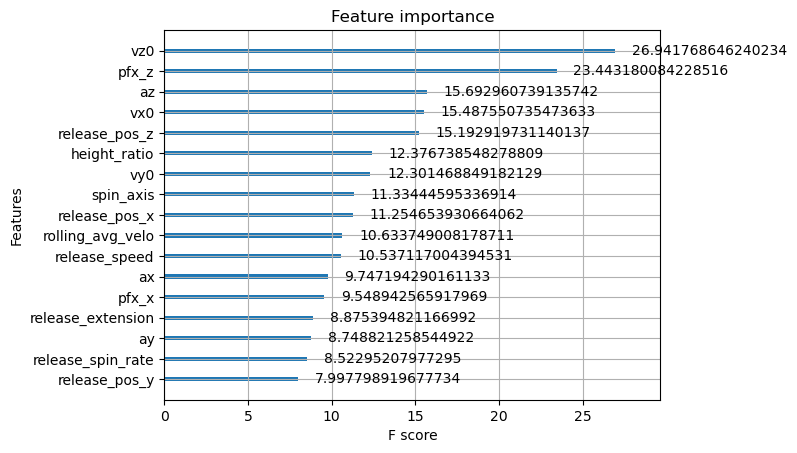

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

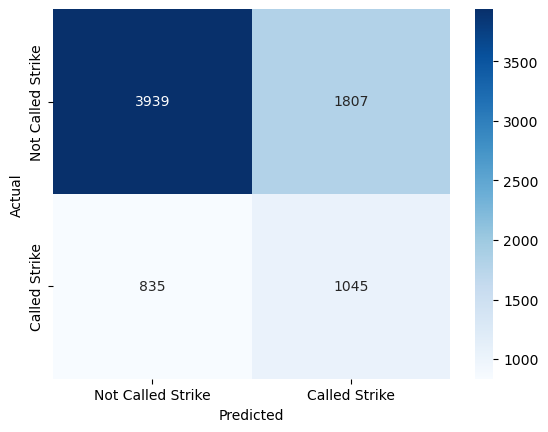

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
len(testing_label)

188456

In [27]:
y_pred = final_model.predict(predictions)

In [28]:
len(testing_data)

188456

In [29]:
testing_identifiers['xcs'] = y_pred

In [30]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/cs_2022&3_xcalledstrike.csv")